#Task 1

1. In this task you will fine-tune two networks (ResNet-18 and VGG-16) pretrained on ImageNet weights.
2. Load these models in PyTorch.
3. Replace all FC layers with a fully connected network of your choice. You are free to choose the number of layers and neurons per layer.
4. Finetune the model using CrossEntropy loss. Please note that default cross-entropy loss of PyTorch has a built-in Softmax. For this assignment you will not be needing softmax. So instead, use BCEWithLogitsLoss (link). This loss accepts one-hot vectors for targets. This loss automatically applies a sigmoid function.
5. Now write a function for Focal Loss and use this loss instead of the Negative Log Likelihood loss for finetuning the model.
6. You can also download part-1 codes of your class fellows from Github. Search for DLSpring2020 in the Github search bar. You must cite the repository if you are doing so.
7. Save your model and name it as ‘vgg16_focal_loss.pth’ and ‘res18_focal_loss.pth’

### Importing Required Libraries

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import torch.nn.functional as F
from tqdm import tqdm
import time
import os
import copy

### Helping Functions

In [0]:
def plot_curves(title,y_label,train_arr,val_arr):
  plt.figure(figsize=(10,5))
  plt.xlabel("Epochs")
  plt.ylabel(y_label)
  plt.title(title)
  plt.legend()
  plt.plot(np.arange(Epochs),train_arr,color='teal',label="train_data")
  plt.plot(np.arange(Epochs),val_arr,color='orange',label="validation_data")
  plt.legend()
  plt.show()

*Uncomment if you need to keep data set on colab server*

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# from google.colab import drive
# drive.mount("./gdrive")
# # !unzip "./gdrive/My Drive/Copy of A_05_Part_02_Dataset.zip" -d "./gdrive/My Drive"

*Replace with Path of data set to be used*

In [0]:
data_dir = '/content/drive/My Drive/A_05_Part_02_Dataset'

**Function To get Predictions**


In [0]:
def get_preds(preds,threshold):
  preds = preds.sigmoid()
  # print("bef preds: \n",preds)
  preds[preds > threshold] = 1  #setting values above threshold to 1
  # print("preds",preds)
  vals, indices = torch.max(preds, 1) #to get indeices of max values in each row
  preds[np.arange(len(indices)),indices]=1 #indices (of max value of the row) would be set to 1 
  # print("after preds",preds)
  # print("indices",indices)
  # print("max_values",_)
  # m=indices<0.5
  # print("mask: \n",m)
  preds[preds < 1] = 0  #setting values below threshold to 0
  return preds

**Confusion Matrix**

In [0]:
def Evaluation_report(model,loader):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model.to(device)
  
  # Initialize the prediction and label lists(tensors)
  preds_list=torch.zeros(0,dtype=torch.int32, device='cpu')
  labels_list=torch.zeros(0,dtype=torch.int32, device='cpu')

  with torch.no_grad():
      for i, (inputs, labels) in enumerate(loader):
          inputs = inputs.to(device)
          labels = labels.to(device)
          labels = labels.int()

          outputs = model(inputs)

          preds = get_preds(outputs,0.5)
          
          # print("preds: ",preds)

          _,preds = (preds==1).max(1)

          preds = preds.int()

          # print("preds: ",preds)
          # print("labels: ",labels)

          preds_list=torch.cat([preds_list,preds.cpu()])
          labels_list=torch.cat([labels_list,labels.cpu()])

  # Confusion matrix
  # print("preds_list:", preds_list)
  # print("labels_list:",labels_list)
  print("0. COVID-19\n1. Normal\n2.Pnemounia")
  CR=classification_report(labels_list, preds_list)
  print(CR)

  classes = [0, 1, 2]
  cm = confusion_matrix(labels_list, preds_list, classes)
  print(cm)
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(cm)
  plt.title('Confusion matrix of the classifier')
  fig.colorbar(cax)
  ax.set_xticklabels([''] + classes)
  ax.set_yticklabels([''] + classes)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

  print("\nmulti-label confusion matrix")
  ml_cm = multilabel_confusion_matrix(labels_list,preds_list)
  print(ml_cm)

**Validation Function**

In [0]:
def evaluate(model):
    model.train(False)

    running_loss = 0.0
    running_corrects = 0.0
    num_images = 0
    vbar = tqdm(enumerate(validloader))
    for i, data in vbar:

        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        labels = torch.nn.functional.one_hot(labels, 3)
        labels = labels.float()
        labels[:,2]=labels[:,2]+labels[:,0] #setting pnemounia true for all COVID labeled records

        num_images = num_images+inputs.size(0)

        outputs = model(inputs)

        # _, preds = torch.max(outputs, 1)
        # preds = torch.nn.functional.one_hot(preds, 3) #one hot vector for predictions
        # preds[:,2]=preds[:,2]+preds[:,0]
        preds = get_preds(outputs,0.5)

        loss = criterion(outputs, labels)

        running_loss += loss.item()
        
        running_corrects += (preds==labels).prod(1).sum().item()
        # running_corrects += sum((preds == labels).all(axis=1)) #to get all correct predictions

    epoch_loss = running_loss /num_images
    epochs_acc = running_corrects / num_images

    return epoch_loss, epochs_acc

### Applying Transformations on dataset

In [9]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/Train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/Test', transform=test_transforms)
valid_data = datasets.ImageFolder(data_dir + '/Validation', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=5)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, num_workers=5,)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True, num_workers=5)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['covid-19', 'normal', 'pneumonia']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


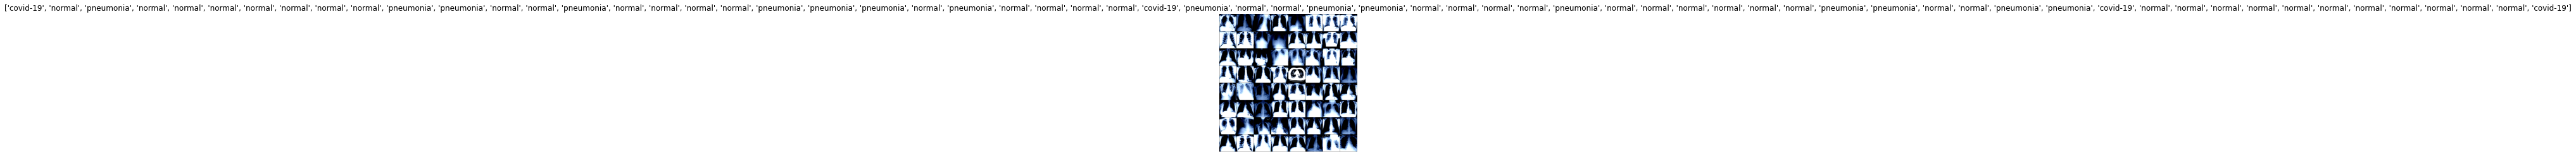

In [15]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

# Without Focal Loss

---

### ResNet18 Model

**Loading pre-trained model of ResNet-18 for ImageNet**

In [0]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

**Replacing Previous FC Layers with new ones**

In [0]:
features = list()
features.extend([nn.Linear(512, 3)])
resnet18.fc = nn.Sequential(*features)

In [0]:
# print(resnet18)

**Loss function and optimizer**

In [0]:
Epochs = 10
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

In [0]:
# x = torch.ones([5, 3], dtype=torch.float64)

In [0]:
# x[:,2]=x[:,2]+x[:,0]
# x

In [0]:
# # m = x[:,0:1]>0
# arr =np.array(x)

In [0]:
# v = torch.arange(15)
# v = v.view(5, 3)

# print(v)
# indices = torch.LongTensor([0])

# r = torch.index_select(v, 1, indices) # Select element 0 and 2 for each dimension 1.
# print(r)
# # Masked select
# # 0  0  0
# # 1  1  1
# # 1  1  1
# mask = r.ge(3)
# print(mask)
# # Size 6: 3 4 5 6 7 8
# r = torch.masked_select(r, mask)
# print(r)

In [0]:
# x = np.array([1, 2.5, 2.5])
# set(x)

In [0]:
def compare_preds_labels(preds,labels,classes):
  batch_corrects=0
  #converting to numpy arrays
  preds = preds.cpu().data.numpy()
  labels = labels.cpu().data.numpy()


  print("preds\n",preds)
  print("labels\n",labels)
  
  #decoding 1-hot encoding to actual class labels:
  # 1.covid
  # 2.normal
  # 3.pnemounia

  for p,l in zip(preds,labels):
    for i in range(classes):
      if p[i]==1:
        p[i]=i+1 
      if l[i]==1:
        l[i]=i+1

    print("p: ",p)
    print("l: ",l)
    
    t_p = set(p)
    t_l = set(l)

    intersection = t_p.intersection(t_l)
    union = t_p.union(t_l)
    
    print("intersection: ",len(intersection),intersection)
    print("union: ",len(union),union)
    
    batch_corrects+=(len(intersection)/len(union))

  # print("preds\n",preds)
  # print("labels\n",labels)

  print("batch_corrects: ",batch_corrects)
  


from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()
train_error=[]
val_error=[]
train_acc=[]
val_acc=[]

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    running_corrects = 0.0
    num_images = 0

    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # print("LABELS\n",labels.shape)
        labels = torch.nn.functional.one_hot(labels, 3)
        labels = labels.float()
        labels[:,2]=labels[:,2]+labels[:,0] #setting pnemounia true for all COVID labeled records
        num_images = num_images+inputs.size(0)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        
        # print("\nlabels type: ",labels.shape)
        # print("\nlabels : ",labels)
#--------------------------------------------------------------------
        loss = criterion(outputs, labels)   #----> compute loss
        # print("\noutput type: ",loss.shape)
        # print("\noutputs : ",loss)
        
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        # print("loss type",loss.data)
        # print("outputs: ",outputs)
        
        ## _, preds = torch.max(outputs, 1)
        
        # print statistics
        preds = get_preds(outputs,0.5)
        # compare_preds_labels(preds,labels,3)

        running_loss += loss.item()

        # running_loss += hamming_loss(labels,preds)

        # print("labels.shape: ",labels)
        # preds = preds.view(8,1)
        # preds = torch.nn.functional.one_hot(preds, 3) #one hot vector for predictions
        # preds[:,2]=preds[:,2]+preds[:,0]
        # print("preds: ",preds)


        running_corrects += (preds==labels).prod(1).sum().item()
        print("running_corrects: ",running_corrects)
        # running_corrects += sum((preds == labels).all(axis=1)) #to get all correct predictions

        # print("preds: \n",preds)
        # print("labels: \n",labels)
        
        # print(running_corrects)
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        
    #train loss and accuracy
    epoch_loss = running_loss /num_images
    train_error.append(epoch_loss)
    epoch_acc = running_corrects / num_images
    train_acc.append(epoch_acc)

    #Validation loss and accuracy
    epoch_loss,epoch_acc = evaluate(resnet18)
    val_error.append(epoch_loss)
    val_acc.append(epoch_acc)

    print('train loss: {}\n train acc: {}\n valid loss: {}\n valid acc:{}'.format(
        train_error[epoch],train_acc[epoch],val_error[epoch],val_acc[epoch]))

    torch.save(resnet18.state_dict(), data_dir+'/res18_FC_Only_1.pth')

print('Finished Training')




0it [00:00, ?it/s]


Train Epoch: 0 [0/6200 (0%)]	Loss: 0.835491: : 0it [00:05, ?it/s]


Train Epoch: 0 [0/6200 (0%)]	Loss: 0.835491: : 1it [00:05,  5.07s/it]

running_corrects:  3.0





Train Epoch: 0 [64/6200 (1%)]	Loss: 0.804255: : 1it [00:05,  5.07s/it]


Train Epoch: 0 [64/6200 (1%)]	Loss: 0.804255: : 2it [00:05,  3.63s/it]

running_corrects:  9.0





Train Epoch: 0 [128/6200 (2%)]	Loss: 0.795086: : 2it [00:05,  3.63s/it]


Train Epoch: 0 [128/6200 (2%)]	Loss: 0.795086: : 3it [00:05,  2.61s/it]


Train Epoch: 0 [192/6200 (3%)]	Loss: 0.706953: : 3it [00:05,  2.61s/it]


Train Epoch: 0 [192/6200 (3%)]	Loss: 0.706953: : 4it [00:05,  1.88s/it]

running_corrects:  13.0
running_corrects:  25.0





Train Epoch: 0 [256/6200 (4%)]	Loss: 0.668051: : 4it [00:05,  1.88s/it]


Train Epoch: 0 [256/6200 (4%)]	Loss: 0.668051: : 5it [00:05,  1.37s/it]

running_corrects:  44.0





Train Epoch: 0 [320/6200 (5%)]	Loss: 0.628659: : 5it [00:09,  1.37s/it]


Train Epoch: 0 [320/6200 (5%)]	Loss: 0.628659: : 6it [00:09,  2.10s/it]

running_corrects:  72.0





Train Epoch: 0 [384/6200 (6%)]	Loss: 0.576479: : 6it [00:10,  2.10s/it]


Train Epoch: 0 [384/6200 (6%)]	Loss: 0.576479: : 7it [00:10,  1.58s/it]


Train Epoch: 0 [448/6200 (7%)]	Loss: 0.522231: : 7it [00:10,  1.58s/it]


Train Epoch: 0 [448/6200 (7%)]	Loss: 0.522231: : 8it [00:10,  1.16s/it]

running_corrects:  106.0
running_corrects:  150.0





Train Epoch: 0 [512/6200 (8%)]	Loss: 0.505941: : 8it [00:10,  1.16s/it]


Train Epoch: 0 [512/6200 (8%)]	Loss: 0.505941: : 9it [00:10,  1.03it/s]


Train Epoch: 0 [576/6200 (9%)]	Loss: 0.461294: : 9it [00:10,  1.03it/s]


Train Epoch: 0 [576/6200 (9%)]	Loss: 0.461294: : 10it [00:11,  1.36it/s]

running_corrects:  194.0
running_corrects:  238.0





Train Epoch: 0 [640/6200 (10%)]	Loss: 0.437665: : 10it [00:15,  1.36it/s]


Train Epoch: 0 [640/6200 (10%)]	Loss: 0.437665: : 11it [00:15,  1.95s/it]


Train Epoch: 0 [704/6200 (11%)]	Loss: 0.452503: : 11it [00:15,  1.95s/it]


Train Epoch: 0 [704/6200 (11%)]	Loss: 0.452503: : 12it [00:15,  1.41s/it]

running_corrects:  280.0
running_corrects:  319.0





Train Epoch: 0 [768/6200 (12%)]	Loss: 0.481120: : 12it [00:16,  1.41s/it]


Train Epoch: 0 [768/6200 (12%)]	Loss: 0.481120: : 13it [00:16,  1.06s/it]


Train Epoch: 0 [832/6200 (13%)]	Loss: 0.394645: : 13it [00:16,  1.06s/it]


Train Epoch: 0 [832/6200 (13%)]	Loss: 0.394645: : 14it [00:16,  1.27it/s]

running_corrects:  358.0
running_corrects:  403.0





Train Epoch: 0 [896/6200 (14%)]	Loss: 0.397598: : 14it [00:16,  1.27it/s]


Train Epoch: 0 [896/6200 (14%)]	Loss: 0.397598: : 15it [00:16,  1.60it/s]

running_corrects:  448.0





Train Epoch: 0 [960/6200 (15%)]	Loss: 0.428361: : 15it [00:21,  1.60it/s]


Train Epoch: 0 [960/6200 (15%)]	Loss: 0.428361: : 16it [00:21,  2.03s/it]

running_corrects:  491.0





Train Epoch: 0 [1024/6200 (16%)]	Loss: 0.426537: : 16it [00:22,  2.03s/it]


Train Epoch: 0 [1024/6200 (16%)]	Loss: 0.426537: : 17it [00:22,  1.48s/it]


Train Epoch: 0 [1088/6200 (18%)]	Loss: 0.458732: : 17it [00:22,  1.48s/it]

running_corrects:  533.0
running_corrects:  574.0





Train Epoch: 0 [1088/6200 (18%)]	Loss: 0.458732: : 18it [00:22,  1.09s/it]


Train Epoch: 0 [1152/6200 (19%)]	Loss: 0.525371: : 18it [00:22,  1.09s/it]


Train Epoch: 0 [1152/6200 (19%)]	Loss: 0.525371: : 19it [00:22,  1.22it/s]


Train Epoch: 0 [1216/6200 (20%)]	Loss: 0.409119: : 19it [00:22,  1.22it/s]


Train Epoch: 0 [1216/6200 (20%)]	Loss: 0.409119: : 20it [00:22,  1.60it/s]

running_corrects:  611.0
running_corrects:  653.0





Train Epoch: 0 [1280/6200 (21%)]	Loss: 0.480100: : 20it [00:26,  1.60it/s]


Train Epoch: 0 [1280/6200 (21%)]	Loss: 0.480100: : 21it [00:26,  1.65s/it]

running_corrects:  690.0





Train Epoch: 0 [1344/6200 (22%)]	Loss: 0.371839: : 21it [00:26,  1.65s/it]


Train Epoch: 0 [1344/6200 (22%)]	Loss: 0.371839: : 22it [00:26,  1.21s/it]

running_corrects:  732.0





Train Epoch: 0 [1408/6200 (23%)]	Loss: 0.396596: : 22it [00:27,  1.21s/it]


Train Epoch: 0 [1408/6200 (23%)]	Loss: 0.396596: : 23it [00:27,  1.10it/s]


Train Epoch: 0 [1472/6200 (24%)]	Loss: 0.395768: : 23it [00:27,  1.10it/s]


Train Epoch: 0 [1472/6200 (24%)]	Loss: 0.395768: : 24it [00:27,  1.45it/s]

running_corrects:  774.0
running_corrects:  815.0





Train Epoch: 0 [1536/6200 (25%)]	Loss: 0.349528: : 24it [00:27,  1.45it/s]


Train Epoch: 0 [1536/6200 (25%)]	Loss: 0.349528: : 25it [00:27,  1.84it/s]

running_corrects:  863.0





Train Epoch: 0 [1600/6200 (26%)]	Loss: 0.311072: : 25it [00:31,  1.84it/s]


Train Epoch: 0 [1600/6200 (26%)]	Loss: 0.311072: : 26it [00:31,  1.53s/it]

running_corrects:  916.0





Train Epoch: 0 [1664/6200 (27%)]	Loss: 0.360314: : 26it [00:31,  1.53s/it]


Train Epoch: 0 [1664/6200 (27%)]	Loss: 0.360314: : 27it [00:31,  1.14s/it]


Train Epoch: 0 [1728/6200 (28%)]	Loss: 0.389333: : 27it [00:31,  1.14s/it]


Train Epoch: 0 [1728/6200 (28%)]	Loss: 0.389333: : 28it [00:31,  1.18it/s]

running_corrects:  965.0
running_corrects:  1010.0





Train Epoch: 0 [1792/6200 (29%)]	Loss: 0.398587: : 28it [00:31,  1.18it/s]


Train Epoch: 0 [1792/6200 (29%)]	Loss: 0.398587: : 29it [00:31,  1.50it/s]


Train Epoch: 0 [1856/6200 (30%)]	Loss: 0.350531: : 29it [00:32,  1.50it/s]


Train Epoch: 0 [1856/6200 (30%)]	Loss: 0.350531: : 30it [00:32,  1.92it/s]

running_corrects:  1058.0
running_corrects:  1108.0





Train Epoch: 0 [1920/6200 (31%)]	Loss: 0.325395: : 30it [00:36,  1.92it/s]


Train Epoch: 0 [1920/6200 (31%)]	Loss: 0.325395: : 31it [00:36,  1.57s/it]


Train Epoch: 0 [1984/6200 (32%)]	Loss: 0.296784: : 31it [00:36,  1.57s/it]


Train Epoch: 0 [1984/6200 (32%)]	Loss: 0.296784: : 32it [00:36,  1.15s/it]

running_corrects:  1159.0
running_corrects:  1215.0





Train Epoch: 0 [2048/6200 (33%)]	Loss: 0.328352: : 32it [00:36,  1.15s/it]


Train Epoch: 0 [2048/6200 (33%)]	Loss: 0.328352: : 33it [00:36,  1.16it/s]


Train Epoch: 0 [2112/6200 (34%)]	Loss: 0.341817: : 33it [00:36,  1.16it/s]


Train Epoch: 0 [2112/6200 (34%)]	Loss: 0.341817: : 34it [00:36,  1.53it/s]

running_corrects:  1266.0
running_corrects:  1321.0





Train Epoch: 0 [2176/6200 (35%)]	Loss: 0.315182: : 34it [00:36,  1.53it/s]


Train Epoch: 0 [2176/6200 (35%)]	Loss: 0.315182: : 35it [00:36,  1.93it/s]

running_corrects:  1378.0





Train Epoch: 0 [2240/6200 (36%)]	Loss: 0.328302: : 35it [00:40,  1.93it/s]


Train Epoch: 0 [2240/6200 (36%)]	Loss: 0.328302: : 36it [00:40,  1.45s/it]

running_corrects:  1431.0
running_corrects:  




Train Epoch: 0 [2304/6200 (37%)]	Loss: 0.385673: : 36it [00:40,  1.45s/it]


Train Epoch: 0 [2304/6200 (37%)]	Loss: 0.385673: : 37it [00:40,  1.08s/it]


Train Epoch: 0 [2368/6200 (38%)]	Loss: 0.319418: : 37it [00:40,  1.08s/it]


Train Epoch: 0 [2368/6200 (38%)]	Loss: 0.319418: : 38it [00:40,  1.23it/s]

1483.0
running_corrects:  1538.0





Train Epoch: 0 [2432/6200 (39%)]	Loss: 0.299086: : 38it [00:41,  1.23it/s]


Train Epoch: 0 [2432/6200 (39%)]	Loss: 0.299086: : 39it [00:41,  1.15it/s]


Train Epoch: 0 [2496/6200 (40%)]	Loss: 0.292891: : 39it [00:42,  1.15it/s]


Train Epoch: 0 [2496/6200 (40%)]	Loss: 0.292891: : 40it [00:42,  1.53it/s]

running_corrects:  1593.0
running_corrects:  1649.0





Train Epoch: 0 [2560/6200 (41%)]	Loss: 0.251357: : 40it [00:45,  1.53it/s]


Train Epoch: 0 [2560/6200 (41%)]	Loss: 0.251357: : 41it [00:45,  1.35s/it]

running_corrects:  1707.0
running_corrects:  1755.0





Train Epoch: 0 [2624/6200 (42%)]	Loss: 0.329804: : 41it [00:45,  1.35s/it]


Train Epoch: 0 [2624/6200 (42%)]	Loss: 0.329804: : 42it [00:45,  1.01s/it]


Train Epoch: 0 [2688/6200 (43%)]	Loss: 0.282715: : 42it [00:45,  1.01s/it]


Train Epoch: 0 [2688/6200 (43%)]	Loss: 0.282715: : 43it [00:45,  1.29it/s]

running_corrects:  1811.0





Train Epoch: 0 [2752/6200 (44%)]	Loss: 0.381546: : 43it [00:46,  1.29it/s]


Train Epoch: 0 [2752/6200 (44%)]	Loss: 0.381546: : 44it [00:46,  1.07it/s]

running_corrects:  1857.0
running_corrects: 




Train Epoch: 0 [2816/6200 (45%)]	Loss: 0.284752: : 44it [00:46,  1.07it/s]


Train Epoch: 0 [2816/6200 (45%)]	Loss: 0.284752: : 45it [00:46,  1.40it/s]

 1911.0





Train Epoch: 0 [2880/6200 (46%)]	Loss: 0.401159: : 45it [00:49,  1.40it/s]


Train Epoch: 0 [2880/6200 (46%)]	Loss: 0.401159: : 46it [00:49,  1.30s/it]

running_corrects:  1962.0





Train Epoch: 0 [2944/6200 (47%)]	Loss: 0.308599: : 46it [00:49,  1.30s/it]


Train Epoch: 0 [2944/6200 (47%)]	Loss: 0.308599: : 47it [00:49,  1.00s/it]


Train Epoch: 0 [3008/6200 (48%)]	Loss: 0.357230: : 47it [00:50,  1.00s/it]


Train Epoch: 0 [3008/6200 (48%)]	Loss: 0.357230: : 48it [00:50,  1.34it/s]

running_corrects:  2017.0
running_corrects:  2067.0





Train Epoch: 0 [3072/6200 (49%)]	Loss: 0.327940: : 48it [00:51,  1.34it/s]


Train Epoch: 0 [3072/6200 (49%)]	Loss: 0.327940: : 49it [00:51,  1.02s/it]


Train Epoch: 0 [3136/6200 (51%)]	Loss: 0.285586: : 49it [00:51,  1.02s/it]


Train Epoch: 0 [3136/6200 (51%)]	Loss: 0.285586: : 50it [00:51,  1.31it/s]

running_corrects:  2114.0
running_corrects:  2171.0





Train Epoch: 0 [3200/6200 (52%)]	Loss: 0.245100: : 50it [00:54,  1.31it/s]


Train Epoch: 0 [3200/6200 (52%)]	Loss: 0.245100: : 51it [00:54,  1.35s/it]

running_corrects:  2229.0





Train Epoch: 0 [3264/6200 (53%)]	Loss: 0.365153: : 51it [00:54,  1.35s/it]


Train Epoch: 0 [3264/6200 (53%)]	Loss: 0.365153: : 52it [00:54,  1.05s/it]

running_corrects:  2277.0





Train Epoch: 0 [3328/6200 (54%)]	Loss: 0.360567: : 52it [00:55,  1.05s/it]


Train Epoch: 0 [3328/6200 (54%)]	Loss: 0.360567: : 53it [00:55,  1.25it/s]

running_corrects:  2327.0





Train Epoch: 0 [3392/6200 (55%)]	Loss: 0.277287: : 53it [00:56,  1.25it/s]


Train Epoch: 0 [3392/6200 (55%)]	Loss: 0.277287: : 54it [00:56,  1.10it/s]

running_corrects:  2382.0





Train Epoch: 0 [3456/6200 (56%)]	Loss: 0.270362: : 54it [00:56,  1.10it/s]


Train Epoch: 0 [3456/6200 (56%)]	Loss: 0.270362: : 55it [00:56,  1.43it/s]

running_corrects:  2434.0





Train Epoch: 0 [3520/6200 (57%)]	Loss: 0.239955: : 55it [00:59,  1.43it/s]


Train Epoch: 0 [3520/6200 (57%)]	Loss: 0.239955: : 56it [00:59,  1.37s/it]

running_corrects:  2491.0





Train Epoch: 0 [3584/6200 (58%)]	Loss: 0.229230: : 56it [00:59,  1.37s/it]


Train Epoch: 0 [3584/6200 (58%)]	Loss: 0.229230: : 57it [00:59,  1.04s/it]


Train Epoch: 0 [3648/6200 (59%)]	Loss: 0.301424: : 57it [00:59,  1.04s/it]

running_corrects:  2548.0
running_corrects:  2602.0





Train Epoch: 0 [3648/6200 (59%)]	Loss: 0.301424: : 58it [00:59,  1.28it/s]


Train Epoch: 0 [3712/6200 (60%)]	Loss: 0.284125: : 58it [01:01,  1.28it/s]


Train Epoch: 0 [3712/6200 (60%)]	Loss: 0.284125: : 59it [01:01,  1.10it/s]


Train Epoch: 0 [3776/6200 (61%)]	Loss: 0.275988: : 59it [01:01,  1.10it/s]


Train Epoch: 0 [3776/6200 (61%)]	Loss: 0.275988: : 60it [01:01,  1.45it/s]

running_corrects:  2656.0
running_corrects:  2710.0





Train Epoch: 0 [3840/6200 (62%)]	Loss: 0.295175: : 60it [01:03,  1.45it/s]


Train Epoch: 0 [3840/6200 (62%)]	Loss: 0.295175: : 61it [01:03,  1.27s/it]

running_corrects:  2763.0





Train Epoch: 0 [3904/6200 (63%)]	Loss: 0.275321: : 61it [01:05,  1.27s/it]


Train Epoch: 0 [3904/6200 (63%)]	Loss: 0.275321: : 62it [01:05,  1.27s/it]


Train Epoch: 0 [3968/6200 (64%)]	Loss: 0.252269: : 62it [01:05,  1.27s/it]




running_corrects:  2817.0
running_corrects:  2872.0


Train Epoch: 0 [3968/6200 (64%)]	Loss: 0.252269: : 63it [01:05,  1.06it/s]


Train Epoch: 0 [4032/6200 (65%)]	Loss: 0.272777: : 63it [01:05,  1.06it/s]


Train Epoch: 0 [4032/6200 (65%)]	Loss: 0.272777: : 64it [01:05,  1.19it/s]

running_corrects:  2926.0





Train Epoch: 0 [4096/6200 (66%)]	Loss: 0.282463: : 64it [01:06,  1.19it/s]


Train Epoch: 0 [4096/6200 (66%)]	Loss: 0.282463: : 65it [01:06,  1.54it/s]

running_corrects:  2977.0





Train Epoch: 0 [4160/6200 (67%)]	Loss: 0.248931: : 65it [01:10,  1.54it/s]


Train Epoch: 0 [4160/6200 (67%)]	Loss: 0.248931: : 66it [01:10,  1.79s/it]

running_corrects:  3031.0





Train Epoch: 0 [4224/6200 (68%)]	Loss: 0.262505: : 66it [01:10,  1.79s/it]


Train Epoch: 0 [4224/6200 (68%)]	Loss: 0.262505: : 67it [01:10,  1.32s/it]


Train Epoch: 0 [4288/6200 (69%)]	Loss: 0.225012: : 67it [01:11,  1.32s/it]


Train Epoch: 0 [4288/6200 (69%)]	Loss: 0.225012: : 68it [01:11,  1.03it/s]

running_corrects:  3087.0
running_corrects:  3140.0





Train Epoch: 0 [4352/6200 (70%)]	Loss: 0.233402: : 68it [01:11,  1.03it/s]


Train Epoch: 0 [4352/6200 (70%)]	Loss: 0.233402: : 69it [01:11,  1.34it/s]


Train Epoch: 0 [4416/6200 (71%)]	Loss: 0.261722: : 69it [01:11,  1.34it/s]


Train Epoch: 0 [4416/6200 (71%)]	Loss: 0.261722: : 70it [01:11,  1.74it/s]

running_corrects:  3197.0
running_corrects:  3252.0





Train Epoch: 0 [4480/6200 (72%)]	Loss: 0.254225: : 70it [01:15,  1.74it/s]


Train Epoch: 0 [4480/6200 (72%)]	Loss: 0.254225: : 71it [01:15,  1.74s/it]


Train Epoch: 0 [4544/6200 (73%)]	Loss: 0.294872: : 71it [01:16,  1.74s/it]


Train Epoch: 0 [4544/6200 (73%)]	Loss: 0.294872: : 72it [01:16,  1.27s/it]

running_corrects:  3308.0
running_corrects:  3362.0





Train Epoch: 0 [4608/6200 (74%)]	Loss: 0.280126: : 72it [01:16,  1.27s/it]


Train Epoch: 0 [4608/6200 (74%)]	Loss: 0.280126: : 73it [01:16,  1.04it/s]


Train Epoch: 0 [4672/6200 (75%)]	Loss: 0.254650: : 73it [01:16,  1.04it/s]


Train Epoch: 0 [4672/6200 (75%)]	Loss: 0.254650: : 74it [01:16,  1.38it/s]

running_corrects:  3413.0
running_corrects:  3467.0





Train Epoch: 0 [4736/6200 (76%)]	Loss: 0.264996: : 74it [01:16,  1.38it/s]


Train Epoch: 0 [4736/6200 (76%)]	Loss: 0.264996: : 75it [01:16,  1.76it/s]

running_corrects:  3520.0





Train Epoch: 0 [4800/6200 (77%)]	Loss: 0.294672: : 75it [01:20,  1.76it/s]


Train Epoch: 0 [4800/6200 (77%)]	Loss: 0.294672: : 76it [01:20,  1.66s/it]

running_corrects:  3572.0





Train Epoch: 0 [4864/6200 (78%)]	Loss: 0.252914: : 76it [01:21,  1.66s/it]


Train Epoch: 0 [4864/6200 (78%)]	Loss: 0.252914: : 77it [01:21,  1.23s/it]


Train Epoch: 0 [4928/6200 (79%)]	Loss: 0.270619: : 77it [01:21,  1.23s/it]


Train Epoch: 0 [4928/6200 (79%)]	Loss: 0.270619: : 78it [01:21,  1.10it/s]

running_corrects:  3626.0
running_corrects:  3679.0





Train Epoch: 0 [4992/6200 (80%)]	Loss: 0.267206: : 78it [01:21,  1.10it/s]


Train Epoch: 0 [4992/6200 (80%)]	Loss: 0.267206: : 79it [01:21,  1.42it/s]


Train Epoch: 0 [5056/6200 (81%)]	Loss: 0.274868: : 79it [01:21,  1.42it/s]


Train Epoch: 0 [5056/6200 (81%)]	Loss: 0.274868: : 80it [01:21,  1.84it/s]

running_corrects:  3732.0
running_corrects:  3785.0





Train Epoch: 0 [5120/6200 (82%)]	Loss: 0.295568: : 80it [01:27,  1.84it/s]


Train Epoch: 0 [5120/6200 (82%)]	Loss: 0.295568: : 81it [01:27,  2.05s/it]


Train Epoch: 0 [5184/6200 (84%)]	Loss: 0.231928: : 81it [01:27,  2.05s/it]

running_corrects:  3838.0
running_corrects:  3895.0





Train Epoch: 0 [5184/6200 (84%)]	Loss: 0.231928: : 82it [01:27,  1.49s/it]


Train Epoch: 0 [5248/6200 (85%)]	Loss: 0.240853: : 82it [01:27,  1.49s/it]


Train Epoch: 0 [5248/6200 (85%)]	Loss: 0.240853: : 83it [01:27,  1.12s/it]


Train Epoch: 0 [5312/6200 (86%)]	Loss: 0.328725: : 83it [01:27,  1.12s/it]


Train Epoch: 0 [5312/6200 (86%)]	Loss: 0.328725: : 84it [01:27,  1.20it/s]

running_corrects:  3949.0
running_corrects:  3998.0





Train Epoch: 0 [5376/6200 (87%)]	Loss: 0.239761: : 84it [01:28,  1.20it/s]


Train Epoch: 0 [5376/6200 (87%)]	Loss: 0.239761: : 85it [01:28,  1.55it/s]

running_corrects:  4056.0





Train Epoch: 0 [5440/6200 (88%)]	Loss: 0.242879: : 85it [01:32,  1.55it/s]


Train Epoch: 0 [5440/6200 (88%)]	Loss: 0.242879: : 86it [01:32,  1.71s/it]

running_corrects:  4112.0





Train Epoch: 0 [5504/6200 (89%)]	Loss: 0.258603: : 86it [01:32,  1.71s/it]


Train Epoch: 0 [5504/6200 (89%)]	Loss: 0.258603: : 87it [01:32,  1.26s/it]


Train Epoch: 0 [5568/6200 (90%)]	Loss: 0.296588: : 87it [01:32,  1.26s/it]


Train Epoch: 0 [5568/6200 (90%)]	Loss: 0.296588: : 88it [01:32,  1.06it/s]

running_corrects:  4169.0
running_corrects:  4222.0





Train Epoch: 0 [5632/6200 (91%)]	Loss: 0.258508: : 88it [01:32,  1.06it/s]


Train Epoch: 0 [5632/6200 (91%)]	Loss: 0.258508: : 89it [01:32,  1.39it/s]


Train Epoch: 0 [5696/6200 (92%)]	Loss: 0.243877: : 89it [01:32,  1.39it/s]


Train Epoch: 0 [5696/6200 (92%)]	Loss: 0.243877: : 90it [01:32,  1.83it/s]

running_corrects:  4277.0
running_corrects:  4330.0





Train Epoch: 0 [5760/6200 (93%)]	Loss: 0.276435: : 90it [01:34,  1.83it/s]


Train Epoch: 0 [5760/6200 (93%)]	Loss: 0.276435: : 91it [01:34,  1.04it/s]


Train Epoch: 0 [5824/6200 (94%)]	Loss: 0.224844: : 91it [01:35,  1.04it/s]


Train Epoch: 0 [5824/6200 (94%)]	Loss: 0.224844: : 92it [01:35,  1.40it/s]

running_corrects:  4380.0
running_corrects:  4436.0





Train Epoch: 0 [5888/6200 (95%)]	Loss: 0.271869: : 92it [01:35,  1.40it/s]


Train Epoch: 0 [5888/6200 (95%)]	Loss: 0.271869: : 93it [01:35,  1.85it/s]


Train Epoch: 0 [5952/6200 (96%)]	Loss: 0.203464: : 93it [01:35,  1.85it/s]


Train Epoch: 0 [5952/6200 (96%)]	Loss: 0.203464: : 94it [01:35,  2.41it/s]

running_corrects:  4490.0
running_corrects:  4543.0





Train Epoch: 0 [6016/6200 (97%)]	Loss: 0.245121: : 94it [01:35,  2.41it/s]


Train Epoch: 0 [6016/6200 (97%)]	Loss: 0.245121: : 95it [01:35,  2.94it/s]

running_corrects:  4595.0





Train Epoch: 0 [6080/6200 (98%)]	Loss: 0.218457: : 95it [01:36,  2.94it/s]


Train Epoch: 0 [6080/6200 (98%)]	Loss: 0.218457: : 96it [01:36,  1.71it/s]


Train Epoch: 0 [5376/6200 (99%)]	Loss: 0.262211: : 96it [01:36,  1.71it/s]


Train Epoch: 0 [5376/6200 (99%)]	Loss: 0.262211: : 97it [01:36,  2.22it/s]

running_corrects:  4652.0
running_corrects:  4698.0


Train Epoch: 0 [5376/6200 (99%)]	Loss: 0.262211: : 97it [01:36,  1.00it/s]



0it [00:00, ?it/s]


1it [00:04,  4.31s/it]


2it [00:04,  3.07s/it]


3it [00:04,  2.18s/it]


4it [00:04,  1.64s/it]


5it [00:05,  1.19s/it]


6it [00:09,  2.09s/it]


10it [00:09,  1.04it/s]


train loss: 0.005430799681813486
 train acc: 0.7577419354838709
 valid loss: 0.00392239313026902
 valid acc:0.8598726114649682





0it [00:00, ?it/s]


Train Epoch: 1 [0/6200 (0%)]	Loss: 0.242530: : 0it [00:04, ?it/s]


Train Epoch: 1 [0/6200 (0%)]	Loss: 0.242530: : 1it [00:04,  4.52s/it]


Train Epoch: 1 [64/6200 (1%)]	Loss: 0.192586: : 1it [00:04,  4.52s/it]


Train Epoch: 1 [64/6200 (1%)]	Loss: 0.192586: : 2it [00:04,  3.22s/it]

running_corrects:  54.0
running_corrects:  109.0





Train Epoch: 1 [128/6200 (2%)]	Loss: 0.226752: : 2it [00:05,  3.22s/it]


Train Epoch: 1 [128/6200 (2%)]	Loss: 0.226752: : 3it [00:05,  2.40s/it]


Train Epoch: 1 [192/6200 (3%)]	Loss: 0.242693: : 3it [00:05,  2.40s/it]


Train Epoch: 1 [192/6200 (3%)]	Loss: 0.242693: : 4it [00:05,  1.73s/it]

running_corrects:  163.0
running_corrects:  217.0





Train Epoch: 1 [256/6200 (4%)]	Loss: 0.243880: : 4it [00:05,  1.73s/it]


Train Epoch: 1 [256/6200 (4%)]	Loss: 0.243880: : 5it [00:05,  1.27s/it]

running_corrects:  271.0





Train Epoch: 1 [320/6200 (5%)]	Loss: 0.212561: : 5it [00:08,  1.27s/it]


Train Epoch: 1 [320/6200 (5%)]	Loss: 0.212561: : 6it [00:08,  1.91s/it]

running_corrects:  328.0





Train Epoch: 1 [384/6200 (6%)]	Loss: 0.254529: : 6it [00:09,  1.91s/it]


Train Epoch: 1 [384/6200 (6%)]	Loss: 0.254529: : 7it [00:09,  1.65s/it]




running_corrects:  381.0
running_corrects:  434.0


Train Epoch: 1 [448/6200 (7%)]	Loss: 0.266622: : 7it [00:10,  1.65s/it]


Train Epoch: 1 [448/6200 (7%)]	Loss: 0.266622: : 8it [00:10,  1.22s/it]


Train Epoch: 1 [512/6200 (8%)]	Loss: 0.240795: : 8it [00:10,  1.22s/it]


Train Epoch: 1 [512/6200 (8%)]	Loss: 0.240795: : 9it [00:10,  1.04it/s]


Train Epoch: 1 [576/6200 (9%)]	Loss: 0.183107: : 9it [00:10,  1.04it/s]




running_corrects:  488.0
running_corrects:  546.0


Train Epoch: 1 [576/6200 (9%)]	Loss: 0.183107: : 10it [00:10,  1.37it/s]


Train Epoch: 1 [640/6200 (10%)]	Loss: 0.231368: : 10it [00:13,  1.37it/s]


Train Epoch: 1 [640/6200 (10%)]	Loss: 0.231368: : 11it [00:13,  1.46s/it]

running_corrects:  601.0





Train Epoch: 1 [704/6200 (11%)]	Loss: 0.218392: : 11it [00:14,  1.46s/it]


Train Epoch: 1 [704/6200 (11%)]	Loss: 0.218392: : 12it [00:14,  1.29s/it]

running_corrects:  656.0





Train Epoch: 1 [768/6200 (12%)]	Loss: 0.165060: : 12it [00:15,  1.29s/it]


Train Epoch: 1 [768/6200 (12%)]	Loss: 0.165060: : 13it [00:15,  1.03it/s]

running_corrects:  713.0





Train Epoch: 1 [832/6200 (13%)]	Loss: 0.235895: : 13it [00:15,  1.03it/s]


Train Epoch: 1 [832/6200 (13%)]	Loss: 0.235895: : 14it [00:15,  1.24it/s]

running_corrects:  765.0





Train Epoch: 1 [896/6200 (14%)]	Loss: 0.212473: : 14it [00:15,  1.24it/s]


Train Epoch: 1 [896/6200 (14%)]	Loss: 0.212473: : 15it [00:15,  1.60it/s]

running_corrects:  821.0





Train Epoch: 1 [960/6200 (15%)]	Loss: 0.227030: : 15it [00:18,  1.60it/s]


Train Epoch: 1 [960/6200 (15%)]	Loss: 0.227030: : 16it [00:18,  1.31s/it]

running_corrects:  876.0





Train Epoch: 1 [1024/6200 (16%)]	Loss: 0.180210: : 16it [00:19,  1.31s/it]


Train Epoch: 1 [1024/6200 (16%)]	Loss: 0.180210: : 17it [00:19,  1.18s/it]


Train Epoch: 1 [1088/6200 (18%)]	Loss: 0.190062: : 17it [00:19,  1.18s/it]


Train Epoch: 1 [1088/6200 (18%)]	Loss: 0.190062: : 18it [00:19,  1.14it/s]

running_corrects:  934.0
running_corrects:  989.0





Train Epoch: 1 [1152/6200 (19%)]	Loss: 0.268146: : 18it [00:19,  1.14it/s]


Train Epoch: 1 [1152/6200 (19%)]	Loss: 0.268146: : 19it [00:20,  1.37it/s]


Train Epoch: 1 [1216/6200 (20%)]	Loss: 0.251176: : 19it [00:20,  1.37it/s]


Train Epoch: 1 [1216/6200 (20%)]	Loss: 0.251176: : 20it [00:20,  1.78it/s]

running_corrects:  1043.0
running_corrects:  1095.0





Train Epoch: 1 [1280/6200 (21%)]	Loss: 0.237990: : 20it [00:24,  1.78it/s]


Train Epoch: 1 [1280/6200 (21%)]	Loss: 0.237990: : 21it [00:24,  1.74s/it]


Train Epoch: 1 [1344/6200 (22%)]	Loss: 0.296219: : 21it [00:24,  1.74s/it]


Train Epoch: 1 [1344/6200 (22%)]	Loss: 0.296219: : 22it [00:24,  1.27s/it]

running_corrects:  1150.0
running_corrects:  1200.0





Train Epoch: 1 [1408/6200 (23%)]	Loss: 0.260514: : 22it [00:25,  1.27s/it]


Train Epoch: 1 [1408/6200 (23%)]	Loss: 0.260514: : 23it [00:25,  1.06it/s]


Train Epoch: 1 [1472/6200 (24%)]	Loss: 0.156253: : 23it [00:25,  1.06it/s]


Train Epoch: 1 [1472/6200 (24%)]	Loss: 0.156253: : 24it [00:25,  1.41it/s]

running_corrects:  1251.0
running_corrects:  1307.0





Train Epoch: 1 [1536/6200 (25%)]	Loss: 0.224486: : 24it [00:25,  1.41it/s]


Train Epoch: 1 [1536/6200 (25%)]	Loss: 0.224486: : 25it [00:25,  1.78it/s]

running_corrects:  1360.0





Train Epoch: 1 [1600/6200 (26%)]	Loss: 0.157521: : 25it [00:29,  1.78it/s]


Train Epoch: 1 [1600/6200 (26%)]	Loss: 0.157521: : 26it [00:29,  1.53s/it]

running_corrects:  1419.0





Train Epoch: 1 [1664/6200 (27%)]	Loss: 0.199535: : 26it [00:29,  1.53s/it]


Train Epoch: 1 [1664/6200 (27%)]	Loss: 0.199535: : 27it [00:29,  1.14s/it]

running_corrects:  1475.0





Train Epoch: 1 [1728/6200 (28%)]	Loss: 0.197097: : 27it [00:30,  1.14s/it]


Train Epoch: 1 [1728/6200 (28%)]	Loss: 0.197097: : 28it [00:30,  1.12s/it]

running_corrects:  1533.0





Train Epoch: 1 [1792/6200 (29%)]	Loss: 0.166864: : 28it [00:30,  1.12s/it]


Train Epoch: 1 [1792/6200 (29%)]	Loss: 0.166864: : 29it [00:30,  1.18it/s]


Train Epoch: 1 [1856/6200 (30%)]	Loss: 0.257453: : 29it [00:30,  1.18it/s]


Train Epoch: 1 [1856/6200 (30%)]	Loss: 0.257453: : 30it [00:30,  1.55it/s]

running_corrects:  1593.0
running_corrects:  1646.0





Train Epoch: 1 [1920/6200 (31%)]	Loss: 0.228815: : 30it [00:34,  1.55it/s]


Train Epoch: 1 [1920/6200 (31%)]	Loss: 0.228815: : 31it [00:34,  1.56s/it]


Train Epoch: 1 [1984/6200 (32%)]	Loss: 0.211324: : 31it [00:34,  1.56s/it]


Train Epoch: 1 [1984/6200 (32%)]	Loss: 0.211324: : 32it [00:34,  1.14s/it]

running_corrects:  1698.0
running_corrects:  1754.0





Train Epoch: 1 [2048/6200 (33%)]	Loss: 0.142899: : 32it [00:35,  1.14s/it]


Train Epoch: 1 [2048/6200 (33%)]	Loss: 0.142899: : 33it [00:35,  1.05it/s]


Train Epoch: 1 [2112/6200 (34%)]	Loss: 0.204353: : 33it [00:35,  1.05it/s]


Train Epoch: 1 [2112/6200 (34%)]	Loss: 0.204353: : 34it [00:35,  1.41it/s]

running_corrects:  1813.0
running_corrects:  1870.0





Train Epoch: 1 [2176/6200 (35%)]	Loss: 0.167799: : 34it [00:35,  1.41it/s]


Train Epoch: 1 [2176/6200 (35%)]	Loss: 0.167799: : 35it [00:35,  1.79it/s]

running_corrects:  1927.0





Train Epoch: 1 [2240/6200 (36%)]	Loss: 0.185456: : 35it [00:39,  1.79it/s]


Train Epoch: 1 [2240/6200 (36%)]	Loss: 0.185456: : 36it [00:39,  1.48s/it]




running_corrects:  1984.0
running_corrects:  2042.0


Train Epoch: 1 [2304/6200 (37%)]	Loss: 0.144030: : 36it [00:39,  1.48s/it]


Train Epoch: 1 [2304/6200 (37%)]	Loss: 0.144030: : 37it [00:39,  1.09s/it]


Train Epoch: 1 [2368/6200 (38%)]	Loss: 0.251468: : 37it [00:39,  1.09s/it]


Train Epoch: 1 [2368/6200 (38%)]	Loss: 0.251468: : 38it [00:39,  1.11it/s]

running_corrects:  2095.0





Train Epoch: 1 [2432/6200 (39%)]	Loss: 0.205401: : 38it [00:40,  1.11it/s]


Train Epoch: 1 [2432/6200 (39%)]	Loss: 0.205401: : 39it [00:40,  1.45it/s]


Train Epoch: 1 [2496/6200 (40%)]	Loss: 0.266111: : 39it [00:40,  1.45it/s]


Train Epoch: 1 [2496/6200 (40%)]	Loss: 0.266111: : 40it [00:40,  1.87it/s]

running_corrects:  2153.0
running_corrects:  2207.0





Train Epoch: 1 [2560/6200 (41%)]	Loss: 0.080764: : 40it [00:43,  1.87it/s]


Train Epoch: 1 [2560/6200 (41%)]	Loss: 0.080764: : 41it [00:43,  1.46s/it]


Train Epoch: 1 [2624/6200 (42%)]	Loss: 0.210812: : 41it [00:43,  1.46s/it]


Train Epoch: 1 [2624/6200 (42%)]	Loss: 0.210812: : 42it [00:43,  1.07s/it]

running_corrects:  2269.0
running_corrects:  2321.0





Train Epoch: 1 [2688/6200 (43%)]	Loss: 0.107742: : 42it [00:44,  1.07s/it]


Train Epoch: 1 [2688/6200 (43%)]	Loss: 0.107742: : 43it [00:44,  1.23it/s]

running_corrects:  2379.0





Train Epoch: 1 [2752/6200 (44%)]	Loss: 0.251258: : 43it [00:46,  1.23it/s]


Train Epoch: 1 [2752/6200 (44%)]	Loss: 0.251258: : 44it [00:46,  1.12s/it]

running_corrects:  2430.0
running_corrects:  2486.0





Train Epoch: 1 [2816/6200 (45%)]	Loss: 0.187443: : 44it [00:46,  1.12s/it]


Train Epoch: 1 [2816/6200 (45%)]	Loss: 0.187443: : 45it [00:46,  1.18it/s]


Train Epoch: 1 [2880/6200 (46%)]	Loss: 0.133239: : 45it [00:48,  1.18it/s]


Train Epoch: 1 [2880/6200 (46%)]	Loss: 0.133239: : 46it [00:48,  1.32s/it]

running_corrects:  2546.0





Train Epoch: 1 [2944/6200 (47%)]	Loss: 0.144338: : 46it [00:48,  1.32s/it]


Train Epoch: 1 [2944/6200 (47%)]	Loss: 0.144338: : 47it [00:48,  1.01it/s]

running_corrects:  2604.0





Train Epoch: 1 [3008/6200 (48%)]	Loss: 0.342297: : 47it [00:49,  1.01it/s]


Train Epoch: 1 [3008/6200 (48%)]	Loss: 0.342297: : 48it [00:49,  1.27it/s]

running_corrects:  2658.0





Train Epoch: 1 [3072/6200 (49%)]	Loss: 0.122861: : 48it [00:50,  1.27it/s]


Train Epoch: 1 [3072/6200 (49%)]	Loss: 0.122861: : 49it [00:50,  1.05s/it]


Train Epoch: 1 [3136/6200 (51%)]	Loss: 0.248355: : 49it [00:51,  1.05s/it]


Train Epoch: 1 [3136/6200 (51%)]	Loss: 0.248355: : 50it [00:51,  1.29it/s]

running_corrects:  2717.0
running_corrects:  2767.0





Train Epoch: 1 [3200/6200 (52%)]	Loss: 0.199993: : 50it [00:53,  1.29it/s]


Train Epoch: 1 [3200/6200 (52%)]	Loss: 0.199993: : 51it [00:53,  1.22s/it]


Train Epoch: 1 [3264/6200 (53%)]	Loss: 0.170374: : 51it [00:53,  1.22s/it]


Train Epoch: 1 [3264/6200 (53%)]	Loss: 0.170374: : 52it [00:53,  1.11it/s]

running_corrects:  2821.0
running_corrects:  2878.0





Train Epoch: 1 [3328/6200 (54%)]	Loss: 0.115915: : 52it [00:53,  1.11it/s]


Train Epoch: 1 [3328/6200 (54%)]	Loss: 0.115915: : 53it [00:53,  1.27it/s]

running_corrects:  2936.0





Train Epoch: 1 [3392/6200 (55%)]	Loss: 0.293497: : 53it [00:56,  1.27it/s]


Train Epoch: 1 [3392/6200 (55%)]	Loss: 0.293497: : 54it [00:56,  1.37s/it]

running_corrects:  2986.0





Train Epoch: 1 [3456/6200 (56%)]	Loss: 0.181259: : 54it [00:56,  1.37s/it]


Train Epoch: 1 [3456/6200 (56%)]	Loss: 0.181259: : 55it [00:56,  1.02s/it]

running_corrects:  3044.0





Train Epoch: 1 [3520/6200 (57%)]	Loss: 0.180306: : 55it [00:58,  1.02s/it]


Train Epoch: 1 [3520/6200 (57%)]	Loss: 0.180306: : 56it [00:58,  1.21s/it]


Train Epoch: 1 [3584/6200 (58%)]	Loss: 0.213951: : 56it [00:58,  1.21s/it]




running_corrects:  3101.0
running_corrects:  3157.0


Train Epoch: 1 [3584/6200 (58%)]	Loss: 0.213951: : 57it [00:58,  1.11it/s]


Train Epoch: 1 [3648/6200 (59%)]	Loss: 0.249542: : 57it [00:58,  1.11it/s]


Train Epoch: 1 [3648/6200 (59%)]	Loss: 0.249542: : 58it [00:58,  1.47it/s]

running_corrects:  3213.0





Train Epoch: 1 [3712/6200 (60%)]	Loss: 0.139207: : 58it [01:00,  1.47it/s]


Train Epoch: 1 [3712/6200 (60%)]	Loss: 0.139207: : 59it [01:00,  1.11s/it]


Train Epoch: 1 [3776/6200 (61%)]	Loss: 0.127129: : 59it [01:01,  1.11s/it]


Train Epoch: 1 [3776/6200 (61%)]	Loss: 0.127129: : 60it [01:01,  1.21it/s]

running_corrects:  3270.0
running_corrects:  3331.0





Train Epoch: 1 [3840/6200 (62%)]	Loss: 0.253045: : 60it [01:03,  1.21it/s]


Train Epoch: 1 [3840/6200 (62%)]	Loss: 0.253045: : 61it [01:03,  1.25s/it]


Train Epoch: 1 [3904/6200 (63%)]	Loss: 0.271609: : 61it [01:03,  1.25s/it]


Train Epoch: 1 [3904/6200 (63%)]	Loss: 0.271609: : 62it [01:03,  1.08it/s]

running_corrects:  3386.0
running_corrects:  3438.0





Train Epoch: 1 [3968/6200 (64%)]	Loss: 0.339796: : 62it [01:03,  1.08it/s]


Train Epoch: 1 [3968/6200 (64%)]	Loss: 0.339796: : 63it [01:03,  1.42it/s]

running_corrects:  3490.0





Train Epoch: 1 [4032/6200 (65%)]	Loss: 0.309456: : 63it [01:05,  1.42it/s]


Train Epoch: 1 [4032/6200 (65%)]	Loss: 0.309456: : 64it [01:05,  1.01it/s]

running_corrects:  3543.0





Train Epoch: 1 [4096/6200 (66%)]	Loss: 0.265289: : 64it [01:05,  1.01it/s]


Train Epoch: 1 [4096/6200 (66%)]	Loss: 0.265289: : 65it [01:05,  1.32it/s]

running_corrects:  3596.0





Train Epoch: 1 [4160/6200 (67%)]	Loss: 0.381599: : 65it [01:07,  1.32it/s]


Train Epoch: 1 [4160/6200 (67%)]	Loss: 0.381599: : 66it [01:07,  1.19s/it]

running_corrects:  3640.0





Train Epoch: 1 [4224/6200 (68%)]	Loss: 0.178715: : 66it [01:08,  1.19s/it]


Train Epoch: 1 [4224/6200 (68%)]	Loss: 0.178715: : 67it [01:08,  1.11it/s]


Train Epoch: 1 [4288/6200 (69%)]	Loss: 0.186933: : 67it [01:08,  1.11it/s]


Train Epoch: 1 [4288/6200 (69%)]	Loss: 0.186933: : 68it [01:08,  1.47it/s]

running_corrects:  3695.0
running_corrects:  3751.0





Train Epoch: 1 [4352/6200 (70%)]	Loss: 0.347632: : 68it [01:10,  1.47it/s]


Train Epoch: 1 [4352/6200 (70%)]	Loss: 0.347632: : 69it [01:10,  1.21s/it]


Train Epoch: 1 [4416/6200 (71%)]	Loss: 0.170502: : 69it [01:10,  1.21s/it]


Train Epoch: 1 [4416/6200 (71%)]	Loss: 0.170502: : 70it [01:10,  1.11it/s]

running_corrects:  3800.0
running_corrects:  3857.0





Train Epoch: 1 [4480/6200 (72%)]	Loss: 0.387959: : 70it [01:12,  1.11it/s]


Train Epoch: 1 [4480/6200 (72%)]	Loss: 0.387959: : 71it [01:12,  1.10s/it]


Train Epoch: 1 [4544/6200 (73%)]	Loss: 0.267365: : 71it [01:12,  1.10s/it]

running_corrects:  3909.0
running_corrects:  3964.0





Train Epoch: 1 [4544/6200 (73%)]	Loss: 0.267365: : 72it [01:12,  1.21it/s]


Train Epoch: 1 [4608/6200 (74%)]	Loss: 0.178574: : 72it [01:12,  1.21it/s]


Train Epoch: 1 [4608/6200 (74%)]	Loss: 0.178574: : 73it [01:12,  1.57it/s]

running_corrects:  4019.0





Train Epoch: 1 [4672/6200 (75%)]	Loss: 0.192271: : 73it [01:15,  1.57it/s]


Train Epoch: 1 [4672/6200 (75%)]	Loss: 0.192271: : 74it [01:15,  1.17s/it]

running_corrects:  4078.0





Train Epoch: 1 [4736/6200 (76%)]	Loss: 0.205779: : 74it [01:15,  1.17s/it]


Train Epoch: 1 [4736/6200 (76%)]	Loss: 0.205779: : 75it [01:15,  1.12it/s]

running_corrects:  4135.0





Train Epoch: 1 [4800/6200 (77%)]	Loss: 0.170275: : 75it [01:16,  1.12it/s]


Train Epoch: 1 [4800/6200 (77%)]	Loss: 0.170275: : 76it [01:16,  1.01s/it]


Train Epoch: 1 [4864/6200 (78%)]	Loss: 0.283650: : 76it [01:16,  1.01s/it]

running_corrects:  4195.0
running_corrects:  4250.0





Train Epoch: 1 [4864/6200 (78%)]	Loss: 0.283650: : 77it [01:16,  1.31it/s]


Train Epoch: 1 [4928/6200 (79%)]	Loss: 0.068252: : 77it [01:17,  1.31it/s]


Train Epoch: 1 [4928/6200 (79%)]	Loss: 0.068252: : 78it [01:17,  1.70it/s]

running_corrects:  4314.0





Train Epoch: 1 [4992/6200 (80%)]	Loss: 0.199718: : 78it [01:20,  1.70it/s]


Train Epoch: 1 [4992/6200 (80%)]	Loss: 0.199718: : 79it [01:20,  1.40s/it]


Train Epoch: 1 [5056/6200 (81%)]	Loss: 0.204473: : 79it [01:20,  1.40s/it]

running_corrects:  4371.0
running_corrects:  4427.0





Train Epoch: 1 [5056/6200 (81%)]	Loss: 0.204473: : 80it [01:20,  1.04s/it]


Train Epoch: 1 [5120/6200 (82%)]	Loss: 0.297303: : 80it [01:24,  1.04s/it]


Train Epoch: 1 [5120/6200 (82%)]	Loss: 0.297303: : 81it [01:24,  1.83s/it]

running_corrects:  4475.0





Train Epoch: 1 [5184/6200 (84%)]	Loss: 0.220712: : 81it [01:24,  1.83s/it]


Train Epoch: 1 [5184/6200 (84%)]	Loss: 0.220712: : 82it [01:24,  1.34s/it]




running_corrects:  4530.0
running_corrects:  4588.0


Train Epoch: 1 [5248/6200 (85%)]	Loss: 0.184658: : 82it [01:24,  1.34s/it]


Train Epoch: 1 [5248/6200 (85%)]	Loss: 0.184658: : 83it [01:24,  1.00s/it]


Train Epoch: 1 [5312/6200 (86%)]	Loss: 0.127678: : 83it [01:25,  1.00s/it]


Train Epoch: 1 [5312/6200 (86%)]	Loss: 0.127678: : 84it [01:25,  1.23it/s]


Train Epoch: 1 [5376/6200 (87%)]	Loss: 0.212867: : 84it [01:25,  1.23it/s]


Train Epoch: 1 [5376/6200 (87%)]	Loss: 0.212867: : 85it [01:25,  1.61it/s]

running_corrects:  4645.0
running_corrects:  4701.0





Train Epoch: 1 [5440/6200 (88%)]	Loss: 0.169456: : 85it [01:29,  1.61it/s]


Train Epoch: 1 [5440/6200 (88%)]	Loss: 0.169456: : 86it [01:29,  1.63s/it]

running_corrects:  4760.0





Train Epoch: 1 [5504/6200 (89%)]	Loss: 0.160138: : 86it [01:29,  1.63s/it]


Train Epoch: 1 [5504/6200 (89%)]	Loss: 0.160138: : 87it [01:29,  1.21s/it]


Train Epoch: 1 [5568/6200 (90%)]	Loss: 0.135385: : 87it [01:29,  1.21s/it]


Train Epoch: 1 [5568/6200 (90%)]	Loss: 0.135385: : 88it [01:29,  1.11it/s]

running_corrects:  4817.0
running_corrects:  4878.0





Train Epoch: 1 [5632/6200 (91%)]	Loss: 0.096066: : 88it [01:29,  1.11it/s]


Train Epoch: 1 [5632/6200 (91%)]	Loss: 0.096066: : 89it [01:29,  1.40it/s]


Train Epoch: 1 [5696/6200 (92%)]	Loss: 0.105615: : 89it [01:30,  1.40it/s]


Train Epoch: 1 [5696/6200 (92%)]	Loss: 0.105615: : 90it [01:30,  1.81it/s]

running_corrects:  4939.0
running_corrects:  5000.0





Train Epoch: 1 [5760/6200 (93%)]	Loss: 0.173228: : 90it [01:32,  1.81it/s]


Train Epoch: 1 [5760/6200 (93%)]	Loss: 0.173228: : 91it [01:32,  1.08s/it]


Train Epoch: 1 [5824/6200 (94%)]	Loss: 0.220559: : 91it [01:32,  1.08s/it]


Train Epoch: 1 [5824/6200 (94%)]	Loss: 0.220559: : 92it [01:32,  1.25it/s]

running_corrects:  5056.0
running_corrects:  5112.0





Train Epoch: 1 [5888/6200 (95%)]	Loss: 0.163383: : 92it [01:32,  1.25it/s]


Train Epoch: 1 [5888/6200 (95%)]	Loss: 0.163383: : 93it [01:32,  1.63it/s]


Train Epoch: 1 [5952/6200 (96%)]	Loss: 0.157606: : 93it [01:32,  1.63it/s]


Train Epoch: 1 [5952/6200 (96%)]	Loss: 0.157606: : 94it [01:32,  2.08it/s]

running_corrects:  5169.0
running_corrects:  5226.0





Train Epoch: 1 [6016/6200 (97%)]	Loss: 0.185122: : 94it [01:33,  2.08it/s]


Train Epoch: 1 [6016/6200 (97%)]	Loss: 0.185122: : 95it [01:33,  2.59it/s]

running_corrects:  5282.0





Train Epoch: 1 [6080/6200 (98%)]	Loss: 0.232827: : 95it [01:34,  2.59it/s]


Train Epoch: 1 [6080/6200 (98%)]	Loss: 0.232827: : 96it [01:34,  1.46it/s]


Train Epoch: 1 [5376/6200 (99%)]	Loss: 0.173175: : 96it [01:34,  1.46it/s]


Train Epoch: 1 [5376/6200 (99%)]	Loss: 0.173175: : 97it [01:34,  1.93it/s]

running_corrects:  5335.0
running_corrects:  5384.0


Train Epoch: 1 [5376/6200 (99%)]	Loss: 0.173175: : 97it [01:34,  1.02it/s]



0it [00:00, ?it/s]


1it [00:04,  4.37s/it]


2it [00:05,  3.33s/it]


3it [00:05,  2.42s/it]


5it [00:05,  1.73s/it]


6it [00:09,  2.21s/it]


7it [00:09,  1.59s/it]


10it [00:09,  1.03it/s]

train loss: 0.0032623231543167943
 train acc: 0.8683870967741936
 valid loss: 0.003405605175882388
 valid acc:0.8805732484076433






0it [00:00, ?it/s]


Train Epoch: 2 [0/6200 (0%)]	Loss: 0.187333: : 0it [00:04, ?it/s]


Train Epoch: 2 [0/6200 (0%)]	Loss: 0.187333: : 1it [00:04,  4.44s/it]


Train Epoch: 2 [64/6200 (1%)]	Loss: 0.103329: : 1it [00:04,  4.44s/it]


Train Epoch: 2 [64/6200 (1%)]	Loss: 0.103329: : 2it [00:04,  3.16s/it]

running_corrects:  56.0
running_corrects:  117.0





Train Epoch: 2 [128/6200 (2%)]	Loss: 0.160739: : 2it [00:04,  3.16s/it]


Train Epoch: 2 [128/6200 (2%)]	Loss: 0.160739: : 3it [00:04,  2.30s/it]

running_corrects:  170.0





Train Epoch: 2 [192/6200 (3%)]	Loss: 0.230298: : 3it [00:06,  2.30s/it]


Train Epoch: 2 [192/6200 (3%)]	Loss: 0.230298: : 4it [00:06,  2.05s/it]

running_corrects:  221.0
running_corrects:  279.0





Train Epoch: 2 [256/6200 (4%)]	Loss: 0.117942: : 4it [00:06,  2.05s/it]


Train Epoch: 2 [256/6200 (4%)]	Loss: 0.117942: : 5it [00:06,  1.49s/it]


Train Epoch: 2 [320/6200 (5%)]	Loss: 0.182045: : 5it [00:08,  1.49s/it]


Train Epoch: 2 [320/6200 (5%)]	Loss: 0.182045: : 6it [00:08,  1.75s/it]

running_corrects:  335.0





Train Epoch: 2 [384/6200 (6%)]	Loss: 0.153724: : 6it [00:09,  1.75s/it]


Train Epoch: 2 [384/6200 (6%)]	Loss: 0.153724: : 7it [00:09,  1.48s/it]


Train Epoch: 2 [448/6200 (7%)]	Loss: 0.233449: : 7it [00:09,  1.48s/it]


Train Epoch: 2 [448/6200 (7%)]	Loss: 0.233449: : 8it [00:09,  1.09s/it]

running_corrects:  392.0
running_corrects:  445.0





Train Epoch: 2 [512/6200 (8%)]	Loss: 0.142718: : 8it [00:11,  1.09s/it]


Train Epoch: 2 [512/6200 (8%)]	Loss: 0.142718: : 9it [00:11,  1.10s/it]


Train Epoch: 2 [576/6200 (9%)]	Loss: 0.120494: : 9it [00:11,  1.10s/it]

running_corrects:  501.0
running_corrects:  560.0





Train Epoch: 2 [576/6200 (9%)]	Loss: 0.120494: : 10it [00:11,  1.21it/s]


Train Epoch: 2 [640/6200 (10%)]	Loss: 0.146728: : 10it [00:13,  1.21it/s]


Train Epoch: 2 [640/6200 (10%)]	Loss: 0.146728: : 11it [00:13,  1.26s/it]

running_corrects:  621.0





Train Epoch: 2 [704/6200 (11%)]	Loss: 0.246491: : 11it [00:14,  1.26s/it]


Train Epoch: 2 [704/6200 (11%)]	Loss: 0.246491: : 12it [00:14,  1.21s/it]

running_corrects:  674.0





Train Epoch: 2 [768/6200 (12%)]	Loss: 0.136508: : 12it [00:14,  1.21s/it]


Train Epoch: 2 [768/6200 (12%)]	Loss: 0.136508: : 13it [00:14,  1.10it/s]

running_corrects:  731.0





Train Epoch: 2 [832/6200 (13%)]	Loss: 0.145353: : 13it [00:15,  1.10it/s]


Train Epoch: 2 [832/6200 (13%)]	Loss: 0.145353: : 14it [00:15,  1.17it/s]

running_corrects:  788.0





Train Epoch: 2 [896/6200 (14%)]	Loss: 0.174685: : 14it [00:15,  1.17it/s]


Train Epoch: 2 [896/6200 (14%)]	Loss: 0.174685: : 15it [00:15,  1.50it/s]

running_corrects:  843.0





Train Epoch: 2 [960/6200 (15%)]	Loss: 0.090971: : 15it [00:17,  1.50it/s]


Train Epoch: 2 [960/6200 (15%)]	Loss: 0.090971: : 16it [00:17,  1.09s/it]

running_corrects:  905.0





Train Epoch: 2 [1024/6200 (16%)]	Loss: 0.183074: : 16it [00:19,  1.09s/it]


Train Epoch: 2 [1024/6200 (16%)]	Loss: 0.183074: : 17it [00:19,  1.30s/it]


Train Epoch: 2 [1088/6200 (18%)]	Loss: 0.152286: : 17it [00:19,  1.30s/it]




running_corrects:  961.0
running_corrects:  1018.0


Train Epoch: 2 [1088/6200 (18%)]	Loss: 0.152286: : 18it [00:19,  1.04it/s]


Train Epoch: 2 [1152/6200 (19%)]	Loss: 0.048695: : 18it [00:20,  1.04it/s]


Train Epoch: 2 [1152/6200 (19%)]	Loss: 0.048695: : 19it [00:20,  1.33it/s]


Train Epoch: 2 [1216/6200 (20%)]	Loss: 0.122739: : 19it [00:20,  1.33it/s]

running_corrects:  1082.0
running_corrects:  1139.0





Train Epoch: 2 [1216/6200 (20%)]	Loss: 0.122739: : 20it [00:20,  1.72it/s]


Train Epoch: 2 [1280/6200 (21%)]	Loss: 0.138976: : 20it [00:22,  1.72it/s]


Train Epoch: 2 [1280/6200 (21%)]	Loss: 0.138976: : 21it [00:22,  1.10s/it]

running_corrects:  1198.0





Train Epoch: 2 [1344/6200 (22%)]	Loss: 0.173597: : 21it [00:24,  1.10s/it]


Train Epoch: 2 [1344/6200 (22%)]	Loss: 0.173597: : 22it [00:24,  1.36s/it]

running_corrects:  1253.0





Train Epoch: 2 [1408/6200 (23%)]	Loss: 0.119470: : 22it [00:24,  1.36s/it]


Train Epoch: 2 [1408/6200 (23%)]	Loss: 0.119470: : 23it [00:24,  1.02s/it]


Train Epoch: 2 [1472/6200 (24%)]	Loss: 0.175402: : 23it [00:24,  1.02s/it]


Train Epoch: 2 [1472/6200 (24%)]	Loss: 0.175402: : 24it [00:24,  1.31it/s]

running_corrects:  1313.0
running_corrects:  1367.0





Train Epoch: 2 [1536/6200 (25%)]	Loss: 0.209373: : 24it [00:25,  1.31it/s]


Train Epoch: 2 [1536/6200 (25%)]	Loss: 0.209373: : 25it [00:25,  1.67it/s]

running_corrects:  1423.0





Train Epoch: 2 [1600/6200 (26%)]	Loss: 0.233011: : 25it [00:27,  1.67it/s]


Train Epoch: 2 [1600/6200 (26%)]	Loss: 0.233011: : 26it [00:27,  1.19s/it]

running_corrects:  1479.0





Train Epoch: 2 [1664/6200 (27%)]	Loss: 0.157765: : 26it [00:29,  1.19s/it]


Train Epoch: 2 [1664/6200 (27%)]	Loss: 0.157765: : 27it [00:29,  1.26s/it]


Train Epoch: 2 [1728/6200 (28%)]	Loss: 0.168611: : 27it [00:29,  1.26s/it]


Train Epoch: 2 [1728/6200 (28%)]	Loss: 0.168611: : 28it [00:29,  1.07it/s]

running_corrects:  1535.0
running_corrects:  1593.0





Train Epoch: 2 [1792/6200 (29%)]	Loss: 0.108991: : 28it [00:29,  1.07it/s]


Train Epoch: 2 [1792/6200 (29%)]	Loss: 0.108991: : 29it [00:29,  1.39it/s]


Train Epoch: 2 [1856/6200 (30%)]	Loss: 0.140043: : 29it [00:29,  1.39it/s]


Train Epoch: 2 [1856/6200 (30%)]	Loss: 0.140043: : 30it [00:29,  1.82it/s]

running_corrects:  1651.0
running_corrects:  1708.0





Train Epoch: 2 [1920/6200 (31%)]	Loss: 0.077136: : 30it [00:32,  1.82it/s]


Train Epoch: 2 [1920/6200 (31%)]	Loss: 0.077136: : 31it [00:32,  1.13s/it]

running_corrects:  1769.0





Train Epoch: 2 [1984/6200 (32%)]	Loss: 0.094009: : 31it [00:33,  1.13s/it]


Train Epoch: 2 [1984/6200 (32%)]	Loss: 0.094009: : 32it [00:33,  1.17s/it]

running_corrects:  1830.0





Train Epoch: 2 [2048/6200 (33%)]	Loss: 0.124872: : 32it [00:33,  1.17s/it]


Train Epoch: 2 [2048/6200 (33%)]	Loss: 0.124872: : 33it [00:33,  1.14it/s]


Train Epoch: 2 [2112/6200 (34%)]	Loss: 0.213735: : 33it [00:33,  1.14it/s]


Train Epoch: 2 [2112/6200 (34%)]	Loss: 0.213735: : 34it [00:33,  1.51it/s]

running_corrects:  1888.0
running_corrects:  1946.0





Train Epoch: 2 [2176/6200 (35%)]	Loss: 0.134287: : 34it [00:33,  1.51it/s]


Train Epoch: 2 [2176/6200 (35%)]	Loss: 0.134287: : 35it [00:33,  1.91it/s]

running_corrects:  2005.0





Train Epoch: 2 [2240/6200 (36%)]	Loss: 0.163269: : 35it [00:36,  1.91it/s]


Train Epoch: 2 [2240/6200 (36%)]	Loss: 0.163269: : 36it [00:36,  1.15s/it]

running_corrects:  2062.0





Train Epoch: 2 [2304/6200 (37%)]	Loss: 0.202353: : 36it [00:38,  1.15s/it]


Train Epoch: 2 [2304/6200 (37%)]	Loss: 0.202353: : 37it [00:38,  1.26s/it]


Train Epoch: 2 [2368/6200 (38%)]	Loss: 0.139026: : 37it [00:38,  1.26s/it]

running_corrects:  2121.0
running_corrects:  2180.0





Train Epoch: 2 [2368/6200 (38%)]	Loss: 0.139026: : 38it [00:38,  1.06it/s]


Train Epoch: 2 [2432/6200 (39%)]	Loss: 0.124508: : 38it [00:38,  1.06it/s]


Train Epoch: 2 [2432/6200 (39%)]	Loss: 0.124508: : 39it [00:38,  1.39it/s]


Train Epoch: 2 [2496/6200 (40%)]	Loss: 0.165088: : 39it [00:38,  1.39it/s]


Train Epoch: 2 [2496/6200 (40%)]	Loss: 0.165088: : 40it [00:38,  1.81it/s]

running_corrects:  2238.0
running_corrects:  2294.0





Train Epoch: 2 [2560/6200 (41%)]	Loss: 0.174390: : 40it [00:42,  1.81it/s]


Train Epoch: 2 [2560/6200 (41%)]	Loss: 0.174390: : 41it [00:42,  1.41s/it]

running_corrects:  2349.0





Train Epoch: 2 [2624/6200 (42%)]	Loss: 0.239284: : 41it [00:43,  1.41s/it]


Train Epoch: 2 [2624/6200 (42%)]	Loss: 0.239284: : 42it [00:43,  1.29s/it]

running_corrects:  2403.0





Train Epoch: 2 [2688/6200 (43%)]	Loss: 0.137772: : 42it [00:43,  1.29s/it]


Train Epoch: 2 [2688/6200 (43%)]	Loss: 0.137772: : 43it [00:43,  1.03it/s]


Train Epoch: 2 [2752/6200 (44%)]	Loss: 0.123155: : 43it [00:43,  1.03it/s]


Train Epoch: 2 [2752/6200 (44%)]	Loss: 0.123155: : 44it [00:43,  1.37it/s]

running_corrects:  2458.0
running_corrects:  2518.0





Train Epoch: 2 [2816/6200 (45%)]	Loss: 0.157931: : 44it [00:43,  1.37it/s]


Train Epoch: 2 [2816/6200 (45%)]	Loss: 0.157931: : 45it [00:43,  1.74it/s]

running_corrects:  2578.0





Train Epoch: 2 [2880/6200 (46%)]	Loss: 0.144609: : 45it [00:46,  1.74it/s]


Train Epoch: 2 [2880/6200 (46%)]	Loss: 0.144609: : 46it [00:46,  1.22s/it]

running_corrects:  2637.0





Train Epoch: 2 [2944/6200 (47%)]	Loss: 0.107868: : 46it [00:47,  1.22s/it]


Train Epoch: 2 [2944/6200 (47%)]	Loss: 0.107868: : 47it [00:47,  1.25s/it]


Train Epoch: 2 [3008/6200 (48%)]	Loss: 0.240369: : 47it [00:47,  1.25s/it]


Train Epoch: 2 [3008/6200 (48%)]	Loss: 0.240369: : 48it [00:47,  1.09it/s]

running_corrects:  2696.0
running_corrects:  2752.0





Train Epoch: 2 [3072/6200 (49%)]	Loss: 0.117096: : 48it [00:48,  1.09it/s]


Train Epoch: 2 [3072/6200 (49%)]	Loss: 0.117096: : 49it [00:48,  1.44it/s]


Train Epoch: 2 [3136/6200 (51%)]	Loss: 0.110360: : 49it [00:48,  1.44it/s]


Train Epoch: 2 [3136/6200 (51%)]	Loss: 0.110360: : 50it [00:48,  1.88it/s]

running_corrects:  2811.0
running_corrects:  2870.0





Train Epoch: 2 [3200/6200 (52%)]	Loss: 0.207580: : 50it [00:50,  1.88it/s]


Train Epoch: 2 [3200/6200 (52%)]	Loss: 0.207580: : 51it [00:50,  1.16s/it]

running_corrects:  2926.0





Train Epoch: 2 [3264/6200 (53%)]	Loss: 0.181390: : 51it [00:51,  1.16s/it]


Train Epoch: 2 [3264/6200 (53%)]	Loss: 0.181390: : 52it [00:51,  1.14s/it]

running_corrects:  2984.0





Train Epoch: 2 [3328/6200 (54%)]	Loss: 0.100270: : 52it [00:52,  1.14s/it]


Train Epoch: 2 [3328/6200 (54%)]	Loss: 0.100270: : 53it [00:52,  1.17it/s]


Train Epoch: 2 [3392/6200 (55%)]	Loss: 0.205381: : 53it [00:52,  1.17it/s]


Train Epoch: 2 [3392/6200 (55%)]	Loss: 0.205381: : 54it [00:52,  1.55it/s]

running_corrects:  3046.0
running_corrects:  3104.0





Train Epoch: 2 [3456/6200 (56%)]	Loss: 0.181592: : 54it [00:52,  1.55it/s]


Train Epoch: 2 [3456/6200 (56%)]	Loss: 0.181592: : 55it [00:52,  1.92it/s]

running_corrects:  3161.0





Train Epoch: 2 [3520/6200 (57%)]	Loss: 0.189174: : 55it [00:55,  1.92it/s]


Train Epoch: 2 [3520/6200 (57%)]	Loss: 0.189174: : 56it [00:55,  1.15s/it]

running_corrects:  3216.0





Train Epoch: 2 [3584/6200 (58%)]	Loss: 0.066609: : 56it [00:56,  1.15s/it]


Train Epoch: 2 [3584/6200 (58%)]	Loss: 0.066609: : 57it [00:56,  1.20s/it]


Train Epoch: 2 [3648/6200 (59%)]	Loss: 0.125467: : 57it [00:56,  1.20s/it]


Train Epoch: 2 [3648/6200 (59%)]	Loss: 0.125467: : 58it [00:56,  1.12it/s]

running_corrects:  3276.0
running_corrects:  3334.0





Train Epoch: 2 [3712/6200 (60%)]	Loss: 0.145029: : 58it [00:58,  1.12it/s]


Train Epoch: 2 [3712/6200 (60%)]	Loss: 0.145029: : 59it [00:58,  1.09s/it]


Train Epoch: 2 [3776/6200 (61%)]	Loss: 0.166052: : 59it [00:58,  1.09s/it]


Train Epoch: 2 [3776/6200 (61%)]	Loss: 0.166052: : 60it [00:58,  1.23it/s]

running_corrects:  3393.0
running_corrects:  3450.0





Train Epoch: 2 [3840/6200 (62%)]	Loss: 0.144203: : 60it [00:59,  1.23it/s]


Train Epoch: 2 [3840/6200 (62%)]	Loss: 0.144203: : 61it [00:59,  1.05it/s]

running_corrects:  3508.0





Train Epoch: 2 [3904/6200 (63%)]	Loss: 0.194624: : 61it [01:00,  1.05it/s]


Train Epoch: 2 [3904/6200 (63%)]	Loss: 0.194624: : 62it [01:00,  1.02s/it]

running_corrects:  3565.0





Train Epoch: 2 [3968/6200 (64%)]	Loss: 0.202065: : 62it [01:01,  1.02s/it]


Train Epoch: 2 [3968/6200 (64%)]	Loss: 0.202065: : 63it [01:01,  1.29it/s]

running_corrects:  3618.0





Train Epoch: 2 [4032/6200 (65%)]	Loss: 0.236016: : 63it [01:02,  1.29it/s]


Train Epoch: 2 [4032/6200 (65%)]	Loss: 0.236016: : 64it [01:02,  1.02s/it]


Train Epoch: 2 [4096/6200 (66%)]	Loss: 0.082158: : 64it [01:02,  1.02s/it]




running_corrects:  3674.0
running_corrects:  3734.0


Train Epoch: 2 [4096/6200 (66%)]	Loss: 0.082158: : 65it [01:02,  1.30it/s]


Train Epoch: 2 [4160/6200 (67%)]	Loss: 0.147485: : 65it [01:06,  1.30it/s]


Train Epoch: 2 [4160/6200 (67%)]	Loss: 0.147485: : 66it [01:06,  1.52s/it]


Train Epoch: 2 [4224/6200 (68%)]	Loss: 0.162191: : 66it [01:06,  1.52s/it]


Train Epoch: 2 [4224/6200 (68%)]	Loss: 0.162191: : 67it [01:06,  1.12s/it]

running_corrects:  3790.0
running_corrects:  3847.0





Train Epoch: 2 [4288/6200 (69%)]	Loss: 0.133181: : 67it [01:06,  1.12s/it]


Train Epoch: 2 [4288/6200 (69%)]	Loss: 0.133181: : 68it [01:06,  1.21it/s]

running_corrects:  3907.0





Train Epoch: 2 [4352/6200 (70%)]	Loss: 0.163694: : 68it [01:06,  1.21it/s]


Train Epoch: 2 [4352/6200 (70%)]	Loss: 0.163694: : 69it [01:06,  1.39it/s]


Train Epoch: 2 [4416/6200 (71%)]	Loss: 0.166954: : 69it [01:07,  1.39it/s]


Train Epoch: 2 [4416/6200 (71%)]	Loss: 0.166954: : 70it [01:07,  1.83it/s]

running_corrects:  3962.0
running_corrects:  4020.0





Train Epoch: 2 [4480/6200 (72%)]	Loss: 0.101227: : 70it [01:10,  1.83it/s]


Train Epoch: 2 [4480/6200 (72%)]	Loss: 0.101227: : 71it [01:10,  1.42s/it]

running_corrects:  4080.0





Train Epoch: 2 [4544/6200 (73%)]	Loss: 0.199313: : 71it [01:10,  1.42s/it]


Train Epoch: 2 [4544/6200 (73%)]	Loss: 0.199313: : 72it [01:10,  1.12s/it]

running_corrects:  4137.0





Train Epoch: 2 [4608/6200 (74%)]	Loss: 0.221356: : 72it [01:11,  1.12s/it]


Train Epoch: 2 [4608/6200 (74%)]	Loss: 0.221356: : 73it [01:11,  1.17it/s]

running_corrects:  4192.0





Train Epoch: 2 [4672/6200 (75%)]	Loss: 0.124507: : 73it [01:11,  1.17it/s]


Train Epoch: 2 [4672/6200 (75%)]	Loss: 0.124507: : 74it [01:11,  1.48it/s]


Train Epoch: 2 [4736/6200 (76%)]	Loss: 0.212412: : 74it [01:11,  1.48it/s]


Train Epoch: 2 [4736/6200 (76%)]	Loss: 0.212412: : 75it [01:11,  1.91it/s]

running_corrects:  4251.0
running_corrects:  4305.0





Train Epoch: 2 [4800/6200 (77%)]	Loss: 0.104007: : 75it [01:14,  1.91it/s]


Train Epoch: 2 [4800/6200 (77%)]	Loss: 0.104007: : 76it [01:14,  1.39s/it]

running_corrects:  4364.0





Train Epoch: 2 [4864/6200 (78%)]	Loss: 0.138560: : 76it [01:16,  1.39s/it]


Train Epoch: 2 [4864/6200 (78%)]	Loss: 0.138560: : 77it [01:16,  1.33s/it]


Train Epoch: 2 [4928/6200 (79%)]	Loss: 0.148966: : 77it [01:16,  1.33s/it]


Train Epoch: 2 [4928/6200 (79%)]	Loss: 0.148966: : 78it [01:16,  1.02it/s]

running_corrects:  4423.0
running_corrects:  4481.0





Train Epoch: 2 [4992/6200 (80%)]	Loss: 0.203242: : 78it [01:17,  1.02it/s]


Train Epoch: 2 [4992/6200 (80%)]	Loss: 0.203242: : 79it [01:17,  1.09it/s]


Train Epoch: 2 [5056/6200 (81%)]	Loss: 0.150830: : 79it [01:17,  1.09it/s]


Train Epoch: 2 [5056/6200 (81%)]	Loss: 0.150830: : 80it [01:17,  1.45it/s]

running_corrects:  4537.0
running_corrects:  4594.0





Train Epoch: 2 [5120/6200 (82%)]	Loss: 0.154459: : 80it [01:19,  1.45it/s]


Train Epoch: 2 [5120/6200 (82%)]	Loss: 0.154459: : 81it [01:19,  1.26s/it]

running_corrects:  4649.0





Train Epoch: 2 [5184/6200 (84%)]	Loss: 0.145334: : 81it [01:21,  1.26s/it]


Train Epoch: 2 [5184/6200 (84%)]	Loss: 0.145334: : 82it [01:21,  1.25s/it]

running_corrects:  4705.0





Train Epoch: 2 [5248/6200 (85%)]	Loss: 0.167404: : 82it [01:21,  1.25s/it]


Train Epoch: 2 [5248/6200 (85%)]	Loss: 0.167404: : 83it [01:21,  1.06it/s]

running_corrects:  4764.0





Train Epoch: 2 [5312/6200 (86%)]	Loss: 0.152974: : 83it [01:21,  1.06it/s]


Train Epoch: 2 [5312/6200 (86%)]	Loss: 0.152974: : 84it [01:21,  1.27it/s]




running_corrects:  4823.0
running_corrects:  4881.0


Train Epoch: 2 [5376/6200 (87%)]	Loss: 0.188704: : 84it [01:21,  1.27it/s]


Train Epoch: 2 [5376/6200 (87%)]	Loss: 0.188704: : 85it [01:21,  1.64it/s]


Train Epoch: 2 [5440/6200 (88%)]	Loss: 0.211513: : 85it [01:24,  1.64it/s]


Train Epoch: 2 [5440/6200 (88%)]	Loss: 0.211513: : 86it [01:24,  1.24s/it]

running_corrects:  4939.0





Train Epoch: 2 [5504/6200 (89%)]	Loss: 0.101457: : 86it [01:25,  1.24s/it]


Train Epoch: 2 [5504/6200 (89%)]	Loss: 0.101457: : 87it [01:25,  1.16s/it]


Train Epoch: 2 [5568/6200 (90%)]	Loss: 0.292975: : 87it [01:25,  1.16s/it]


Train Epoch: 2 [5568/6200 (90%)]	Loss: 0.292975: : 88it [01:25,  1.16it/s]

running_corrects:  4998.0
running_corrects:  5050.0





Train Epoch: 2 [5632/6200 (91%)]	Loss: 0.138954: : 88it [01:26,  1.16it/s]


Train Epoch: 2 [5632/6200 (91%)]	Loss: 0.138954: : 89it [01:26,  1.33it/s]


Train Epoch: 2 [5696/6200 (92%)]	Loss: 0.096012: : 89it [01:26,  1.33it/s]


Train Epoch: 2 [5696/6200 (92%)]	Loss: 0.096012: : 90it [01:26,  1.75it/s]

running_corrects:  5109.0
running_corrects:  5171.0





Train Epoch: 2 [5760/6200 (93%)]	Loss: 0.236223: : 90it [01:28,  1.75it/s]


Train Epoch: 2 [5760/6200 (93%)]	Loss: 0.236223: : 91it [01:28,  1.10s/it]

running_corrects:  5226.0





Train Epoch: 2 [5824/6200 (94%)]	Loss: 0.117063: : 91it [01:29,  1.10s/it]


Train Epoch: 2 [5824/6200 (94%)]	Loss: 0.117063: : 92it [01:29,  1.07s/it]


Train Epoch: 2 [5888/6200 (95%)]	Loss: 0.173626: : 92it [01:29,  1.07s/it]


Train Epoch: 2 [5888/6200 (95%)]	Loss: 0.173626: : 93it [01:29,  1.25it/s]

running_corrects:  5287.0
running_corrects:  5343.0





Train Epoch: 2 [5952/6200 (96%)]	Loss: 0.088926: : 93it [01:30,  1.25it/s]


Train Epoch: 2 [5952/6200 (96%)]	Loss: 0.088926: : 94it [01:30,  1.67it/s]


Train Epoch: 2 [6016/6200 (97%)]	Loss: 0.189084: : 94it [01:30,  1.67it/s]


Train Epoch: 2 [6016/6200 (97%)]	Loss: 0.189084: : 95it [01:30,  2.18it/s]

running_corrects:  5403.0
running_corrects:  5460.0





Train Epoch: 2 [6080/6200 (98%)]	Loss: 0.132004: : 95it [01:31,  2.18it/s]


Train Epoch: 2 [6080/6200 (98%)]	Loss: 0.132004: : 96it [01:31,  1.31it/s]


Train Epoch: 2 [5376/6200 (99%)]	Loss: 0.166514: : 96it [01:31,  1.31it/s]


Train Epoch: 2 [5376/6200 (99%)]	Loss: 0.166514: : 97it [01:31,  1.75it/s]

running_corrects:  5519.0
running_corrects:  5570.0


Train Epoch: 2 [5376/6200 (99%)]	Loss: 0.166514: : 97it [01:31,  1.06it/s]



0it [00:00, ?it/s]


1it [00:04,  4.55s/it]


2it [00:04,  3.24s/it]


3it [00:04,  2.31s/it]


4it [00:05,  1.68s/it]


5it [00:05,  1.21s/it]


6it [00:08,  1.89s/it]


7it [00:09,  1.51s/it]


10it [00:09,  1.05it/s]


train loss: 0.0024604381164235454
 train acc: 0.8983870967741936
 valid loss: 0.002618255841124589
 valid acc:0.8980891719745223





0it [00:00, ?it/s]


Train Epoch: 3 [0/6200 (0%)]	Loss: 0.070858: : 0it [00:04, ?it/s]


Train Epoch: 3 [0/6200 (0%)]	Loss: 0.070858: : 1it [00:04,  4.57s/it]

running_corrects:  62.0





Train Epoch: 3 [64/6200 (1%)]	Loss: 0.162634: : 1it [00:04,  4.57s/it]


Train Epoch: 3 [64/6200 (1%)]	Loss: 0.162634: : 2it [00:04,  3.28s/it]

running_corrects:  118.0





Train Epoch: 3 [128/6200 (2%)]	Loss: 0.068820: : 2it [00:05,  3.28s/it]


Train Epoch: 3 [128/6200 (2%)]	Loss: 0.068820: : 3it [00:05,  2.37s/it]

running_corrects:  179.0





Train Epoch: 3 [192/6200 (3%)]	Loss: 0.074658: : 3it [00:05,  2.37s/it]


Train Epoch: 3 [192/6200 (3%)]	Loss: 0.074658: : 4it [00:05,  1.73s/it]

running_corrects:  240.0





Train Epoch: 3 [256/6200 (4%)]	Loss: 0.292209: : 4it [00:05,  1.73s/it]


Train Epoch: 3 [256/6200 (4%)]	Loss: 0.292209: : 5it [00:05,  1.28s/it]

running_corrects:  291.0





Train Epoch: 3 [320/6200 (5%)]	Loss: 0.123547: : 5it [00:09,  1.28s/it]


Train Epoch: 3 [320/6200 (5%)]	Loss: 0.123547: : 6it [00:09,  1.96s/it]

running_corrects:  349.0





Train Epoch: 3 [384/6200 (6%)]	Loss: 0.176226: : 6it [00:09,  1.96s/it]


Train Epoch: 3 [384/6200 (6%)]	Loss: 0.176226: : 7it [00:09,  1.60s/it]


Train Epoch: 3 [448/6200 (7%)]	Loss: 0.237101: : 7it [00:10,  1.60s/it]


Train Epoch: 3 [448/6200 (7%)]	Loss: 0.237101: : 8it [00:10,  1.17s/it]

running_corrects:  408.0
running_corrects:  462.0





Train Epoch: 3 [512/6200 (8%)]	Loss: 0.130930: : 8it [00:10,  1.17s/it]


Train Epoch: 3 [512/6200 (8%)]	Loss: 0.130930: : 9it [00:10,  1.13it/s]


Train Epoch: 3 [576/6200 (9%)]	Loss: 0.077667: : 9it [00:10,  1.13it/s]


Train Epoch: 3 [576/6200 (9%)]	Loss: 0.077667: : 10it [00:10,  1.49it/s]

running_corrects:  521.0
running_corrects:  583.0





Train Epoch: 3 [640/6200 (10%)]	Loss: 0.116411: : 10it [00:13,  1.49it/s]


Train Epoch: 3 [640/6200 (10%)]	Loss: 0.116411: : 11it [00:13,  1.51s/it]


Train Epoch: 3 [704/6200 (11%)]	Loss: 0.086755: : 11it [00:14,  1.51s/it]


Train Epoch: 3 [704/6200 (11%)]	Loss: 0.086755: : 12it [00:14,  1.11s/it]

running_corrects:  640.0
running_corrects:  700.0





Train Epoch: 3 [768/6200 (12%)]	Loss: 0.089457: : 12it [00:14,  1.11s/it]


Train Epoch: 3 [768/6200 (12%)]	Loss: 0.089457: : 13it [00:14,  1.11it/s]


Train Epoch: 3 [832/6200 (13%)]	Loss: 0.158607: : 13it [00:14,  1.11it/s]


Train Epoch: 3 [832/6200 (13%)]	Loss: 0.158607: : 14it [00:14,  1.49it/s]

running_corrects:  761.0
running_corrects:  817.0





Train Epoch: 3 [896/6200 (14%)]	Loss: 0.158201: : 14it [00:16,  1.49it/s]


Train Epoch: 3 [896/6200 (14%)]	Loss: 0.158201: : 15it [00:16,  1.05it/s]

running_corrects:  875.0





Train Epoch: 3 [960/6200 (15%)]	Loss: 0.206753: : 15it [00:18,  1.05it/s]


Train Epoch: 3 [960/6200 (15%)]	Loss: 0.206753: : 16it [00:18,  1.43s/it]

running_corrects:  929.0





Train Epoch: 3 [1024/6200 (16%)]	Loss: 0.121535: : 16it [00:18,  1.43s/it]


Train Epoch: 3 [1024/6200 (16%)]	Loss: 0.121535: : 17it [00:18,  1.07s/it]

running_corrects:  987.0





Train Epoch: 3 [1088/6200 (18%)]	Loss: 0.136081: : 17it [00:19,  1.07s/it]


Train Epoch: 3 [1088/6200 (18%)]	Loss: 0.136081: : 18it [00:19,  1.21it/s]

running_corrects:  1046.0





Train Epoch: 3 [1152/6200 (19%)]	Loss: 0.069708: : 18it [00:19,  1.21it/s]


Train Epoch: 3 [1152/6200 (19%)]	Loss: 0.069708: : 19it [00:19,  1.57it/s]

running_corrects:  1105.0





Train Epoch: 3 [1216/6200 (20%)]	Loss: 0.181276: : 19it [00:20,  1.57it/s]


Train Epoch: 3 [1216/6200 (20%)]	Loss: 0.181276: : 20it [00:20,  1.30it/s]

running_corrects:  1162.0





Train Epoch: 3 [1280/6200 (21%)]	Loss: 0.248121: : 20it [00:23,  1.30it/s]


Train Epoch: 3 [1280/6200 (21%)]	Loss: 0.248121: : 21it [00:23,  1.31s/it]

running_corrects:  1218.0





Train Epoch: 3 [1344/6200 (22%)]	Loss: 0.076170: : 21it [00:23,  1.31s/it]


Train Epoch: 3 [1344/6200 (22%)]	Loss: 0.076170: : 22it [00:23,  1.03it/s]

running_corrects:  1279.0





Train Epoch: 3 [1408/6200 (23%)]	Loss: 0.189639: : 22it [00:25,  1.03it/s]


Train Epoch: 3 [1408/6200 (23%)]	Loss: 0.189639: : 23it [00:25,  1.28s/it]


Train Epoch: 3 [1472/6200 (24%)]	Loss: 0.139897: : 23it [00:25,  1.28s/it]


Train Epoch: 3 [1472/6200 (24%)]	Loss: 0.139897: : 24it [00:25,  1.07it/s]

running_corrects:  1334.0
running_corrects:  1392.0





Train Epoch: 3 [1536/6200 (25%)]	Loss: 0.076459: : 24it [00:25,  1.07it/s]


Train Epoch: 3 [1536/6200 (25%)]	Loss: 0.076459: : 25it [00:25,  1.41it/s]

running_corrects:  1454.0





Train Epoch: 3 [1600/6200 (26%)]	Loss: 0.132614: : 25it [00:27,  1.41it/s]


Train Epoch: 3 [1600/6200 (26%)]	Loss: 0.132614: : 26it [00:27,  1.09s/it]

running_corrects:  1511.0
running_corrects:  




Train Epoch: 3 [1664/6200 (27%)]	Loss: 0.128597: : 26it [00:27,  1.09s/it]


Train Epoch: 3 [1664/6200 (27%)]	Loss: 0.128597: : 27it [00:27,  1.21it/s]

1569.0





Train Epoch: 3 [1728/6200 (28%)]	Loss: 0.108300: : 27it [00:29,  1.21it/s]


Train Epoch: 3 [1728/6200 (28%)]	Loss: 0.108300: : 28it [00:30,  1.24s/it]


Train Epoch: 3 [1792/6200 (29%)]	Loss: 0.131427: : 28it [00:30,  1.24s/it]


Train Epoch: 3 [1792/6200 (29%)]	Loss: 0.131427: : 29it [00:30,  1.08it/s]

running_corrects:  1629.0
running_corrects:  1688.0





Train Epoch: 3 [1856/6200 (30%)]	Loss: 0.095413: : 29it [00:30,  1.08it/s]


Train Epoch: 3 [1856/6200 (30%)]	Loss: 0.095413: : 30it [00:30,  1.43it/s]

running_corrects:  1749.0





Train Epoch: 3 [1920/6200 (31%)]	Loss: 0.244858: : 30it [00:33,  1.43it/s]


Train Epoch: 3 [1920/6200 (31%)]	Loss: 0.244858: : 31it [00:33,  1.34s/it]


Train Epoch: 3 [1984/6200 (32%)]	Loss: 0.085562: : 31it [00:33,  1.34s/it]


Train Epoch: 3 [1984/6200 (32%)]	Loss: 0.085562: : 32it [00:33,  1.01it/s]

running_corrects:  1801.0
running_corrects:  1860.0





Train Epoch: 3 [2048/6200 (33%)]	Loss: 0.113295: : 32it [00:34,  1.01it/s]


Train Epoch: 3 [2048/6200 (33%)]	Loss: 0.113295: : 33it [00:34,  1.10s/it]


Train Epoch: 3 [2112/6200 (34%)]	Loss: 0.157503: : 33it [00:34,  1.10s/it]


Train Epoch: 3 [2112/6200 (34%)]	Loss: 0.157503: : 34it [00:34,  1.23it/s]

running_corrects:  1922.0
running_corrects:  1978.0





Train Epoch: 3 [2176/6200 (35%)]	Loss: 0.165792: : 34it [00:35,  1.23it/s]


Train Epoch: 3 [2176/6200 (35%)]	Loss: 0.165792: : 35it [00:35,  1.59it/s]

running_corrects:  2037.0





Train Epoch: 3 [2240/6200 (36%)]	Loss: 0.119585: : 35it [00:37,  1.59it/s]


Train Epoch: 3 [2240/6200 (36%)]	Loss: 0.119585: : 36it [00:37,  1.12s/it]




running_corrects:  2097.0
running_corrects:  2155.0


Train Epoch: 3 [2304/6200 (37%)]	Loss: 0.090199: : 36it [00:37,  1.12s/it]


Train Epoch: 3 [2304/6200 (37%)]	Loss: 0.090199: : 37it [00:37,  1.19it/s]


Train Epoch: 3 [2368/6200 (38%)]	Loss: 0.151799: : 37it [00:40,  1.19it/s]


Train Epoch: 3 [2368/6200 (38%)]	Loss: 0.151799: : 38it [00:40,  1.37s/it]

running_corrects:  2211.0





Train Epoch: 3 [2432/6200 (39%)]	Loss: 0.110250: : 38it [00:40,  1.37s/it]


Train Epoch: 3 [2432/6200 (39%)]	Loss: 0.110250: : 39it [00:40,  1.02s/it]


Train Epoch: 3 [2496/6200 (40%)]	Loss: 0.151994: : 39it [00:40,  1.02s/it]


Train Epoch: 3 [2496/6200 (40%)]	Loss: 0.151994: : 40it [00:40,  1.31it/s]

running_corrects:  2269.0
running_corrects:  2325.0





Train Epoch: 3 [2560/6200 (41%)]	Loss: 0.161329: : 40it [00:42,  1.31it/s]


Train Epoch: 3 [2560/6200 (41%)]	Loss: 0.161329: : 41it [00:42,  1.16s/it]




running_corrects:  2384.0
running_corrects:  2442.0


Train Epoch: 3 [2624/6200 (42%)]	Loss: 0.151041: : 41it [00:42,  1.16s/it]


Train Epoch: 3 [2624/6200 (42%)]	Loss: 0.151041: : 42it [00:42,  1.15it/s]


Train Epoch: 3 [2688/6200 (43%)]	Loss: 0.140517: : 42it [00:44,  1.15it/s]


Train Epoch: 3 [2688/6200 (43%)]	Loss: 0.140517: : 43it [00:44,  1.07s/it]


Train Epoch: 3 [2752/6200 (44%)]	Loss: 0.187699: : 43it [00:44,  1.07s/it]


Train Epoch: 3 [2752/6200 (44%)]	Loss: 0.187699: : 44it [00:44,  1.25it/s]

running_corrects:  2502.0
running_corrects:  2557.0





Train Epoch: 3 [2816/6200 (45%)]	Loss: 0.162267: : 44it [00:44,  1.25it/s]


Train Epoch: 3 [2816/6200 (45%)]	Loss: 0.162267: : 45it [00:44,  1.59it/s]

running_corrects:  2614.0





Train Epoch: 3 [2880/6200 (46%)]	Loss: 0.167537: : 45it [00:48,  1.59it/s]


Train Epoch: 3 [2880/6200 (46%)]	Loss: 0.167537: : 46it [00:48,  1.47s/it]

running_corrects:  2672.0





Train Epoch: 3 [2944/6200 (47%)]	Loss: 0.120597: : 46it [00:48,  1.47s/it]


Train Epoch: 3 [2944/6200 (47%)]	Loss: 0.120597: : 47it [00:48,  1.09s/it]

running_corrects:  2731.0





Train Epoch: 3 [3008/6200 (48%)]	Loss: 0.198313: : 47it [00:48,  1.09s/it]


Train Epoch: 3 [3008/6200 (48%)]	Loss: 0.198313: : 48it [00:48,  1.07it/s]

running_corrects:  2786.0
running_corrects:  2843.0





Train Epoch: 3 [3072/6200 (49%)]	Loss: 0.123501: : 48it [00:49,  1.07it/s]


Train Epoch: 3 [3072/6200 (49%)]	Loss: 0.123501: : 49it [00:49,  1.40it/s]


Train Epoch: 3 [3136/6200 (51%)]	Loss: 0.126371: : 49it [00:49,  1.40it/s]


Train Epoch: 3 [3136/6200 (51%)]	Loss: 0.126371: : 50it [00:49,  1.84it/s]

running_corrects:  2901.0





Train Epoch: 3 [3200/6200 (52%)]	Loss: 0.093862: : 50it [00:52,  1.84it/s]


Train Epoch: 3 [3200/6200 (52%)]	Loss: 0.093862: : 51it [00:52,  1.38s/it]


Train Epoch: 3 [3264/6200 (53%)]	Loss: 0.089284: : 51it [00:52,  1.38s/it]


Train Epoch: 3 [3264/6200 (53%)]	Loss: 0.089284: : 52it [00:52,  1.02s/it]

running_corrects:  2964.0
running_corrects:  3024.0





Train Epoch: 3 [3328/6200 (54%)]	Loss: 0.122526: : 52it [00:53,  1.02s/it]


Train Epoch: 3 [3328/6200 (54%)]	Loss: 0.122526: : 53it [00:53,  1.00it/s]


Train Epoch: 3 [3392/6200 (55%)]	Loss: 0.101936: : 53it [00:53,  1.00it/s]


Train Epoch: 3 [3392/6200 (55%)]	Loss: 0.101936: : 54it [00:53,  1.33it/s]

running_corrects:  3081.0
running_corrects:  3142.0





Train Epoch: 3 [3456/6200 (56%)]	Loss: 0.177139: : 54it [00:54,  1.33it/s]


Train Epoch: 3 [3456/6200 (56%)]	Loss: 0.177139: : 55it [00:54,  1.68it/s]

running_corrects:  3200.0





Train Epoch: 3 [3520/6200 (57%)]	Loss: 0.100291: : 55it [00:56,  1.68it/s]


Train Epoch: 3 [3520/6200 (57%)]	Loss: 0.100291: : 56it [00:56,  1.20s/it]

running_corrects:  3260.0





Train Epoch: 3 [3584/6200 (58%)]	Loss: 0.297545: : 56it [00:56,  1.20s/it]


Train Epoch: 3 [3584/6200 (58%)]	Loss: 0.297545: : 57it [00:57,  1.10it/s]

running_corrects:  3312.0





Train Epoch: 3 [3648/6200 (59%)]	Loss: 0.120433: : 57it [00:58,  1.10it/s]


Train Epoch: 3 [3648/6200 (59%)]	Loss: 0.120433: : 58it [00:58,  1.06it/s]

running_corrects:  3371.0





Train Epoch: 3 [3712/6200 (60%)]	Loss: 0.195793: : 58it [00:58,  1.06it/s]


Train Epoch: 3 [3712/6200 (60%)]	Loss: 0.195793: : 59it [00:58,  1.37it/s]


Train Epoch: 3 [3776/6200 (61%)]	Loss: 0.115709: : 59it [00:58,  1.37it/s]


Train Epoch: 3 [3776/6200 (61%)]	Loss: 0.115709: : 60it [00:58,  1.79it/s]

running_corrects:  3426.0
running_corrects:  3486.0





Train Epoch: 3 [3840/6200 (62%)]	Loss: 0.105535: : 60it [01:01,  1.79it/s]


Train Epoch: 3 [3840/6200 (62%)]	Loss: 0.105535: : 61it [01:01,  1.24s/it]


Train Epoch: 3 [3904/6200 (63%)]	Loss: 0.187217: : 61it [01:01,  1.24s/it]


Train Epoch: 3 [3904/6200 (63%)]	Loss: 0.187217: : 62it [01:01,  1.09it/s]

running_corrects:  3547.0
running_corrects:  3606.0





Train Epoch: 3 [3968/6200 (64%)]	Loss: 0.161463: : 62it [01:03,  1.09it/s]


Train Epoch: 3 [3968/6200 (64%)]	Loss: 0.161463: : 63it [01:03,  1.18s/it]


Train Epoch: 3 [4032/6200 (65%)]	Loss: 0.061363: : 63it [01:03,  1.18s/it]


Train Epoch: 3 [4032/6200 (65%)]	Loss: 0.061363: : 64it [01:03,  1.14it/s]

running_corrects:  3664.0
running_corrects:  3726.0





Train Epoch: 3 [4096/6200 (66%)]	Loss: 0.127100: : 64it [01:03,  1.14it/s]


Train Epoch: 3 [4096/6200 (66%)]	Loss: 0.127100: : 65it [01:03,  1.49it/s]

running_corrects:  3784.0





Train Epoch: 3 [4160/6200 (67%)]	Loss: 0.088115: : 65it [01:05,  1.49it/s]


Train Epoch: 3 [4160/6200 (67%)]	Loss: 0.088115: : 66it [01:05,  1.07s/it]

running_corrects:  3844.0





Train Epoch: 3 [4224/6200 (68%)]	Loss: 0.093024: : 66it [01:05,  1.07s/it]


Train Epoch: 3 [4224/6200 (68%)]	Loss: 0.093024: : 67it [01:05,  1.23it/s]

running_corrects:  3904.0





Train Epoch: 3 [4288/6200 (69%)]	Loss: 0.202623: : 67it [01:07,  1.23it/s]


Train Epoch: 3 [4288/6200 (69%)]	Loss: 0.202623: : 68it [01:07,  1.16s/it]

running_corrects:  3963.0





Train Epoch: 3 [4352/6200 (70%)]	Loss: 0.099879: : 68it [01:07,  1.16s/it]


Train Epoch: 3 [4352/6200 (70%)]	Loss: 0.099879: : 69it [01:07,  1.14it/s]


Train Epoch: 3 [4416/6200 (71%)]	Loss: 0.098261: : 69it [01:08,  1.14it/s]


Train Epoch: 3 [4416/6200 (71%)]	Loss: 0.098261: : 70it [01:08,  1.51it/s]

running_corrects:  4021.0
running_corrects:  4081.0





Train Epoch: 3 [4480/6200 (72%)]	Loss: 0.125185: : 70it [01:10,  1.51it/s]


Train Epoch: 3 [4480/6200 (72%)]	Loss: 0.125185: : 71it [01:10,  1.14s/it]


Train Epoch: 3 [4544/6200 (73%)]	Loss: 0.197129: : 71it [01:10,  1.14s/it]

running_corrects:  4139.0
running_corrects:  4195.0





Train Epoch: 3 [4544/6200 (73%)]	Loss: 0.197129: : 72it [01:10,  1.17it/s]


Train Epoch: 3 [4608/6200 (74%)]	Loss: 0.102873: : 72it [01:12,  1.17it/s]


Train Epoch: 3 [4608/6200 (74%)]	Loss: 0.102873: : 73it [01:12,  1.30s/it]


Train Epoch: 3 [4672/6200 (75%)]	Loss: 0.092178: : 73it [01:13,  1.30s/it]


Train Epoch: 3 [4672/6200 (75%)]	Loss: 0.092178: : 74it [01:13,  1.04it/s]

running_corrects:  4255.0
running_corrects:  4314.0





Train Epoch: 3 [4736/6200 (76%)]	Loss: 0.197226: : 74it [01:13,  1.04it/s]


Train Epoch: 3 [4736/6200 (76%)]	Loss: 0.197226: : 75it [01:13,  1.38it/s]

running_corrects:  4372.0





Train Epoch: 3 [4800/6200 (77%)]	Loss: 0.127564: : 75it [01:14,  1.38it/s]


Train Epoch: 3 [4800/6200 (77%)]	Loss: 0.127564: : 76it [01:14,  1.03it/s]

running_corrects:  4430.0





Train Epoch: 3 [4864/6200 (78%)]	Loss: 0.138836: : 76it [01:15,  1.03it/s]


Train Epoch: 3 [4864/6200 (78%)]	Loss: 0.138836: : 77it [01:15,  1.02s/it]

running_corrects:  4487.0





Train Epoch: 3 [4928/6200 (79%)]	Loss: 0.127261: : 77it [01:17,  1.02s/it]


Train Epoch: 3 [4928/6200 (79%)]	Loss: 0.127261: : 78it [01:17,  1.31s/it]

running_corrects:  4548.0





Train Epoch: 3 [4992/6200 (80%)]	Loss: 0.138142: : 78it [01:18,  1.31s/it]


Train Epoch: 3 [4992/6200 (80%)]	Loss: 0.138142: : 79it [01:18,  1.02it/s]


Train Epoch: 3 [5056/6200 (81%)]	Loss: 0.050016: : 79it [01:18,  1.02it/s]


Train Epoch: 3 [5056/6200 (81%)]	Loss: 0.050016: : 80it [01:18,  1.36it/s]

running_corrects:  4607.0
running_corrects:  4669.0





Train Epoch: 3 [5120/6200 (82%)]	Loss: 0.168156: : 80it [01:19,  1.36it/s]


Train Epoch: 3 [5120/6200 (82%)]	Loss: 0.168156: : 81it [01:19,  1.10it/s]

running_corrects:  4727.0





Train Epoch: 3 [5184/6200 (84%)]	Loss: 0.098851: : 81it [01:20,  1.10it/s]


Train Epoch: 3 [5184/6200 (84%)]	Loss: 0.098851: : 82it [01:20,  1.20it/s]

running_corrects:  4787.0





Train Epoch: 3 [5248/6200 (85%)]	Loss: 0.131325: : 82it [01:22,  1.20it/s]


Train Epoch: 3 [5248/6200 (85%)]	Loss: 0.131325: : 83it [01:22,  1.12s/it]


Train Epoch: 3 [5312/6200 (86%)]	Loss: 0.109422: : 83it [01:22,  1.12s/it]


Train Epoch: 3 [5312/6200 (86%)]	Loss: 0.109422: : 84it [01:22,  1.20it/s]

running_corrects:  4844.0
running_corrects:  4904.0





Train Epoch: 3 [5376/6200 (87%)]	Loss: 0.146069: : 84it [01:22,  1.20it/s]


Train Epoch: 3 [5376/6200 (87%)]	Loss: 0.146069: : 85it [01:22,  1.55it/s]

running_corrects:  4964.0





Train Epoch: 3 [5440/6200 (88%)]	Loss: 0.143299: : 85it [01:24,  1.55it/s]


Train Epoch: 3 [5440/6200 (88%)]	Loss: 0.143299: : 86it [01:24,  1.07s/it]


Train Epoch: 3 [5504/6200 (89%)]	Loss: 0.106064: : 86it [01:24,  1.07s/it]

running_corrects:  5022.0
running_corrects:  5082.0





Train Epoch: 3 [5504/6200 (89%)]	Loss: 0.106064: : 87it [01:24,  1.24it/s]


Train Epoch: 3 [5568/6200 (90%)]	Loss: 0.084656: : 87it [01:26,  1.24it/s]


Train Epoch: 3 [5568/6200 (90%)]	Loss: 0.084656: : 88it [01:26,  1.21s/it]


Train Epoch: 3 [5632/6200 (91%)]	Loss: 0.151037: : 88it [01:27,  1.21s/it]


Train Epoch: 3 [5632/6200 (91%)]	Loss: 0.151037: : 89it [01:27,  1.11it/s]

running_corrects:  5143.0
running_corrects:  5200.0





Train Epoch: 3 [5696/6200 (92%)]	Loss: 0.062501: : 89it [01:27,  1.11it/s]


Train Epoch: 3 [5696/6200 (92%)]	Loss: 0.062501: : 90it [01:27,  1.46it/s]

running_corrects:  5262.0





Train Epoch: 3 [5760/6200 (93%)]	Loss: 0.086397: : 90it [01:28,  1.46it/s]


Train Epoch: 3 [5760/6200 (93%)]	Loss: 0.086397: : 91it [01:28,  1.06it/s]


Train Epoch: 3 [5824/6200 (94%)]	Loss: 0.125028: : 91it [01:28,  1.06it/s]


Train Epoch: 3 [5824/6200 (94%)]	Loss: 0.125028: : 92it [01:28,  1.41it/s]

running_corrects:  5323.0
running_corrects:  5382.0





Train Epoch: 3 [5888/6200 (95%)]	Loss: 0.092606: : 92it [01:30,  1.41it/s]


Train Epoch: 3 [5888/6200 (95%)]	Loss: 0.092606: : 93it [01:30,  1.04it/s]


Train Epoch: 3 [5952/6200 (96%)]	Loss: 0.189395: : 93it [01:30,  1.04it/s]


Train Epoch: 3 [5952/6200 (96%)]	Loss: 0.189395: : 94it [01:30,  1.40it/s]

running_corrects:  5443.0
running_corrects:  5498.0





Train Epoch: 3 [6016/6200 (97%)]	Loss: 0.113977: : 94it [01:30,  1.40it/s]


Train Epoch: 3 [6016/6200 (97%)]	Loss: 0.113977: : 95it [01:30,  1.79it/s]

running_corrects:  5558.0





Train Epoch: 3 [6080/6200 (98%)]	Loss: 0.057866: : 95it [01:31,  1.79it/s]


Train Epoch: 3 [6080/6200 (98%)]	Loss: 0.057866: : 96it [01:31,  1.92it/s]


Train Epoch: 3 [5376/6200 (99%)]	Loss: 0.146676: : 96it [01:31,  1.92it/s]


Train Epoch: 3 [5376/6200 (99%)]	Loss: 0.146676: : 97it [01:31,  2.47it/s]

running_corrects:  5621.0
running_corrects:  5672.0


Train Epoch: 3 [5376/6200 (99%)]	Loss: 0.146676: : 97it [01:31,  1.06it/s]



0it [00:00, ?it/s]


1it [00:04,  4.93s/it]


3it [00:05,  3.48s/it]


5it [00:05,  2.47s/it]


6it [00:09,  2.83s/it]


10it [00:09,  1.07it/s]


train loss: 0.0020878885800559677
 train acc: 0.9148387096774193
 valid loss: 0.0029514911732855874
 valid acc:0.8996815286624203





0it [00:00, ?it/s]


Train Epoch: 4 [0/6200 (0%)]	Loss: 0.210402: : 0it [00:05, ?it/s]


Train Epoch: 4 [0/6200 (0%)]	Loss: 0.210402: : 1it [00:05,  5.44s/it]


Train Epoch: 4 [64/6200 (1%)]	Loss: 0.109950: : 1it [00:05,  5.44s/it]


Train Epoch: 4 [64/6200 (1%)]	Loss: 0.109950: : 2it [00:05,  3.86s/it]

running_corrects:  56.0
running_corrects:  117.0





Train Epoch: 4 [128/6200 (2%)]	Loss: 0.108547: : 2it [00:05,  3.86s/it]


Train Epoch: 4 [128/6200 (2%)]	Loss: 0.108547: : 3it [00:05,  2.76s/it]


Train Epoch: 4 [192/6200 (3%)]	Loss: 0.119727: : 3it [00:05,  2.76s/it]


Train Epoch: 4 [192/6200 (3%)]	Loss: 0.119727: : 4it [00:05,  1.98s/it]

running_corrects:  175.0
running_corrects:  235.0





Train Epoch: 4 [256/6200 (4%)]	Loss: 0.084665: : 4it [00:06,  1.98s/it]


Train Epoch: 4 [256/6200 (4%)]	Loss: 0.084665: : 5it [00:06,  1.45s/it]

running_corrects:  297.0





Train Epoch: 4 [320/6200 (5%)]	Loss: 0.105618: : 5it [00:09,  1.45s/it]


Train Epoch: 4 [320/6200 (5%)]	Loss: 0.105618: : 6it [00:09,  2.13s/it]

running_corrects:  359.0





Train Epoch: 4 [384/6200 (6%)]	Loss: 0.048174: : 6it [00:10,  2.13s/it]


Train Epoch: 4 [384/6200 (6%)]	Loss: 0.048174: : 7it [00:10,  1.55s/it]


Train Epoch: 4 [448/6200 (7%)]	Loss: 0.140859: : 7it [00:10,  1.55s/it]


Train Epoch: 4 [448/6200 (7%)]	Loss: 0.140859: : 8it [00:10,  1.14s/it]

running_corrects:  419.0
running_corrects:  477.0





Train Epoch: 4 [512/6200 (8%)]	Loss: 0.099447: : 8it [00:10,  1.14s/it]


Train Epoch: 4 [512/6200 (8%)]	Loss: 0.099447: : 9it [00:10,  1.15it/s]


Train Epoch: 4 [576/6200 (9%)]	Loss: 0.135273: : 9it [00:10,  1.15it/s]




running_corrects:  536.0
running_corrects:  593.0


Train Epoch: 4 [576/6200 (9%)]	Loss: 0.135273: : 10it [00:10,  1.51it/s]


Train Epoch: 4 [640/6200 (10%)]	Loss: 0.090934: : 10it [00:14,  1.51it/s]


Train Epoch: 4 [640/6200 (10%)]	Loss: 0.090934: : 11it [00:14,  1.71s/it]


Train Epoch: 4 [704/6200 (11%)]	Loss: 0.123270: : 11it [00:15,  1.71s/it]


Train Epoch: 4 [704/6200 (11%)]	Loss: 0.123270: : 12it [00:15,  1.25s/it]

running_corrects:  653.0
running_corrects:  713.0





Train Epoch: 4 [768/6200 (12%)]	Loss: 0.082613: : 12it [00:15,  1.25s/it]


Train Epoch: 4 [768/6200 (12%)]	Loss: 0.082613: : 13it [00:15,  1.06it/s]


Train Epoch: 4 [832/6200 (13%)]	Loss: 0.077430: : 13it [00:15,  1.06it/s]


Train Epoch: 4 [832/6200 (13%)]	Loss: 0.077430: : 14it [00:15,  1.42it/s]

running_corrects:  775.0
running_corrects:  837.0





Train Epoch: 4 [896/6200 (14%)]	Loss: 0.147837: : 14it [00:15,  1.42it/s]


Train Epoch: 4 [896/6200 (14%)]	Loss: 0.147837: : 15it [00:15,  1.80it/s]

running_corrects:  896.0





Train Epoch: 4 [960/6200 (15%)]	Loss: 0.079287: : 15it [00:19,  1.80it/s]


Train Epoch: 4 [960/6200 (15%)]	Loss: 0.079287: : 16it [00:19,  1.51s/it]

running_corrects:  958.0





Train Epoch: 4 [1024/6200 (16%)]	Loss: 0.107433: : 16it [00:19,  1.51s/it]


Train Epoch: 4 [1024/6200 (16%)]	Loss: 0.107433: : 17it [00:19,  1.12s/it]


Train Epoch: 4 [1088/6200 (18%)]	Loss: 0.068082: : 17it [00:19,  1.12s/it]


Train Epoch: 4 [1088/6200 (18%)]	Loss: 0.068082: : 18it [00:19,  1.19it/s]

running_corrects:  1016.0
running_corrects:  1076.0





Train Epoch: 4 [1152/6200 (19%)]	Loss: 0.210815: : 18it [00:19,  1.19it/s]


Train Epoch: 4 [1152/6200 (19%)]	Loss: 0.210815: : 19it [00:19,  1.54it/s]


Train Epoch: 4 [1216/6200 (20%)]	Loss: 0.088133: : 19it [00:20,  1.54it/s]


Train Epoch: 4 [1216/6200 (20%)]	Loss: 0.088133: : 20it [00:20,  1.97it/s]

running_corrects:  1131.0
running_corrects:  1193.0





Train Epoch: 4 [1280/6200 (21%)]	Loss: 0.150077: : 20it [00:24,  1.97it/s]


Train Epoch: 4 [1280/6200 (21%)]	Loss: 0.150077: : 21it [00:24,  1.72s/it]


Train Epoch: 4 [1344/6200 (22%)]	Loss: 0.114419: : 21it [00:24,  1.72s/it]


Train Epoch: 4 [1344/6200 (22%)]	Loss: 0.114419: : 22it [00:24,  1.26s/it]

running_corrects:  1249.0
running_corrects:  1307.0





Train Epoch: 4 [1408/6200 (23%)]	Loss: 0.098462: : 22it [00:25,  1.26s/it]


Train Epoch: 4 [1408/6200 (23%)]	Loss: 0.098462: : 23it [00:25,  1.06it/s]


Train Epoch: 4 [1472/6200 (24%)]	Loss: 0.090769: : 23it [00:25,  1.06it/s]


Train Epoch: 4 [1472/6200 (24%)]	Loss: 0.090769: : 24it [00:25,  1.41it/s]

running_corrects:  1367.0
running_corrects:  1429.0





Train Epoch: 4 [1536/6200 (25%)]	Loss: 0.189029: : 24it [00:25,  1.41it/s]


Train Epoch: 4 [1536/6200 (25%)]	Loss: 0.189029: : 25it [00:25,  1.79it/s]

running_corrects:  1485.0





Train Epoch: 4 [1600/6200 (26%)]	Loss: 0.075151: : 25it [00:29,  1.79it/s]


Train Epoch: 4 [1600/6200 (26%)]	Loss: 0.075151: : 26it [00:29,  1.55s/it]


Train Epoch: 4 [1664/6200 (27%)]	Loss: 0.094093: : 26it [00:29,  1.55s/it]




running_corrects:  1546.0
running_corrects:  1605.0


Train Epoch: 4 [1664/6200 (27%)]	Loss: 0.094093: : 27it [00:29,  1.14s/it]


Train Epoch: 4 [1728/6200 (28%)]	Loss: 0.085600: : 27it [00:29,  1.14s/it]


Train Epoch: 4 [1728/6200 (28%)]	Loss: 0.085600: : 28it [00:29,  1.19it/s]

running_corrects:  1664.0





Train Epoch: 4 [1792/6200 (29%)]	Loss: 0.071416: : 28it [00:29,  1.19it/s]


Train Epoch: 4 [1792/6200 (29%)]	Loss: 0.071416: : 29it [00:29,  1.52it/s]


Train Epoch: 4 [1856/6200 (30%)]	Loss: 0.035015: : 29it [00:30,  1.52it/s]


Train Epoch: 4 [1856/6200 (30%)]	Loss: 0.035015: : 30it [00:30,  1.94it/s]

running_corrects:  1726.0
running_corrects:  1790.0





Train Epoch: 4 [1920/6200 (31%)]	Loss: 0.143423: : 30it [00:33,  1.94it/s]


Train Epoch: 4 [1920/6200 (31%)]	Loss: 0.143423: : 31it [00:33,  1.41s/it]


Train Epoch: 4 [1984/6200 (32%)]	Loss: 0.109007: : 31it [00:33,  1.41s/it]


Train Epoch: 4 [1984/6200 (32%)]	Loss: 0.109007: : 32it [00:33,  1.03s/it]

running_corrects:  1849.0
running_corrects:  1906.0





Train Epoch: 4 [2048/6200 (33%)]	Loss: 0.134408: : 32it [00:34,  1.03s/it]


Train Epoch: 4 [2048/6200 (33%)]	Loss: 0.134408: : 33it [00:34,  1.14it/s]


Train Epoch: 4 [2112/6200 (34%)]	Loss: 0.143500: : 33it [00:34,  1.14it/s]


Train Epoch: 4 [2112/6200 (34%)]	Loss: 0.143500: : 34it [00:34,  1.51it/s]

running_corrects:  1963.0
running_corrects:  2021.0





Train Epoch: 4 [2176/6200 (35%)]	Loss: 0.158895: : 34it [00:34,  1.51it/s]


Train Epoch: 4 [2176/6200 (35%)]	Loss: 0.158895: : 35it [00:34,  1.88it/s]

running_corrects:  2079.0





Train Epoch: 4 [2240/6200 (36%)]	Loss: 0.117486: : 35it [00:38,  1.88it/s]


Train Epoch: 4 [2240/6200 (36%)]	Loss: 0.117486: : 36it [00:38,  1.48s/it]

running_corrects:  2137.0





Train Epoch: 4 [2304/6200 (37%)]	Loss: 0.123882: : 36it [00:39,  1.48s/it]


Train Epoch: 4 [2304/6200 (37%)]	Loss: 0.123882: : 37it [00:39,  1.35s/it]


Train Epoch: 4 [2368/6200 (38%)]	Loss: 0.101234: : 37it [00:39,  1.35s/it]


Train Epoch: 4 [2368/6200 (38%)]	Loss: 0.101234: : 38it [00:39,  1.00it/s]

running_corrects:  2196.0
running_corrects:  2258.0





Train Epoch: 4 [2432/6200 (39%)]	Loss: 0.231085: : 38it [00:39,  1.00it/s]


Train Epoch: 4 [2432/6200 (39%)]	Loss: 0.231085: : 39it [00:39,  1.32it/s]


Train Epoch: 4 [2496/6200 (40%)]	Loss: 0.066214: : 39it [00:39,  1.32it/s]


Train Epoch: 4 [2496/6200 (40%)]	Loss: 0.066214: : 40it [00:39,  1.71it/s]

running_corrects:  2316.0
running_corrects:  2377.0





Train Epoch: 4 [2560/6200 (41%)]	Loss: 0.115368: : 40it [00:42,  1.71it/s]


Train Epoch: 4 [2560/6200 (41%)]	Loss: 0.115368: : 41it [00:42,  1.30s/it]

running_corrects:  2435.0





Train Epoch: 4 [2624/6200 (42%)]	Loss: 0.075927: : 41it [00:44,  1.30s/it]


Train Epoch: 4 [2624/6200 (42%)]	Loss: 0.075927: : 42it [00:44,  1.28s/it]

running_corrects:  2496.0





Train Epoch: 4 [2688/6200 (43%)]	Loss: 0.136948: : 42it [00:44,  1.28s/it]


Train Epoch: 4 [2688/6200 (43%)]	Loss: 0.136948: : 43it [00:44,  1.04it/s]


Train Epoch: 4 [2752/6200 (44%)]	Loss: 0.215820: : 43it [00:44,  1.04it/s]


Train Epoch: 4 [2752/6200 (44%)]	Loss: 0.215820: : 44it [00:44,  1.38it/s]

running_corrects:  2554.0
running_corrects:  2610.0





Train Epoch: 4 [2816/6200 (45%)]	Loss: 0.095897: : 44it [00:44,  1.38it/s]


Train Epoch: 4 [2816/6200 (45%)]	Loss: 0.095897: : 45it [00:44,  1.75it/s]

running_corrects:  2670.0





Train Epoch: 4 [2880/6200 (46%)]	Loss: 0.125856: : 45it [00:47,  1.75it/s]


Train Epoch: 4 [2880/6200 (46%)]	Loss: 0.125856: : 46it [00:47,  1.13s/it]

running_corrects:  2729.0





Train Epoch: 4 [2944/6200 (47%)]	Loss: 0.150565: : 46it [00:48,  1.13s/it]


Train Epoch: 4 [2944/6200 (47%)]	Loss: 0.150565: : 47it [00:48,  1.28s/it]


Train Epoch: 4 [3008/6200 (48%)]	Loss: 0.056268: : 47it [00:48,  1.28s/it]


Train Epoch: 4 [3008/6200 (48%)]	Loss: 0.056268: : 48it [00:48,  1.06it/s]

running_corrects:  2788.0
running_corrects:  2850.0





Train Epoch: 4 [3072/6200 (49%)]	Loss: 0.149834: : 48it [00:49,  1.06it/s]


Train Epoch: 4 [3072/6200 (49%)]	Loss: 0.149834: : 49it [00:49,  1.39it/s]


Train Epoch: 4 [3136/6200 (51%)]	Loss: 0.135375: : 49it [00:49,  1.39it/s]


Train Epoch: 4 [3136/6200 (51%)]	Loss: 0.135375: : 50it [00:49,  1.79it/s]

running_corrects:  2908.0
running_corrects:  2969.0





Train Epoch: 4 [3200/6200 (52%)]	Loss: 0.059091: : 50it [00:51,  1.79it/s]


Train Epoch: 4 [3200/6200 (52%)]	Loss: 0.059091: : 51it [00:51,  1.14s/it]

running_corrects:  3032.0





Train Epoch: 4 [3264/6200 (53%)]	Loss: 0.177675: : 51it [00:53,  1.14s/it]


Train Epoch: 4 [3264/6200 (53%)]	Loss: 0.177675: : 52it [00:53,  1.34s/it]

running_corrects:  3092.0





Train Epoch: 4 [3328/6200 (54%)]	Loss: 0.110437: : 52it [00:53,  1.34s/it]


Train Epoch: 4 [3328/6200 (54%)]	Loss: 0.110437: : 53it [00:53,  1.02s/it]


Train Epoch: 4 [3392/6200 (55%)]	Loss: 0.175114: : 53it [00:54,  1.02s/it]


Train Epoch: 4 [3392/6200 (55%)]	Loss: 0.175114: : 54it [00:54,  1.31it/s]

running_corrects:  3151.0
running_corrects:  3209.0





Train Epoch: 4 [3456/6200 (56%)]	Loss: 0.103233: : 54it [00:54,  1.31it/s]


Train Epoch: 4 [3456/6200 (56%)]	Loss: 0.103233: : 55it [00:54,  1.68it/s]

running_corrects:  3270.0





Train Epoch: 4 [3520/6200 (57%)]	Loss: 0.121128: : 55it [00:56,  1.68it/s]


Train Epoch: 4 [3520/6200 (57%)]	Loss: 0.121128: : 56it [00:56,  1.01it/s]

running_corrects:  3329.0





Train Epoch: 4 [3584/6200 (58%)]	Loss: 0.103964: : 56it [00:58,  1.01it/s]


Train Epoch: 4 [3584/6200 (58%)]	Loss: 0.103964: : 57it [00:58,  1.31s/it]


Train Epoch: 4 [3648/6200 (59%)]	Loss: 0.101058: : 57it [00:58,  1.31s/it]


Train Epoch: 4 [3648/6200 (59%)]	Loss: 0.101058: : 58it [00:58,  1.04it/s]

running_corrects:  3390.0
running_corrects:  3450.0





Train Epoch: 4 [3712/6200 (60%)]	Loss: 0.059379: : 58it [00:58,  1.04it/s]


Train Epoch: 4 [3712/6200 (60%)]	Loss: 0.059379: : 59it [00:58,  1.36it/s]


Train Epoch: 4 [3776/6200 (61%)]	Loss: 0.172879: : 59it [00:58,  1.36it/s]


Train Epoch: 4 [3776/6200 (61%)]	Loss: 0.172879: : 60it [00:58,  1.78it/s]

running_corrects:  3512.0
running_corrects:  3567.0





Train Epoch: 4 [3840/6200 (62%)]	Loss: 0.090792: : 60it [01:00,  1.78it/s]


Train Epoch: 4 [3840/6200 (62%)]	Loss: 0.090792: : 61it [01:00,  1.03s/it]

running_corrects:  3627.0





Train Epoch: 4 [3904/6200 (63%)]	Loss: 0.159381: : 61it [01:02,  1.03s/it]


Train Epoch: 4 [3904/6200 (63%)]	Loss: 0.159381: : 62it [01:02,  1.22s/it]

running_corrects:  3686.0





Train Epoch: 4 [3968/6200 (64%)]	Loss: 0.133436: : 62it [01:02,  1.22s/it]


Train Epoch: 4 [3968/6200 (64%)]	Loss: 0.133436: : 63it [01:02,  1.02it/s]


Train Epoch: 4 [4032/6200 (65%)]	Loss: 0.214716: : 63it [01:03,  1.02it/s]


Train Epoch: 4 [4032/6200 (65%)]	Loss: 0.214716: : 64it [01:03,  1.35it/s]

running_corrects:  3742.0
running_corrects:  3798.0





Train Epoch: 4 [4096/6200 (66%)]	Loss: 0.185501: : 64it [01:03,  1.35it/s]


Train Epoch: 4 [4096/6200 (66%)]	Loss: 0.185501: : 65it [01:03,  1.71it/s]

running_corrects:  3854.0





Train Epoch: 4 [4160/6200 (67%)]	Loss: 0.050412: : 65it [01:04,  1.71it/s]


Train Epoch: 4 [4160/6200 (67%)]	Loss: 0.050412: : 66it [01:04,  1.18it/s]

running_corrects:  3916.0





Train Epoch: 4 [4224/6200 (68%)]	Loss: 0.228421: : 66it [01:07,  1.18it/s]


Train Epoch: 4 [4224/6200 (68%)]	Loss: 0.228421: : 67it [01:07,  1.33s/it]

running_corrects:  3970.0





Train Epoch: 4 [4288/6200 (69%)]	Loss: 0.217523: : 67it [01:07,  1.33s/it]


Train Epoch: 4 [4288/6200 (69%)]	Loss: 0.217523: : 68it [01:07,  1.03s/it]




running_corrects:  4029.0
running_corrects:  4088.0


Train Epoch: 4 [4352/6200 (70%)]	Loss: 0.102721: : 68it [01:07,  1.03s/it]


Train Epoch: 4 [4352/6200 (70%)]	Loss: 0.102721: : 69it [01:07,  1.29it/s]


Train Epoch: 4 [4416/6200 (71%)]	Loss: 0.104493: : 69it [01:07,  1.29it/s]


Train Epoch: 4 [4416/6200 (71%)]	Loss: 0.104493: : 70it [01:07,  1.68it/s]

running_corrects:  4147.0





Train Epoch: 4 [4480/6200 (72%)]	Loss: 0.069964: : 70it [01:10,  1.68it/s]


Train Epoch: 4 [4480/6200 (72%)]	Loss: 0.069964: : 71it [01:10,  1.18s/it]

running_corrects:  4209.0





Train Epoch: 4 [4544/6200 (73%)]	Loss: 0.073037: : 71it [01:11,  1.18s/it]


Train Epoch: 4 [4544/6200 (73%)]	Loss: 0.073037: : 72it [01:11,  1.14s/it]

running_corrects:  4270.0





Train Epoch: 4 [4608/6200 (74%)]	Loss: 0.115936: : 72it [01:12,  1.14s/it]


Train Epoch: 4 [4608/6200 (74%)]	Loss: 0.115936: : 73it [01:12,  1.19s/it]


Train Epoch: 4 [4672/6200 (75%)]	Loss: 0.142663: : 73it [01:12,  1.19s/it]


Train Epoch: 4 [4672/6200 (75%)]	Loss: 0.142663: : 74it [01:12,  1.14it/s]

running_corrects:  4329.0
running_corrects:  4385.0





Train Epoch: 4 [4736/6200 (76%)]	Loss: 0.100351: : 74it [01:13,  1.14it/s]


Train Epoch: 4 [4736/6200 (76%)]	Loss: 0.100351: : 75it [01:13,  1.50it/s]

running_corrects:  4445.0





Train Epoch: 4 [4800/6200 (77%)]	Loss: 0.120582: : 75it [01:15,  1.50it/s]


Train Epoch: 4 [4800/6200 (77%)]	Loss: 0.120582: : 76it [01:15,  1.19s/it]




running_corrects:  4504.0
running_corrects:  4563.0


Train Epoch: 4 [4864/6200 (78%)]	Loss: 0.098081: : 76it [01:15,  1.19s/it]


Train Epoch: 4 [4864/6200 (78%)]	Loss: 0.098081: : 77it [01:15,  1.12it/s]


Train Epoch: 4 [4928/6200 (79%)]	Loss: 0.144020: : 77it [01:17,  1.12it/s]


Train Epoch: 4 [4928/6200 (79%)]	Loss: 0.144020: : 78it [01:17,  1.06s/it]

running_corrects:  4624.0





Train Epoch: 4 [4992/6200 (80%)]	Loss: 0.110416: : 78it [01:17,  1.06s/it]


Train Epoch: 4 [4992/6200 (80%)]	Loss: 0.110416: : 79it [01:17,  1.26it/s]


Train Epoch: 4 [5056/6200 (81%)]	Loss: 0.124191: : 79it [01:17,  1.26it/s]


Train Epoch: 4 [5056/6200 (81%)]	Loss: 0.124191: : 80it [01:17,  1.65it/s]

running_corrects:  4685.0
running_corrects:  4744.0





Train Epoch: 4 [5120/6200 (82%)]	Loss: 0.063871: : 80it [01:19,  1.65it/s]


Train Epoch: 4 [5120/6200 (82%)]	Loss: 0.063871: : 81it [01:19,  1.12s/it]

running_corrects:  4806.0





Train Epoch: 4 [5184/6200 (84%)]	Loss: 0.065087: : 81it [01:20,  1.12s/it]


Train Epoch: 4 [5184/6200 (84%)]	Loss: 0.065087: : 82it [01:20,  1.08s/it]

running_corrects:  4868.0





Train Epoch: 4 [5248/6200 (85%)]	Loss: 0.101350: : 82it [01:21,  1.08s/it]


Train Epoch: 4 [5248/6200 (85%)]	Loss: 0.101350: : 83it [01:21,  1.08s/it]


Train Epoch: 4 [5312/6200 (86%)]	Loss: 0.045561: : 83it [01:22,  1.08s/it]


Train Epoch: 4 [5312/6200 (86%)]	Loss: 0.045561: : 84it [01:22,  1.24it/s]

running_corrects:  4928.0
running_corrects:  4991.0





Train Epoch: 4 [5376/6200 (87%)]	Loss: 0.170478: : 84it [01:22,  1.24it/s]


Train Epoch: 4 [5376/6200 (87%)]	Loss: 0.170478: : 85it [01:22,  1.59it/s]

running_corrects:  5049.0





Train Epoch: 4 [5440/6200 (88%)]	Loss: 0.094508: : 85it [01:24,  1.59it/s]


Train Epoch: 4 [5440/6200 (88%)]	Loss: 0.094508: : 86it [01:24,  1.07s/it]

running_corrects:  5109.0





Train Epoch: 4 [5504/6200 (89%)]	Loss: 0.119151: : 86it [01:25,  1.07s/it]


Train Epoch: 4 [5504/6200 (89%)]	Loss: 0.119151: : 87it [01:25,  1.03s/it]

running_corrects:  5169.0





Train Epoch: 4 [5568/6200 (90%)]	Loss: 0.112307: : 87it [01:26,  1.03s/it]


Train Epoch: 4 [5568/6200 (90%)]	Loss: 0.112307: : 88it [01:26,  1.06s/it]


Train Epoch: 4 [5632/6200 (91%)]	Loss: 0.046484: : 88it [01:26,  1.06s/it]


Train Epoch: 4 [5632/6200 (91%)]	Loss: 0.046484: : 89it [01:26,  1.26it/s]

running_corrects:  5228.0
running_corrects:  5291.0





Train Epoch: 4 [5696/6200 (92%)]	Loss: 0.059560: : 89it [01:26,  1.26it/s]


Train Epoch: 4 [5696/6200 (92%)]	Loss: 0.059560: : 90it [01:26,  1.65it/s]

running_corrects:  5351.0





Train Epoch: 4 [5760/6200 (93%)]	Loss: 0.213912: : 90it [01:28,  1.65it/s]


Train Epoch: 4 [5760/6200 (93%)]	Loss: 0.213912: : 91it [01:28,  1.08it/s]

running_corrects:  5406.0





Train Epoch: 4 [5824/6200 (94%)]	Loss: 0.114374: : 91it [01:28,  1.08it/s]


Train Epoch: 4 [5824/6200 (94%)]	Loss: 0.114374: : 92it [01:28,  1.33it/s]

running_corrects:  5465.0





Train Epoch: 4 [5888/6200 (95%)]	Loss: 0.135275: : 92it [01:29,  1.33it/s]


Train Epoch: 4 [5888/6200 (95%)]	Loss: 0.135275: : 93it [01:29,  1.19it/s]


Train Epoch: 4 [5952/6200 (96%)]	Loss: 0.070309: : 93it [01:30,  1.19it/s]


Train Epoch: 4 [5952/6200 (96%)]	Loss: 0.070309: : 94it [01:30,  1.59it/s]

running_corrects:  5524.0
running_corrects:  5584.0





Train Epoch: 4 [6016/6200 (97%)]	Loss: 0.067655: : 94it [01:30,  1.59it/s]


Train Epoch: 4 [6016/6200 (97%)]	Loss: 0.067655: : 95it [01:30,  2.04it/s]

running_corrects:  5645.0





Train Epoch: 4 [6080/6200 (98%)]	Loss: 0.082134: : 95it [01:30,  2.04it/s]


Train Epoch: 4 [6080/6200 (98%)]	Loss: 0.082134: : 96it [01:30,  1.76it/s]

running_corrects:  5706.0





Train Epoch: 4 [5376/6200 (99%)]	Loss: 0.332964: : 96it [01:31,  1.76it/s]


Train Epoch: 4 [5376/6200 (99%)]	Loss: 0.332964: : 97it [01:31,  1.06it/s]

running_corrects:  5753.0






0it [00:00, ?it/s]


1it [00:04,  4.98s/it]


3it [00:05,  3.57s/it]


5it [00:05,  2.52s/it]


6it [00:08,  2.75s/it]


7it [00:09,  1.97s/it]


10it [00:09,  1.07it/s]


train loss: 0.0018540476653124056
 train acc: 0.9279032258064516
 valid loss: 0.002177582021541656
 valid acc:0.9203821656050956





0it [00:00, ?it/s]


Train Epoch: 5 [0/6200 (0%)]	Loss: 0.135158: : 0it [00:04, ?it/s]


Train Epoch: 5 [0/6200 (0%)]	Loss: 0.135158: : 1it [00:04,  4.67s/it]

running_corrects:  57.0





Train Epoch: 5 [64/6200 (1%)]	Loss: 0.123124: : 1it [00:05,  4.67s/it]


Train Epoch: 5 [64/6200 (1%)]	Loss: 0.123124: : 2it [00:05,  3.46s/it]

running_corrects:  116.0





Train Epoch: 5 [128/6200 (2%)]	Loss: 0.180954: : 2it [00:06,  3.46s/it]


Train Epoch: 5 [128/6200 (2%)]	Loss: 0.180954: : 3it [00:06,  2.68s/it]


Train Epoch: 5 [192/6200 (3%)]	Loss: 0.104804: : 3it [00:06,  2.68s/it]


Train Epoch: 5 [192/6200 (3%)]	Loss: 0.104804: : 4it [00:06,  1.92s/it]

running_corrects:  169.0
running_corrects:  230.0





Train Epoch: 5 [256/6200 (4%)]	Loss: 0.142869: : 4it [00:06,  1.92s/it]


Train Epoch: 5 [256/6200 (4%)]	Loss: 0.142869: : 5it [00:06,  1.42s/it]

running_corrects:  288.0





Train Epoch: 5 [320/6200 (5%)]	Loss: 0.129140: : 5it [00:09,  1.42s/it]


Train Epoch: 5 [320/6200 (5%)]	Loss: 0.129140: : 6it [00:09,  1.81s/it]

running_corrects:  346.0





Train Epoch: 5 [384/6200 (6%)]	Loss: 0.136506: : 6it [00:11,  1.81s/it]


Train Epoch: 5 [384/6200 (6%)]	Loss: 0.136506: : 7it [00:11,  1.87s/it]


Train Epoch: 5 [448/6200 (7%)]	Loss: 0.104078: : 7it [00:11,  1.87s/it]


Train Epoch: 5 [448/6200 (7%)]	Loss: 0.104078: : 8it [00:11,  1.36s/it]

running_corrects:  404.0
running_corrects:  464.0





Train Epoch: 5 [512/6200 (8%)]	Loss: 0.151973: : 8it [00:11,  1.36s/it]


Train Epoch: 5 [512/6200 (8%)]	Loss: 0.151973: : 9it [00:11,  1.01s/it]


Train Epoch: 5 [576/6200 (9%)]	Loss: 0.214276: : 9it [00:11,  1.01s/it]


Train Epoch: 5 [576/6200 (9%)]	Loss: 0.214276: : 10it [00:11,  1.32it/s]

running_corrects:  522.0
running_corrects:  576.0





Train Epoch: 5 [640/6200 (10%)]	Loss: 0.170722: : 10it [00:14,  1.32it/s]


Train Epoch: 5 [640/6200 (10%)]	Loss: 0.170722: : 11it [00:14,  1.39s/it]

running_corrects:  634.0





Train Epoch: 5 [704/6200 (11%)]	Loss: 0.060876: : 11it [00:15,  1.39s/it]


Train Epoch: 5 [704/6200 (11%)]	Loss: 0.060876: : 12it [00:15,  1.24s/it]




running_corrects:  697.0
running_corrects:  756.0


Train Epoch: 5 [768/6200 (12%)]	Loss: 0.097365: : 12it [00:15,  1.24s/it]


Train Epoch: 5 [768/6200 (12%)]	Loss: 0.097365: : 13it [00:15,  1.07it/s]


Train Epoch: 5 [832/6200 (13%)]	Loss: 0.151838: : 13it [00:15,  1.07it/s]


Train Epoch: 5 [832/6200 (13%)]	Loss: 0.151838: : 14it [00:15,  1.43it/s]


Train Epoch: 5 [896/6200 (14%)]	Loss: 0.117018: : 14it [00:16,  1.43it/s]


Train Epoch: 5 [896/6200 (14%)]	Loss: 0.117018: : 15it [00:16,  1.83it/s]

running_corrects:  814.0
running_corrects:  873.0





Train Epoch: 5 [960/6200 (15%)]	Loss: 0.085810: : 15it [00:19,  1.83it/s]


Train Epoch: 5 [960/6200 (15%)]	Loss: 0.085810: : 16it [00:19,  1.26s/it]

running_corrects:  933.0





Train Epoch: 5 [1024/6200 (16%)]	Loss: 0.112567: : 16it [00:20,  1.26s/it]


Train Epoch: 5 [1024/6200 (16%)]	Loss: 0.112567: : 17it [00:20,  1.19s/it]


Train Epoch: 5 [1088/6200 (18%)]	Loss: 0.114249: : 17it [00:20,  1.19s/it]


Train Epoch: 5 [1088/6200 (18%)]	Loss: 0.114249: : 18it [00:20,  1.14it/s]

running_corrects:  992.0
running_corrects:  1049.0





Train Epoch: 5 [1152/6200 (19%)]	Loss: 0.103069: : 18it [00:20,  1.14it/s]


Train Epoch: 5 [1152/6200 (19%)]	Loss: 0.103069: : 19it [00:20,  1.49it/s]


Train Epoch: 5 [1216/6200 (20%)]	Loss: 0.059254: : 19it [00:20,  1.49it/s]


Train Epoch: 5 [1216/6200 (20%)]	Loss: 0.059254: : 20it [00:20,  1.94it/s]

running_corrects:  1110.0
running_corrects:  1173.0





Train Epoch: 5 [1280/6200 (21%)]	Loss: 0.154188: : 20it [00:23,  1.94it/s]


Train Epoch: 5 [1280/6200 (21%)]	Loss: 0.154188: : 21it [00:23,  1.36s/it]

running_corrects:  1230.0





Train Epoch: 5 [1344/6200 (22%)]	Loss: 0.162591: : 21it [00:24,  1.36s/it]


Train Epoch: 5 [1344/6200 (22%)]	Loss: 0.162591: : 22it [00:24,  1.27s/it]

running_corrects:  1287.0





Train Epoch: 5 [1408/6200 (23%)]	Loss: 0.091712: : 22it [00:25,  1.27s/it]


Train Epoch: 5 [1408/6200 (23%)]	Loss: 0.091712: : 23it [00:25,  1.04it/s]


Train Epoch: 5 [1472/6200 (24%)]	Loss: 0.130057: : 23it [00:25,  1.04it/s]


Train Epoch: 5 [1472/6200 (24%)]	Loss: 0.130057: : 24it [00:25,  1.40it/s]

running_corrects:  1347.0
running_corrects:  1405.0





Train Epoch: 5 [1536/6200 (25%)]	Loss: 0.233250: : 24it [00:25,  1.40it/s]


Train Epoch: 5 [1536/6200 (25%)]	Loss: 0.233250: : 25it [00:25,  1.79it/s]

running_corrects:  1460.0





Train Epoch: 5 [1600/6200 (26%)]	Loss: 0.090699: : 25it [00:28,  1.79it/s]


Train Epoch: 5 [1600/6200 (26%)]	Loss: 0.090699: : 26it [00:28,  1.34s/it]

running_corrects:  1519.0





Train Epoch: 5 [1664/6200 (27%)]	Loss: 0.053074: : 26it [00:29,  1.34s/it]


Train Epoch: 5 [1664/6200 (27%)]	Loss: 0.053074: : 27it [00:29,  1.20s/it]


Train Epoch: 5 [1728/6200 (28%)]	Loss: 0.161835: : 27it [00:29,  1.20s/it]


Train Epoch: 5 [1728/6200 (28%)]	Loss: 0.161835: : 28it [00:29,  1.12it/s]

running_corrects:  1582.0
running_corrects:  1640.0





Train Epoch: 5 [1792/6200 (29%)]	Loss: 0.090866: : 28it [00:29,  1.12it/s]


Train Epoch: 5 [1792/6200 (29%)]	Loss: 0.090866: : 29it [00:29,  1.45it/s]


Train Epoch: 5 [1856/6200 (30%)]	Loss: 0.102544: : 29it [00:30,  1.45it/s]

running_corrects:  1702.0
running_corrects:  1763.0





Train Epoch: 5 [1856/6200 (30%)]	Loss: 0.102544: : 30it [00:30,  1.86it/s]


Train Epoch: 5 [1920/6200 (31%)]	Loss: 0.079719: : 30it [00:34,  1.86it/s]


Train Epoch: 5 [1920/6200 (31%)]	Loss: 0.079719: : 31it [00:34,  1.77s/it]


Train Epoch: 5 [1984/6200 (32%)]	Loss: 0.069500: : 31it [00:34,  1.77s/it]


Train Epoch: 5 [1984/6200 (32%)]	Loss: 0.069500: : 32it [00:34,  1.28s/it]

running_corrects:  1824.0
running_corrects:  1886.0





Train Epoch: 5 [2048/6200 (33%)]	Loss: 0.096762: : 32it [00:35,  1.28s/it]


Train Epoch: 5 [2048/6200 (33%)]	Loss: 0.096762: : 33it [00:35,  1.04it/s]


Train Epoch: 5 [2112/6200 (34%)]	Loss: 0.103160: : 33it [00:35,  1.04it/s]


Train Epoch: 5 [2112/6200 (34%)]	Loss: 0.103160: : 34it [00:35,  1.40it/s]

running_corrects:  1948.0
running_corrects:  2006.0





Train Epoch: 5 [2176/6200 (35%)]	Loss: 0.142900: : 34it [00:35,  1.40it/s]


Train Epoch: 5 [2176/6200 (35%)]	Loss: 0.142900: : 35it [00:35,  1.82it/s]

running_corrects:  2065.0





Train Epoch: 5 [2240/6200 (36%)]	Loss: 0.095363: : 35it [00:39,  1.82it/s]


Train Epoch: 5 [2240/6200 (36%)]	Loss: 0.095363: : 36it [00:39,  1.56s/it]

running_corrects:  2126.0





Train Epoch: 5 [2304/6200 (37%)]	Loss: 0.161453: : 36it [00:39,  1.56s/it]


Train Epoch: 5 [2304/6200 (37%)]	Loss: 0.161453: : 37it [00:39,  1.15s/it]


Train Epoch: 5 [2368/6200 (38%)]	Loss: 0.074595: : 37it [00:39,  1.15s/it]


Train Epoch: 5 [2368/6200 (38%)]	Loss: 0.074595: : 38it [00:39,  1.16it/s]

running_corrects:  2185.0
running_corrects:  2245.0





Train Epoch: 5 [2432/6200 (39%)]	Loss: 0.068585: : 38it [00:39,  1.16it/s]


Train Epoch: 5 [2432/6200 (39%)]	Loss: 0.068585: : 39it [00:39,  1.52it/s]


Train Epoch: 5 [2496/6200 (40%)]	Loss: 0.071045: : 39it [00:40,  1.52it/s]


Train Epoch: 5 [2496/6200 (40%)]	Loss: 0.071045: : 40it [00:40,  1.98it/s]

running_corrects:  2306.0
running_corrects:  2369.0





Train Epoch: 5 [2560/6200 (41%)]	Loss: 0.068488: : 40it [00:44,  1.98it/s]


Train Epoch: 5 [2560/6200 (41%)]	Loss: 0.068488: : 41it [00:44,  1.76s/it]


Train Epoch: 5 [2624/6200 (42%)]	Loss: 0.101422: : 41it [00:44,  1.76s/it]


Train Epoch: 5 [2624/6200 (42%)]	Loss: 0.101422: : 42it [00:44,  1.28s/it]

running_corrects:  2430.0
running_corrects:  2488.0





Train Epoch: 5 [2688/6200 (43%)]	Loss: 0.074130: : 42it [00:45,  1.28s/it]


Train Epoch: 5 [2688/6200 (43%)]	Loss: 0.074130: : 43it [00:45,  1.05it/s]


Train Epoch: 5 [2752/6200 (44%)]	Loss: 0.188854: : 43it [00:45,  1.05it/s]


Train Epoch: 5 [2752/6200 (44%)]	Loss: 0.188854: : 44it [00:45,  1.41it/s]

running_corrects:  2550.0
running_corrects:  2609.0





Train Epoch: 5 [2816/6200 (45%)]	Loss: 0.208092: : 44it [00:45,  1.41it/s]


Train Epoch: 5 [2816/6200 (45%)]	Loss: 0.208092: : 45it [00:45,  1.78it/s]

running_corrects:  2664.0





Train Epoch: 5 [2880/6200 (46%)]	Loss: 0.171783: : 45it [00:50,  1.78it/s]


Train Epoch: 5 [2880/6200 (46%)]	Loss: 0.171783: : 46it [00:50,  1.93s/it]


Train Epoch: 5 [2944/6200 (47%)]	Loss: 0.179955: : 46it [00:50,  1.93s/it]


Train Epoch: 5 [2944/6200 (47%)]	Loss: 0.179955: : 47it [00:50,  1.40s/it]

running_corrects:  2720.0
running_corrects:  2777.0





Train Epoch: 5 [3008/6200 (48%)]	Loss: 0.138044: : 47it [00:50,  1.40s/it]


Train Epoch: 5 [3008/6200 (48%)]	Loss: 0.138044: : 48it [00:50,  1.04s/it]

running_corrects:  2838.0





Train Epoch: 5 [3072/6200 (49%)]	Loss: 0.118967: : 48it [00:51,  1.04s/it]


Train Epoch: 5 [3072/6200 (49%)]	Loss: 0.118967: : 49it [00:51,  1.27it/s]


Train Epoch: 5 [3136/6200 (51%)]	Loss: 0.055660: : 49it [00:51,  1.27it/s]




running_corrects:  2896.0
running_corrects:  2957.0


Train Epoch: 5 [3136/6200 (51%)]	Loss: 0.055660: : 50it [00:51,  1.65it/s]


Train Epoch: 5 [3200/6200 (52%)]	Loss: 0.061730: : 50it [00:55,  1.65it/s]


Train Epoch: 5 [3200/6200 (52%)]	Loss: 0.061730: : 51it [00:55,  1.63s/it]


Train Epoch: 5 [3264/6200 (53%)]	Loss: 0.194158: : 51it [00:55,  1.63s/it]


Train Epoch: 5 [3264/6200 (53%)]	Loss: 0.194158: : 52it [00:55,  1.19s/it]

running_corrects:  3018.0
running_corrects:  3075.0





Train Epoch: 5 [3328/6200 (54%)]	Loss: 0.068918: : 52it [00:55,  1.19s/it]


Train Epoch: 5 [3328/6200 (54%)]	Loss: 0.068918: : 53it [00:55,  1.12it/s]


Train Epoch: 5 [3392/6200 (55%)]	Loss: 0.159191: : 53it [00:55,  1.12it/s]


Train Epoch: 5 [3392/6200 (55%)]	Loss: 0.159191: : 54it [00:55,  1.48it/s]

running_corrects:  3137.0
running_corrects:  3193.0





Train Epoch: 5 [3456/6200 (56%)]	Loss: 0.174479: : 54it [00:56,  1.48it/s]


Train Epoch: 5 [3456/6200 (56%)]	Loss: 0.174479: : 55it [00:56,  1.84it/s]

running_corrects:  3249.0





Train Epoch: 5 [3520/6200 (57%)]	Loss: 0.077225: : 55it [01:00,  1.84it/s]


Train Epoch: 5 [3520/6200 (57%)]	Loss: 0.077225: : 56it [01:00,  1.68s/it]


Train Epoch: 5 [3584/6200 (58%)]	Loss: 0.160895: : 56it [01:00,  1.68s/it]


Train Epoch: 5 [3584/6200 (58%)]	Loss: 0.160895: : 57it [01:00,  1.23s/it]

running_corrects:  3310.0
running_corrects:  3370.0





Train Epoch: 5 [3648/6200 (59%)]	Loss: 0.089416: : 57it [01:00,  1.23s/it]


Train Epoch: 5 [3648/6200 (59%)]	Loss: 0.089416: : 58it [01:00,  1.11it/s]


Train Epoch: 5 [3712/6200 (60%)]	Loss: 0.069717: : 58it [01:00,  1.11it/s]


Train Epoch: 5 [3712/6200 (60%)]	Loss: 0.069717: : 59it [01:00,  1.45it/s]

running_corrects:  3429.0
running_corrects:  3489.0





Train Epoch: 5 [3776/6200 (61%)]	Loss: 0.077899: : 59it [01:01,  1.45it/s]


Train Epoch: 5 [3776/6200 (61%)]	Loss: 0.077899: : 60it [01:01,  1.88it/s]

running_corrects:  3550.0





Train Epoch: 5 [3840/6200 (62%)]	Loss: 0.067857: : 60it [01:04,  1.88it/s]


Train Epoch: 5 [3840/6200 (62%)]	Loss: 0.067857: : 61it [01:04,  1.46s/it]


Train Epoch: 5 [3904/6200 (63%)]	Loss: 0.095978: : 61it [01:04,  1.46s/it]


Train Epoch: 5 [3904/6200 (63%)]	Loss: 0.095978: : 62it [01:04,  1.07s/it]

running_corrects:  3612.0
running_corrects:  3673.0





Train Epoch: 5 [3968/6200 (64%)]	Loss: 0.106780: : 62it [01:05,  1.07s/it]


Train Epoch: 5 [3968/6200 (64%)]	Loss: 0.106780: : 63it [01:05,  1.23it/s]


Train Epoch: 5 [4032/6200 (65%)]	Loss: 0.084678: : 63it [01:05,  1.23it/s]

running_corrects:  3733.0
running_corrects:  3794.0





Train Epoch: 5 [4032/6200 (65%)]	Loss: 0.084678: : 64it [01:05,  1.60it/s]


Train Epoch: 5 [4096/6200 (66%)]	Loss: 0.143938: : 64it [01:05,  1.60it/s]


Train Epoch: 5 [4096/6200 (66%)]	Loss: 0.143938: : 65it [01:05,  1.97it/s]

running_corrects:  3853.0





Train Epoch: 5 [4160/6200 (67%)]	Loss: 0.082635: : 65it [01:08,  1.97it/s]


Train Epoch: 5 [4160/6200 (67%)]	Loss: 0.082635: : 66it [01:08,  1.38s/it]


Train Epoch: 5 [4224/6200 (68%)]	Loss: 0.088611: : 66it [01:09,  1.38s/it]


Train Epoch: 5 [4224/6200 (68%)]	Loss: 0.088611: : 67it [01:09,  1.02s/it]

running_corrects:  3915.0
running_corrects:  3974.0





Train Epoch: 5 [4288/6200 (69%)]	Loss: 0.060241: : 67it [01:09,  1.02s/it]


Train Epoch: 5 [4288/6200 (69%)]	Loss: 0.060241: : 68it [01:09,  1.31it/s]


Train Epoch: 5 [4352/6200 (70%)]	Loss: 0.071924: : 68it [01:09,  1.31it/s]


Train Epoch: 5 [4352/6200 (70%)]	Loss: 0.071924: : 69it [01:09,  1.69it/s]

running_corrects:  4036.0
running_corrects:  4097.0





Train Epoch: 5 [4416/6200 (71%)]	Loss: 0.149352: : 69it [01:09,  1.69it/s]


Train Epoch: 5 [4416/6200 (71%)]	Loss: 0.149352: : 70it [01:09,  2.18it/s]

running_corrects:  4155.0





Train Epoch: 5 [4480/6200 (72%)]	Loss: 0.065182: : 70it [01:13,  2.18it/s]


Train Epoch: 5 [4480/6200 (72%)]	Loss: 0.065182: : 71it [01:13,  1.38s/it]


Train Epoch: 5 [4544/6200 (73%)]	Loss: 0.058256: : 71it [01:13,  1.38s/it]


Train Epoch: 5 [4544/6200 (73%)]	Loss: 0.058256: : 72it [01:13,  1.02s/it]

running_corrects:  4215.0
running_corrects:  4276.0





Train Epoch: 5 [4608/6200 (74%)]	Loss: 0.072254: : 72it [01:13,  1.02s/it]


Train Epoch: 5 [4608/6200 (74%)]	Loss: 0.072254: : 73it [01:13,  1.28it/s]


Train Epoch: 5 [4672/6200 (75%)]	Loss: 0.083927: : 73it [01:13,  1.28it/s]


Train Epoch: 5 [4672/6200 (75%)]	Loss: 0.083927: : 74it [01:13,  1.69it/s]

running_corrects:  4336.0
running_corrects:  4397.0





Train Epoch: 5 [4736/6200 (76%)]	Loss: 0.135793: : 74it [01:13,  1.69it/s]


Train Epoch: 5 [4736/6200 (76%)]	Loss: 0.135793: : 75it [01:13,  2.11it/s]

running_corrects:  4456.0





Train Epoch: 5 [4800/6200 (77%)]	Loss: 0.131802: : 75it [01:17,  2.11it/s]


Train Epoch: 5 [4800/6200 (77%)]	Loss: 0.131802: : 76it [01:17,  1.42s/it]

running_corrects:  4516.0





Train Epoch: 5 [4864/6200 (78%)]	Loss: 0.128453: : 76it [01:17,  1.42s/it]


Train Epoch: 5 [4864/6200 (78%)]	Loss: 0.128453: : 77it [01:17,  1.06s/it]


Train Epoch: 5 [4928/6200 (79%)]	Loss: 0.083527: : 77it [01:17,  1.06s/it]


Train Epoch: 5 [4928/6200 (79%)]	Loss: 0.083527: : 78it [01:17,  1.26it/s]

running_corrects:  4574.0
running_corrects:  4636.0





Train Epoch: 5 [4992/6200 (80%)]	Loss: 0.089514: : 78it [01:18,  1.26it/s]


Train Epoch: 5 [4992/6200 (80%)]	Loss: 0.089514: : 79it [01:18,  1.64it/s]


Train Epoch: 5 [5056/6200 (81%)]	Loss: 0.203305: : 79it [01:18,  1.64it/s]


Train Epoch: 5 [5056/6200 (81%)]	Loss: 0.203305: : 80it [01:18,  2.09it/s]

running_corrects:  4696.0
running_corrects:  4754.0





Train Epoch: 5 [5120/6200 (82%)]	Loss: 0.054213: : 80it [01:22,  2.09it/s]


Train Epoch: 5 [5120/6200 (82%)]	Loss: 0.054213: : 81it [01:22,  1.60s/it]


Train Epoch: 5 [5184/6200 (84%)]	Loss: 0.062065: : 81it [01:22,  1.60s/it]


Train Epoch: 5 [5184/6200 (84%)]	Loss: 0.062065: : 82it [01:22,  1.17s/it]

running_corrects:  4815.0
running_corrects:  4877.0





Train Epoch: 5 [5248/6200 (85%)]	Loss: 0.072639: : 82it [01:22,  1.17s/it]


Train Epoch: 5 [5248/6200 (85%)]	Loss: 0.072639: : 83it [01:22,  1.13it/s]


Train Epoch: 5 [5312/6200 (86%)]	Loss: 0.126473: : 83it [01:23,  1.13it/s]


Train Epoch: 5 [5312/6200 (86%)]	Loss: 0.126473: : 84it [01:23,  1.49it/s]

running_corrects:  4939.0
running_corrects:  4998.0





Train Epoch: 5 [5376/6200 (87%)]	Loss: 0.097128: : 84it [01:23,  1.49it/s]


Train Epoch: 5 [5376/6200 (87%)]	Loss: 0.097128: : 85it [01:23,  1.88it/s]

running_corrects:  5057.0





Train Epoch: 5 [5440/6200 (88%)]	Loss: 0.167626: : 85it [01:26,  1.88it/s]


Train Epoch: 5 [5440/6200 (88%)]	Loss: 0.167626: : 86it [01:26,  1.42s/it]

running_corrects:  5115.0





Train Epoch: 5 [5504/6200 (89%)]	Loss: 0.036693: : 86it [01:26,  1.42s/it]


Train Epoch: 5 [5504/6200 (89%)]	Loss: 0.036693: : 87it [01:26,  1.05s/it]


Train Epoch: 5 [5568/6200 (90%)]	Loss: 0.104169: : 87it [01:27,  1.05s/it]


Train Epoch: 5 [5568/6200 (90%)]	Loss: 0.104169: : 88it [01:27,  1.28it/s]

running_corrects:  5178.0
running_corrects:  5239.0





Train Epoch: 5 [5632/6200 (91%)]	Loss: 0.114282: : 88it [01:27,  1.28it/s]


Train Epoch: 5 [5632/6200 (91%)]	Loss: 0.114282: : 89it [01:27,  1.64it/s]


Train Epoch: 5 [5696/6200 (92%)]	Loss: 0.099976: : 89it [01:27,  1.64it/s]


Train Epoch: 5 [5696/6200 (92%)]	Loss: 0.099976: : 90it [01:27,  2.09it/s]

running_corrects:  5299.0
running_corrects:  5358.0





Train Epoch: 5 [5760/6200 (93%)]	Loss: 0.088439: : 90it [01:29,  2.09it/s]


Train Epoch: 5 [5760/6200 (93%)]	Loss: 0.088439: : 91it [01:29,  1.07it/s]


Train Epoch: 5 [5824/6200 (94%)]	Loss: 0.148540: : 91it [01:29,  1.07it/s]


Train Epoch: 5 [5824/6200 (94%)]	Loss: 0.148540: : 92it [01:29,  1.43it/s]

running_corrects:  5419.0
running_corrects:  5477.0





Train Epoch: 5 [5888/6200 (95%)]	Loss: 0.092488: : 92it [01:29,  1.43it/s]


Train Epoch: 5 [5888/6200 (95%)]	Loss: 0.092488: : 93it [01:29,  1.87it/s]


Train Epoch: 5 [5952/6200 (96%)]	Loss: 0.101316: : 93it [01:29,  1.87it/s]


Train Epoch: 5 [5952/6200 (96%)]	Loss: 0.101316: : 94it [01:29,  2.40it/s]

running_corrects:  5536.0
running_corrects:  5596.0





Train Epoch: 5 [6016/6200 (97%)]	Loss: 0.132118: : 94it [01:30,  2.40it/s]


Train Epoch: 5 [6016/6200 (97%)]	Loss: 0.132118: : 95it [01:30,  2.96it/s]

running_corrects:  5652.0





Train Epoch: 5 [6080/6200 (98%)]	Loss: 0.100407: : 95it [01:31,  2.96it/s]


Train Epoch: 5 [6080/6200 (98%)]	Loss: 0.100407: : 96it [01:31,  1.98it/s]


Train Epoch: 5 [5376/6200 (99%)]	Loss: 0.077027: : 96it [01:31,  1.98it/s]


Train Epoch: 5 [5376/6200 (99%)]	Loss: 0.077027: : 97it [01:31,  2.56it/s]

running_corrects:  5711.0
running_corrects:  5765.0


Train Epoch: 5 [5376/6200 (99%)]	Loss: 0.077027: : 97it [01:31,  1.06it/s]



0it [00:00, ?it/s]


1it [00:04,  4.19s/it]


2it [00:04,  2.97s/it]


3it [00:04,  2.12s/it]


5it [00:06,  1.72s/it]


6it [00:09,  2.12s/it]


10it [00:09,  1.07it/s]


train loss: 0.0017497060640204337
 train acc: 0.9298387096774193
 valid loss: 0.0022107265462541275
 valid acc:0.9171974522292994





0it [00:00, ?it/s]


Train Epoch: 6 [0/6200 (0%)]	Loss: 0.072552: : 0it [00:04, ?it/s]


Train Epoch: 6 [0/6200 (0%)]	Loss: 0.072552: : 1it [00:04,  4.60s/it]


Train Epoch: 6 [64/6200 (1%)]	Loss: 0.058097: : 1it [00:04,  4.60s/it]


Train Epoch: 6 [64/6200 (1%)]	Loss: 0.058097: : 2it [00:04,  3.28s/it]

running_corrects:  61.0
running_corrects:  123.0





Train Epoch: 6 [128/6200 (2%)]	Loss: 0.024727: : 2it [00:04,  3.28s/it]


Train Epoch: 6 [128/6200 (2%)]	Loss: 0.024727: : 3it [00:04,  2.36s/it]

running_corrects:  187.0





Train Epoch: 6 [192/6200 (3%)]	Loss: 0.117414: : 3it [00:07,  2.36s/it]


Train Epoch: 6 [192/6200 (3%)]	Loss: 0.117414: : 4it [00:07,  2.36s/it]


Train Epoch: 6 [256/6200 (4%)]	Loss: 0.172009: : 4it [00:07,  2.36s/it]


Train Epoch: 6 [256/6200 (4%)]	Loss: 0.172009: : 5it [00:07,  1.71s/it]

running_corrects:  244.0
running_corrects:  302.0





Train Epoch: 6 [320/6200 (5%)]	Loss: 0.102761: : 5it [00:09,  1.71s/it]


Train Epoch: 6 [320/6200 (5%)]	Loss: 0.102761: : 6it [00:09,  1.70s/it]

running_corrects:  362.0





Train Epoch: 6 [384/6200 (6%)]	Loss: 0.064734: : 6it [00:09,  1.70s/it]


Train Epoch: 6 [384/6200 (6%)]	Loss: 0.064734: : 7it [00:09,  1.25s/it]

running_corrects:  423.0





Train Epoch: 6 [448/6200 (7%)]	Loss: 0.118623: : 7it [00:11,  1.25s/it]


Train Epoch: 6 [448/6200 (7%)]	Loss: 0.118623: : 8it [00:11,  1.37s/it]

running_corrects:  481.0





Train Epoch: 6 [512/6200 (8%)]	Loss: 0.122099: : 8it [00:12,  1.37s/it]


Train Epoch: 6 [512/6200 (8%)]	Loss: 0.122099: : 9it [00:12,  1.46s/it]


Train Epoch: 6 [576/6200 (9%)]	Loss: 0.074339: : 9it [00:12,  1.46s/it]


Train Epoch: 6 [576/6200 (9%)]	Loss: 0.074339: : 10it [00:12,  1.07s/it]

running_corrects:  540.0
running_corrects:  600.0





Train Epoch: 6 [640/6200 (10%)]	Loss: 0.061336: : 10it [00:13,  1.07s/it]


Train Epoch: 6 [640/6200 (10%)]	Loss: 0.061336: : 11it [00:13,  1.05s/it]

running_corrects:  661.0





Train Epoch: 6 [704/6200 (11%)]	Loss: 0.042310: : 11it [00:14,  1.05s/it]


Train Epoch: 6 [704/6200 (11%)]	Loss: 0.042310: : 12it [00:14,  1.22it/s]

running_corrects:  724.0





Train Epoch: 6 [768/6200 (12%)]	Loss: 0.064573: : 12it [00:15,  1.22it/s]


Train Epoch: 6 [768/6200 (12%)]	Loss: 0.064573: : 13it [00:15,  1.04s/it]

running_corrects:  787.0





Train Epoch: 6 [832/6200 (13%)]	Loss: 0.046146: : 13it [00:17,  1.04s/it]


Train Epoch: 6 [832/6200 (13%)]	Loss: 0.046146: : 14it [00:17,  1.23s/it]

running_corrects:  849.0





Train Epoch: 6 [896/6200 (14%)]	Loss: 0.123465: : 14it [00:17,  1.23s/it]


Train Epoch: 6 [896/6200 (14%)]	Loss: 0.123465: : 15it [00:17,  1.08it/s]

running_corrects:  908.0





Train Epoch: 6 [960/6200 (15%)]	Loss: 0.083837: : 15it [00:18,  1.08it/s]


Train Epoch: 6 [960/6200 (15%)]	Loss: 0.083837: : 16it [00:18,  1.03it/s]

running_corrects:  970.0





Train Epoch: 6 [1024/6200 (16%)]	Loss: 0.074001: : 16it [00:18,  1.03it/s]


Train Epoch: 6 [1024/6200 (16%)]	Loss: 0.074001: : 17it [00:18,  1.35it/s]

running_corrects:  1030.0





Train Epoch: 6 [1088/6200 (18%)]	Loss: 0.191630: : 17it [00:19,  1.35it/s]


Train Epoch: 6 [1088/6200 (18%)]	Loss: 0.191630: : 18it [00:19,  1.23it/s]

running_corrects:  1086.0





Train Epoch: 6 [1152/6200 (19%)]	Loss: 0.106202: : 18it [00:22,  1.23it/s]


Train Epoch: 6 [1152/6200 (19%)]	Loss: 0.106202: : 19it [00:22,  1.26s/it]


Train Epoch: 6 [1216/6200 (20%)]	Loss: 0.081992: : 19it [00:22,  1.26s/it]


Train Epoch: 6 [1216/6200 (20%)]	Loss: 0.081992: : 20it [00:22,  1.08it/s]

running_corrects:  1145.0
running_corrects:  1205.0





Train Epoch: 6 [1280/6200 (21%)]	Loss: 0.042667: : 20it [00:23,  1.08it/s]


Train Epoch: 6 [1280/6200 (21%)]	Loss: 0.042667: : 21it [00:23,  1.19it/s]


Train Epoch: 6 [1344/6200 (22%)]	Loss: 0.061270: : 21it [00:23,  1.19it/s]


Train Epoch: 6 [1344/6200 (22%)]	Loss: 0.061270: : 22it [00:23,  1.56it/s]

running_corrects:  1268.0
running_corrects:  1330.0





Train Epoch: 6 [1408/6200 (23%)]	Loss: 0.079589: : 22it [00:24,  1.56it/s]


Train Epoch: 6 [1408/6200 (23%)]	Loss: 0.079589: : 23it [00:24,  1.30it/s]

running_corrects:  1390.0





Train Epoch: 6 [1472/6200 (24%)]	Loss: 0.237664: : 23it [00:26,  1.30it/s]


Train Epoch: 6 [1472/6200 (24%)]	Loss: 0.237664: : 24it [00:26,  1.22s/it]


Train Epoch: 6 [1536/6200 (25%)]	Loss: 0.068197: : 24it [00:26,  1.22s/it]


Train Epoch: 6 [1536/6200 (25%)]	Loss: 0.068197: : 25it [00:26,  1.10it/s]

running_corrects:  1446.0
running_corrects:  1508.0





Train Epoch: 6 [1600/6200 (26%)]	Loss: 0.210540: : 25it [00:27,  1.10it/s]


Train Epoch: 6 [1600/6200 (26%)]	Loss: 0.210540: : 26it [00:27,  1.13it/s]

running_corrects:  1564.0





Train Epoch: 6 [1664/6200 (27%)]	Loss: 0.095508: : 26it [00:28,  1.13it/s]


Train Epoch: 6 [1664/6200 (27%)]	Loss: 0.095508: : 27it [00:28,  1.31it/s]

running_corrects:  1625.0





Train Epoch: 6 [1728/6200 (28%)]	Loss: 0.179844: : 27it [00:28,  1.31it/s]


Train Epoch: 6 [1728/6200 (28%)]	Loss: 0.179844: : 28it [00:28,  1.35it/s]

running_corrects:  1680.0





Train Epoch: 6 [1792/6200 (29%)]	Loss: 0.099491: : 28it [00:31,  1.35it/s]


Train Epoch: 6 [1792/6200 (29%)]	Loss: 0.099491: : 29it [00:31,  1.24s/it]


Train Epoch: 6 [1856/6200 (30%)]	Loss: 0.130058: : 29it [00:31,  1.24s/it]


Train Epoch: 6 [1856/6200 (30%)]	Loss: 0.130058: : 30it [00:31,  1.09it/s]

running_corrects:  1741.0
running_corrects:  1798.0





Train Epoch: 6 [1920/6200 (31%)]	Loss: 0.072562: : 30it [00:32,  1.09it/s]


Train Epoch: 6 [1920/6200 (31%)]	Loss: 0.072562: : 31it [00:32,  1.15it/s]

running_corrects:  1860.0





Train Epoch: 6 [1984/6200 (32%)]	Loss: 0.138748: : 31it [00:32,  1.15it/s]


Train Epoch: 6 [1984/6200 (32%)]	Loss: 0.138748: : 32it [00:32,  1.33it/s]

running_corrects:  1918.0





Train Epoch: 6 [2048/6200 (33%)]	Loss: 0.056687: : 32it [00:32,  1.33it/s]


Train Epoch: 6 [2048/6200 (33%)]	Loss: 0.056687: : 33it [00:33,  1.49it/s]

running_corrects:  1982.0





Train Epoch: 6 [2112/6200 (34%)]	Loss: 0.062384: : 33it [00:35,  1.49it/s]


Train Epoch: 6 [2112/6200 (34%)]	Loss: 0.062384: : 34it [00:35,  1.18s/it]

running_corrects:  2045.0





Train Epoch: 6 [2176/6200 (35%)]	Loss: 0.111561: : 34it [00:35,  1.18s/it]


Train Epoch: 6 [2176/6200 (35%)]	Loss: 0.111561: : 35it [00:35,  1.12it/s]

running_corrects:  2104.0





Train Epoch: 6 [2240/6200 (36%)]	Loss: 0.094537: : 35it [00:36,  1.12it/s]


Train Epoch: 6 [2240/6200 (36%)]	Loss: 0.094537: : 36it [00:36,  1.13it/s]

running_corrects:  2164.0





Train Epoch: 6 [2304/6200 (37%)]	Loss: 0.077382: : 36it [00:37,  1.13it/s]


Train Epoch: 6 [2304/6200 (37%)]	Loss: 0.077382: : 37it [00:37,  1.25it/s]

running_corrects:  2225.0





Train Epoch: 6 [2368/6200 (38%)]	Loss: 0.099533: : 37it [00:37,  1.25it/s]


Train Epoch: 6 [2368/6200 (38%)]	Loss: 0.099533: : 38it [00:37,  1.43it/s]

running_corrects:  2284.0





Train Epoch: 6 [2432/6200 (39%)]	Loss: 0.037123: : 38it [00:39,  1.43it/s]


Train Epoch: 6 [2432/6200 (39%)]	Loss: 0.037123: : 39it [00:39,  1.21s/it]


Train Epoch: 6 [2496/6200 (40%)]	Loss: 0.102354: : 39it [00:40,  1.21s/it]


Train Epoch: 6 [2496/6200 (40%)]	Loss: 0.102354: : 40it [00:40,  1.11it/s]

running_corrects:  2348.0
running_corrects:  2408.0





Train Epoch: 6 [2560/6200 (41%)]	Loss: 0.110241: : 40it [00:42,  1.11it/s]


Train Epoch: 6 [2560/6200 (41%)]	Loss: 0.110241: : 41it [00:42,  1.30s/it]


Train Epoch: 6 [2624/6200 (42%)]	Loss: 0.055328: : 41it [00:42,  1.30s/it]


Train Epoch: 6 [2624/6200 (42%)]	Loss: 0.055328: : 42it [00:42,  1.05it/s]

running_corrects:  2468.0
running_corrects:  2531.0





Train Epoch: 6 [2688/6200 (43%)]	Loss: 0.066579: : 42it [00:42,  1.05it/s]


Train Epoch: 6 [2688/6200 (43%)]	Loss: 0.066579: : 43it [00:42,  1.35it/s]

running_corrects:  2592.0





Train Epoch: 6 [2752/6200 (44%)]	Loss: 0.138142: : 43it [00:44,  1.35it/s]


Train Epoch: 6 [2752/6200 (44%)]	Loss: 0.138142: : 44it [00:44,  1.01it/s]

running_corrects:  2651.0





Train Epoch: 6 [2816/6200 (45%)]	Loss: 0.039710: : 44it [00:44,  1.01it/s]


Train Epoch: 6 [2816/6200 (45%)]	Loss: 0.039710: : 45it [00:44,  1.32it/s]

running_corrects:  2713.0





Train Epoch: 6 [2880/6200 (46%)]	Loss: 0.060767: : 45it [00:47,  1.32it/s]


Train Epoch: 6 [2880/6200 (46%)]	Loss: 0.060767: : 46it [00:47,  1.46s/it]

running_corrects:  2775.0





Train Epoch: 6 [2944/6200 (47%)]	Loss: 0.052097: : 46it [00:47,  1.46s/it]


Train Epoch: 6 [2944/6200 (47%)]	Loss: 0.052097: : 47it [00:47,  1.09s/it]


Train Epoch: 6 [3008/6200 (48%)]	Loss: 0.056602: : 47it [00:48,  1.09s/it]


Train Epoch: 6 [3008/6200 (48%)]	Loss: 0.056602: : 48it [00:48,  1.22it/s]

running_corrects:  2838.0
running_corrects:  2900.0





Train Epoch: 6 [3072/6200 (49%)]	Loss: 0.094267: : 48it [00:48,  1.22it/s]


Train Epoch: 6 [3072/6200 (49%)]	Loss: 0.094267: : 49it [00:48,  1.24it/s]


Train Epoch: 6 [3136/6200 (51%)]	Loss: 0.043565: : 49it [00:48,  1.24it/s]


Train Epoch: 6 [3136/6200 (51%)]	Loss: 0.043565: : 50it [00:48,  1.63it/s]

running_corrects:  2959.0
running_corrects:  3021.0





Train Epoch: 6 [3200/6200 (52%)]	Loss: 0.059889: : 50it [00:51,  1.63it/s]


Train Epoch: 6 [3200/6200 (52%)]	Loss: 0.059889: : 51it [00:51,  1.32s/it]


Train Epoch: 6 [3264/6200 (53%)]	Loss: 0.116964: : 51it [00:52,  1.32s/it]


Train Epoch: 6 [3264/6200 (53%)]	Loss: 0.116964: : 52it [00:52,  1.02it/s]

running_corrects:  3083.0
running_corrects:  3140.0





Train Epoch: 6 [3328/6200 (54%)]	Loss: 0.090299: : 52it [00:52,  1.02it/s]


Train Epoch: 6 [3328/6200 (54%)]	Loss: 0.090299: : 53it [00:52,  1.35it/s]

running_corrects:  3202.0





Train Epoch: 6 [3392/6200 (55%)]	Loss: 0.062457: : 53it [00:53,  1.35it/s]


Train Epoch: 6 [3392/6200 (55%)]	Loss: 0.062457: : 54it [00:53,  1.11it/s]


Train Epoch: 6 [3456/6200 (56%)]	Loss: 0.159246: : 54it [00:53,  1.11it/s]




running_corrects:  3264.0
running_corrects:  3322.0


Train Epoch: 6 [3456/6200 (56%)]	Loss: 0.159246: : 55it [00:53,  1.46it/s]


Train Epoch: 6 [3520/6200 (57%)]	Loss: 0.096519: : 55it [00:57,  1.46it/s]


Train Epoch: 6 [3520/6200 (57%)]	Loss: 0.096519: : 56it [00:57,  1.56s/it]

running_corrects:  3383.0





Train Epoch: 6 [3584/6200 (58%)]	Loss: 0.056246: : 56it [00:57,  1.56s/it]


Train Epoch: 6 [3584/6200 (58%)]	Loss: 0.056246: : 57it [00:57,  1.16s/it]


Train Epoch: 6 [3648/6200 (59%)]	Loss: 0.196629: : 57it [00:57,  1.16s/it]

running_corrects:  3445.0
running_corrects:  3501.0





Train Epoch: 6 [3648/6200 (59%)]	Loss: 0.196629: : 58it [00:57,  1.15it/s]


Train Epoch: 6 [3712/6200 (60%)]	Loss: 0.031040: : 58it [00:58,  1.15it/s]


Train Epoch: 6 [3712/6200 (60%)]	Loss: 0.031040: : 59it [00:58,  1.44it/s]


Train Epoch: 6 [3776/6200 (61%)]	Loss: 0.069196: : 59it [00:58,  1.44it/s]


Train Epoch: 6 [3776/6200 (61%)]	Loss: 0.069196: : 60it [00:58,  1.87it/s]

running_corrects:  3565.0
running_corrects:  3627.0





Train Epoch: 6 [3840/6200 (62%)]	Loss: 0.056371: : 60it [01:01,  1.87it/s]


Train Epoch: 6 [3840/6200 (62%)]	Loss: 0.056371: : 61it [01:01,  1.41s/it]

running_corrects:  3688.0
running_corrects:  3749.0





Train Epoch: 6 [3904/6200 (63%)]	Loss: 0.071076: : 61it [01:01,  1.41s/it]


Train Epoch: 6 [3904/6200 (63%)]	Loss: 0.071076: : 62it [01:01,  1.04s/it]


Train Epoch: 6 [3968/6200 (64%)]	Loss: 0.074319: : 62it [01:02,  1.04s/it]


Train Epoch: 6 [3968/6200 (64%)]	Loss: 0.074319: : 63it [01:02,  1.26it/s]

running_corrects:  3811.0





Train Epoch: 6 [4032/6200 (65%)]	Loss: 0.107666: : 63it [01:02,  1.26it/s]


Train Epoch: 6 [4032/6200 (65%)]	Loss: 0.107666: : 64it [01:02,  1.62it/s]




running_corrects:  3871.0
running_corrects:  3931.0


Train Epoch: 6 [4096/6200 (66%)]	Loss: 0.100263: : 64it [01:02,  1.62it/s]


Train Epoch: 6 [4096/6200 (66%)]	Loss: 0.100263: : 65it [01:02,  2.03it/s]


Train Epoch: 6 [4160/6200 (67%)]	Loss: 0.113499: : 65it [01:05,  2.03it/s]


Train Epoch: 6 [4160/6200 (67%)]	Loss: 0.113499: : 66it [01:05,  1.36s/it]

running_corrects:  3990.0





Train Epoch: 6 [4224/6200 (68%)]	Loss: 0.054377: : 66it [01:06,  1.36s/it]


Train Epoch: 6 [4224/6200 (68%)]	Loss: 0.054377: : 67it [01:06,  1.02s/it]


Train Epoch: 6 [4288/6200 (69%)]	Loss: 0.021318: : 67it [01:06,  1.02s/it]


Train Epoch: 6 [4288/6200 (69%)]	Loss: 0.021318: : 68it [01:06,  1.31it/s]

running_corrects:  4053.0
running_corrects:  4116.0





Train Epoch: 6 [4352/6200 (70%)]	Loss: 0.169815: : 68it [01:07,  1.31it/s]


Train Epoch: 6 [4352/6200 (70%)]	Loss: 0.169815: : 69it [01:07,  1.25it/s]


Train Epoch: 6 [4416/6200 (71%)]	Loss: 0.119222: : 69it [01:07,  1.25it/s]


Train Epoch: 6 [4416/6200 (71%)]	Loss: 0.119222: : 70it [01:07,  1.64it/s]

running_corrects:  4175.0
running_corrects:  4232.0





Train Epoch: 6 [4480/6200 (72%)]	Loss: 0.039248: : 70it [01:10,  1.64it/s]


Train Epoch: 6 [4480/6200 (72%)]	Loss: 0.039248: : 71it [01:10,  1.28s/it]


Train Epoch: 6 [4544/6200 (73%)]	Loss: 0.144006: : 71it [01:10,  1.28s/it]


Train Epoch: 6 [4544/6200 (73%)]	Loss: 0.144006: : 72it [01:10,  1.06it/s]

running_corrects:  4296.0
running_corrects:  4354.0





Train Epoch: 6 [4608/6200 (74%)]	Loss: 0.098637: : 72it [01:10,  1.06it/s]


Train Epoch: 6 [4608/6200 (74%)]	Loss: 0.098637: : 73it [01:10,  1.39it/s]

running_corrects:  4412.0





Train Epoch: 6 [4672/6200 (75%)]	Loss: 0.068727: : 73it [01:11,  1.39it/s]


Train Epoch: 6 [4672/6200 (75%)]	Loss: 0.068727: : 74it [01:11,  1.08it/s]

running_corrects:  4474.0





Train Epoch: 6 [4736/6200 (76%)]	Loss: 0.055028: : 74it [01:12,  1.08it/s]


Train Epoch: 6 [4736/6200 (76%)]	Loss: 0.055028: : 75it [01:12,  1.39it/s]

running_corrects:  4537.0





Train Epoch: 6 [4800/6200 (77%)]	Loss: 0.151732: : 75it [01:14,  1.39it/s]


Train Epoch: 6 [4800/6200 (77%)]	Loss: 0.151732: : 76it [01:14,  1.22s/it]

running_corrects:  4592.0





Train Epoch: 6 [4864/6200 (78%)]	Loss: 0.031063: : 76it [01:14,  1.22s/it]


Train Epoch: 6 [4864/6200 (78%)]	Loss: 0.031063: : 77it [01:14,  1.09it/s]


Train Epoch: 6 [4928/6200 (79%)]	Loss: 0.040050: : 77it [01:14,  1.09it/s]


Train Epoch: 6 [4928/6200 (79%)]	Loss: 0.040050: : 78it [01:14,  1.44it/s]

running_corrects:  4655.0
running_corrects:  4717.0





Train Epoch: 6 [4992/6200 (80%)]	Loss: 0.046059: : 78it [01:16,  1.44it/s]


Train Epoch: 6 [4992/6200 (80%)]	Loss: 0.046059: : 79it [01:16,  1.05s/it]


Train Epoch: 6 [5056/6200 (81%)]	Loss: 0.052478: : 79it [01:16,  1.05s/it]


Train Epoch: 6 [5056/6200 (81%)]	Loss: 0.052478: : 80it [01:16,  1.28it/s]

running_corrects:  4778.0
running_corrects:  4839.0





Train Epoch: 6 [5120/6200 (82%)]	Loss: 0.040181: : 80it [01:18,  1.28it/s]


Train Epoch: 6 [5120/6200 (82%)]	Loss: 0.040181: : 81it [01:18,  1.12s/it]


Train Epoch: 6 [5184/6200 (84%)]	Loss: 0.106324: : 81it [01:19,  1.12s/it]


Train Epoch: 6 [5184/6200 (84%)]	Loss: 0.106324: : 82it [01:19,  1.20it/s]

running_corrects:  4903.0
running_corrects:  4962.0





Train Epoch: 6 [5248/6200 (85%)]	Loss: 0.126588: : 82it [01:19,  1.20it/s]


Train Epoch: 6 [5248/6200 (85%)]	Loss: 0.126588: : 83it [01:19,  1.56it/s]

running_corrects:  5024.0





Train Epoch: 6 [5312/6200 (86%)]	Loss: 0.053306: : 83it [01:21,  1.56it/s]


Train Epoch: 6 [5312/6200 (86%)]	Loss: 0.053306: : 84it [01:21,  1.01it/s]

running_corrects:  5085.0





Train Epoch: 6 [5376/6200 (87%)]	Loss: 0.109968: : 84it [01:21,  1.01it/s]


Train Epoch: 6 [5376/6200 (87%)]	Loss: 0.109968: : 85it [01:21,  1.33it/s]

running_corrects:  5143.0





Train Epoch: 6 [5440/6200 (88%)]	Loss: 0.068911: : 85it [01:24,  1.33it/s]


Train Epoch: 6 [5440/6200 (88%)]	Loss: 0.068911: : 86it [01:24,  1.36s/it]

running_corrects:  5203.0





Train Epoch: 6 [5504/6200 (89%)]	Loss: 0.141845: : 86it [01:24,  1.36s/it]


Train Epoch: 6 [5504/6200 (89%)]	Loss: 0.141845: : 87it [01:24,  1.01s/it]


Train Epoch: 6 [5568/6200 (90%)]	Loss: 0.063500: : 87it [01:24,  1.01s/it]


Train Epoch: 6 [5568/6200 (90%)]	Loss: 0.063500: : 88it [01:24,  1.32it/s]

running_corrects:  5260.0
running_corrects:  5322.0





Train Epoch: 6 [5632/6200 (91%)]	Loss: 0.029413: : 88it [01:25,  1.32it/s]


Train Epoch: 6 [5632/6200 (91%)]	Loss: 0.029413: : 89it [01:25,  1.28it/s]

running_corrects:  5385.0





Train Epoch: 6 [5696/6200 (92%)]	Loss: 0.118039: : 89it [01:25,  1.28it/s]


Train Epoch: 6 [5696/6200 (92%)]	Loss: 0.118039: : 90it [01:25,  1.34it/s]

running_corrects:  5443.0





Train Epoch: 6 [5760/6200 (93%)]	Loss: 0.062015: : 90it [01:28,  1.34it/s]


Train Epoch: 6 [5760/6200 (93%)]	Loss: 0.062015: : 91it [01:28,  1.30s/it]


Train Epoch: 6 [5824/6200 (94%)]	Loss: 0.097591: : 91it [01:28,  1.30s/it]


Train Epoch: 6 [5824/6200 (94%)]	Loss: 0.097591: : 92it [01:28,  1.05it/s]

running_corrects:  5504.0
running_corrects:  5563.0





Train Epoch: 6 [5888/6200 (95%)]	Loss: 0.091892: : 92it [01:28,  1.05it/s]


Train Epoch: 6 [5888/6200 (95%)]	Loss: 0.091892: : 93it [01:28,  1.38it/s]

running_corrects:  5622.0





Train Epoch: 6 [5952/6200 (96%)]	Loss: 0.182586: : 93it [01:29,  1.38it/s]


Train Epoch: 6 [5952/6200 (96%)]	Loss: 0.182586: : 94it [01:29,  1.70it/s]

running_corrects:  5678.0





Train Epoch: 6 [6016/6200 (97%)]	Loss: 0.168469: : 94it [01:29,  1.70it/s]


Train Epoch: 6 [6016/6200 (97%)]	Loss: 0.168469: : 95it [01:29,  1.74it/s]

running_corrects:  5738.0





Train Epoch: 6 [6080/6200 (98%)]	Loss: 0.237308: : 95it [01:30,  1.74it/s]


Train Epoch: 6 [6080/6200 (98%)]	Loss: 0.237308: : 96it [01:30,  1.22it/s]


Train Epoch: 6 [5376/6200 (99%)]	Loss: 0.168396: : 96it [01:31,  1.22it/s]


Train Epoch: 6 [5376/6200 (99%)]	Loss: 0.168396: : 97it [01:31,  1.64it/s]

running_corrects:  5795.0
running_corrects:  5843.0


Train Epoch: 6 [5376/6200 (99%)]	Loss: 0.168396: : 97it [01:31,  1.06it/s]



0it [00:00, ?it/s]


1it [00:05,  5.38s/it]


3it [00:05,  3.80s/it]


5it [00:05,  2.68s/it]


6it [00:09,  2.90s/it]


10it [00:09,  1.06it/s]

train loss: 0.0014512278202680811
 train acc: 0.9424193548387096
 valid loss: 0.002484459311339506
 valid acc:0.910828025477707






0it [00:00, ?it/s]


Train Epoch: 7 [0/6200 (0%)]	Loss: 0.093370: : 0it [00:04, ?it/s]


Train Epoch: 7 [0/6200 (0%)]	Loss: 0.093370: : 1it [00:04,  4.21s/it]

running_corrects:  60.0





Train Epoch: 7 [64/6200 (1%)]	Loss: 0.111784: : 1it [00:05,  4.21s/it]


Train Epoch: 7 [64/6200 (1%)]	Loss: 0.111784: : 2it [00:05,  3.27s/it]


Train Epoch: 7 [128/6200 (2%)]	Loss: 0.061757: : 2it [00:05,  3.27s/it]




running_corrects:  118.0
running_corrects:  180.0


Train Epoch: 7 [128/6200 (2%)]	Loss: 0.061757: : 3it [00:05,  2.35s/it]


Train Epoch: 7 [192/6200 (3%)]	Loss: 0.041216: : 3it [00:05,  2.35s/it]


Train Epoch: 7 [192/6200 (3%)]	Loss: 0.041216: : 4it [00:05,  1.69s/it]

running_corrects:  243.0





Train Epoch: 7 [256/6200 (4%)]	Loss: 0.066451: : 4it [00:05,  1.69s/it]


Train Epoch: 7 [256/6200 (4%)]	Loss: 0.066451: : 5it [00:05,  1.26s/it]

running_corrects:  305.0





Train Epoch: 7 [320/6200 (5%)]	Loss: 0.089625: : 5it [00:08,  1.26s/it]


Train Epoch: 7 [320/6200 (5%)]	Loss: 0.089625: : 6it [00:08,  1.73s/it]

running_corrects:  366.0





Train Epoch: 7 [384/6200 (6%)]	Loss: 0.119210: : 6it [00:09,  1.73s/it]


Train Epoch: 7 [384/6200 (6%)]	Loss: 0.119210: : 7it [00:09,  1.48s/it]

running_corrects:  425.0





Train Epoch: 7 [448/6200 (7%)]	Loss: 0.071620: : 7it [00:10,  1.48s/it]


Train Epoch: 7 [448/6200 (7%)]	Loss: 0.071620: : 8it [00:10,  1.22s/it]

running_corrects:  484.0





Train Epoch: 7 [512/6200 (8%)]	Loss: 0.081214: : 8it [00:10,  1.22s/it]


Train Epoch: 7 [512/6200 (8%)]	Loss: 0.081214: : 9it [00:10,  1.09it/s]


Train Epoch: 7 [576/6200 (9%)]	Loss: 0.068235: : 9it [00:10,  1.09it/s]


Train Epoch: 7 [576/6200 (9%)]	Loss: 0.068235: : 10it [00:10,  1.45it/s]

running_corrects:  544.0
running_corrects:  607.0





Train Epoch: 7 [640/6200 (10%)]	Loss: 0.094233: : 10it [00:13,  1.45it/s]


Train Epoch: 7 [640/6200 (10%)]	Loss: 0.094233: : 11it [00:13,  1.31s/it]

running_corrects:  667.0





Train Epoch: 7 [704/6200 (11%)]	Loss: 0.097189: : 11it [00:15,  1.31s/it]


Train Epoch: 7 [704/6200 (11%)]	Loss: 0.097189: : 12it [00:15,  1.64s/it]

running_corrects:  725.0





Train Epoch: 7 [768/6200 (12%)]	Loss: 0.107726: : 12it [00:15,  1.64s/it]


Train Epoch: 7 [768/6200 (12%)]	Loss: 0.107726: : 13it [00:15,  1.21s/it]


Train Epoch: 7 [832/6200 (13%)]	Loss: 0.050242: : 13it [00:16,  1.21s/it]


Train Epoch: 7 [832/6200 (13%)]	Loss: 0.050242: : 14it [00:16,  1.11it/s]

running_corrects:  785.0
running_corrects:  847.0





Train Epoch: 7 [896/6200 (14%)]	Loss: 0.042672: : 14it [00:16,  1.11it/s]


Train Epoch: 7 [896/6200 (14%)]	Loss: 0.042672: : 15it [00:16,  1.45it/s]

running_corrects:  909.0





Train Epoch: 7 [960/6200 (15%)]	Loss: 0.053497: : 15it [00:18,  1.45it/s]


Train Epoch: 7 [960/6200 (15%)]	Loss: 0.053497: : 16it [00:18,  1.14s/it]

running_corrects:  971.0





Train Epoch: 7 [1024/6200 (16%)]	Loss: 0.027014: : 16it [00:20,  1.14s/it]


Train Epoch: 7 [1024/6200 (16%)]	Loss: 0.027014: : 17it [00:20,  1.52s/it]


Train Epoch: 7 [1088/6200 (18%)]	Loss: 0.142761: : 17it [00:21,  1.52s/it]


Train Epoch: 7 [1088/6200 (18%)]	Loss: 0.142761: : 18it [00:21,  1.11s/it]

running_corrects:  1035.0
running_corrects:  1093.0





Train Epoch: 7 [1152/6200 (19%)]	Loss: 0.034189: : 18it [00:21,  1.11s/it]


Train Epoch: 7 [1152/6200 (19%)]	Loss: 0.034189: : 19it [00:21,  1.20it/s]


Train Epoch: 7 [1216/6200 (20%)]	Loss: 0.053037: : 19it [00:21,  1.20it/s]


Train Epoch: 7 [1216/6200 (20%)]	Loss: 0.053037: : 20it [00:21,  1.58it/s]

running_corrects:  1156.0
running_corrects:  1219.0





Train Epoch: 7 [1280/6200 (21%)]	Loss: 0.061344: : 20it [00:22,  1.58it/s]


Train Epoch: 7 [1280/6200 (21%)]	Loss: 0.061344: : 21it [00:22,  1.12it/s]

running_corrects:  1280.0





Train Epoch: 7 [1344/6200 (22%)]	Loss: 0.029494: : 21it [00:25,  1.12it/s]


Train Epoch: 7 [1344/6200 (22%)]	Loss: 0.029494: : 22it [00:25,  1.37s/it]

running_corrects:  1342.0





Train Epoch: 7 [1408/6200 (23%)]	Loss: 0.032783: : 22it [00:25,  1.37s/it]


Train Epoch: 7 [1408/6200 (23%)]	Loss: 0.032783: : 23it [00:25,  1.02s/it]


Train Epoch: 7 [1472/6200 (24%)]	Loss: 0.061379: : 23it [00:25,  1.02s/it]


Train Epoch: 7 [1472/6200 (24%)]	Loss: 0.061379: : 24it [00:25,  1.33it/s]

running_corrects:  1405.0
running_corrects:  1466.0





Train Epoch: 7 [1536/6200 (25%)]	Loss: 0.039429: : 24it [00:26,  1.33it/s]


Train Epoch: 7 [1536/6200 (25%)]	Loss: 0.039429: : 25it [00:26,  1.66it/s]

running_corrects:  1529.0





Train Epoch: 7 [1600/6200 (26%)]	Loss: 0.088869: : 25it [00:27,  1.66it/s]


Train Epoch: 7 [1600/6200 (26%)]	Loss: 0.088869: : 26it [00:27,  1.20it/s]

running_corrects:  1590.0





Train Epoch: 7 [1664/6200 (27%)]	Loss: 0.051040: : 26it [00:30,  1.20it/s]


Train Epoch: 7 [1664/6200 (27%)]	Loss: 0.051040: : 27it [00:30,  1.45s/it]




running_corrects:  1652.0
running_corrects:  1713.0


Train Epoch: 7 [1728/6200 (28%)]	Loss: 0.122509: : 27it [00:30,  1.45s/it]


Train Epoch: 7 [1728/6200 (28%)]	Loss: 0.122509: : 28it [00:30,  1.07s/it]


Train Epoch: 7 [1792/6200 (29%)]	Loss: 0.077758: : 28it [00:30,  1.07s/it]


Train Epoch: 7 [1792/6200 (29%)]	Loss: 0.077758: : 29it [00:30,  1.23it/s]


Train Epoch: 7 [1856/6200 (30%)]	Loss: 0.140194: : 29it [00:30,  1.23it/s]


Train Epoch: 7 [1856/6200 (30%)]	Loss: 0.140194: : 30it [00:30,  1.61it/s]

running_corrects:  1773.0
running_corrects:  1831.0





Train Epoch: 7 [1920/6200 (31%)]	Loss: 0.046364: : 30it [00:32,  1.61it/s]


Train Epoch: 7 [1920/6200 (31%)]	Loss: 0.046364: : 31it [00:32,  1.19it/s]

running_corrects:  1893.0





Train Epoch: 7 [1984/6200 (32%)]	Loss: 0.043338: : 31it [00:34,  1.19it/s]


Train Epoch: 7 [1984/6200 (32%)]	Loss: 0.043338: : 32it [00:34,  1.41s/it]


Train Epoch: 7 [2048/6200 (33%)]	Loss: 0.127911: : 32it [00:35,  1.41s/it]


Train Epoch: 7 [2048/6200 (33%)]	Loss: 0.127911: : 33it [00:35,  1.05s/it]

running_corrects:  1955.0
running_corrects:  2015.0





Train Epoch: 7 [2112/6200 (34%)]	Loss: 0.217769: : 33it [00:35,  1.05s/it]


Train Epoch: 7 [2112/6200 (34%)]	Loss: 0.217769: : 34it [00:35,  1.27it/s]




running_corrects:  2071.0
running_corrects:  2133.0


Train Epoch: 7 [2176/6200 (35%)]	Loss: 0.061891: : 34it [00:35,  1.27it/s]


Train Epoch: 7 [2176/6200 (35%)]	Loss: 0.061891: : 35it [00:35,  1.64it/s]


Train Epoch: 7 [2240/6200 (36%)]	Loss: 0.091738: : 35it [00:37,  1.64it/s]


Train Epoch: 7 [2240/6200 (36%)]	Loss: 0.091738: : 36it [00:37,  1.10it/s]

running_corrects:  2194.0





Train Epoch: 7 [2304/6200 (37%)]	Loss: 0.203492: : 36it [00:39,  1.10it/s]


Train Epoch: 7 [2304/6200 (37%)]	Loss: 0.203492: : 37it [00:39,  1.27s/it]


Train Epoch: 7 [2368/6200 (38%)]	Loss: 0.066318: : 37it [00:39,  1.27s/it]

running_corrects:  2249.0
running_corrects:  2311.0





Train Epoch: 7 [2368/6200 (38%)]	Loss: 0.066318: : 38it [00:39,  1.06it/s]


Train Epoch: 7 [2432/6200 (39%)]	Loss: 0.038447: : 38it [00:39,  1.06it/s]


Train Epoch: 7 [2432/6200 (39%)]	Loss: 0.038447: : 39it [00:39,  1.40it/s]


Train Epoch: 7 [2496/6200 (40%)]	Loss: 0.100437: : 39it [00:39,  1.40it/s]


Train Epoch: 7 [2496/6200 (40%)]	Loss: 0.100437: : 40it [00:39,  1.82it/s]

running_corrects:  2373.0
running_corrects:  2432.0





Train Epoch: 7 [2560/6200 (41%)]	Loss: 0.244327: : 40it [00:41,  1.82it/s]


Train Epoch: 7 [2560/6200 (41%)]	Loss: 0.244327: : 41it [00:41,  1.05it/s]

running_corrects:  2488.0





Train Epoch: 7 [2624/6200 (42%)]	Loss: 0.204363: : 41it [00:44,  1.05it/s]


Train Epoch: 7 [2624/6200 (42%)]	Loss: 0.204363: : 42it [00:44,  1.62s/it]




running_corrects:  2544.0
running_corrects:  2606.0


Train Epoch: 7 [2688/6200 (43%)]	Loss: 0.055505: : 42it [00:45,  1.62s/it]


Train Epoch: 7 [2688/6200 (43%)]	Loss: 0.055505: : 43it [00:45,  1.19s/it]


Train Epoch: 7 [2752/6200 (44%)]	Loss: 0.140363: : 43it [00:45,  1.19s/it]


Train Epoch: 7 [2752/6200 (44%)]	Loss: 0.140363: : 44it [00:45,  1.13it/s]

running_corrects:  2665.0





Train Epoch: 7 [2816/6200 (45%)]	Loss: 0.249899: : 44it [00:45,  1.13it/s]


Train Epoch: 7 [2816/6200 (45%)]	Loss: 0.249899: : 45it [00:45,  1.47it/s]

running_corrects:  2719.0





Train Epoch: 7 [2880/6200 (46%)]	Loss: 0.110526: : 45it [00:46,  1.47it/s]


Train Epoch: 7 [2880/6200 (46%)]	Loss: 0.110526: : 46it [00:46,  1.38it/s]

running_corrects:  2779.0





Train Epoch: 7 [2944/6200 (47%)]	Loss: 0.087947: : 46it [00:50,  1.38it/s]


Train Epoch: 7 [2944/6200 (47%)]	Loss: 0.087947: : 47it [00:50,  1.88s/it]


Train Epoch: 7 [3008/6200 (48%)]	Loss: 0.179570: : 47it [00:50,  1.88s/it]


Train Epoch: 7 [3008/6200 (48%)]	Loss: 0.179570: : 48it [00:50,  1.37s/it]

running_corrects:  2839.0
running_corrects:  2894.0





Train Epoch: 7 [3072/6200 (49%)]	Loss: 0.160592: : 48it [00:51,  1.37s/it]


Train Epoch: 7 [3072/6200 (49%)]	Loss: 0.160592: : 49it [00:51,  1.02s/it]


Train Epoch: 7 [3136/6200 (51%)]	Loss: 0.103879: : 49it [00:51,  1.02s/it]


Train Epoch: 7 [3136/6200 (51%)]	Loss: 0.103879: : 50it [00:51,  1.31it/s]

running_corrects:  2952.0
running_corrects:  3013.0





Train Epoch: 7 [3200/6200 (52%)]	Loss: 0.056302: : 50it [00:51,  1.31it/s]


Train Epoch: 7 [3200/6200 (52%)]	Loss: 0.056302: : 51it [00:51,  1.68it/s]

running_corrects:  3075.0





Train Epoch: 7 [3264/6200 (53%)]	Loss: 0.117691: : 51it [00:55,  1.68it/s]


Train Epoch: 7 [3264/6200 (53%)]	Loss: 0.117691: : 52it [00:55,  1.57s/it]

running_corrects:  3136.0
running_corrects:  3200.0





Train Epoch: 7 [3328/6200 (54%)]	Loss: 0.058515: : 52it [00:55,  1.57s/it]


Train Epoch: 7 [3328/6200 (54%)]	Loss: 0.058515: : 53it [00:55,  1.16s/it]


Train Epoch: 7 [3392/6200 (55%)]	Loss: 0.110938: : 53it [00:55,  1.16s/it]


Train Epoch: 7 [3392/6200 (55%)]	Loss: 0.110938: : 54it [00:55,  1.16it/s]

running_corrects:  3260.0





Train Epoch: 7 [3456/6200 (56%)]	Loss: 0.057460: : 54it [00:55,  1.16it/s]


Train Epoch: 7 [3456/6200 (56%)]	Loss: 0.057460: : 55it [00:56,  1.50it/s]


Train Epoch: 7 [3520/6200 (57%)]	Loss: 0.037243: : 55it [00:56,  1.50it/s]


Train Epoch: 7 [3520/6200 (57%)]	Loss: 0.037243: : 56it [00:56,  1.92it/s]

running_corrects:  3320.0
running_corrects:  3383.0





Train Epoch: 7 [3584/6200 (58%)]	Loss: 0.182282: : 56it [00:59,  1.92it/s]


Train Epoch: 7 [3584/6200 (58%)]	Loss: 0.182282: : 57it [00:59,  1.48s/it]




running_corrects:  3441.0
running_corrects:  3498.0


Train Epoch: 7 [3648/6200 (59%)]	Loss: 0.140123: : 57it [01:00,  1.48s/it]


Train Epoch: 7 [3648/6200 (59%)]	Loss: 0.140123: : 58it [01:00,  1.09s/it]


Train Epoch: 7 [3712/6200 (60%)]	Loss: 0.224787: : 58it [01:00,  1.09s/it]


Train Epoch: 7 [3712/6200 (60%)]	Loss: 0.224787: : 59it [01:00,  1.20it/s]


Train Epoch: 7 [3776/6200 (61%)]	Loss: 0.116934: : 59it [01:00,  1.20it/s]


Train Epoch: 7 [3776/6200 (61%)]	Loss: 0.116934: : 60it [01:00,  1.58it/s]

running_corrects:  3555.0
running_corrects:  3611.0





Train Epoch: 7 [3840/6200 (62%)]	Loss: 0.237435: : 60it [01:00,  1.58it/s]


Train Epoch: 7 [3840/6200 (62%)]	Loss: 0.237435: : 61it [01:00,  1.96it/s]

running_corrects:  3664.0





Train Epoch: 7 [3904/6200 (63%)]	Loss: 0.162375: : 61it [01:04,  1.96it/s]


Train Epoch: 7 [3904/6200 (63%)]	Loss: 0.162375: : 62it [01:04,  1.57s/it]

running_corrects:  3721.0
running_corrects: 




Train Epoch: 7 [3968/6200 (64%)]	Loss: 0.105925: : 62it [01:04,  1.57s/it]


Train Epoch: 7 [3968/6200 (64%)]	Loss: 0.105925: : 63it [01:04,  1.16s/it]


Train Epoch: 7 [4032/6200 (65%)]	Loss: 0.149831: : 63it [01:05,  1.16s/it]


Train Epoch: 7 [4032/6200 (65%)]	Loss: 0.149831: : 64it [01:05,  1.17it/s]

 3781.0
running_corrects:  3840.0





Train Epoch: 7 [4096/6200 (66%)]	Loss: 0.135744: : 64it [01:05,  1.17it/s]


Train Epoch: 7 [4096/6200 (66%)]	Loss: 0.135744: : 65it [01:05,  1.53it/s]


Train Epoch: 7 [4160/6200 (67%)]	Loss: 0.074398: : 65it [01:05,  1.53it/s]


Train Epoch: 7 [4160/6200 (67%)]	Loss: 0.074398: : 66it [01:05,  1.99it/s]

running_corrects:  3899.0
running_corrects:  3961.0





Train Epoch: 7 [4224/6200 (68%)]	Loss: 0.165495: : 66it [01:09,  1.99it/s]


Train Epoch: 7 [4224/6200 (68%)]	Loss: 0.165495: : 67it [01:09,  1.48s/it]


Train Epoch: 7 [4288/6200 (69%)]	Loss: 0.116630: : 67it [01:09,  1.48s/it]


Train Epoch: 7 [4288/6200 (69%)]	Loss: 0.116630: : 68it [01:09,  1.08s/it]

running_corrects:  4020.0
running_corrects:  4079.0





Train Epoch: 7 [4352/6200 (70%)]	Loss: 0.124559: : 68it [01:09,  1.08s/it]


Train Epoch: 7 [4352/6200 (70%)]	Loss: 0.124559: : 69it [01:09,  1.21it/s]


Train Epoch: 7 [4416/6200 (71%)]	Loss: 0.121510: : 69it [01:09,  1.21it/s]


Train Epoch: 7 [4416/6200 (71%)]	Loss: 0.121510: : 70it [01:09,  1.60it/s]

running_corrects:  4135.0
running_corrects:  4193.0





Train Epoch: 7 [4480/6200 (72%)]	Loss: 0.085367: : 70it [01:09,  1.60it/s]


Train Epoch: 7 [4480/6200 (72%)]	Loss: 0.085367: : 71it [01:09,  2.01it/s]

running_corrects:  4256.0





Train Epoch: 7 [4544/6200 (73%)]	Loss: 0.077397: : 71it [01:13,  2.01it/s]


Train Epoch: 7 [4544/6200 (73%)]	Loss: 0.077397: : 72it [01:13,  1.41s/it]

running_corrects:  4316.0





Train Epoch: 7 [4608/6200 (74%)]	Loss: 0.112431: : 72it [01:13,  1.41s/it]


Train Epoch: 7 [4608/6200 (74%)]	Loss: 0.112431: : 73it [01:13,  1.05s/it]


Train Epoch: 7 [4672/6200 (75%)]	Loss: 0.069421: : 73it [01:13,  1.05s/it]


Train Epoch: 7 [4672/6200 (75%)]	Loss: 0.069421: : 74it [01:13,  1.27it/s]

running_corrects:  4377.0
running_corrects:  4438.0





Train Epoch: 7 [4736/6200 (76%)]	Loss: 0.057238: : 74it [01:14,  1.27it/s]


Train Epoch: 7 [4736/6200 (76%)]	Loss: 0.057238: : 75it [01:14,  1.64it/s]


Train Epoch: 7 [4800/6200 (77%)]	Loss: 0.115154: : 75it [01:14,  1.64it/s]


Train Epoch: 7 [4800/6200 (77%)]	Loss: 0.115154: : 76it [01:14,  2.10it/s]

running_corrects:  4500.0
running_corrects:  4561.0





Train Epoch: 7 [4864/6200 (78%)]	Loss: 0.053958: : 76it [01:18,  2.10it/s]


Train Epoch: 7 [4864/6200 (78%)]	Loss: 0.053958: : 77it [01:18,  1.57s/it]


Train Epoch: 7 [4928/6200 (79%)]	Loss: 0.079980: : 77it [01:18,  1.57s/it]


Train Epoch: 7 [4928/6200 (79%)]	Loss: 0.079980: : 78it [01:18,  1.14s/it]

running_corrects:  4623.0
running_corrects:  4682.0





Train Epoch: 7 [4992/6200 (80%)]	Loss: 0.107028: : 78it [01:18,  1.14s/it]


Train Epoch: 7 [4992/6200 (80%)]	Loss: 0.107028: : 79it [01:18,  1.17it/s]


Train Epoch: 7 [5056/6200 (81%)]	Loss: 0.060385: : 79it [01:18,  1.17it/s]


Train Epoch: 7 [5056/6200 (81%)]	Loss: 0.060385: : 80it [01:18,  1.53it/s]

running_corrects:  4742.0
running_corrects:  4803.0





Train Epoch: 7 [5120/6200 (82%)]	Loss: 0.113243: : 80it [01:19,  1.53it/s]


Train Epoch: 7 [5120/6200 (82%)]	Loss: 0.113243: : 81it [01:19,  1.90it/s]

running_corrects:  4861.0





Train Epoch: 7 [5184/6200 (84%)]	Loss: 0.100676: : 81it [01:22,  1.90it/s]


Train Epoch: 7 [5184/6200 (84%)]	Loss: 0.100676: : 82it [01:22,  1.40s/it]

running_corrects:  4918.0
running_corrects:  




Train Epoch: 7 [5248/6200 (85%)]	Loss: 0.111702: : 82it [01:22,  1.40s/it]


Train Epoch: 7 [5248/6200 (85%)]	Loss: 0.111702: : 83it [01:22,  1.04s/it]


Train Epoch: 7 [5312/6200 (86%)]	Loss: 0.124068: : 83it [01:22,  1.04s/it]

4977.0
running_corrects:  5036.0





Train Epoch: 7 [5312/6200 (86%)]	Loss: 0.124068: : 84it [01:22,  1.27it/s]


Train Epoch: 7 [5376/6200 (87%)]	Loss: 0.117716: : 84it [01:23,  1.27it/s]


Train Epoch: 7 [5376/6200 (87%)]	Loss: 0.117716: : 85it [01:23,  1.65it/s]

running_corrects:  5095.0





Train Epoch: 7 [5440/6200 (88%)]	Loss: 0.121249: : 85it [01:23,  1.65it/s]


Train Epoch: 7 [5440/6200 (88%)]	Loss: 0.121249: : 86it [01:23,  1.65it/s]

running_corrects:  5154.0





Train Epoch: 7 [5504/6200 (89%)]	Loss: 0.104451: : 86it [01:28,  1.65it/s]


Train Epoch: 7 [5504/6200 (89%)]	Loss: 0.104451: : 87it [01:28,  1.75s/it]


Train Epoch: 7 [5568/6200 (90%)]	Loss: 0.045555: : 87it [01:28,  1.75s/it]




running_corrects:  5213.0
running_corrects:  5275.0


Train Epoch: 7 [5568/6200 (90%)]	Loss: 0.045555: : 88it [01:28,  1.28s/it]


Train Epoch: 7 [5632/6200 (91%)]	Loss: 0.166604: : 88it [01:28,  1.28s/it]


Train Epoch: 7 [5632/6200 (91%)]	Loss: 0.166604: : 89it [01:28,  1.03it/s]


Train Epoch: 7 [5696/6200 (92%)]	Loss: 0.059885: : 89it [01:28,  1.03it/s]


Train Epoch: 7 [5696/6200 (92%)]	Loss: 0.059885: : 90it [01:28,  1.39it/s]

running_corrects:  5333.0
running_corrects:  5394.0





Train Epoch: 7 [5760/6200 (93%)]	Loss: 0.092061: : 90it [01:28,  1.39it/s]


Train Epoch: 7 [5760/6200 (93%)]	Loss: 0.092061: : 91it [01:28,  1.80it/s]

running_corrects:  5456.0





Train Epoch: 7 [5824/6200 (94%)]	Loss: 0.154104: : 91it [01:30,  1.80it/s]


Train Epoch: 7 [5824/6200 (94%)]	Loss: 0.154104: : 92it [01:30,  1.24it/s]


Train Epoch: 7 [5888/6200 (95%)]	Loss: 0.055775: : 92it [01:30,  1.24it/s]


Train Epoch: 7 [5888/6200 (95%)]	Loss: 0.055775: : 93it [01:30,  1.64it/s]

running_corrects:  5515.0
running_corrects:  5577.0





Train Epoch: 7 [5952/6200 (96%)]	Loss: 0.150462: : 93it [01:30,  1.64it/s]


Train Epoch: 7 [5952/6200 (96%)]	Loss: 0.150462: : 94it [01:30,  2.15it/s]


Train Epoch: 7 [6016/6200 (97%)]	Loss: 0.065378: : 94it [01:30,  2.15it/s]


Train Epoch: 7 [6016/6200 (97%)]	Loss: 0.065378: : 95it [01:30,  2.73it/s]

running_corrects:  5635.0
running_corrects:  5695.0





Train Epoch: 7 [6080/6200 (98%)]	Loss: 0.052168: : 95it [01:30,  2.73it/s]


Train Epoch: 7 [6080/6200 (98%)]	Loss: 0.052168: : 96it [01:30,  3.42it/s]

running_corrects:  5757.0





Train Epoch: 7 [5376/6200 (99%)]	Loss: 0.071570: : 96it [01:31,  3.42it/s]


Train Epoch: 7 [5376/6200 (99%)]	Loss: 0.071570: : 97it [01:31,  1.06it/s]

running_corrects:  5809.0






0it [00:00, ?it/s]


1it [00:05,  5.14s/it]


3it [00:05,  3.63s/it]


5it [00:06,  2.75s/it]


6it [00:09,  2.61s/it]


10it [00:09,  1.07it/s]


train loss: 0.0015754395486005852
 train acc: 0.9369354838709677
 valid loss: 0.0022627141706313297
 valid acc:0.928343949044586





0it [00:00, ?it/s]


Train Epoch: 8 [0/6200 (0%)]	Loss: 0.072068: : 0it [00:04, ?it/s]


Train Epoch: 8 [0/6200 (0%)]	Loss: 0.072068: : 1it [00:04,  4.40s/it]

running_corrects:  61.0





Train Epoch: 8 [64/6200 (1%)]	Loss: 0.055074: : 1it [00:04,  4.40s/it]


Train Epoch: 8 [64/6200 (1%)]	Loss: 0.055074: : 2it [00:04,  3.25s/it]

running_corrects:  122.0





Train Epoch: 8 [128/6200 (2%)]	Loss: 0.047009: : 2it [00:05,  3.25s/it]


Train Epoch: 8 [128/6200 (2%)]	Loss: 0.047009: : 3it [00:05,  2.34s/it]


Train Epoch: 8 [192/6200 (3%)]	Loss: 0.041765: : 3it [00:05,  2.34s/it]


Train Epoch: 8 [192/6200 (3%)]	Loss: 0.041765: : 4it [00:05,  1.69s/it]

running_corrects:  184.0
running_corrects:  247.0





Train Epoch: 8 [256/6200 (4%)]	Loss: 0.083786: : 4it [00:05,  1.69s/it]


Train Epoch: 8 [256/6200 (4%)]	Loss: 0.083786: : 5it [00:05,  1.32s/it]

running_corrects:  309.0





Train Epoch: 8 [320/6200 (5%)]	Loss: 0.064191: : 5it [00:08,  1.32s/it]


Train Epoch: 8 [320/6200 (5%)]	Loss: 0.064191: : 6it [00:08,  1.76s/it]

running_corrects:  371.0





Train Epoch: 8 [384/6200 (6%)]	Loss: 0.051257: : 6it [00:10,  1.76s/it]


Train Epoch: 8 [384/6200 (6%)]	Loss: 0.051257: : 7it [00:10,  1.93s/it]


Train Epoch: 8 [448/6200 (7%)]	Loss: 0.072213: : 7it [00:11,  1.93s/it]


Train Epoch: 8 [448/6200 (7%)]	Loss: 0.072213: : 8it [00:11,  1.40s/it]

running_corrects:  432.0
running_corrects:  494.0





Train Epoch: 8 [512/6200 (8%)]	Loss: 0.093874: : 8it [00:11,  1.40s/it]


Train Epoch: 8 [512/6200 (8%)]	Loss: 0.093874: : 9it [00:11,  1.05s/it]


Train Epoch: 8 [576/6200 (9%)]	Loss: 0.033191: : 9it [00:11,  1.05s/it]


Train Epoch: 8 [576/6200 (9%)]	Loss: 0.033191: : 10it [00:11,  1.27it/s]

running_corrects:  552.0
running_corrects:  615.0





Train Epoch: 8 [640/6200 (10%)]	Loss: 0.096860: : 10it [00:13,  1.27it/s]


Train Epoch: 8 [640/6200 (10%)]	Loss: 0.096860: : 11it [00:13,  1.12s/it]

running_corrects:  676.0





Train Epoch: 8 [704/6200 (11%)]	Loss: 0.036765: : 11it [00:15,  1.12s/it]


Train Epoch: 8 [704/6200 (11%)]	Loss: 0.036765: : 12it [00:15,  1.33s/it]

running_corrects:  739.0





Train Epoch: 8 [768/6200 (12%)]	Loss: 0.041505: : 12it [00:15,  1.33s/it]


Train Epoch: 8 [768/6200 (12%)]	Loss: 0.041505: : 13it [00:15,  1.01it/s]


Train Epoch: 8 [832/6200 (13%)]	Loss: 0.072530: : 13it [00:15,  1.01it/s]


Train Epoch: 8 [832/6200 (13%)]	Loss: 0.072530: : 14it [00:15,  1.35it/s]

running_corrects:  801.0
running_corrects:  861.0





Train Epoch: 8 [896/6200 (14%)]	Loss: 0.025481: : 14it [00:15,  1.35it/s]


Train Epoch: 8 [896/6200 (14%)]	Loss: 0.025481: : 15it [00:15,  1.72it/s]

running_corrects:  925.0





Train Epoch: 8 [960/6200 (15%)]	Loss: 0.044075: : 15it [00:17,  1.72it/s]


Train Epoch: 8 [960/6200 (15%)]	Loss: 0.044075: : 16it [00:17,  1.07s/it]

running_corrects:  988.0





Train Epoch: 8 [1024/6200 (16%)]	Loss: 0.079077: : 16it [00:20,  1.07s/it]


Train Epoch: 8 [1024/6200 (16%)]	Loss: 0.079077: : 17it [00:20,  1.37s/it]


Train Epoch: 8 [1088/6200 (18%)]	Loss: 0.063144: : 17it [00:20,  1.37s/it]


Train Epoch: 8 [1088/6200 (18%)]	Loss: 0.063144: : 18it [00:20,  1.01s/it]

running_corrects:  1049.0
running_corrects:  1110.0





Train Epoch: 8 [1152/6200 (19%)]	Loss: 0.095132: : 18it [00:20,  1.01s/it]


Train Epoch: 8 [1152/6200 (19%)]	Loss: 0.095132: : 19it [00:20,  1.29it/s]


Train Epoch: 8 [1216/6200 (20%)]	Loss: 0.025785: : 19it [00:20,  1.29it/s]


Train Epoch: 8 [1216/6200 (20%)]	Loss: 0.025785: : 20it [00:20,  1.70it/s]

running_corrects:  1172.0
running_corrects:  1235.0





Train Epoch: 8 [1280/6200 (21%)]	Loss: 0.067628: : 20it [00:22,  1.70it/s]


Train Epoch: 8 [1280/6200 (21%)]	Loss: 0.067628: : 21it [00:22,  1.00it/s]

running_corrects:  1297.0





Train Epoch: 8 [1344/6200 (22%)]	Loss: 0.035041: : 21it [00:24,  1.00it/s]


Train Epoch: 8 [1344/6200 (22%)]	Loss: 0.035041: : 22it [00:24,  1.29s/it]

running_corrects:  1361.0





Train Epoch: 8 [1408/6200 (23%)]	Loss: 0.060821: : 22it [00:24,  1.29s/it]


Train Epoch: 8 [1408/6200 (23%)]	Loss: 0.060821: : 23it [00:24,  1.04it/s]


Train Epoch: 8 [1472/6200 (24%)]	Loss: 0.028359: : 23it [00:24,  1.04it/s]


Train Epoch: 8 [1472/6200 (24%)]	Loss: 0.028359: : 24it [00:24,  1.39it/s]

running_corrects:  1423.0
running_corrects:  1487.0





Train Epoch: 8 [1536/6200 (25%)]	Loss: 0.021104: : 24it [00:25,  1.39it/s]


Train Epoch: 8 [1536/6200 (25%)]	Loss: 0.021104: : 25it [00:25,  1.77it/s]

running_corrects:  1551.0





Train Epoch: 8 [1600/6200 (26%)]	Loss: 0.052327: : 25it [00:27,  1.77it/s]


Train Epoch: 8 [1600/6200 (26%)]	Loss: 0.052327: : 26it [00:27,  1.02s/it]

running_corrects:  1611.0





Train Epoch: 8 [1664/6200 (27%)]	Loss: 0.039225: : 26it [00:28,  1.02s/it]


Train Epoch: 8 [1664/6200 (27%)]	Loss: 0.039225: : 27it [00:28,  1.25s/it]


Train Epoch: 8 [1728/6200 (28%)]	Loss: 0.028620: : 27it [00:29,  1.25s/it]


Train Epoch: 8 [1728/6200 (28%)]	Loss: 0.028620: : 28it [00:29,  1.08it/s]

running_corrects:  1673.0
running_corrects:  1737.0





Train Epoch: 8 [1792/6200 (29%)]	Loss: 0.080763: : 28it [00:29,  1.08it/s]


Train Epoch: 8 [1792/6200 (29%)]	Loss: 0.080763: : 29it [00:29,  1.40it/s]


Train Epoch: 8 [1856/6200 (30%)]	Loss: 0.041232: : 29it [00:29,  1.40it/s]


Train Epoch: 8 [1856/6200 (30%)]	Loss: 0.041232: : 30it [00:29,  1.84it/s]

running_corrects:  1798.0
running_corrects:  1861.0





Train Epoch: 8 [1920/6200 (31%)]	Loss: 0.071060: : 30it [00:32,  1.84it/s]


Train Epoch: 8 [1920/6200 (31%)]	Loss: 0.071060: : 31it [00:32,  1.18s/it]

running_corrects:  1921.0





Train Epoch: 8 [1984/6200 (32%)]	Loss: 0.037476: : 31it [00:34,  1.18s/it]


Train Epoch: 8 [1984/6200 (32%)]	Loss: 0.037476: : 32it [00:34,  1.51s/it]




running_corrects:  1983.0
running_corrects:  2043.0


Train Epoch: 8 [2048/6200 (33%)]	Loss: 0.130199: : 32it [00:34,  1.51s/it]


Train Epoch: 8 [2048/6200 (33%)]	Loss: 0.130199: : 33it [00:34,  1.12s/it]


Train Epoch: 8 [2112/6200 (34%)]	Loss: 0.065617: : 33it [00:34,  1.12s/it]


Train Epoch: 8 [2112/6200 (34%)]	Loss: 0.065617: : 34it [00:34,  1.20it/s]


Train Epoch: 8 [2176/6200 (35%)]	Loss: 0.082472: : 34it [00:34,  1.20it/s]


Train Epoch: 8 [2176/6200 (35%)]	Loss: 0.082472: : 35it [00:34,  1.56it/s]

running_corrects:  2104.0
running_corrects:  2166.0





Train Epoch: 8 [2240/6200 (36%)]	Loss: 0.070309: : 35it [00:36,  1.56it/s]


Train Epoch: 8 [2240/6200 (36%)]	Loss: 0.070309: : 36it [00:36,  1.03s/it]

running_corrects:  2226.0





Train Epoch: 8 [2304/6200 (37%)]	Loss: 0.054203: : 36it [00:39,  1.03s/it]


Train Epoch: 8 [2304/6200 (37%)]	Loss: 0.054203: : 37it [00:39,  1.51s/it]


Train Epoch: 8 [2368/6200 (38%)]	Loss: 0.120271: : 37it [00:39,  1.51s/it]


Train Epoch: 8 [2368/6200 (38%)]	Loss: 0.120271: : 38it [00:39,  1.11s/it]

running_corrects:  2288.0
running_corrects:  2347.0





Train Epoch: 8 [2432/6200 (39%)]	Loss: 0.027049: : 38it [00:39,  1.11s/it]


Train Epoch: 8 [2432/6200 (39%)]	Loss: 0.027049: : 39it [00:39,  1.20it/s]


Train Epoch: 8 [2496/6200 (40%)]	Loss: 0.128270: : 39it [00:40,  1.20it/s]


Train Epoch: 8 [2496/6200 (40%)]	Loss: 0.128270: : 40it [00:40,  1.59it/s]

running_corrects:  2410.0
running_corrects:  2469.0





Train Epoch: 8 [2560/6200 (41%)]	Loss: 0.165546: : 40it [00:41,  1.59it/s]


Train Epoch: 8 [2560/6200 (41%)]	Loss: 0.165546: : 41it [00:41,  1.05it/s]

running_corrects:  2526.0





Train Epoch: 8 [2624/6200 (42%)]	Loss: 0.115851: : 41it [00:44,  1.05it/s]


Train Epoch: 8 [2624/6200 (42%)]	Loss: 0.115851: : 42it [00:44,  1.34s/it]

running_corrects:  2585.0





Train Epoch: 8 [2688/6200 (43%)]	Loss: 0.082174: : 42it [00:44,  1.34s/it]


Train Epoch: 8 [2688/6200 (43%)]	Loss: 0.082174: : 43it [00:44,  1.00it/s]


Train Epoch: 8 [2752/6200 (44%)]	Loss: 0.116070: : 43it [00:44,  1.00it/s]


Train Epoch: 8 [2752/6200 (44%)]	Loss: 0.116070: : 44it [00:44,  1.33it/s]

running_corrects:  2646.0
running_corrects:  2705.0





Train Epoch: 8 [2816/6200 (45%)]	Loss: 0.074929: : 44it [00:44,  1.33it/s]


Train Epoch: 8 [2816/6200 (45%)]	Loss: 0.074929: : 45it [00:44,  1.70it/s]

running_corrects:  2766.0





Train Epoch: 8 [2880/6200 (46%)]	Loss: 0.068402: : 45it [00:46,  1.70it/s]


Train Epoch: 8 [2880/6200 (46%)]	Loss: 0.068402: : 46it [00:46,  1.08it/s]

running_corrects:  2826.0





Train Epoch: 8 [2944/6200 (47%)]	Loss: 0.117360: : 46it [00:49,  1.08it/s]


Train Epoch: 8 [2944/6200 (47%)]	Loss: 0.117360: : 47it [00:49,  1.57s/it]


Train Epoch: 8 [3008/6200 (48%)]	Loss: 0.063765: : 47it [00:49,  1.57s/it]


Train Epoch: 8 [3008/6200 (48%)]	Loss: 0.063765: : 48it [00:49,  1.15s/it]

running_corrects:  2883.0
running_corrects:  2944.0





Train Epoch: 8 [3072/6200 (49%)]	Loss: 0.141686: : 48it [00:49,  1.15s/it]


Train Epoch: 8 [3072/6200 (49%)]	Loss: 0.141686: : 49it [00:49,  1.15it/s]


Train Epoch: 8 [3136/6200 (51%)]	Loss: 0.096700: : 49it [00:49,  1.15it/s]


Train Epoch: 8 [3136/6200 (51%)]	Loss: 0.096700: : 50it [00:49,  1.52it/s]

running_corrects:  3004.0
running_corrects:  3064.0





Train Epoch: 8 [3200/6200 (52%)]	Loss: 0.070319: : 50it [00:50,  1.52it/s]


Train Epoch: 8 [3200/6200 (52%)]	Loss: 0.070319: : 51it [00:50,  1.39it/s]

running_corrects:  3126.0





Train Epoch: 8 [3264/6200 (53%)]	Loss: 0.070643: : 51it [00:55,  1.39it/s]


Train Epoch: 8 [3264/6200 (53%)]	Loss: 0.070643: : 52it [00:55,  1.79s/it]

running_corrects:  3187.0





Train Epoch: 8 [3328/6200 (54%)]	Loss: 0.082322: : 52it [00:55,  1.79s/it]


Train Epoch: 8 [3328/6200 (54%)]	Loss: 0.082322: : 53it [00:55,  1.31s/it]


Train Epoch: 8 [3392/6200 (55%)]	Loss: 0.048817: : 53it [00:55,  1.31s/it]


Train Epoch: 8 [3392/6200 (55%)]	Loss: 0.048817: : 54it [00:55,  1.04it/s]

running_corrects:  3247.0
running_corrects:  3310.0





Train Epoch: 8 [3456/6200 (56%)]	Loss: 0.045726: : 54it [00:55,  1.04it/s]


Train Epoch: 8 [3456/6200 (56%)]	Loss: 0.045726: : 55it [00:55,  1.35it/s]


Train Epoch: 8 [3520/6200 (57%)]	Loss: 0.084306: : 55it [00:55,  1.35it/s]


Train Epoch: 8 [3520/6200 (57%)]	Loss: 0.084306: : 56it [00:55,  1.77it/s]

running_corrects:  3371.0
running_corrects:  3430.0





Train Epoch: 8 [3584/6200 (58%)]	Loss: 0.108216: : 56it [00:59,  1.77it/s]


Train Epoch: 8 [3584/6200 (58%)]	Loss: 0.108216: : 57it [00:59,  1.58s/it]


Train Epoch: 8 [3648/6200 (59%)]	Loss: 0.033821: : 57it [00:59,  1.58s/it]


Train Epoch: 8 [3648/6200 (59%)]	Loss: 0.033821: : 58it [00:59,  1.16s/it]

running_corrects:  3489.0
running_corrects:  3551.0





Train Epoch: 8 [3712/6200 (60%)]	Loss: 0.025445: : 58it [01:00,  1.16s/it]


Train Epoch: 8 [3712/6200 (60%)]	Loss: 0.025445: : 59it [01:00,  1.16it/s]


Train Epoch: 8 [3776/6200 (61%)]	Loss: 0.080989: : 59it [01:00,  1.16it/s]


Train Epoch: 8 [3776/6200 (61%)]	Loss: 0.080989: : 60it [01:00,  1.54it/s]

running_corrects:  3615.0
running_corrects:  3676.0





Train Epoch: 8 [3840/6200 (62%)]	Loss: 0.071266: : 60it [01:00,  1.54it/s]


Train Epoch: 8 [3840/6200 (62%)]	Loss: 0.071266: : 61it [01:00,  1.93it/s]

running_corrects:  3737.0





Train Epoch: 8 [3904/6200 (63%)]	Loss: 0.034910: : 61it [01:04,  1.93it/s]


Train Epoch: 8 [3904/6200 (63%)]	Loss: 0.034910: : 62it [01:04,  1.55s/it]


Train Epoch: 8 [3968/6200 (64%)]	Loss: 0.066462: : 62it [01:04,  1.55s/it]


Train Epoch: 8 [3968/6200 (64%)]	Loss: 0.066462: : 63it [01:04,  1.14s/it]

running_corrects:  3801.0
running_corrects:  3863.0





Train Epoch: 8 [4032/6200 (65%)]	Loss: 0.053803: : 63it [01:04,  1.14s/it]


Train Epoch: 8 [4032/6200 (65%)]	Loss: 0.053803: : 64it [01:04,  1.19it/s]

running_corrects:  3926.0





Train Epoch: 8 [4096/6200 (66%)]	Loss: 0.043660: : 64it [01:04,  1.19it/s]


Train Epoch: 8 [4096/6200 (66%)]	Loss: 0.043660: : 65it [01:04,  1.53it/s]


Train Epoch: 8 [4160/6200 (67%)]	Loss: 0.045989: : 65it [01:05,  1.53it/s]


Train Epoch: 8 [4160/6200 (67%)]	Loss: 0.045989: : 66it [01:05,  1.96it/s]

running_corrects:  3989.0
running_corrects:  4052.0





Train Epoch: 8 [4224/6200 (68%)]	Loss: 0.073299: : 66it [01:08,  1.96it/s]


Train Epoch: 8 [4224/6200 (68%)]	Loss: 0.073299: : 67it [01:08,  1.42s/it]


Train Epoch: 8 [4288/6200 (69%)]	Loss: 0.062210: : 67it [01:08,  1.42s/it]


Train Epoch: 8 [4288/6200 (69%)]	Loss: 0.062210: : 68it [01:08,  1.04s/it]

running_corrects:  4114.0
running_corrects:  4176.0





Train Epoch: 8 [4352/6200 (70%)]	Loss: 0.138571: : 68it [01:09,  1.04s/it]


Train Epoch: 8 [4352/6200 (70%)]	Loss: 0.138571: : 69it [01:09,  1.27it/s]


Train Epoch: 8 [4416/6200 (71%)]	Loss: 0.175784: : 69it [01:09,  1.27it/s]


Train Epoch: 8 [4416/6200 (71%)]	Loss: 0.175784: : 70it [01:09,  1.67it/s]

running_corrects:  4236.0
running_corrects:  4295.0





Train Epoch: 8 [4480/6200 (72%)]	Loss: 0.055935: : 70it [01:09,  1.67it/s]


Train Epoch: 8 [4480/6200 (72%)]	Loss: 0.055935: : 71it [01:09,  2.07it/s]

running_corrects:  4357.0





Train Epoch: 8 [4544/6200 (73%)]	Loss: 0.120230: : 71it [01:13,  2.07it/s]


Train Epoch: 8 [4544/6200 (73%)]	Loss: 0.120230: : 72it [01:13,  1.66s/it]

running_corrects:  4418.0





Train Epoch: 8 [4608/6200 (74%)]	Loss: 0.032281: : 72it [01:13,  1.66s/it]


Train Epoch: 8 [4608/6200 (74%)]	Loss: 0.032281: : 73it [01:14,  1.22s/it]


Train Epoch: 8 [4672/6200 (75%)]	Loss: 0.052957: : 73it [01:14,  1.22s/it]


Train Epoch: 8 [4672/6200 (75%)]	Loss: 0.052957: : 74it [01:14,  1.10it/s]

running_corrects:  4482.0
running_corrects:  4545.0





Train Epoch: 8 [4736/6200 (76%)]	Loss: 0.058247: : 74it [01:14,  1.10it/s]


Train Epoch: 8 [4736/6200 (76%)]	Loss: 0.058247: : 75it [01:14,  1.45it/s]


Train Epoch: 8 [4800/6200 (77%)]	Loss: 0.055343: : 75it [01:14,  1.45it/s]


Train Epoch: 8 [4800/6200 (77%)]	Loss: 0.055343: : 76it [01:14,  1.89it/s]

running_corrects:  4604.0
running_corrects:  4667.0





Train Epoch: 8 [4864/6200 (78%)]	Loss: 0.075965: : 76it [01:18,  1.89it/s]


Train Epoch: 8 [4864/6200 (78%)]	Loss: 0.075965: : 77it [01:18,  1.48s/it]


Train Epoch: 8 [4928/6200 (79%)]	Loss: 0.075498: : 77it [01:18,  1.48s/it]


Train Epoch: 8 [4928/6200 (79%)]	Loss: 0.075498: : 78it [01:18,  1.09s/it]

running_corrects:  4728.0
running_corrects:  4790.0





Train Epoch: 8 [4992/6200 (80%)]	Loss: 0.072142: : 78it [01:18,  1.09s/it]


Train Epoch: 8 [4992/6200 (80%)]	Loss: 0.072142: : 79it [01:18,  1.22it/s]


Train Epoch: 8 [5056/6200 (81%)]	Loss: 0.075580: : 79it [01:18,  1.22it/s]


Train Epoch: 8 [5056/6200 (81%)]	Loss: 0.075580: : 80it [01:18,  1.59it/s]

running_corrects:  4849.0
running_corrects:  4910.0





Train Epoch: 8 [5120/6200 (82%)]	Loss: 0.092141: : 80it [01:18,  1.59it/s]


Train Epoch: 8 [5120/6200 (82%)]	Loss: 0.092141: : 81it [01:18,  2.01it/s]

running_corrects:  4971.0





Train Epoch: 8 [5184/6200 (84%)]	Loss: 0.062394: : 81it [01:23,  2.01it/s]


Train Epoch: 8 [5184/6200 (84%)]	Loss: 0.062394: : 82it [01:23,  1.69s/it]


Train Epoch: 8 [5248/6200 (85%)]	Loss: 0.066693: : 82it [01:23,  1.69s/it]


Train Epoch: 8 [5248/6200 (85%)]	Loss: 0.066693: : 83it [01:23,  1.24s/it]

running_corrects:  5032.0
running_corrects:  5094.0





Train Epoch: 8 [5312/6200 (86%)]	Loss: 0.023713: : 83it [01:23,  1.24s/it]


Train Epoch: 8 [5312/6200 (86%)]	Loss: 0.023713: : 84it [01:23,  1.09it/s]




running_corrects:  5157.0
running_corrects:  5219.0


Train Epoch: 8 [5376/6200 (87%)]	Loss: 0.065217: : 84it [01:23,  1.09it/s]


Train Epoch: 8 [5376/6200 (87%)]	Loss: 0.065217: : 85it [01:23,  1.43it/s]


Train Epoch: 8 [5440/6200 (88%)]	Loss: 0.081254: : 85it [01:24,  1.43it/s]


Train Epoch: 8 [5440/6200 (88%)]	Loss: 0.081254: : 86it [01:24,  1.86it/s]

running_corrects:  5280.0





Train Epoch: 8 [5504/6200 (89%)]	Loss: 0.085521: : 86it [01:28,  1.86it/s]


Train Epoch: 8 [5504/6200 (89%)]	Loss: 0.085521: : 87it [01:28,  1.76s/it]


Train Epoch: 8 [5568/6200 (90%)]	Loss: 0.060853: : 87it [01:28,  1.76s/it]


Train Epoch: 8 [5568/6200 (90%)]	Loss: 0.060853: : 88it [01:28,  1.28s/it]

running_corrects:  5342.0
running_corrects:  5403.0





Train Epoch: 8 [5632/6200 (91%)]	Loss: 0.084374: : 88it [01:29,  1.28s/it]


Train Epoch: 8 [5632/6200 (91%)]	Loss: 0.084374: : 89it [01:29,  1.06it/s]


Train Epoch: 8 [5696/6200 (92%)]	Loss: 0.122276: : 89it [01:29,  1.06it/s]


Train Epoch: 8 [5696/6200 (92%)]	Loss: 0.122276: : 90it [01:29,  1.43it/s]

running_corrects:  5461.0
running_corrects:  5521.0





Train Epoch: 8 [5760/6200 (93%)]	Loss: 0.033661: : 90it [01:29,  1.43it/s]


Train Epoch: 8 [5760/6200 (93%)]	Loss: 0.033661: : 91it [01:29,  1.84it/s]

running_corrects:  5584.0





Train Epoch: 8 [5824/6200 (94%)]	Loss: 0.052248: : 91it [01:30,  1.84it/s]


Train Epoch: 8 [5824/6200 (94%)]	Loss: 0.052248: : 92it [01:30,  1.45it/s]


Train Epoch: 8 [5888/6200 (95%)]	Loss: 0.055782: : 92it [01:30,  1.45it/s]


Train Epoch: 8 [5888/6200 (95%)]	Loss: 0.055782: : 93it [01:30,  1.90it/s]

running_corrects:  5645.0
running_corrects:  5706.0





Train Epoch: 8 [5952/6200 (96%)]	Loss: 0.065892: : 93it [01:30,  1.90it/s]


Train Epoch: 8 [5952/6200 (96%)]	Loss: 0.065892: : 94it [01:30,  2.46it/s]


Train Epoch: 8 [6016/6200 (97%)]	Loss: 0.030263: : 94it [01:30,  2.46it/s]


Train Epoch: 8 [6016/6200 (97%)]	Loss: 0.030263: : 95it [01:30,  3.07it/s]

running_corrects:  5766.0
running_corrects:  5829.0





Train Epoch: 8 [6080/6200 (98%)]	Loss: 0.161126: : 95it [01:30,  3.07it/s]


Train Epoch: 8 [6080/6200 (98%)]	Loss: 0.161126: : 96it [01:30,  3.77it/s]

running_corrects:  5883.0





Train Epoch: 8 [5376/6200 (99%)]	Loss: 0.029637: : 96it [01:31,  3.77it/s]


Train Epoch: 8 [5376/6200 (99%)]	Loss: 0.029637: : 97it [01:31,  1.06it/s]

running_corrects:  5938.0






0it [00:00, ?it/s]


1it [00:05,  5.10s/it]


3it [00:05,  3.61s/it]


5it [00:05,  2.56s/it]


6it [00:08,  2.80s/it]


10it [00:09,  1.07it/s]


train loss: 0.0010875950402189647
 train acc: 0.957741935483871
 valid loss: 0.0024396450300315383
 valid acc:0.9187898089171974





0it [00:00, ?it/s]


Train Epoch: 9 [0/6200 (0%)]	Loss: 0.027524: : 0it [00:04, ?it/s]


Train Epoch: 9 [0/6200 (0%)]	Loss: 0.027524: : 1it [00:04,  4.83s/it]


Train Epoch: 9 [64/6200 (1%)]	Loss: 0.038764: : 1it [00:04,  4.83s/it]


Train Epoch: 9 [64/6200 (1%)]	Loss: 0.038764: : 2it [00:04,  3.42s/it]

running_corrects:  62.0
running_corrects:  125.0





Train Epoch: 9 [128/6200 (2%)]	Loss: 0.060214: : 2it [00:05,  3.42s/it]


Train Epoch: 9 [128/6200 (2%)]	Loss: 0.060214: : 3it [00:05,  2.46s/it]


Train Epoch: 9 [192/6200 (3%)]	Loss: 0.058818: : 3it [00:05,  2.46s/it]


Train Epoch: 9 [192/6200 (3%)]	Loss: 0.058818: : 4it [00:05,  1.77s/it]

running_corrects:  186.0
running_corrects:  247.0





Train Epoch: 9 [256/6200 (4%)]	Loss: 0.072050: : 4it [00:05,  1.77s/it]


Train Epoch: 9 [256/6200 (4%)]	Loss: 0.072050: : 5it [00:05,  1.30s/it]

running_corrects:  308.0





Train Epoch: 9 [320/6200 (5%)]	Loss: 0.018331: : 5it [00:09,  1.30s/it]


Train Epoch: 9 [320/6200 (5%)]	Loss: 0.018331: : 6it [00:09,  2.03s/it]

running_corrects:  372.0





Train Epoch: 9 [384/6200 (6%)]	Loss: 0.022359: : 6it [00:09,  2.03s/it]


Train Epoch: 9 [384/6200 (6%)]	Loss: 0.022359: : 7it [00:09,  1.49s/it]




running_corrects:  436.0
running_corrects:  497.0


Train Epoch: 9 [448/6200 (7%)]	Loss: 0.066290: : 7it [00:09,  1.49s/it]


Train Epoch: 9 [448/6200 (7%)]	Loss: 0.066290: : 8it [00:09,  1.10s/it]


Train Epoch: 9 [512/6200 (8%)]	Loss: 0.071350: : 8it [00:09,  1.10s/it]


Train Epoch: 9 [512/6200 (8%)]	Loss: 0.071350: : 9it [00:09,  1.19it/s]


Train Epoch: 9 [576/6200 (9%)]	Loss: 0.084828: : 9it [00:10,  1.19it/s]

running_corrects:  557.0
running_corrects:  616.0





Train Epoch: 9 [576/6200 (9%)]	Loss: 0.084828: : 10it [00:10,  1.55it/s]


Train Epoch: 9 [640/6200 (10%)]	Loss: 0.035565: : 10it [00:13,  1.55it/s]


Train Epoch: 9 [640/6200 (10%)]	Loss: 0.035565: : 11it [00:13,  1.58s/it]

running_corrects:  679.0





Train Epoch: 9 [704/6200 (11%)]	Loss: 0.029678: : 11it [00:15,  1.58s/it]


Train Epoch: 9 [704/6200 (11%)]	Loss: 0.029678: : 12it [00:15,  1.64s/it]

running_corrects:  743.0





Train Epoch: 9 [768/6200 (12%)]	Loss: 0.051458: : 12it [00:15,  1.64s/it]


Train Epoch: 9 [768/6200 (12%)]	Loss: 0.051458: : 13it [00:15,  1.21s/it]


Train Epoch: 9 [832/6200 (13%)]	Loss: 0.036430: : 13it [00:16,  1.21s/it]


Train Epoch: 9 [832/6200 (13%)]	Loss: 0.036430: : 14it [00:16,  1.10it/s]

running_corrects:  806.0
running_corrects:  869.0





Train Epoch: 9 [896/6200 (14%)]	Loss: 0.076372: : 14it [00:16,  1.10it/s]


Train Epoch: 9 [896/6200 (14%)]	Loss: 0.076372: : 15it [00:16,  1.43it/s]

running_corrects:  929.0





Train Epoch: 9 [960/6200 (15%)]	Loss: 0.021544: : 15it [00:18,  1.43it/s]


Train Epoch: 9 [960/6200 (15%)]	Loss: 0.021544: : 16it [00:18,  1.25s/it]

running_corrects:  993.0





Train Epoch: 9 [1024/6200 (16%)]	Loss: 0.069063: : 16it [00:20,  1.25s/it]


Train Epoch: 9 [1024/6200 (16%)]	Loss: 0.069063: : 17it [00:20,  1.38s/it]

running_corrects:  1056.0
running_corrects: 




Train Epoch: 9 [1088/6200 (18%)]	Loss: 0.139602: : 17it [00:20,  1.38s/it]


Train Epoch: 9 [1088/6200 (18%)]	Loss: 0.139602: : 18it [00:20,  1.02s/it]

 1116.0





Train Epoch: 9 [1152/6200 (19%)]	Loss: 0.070951: : 18it [00:20,  1.02s/it]


Train Epoch: 9 [1152/6200 (19%)]	Loss: 0.070951: : 19it [00:20,  1.28it/s]


Train Epoch: 9 [1216/6200 (20%)]	Loss: 0.055566: : 19it [00:21,  1.28it/s]


Train Epoch: 9 [1216/6200 (20%)]	Loss: 0.055566: : 20it [00:21,  1.67it/s]

running_corrects:  1177.0
running_corrects:  1239.0





Train Epoch: 9 [1280/6200 (21%)]	Loss: 0.075732: : 20it [00:23,  1.67it/s]


Train Epoch: 9 [1280/6200 (21%)]	Loss: 0.075732: : 21it [00:23,  1.23s/it]

running_corrects:  1302.0





Train Epoch: 9 [1344/6200 (22%)]	Loss: 0.064146: : 21it [00:24,  1.23s/it]


Train Epoch: 9 [1344/6200 (22%)]	Loss: 0.064146: : 22it [00:24,  1.20s/it]

running_corrects:  1361.0





Train Epoch: 9 [1408/6200 (23%)]	Loss: 0.067077: : 22it [00:25,  1.20s/it]


Train Epoch: 9 [1408/6200 (23%)]	Loss: 0.067077: : 23it [00:25,  1.12it/s]


Train Epoch: 9 [1472/6200 (24%)]	Loss: 0.052382: : 23it [00:25,  1.12it/s]


Train Epoch: 9 [1472/6200 (24%)]	Loss: 0.052382: : 24it [00:25,  1.48it/s]

running_corrects:  1421.0
running_corrects:  1484.0





Train Epoch: 9 [1536/6200 (25%)]	Loss: 0.050000: : 24it [00:25,  1.48it/s]


Train Epoch: 9 [1536/6200 (25%)]	Loss: 0.050000: : 25it [00:25,  1.88it/s]

running_corrects:  1546.0





Train Epoch: 9 [1600/6200 (26%)]	Loss: 0.035346: : 25it [00:28,  1.88it/s]


Train Epoch: 9 [1600/6200 (26%)]	Loss: 0.035346: : 26it [00:28,  1.14s/it]

running_corrects:  1610.0





Train Epoch: 9 [1664/6200 (27%)]	Loss: 0.030007: : 26it [00:30,  1.14s/it]


Train Epoch: 9 [1664/6200 (27%)]	Loss: 0.030007: : 27it [00:30,  1.47s/it]


Train Epoch: 9 [1728/6200 (28%)]	Loss: 0.102429: : 27it [00:30,  1.47s/it]


Train Epoch: 9 [1728/6200 (28%)]	Loss: 0.102429: : 28it [00:30,  1.08s/it]

running_corrects:  1673.0
running_corrects:  1734.0





Train Epoch: 9 [1792/6200 (29%)]	Loss: 0.118732: : 28it [00:30,  1.08s/it]


Train Epoch: 9 [1792/6200 (29%)]	Loss: 0.118732: : 29it [00:30,  1.22it/s]


Train Epoch: 9 [1856/6200 (30%)]	Loss: 0.064067: : 29it [00:30,  1.22it/s]


Train Epoch: 9 [1856/6200 (30%)]	Loss: 0.064067: : 30it [00:30,  1.60it/s]

running_corrects:  1794.0
running_corrects:  1856.0





Train Epoch: 9 [1920/6200 (31%)]	Loss: 0.063139: : 30it [00:32,  1.60it/s]


Train Epoch: 9 [1920/6200 (31%)]	Loss: 0.063139: : 31it [00:32,  1.09it/s]

running_corrects:  1919.0





Train Epoch: 9 [1984/6200 (32%)]	Loss: 0.069567: : 31it [00:34,  1.09it/s]


Train Epoch: 9 [1984/6200 (32%)]	Loss: 0.069567: : 32it [00:34,  1.28s/it]

running_corrects:  1980.0





Train Epoch: 9 [2048/6200 (33%)]	Loss: 0.030337: : 32it [00:34,  1.28s/it]


Train Epoch: 9 [2048/6200 (33%)]	Loss: 0.030337: : 33it [00:34,  1.04it/s]


Train Epoch: 9 [2112/6200 (34%)]	Loss: 0.081415: : 33it [00:34,  1.04it/s]


Train Epoch: 9 [2112/6200 (34%)]	Loss: 0.081415: : 34it [00:34,  1.37it/s]

running_corrects:  2042.0
running_corrects:  2103.0





Train Epoch: 9 [2176/6200 (35%)]	Loss: 0.044963: : 34it [00:35,  1.37it/s]


Train Epoch: 9 [2176/6200 (35%)]	Loss: 0.044963: : 35it [00:35,  1.76it/s]

running_corrects:  2166.0





Train Epoch: 9 [2240/6200 (36%)]	Loss: 0.025664: : 35it [00:36,  1.76it/s]


Train Epoch: 9 [2240/6200 (36%)]	Loss: 0.025664: : 36it [00:36,  1.13it/s]

running_corrects:  2230.0





Train Epoch: 9 [2304/6200 (37%)]	Loss: 0.041552: : 36it [00:40,  1.13it/s]


Train Epoch: 9 [2304/6200 (37%)]	Loss: 0.041552: : 37it [00:40,  1.81s/it]


Train Epoch: 9 [2368/6200 (38%)]	Loss: 0.058818: : 37it [00:40,  1.81s/it]


Train Epoch: 9 [2368/6200 (38%)]	Loss: 0.058818: : 38it [00:40,  1.32s/it]

running_corrects:  2293.0
running_corrects:  2356.0





Train Epoch: 9 [2432/6200 (39%)]	Loss: 0.065429: : 38it [00:41,  1.32s/it]


Train Epoch: 9 [2432/6200 (39%)]	Loss: 0.065429: : 39it [00:41,  1.01it/s]


Train Epoch: 9 [2496/6200 (40%)]	Loss: 0.069771: : 39it [00:41,  1.01it/s]


Train Epoch: 9 [2496/6200 (40%)]	Loss: 0.069771: : 40it [00:41,  1.35it/s]

running_corrects:  2417.0
running_corrects:  2478.0





Train Epoch: 9 [2560/6200 (41%)]	Loss: 0.035649: : 40it [00:41,  1.35it/s]


Train Epoch: 9 [2560/6200 (41%)]	Loss: 0.035649: : 41it [00:41,  1.71it/s]

running_corrects:  2541.0





Train Epoch: 9 [2624/6200 (42%)]	Loss: 0.033978: : 41it [00:45,  1.71it/s]


Train Epoch: 9 [2624/6200 (42%)]	Loss: 0.033978: : 42it [00:45,  1.56s/it]

running_corrects:  2604.0





Train Epoch: 9 [2688/6200 (43%)]	Loss: 0.018745: : 42it [00:45,  1.56s/it]


Train Epoch: 9 [2688/6200 (43%)]	Loss: 0.018745: : 43it [00:45,  1.16s/it]


Train Epoch: 9 [2752/6200 (44%)]	Loss: 0.034576: : 43it [00:45,  1.16s/it]


Train Epoch: 9 [2752/6200 (44%)]	Loss: 0.034576: : 44it [00:45,  1.17it/s]

running_corrects:  2667.0
running_corrects:  2729.0





Train Epoch: 9 [2816/6200 (45%)]	Loss: 0.063301: : 44it [00:45,  1.17it/s]


Train Epoch: 9 [2816/6200 (45%)]	Loss: 0.063301: : 45it [00:45,  1.51it/s]

running_corrects:  2789.0





Train Epoch: 9 [2880/6200 (46%)]	Loss: 0.087739: : 45it [00:47,  1.51it/s]


Train Epoch: 9 [2880/6200 (46%)]	Loss: 0.087739: : 46it [00:47,  1.08it/s]

running_corrects:  2850.0





Train Epoch: 9 [2944/6200 (47%)]	Loss: 0.036317: : 46it [00:50,  1.08it/s]


Train Epoch: 9 [2944/6200 (47%)]	Loss: 0.036317: : 47it [00:50,  1.48s/it]


Train Epoch: 9 [3008/6200 (48%)]	Loss: 0.067992: : 47it [00:50,  1.48s/it]


Train Epoch: 9 [3008/6200 (48%)]	Loss: 0.067992: : 48it [00:50,  1.09s/it]

running_corrects:  2913.0
running_corrects:  2975.0





Train Epoch: 9 [3072/6200 (49%)]	Loss: 0.050098: : 48it [00:50,  1.09s/it]


Train Epoch: 9 [3072/6200 (49%)]	Loss: 0.050098: : 49it [00:50,  1.23it/s]


Train Epoch: 9 [3136/6200 (51%)]	Loss: 0.064493: : 49it [00:50,  1.23it/s]


Train Epoch: 9 [3136/6200 (51%)]	Loss: 0.064493: : 50it [00:50,  1.63it/s]

running_corrects:  3037.0
running_corrects:  3098.0





Train Epoch: 9 [3200/6200 (52%)]	Loss: 0.025311: : 50it [00:52,  1.63it/s]


Train Epoch: 9 [3200/6200 (52%)]	Loss: 0.025311: : 51it [00:52,  1.07it/s]

running_corrects:  3161.0





Train Epoch: 9 [3264/6200 (53%)]	Loss: 0.165945: : 51it [00:54,  1.07it/s]


Train Epoch: 9 [3264/6200 (53%)]	Loss: 0.165945: : 52it [00:54,  1.26s/it]

running_corrects:  3221.0
running_corrects: 




Train Epoch: 9 [3328/6200 (54%)]	Loss: 0.077656: : 52it [00:54,  1.26s/it]


Train Epoch: 9 [3328/6200 (54%)]	Loss: 0.077656: : 53it [00:54,  1.06it/s]


Train Epoch: 9 [3392/6200 (55%)]	Loss: 0.106181: : 53it [00:54,  1.06it/s]


Train Epoch: 9 [3392/6200 (55%)]	Loss: 0.106181: : 54it [00:54,  1.40it/s]

 3281.0
running_corrects:  3343.0





Train Epoch: 9 [3456/6200 (56%)]	Loss: 0.023404: : 54it [00:54,  1.40it/s]


Train Epoch: 9 [3456/6200 (56%)]	Loss: 0.023404: : 55it [00:54,  1.80it/s]

running_corrects:  3407.0





Train Epoch: 9 [3520/6200 (57%)]	Loss: 0.083715: : 55it [00:56,  1.80it/s]


Train Epoch: 9 [3520/6200 (57%)]	Loss: 0.083715: : 56it [00:56,  1.06it/s]

running_corrects:  3466.0





Train Epoch: 9 [3584/6200 (58%)]	Loss: 0.046806: : 56it [00:58,  1.06it/s]


Train Epoch: 9 [3584/6200 (58%)]	Loss: 0.046806: : 57it [00:58,  1.24s/it]


Train Epoch: 9 [3648/6200 (59%)]	Loss: 0.065548: : 57it [00:58,  1.24s/it]


Train Epoch: 9 [3648/6200 (59%)]	Loss: 0.065548: : 58it [00:58,  1.10it/s]

running_corrects:  3528.0
running_corrects:  3589.0





Train Epoch: 9 [3712/6200 (60%)]	Loss: 0.049534: : 58it [00:59,  1.10it/s]


Train Epoch: 9 [3712/6200 (60%)]	Loss: 0.049534: : 59it [00:59,  1.44it/s]


Train Epoch: 9 [3776/6200 (61%)]	Loss: 0.061264: : 59it [00:59,  1.44it/s]


Train Epoch: 9 [3776/6200 (61%)]	Loss: 0.061264: : 60it [00:59,  1.88it/s]

running_corrects:  3651.0
running_corrects:  3712.0





Train Epoch: 9 [3840/6200 (62%)]	Loss: 0.026777: : 60it [01:01,  1.88it/s]


Train Epoch: 9 [3840/6200 (62%)]	Loss: 0.026777: : 61it [01:01,  1.03it/s]

running_corrects:  3775.0





Train Epoch: 9 [3904/6200 (63%)]	Loss: 0.022150: : 61it [01:04,  1.03it/s]


Train Epoch: 9 [3904/6200 (63%)]	Loss: 0.022150: : 62it [01:04,  1.62s/it]


Train Epoch: 9 [3968/6200 (64%)]	Loss: 0.038219: : 62it [01:04,  1.62s/it]


Train Epoch: 9 [3968/6200 (64%)]	Loss: 0.038219: : 63it [01:04,  1.19s/it]

running_corrects:  3838.0
running_corrects:  3900.0





Train Epoch: 9 [4032/6200 (65%)]	Loss: 0.035867: : 63it [01:04,  1.19s/it]


Train Epoch: 9 [4032/6200 (65%)]	Loss: 0.035867: : 64it [01:04,  1.13it/s]

running_corrects:  3963.0





Train Epoch: 9 [4096/6200 (66%)]	Loss: 0.050601: : 64it [01:04,  1.13it/s]


Train Epoch: 9 [4096/6200 (66%)]	Loss: 0.050601: : 65it [01:04,  1.47it/s]

running_corrects:  4025.0





Train Epoch: 9 [4160/6200 (67%)]	Loss: 0.056836: : 65it [01:05,  1.47it/s]


Train Epoch: 9 [4160/6200 (67%)]	Loss: 0.056836: : 66it [01:05,  1.28it/s]

running_corrects:  4087.0





Train Epoch: 9 [4224/6200 (68%)]	Loss: 0.039473: : 66it [01:08,  1.28it/s]


Train Epoch: 9 [4224/6200 (68%)]	Loss: 0.039473: : 67it [01:08,  1.33s/it]


Train Epoch: 9 [4288/6200 (69%)]	Loss: 0.093480: : 67it [01:08,  1.33s/it]


Train Epoch: 9 [4288/6200 (69%)]	Loss: 0.093480: : 68it [01:08,  1.02it/s]

running_corrects:  4149.0
running_corrects:  4207.0





Train Epoch: 9 [4352/6200 (70%)]	Loss: 0.040086: : 68it [01:08,  1.02it/s]


Train Epoch: 9 [4352/6200 (70%)]	Loss: 0.040086: : 69it [01:08,  1.35it/s]


Train Epoch: 9 [4416/6200 (71%)]	Loss: 0.020003: : 69it [01:09,  1.35it/s]


Train Epoch: 9 [4416/6200 (71%)]	Loss: 0.020003: : 70it [01:09,  1.77it/s]

running_corrects:  4269.0
running_corrects:  4333.0





Train Epoch: 9 [4480/6200 (72%)]	Loss: 0.020864: : 70it [01:10,  1.77it/s]


Train Epoch: 9 [4480/6200 (72%)]	Loss: 0.020864: : 71it [01:10,  1.27it/s]

running_corrects:  4397.0





Train Epoch: 9 [4544/6200 (73%)]	Loss: 0.026087: : 71it [01:13,  1.27it/s]


Train Epoch: 9 [4544/6200 (73%)]	Loss: 0.026087: : 72it [01:13,  1.36s/it]




running_corrects:  4461.0
running_corrects:  4524.0


Train Epoch: 9 [4608/6200 (74%)]	Loss: 0.019843: : 72it [01:13,  1.36s/it]


Train Epoch: 9 [4608/6200 (74%)]	Loss: 0.019843: : 73it [01:13,  1.01s/it]


Train Epoch: 9 [4672/6200 (75%)]	Loss: 0.052252: : 73it [01:13,  1.01s/it]


Train Epoch: 9 [4672/6200 (75%)]	Loss: 0.052252: : 74it [01:13,  1.32it/s]

running_corrects:  4587.0
running_corrects: 




Train Epoch: 9 [4736/6200 (76%)]	Loss: 0.026590: : 74it [01:13,  1.32it/s]


Train Epoch: 9 [4736/6200 (76%)]	Loss: 0.026590: : 75it [01:13,  1.69it/s]

 4651.0





Train Epoch: 9 [4800/6200 (77%)]	Loss: 0.029932: : 75it [01:14,  1.69it/s]


Train Epoch: 9 [4800/6200 (77%)]	Loss: 0.029932: : 76it [01:14,  1.41it/s]

running_corrects:  4713.0





Train Epoch: 9 [4864/6200 (78%)]	Loss: 0.065653: : 76it [01:17,  1.41it/s]


Train Epoch: 9 [4864/6200 (78%)]	Loss: 0.065653: : 77it [01:17,  1.42s/it]


Train Epoch: 9 [4928/6200 (79%)]	Loss: 0.043310: : 77it [01:17,  1.42s/it]


Train Epoch: 9 [4928/6200 (79%)]	Loss: 0.043310: : 78it [01:17,  1.04s/it]

running_corrects:  4773.0
running_corrects:  4835.0





Train Epoch: 9 [4992/6200 (80%)]	Loss: 0.059141: : 78it [01:18,  1.04s/it]


Train Epoch: 9 [4992/6200 (80%)]	Loss: 0.059141: : 79it [01:18,  1.29it/s]


Train Epoch: 9 [5056/6200 (81%)]	Loss: 0.052535: : 79it [01:18,  1.29it/s]


Train Epoch: 9 [5056/6200 (81%)]	Loss: 0.052535: : 80it [01:18,  1.70it/s]

running_corrects:  4898.0
running_corrects:  4960.0





Train Epoch: 9 [5120/6200 (82%)]	Loss: 0.070336: : 80it [01:19,  1.70it/s]


Train Epoch: 9 [5120/6200 (82%)]	Loss: 0.070336: : 81it [01:19,  1.13it/s]

running_corrects:  5021.0





Train Epoch: 9 [5184/6200 (84%)]	Loss: 0.070024: : 81it [01:21,  1.13it/s]


Train Epoch: 9 [5184/6200 (84%)]	Loss: 0.070024: : 82it [01:21,  1.28s/it]

running_corrects:  5083.0





Train Epoch: 9 [5248/6200 (85%)]	Loss: 0.070849: : 82it [01:22,  1.28s/it]


Train Epoch: 9 [5248/6200 (85%)]	Loss: 0.070849: : 83it [01:22,  1.05it/s]


Train Epoch: 9 [5312/6200 (86%)]	Loss: 0.101410: : 83it [01:22,  1.05it/s]


Train Epoch: 9 [5312/6200 (86%)]	Loss: 0.101410: : 84it [01:22,  1.39it/s]

running_corrects:  5144.0
running_corrects:  5205.0





Train Epoch: 9 [5376/6200 (87%)]	Loss: 0.093184: : 84it [01:22,  1.39it/s]


Train Epoch: 9 [5376/6200 (87%)]	Loss: 0.093184: : 85it [01:22,  1.79it/s]

running_corrects:  5266.0





Train Epoch: 9 [5440/6200 (88%)]	Loss: 0.012489: : 85it [01:24,  1.79it/s]


Train Epoch: 9 [5440/6200 (88%)]	Loss: 0.012489: : 86it [01:24,  1.17it/s]

running_corrects:  5330.0





Train Epoch: 9 [5504/6200 (89%)]	Loss: 0.097950: : 86it [01:26,  1.17it/s]


Train Epoch: 9 [5504/6200 (89%)]	Loss: 0.097950: : 87it [01:26,  1.47s/it]


Train Epoch: 9 [5568/6200 (90%)]	Loss: 0.068451: : 87it [01:27,  1.47s/it]


Train Epoch: 9 [5568/6200 (90%)]	Loss: 0.068451: : 88it [01:27,  1.08s/it]

running_corrects:  5391.0
running_corrects:  5450.0





Train Epoch: 9 [5632/6200 (91%)]	Loss: 0.026714: : 88it [01:27,  1.08s/it]


Train Epoch: 9 [5632/6200 (91%)]	Loss: 0.026714: : 89it [01:27,  1.23it/s]


Train Epoch: 9 [5696/6200 (92%)]	Loss: 0.040263: : 89it [01:27,  1.23it/s]


Train Epoch: 9 [5696/6200 (92%)]	Loss: 0.040263: : 90it [01:27,  1.62it/s]

running_corrects:  5514.0
running_corrects:  5576.0





Train Epoch: 9 [5760/6200 (93%)]	Loss: 0.099035: : 90it [01:28,  1.62it/s]


Train Epoch: 9 [5760/6200 (93%)]	Loss: 0.099035: : 91it [01:28,  1.40it/s]

running_corrects:  5635.0





Train Epoch: 9 [5824/6200 (94%)]	Loss: 0.068432: : 91it [01:29,  1.40it/s]


Train Epoch: 9 [5824/6200 (94%)]	Loss: 0.068432: : 92it [01:29,  1.29it/s]


Train Epoch: 9 [5888/6200 (95%)]	Loss: 0.023695: : 92it [01:29,  1.29it/s]


Train Epoch: 9 [5888/6200 (95%)]	Loss: 0.023695: : 93it [01:29,  1.70it/s]

running_corrects:  5696.0
running_corrects:  5759.0





Train Epoch: 9 [5952/6200 (96%)]	Loss: 0.195503: : 93it [01:29,  1.70it/s]


Train Epoch: 9 [5952/6200 (96%)]	Loss: 0.195503: : 94it [01:29,  2.21it/s]


Train Epoch: 9 [6016/6200 (97%)]	Loss: 0.151524: : 94it [01:29,  2.21it/s]


Train Epoch: 9 [6016/6200 (97%)]	Loss: 0.151524: : 95it [01:29,  2.78it/s]

running_corrects:  5817.0
running_corrects:  5877.0





Train Epoch: 9 [6080/6200 (98%)]	Loss: 0.040188: : 95it [01:30,  2.78it/s]


Train Epoch: 9 [6080/6200 (98%)]	Loss: 0.040188: : 96it [01:30,  2.01it/s]

running_corrects:  5940.0





Train Epoch: 9 [5376/6200 (99%)]	Loss: 0.060933: : 96it [01:30,  2.01it/s]


Train Epoch: 9 [5376/6200 (99%)]	Loss: 0.060933: : 97it [01:31,  1.07it/s]

running_corrects:  5993.0






0it [00:00, ?it/s]


1it [00:04,  4.06s/it]


2it [00:05,  3.19s/it]


3it [00:05,  2.28s/it]


5it [00:05,  1.62s/it]


6it [00:08,  1.95s/it]


7it [00:09,  1.64s/it]


10it [00:09,  1.06it/s]


train loss: 0.0009074613355821179
 train acc: 0.9666129032258064
 valid loss: 0.0026576834713007993
 valid acc:0.893312101910828
Finished Training


**Accuracy & Loss Curve ResNet-18**

No handles with labels found to put in legend.


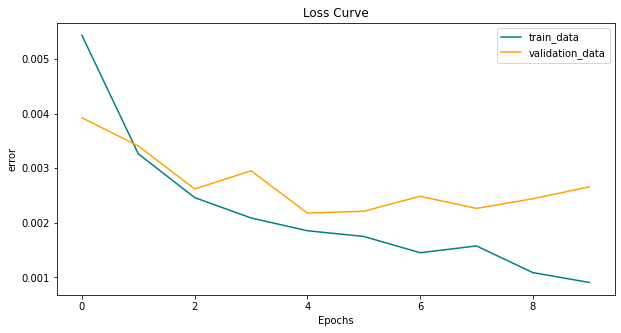

No handles with labels found to put in legend.


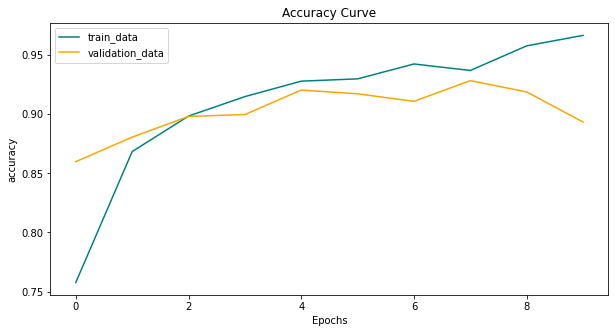

In [0]:
plot_curves("Loss Curve","error",train_error,val_error)
plot_curves("Accuracy Curve","accuracy",train_acc,val_acc)

### VGG16 Model

**Loading pre-trained model of VGG-18 for ImageNet**

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

**Replacing Previous FC Layers with new ones**

In [0]:
features = list()
features.extend([nn.Linear(25088,4096)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear(4096,4096)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear(4096,3)])

vgg16.classifier = nn.Sequential(*features)

In [0]:
# print(vgg16)

**Loss function and optimizer**

In [0]:
Epochs = 10
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()
train_error=[]
val_error=[]
train_acc=[]
val_acc=[]

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    running_corrects = 0.0
    num_images = 0

    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # print("LABELS\n",labels.shape)
        labels = torch.nn.functional.one_hot(labels, 3)
        labels = labels.float()
        labels[:,2]=labels[:,2]+labels[:,0] #setting pnemounia true for all COVID labeled records
        num_images = num_images+inputs.size(0)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        
        # print("\nlabels type: ",labels.shape)
        # print("\nlabels : ",labels)
#--------------------------------------------------------------------
        loss = criterion(outputs, labels)   #----> compute loss
        # print("\noutput type: ",loss.shape)
        # print("\noutputs : ",loss)
        
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        # print("loss type",loss.data)
        # print("outputs: ",outputs)
        
        ## _, preds = torch.max(outputs, 1)
        
        # print statistics
        preds = get_preds(outputs,0.5)
        # compare_preds_labels(preds,labels,3)

        running_loss += loss.item()

        # running_loss += hamming_loss(labels,preds)

        # print("labels.shape: ",labels)
        # preds = preds.view(8,1)
        # preds = torch.nn.functional.one_hot(preds, 3) #one hot vector for predictions
        # preds[:,2]=preds[:,2]+preds[:,0]
        # print("preds: ",preds)


        running_corrects += (preds==labels).prod(1).sum().item()
        print("running_corrects: ",running_corrects)
        # running_corrects += sum((preds == labels).all(axis=1)) #to get all correct predictions

        # print("preds: \n",preds)
        # print("labels: \n",labels)
        
        # print(running_corrects)
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        
    #train loss and accuracy
    epoch_loss = running_loss /num_images
    train_error.append(epoch_loss)
    epoch_acc = running_corrects / num_images
    train_acc.append(epoch_acc)

    #Validation loss and accuracy
    epoch_loss,epoch_acc = evaluate(vgg16)
    val_error.append(epoch_loss)
    val_acc.append(epoch_acc)

    print('train loss: {}\n train acc: {}\n valid loss: {}\n valid acc:{}'.format(
        train_error[epoch],train_acc[epoch],val_error[epoch],val_acc[epoch]))

    torch.save(vgg16.state_dict(), data_dir+'/vgg16_FC_Only_1.pth')

print('Finished Training')




0it [00:00, ?it/s]


Train Epoch: 0 [0/6200 (0%)]	Loss: 0.708403: : 0it [00:04, ?it/s]


Train Epoch: 0 [0/6200 (0%)]	Loss: 0.708403: : 1it [00:04,  4.79s/it]

running_corrects:  4.0





Train Epoch: 0 [64/6200 (1%)]	Loss: 0.690969: : 1it [00:05,  4.79s/it]


Train Epoch: 0 [64/6200 (1%)]	Loss: 0.690969: : 2it [00:05,  3.52s/it]

running_corrects:  12.0





Train Epoch: 0 [128/6200 (2%)]	Loss: 0.673903: : 2it [00:05,  3.52s/it]


Train Epoch: 0 [128/6200 (2%)]	Loss: 0.673903: : 3it [00:05,  2.63s/it]

running_corrects:  27.0





Train Epoch: 0 [192/6200 (3%)]	Loss: 0.662887: : 3it [00:06,  2.63s/it]


Train Epoch: 0 [192/6200 (3%)]	Loss: 0.662887: : 4it [00:06,  2.00s/it]

running_corrects:  49.0





Train Epoch: 0 [256/6200 (4%)]	Loss: 0.648138: : 4it [00:06,  2.00s/it]


Train Epoch: 0 [256/6200 (4%)]	Loss: 0.648138: : 5it [00:06,  1.57s/it]

running_corrects:  74.0





Train Epoch: 0 [320/6200 (5%)]	Loss: 0.623262: : 5it [00:09,  1.57s/it]


Train Epoch: 0 [320/6200 (5%)]	Loss: 0.623262: : 6it [00:09,  1.84s/it]

running_corrects:  114.0





Train Epoch: 0 [384/6200 (6%)]	Loss: 0.596062: : 6it [00:10,  1.84s/it]


Train Epoch: 0 [384/6200 (6%)]	Loss: 0.596062: : 7it [00:10,  1.48s/it]

running_corrects:  154.0





Train Epoch: 0 [448/6200 (7%)]	Loss: 0.570281: : 7it [00:10,  1.48s/it]


Train Epoch: 0 [448/6200 (7%)]	Loss: 0.570281: : 8it [00:10,  1.19s/it]

running_corrects:  197.0





Train Epoch: 0 [512/6200 (8%)]	Loss: 0.540317: : 8it [00:11,  1.19s/it]


Train Epoch: 0 [512/6200 (8%)]	Loss: 0.540317: : 9it [00:11,  1.01s/it]

running_corrects:  241.0





Train Epoch: 0 [576/6200 (9%)]	Loss: 0.540297: : 9it [00:11,  1.01s/it]


Train Epoch: 0 [576/6200 (9%)]	Loss: 0.540297: : 10it [00:11,  1.16it/s]

running_corrects:  280.0





Train Epoch: 0 [640/6200 (10%)]	Loss: 0.544828: : 10it [00:14,  1.16it/s]


Train Epoch: 0 [640/6200 (10%)]	Loss: 0.544828: : 11it [00:14,  1.55s/it]

running_corrects:  318.0





Train Epoch: 0 [704/6200 (11%)]	Loss: 0.510062: : 11it [00:15,  1.55s/it]


Train Epoch: 0 [704/6200 (11%)]	Loss: 0.510062: : 12it [00:15,  1.24s/it]

running_corrects:  357.0





Train Epoch: 0 [768/6200 (12%)]	Loss: 0.489357: : 12it [00:15,  1.24s/it]


Train Epoch: 0 [768/6200 (12%)]	Loss: 0.489357: : 13it [00:15,  1.03s/it]

running_corrects:  397.0





Train Epoch: 0 [832/6200 (13%)]	Loss: 0.555392: : 13it [00:16,  1.03s/it]


Train Epoch: 0 [832/6200 (13%)]	Loss: 0.555392: : 14it [00:16,  1.13it/s]

running_corrects:  430.0





Train Epoch: 0 [896/6200 (14%)]	Loss: 0.536415: : 14it [00:17,  1.13it/s]


Train Epoch: 0 [896/6200 (14%)]	Loss: 0.536415: : 15it [00:17,  1.27it/s]

running_corrects:  463.0





Train Epoch: 0 [960/6200 (15%)]	Loss: 0.470864: : 15it [00:20,  1.27it/s]


Train Epoch: 0 [960/6200 (15%)]	Loss: 0.470864: : 16it [00:20,  1.51s/it]

running_corrects:  502.0





Train Epoch: 0 [1024/6200 (16%)]	Loss: 0.424142: : 16it [00:20,  1.51s/it]


Train Epoch: 0 [1024/6200 (16%)]	Loss: 0.424142: : 17it [00:20,  1.23s/it]

running_corrects:  545.0





Train Epoch: 0 [1088/6200 (18%)]	Loss: 0.465222: : 17it [00:21,  1.23s/it]


Train Epoch: 0 [1088/6200 (18%)]	Loss: 0.465222: : 18it [00:21,  1.01s/it]

running_corrects:  587.0





Train Epoch: 0 [1152/6200 (19%)]	Loss: 0.446747: : 18it [00:21,  1.01s/it]


Train Epoch: 0 [1152/6200 (19%)]	Loss: 0.446747: : 19it [00:21,  1.14it/s]

running_corrects:  629.0





Train Epoch: 0 [1216/6200 (20%)]	Loss: 0.373273: : 19it [00:22,  1.14it/s]


Train Epoch: 0 [1216/6200 (20%)]	Loss: 0.373273: : 20it [00:22,  1.30it/s]

running_corrects:  675.0





Train Epoch: 0 [1280/6200 (21%)]	Loss: 0.439548: : 20it [00:26,  1.30it/s]


Train Epoch: 0 [1280/6200 (21%)]	Loss: 0.439548: : 21it [00:26,  1.78s/it]

running_corrects:  717.0





Train Epoch: 0 [1344/6200 (22%)]	Loss: 0.364305: : 21it [00:27,  1.78s/it]


Train Epoch: 0 [1344/6200 (22%)]	Loss: 0.364305: : 22it [00:27,  1.40s/it]

running_corrects:  764.0





Train Epoch: 0 [1408/6200 (23%)]	Loss: 0.440563: : 22it [00:27,  1.40s/it]


Train Epoch: 0 [1408/6200 (23%)]	Loss: 0.440563: : 23it [00:27,  1.15s/it]

running_corrects:  804.0





Train Epoch: 0 [1472/6200 (24%)]	Loss: 0.471445: : 23it [00:28,  1.15s/it]


Train Epoch: 0 [1472/6200 (24%)]	Loss: 0.471445: : 24it [00:28,  1.04it/s]

running_corrects:  840.0





Train Epoch: 0 [1536/6200 (25%)]	Loss: 0.615537: : 24it [00:28,  1.04it/s]


Train Epoch: 0 [1536/6200 (25%)]	Loss: 0.615537: : 25it [00:28,  1.19it/s]

running_corrects:  869.0





Train Epoch: 0 [1600/6200 (26%)]	Loss: 0.364439: : 25it [00:31,  1.19it/s]


Train Epoch: 0 [1600/6200 (26%)]	Loss: 0.364439: : 26it [00:31,  1.35s/it]

running_corrects:  912.0





Train Epoch: 0 [1664/6200 (27%)]	Loss: 0.403856: : 26it [00:31,  1.35s/it]


Train Epoch: 0 [1664/6200 (27%)]	Loss: 0.403856: : 27it [00:31,  1.12s/it]

running_corrects:  950.0





Train Epoch: 0 [1728/6200 (28%)]	Loss: 0.455792: : 27it [00:32,  1.12s/it]


Train Epoch: 0 [1728/6200 (28%)]	Loss: 0.455792: : 28it [00:32,  1.06it/s]

running_corrects:  986.0





Train Epoch: 0 [1792/6200 (29%)]	Loss: 0.430910: : 28it [00:32,  1.06it/s]


Train Epoch: 0 [1792/6200 (29%)]	Loss: 0.430910: : 29it [00:32,  1.20it/s]

running_corrects:  1028.0





Train Epoch: 0 [1856/6200 (30%)]	Loss: 0.465437: : 29it [00:33,  1.20it/s]


Train Epoch: 0 [1856/6200 (30%)]	Loss: 0.465437: : 30it [00:33,  1.34it/s]

running_corrects:  1064.0





Train Epoch: 0 [1920/6200 (31%)]	Loss: 0.376998: : 30it [00:36,  1.34it/s]


Train Epoch: 0 [1920/6200 (31%)]	Loss: 0.376998: : 31it [00:36,  1.38s/it]

running_corrects:  1108.0





Train Epoch: 0 [1984/6200 (32%)]	Loss: 0.459317: : 31it [00:36,  1.38s/it]


Train Epoch: 0 [1984/6200 (32%)]	Loss: 0.459317: : 32it [00:36,  1.13s/it]

running_corrects:  1152.0





Train Epoch: 0 [2048/6200 (33%)]	Loss: 0.374714: : 32it [00:37,  1.13s/it]


Train Epoch: 0 [2048/6200 (33%)]	Loss: 0.374714: : 33it [00:37,  1.04it/s]

running_corrects:  1199.0





Train Epoch: 0 [2112/6200 (34%)]	Loss: 0.374654: : 33it [00:37,  1.04it/s]


Train Epoch: 0 [2112/6200 (34%)]	Loss: 0.374654: : 34it [00:37,  1.20it/s]

running_corrects:  1242.0





Train Epoch: 0 [2176/6200 (35%)]	Loss: 0.431348: : 34it [00:38,  1.20it/s]


Train Epoch: 0 [2176/6200 (35%)]	Loss: 0.431348: : 35it [00:38,  1.32it/s]

running_corrects:  1288.0





Train Epoch: 0 [2240/6200 (36%)]	Loss: 0.414819: : 35it [00:41,  1.32it/s]


Train Epoch: 0 [2240/6200 (36%)]	Loss: 0.414819: : 36it [00:41,  1.38s/it]

running_corrects:  1337.0





Train Epoch: 0 [2304/6200 (37%)]	Loss: 0.443201: : 36it [00:41,  1.38s/it]


Train Epoch: 0 [2304/6200 (37%)]	Loss: 0.443201: : 37it [00:41,  1.14s/it]

running_corrects:  1382.0





Train Epoch: 0 [2368/6200 (38%)]	Loss: 0.406692: : 37it [00:42,  1.14s/it]


Train Epoch: 0 [2368/6200 (38%)]	Loss: 0.406692: : 38it [00:42,  1.05it/s]

running_corrects:  1431.0





Train Epoch: 0 [2432/6200 (39%)]	Loss: 0.338405: : 38it [00:43,  1.05it/s]


Train Epoch: 0 [2432/6200 (39%)]	Loss: 0.338405: : 39it [00:43,  1.19it/s]

running_corrects:  1481.0





Train Epoch: 0 [2496/6200 (40%)]	Loss: 0.376847: : 39it [00:43,  1.19it/s]


Train Epoch: 0 [2496/6200 (40%)]	Loss: 0.376847: : 40it [00:43,  1.34it/s]

running_corrects:  1527.0





Train Epoch: 0 [2560/6200 (41%)]	Loss: 0.387624: : 40it [00:46,  1.34it/s]


Train Epoch: 0 [2560/6200 (41%)]	Loss: 0.387624: : 41it [00:46,  1.50s/it]

running_corrects:  1568.0





Train Epoch: 0 [2624/6200 (42%)]	Loss: 0.392595: : 41it [00:47,  1.50s/it]


Train Epoch: 0 [2624/6200 (42%)]	Loss: 0.392595: : 42it [00:47,  1.20s/it]

running_corrects:  1609.0





Train Epoch: 0 [2688/6200 (43%)]	Loss: 0.286700: : 42it [00:47,  1.20s/it]


Train Epoch: 0 [2688/6200 (43%)]	Loss: 0.286700: : 43it [00:47,  1.02s/it]

running_corrects:  1658.0





Train Epoch: 0 [2752/6200 (44%)]	Loss: 0.382518: : 43it [00:48,  1.02s/it]


Train Epoch: 0 [2752/6200 (44%)]	Loss: 0.382518: : 44it [00:48,  1.15it/s]

running_corrects:  1700.0





Train Epoch: 0 [2816/6200 (45%)]	Loss: 0.301533: : 44it [00:49,  1.15it/s]


Train Epoch: 0 [2816/6200 (45%)]	Loss: 0.301533: : 45it [00:49,  1.27it/s]

running_corrects:  1749.0





Train Epoch: 0 [2880/6200 (46%)]	Loss: 0.331888: : 45it [00:52,  1.27it/s]


Train Epoch: 0 [2880/6200 (46%)]	Loss: 0.331888: : 46it [00:52,  1.62s/it]

running_corrects:  1797.0





Train Epoch: 0 [2944/6200 (47%)]	Loss: 0.393134: : 46it [00:53,  1.62s/it]


Train Epoch: 0 [2944/6200 (47%)]	Loss: 0.393134: : 47it [00:53,  1.30s/it]

running_corrects:  1846.0





Train Epoch: 0 [3008/6200 (48%)]	Loss: 0.305602: : 47it [00:53,  1.30s/it]


Train Epoch: 0 [3008/6200 (48%)]	Loss: 0.305602: : 48it [00:53,  1.07s/it]

running_corrects:  1897.0





Train Epoch: 0 [3072/6200 (49%)]	Loss: 0.291184: : 48it [00:54,  1.07s/it]


Train Epoch: 0 [3072/6200 (49%)]	Loss: 0.291184: : 49it [00:54,  1.09it/s]

running_corrects:  1950.0





Train Epoch: 0 [3136/6200 (51%)]	Loss: 0.327189: : 49it [00:54,  1.09it/s]


Train Epoch: 0 [3136/6200 (51%)]	Loss: 0.327189: : 50it [00:54,  1.25it/s]

running_corrects:  1996.0





Train Epoch: 0 [3200/6200 (52%)]	Loss: 0.379273: : 50it [00:57,  1.25it/s]


Train Epoch: 0 [3200/6200 (52%)]	Loss: 0.379273: : 51it [00:57,  1.27s/it]

running_corrects:  2047.0





Train Epoch: 0 [3264/6200 (53%)]	Loss: 0.327646: : 51it [00:57,  1.27s/it]


Train Epoch: 0 [3264/6200 (53%)]	Loss: 0.327646: : 52it [00:57,  1.05s/it]

running_corrects:  2100.0





Train Epoch: 0 [3328/6200 (54%)]	Loss: 0.300532: : 52it [00:58,  1.05s/it]


Train Epoch: 0 [3328/6200 (54%)]	Loss: 0.300532: : 53it [00:58,  1.10it/s]

running_corrects:  2152.0





Train Epoch: 0 [3392/6200 (55%)]	Loss: 0.317031: : 53it [00:58,  1.10it/s]


Train Epoch: 0 [3392/6200 (55%)]	Loss: 0.317031: : 54it [00:58,  1.26it/s]

running_corrects:  2204.0





Train Epoch: 0 [3456/6200 (56%)]	Loss: 0.310831: : 54it [00:59,  1.26it/s]


Train Epoch: 0 [3456/6200 (56%)]	Loss: 0.310831: : 55it [00:59,  1.37it/s]

running_corrects:  2256.0





Train Epoch: 0 [3520/6200 (57%)]	Loss: 0.284438: : 55it [01:01,  1.37it/s]


Train Epoch: 0 [3520/6200 (57%)]	Loss: 0.284438: : 56it [01:01,  1.26s/it]

running_corrects:  2313.0





Train Epoch: 0 [3584/6200 (58%)]	Loss: 0.287989: : 56it [01:02,  1.26s/it]


Train Epoch: 0 [3584/6200 (58%)]	Loss: 0.287989: : 57it [01:02,  1.06s/it]

running_corrects:  2368.0





Train Epoch: 0 [3648/6200 (59%)]	Loss: 0.341856: : 57it [01:03,  1.06s/it]


Train Epoch: 0 [3648/6200 (59%)]	Loss: 0.341856: : 58it [01:03,  1.10it/s]

running_corrects:  2420.0





Train Epoch: 0 [3712/6200 (60%)]	Loss: 0.308300: : 58it [01:03,  1.10it/s]


Train Epoch: 0 [3712/6200 (60%)]	Loss: 0.308300: : 59it [01:03,  1.25it/s]

running_corrects:  2472.0





Train Epoch: 0 [3776/6200 (61%)]	Loss: 0.315961: : 59it [01:04,  1.25it/s]


Train Epoch: 0 [3776/6200 (61%)]	Loss: 0.315961: : 60it [01:04,  1.39it/s]

running_corrects:  2521.0





Train Epoch: 0 [3840/6200 (62%)]	Loss: 0.216585: : 60it [01:06,  1.39it/s]


Train Epoch: 0 [3840/6200 (62%)]	Loss: 0.216585: : 61it [01:06,  1.30s/it]

running_corrects:  2577.0





Train Epoch: 0 [3904/6200 (63%)]	Loss: 0.219028: : 61it [01:07,  1.30s/it]


Train Epoch: 0 [3904/6200 (63%)]	Loss: 0.219028: : 62it [01:07,  1.07s/it]

running_corrects:  2633.0





Train Epoch: 0 [3968/6200 (64%)]	Loss: 0.279196: : 62it [01:07,  1.07s/it]


Train Epoch: 0 [3968/6200 (64%)]	Loss: 0.279196: : 63it [01:07,  1.09it/s]

running_corrects:  2686.0





Train Epoch: 0 [4032/6200 (65%)]	Loss: 0.463041: : 63it [01:08,  1.09it/s]


Train Epoch: 0 [4032/6200 (65%)]	Loss: 0.463041: : 64it [01:08,  1.24it/s]

running_corrects:  2734.0





Train Epoch: 0 [4096/6200 (66%)]	Loss: 0.258067: : 64it [01:08,  1.24it/s]


Train Epoch: 0 [4096/6200 (66%)]	Loss: 0.258067: : 65it [01:08,  1.36it/s]

running_corrects:  2793.0





Train Epoch: 0 [4160/6200 (67%)]	Loss: 0.255930: : 65it [01:11,  1.36it/s]


Train Epoch: 0 [4160/6200 (67%)]	Loss: 0.255930: : 66it [01:11,  1.24s/it]

running_corrects:  2847.0





Train Epoch: 0 [4224/6200 (68%)]	Loss: 0.325433: : 66it [01:11,  1.24s/it]


Train Epoch: 0 [4224/6200 (68%)]	Loss: 0.325433: : 67it [01:11,  1.04s/it]

running_corrects:  2899.0





Train Epoch: 0 [4288/6200 (69%)]	Loss: 0.202241: : 67it [01:12,  1.04s/it]


Train Epoch: 0 [4288/6200 (69%)]	Loss: 0.202241: : 68it [01:12,  1.13it/s]

running_corrects:  2955.0





Train Epoch: 0 [4352/6200 (70%)]	Loss: 0.244625: : 68it [01:13,  1.13it/s]


Train Epoch: 0 [4352/6200 (70%)]	Loss: 0.244625: : 69it [01:13,  1.26it/s]

running_corrects:  3009.0





Train Epoch: 0 [4416/6200 (71%)]	Loss: 0.209688: : 69it [01:13,  1.26it/s]


Train Epoch: 0 [4416/6200 (71%)]	Loss: 0.209688: : 70it [01:13,  1.41it/s]

running_corrects:  3065.0





Train Epoch: 0 [4480/6200 (72%)]	Loss: 0.288726: : 70it [01:16,  1.41it/s]


Train Epoch: 0 [4480/6200 (72%)]	Loss: 0.288726: : 71it [01:16,  1.30s/it]

running_corrects:  3118.0





Train Epoch: 0 [4544/6200 (73%)]	Loss: 0.279209: : 71it [01:16,  1.30s/it]


Train Epoch: 0 [4544/6200 (73%)]	Loss: 0.279209: : 72it [01:16,  1.08s/it]

running_corrects:  3169.0





Train Epoch: 0 [4608/6200 (74%)]	Loss: 0.200729: : 72it [01:17,  1.08s/it]


Train Epoch: 0 [4608/6200 (74%)]	Loss: 0.200729: : 73it [01:17,  1.09it/s]

running_corrects:  3226.0





Train Epoch: 0 [4672/6200 (75%)]	Loss: 0.352002: : 73it [01:17,  1.09it/s]


Train Epoch: 0 [4672/6200 (75%)]	Loss: 0.352002: : 74it [01:17,  1.25it/s]

running_corrects:  3275.0





Train Epoch: 0 [4736/6200 (76%)]	Loss: 0.315132: : 74it [01:18,  1.25it/s]


Train Epoch: 0 [4736/6200 (76%)]	Loss: 0.315132: : 75it [01:18,  1.37it/s]

running_corrects:  3327.0





Train Epoch: 0 [4800/6200 (77%)]	Loss: 0.272245: : 75it [01:20,  1.37it/s]


Train Epoch: 0 [4800/6200 (77%)]	Loss: 0.272245: : 76it [01:20,  1.21s/it]

running_corrects:  3376.0





Train Epoch: 0 [4864/6200 (78%)]	Loss: 0.288860: : 76it [01:21,  1.21s/it]


Train Epoch: 0 [4864/6200 (78%)]	Loss: 0.288860: : 77it [01:21,  1.02s/it]

running_corrects:  3430.0





Train Epoch: 0 [4928/6200 (79%)]	Loss: 0.287947: : 77it [01:21,  1.02s/it]


Train Epoch: 0 [4928/6200 (79%)]	Loss: 0.287947: : 78it [01:21,  1.15it/s]

running_corrects:  3484.0





Train Epoch: 0 [4992/6200 (80%)]	Loss: 0.393813: : 78it [01:22,  1.15it/s]


Train Epoch: 0 [4992/6200 (80%)]	Loss: 0.393813: : 79it [01:22,  1.29it/s]

running_corrects:  3530.0





Train Epoch: 0 [5056/6200 (81%)]	Loss: 0.225112: : 79it [01:22,  1.29it/s]


Train Epoch: 0 [5056/6200 (81%)]	Loss: 0.225112: : 80it [01:22,  1.43it/s]

running_corrects:  3584.0





Train Epoch: 0 [5120/6200 (82%)]	Loss: 0.267511: : 80it [01:26,  1.43it/s]


Train Epoch: 0 [5120/6200 (82%)]	Loss: 0.267511: : 81it [01:26,  1.54s/it]

running_corrects:  3636.0





Train Epoch: 0 [5184/6200 (84%)]	Loss: 0.284043: : 81it [01:27,  1.54s/it]


Train Epoch: 0 [5184/6200 (84%)]	Loss: 0.284043: : 82it [01:27,  1.24s/it]

running_corrects:  3688.0





Train Epoch: 0 [5248/6200 (85%)]	Loss: 0.238168: : 82it [01:27,  1.24s/it]


Train Epoch: 0 [5248/6200 (85%)]	Loss: 0.238168: : 83it [01:27,  1.03s/it]

running_corrects:  3743.0





Train Epoch: 0 [5312/6200 (86%)]	Loss: 0.237793: : 83it [01:28,  1.03s/it]


Train Epoch: 0 [5312/6200 (86%)]	Loss: 0.237793: : 84it [01:28,  1.14it/s]

running_corrects:  3798.0





Train Epoch: 0 [5376/6200 (87%)]	Loss: 0.199343: : 84it [01:28,  1.14it/s]


Train Epoch: 0 [5376/6200 (87%)]	Loss: 0.199343: : 85it [01:28,  1.27it/s]

running_corrects:  3854.0





Train Epoch: 0 [5440/6200 (88%)]	Loss: 0.293306: : 85it [01:32,  1.27it/s]


Train Epoch: 0 [5440/6200 (88%)]	Loss: 0.293306: : 86it [01:32,  1.56s/it]

running_corrects:  3902.0





Train Epoch: 0 [5504/6200 (89%)]	Loss: 0.184402: : 86it [01:32,  1.56s/it]


Train Epoch: 0 [5504/6200 (89%)]	Loss: 0.184402: : 87it [01:32,  1.26s/it]

running_corrects:  3959.0





Train Epoch: 0 [5568/6200 (90%)]	Loss: 0.212257: : 87it [01:33,  1.26s/it]


Train Epoch: 0 [5568/6200 (90%)]	Loss: 0.212257: : 88it [01:33,  1.04s/it]

running_corrects:  4013.0





Train Epoch: 0 [5632/6200 (91%)]	Loss: 0.218088: : 88it [01:33,  1.04s/it]


Train Epoch: 0 [5632/6200 (91%)]	Loss: 0.218088: : 89it [01:33,  1.13it/s]

running_corrects:  4070.0





Train Epoch: 0 [5696/6200 (92%)]	Loss: 0.281707: : 89it [01:34,  1.13it/s]


Train Epoch: 0 [5696/6200 (92%)]	Loss: 0.281707: : 90it [01:34,  1.30it/s]

running_corrects:  4124.0





Train Epoch: 0 [5760/6200 (93%)]	Loss: 0.332600: : 90it [01:35,  1.30it/s]


Train Epoch: 0 [5760/6200 (93%)]	Loss: 0.332600: : 91it [01:35,  1.14it/s]

running_corrects:  4175.0





Train Epoch: 0 [5824/6200 (94%)]	Loss: 0.256055: : 91it [01:35,  1.14it/s]


Train Epoch: 0 [5824/6200 (94%)]	Loss: 0.256055: : 92it [01:35,  1.30it/s]

running_corrects:  4232.0





Train Epoch: 0 [5888/6200 (95%)]	Loss: 0.197234: : 92it [01:36,  1.30it/s]


Train Epoch: 0 [5888/6200 (95%)]	Loss: 0.197234: : 93it [01:36,  1.45it/s]

running_corrects:  4288.0





Train Epoch: 0 [5952/6200 (96%)]	Loss: 0.178061: : 93it [01:36,  1.45it/s]


Train Epoch: 0 [5952/6200 (96%)]	Loss: 0.178061: : 94it [01:36,  1.57it/s]

running_corrects:  4347.0





Train Epoch: 0 [6016/6200 (97%)]	Loss: 0.129734: : 94it [01:37,  1.57it/s]


Train Epoch: 0 [6016/6200 (97%)]	Loss: 0.129734: : 95it [01:37,  1.68it/s]

running_corrects:  4408.0





Train Epoch: 0 [6080/6200 (98%)]	Loss: 0.163598: : 95it [01:37,  1.68it/s]


Train Epoch: 0 [6080/6200 (98%)]	Loss: 0.163598: : 96it [01:37,  1.78it/s]

running_corrects:  4464.0





Train Epoch: 0 [5376/6200 (99%)]	Loss: 0.271152: : 96it [01:38,  1.78it/s]


Train Epoch: 0 [5376/6200 (99%)]	Loss: 0.271152: : 97it [01:38,  1.01s/it]

running_corrects:  4508.0






0it [00:00, ?it/s]


1it [00:04,  4.48s/it]


2it [00:04,  3.20s/it]


3it [00:04,  2.31s/it]


4it [00:05,  1.68s/it]


5it [00:05,  1.25s/it]


6it [00:09,  2.05s/it]


7it [00:09,  1.49s/it]


8it [00:09,  1.09s/it]


9it [00:09,  1.23it/s]


10it [00:10,  1.01s/it]


train loss: 0.005744537355438355
 train acc: 0.7270967741935483
 valid loss: 0.0034006499703143054
 valid acc:0.8646496815286624





0it [00:00, ?it/s]


Train Epoch: 1 [0/6200 (0%)]	Loss: 0.267112: : 0it [00:04, ?it/s]


Train Epoch: 1 [0/6200 (0%)]	Loss: 0.267112: : 1it [00:04,  4.68s/it]

running_corrects:  53.0





Train Epoch: 1 [64/6200 (1%)]	Loss: 0.159575: : 1it [00:05,  4.68s/it]


Train Epoch: 1 [64/6200 (1%)]	Loss: 0.159575: : 2it [00:05,  3.44s/it]

running_corrects:  112.0





Train Epoch: 1 [128/6200 (2%)]	Loss: 0.225471: : 2it [00:06,  3.44s/it]


Train Epoch: 1 [128/6200 (2%)]	Loss: 0.225471: : 3it [00:06,  2.81s/it]

running_corrects:  168.0





Train Epoch: 1 [192/6200 (3%)]	Loss: 0.215125: : 3it [00:07,  2.81s/it]


Train Epoch: 1 [192/6200 (3%)]	Loss: 0.215125: : 4it [00:07,  2.12s/it]

running_corrects:  222.0





Train Epoch: 1 [256/6200 (4%)]	Loss: 0.224506: : 4it [00:07,  2.12s/it]


Train Epoch: 1 [256/6200 (4%)]	Loss: 0.224506: : 5it [00:07,  1.65s/it]

running_corrects:  277.0





Train Epoch: 1 [320/6200 (5%)]	Loss: 0.191646: : 5it [00:10,  1.65s/it]


Train Epoch: 1 [320/6200 (5%)]	Loss: 0.191646: : 6it [00:10,  1.94s/it]

running_corrects:  333.0





Train Epoch: 1 [384/6200 (6%)]	Loss: 0.296627: : 6it [00:10,  1.94s/it]


Train Epoch: 1 [384/6200 (6%)]	Loss: 0.296627: : 7it [00:10,  1.54s/it]

running_corrects:  386.0





Train Epoch: 1 [448/6200 (7%)]	Loss: 0.178996: : 7it [00:12,  1.54s/it]


Train Epoch: 1 [448/6200 (7%)]	Loss: 0.178996: : 8it [00:12,  1.44s/it]

running_corrects:  443.0





Train Epoch: 1 [512/6200 (8%)]	Loss: 0.139791: : 8it [00:12,  1.44s/it]


Train Epoch: 1 [512/6200 (8%)]	Loss: 0.139791: : 9it [00:12,  1.19s/it]

running_corrects:  501.0





Train Epoch: 1 [576/6200 (9%)]	Loss: 0.189388: : 9it [00:13,  1.19s/it]


Train Epoch: 1 [576/6200 (9%)]	Loss: 0.189388: : 10it [00:13,  1.01s/it]

running_corrects:  559.0





Train Epoch: 1 [640/6200 (10%)]	Loss: 0.261075: : 10it [00:16,  1.01s/it]


Train Epoch: 1 [640/6200 (10%)]	Loss: 0.261075: : 11it [00:16,  1.81s/it]

running_corrects:  613.0





Train Epoch: 1 [704/6200 (11%)]	Loss: 0.095587: : 11it [00:17,  1.81s/it]


Train Epoch: 1 [704/6200 (11%)]	Loss: 0.095587: : 12it [00:17,  1.44s/it]

running_corrects:  673.0





Train Epoch: 1 [768/6200 (12%)]	Loss: 0.267093: : 12it [00:19,  1.44s/it]


Train Epoch: 1 [768/6200 (12%)]	Loss: 0.267093: : 13it [00:19,  1.71s/it]

running_corrects:  727.0





Train Epoch: 1 [832/6200 (13%)]	Loss: 0.128572: : 13it [00:20,  1.71s/it]


Train Epoch: 1 [832/6200 (13%)]	Loss: 0.128572: : 14it [00:20,  1.36s/it]

running_corrects:  786.0





Train Epoch: 1 [896/6200 (14%)]	Loss: 0.196671: : 14it [00:20,  1.36s/it]


Train Epoch: 1 [896/6200 (14%)]	Loss: 0.196671: : 15it [00:20,  1.13s/it]

running_corrects:  840.0





Train Epoch: 1 [960/6200 (15%)]	Loss: 0.230996: : 15it [00:23,  1.13s/it]


Train Epoch: 1 [960/6200 (15%)]	Loss: 0.230996: : 16it [00:23,  1.48s/it]

running_corrects:  892.0





Train Epoch: 1 [1024/6200 (16%)]	Loss: 0.214358: : 16it [00:24,  1.48s/it]


Train Epoch: 1 [1024/6200 (16%)]	Loss: 0.214358: : 17it [00:24,  1.38s/it]

running_corrects:  946.0





Train Epoch: 1 [1088/6200 (18%)]	Loss: 0.278428: : 17it [00:25,  1.38s/it]


Train Epoch: 1 [1088/6200 (18%)]	Loss: 0.278428: : 18it [00:25,  1.24s/it]

running_corrects:  1002.0





Train Epoch: 1 [1152/6200 (19%)]	Loss: 0.189611: : 18it [00:25,  1.24s/it]


Train Epoch: 1 [1152/6200 (19%)]	Loss: 0.189611: : 19it [00:25,  1.04s/it]

running_corrects:  1058.0





Train Epoch: 1 [1216/6200 (20%)]	Loss: 0.174837: : 19it [00:26,  1.04s/it]


Train Epoch: 1 [1216/6200 (20%)]	Loss: 0.174837: : 20it [00:26,  1.13it/s]

running_corrects:  1114.0





Train Epoch: 1 [1280/6200 (21%)]	Loss: 0.194231: : 20it [00:28,  1.13it/s]


Train Epoch: 1 [1280/6200 (21%)]	Loss: 0.194231: : 21it [00:28,  1.23s/it]

running_corrects:  1171.0





Train Epoch: 1 [1344/6200 (22%)]	Loss: 0.194257: : 21it [00:29,  1.23s/it]


Train Epoch: 1 [1344/6200 (22%)]	Loss: 0.194257: : 22it [00:29,  1.12s/it]

running_corrects:  1228.0





Train Epoch: 1 [1408/6200 (23%)]	Loss: 0.184526: : 22it [00:29,  1.12s/it]


Train Epoch: 1 [1408/6200 (23%)]	Loss: 0.184526: : 23it [00:29,  1.05it/s]

running_corrects:  1286.0





Train Epoch: 1 [1472/6200 (24%)]	Loss: 0.105822: : 23it [00:30,  1.05it/s]


Train Epoch: 1 [1472/6200 (24%)]	Loss: 0.105822: : 24it [00:30,  1.21it/s]

running_corrects:  1345.0





Train Epoch: 1 [1536/6200 (25%)]	Loss: 0.204808: : 24it [00:31,  1.21it/s]


Train Epoch: 1 [1536/6200 (25%)]	Loss: 0.204808: : 25it [00:31,  1.34it/s]

running_corrects:  1398.0





Train Epoch: 1 [1600/6200 (26%)]	Loss: 0.203176: : 25it [00:33,  1.34it/s]


Train Epoch: 1 [1600/6200 (26%)]	Loss: 0.203176: : 26it [00:33,  1.13s/it]

running_corrects:  1454.0





Train Epoch: 1 [1664/6200 (27%)]	Loss: 0.137112: : 26it [00:35,  1.13s/it]


Train Epoch: 1 [1664/6200 (27%)]	Loss: 0.137112: : 27it [00:35,  1.56s/it]

running_corrects:  1513.0





Train Epoch: 1 [1728/6200 (28%)]	Loss: 0.186958: : 27it [00:36,  1.56s/it]


Train Epoch: 1 [1728/6200 (28%)]	Loss: 0.186958: : 28it [00:36,  1.25s/it]

running_corrects:  1570.0





Train Epoch: 1 [1792/6200 (29%)]	Loss: 0.191666: : 28it [00:36,  1.25s/it]


Train Epoch: 1 [1792/6200 (29%)]	Loss: 0.191666: : 29it [00:36,  1.04s/it]

running_corrects:  1626.0





Train Epoch: 1 [1856/6200 (30%)]	Loss: 0.137234: : 29it [00:37,  1.04s/it]


Train Epoch: 1 [1856/6200 (30%)]	Loss: 0.137234: : 30it [00:37,  1.13it/s]

running_corrects:  1684.0





Train Epoch: 1 [1920/6200 (31%)]	Loss: 0.185988: : 30it [00:37,  1.13it/s]


Train Epoch: 1 [1920/6200 (31%)]	Loss: 0.185988: : 31it [00:37,  1.17it/s]

running_corrects:  1740.0





Train Epoch: 1 [1984/6200 (32%)]	Loss: 0.149512: : 31it [00:40,  1.17it/s]


Train Epoch: 1 [1984/6200 (32%)]	Loss: 0.149512: : 32it [00:40,  1.24s/it]

running_corrects:  1798.0





Train Epoch: 1 [2048/6200 (33%)]	Loss: 0.139728: : 32it [00:40,  1.24s/it]


Train Epoch: 1 [2048/6200 (33%)]	Loss: 0.139728: : 33it [00:40,  1.03s/it]

running_corrects:  1856.0





Train Epoch: 1 [2112/6200 (34%)]	Loss: 0.191333: : 33it [00:41,  1.03s/it]


Train Epoch: 1 [2112/6200 (34%)]	Loss: 0.191333: : 34it [00:41,  1.13it/s]

running_corrects:  1908.0





Train Epoch: 1 [2176/6200 (35%)]	Loss: 0.244288: : 34it [00:41,  1.13it/s]


Train Epoch: 1 [2176/6200 (35%)]	Loss: 0.244288: : 35it [00:41,  1.26it/s]

running_corrects:  1960.0





Train Epoch: 1 [2240/6200 (36%)]	Loss: 0.293181: : 35it [00:42,  1.26it/s]


Train Epoch: 1 [2240/6200 (36%)]	Loss: 0.293181: : 36it [00:42,  1.13it/s]

running_corrects:  2016.0





Train Epoch: 1 [2304/6200 (37%)]	Loss: 0.170786: : 36it [00:45,  1.13it/s]


Train Epoch: 1 [2304/6200 (37%)]	Loss: 0.170786: : 37it [00:45,  1.33s/it]

running_corrects:  2072.0





Train Epoch: 1 [2368/6200 (38%)]	Loss: 0.163861: : 37it [00:45,  1.33s/it]


Train Epoch: 1 [2368/6200 (38%)]	Loss: 0.163861: : 38it [00:45,  1.09s/it]

running_corrects:  2129.0





Train Epoch: 1 [2432/6200 (39%)]	Loss: 0.233529: : 38it [00:46,  1.09s/it]


Train Epoch: 1 [2432/6200 (39%)]	Loss: 0.233529: : 39it [00:46,  1.06it/s]

running_corrects:  2182.0





Train Epoch: 1 [2496/6200 (40%)]	Loss: 0.142346: : 39it [00:46,  1.06it/s]


Train Epoch: 1 [2496/6200 (40%)]	Loss: 0.142346: : 40it [00:46,  1.23it/s]

running_corrects:  2241.0





Train Epoch: 1 [2560/6200 (41%)]	Loss: 0.115354: : 40it [00:47,  1.23it/s]


Train Epoch: 1 [2560/6200 (41%)]	Loss: 0.115354: : 41it [00:47,  1.31it/s]

running_corrects:  2303.0





Train Epoch: 1 [2624/6200 (42%)]	Loss: 0.238531: : 41it [00:51,  1.31it/s]


Train Epoch: 1 [2624/6200 (42%)]	Loss: 0.238531: : 42it [00:51,  1.73s/it]

running_corrects:  2358.0





Train Epoch: 1 [2688/6200 (43%)]	Loss: 0.142068: : 42it [00:52,  1.73s/it]


Train Epoch: 1 [2688/6200 (43%)]	Loss: 0.142068: : 43it [00:52,  1.38s/it]

running_corrects:  2416.0





Train Epoch: 1 [2752/6200 (44%)]	Loss: 0.139344: : 43it [00:52,  1.38s/it]


Train Epoch: 1 [2752/6200 (44%)]	Loss: 0.139344: : 44it [00:52,  1.12s/it]

running_corrects:  2473.0





Train Epoch: 1 [2816/6200 (45%)]	Loss: 0.116732: : 44it [00:53,  1.12s/it]


Train Epoch: 1 [2816/6200 (45%)]	Loss: 0.116732: : 45it [00:53,  1.04it/s]

running_corrects:  2533.0





Train Epoch: 1 [2880/6200 (46%)]	Loss: 0.227506: : 45it [00:53,  1.04it/s]


Train Epoch: 1 [2880/6200 (46%)]	Loss: 0.227506: : 46it [00:53,  1.21it/s]

running_corrects:  2588.0





Train Epoch: 1 [2944/6200 (47%)]	Loss: 0.141916: : 46it [00:55,  1.21it/s]


Train Epoch: 1 [2944/6200 (47%)]	Loss: 0.141916: : 47it [00:55,  1.21s/it]

running_corrects:  2646.0





Train Epoch: 1 [3008/6200 (48%)]	Loss: 0.181489: : 47it [00:56,  1.21s/it]


Train Epoch: 1 [3008/6200 (48%)]	Loss: 0.181489: : 48it [00:56,  1.01s/it]

running_corrects:  2703.0





Train Epoch: 1 [3072/6200 (49%)]	Loss: 0.241860: : 48it [00:56,  1.01s/it]


Train Epoch: 1 [3072/6200 (49%)]	Loss: 0.241860: : 49it [00:56,  1.13it/s]

running_corrects:  2758.0





Train Epoch: 1 [3136/6200 (51%)]	Loss: 0.149376: : 49it [00:57,  1.13it/s]


Train Epoch: 1 [3136/6200 (51%)]	Loss: 0.149376: : 50it [00:57,  1.28it/s]

running_corrects:  2817.0





Train Epoch: 1 [3200/6200 (52%)]	Loss: 0.217816: : 50it [00:58,  1.28it/s]


Train Epoch: 1 [3200/6200 (52%)]	Loss: 0.217816: : 51it [00:58,  1.40it/s]

running_corrects:  2873.0





Train Epoch: 1 [3264/6200 (53%)]	Loss: 0.279990: : 51it [01:00,  1.40it/s]


Train Epoch: 1 [3264/6200 (53%)]	Loss: 0.279990: : 52it [01:00,  1.29s/it]

running_corrects:  2928.0





Train Epoch: 1 [3328/6200 (54%)]	Loss: 0.179274: : 52it [01:01,  1.29s/it]


Train Epoch: 1 [3328/6200 (54%)]	Loss: 0.179274: : 53it [01:01,  1.08s/it]

running_corrects:  2985.0





Train Epoch: 1 [3392/6200 (55%)]	Loss: 0.129238: : 53it [01:01,  1.08s/it]


Train Epoch: 1 [3392/6200 (55%)]	Loss: 0.129238: : 54it [01:01,  1.11it/s]

running_corrects:  3045.0





Train Epoch: 1 [3456/6200 (56%)]	Loss: 0.160271: : 54it [01:02,  1.11it/s]


Train Epoch: 1 [3456/6200 (56%)]	Loss: 0.160271: : 55it [01:02,  1.24it/s]

running_corrects:  3101.0





Train Epoch: 1 [3520/6200 (57%)]	Loss: 0.146686: : 55it [01:02,  1.24it/s]


Train Epoch: 1 [3520/6200 (57%)]	Loss: 0.146686: : 56it [01:02,  1.38it/s]

running_corrects:  3160.0





Train Epoch: 1 [3584/6200 (58%)]	Loss: 0.244959: : 56it [01:05,  1.38it/s]


Train Epoch: 1 [3584/6200 (58%)]	Loss: 0.244959: : 57it [01:05,  1.26s/it]

running_corrects:  3214.0





Train Epoch: 1 [3648/6200 (59%)]	Loss: 0.232093: : 57it [01:05,  1.26s/it]


Train Epoch: 1 [3648/6200 (59%)]	Loss: 0.232093: : 58it [01:05,  1.04s/it]

running_corrects:  3270.0





Train Epoch: 1 [3712/6200 (60%)]	Loss: 0.261400: : 58it [01:06,  1.04s/it]


Train Epoch: 1 [3712/6200 (60%)]	Loss: 0.261400: : 59it [01:06,  1.10it/s]

running_corrects:  3321.0





Train Epoch: 1 [3776/6200 (61%)]	Loss: 0.187231: : 59it [01:07,  1.10it/s]


Train Epoch: 1 [3776/6200 (61%)]	Loss: 0.187231: : 60it [01:07,  1.27it/s]

running_corrects:  3376.0





Train Epoch: 1 [3840/6200 (62%)]	Loss: 0.117827: : 60it [01:07,  1.27it/s]


Train Epoch: 1 [3840/6200 (62%)]	Loss: 0.117827: : 61it [01:07,  1.38it/s]

running_corrects:  3435.0





Train Epoch: 1 [3904/6200 (63%)]	Loss: 0.214973: : 61it [01:10,  1.38it/s]


Train Epoch: 1 [3904/6200 (63%)]	Loss: 0.214973: : 62it [01:10,  1.30s/it]

running_corrects:  3491.0





Train Epoch: 1 [3968/6200 (64%)]	Loss: 0.109453: : 62it [01:10,  1.30s/it]


Train Epoch: 1 [3968/6200 (64%)]	Loss: 0.109453: : 63it [01:10,  1.08s/it]

running_corrects:  3552.0





Train Epoch: 1 [4032/6200 (65%)]	Loss: 0.207883: : 63it [01:11,  1.08s/it]


Train Epoch: 1 [4032/6200 (65%)]	Loss: 0.207883: : 64it [01:11,  1.09it/s]

running_corrects:  3607.0





Train Epoch: 1 [4096/6200 (66%)]	Loss: 0.237668: : 64it [01:11,  1.09it/s]


Train Epoch: 1 [4096/6200 (66%)]	Loss: 0.237668: : 65it [01:11,  1.23it/s]

running_corrects:  3663.0





Train Epoch: 1 [4160/6200 (67%)]	Loss: 0.140751: : 65it [01:13,  1.23it/s]


Train Epoch: 1 [4160/6200 (67%)]	Loss: 0.140751: : 66it [01:13,  1.10it/s]

running_corrects:  3720.0





Train Epoch: 1 [4224/6200 (68%)]	Loss: 0.100942: : 66it [01:15,  1.10it/s]


Train Epoch: 1 [4224/6200 (68%)]	Loss: 0.100942: : 67it [01:15,  1.24s/it]

running_corrects:  3780.0





Train Epoch: 1 [4288/6200 (69%)]	Loss: 0.186736: : 67it [01:15,  1.24s/it]


Train Epoch: 1 [4288/6200 (69%)]	Loss: 0.186736: : 68it [01:15,  1.03s/it]

running_corrects:  3837.0





Train Epoch: 1 [4352/6200 (70%)]	Loss: 0.131437: : 68it [01:16,  1.03s/it]


Train Epoch: 1 [4352/6200 (70%)]	Loss: 0.131437: : 69it [01:16,  1.12it/s]

running_corrects:  3897.0





Train Epoch: 1 [4416/6200 (71%)]	Loss: 0.205203: : 69it [01:16,  1.12it/s]


Train Epoch: 1 [4416/6200 (71%)]	Loss: 0.205203: : 70it [01:16,  1.28it/s]

running_corrects:  3951.0





Train Epoch: 1 [4480/6200 (72%)]	Loss: 0.173399: : 70it [01:18,  1.28it/s]


Train Epoch: 1 [4480/6200 (72%)]	Loss: 0.173399: : 71it [01:18,  1.11s/it]

running_corrects:  4006.0





Train Epoch: 1 [4544/6200 (73%)]	Loss: 0.257807: : 71it [01:20,  1.11s/it]


Train Epoch: 1 [4544/6200 (73%)]	Loss: 0.257807: : 72it [01:20,  1.45s/it]

running_corrects:  4057.0





Train Epoch: 1 [4608/6200 (74%)]	Loss: 0.281993: : 72it [01:21,  1.45s/it]


Train Epoch: 1 [4608/6200 (74%)]	Loss: 0.281993: : 73it [01:21,  1.19s/it]

running_corrects:  4110.0





Train Epoch: 1 [4672/6200 (75%)]	Loss: 0.124983: : 73it [01:21,  1.19s/it]


Train Epoch: 1 [4672/6200 (75%)]	Loss: 0.124983: : 74it [01:21,  1.02it/s]

running_corrects:  4170.0





Train Epoch: 1 [4736/6200 (76%)]	Loss: 0.119997: : 74it [01:22,  1.02it/s]


Train Epoch: 1 [4736/6200 (76%)]	Loss: 0.119997: : 75it [01:22,  1.16it/s]

running_corrects:  4229.0





Train Epoch: 1 [4800/6200 (77%)]	Loss: 0.165327: : 75it [01:23,  1.16it/s]


Train Epoch: 1 [4800/6200 (77%)]	Loss: 0.165327: : 76it [01:23,  1.15it/s]

running_corrects:  4285.0





Train Epoch: 1 [4864/6200 (78%)]	Loss: 0.259669: : 76it [01:25,  1.15it/s]


Train Epoch: 1 [4864/6200 (78%)]	Loss: 0.259669: : 77it [01:25,  1.34s/it]

running_corrects:  4337.0





Train Epoch: 1 [4928/6200 (79%)]	Loss: 0.161748: : 77it [01:26,  1.34s/it]


Train Epoch: 1 [4928/6200 (79%)]	Loss: 0.161748: : 78it [01:26,  1.10s/it]

running_corrects:  4394.0





Train Epoch: 1 [4992/6200 (80%)]	Loss: 0.134271: : 78it [01:26,  1.10s/it]


Train Epoch: 1 [4992/6200 (80%)]	Loss: 0.134271: : 79it [01:26,  1.06it/s]

running_corrects:  4453.0





Train Epoch: 1 [5056/6200 (81%)]	Loss: 0.211361: : 79it [01:27,  1.06it/s]


Train Epoch: 1 [5056/6200 (81%)]	Loss: 0.211361: : 80it [01:27,  1.22it/s]

running_corrects:  4510.0





Train Epoch: 1 [5120/6200 (82%)]	Loss: 0.175656: : 80it [01:28,  1.22it/s]


Train Epoch: 1 [5120/6200 (82%)]	Loss: 0.175656: : 81it [01:28,  1.31it/s]

running_corrects:  4565.0





Train Epoch: 1 [5184/6200 (84%)]	Loss: 0.159436: : 81it [01:30,  1.31it/s]


Train Epoch: 1 [5184/6200 (84%)]	Loss: 0.159436: : 82it [01:30,  1.34s/it]

running_corrects:  4622.0





Train Epoch: 1 [5248/6200 (85%)]	Loss: 0.183571: : 82it [01:31,  1.34s/it]


Train Epoch: 1 [5248/6200 (85%)]	Loss: 0.183571: : 83it [01:31,  1.11s/it]

running_corrects:  4676.0





Train Epoch: 1 [5312/6200 (86%)]	Loss: 0.104003: : 83it [01:31,  1.11s/it]


Train Epoch: 1 [5312/6200 (86%)]	Loss: 0.104003: : 84it [01:31,  1.08it/s]

running_corrects:  4737.0





Train Epoch: 1 [5376/6200 (87%)]	Loss: 0.176144: : 84it [01:32,  1.08it/s]


Train Epoch: 1 [5376/6200 (87%)]	Loss: 0.176144: : 85it [01:32,  1.22it/s]

running_corrects:  4793.0





Train Epoch: 1 [5440/6200 (88%)]	Loss: 0.175602: : 85it [01:32,  1.22it/s]


Train Epoch: 1 [5440/6200 (88%)]	Loss: 0.175602: : 86it [01:32,  1.36it/s]

running_corrects:  4850.0





Train Epoch: 1 [5504/6200 (89%)]	Loss: 0.095240: : 86it [01:35,  1.36it/s]


Train Epoch: 1 [5504/6200 (89%)]	Loss: 0.095240: : 87it [01:35,  1.36s/it]

running_corrects:  4910.0





Train Epoch: 1 [5568/6200 (90%)]	Loss: 0.156618: : 87it [01:36,  1.36s/it]


Train Epoch: 1 [5568/6200 (90%)]	Loss: 0.156618: : 88it [01:36,  1.11s/it]

running_corrects:  4967.0





Train Epoch: 1 [5632/6200 (91%)]	Loss: 0.205595: : 88it [01:36,  1.11s/it]


Train Epoch: 1 [5632/6200 (91%)]	Loss: 0.205595: : 89it [01:36,  1.06it/s]

running_corrects:  5023.0





Train Epoch: 1 [5696/6200 (92%)]	Loss: 0.245872: : 89it [01:37,  1.06it/s]


Train Epoch: 1 [5696/6200 (92%)]	Loss: 0.245872: : 90it [01:37,  1.23it/s]

running_corrects:  5079.0





Train Epoch: 1 [5760/6200 (93%)]	Loss: 0.239439: : 90it [01:37,  1.23it/s]


Train Epoch: 1 [5760/6200 (93%)]	Loss: 0.239439: : 91it [01:37,  1.38it/s]

running_corrects:  5133.0





Train Epoch: 1 [5824/6200 (94%)]	Loss: 0.161840: : 91it [01:38,  1.38it/s]


Train Epoch: 1 [5824/6200 (94%)]	Loss: 0.161840: : 92it [01:38,  1.28it/s]

running_corrects:  5193.0





Train Epoch: 1 [5888/6200 (95%)]	Loss: 0.254021: : 92it [01:39,  1.28it/s]


Train Epoch: 1 [5888/6200 (95%)]	Loss: 0.254021: : 93it [01:39,  1.42it/s]

running_corrects:  5247.0





Train Epoch: 1 [5952/6200 (96%)]	Loss: 0.300621: : 93it [01:39,  1.42it/s]


Train Epoch: 1 [5952/6200 (96%)]	Loss: 0.300621: : 94it [01:39,  1.56it/s]

running_corrects:  5296.0





Train Epoch: 1 [6016/6200 (97%)]	Loss: 0.203664: : 94it [01:40,  1.56it/s]


Train Epoch: 1 [6016/6200 (97%)]	Loss: 0.203664: : 95it [01:40,  1.66it/s]

running_corrects:  5351.0





Train Epoch: 1 [6080/6200 (98%)]	Loss: 0.120871: : 95it [01:40,  1.66it/s]


Train Epoch: 1 [6080/6200 (98%)]	Loss: 0.120871: : 96it [01:40,  1.77it/s]

running_corrects:  5411.0





Train Epoch: 1 [5376/6200 (99%)]	Loss: 0.185138: : 96it [01:41,  1.77it/s]


Train Epoch: 1 [5376/6200 (99%)]	Loss: 0.185138: : 97it [01:41,  1.05s/it]

running_corrects:  5459.0






0it [00:00, ?it/s]


1it [00:04,  4.42s/it]


2it [00:04,  3.16s/it]


3it [00:04,  2.29s/it]


4it [00:05,  1.66s/it]


5it [00:05,  1.24s/it]


6it [00:09,  2.03s/it]


7it [00:09,  1.47s/it]


8it [00:09,  1.08s/it]


9it [00:09,  1.24it/s]


10it [00:09,  1.00it/s]


train loss: 0.0029354353573533797
 train acc: 0.8804838709677419
 valid loss: 0.002898295190493772
 valid acc:0.893312101910828





0it [00:00, ?it/s]


Train Epoch: 2 [0/6200 (0%)]	Loss: 0.189711: : 0it [00:05, ?it/s]


Train Epoch: 2 [0/6200 (0%)]	Loss: 0.189711: : 1it [00:05,  5.16s/it]

running_corrects:  55.0





Train Epoch: 2 [64/6200 (1%)]	Loss: 0.107943: : 1it [00:05,  5.16s/it]


Train Epoch: 2 [64/6200 (1%)]	Loss: 0.107943: : 2it [00:05,  3.77s/it]

running_corrects:  115.0





Train Epoch: 2 [128/6200 (2%)]	Loss: 0.212107: : 2it [00:06,  3.77s/it]


Train Epoch: 2 [128/6200 (2%)]	Loss: 0.212107: : 3it [00:06,  2.82s/it]

running_corrects:  168.0





Train Epoch: 2 [192/6200 (3%)]	Loss: 0.232445: : 3it [00:06,  2.82s/it]


Train Epoch: 2 [192/6200 (3%)]	Loss: 0.232445: : 4it [00:06,  2.13s/it]

running_corrects:  221.0





Train Epoch: 2 [256/6200 (4%)]	Loss: 0.118981: : 4it [00:07,  2.13s/it]


Train Epoch: 2 [256/6200 (4%)]	Loss: 0.118981: : 5it [00:07,  1.67s/it]

running_corrects:  281.0





Train Epoch: 2 [320/6200 (5%)]	Loss: 0.198959: : 5it [00:10,  1.67s/it]


Train Epoch: 2 [320/6200 (5%)]	Loss: 0.198959: : 6it [00:10,  1.98s/it]

running_corrects:  338.0





Train Epoch: 2 [384/6200 (6%)]	Loss: 0.167662: : 6it [00:11,  1.98s/it]


Train Epoch: 2 [384/6200 (6%)]	Loss: 0.167662: : 7it [00:11,  1.71s/it]

running_corrects:  395.0





Train Epoch: 2 [448/6200 (7%)]	Loss: 0.145044: : 7it [00:11,  1.71s/it]


Train Epoch: 2 [448/6200 (7%)]	Loss: 0.145044: : 8it [00:11,  1.36s/it]

running_corrects:  452.0





Train Epoch: 2 [512/6200 (8%)]	Loss: 0.233186: : 8it [00:12,  1.36s/it]


Train Epoch: 2 [512/6200 (8%)]	Loss: 0.233186: : 9it [00:12,  1.12s/it]

running_corrects:  509.0





Train Epoch: 2 [576/6200 (9%)]	Loss: 0.135334: : 9it [00:12,  1.12s/it]


Train Epoch: 2 [576/6200 (9%)]	Loss: 0.135334: : 10it [00:12,  1.06it/s]

running_corrects:  567.0





Train Epoch: 2 [640/6200 (10%)]	Loss: 0.132403: : 10it [00:16,  1.06it/s]


Train Epoch: 2 [640/6200 (10%)]	Loss: 0.132403: : 11it [00:16,  1.89s/it]

running_corrects:  625.0





Train Epoch: 2 [704/6200 (11%)]	Loss: 0.149273: : 11it [00:17,  1.89s/it]


Train Epoch: 2 [704/6200 (11%)]	Loss: 0.149273: : 12it [00:17,  1.53s/it]

running_corrects:  683.0





Train Epoch: 2 [768/6200 (12%)]	Loss: 0.139665: : 12it [00:18,  1.53s/it]


Train Epoch: 2 [768/6200 (12%)]	Loss: 0.139665: : 13it [00:18,  1.26s/it]

running_corrects:  742.0





Train Epoch: 2 [832/6200 (13%)]	Loss: 0.124984: : 13it [00:18,  1.26s/it]


Train Epoch: 2 [832/6200 (13%)]	Loss: 0.124984: : 14it [00:18,  1.05s/it]

running_corrects:  800.0





Train Epoch: 2 [896/6200 (14%)]	Loss: 0.124731: : 14it [00:19,  1.05s/it]


Train Epoch: 2 [896/6200 (14%)]	Loss: 0.124731: : 15it [00:19,  1.09it/s]

running_corrects:  858.0





Train Epoch: 2 [960/6200 (15%)]	Loss: 0.172166: : 15it [00:23,  1.09it/s]


Train Epoch: 2 [960/6200 (15%)]	Loss: 0.172166: : 16it [00:23,  1.94s/it]

running_corrects:  914.0





Train Epoch: 2 [1024/6200 (16%)]	Loss: 0.095700: : 16it [00:24,  1.94s/it]


Train Epoch: 2 [1024/6200 (16%)]	Loss: 0.095700: : 17it [00:24,  1.53s/it]

running_corrects:  976.0





Train Epoch: 2 [1088/6200 (18%)]	Loss: 0.174782: : 17it [00:24,  1.53s/it]


Train Epoch: 2 [1088/6200 (18%)]	Loss: 0.174782: : 18it [00:24,  1.23s/it]

running_corrects:  1032.0





Train Epoch: 2 [1152/6200 (19%)]	Loss: 0.181856: : 18it [00:25,  1.23s/it]


Train Epoch: 2 [1152/6200 (19%)]	Loss: 0.181856: : 19it [00:25,  1.04s/it]

running_corrects:  1086.0





Train Epoch: 2 [1216/6200 (20%)]	Loss: 0.143313: : 19it [00:25,  1.04s/it]


Train Epoch: 2 [1216/6200 (20%)]	Loss: 0.143313: : 20it [00:25,  1.12it/s]

running_corrects:  1145.0





Train Epoch: 2 [1280/6200 (21%)]	Loss: 0.146366: : 20it [00:29,  1.12it/s]


Train Epoch: 2 [1280/6200 (21%)]	Loss: 0.146366: : 21it [00:29,  1.58s/it]

running_corrects:  1204.0





Train Epoch: 2 [1344/6200 (22%)]	Loss: 0.093285: : 21it [00:29,  1.58s/it]


Train Epoch: 2 [1344/6200 (22%)]	Loss: 0.093285: : 22it [00:29,  1.27s/it]

running_corrects:  1263.0





Train Epoch: 2 [1408/6200 (23%)]	Loss: 0.164036: : 22it [00:30,  1.27s/it]


Train Epoch: 2 [1408/6200 (23%)]	Loss: 0.164036: : 23it [00:30,  1.06s/it]

running_corrects:  1319.0





Train Epoch: 2 [1472/6200 (24%)]	Loss: 0.133477: : 23it [00:30,  1.06s/it]


Train Epoch: 2 [1472/6200 (24%)]	Loss: 0.133477: : 24it [00:30,  1.11it/s]

running_corrects:  1377.0





Train Epoch: 2 [1536/6200 (25%)]	Loss: 0.202369: : 24it [00:31,  1.11it/s]


Train Epoch: 2 [1536/6200 (25%)]	Loss: 0.202369: : 25it [00:31,  1.27it/s]

running_corrects:  1434.0





Train Epoch: 2 [1600/6200 (26%)]	Loss: 0.124427: : 25it [00:34,  1.27it/s]


Train Epoch: 2 [1600/6200 (26%)]	Loss: 0.124427: : 26it [00:34,  1.46s/it]

running_corrects:  1494.0





Train Epoch: 2 [1664/6200 (27%)]	Loss: 0.134976: : 26it [00:34,  1.46s/it]


Train Epoch: 2 [1664/6200 (27%)]	Loss: 0.134976: : 27it [00:34,  1.19s/it]

running_corrects:  1553.0





Train Epoch: 2 [1728/6200 (28%)]	Loss: 0.168178: : 27it [00:35,  1.19s/it]


Train Epoch: 2 [1728/6200 (28%)]	Loss: 0.168178: : 28it [00:35,  1.01it/s]

running_corrects:  1612.0





Train Epoch: 2 [1792/6200 (29%)]	Loss: 0.052982: : 28it [00:35,  1.01it/s]


Train Epoch: 2 [1792/6200 (29%)]	Loss: 0.052982: : 29it [00:35,  1.17it/s]

running_corrects:  1675.0





Train Epoch: 2 [1856/6200 (30%)]	Loss: 0.131277: : 29it [00:36,  1.17it/s]


Train Epoch: 2 [1856/6200 (30%)]	Loss: 0.131277: : 30it [00:36,  1.32it/s]

running_corrects:  1734.0





Train Epoch: 2 [1920/6200 (31%)]	Loss: 0.168254: : 30it [00:39,  1.32it/s]


Train Epoch: 2 [1920/6200 (31%)]	Loss: 0.168254: : 31it [00:39,  1.29s/it]

running_corrects:  1794.0





Train Epoch: 2 [1984/6200 (32%)]	Loss: 0.147335: : 31it [00:39,  1.29s/it]


Train Epoch: 2 [1984/6200 (32%)]	Loss: 0.147335: : 32it [00:39,  1.06s/it]

running_corrects:  1852.0





Train Epoch: 2 [2048/6200 (33%)]	Loss: 0.172191: : 32it [00:40,  1.06s/it]


Train Epoch: 2 [2048/6200 (33%)]	Loss: 0.172191: : 33it [00:40,  1.10it/s]

running_corrects:  1908.0





Train Epoch: 2 [2112/6200 (34%)]	Loss: 0.161621: : 33it [00:40,  1.10it/s]


Train Epoch: 2 [2112/6200 (34%)]	Loss: 0.161621: : 34it [00:40,  1.24it/s]

running_corrects:  1962.0





Train Epoch: 2 [2176/6200 (35%)]	Loss: 0.132559: : 34it [00:41,  1.24it/s]


Train Epoch: 2 [2176/6200 (35%)]	Loss: 0.132559: : 35it [00:41,  1.37it/s]

running_corrects:  2021.0





Train Epoch: 2 [2240/6200 (36%)]	Loss: 0.261166: : 35it [00:43,  1.37it/s]


Train Epoch: 2 [2240/6200 (36%)]	Loss: 0.261166: : 36it [00:43,  1.23s/it]

running_corrects:  2075.0





Train Epoch: 2 [2304/6200 (37%)]	Loss: 0.144144: : 36it [00:44,  1.23s/it]


Train Epoch: 2 [2304/6200 (37%)]	Loss: 0.144144: : 37it [00:44,  1.18s/it]

running_corrects:  2132.0





Train Epoch: 2 [2368/6200 (38%)]	Loss: 0.089439: : 37it [00:45,  1.18s/it]


Train Epoch: 2 [2368/6200 (38%)]	Loss: 0.089439: : 38it [00:45,  1.02it/s]

running_corrects:  2191.0





Train Epoch: 2 [2432/6200 (39%)]	Loss: 0.139396: : 38it [00:45,  1.02it/s]


Train Epoch: 2 [2432/6200 (39%)]	Loss: 0.139396: : 39it [00:45,  1.16it/s]

running_corrects:  2247.0





Train Epoch: 2 [2496/6200 (40%)]	Loss: 0.237366: : 39it [00:46,  1.16it/s]


Train Epoch: 2 [2496/6200 (40%)]	Loss: 0.237366: : 40it [00:46,  1.31it/s]

running_corrects:  2300.0





Train Epoch: 2 [2560/6200 (41%)]	Loss: 0.294378: : 40it [00:48,  1.31it/s]


Train Epoch: 2 [2560/6200 (41%)]	Loss: 0.294378: : 41it [00:48,  1.12s/it]

running_corrects:  2353.0





Train Epoch: 2 [2624/6200 (42%)]	Loss: 0.194466: : 41it [00:49,  1.12s/it]


Train Epoch: 2 [2624/6200 (42%)]	Loss: 0.194466: : 42it [00:49,  1.06s/it]

running_corrects:  2408.0





Train Epoch: 2 [2688/6200 (43%)]	Loss: 0.096422: : 42it [00:49,  1.06s/it]


Train Epoch: 2 [2688/6200 (43%)]	Loss: 0.096422: : 43it [00:49,  1.10it/s]

running_corrects:  2467.0





Train Epoch: 2 [2752/6200 (44%)]	Loss: 0.134137: : 43it [00:50,  1.10it/s]


Train Epoch: 2 [2752/6200 (44%)]	Loss: 0.134137: : 44it [00:50,  1.25it/s]

running_corrects:  2527.0





Train Epoch: 2 [2816/6200 (45%)]	Loss: 0.199193: : 44it [00:50,  1.25it/s]


Train Epoch: 2 [2816/6200 (45%)]	Loss: 0.199193: : 45it [00:50,  1.37it/s]

running_corrects:  2585.0





Train Epoch: 2 [2880/6200 (46%)]	Loss: 0.206615: : 45it [00:53,  1.37it/s]


Train Epoch: 2 [2880/6200 (46%)]	Loss: 0.206615: : 46it [00:53,  1.27s/it]

running_corrects:  2641.0





Train Epoch: 2 [2944/6200 (47%)]	Loss: 0.132874: : 46it [00:54,  1.27s/it]


Train Epoch: 2 [2944/6200 (47%)]	Loss: 0.132874: : 47it [00:54,  1.12s/it]

running_corrects:  2699.0





Train Epoch: 2 [3008/6200 (48%)]	Loss: 0.094603: : 47it [00:54,  1.12s/it]


Train Epoch: 2 [3008/6200 (48%)]	Loss: 0.094603: : 48it [00:54,  1.07it/s]

running_corrects:  2760.0





Train Epoch: 2 [3072/6200 (49%)]	Loss: 0.100991: : 48it [00:55,  1.07it/s]


Train Epoch: 2 [3072/6200 (49%)]	Loss: 0.100991: : 49it [00:55,  1.21it/s]

running_corrects:  2819.0





Train Epoch: 2 [3136/6200 (51%)]	Loss: 0.141713: : 49it [00:55,  1.21it/s]


Train Epoch: 2 [3136/6200 (51%)]	Loss: 0.141713: : 50it [00:55,  1.36it/s]

running_corrects:  2878.0





Train Epoch: 2 [3200/6200 (52%)]	Loss: 0.149369: : 50it [00:59,  1.36it/s]


Train Epoch: 2 [3200/6200 (52%)]	Loss: 0.149369: : 51it [00:59,  1.63s/it]

running_corrects:  2935.0





Train Epoch: 2 [3264/6200 (53%)]	Loss: 0.215548: : 51it [00:59,  1.63s/it]


Train Epoch: 2 [3264/6200 (53%)]	Loss: 0.215548: : 52it [00:59,  1.30s/it]

running_corrects:  2991.0





Train Epoch: 2 [3328/6200 (54%)]	Loss: 0.192268: : 52it [01:00,  1.30s/it]


Train Epoch: 2 [3328/6200 (54%)]	Loss: 0.192268: : 53it [01:00,  1.08s/it]

running_corrects:  3046.0





Train Epoch: 2 [3392/6200 (55%)]	Loss: 0.160217: : 53it [01:01,  1.08s/it]


Train Epoch: 2 [3392/6200 (55%)]	Loss: 0.160217: : 54it [01:01,  1.09it/s]

running_corrects:  3105.0





Train Epoch: 2 [3456/6200 (56%)]	Loss: 0.214459: : 54it [01:01,  1.09it/s]


Train Epoch: 2 [3456/6200 (56%)]	Loss: 0.214459: : 55it [01:01,  1.23it/s]

running_corrects:  3161.0





Train Epoch: 2 [3520/6200 (57%)]	Loss: 0.186823: : 55it [01:04,  1.23it/s]


Train Epoch: 2 [3520/6200 (57%)]	Loss: 0.186823: : 56it [01:04,  1.29s/it]

running_corrects:  3217.0





Train Epoch: 2 [3584/6200 (58%)]	Loss: 0.213774: : 56it [01:04,  1.29s/it]


Train Epoch: 2 [3584/6200 (58%)]	Loss: 0.213774: : 57it [01:04,  1.08s/it]

running_corrects:  3268.0





Train Epoch: 2 [3648/6200 (59%)]	Loss: 0.178667: : 57it [01:05,  1.08s/it]


Train Epoch: 2 [3648/6200 (59%)]	Loss: 0.178667: : 58it [01:05,  1.10it/s]

running_corrects:  3323.0





Train Epoch: 2 [3712/6200 (60%)]	Loss: 0.260841: : 58it [01:05,  1.10it/s]


Train Epoch: 2 [3712/6200 (60%)]	Loss: 0.260841: : 59it [01:05,  1.24it/s]

running_corrects:  3377.0





Train Epoch: 2 [3776/6200 (61%)]	Loss: 0.112001: : 59it [01:06,  1.24it/s]


Train Epoch: 2 [3776/6200 (61%)]	Loss: 0.112001: : 60it [01:06,  1.39it/s]

running_corrects:  3437.0





Train Epoch: 2 [3840/6200 (62%)]	Loss: 0.206961: : 60it [01:08,  1.39it/s]


Train Epoch: 2 [3840/6200 (62%)]	Loss: 0.206961: : 61it [01:08,  1.05s/it]

running_corrects:  3493.0





Train Epoch: 2 [3904/6200 (63%)]	Loss: 0.163319: : 61it [01:08,  1.05s/it]


Train Epoch: 2 [3904/6200 (63%)]	Loss: 0.163319: : 62it [01:08,  1.11it/s]

running_corrects:  3552.0





Train Epoch: 2 [3968/6200 (64%)]	Loss: 0.193119: : 62it [01:09,  1.11it/s]


Train Epoch: 2 [3968/6200 (64%)]	Loss: 0.193119: : 63it [01:09,  1.06it/s]

running_corrects:  3609.0





Train Epoch: 2 [4032/6200 (65%)]	Loss: 0.176455: : 63it [01:10,  1.06it/s]


Train Epoch: 2 [4032/6200 (65%)]	Loss: 0.176455: : 64it [01:10,  1.22it/s]

running_corrects:  3666.0





Train Epoch: 2 [4096/6200 (66%)]	Loss: 0.321337: : 64it [01:10,  1.22it/s]


Train Epoch: 2 [4096/6200 (66%)]	Loss: 0.321337: : 65it [01:10,  1.34it/s]

running_corrects:  3721.0





Train Epoch: 2 [4160/6200 (67%)]	Loss: 0.165632: : 65it [01:12,  1.34it/s]


Train Epoch: 2 [4160/6200 (67%)]	Loss: 0.165632: : 66it [01:12,  1.14s/it]

running_corrects:  3778.0





Train Epoch: 2 [4224/6200 (68%)]	Loss: 0.143804: : 66it [01:13,  1.14s/it]


Train Epoch: 2 [4224/6200 (68%)]	Loss: 0.143804: : 67it [01:13,  1.03it/s]

running_corrects:  3838.0





Train Epoch: 2 [4288/6200 (69%)]	Loss: 0.207130: : 67it [01:14,  1.03it/s]


Train Epoch: 2 [4288/6200 (69%)]	Loss: 0.207130: : 68it [01:14,  1.09s/it]

running_corrects:  3893.0





Train Epoch: 2 [4352/6200 (70%)]	Loss: 0.100657: : 68it [01:15,  1.09s/it]


Train Epoch: 2 [4352/6200 (70%)]	Loss: 0.100657: : 69it [01:15,  1.07it/s]

running_corrects:  3954.0





Train Epoch: 2 [4416/6200 (71%)]	Loss: 0.188018: : 69it [01:15,  1.07it/s]


Train Epoch: 2 [4416/6200 (71%)]	Loss: 0.188018: : 70it [01:15,  1.23it/s]

running_corrects:  4009.0





Train Epoch: 2 [4480/6200 (72%)]	Loss: 0.152665: : 70it [01:18,  1.23it/s]


Train Epoch: 2 [4480/6200 (72%)]	Loss: 0.152665: : 71it [01:18,  1.47s/it]

running_corrects:  4066.0





Train Epoch: 2 [4544/6200 (73%)]	Loss: 0.137737: : 71it [01:19,  1.47s/it]


Train Epoch: 2 [4544/6200 (73%)]	Loss: 0.137737: : 72it [01:19,  1.19s/it]

running_corrects:  4126.0





Train Epoch: 2 [4608/6200 (74%)]	Loss: 0.119931: : 72it [01:19,  1.19s/it]


Train Epoch: 2 [4608/6200 (74%)]	Loss: 0.119931: : 73it [01:19,  1.00it/s]

running_corrects:  4185.0





Train Epoch: 2 [4672/6200 (75%)]	Loss: 0.149183: : 73it [01:20,  1.00it/s]


Train Epoch: 2 [4672/6200 (75%)]	Loss: 0.149183: : 74it [01:20,  1.17it/s]

running_corrects:  4241.0





Train Epoch: 2 [4736/6200 (76%)]	Loss: 0.093051: : 74it [01:21,  1.17it/s]


Train Epoch: 2 [4736/6200 (76%)]	Loss: 0.093051: : 75it [01:21,  1.30it/s]

running_corrects:  4301.0





Train Epoch: 2 [4800/6200 (77%)]	Loss: 0.060096: : 75it [01:23,  1.30it/s]


Train Epoch: 2 [4800/6200 (77%)]	Loss: 0.060096: : 76it [01:23,  1.28s/it]

running_corrects:  4362.0





Train Epoch: 2 [4864/6200 (78%)]	Loss: 0.139322: : 76it [01:24,  1.28s/it]


Train Epoch: 2 [4864/6200 (78%)]	Loss: 0.139322: : 77it [01:24,  1.08s/it]

running_corrects:  4418.0





Train Epoch: 2 [4928/6200 (79%)]	Loss: 0.112347: : 77it [01:24,  1.08s/it]


Train Epoch: 2 [4928/6200 (79%)]	Loss: 0.112347: : 78it [01:24,  1.09it/s]

running_corrects:  4478.0





Train Epoch: 2 [4992/6200 (80%)]	Loss: 0.135411: : 78it [01:25,  1.09it/s]


Train Epoch: 2 [4992/6200 (80%)]	Loss: 0.135411: : 79it [01:25,  1.24it/s]

running_corrects:  4535.0





Train Epoch: 2 [5056/6200 (81%)]	Loss: 0.065928: : 79it [01:25,  1.24it/s]


Train Epoch: 2 [5056/6200 (81%)]	Loss: 0.065928: : 80it [01:25,  1.39it/s]

running_corrects:  4595.0





Train Epoch: 2 [5120/6200 (82%)]	Loss: 0.146998: : 80it [01:28,  1.39it/s]


Train Epoch: 2 [5120/6200 (82%)]	Loss: 0.146998: : 81it [01:28,  1.39s/it]

running_corrects:  4655.0





Train Epoch: 2 [5184/6200 (84%)]	Loss: 0.267636: : 81it [01:29,  1.39s/it]


Train Epoch: 2 [5184/6200 (84%)]	Loss: 0.267636: : 82it [01:29,  1.13s/it]

running_corrects:  4712.0





Train Epoch: 2 [5248/6200 (85%)]	Loss: 0.183822: : 82it [01:29,  1.13s/it]


Train Epoch: 2 [5248/6200 (85%)]	Loss: 0.183822: : 83it [01:29,  1.04it/s]

running_corrects:  4768.0





Train Epoch: 2 [5312/6200 (86%)]	Loss: 0.188429: : 83it [01:30,  1.04it/s]


Train Epoch: 2 [5312/6200 (86%)]	Loss: 0.188429: : 84it [01:30,  1.20it/s]

running_corrects:  4823.0





Train Epoch: 2 [5376/6200 (87%)]	Loss: 0.135971: : 84it [01:30,  1.20it/s]


Train Epoch: 2 [5376/6200 (87%)]	Loss: 0.135971: : 85it [01:30,  1.31it/s]

running_corrects:  4882.0





Train Epoch: 2 [5440/6200 (88%)]	Loss: 0.030466: : 85it [01:33,  1.31it/s]


Train Epoch: 2 [5440/6200 (88%)]	Loss: 0.030466: : 86it [01:33,  1.21s/it]

running_corrects:  4945.0





Train Epoch: 2 [5504/6200 (89%)]	Loss: 0.096152: : 86it [01:33,  1.21s/it]


Train Epoch: 2 [5504/6200 (89%)]	Loss: 0.096152: : 87it [01:33,  1.01s/it]

running_corrects:  5005.0





Train Epoch: 2 [5568/6200 (90%)]	Loss: 0.180418: : 87it [01:34,  1.01s/it]


Train Epoch: 2 [5568/6200 (90%)]	Loss: 0.180418: : 88it [01:34,  1.06it/s]

running_corrects:  5062.0





Train Epoch: 2 [5632/6200 (91%)]	Loss: 0.099628: : 88it [01:35,  1.06it/s]


Train Epoch: 2 [5632/6200 (91%)]	Loss: 0.099628: : 89it [01:35,  1.21it/s]

running_corrects:  5124.0





Train Epoch: 2 [5696/6200 (92%)]	Loss: 0.153160: : 89it [01:35,  1.21it/s]


Train Epoch: 2 [5696/6200 (92%)]	Loss: 0.153160: : 90it [01:35,  1.36it/s]

running_corrects:  5182.0





Train Epoch: 2 [5760/6200 (93%)]	Loss: 0.129142: : 90it [01:37,  1.36it/s]


Train Epoch: 2 [5760/6200 (93%)]	Loss: 0.129142: : 91it [01:37,  1.16s/it]

running_corrects:  5242.0





Train Epoch: 2 [5824/6200 (94%)]	Loss: 0.268404: : 91it [01:38,  1.16s/it]


Train Epoch: 2 [5824/6200 (94%)]	Loss: 0.268404: : 92it [01:38,  1.03it/s]

running_corrects:  5295.0





Train Epoch: 2 [5888/6200 (95%)]	Loss: 0.103189: : 92it [01:38,  1.03it/s]


Train Epoch: 2 [5888/6200 (95%)]	Loss: 0.103189: : 93it [01:38,  1.20it/s]

running_corrects:  5356.0





Train Epoch: 2 [5952/6200 (96%)]	Loss: 0.163686: : 93it [01:39,  1.20it/s]


Train Epoch: 2 [5952/6200 (96%)]	Loss: 0.163686: : 94it [01:39,  1.36it/s]

running_corrects:  5416.0





Train Epoch: 2 [6016/6200 (97%)]	Loss: 0.143528: : 94it [01:39,  1.36it/s]


Train Epoch: 2 [6016/6200 (97%)]	Loss: 0.143528: : 95it [01:39,  1.50it/s]

running_corrects:  5474.0





Train Epoch: 2 [6080/6200 (98%)]	Loss: 0.102831: : 95it [01:40,  1.50it/s]


Train Epoch: 2 [6080/6200 (98%)]	Loss: 0.102831: : 96it [01:40,  1.61it/s]

running_corrects:  5537.0





Train Epoch: 2 [5376/6200 (99%)]	Loss: 0.171068: : 96it [01:40,  1.61it/s]


Train Epoch: 2 [5376/6200 (99%)]	Loss: 0.171068: : 97it [01:40,  1.04s/it]

running_corrects:  5584.0






0it [00:00, ?it/s]


1it [00:04,  4.45s/it]


2it [00:04,  3.19s/it]


3it [00:05,  2.37s/it]


4it [00:05,  1.72s/it]


5it [00:05,  1.28s/it]


6it [00:08,  1.81s/it]


7it [00:09,  1.43s/it]


8it [00:09,  1.05s/it]


9it [00:09,  1.27it/s]


10it [00:09,  1.02it/s]


train loss: 0.0024614642193961527
 train acc: 0.9006451612903226
 valid loss: 0.0024681541546704663
 valid acc:0.9060509554140127





0it [00:00, ?it/s]


Train Epoch: 3 [0/6200 (0%)]	Loss: 0.152370: : 0it [00:04, ?it/s]


Train Epoch: 3 [0/6200 (0%)]	Loss: 0.152370: : 1it [00:04,  4.93s/it]

running_corrects:  59.0





Train Epoch: 3 [64/6200 (1%)]	Loss: 0.114423: : 1it [00:05,  4.93s/it]


Train Epoch: 3 [64/6200 (1%)]	Loss: 0.114423: : 2it [00:05,  3.67s/it]

running_corrects:  117.0





Train Epoch: 3 [128/6200 (2%)]	Loss: 0.178467: : 2it [00:06,  3.67s/it]


Train Epoch: 3 [128/6200 (2%)]	Loss: 0.178467: : 3it [00:06,  2.74s/it]

running_corrects:  173.0





Train Epoch: 3 [192/6200 (3%)]	Loss: 0.096110: : 3it [00:06,  2.74s/it]


Train Epoch: 3 [192/6200 (3%)]	Loss: 0.096110: : 4it [00:06,  2.08s/it]

running_corrects:  233.0





Train Epoch: 3 [256/6200 (4%)]	Loss: 0.130775: : 4it [00:07,  2.08s/it]


Train Epoch: 3 [256/6200 (4%)]	Loss: 0.130775: : 5it [00:07,  1.62s/it]

running_corrects:  292.0





Train Epoch: 3 [320/6200 (5%)]	Loss: 0.118840: : 5it [00:09,  1.62s/it]


Train Epoch: 3 [320/6200 (5%)]	Loss: 0.118840: : 6it [00:09,  1.90s/it]

running_corrects:  351.0





Train Epoch: 3 [384/6200 (6%)]	Loss: 0.062737: : 6it [00:12,  1.90s/it]


Train Epoch: 3 [384/6200 (6%)]	Loss: 0.062737: : 7it [00:12,  2.20s/it]

running_corrects:  414.0





Train Epoch: 3 [448/6200 (7%)]	Loss: 0.132797: : 7it [00:13,  2.20s/it]


Train Epoch: 3 [448/6200 (7%)]	Loss: 0.132797: : 8it [00:13,  1.71s/it]

running_corrects:  474.0





Train Epoch: 3 [512/6200 (8%)]	Loss: 0.137818: : 8it [00:13,  1.71s/it]


Train Epoch: 3 [512/6200 (8%)]	Loss: 0.137818: : 9it [00:13,  1.38s/it]

running_corrects:  533.0





Train Epoch: 3 [576/6200 (9%)]	Loss: 0.159479: : 9it [00:14,  1.38s/it]


Train Epoch: 3 [576/6200 (9%)]	Loss: 0.159479: : 10it [00:14,  1.14s/it]

running_corrects:  591.0





Train Epoch: 3 [640/6200 (10%)]	Loss: 0.093281: : 10it [00:15,  1.14s/it]


Train Epoch: 3 [640/6200 (10%)]	Loss: 0.093281: : 11it [00:15,  1.22s/it]

running_corrects:  651.0





Train Epoch: 3 [704/6200 (11%)]	Loss: 0.151330: : 11it [00:18,  1.22s/it]


Train Epoch: 3 [704/6200 (11%)]	Loss: 0.151330: : 12it [00:18,  1.67s/it]

running_corrects:  711.0





Train Epoch: 3 [768/6200 (12%)]	Loss: 0.196927: : 12it [00:19,  1.67s/it]


Train Epoch: 3 [768/6200 (12%)]	Loss: 0.196927: : 13it [00:19,  1.34s/it]

running_corrects:  766.0





Train Epoch: 3 [832/6200 (13%)]	Loss: 0.179894: : 13it [00:19,  1.34s/it]


Train Epoch: 3 [832/6200 (13%)]	Loss: 0.179894: : 14it [00:19,  1.10s/it]

running_corrects:  819.0





Train Epoch: 3 [896/6200 (14%)]	Loss: 0.085594: : 14it [00:20,  1.10s/it]


Train Epoch: 3 [896/6200 (14%)]	Loss: 0.085594: : 15it [00:20,  1.05it/s]

running_corrects:  878.0





Train Epoch: 3 [960/6200 (15%)]	Loss: 0.089415: : 15it [00:22,  1.05it/s]


Train Epoch: 3 [960/6200 (15%)]	Loss: 0.089415: : 16it [00:22,  1.24s/it]

running_corrects:  937.0





Train Epoch: 3 [1024/6200 (16%)]	Loss: 0.136159: : 16it [00:24,  1.24s/it]


Train Epoch: 3 [1024/6200 (16%)]	Loss: 0.136159: : 17it [00:24,  1.56s/it]

running_corrects:  996.0





Train Epoch: 3 [1088/6200 (18%)]	Loss: 0.236590: : 17it [00:25,  1.56s/it]


Train Epoch: 3 [1088/6200 (18%)]	Loss: 0.236590: : 18it [00:25,  1.25s/it]

running_corrects:  1052.0





Train Epoch: 3 [1152/6200 (19%)]	Loss: 0.150372: : 18it [00:25,  1.25s/it]


Train Epoch: 3 [1152/6200 (19%)]	Loss: 0.150372: : 19it [00:25,  1.05s/it]

running_corrects:  1110.0





Train Epoch: 3 [1216/6200 (20%)]	Loss: 0.118452: : 19it [00:26,  1.05s/it]


Train Epoch: 3 [1216/6200 (20%)]	Loss: 0.118452: : 20it [00:26,  1.11it/s]

running_corrects:  1169.0





Train Epoch: 3 [1280/6200 (21%)]	Loss: 0.091136: : 20it [00:27,  1.11it/s]


Train Epoch: 3 [1280/6200 (21%)]	Loss: 0.091136: : 21it [00:27,  1.04s/it]

running_corrects:  1231.0





Train Epoch: 3 [1344/6200 (22%)]	Loss: 0.127088: : 21it [00:29,  1.04s/it]


Train Epoch: 3 [1344/6200 (22%)]	Loss: 0.127088: : 22it [00:29,  1.20s/it]

running_corrects:  1289.0





Train Epoch: 3 [1408/6200 (23%)]	Loss: 0.168604: : 22it [00:29,  1.20s/it]


Train Epoch: 3 [1408/6200 (23%)]	Loss: 0.168604: : 23it [00:29,  1.03s/it]

running_corrects:  1347.0





Train Epoch: 3 [1472/6200 (24%)]	Loss: 0.163324: : 23it [00:30,  1.03s/it]


Train Epoch: 3 [1472/6200 (24%)]	Loss: 0.163324: : 24it [00:30,  1.15it/s]

running_corrects:  1403.0





Train Epoch: 3 [1536/6200 (25%)]	Loss: 0.058700: : 24it [00:30,  1.15it/s]


Train Epoch: 3 [1536/6200 (25%)]	Loss: 0.058700: : 25it [00:30,  1.29it/s]

running_corrects:  1466.0





Train Epoch: 3 [1600/6200 (26%)]	Loss: 0.119173: : 25it [00:32,  1.29it/s]


Train Epoch: 3 [1600/6200 (26%)]	Loss: 0.119173: : 26it [00:32,  1.06s/it]

running_corrects:  1523.0





Train Epoch: 3 [1664/6200 (27%)]	Loss: 0.129137: : 26it [00:34,  1.06s/it]


Train Epoch: 3 [1664/6200 (27%)]	Loss: 0.129137: : 27it [00:34,  1.26s/it]

running_corrects:  1582.0





Train Epoch: 3 [1728/6200 (28%)]	Loss: 0.075936: : 27it [00:34,  1.26s/it]


Train Epoch: 3 [1728/6200 (28%)]	Loss: 0.075936: : 28it [00:34,  1.04s/it]

running_corrects:  1644.0





Train Epoch: 3 [1792/6200 (29%)]	Loss: 0.152841: : 28it [00:35,  1.04s/it]


Train Epoch: 3 [1792/6200 (29%)]	Loss: 0.152841: : 29it [00:35,  1.12it/s]

running_corrects:  1700.0





Train Epoch: 3 [1856/6200 (30%)]	Loss: 0.096424: : 29it [00:35,  1.12it/s]


Train Epoch: 3 [1856/6200 (30%)]	Loss: 0.096424: : 30it [00:35,  1.28it/s]

running_corrects:  1760.0





Train Epoch: 3 [1920/6200 (31%)]	Loss: 0.105882: : 30it [00:37,  1.28it/s]


Train Epoch: 3 [1920/6200 (31%)]	Loss: 0.105882: : 31it [00:37,  1.00it/s]

running_corrects:  1822.0





Train Epoch: 3 [1984/6200 (32%)]	Loss: 0.094781: : 31it [00:39,  1.00it/s]


Train Epoch: 3 [1984/6200 (32%)]	Loss: 0.094781: : 32it [00:39,  1.26s/it]

running_corrects:  1882.0





Train Epoch: 3 [2048/6200 (33%)]	Loss: 0.091807: : 32it [00:39,  1.26s/it]


Train Epoch: 3 [2048/6200 (33%)]	Loss: 0.091807: : 33it [00:39,  1.05s/it]

running_corrects:  1944.0





Train Epoch: 3 [2112/6200 (34%)]	Loss: 0.081756: : 33it [00:40,  1.05s/it]


Train Epoch: 3 [2112/6200 (34%)]	Loss: 0.081756: : 34it [00:40,  1.12it/s]

running_corrects:  2005.0





Train Epoch: 3 [2176/6200 (35%)]	Loss: 0.178945: : 34it [00:40,  1.12it/s]


Train Epoch: 3 [2176/6200 (35%)]	Loss: 0.178945: : 35it [00:40,  1.25it/s]

running_corrects:  2063.0





Train Epoch: 3 [2240/6200 (36%)]	Loss: 0.046611: : 35it [00:41,  1.25it/s]


Train Epoch: 3 [2240/6200 (36%)]	Loss: 0.046611: : 36it [00:41,  1.17it/s]

running_corrects:  2125.0





Train Epoch: 3 [2304/6200 (37%)]	Loss: 0.093746: : 36it [00:44,  1.17it/s]


Train Epoch: 3 [2304/6200 (37%)]	Loss: 0.093746: : 37it [00:44,  1.45s/it]

running_corrects:  2183.0





Train Epoch: 3 [2368/6200 (38%)]	Loss: 0.166610: : 37it [00:45,  1.45s/it]


Train Epoch: 3 [2368/6200 (38%)]	Loss: 0.166610: : 38it [00:45,  1.17s/it]

running_corrects:  2242.0





Train Epoch: 3 [2432/6200 (39%)]	Loss: 0.111009: : 38it [00:45,  1.17s/it]


Train Epoch: 3 [2432/6200 (39%)]	Loss: 0.111009: : 39it [00:45,  1.00it/s]

running_corrects:  2303.0





Train Epoch: 3 [2496/6200 (40%)]	Loss: 0.093954: : 39it [00:46,  1.00it/s]


Train Epoch: 3 [2496/6200 (40%)]	Loss: 0.093954: : 40it [00:46,  1.17it/s]

running_corrects:  2364.0





Train Epoch: 3 [2560/6200 (41%)]	Loss: 0.184370: : 40it [00:46,  1.17it/s]


Train Epoch: 3 [2560/6200 (41%)]	Loss: 0.184370: : 41it [00:46,  1.29it/s]

running_corrects:  2421.0





Train Epoch: 3 [2624/6200 (42%)]	Loss: 0.184742: : 41it [00:49,  1.29it/s]


Train Epoch: 3 [2624/6200 (42%)]	Loss: 0.184742: : 42it [00:49,  1.20s/it]

running_corrects:  2480.0





Train Epoch: 3 [2688/6200 (43%)]	Loss: 0.106822: : 42it [00:49,  1.20s/it]


Train Epoch: 3 [2688/6200 (43%)]	Loss: 0.106822: : 43it [00:49,  1.01s/it]

running_corrects:  2540.0





Train Epoch: 3 [2752/6200 (44%)]	Loss: 0.095196: : 43it [00:50,  1.01s/it]


Train Epoch: 3 [2752/6200 (44%)]	Loss: 0.095196: : 44it [00:50,  1.15it/s]

running_corrects:  2599.0





Train Epoch: 3 [2816/6200 (45%)]	Loss: 0.079392: : 44it [00:50,  1.15it/s]


Train Epoch: 3 [2816/6200 (45%)]	Loss: 0.079392: : 45it [00:50,  1.29it/s]

running_corrects:  2661.0





Train Epoch: 3 [2880/6200 (46%)]	Loss: 0.109062: : 45it [00:51,  1.29it/s]


Train Epoch: 3 [2880/6200 (46%)]	Loss: 0.109062: : 46it [00:51,  1.42it/s]

running_corrects:  2722.0





Train Epoch: 3 [2944/6200 (47%)]	Loss: 0.076276: : 46it [00:54,  1.42it/s]


Train Epoch: 3 [2944/6200 (47%)]	Loss: 0.076276: : 47it [00:54,  1.29s/it]

running_corrects:  2783.0





Train Epoch: 3 [3008/6200 (48%)]	Loss: 0.082588: : 47it [00:55,  1.29s/it]


Train Epoch: 3 [3008/6200 (48%)]	Loss: 0.082588: : 48it [00:55,  1.28s/it]

running_corrects:  2844.0





Train Epoch: 3 [3072/6200 (49%)]	Loss: 0.190268: : 48it [00:55,  1.28s/it]


Train Epoch: 3 [3072/6200 (49%)]	Loss: 0.190268: : 49it [00:55,  1.07s/it]

running_corrects:  2902.0





Train Epoch: 3 [3136/6200 (51%)]	Loss: 0.127788: : 49it [00:56,  1.07s/it]


Train Epoch: 3 [3136/6200 (51%)]	Loss: 0.127788: : 50it [00:56,  1.10it/s]

running_corrects:  2960.0





Train Epoch: 3 [3200/6200 (52%)]	Loss: 0.140482: : 50it [00:57,  1.10it/s]


Train Epoch: 3 [3200/6200 (52%)]	Loss: 0.140482: : 51it [00:57,  1.14it/s]

running_corrects:  3019.0





Train Epoch: 3 [3264/6200 (53%)]	Loss: 0.169358: : 51it [00:58,  1.14it/s]


Train Epoch: 3 [3264/6200 (53%)]	Loss: 0.169358: : 52it [00:58,  1.05s/it]

running_corrects:  3077.0





Train Epoch: 3 [3328/6200 (54%)]	Loss: 0.064547: : 52it [00:59,  1.05s/it]


Train Epoch: 3 [3328/6200 (54%)]	Loss: 0.064547: : 53it [00:59,  1.14s/it]

running_corrects:  3138.0





Train Epoch: 3 [3392/6200 (55%)]	Loss: 0.160484: : 53it [01:00,  1.14s/it]


Train Epoch: 3 [3392/6200 (55%)]	Loss: 0.160484: : 54it [01:00,  1.05it/s]

running_corrects:  3196.0





Train Epoch: 3 [3456/6200 (56%)]	Loss: 0.082064: : 54it [01:01,  1.05it/s]


Train Epoch: 3 [3456/6200 (56%)]	Loss: 0.082064: : 55it [01:01,  1.19it/s]

running_corrects:  3257.0





Train Epoch: 3 [3520/6200 (57%)]	Loss: 0.136929: : 55it [01:01,  1.19it/s]


Train Epoch: 3 [3520/6200 (57%)]	Loss: 0.136929: : 56it [01:01,  1.27it/s]

running_corrects:  3315.0





Train Epoch: 3 [3584/6200 (58%)]	Loss: 0.094884: : 56it [01:03,  1.27it/s]


Train Epoch: 3 [3584/6200 (58%)]	Loss: 0.094884: : 57it [01:03,  1.06s/it]

running_corrects:  3374.0





Train Epoch: 3 [3648/6200 (59%)]	Loss: 0.187365: : 57it [01:05,  1.06s/it]


Train Epoch: 3 [3648/6200 (59%)]	Loss: 0.187365: : 58it [01:05,  1.29s/it]

running_corrects:  3428.0





Train Epoch: 3 [3712/6200 (60%)]	Loss: 0.150679: : 58it [01:05,  1.29s/it]


Train Epoch: 3 [3712/6200 (60%)]	Loss: 0.150679: : 59it [01:05,  1.06s/it]

running_corrects:  3485.0





Train Epoch: 3 [3776/6200 (61%)]	Loss: 0.050140: : 59it [01:06,  1.06s/it]


Train Epoch: 3 [3776/6200 (61%)]	Loss: 0.050140: : 60it [01:06,  1.10it/s]

running_corrects:  3548.0





Train Epoch: 3 [3840/6200 (62%)]	Loss: 0.154749: : 60it [01:06,  1.10it/s]


Train Epoch: 3 [3840/6200 (62%)]	Loss: 0.154749: : 61it [01:06,  1.23it/s]

running_corrects:  3605.0





Train Epoch: 3 [3904/6200 (63%)]	Loss: 0.081147: : 61it [01:08,  1.23it/s]


Train Epoch: 3 [3904/6200 (63%)]	Loss: 0.081147: : 62it [01:08,  1.10it/s]

running_corrects:  3666.0





Train Epoch: 3 [3968/6200 (64%)]	Loss: 0.121357: : 62it [01:09,  1.10it/s]


Train Epoch: 3 [3968/6200 (64%)]	Loss: 0.121357: : 63it [01:09,  1.15s/it]

running_corrects:  3726.0





Train Epoch: 3 [4032/6200 (65%)]	Loss: 0.178158: : 63it [01:10,  1.15s/it]


Train Epoch: 3 [4032/6200 (65%)]	Loss: 0.178158: : 64it [01:10,  1.04it/s]

running_corrects:  3783.0





Train Epoch: 3 [4096/6200 (66%)]	Loss: 0.155178: : 64it [01:10,  1.04it/s]


Train Epoch: 3 [4096/6200 (66%)]	Loss: 0.155178: : 65it [01:10,  1.20it/s]

running_corrects:  3842.0





Train Epoch: 3 [4160/6200 (67%)]	Loss: 0.076352: : 65it [01:11,  1.20it/s]


Train Epoch: 3 [4160/6200 (67%)]	Loss: 0.076352: : 66it [01:11,  1.35it/s]

running_corrects:  3904.0





Train Epoch: 3 [4224/6200 (68%)]	Loss: 0.089140: : 66it [01:13,  1.35it/s]


Train Epoch: 3 [4224/6200 (68%)]	Loss: 0.089140: : 67it [01:13,  1.15s/it]

running_corrects:  3962.0





Train Epoch: 3 [4288/6200 (69%)]	Loss: 0.141259: : 67it [01:14,  1.15s/it]


Train Epoch: 3 [4288/6200 (69%)]	Loss: 0.141259: : 68it [01:14,  1.16s/it]

running_corrects:  4019.0





Train Epoch: 3 [4352/6200 (70%)]	Loss: 0.154298: : 68it [01:15,  1.16s/it]


Train Epoch: 3 [4352/6200 (70%)]	Loss: 0.154298: : 69it [01:15,  1.03it/s]

running_corrects:  4077.0





Train Epoch: 3 [4416/6200 (71%)]	Loss: 0.141696: : 69it [01:15,  1.03it/s]


Train Epoch: 3 [4416/6200 (71%)]	Loss: 0.141696: : 70it [01:15,  1.19it/s]

running_corrects:  4135.0





Train Epoch: 3 [4480/6200 (72%)]	Loss: 0.120970: : 70it [01:16,  1.19it/s]


Train Epoch: 3 [4480/6200 (72%)]	Loss: 0.120970: : 71it [01:16,  1.32it/s]

running_corrects:  4195.0





Train Epoch: 3 [4544/6200 (73%)]	Loss: 0.085024: : 71it [01:18,  1.32it/s]


Train Epoch: 3 [4544/6200 (73%)]	Loss: 0.085024: : 72it [01:18,  1.16s/it]

running_corrects:  4256.0





Train Epoch: 3 [4608/6200 (74%)]	Loss: 0.173849: : 72it [01:19,  1.16s/it]


Train Epoch: 3 [4608/6200 (74%)]	Loss: 0.173849: : 73it [01:19,  1.19s/it]

running_corrects:  4314.0





Train Epoch: 3 [4672/6200 (75%)]	Loss: 0.132072: : 73it [01:20,  1.19s/it]


Train Epoch: 3 [4672/6200 (75%)]	Loss: 0.132072: : 74it [01:20,  1.00it/s]

running_corrects:  4372.0





Train Epoch: 3 [4736/6200 (76%)]	Loss: 0.190910: : 74it [01:20,  1.00it/s]


Train Epoch: 3 [4736/6200 (76%)]	Loss: 0.190910: : 75it [01:20,  1.14it/s]

running_corrects:  4429.0





Train Epoch: 3 [4800/6200 (77%)]	Loss: 0.063690: : 75it [01:21,  1.14it/s]


Train Epoch: 3 [4800/6200 (77%)]	Loss: 0.063690: : 76it [01:21,  1.29it/s]

running_corrects:  4490.0





Train Epoch: 3 [4864/6200 (78%)]	Loss: 0.103398: : 76it [01:23,  1.29it/s]


Train Epoch: 3 [4864/6200 (78%)]	Loss: 0.103398: : 77it [01:23,  1.14s/it]

running_corrects:  4549.0





Train Epoch: 3 [4928/6200 (79%)]	Loss: 0.069073: : 77it [01:23,  1.14s/it]


Train Epoch: 3 [4928/6200 (79%)]	Loss: 0.069073: : 78it [01:23,  1.03it/s]

running_corrects:  4612.0





Train Epoch: 3 [4992/6200 (80%)]	Loss: 0.087986: : 78it [01:24,  1.03it/s]


Train Epoch: 3 [4992/6200 (80%)]	Loss: 0.087986: : 79it [01:24,  1.17it/s]

running_corrects:  4673.0





Train Epoch: 3 [5056/6200 (81%)]	Loss: 0.102882: : 79it [01:25,  1.17it/s]


Train Epoch: 3 [5056/6200 (81%)]	Loss: 0.102882: : 80it [01:25,  1.32it/s]

running_corrects:  4733.0





Train Epoch: 3 [5120/6200 (82%)]	Loss: 0.156480: : 80it [01:25,  1.32it/s]


Train Epoch: 3 [5120/6200 (82%)]	Loss: 0.156480: : 81it [01:25,  1.42it/s]

running_corrects:  4792.0





Train Epoch: 3 [5184/6200 (84%)]	Loss: 0.098487: : 81it [01:29,  1.42it/s]


Train Epoch: 3 [5184/6200 (84%)]	Loss: 0.098487: : 82it [01:29,  1.58s/it]

running_corrects:  4851.0





Train Epoch: 3 [5248/6200 (85%)]	Loss: 0.142905: : 82it [01:29,  1.58s/it]


Train Epoch: 3 [5248/6200 (85%)]	Loss: 0.142905: : 83it [01:29,  1.28s/it]

running_corrects:  4910.0





Train Epoch: 3 [5312/6200 (86%)]	Loss: 0.111335: : 83it [01:30,  1.28s/it]


Train Epoch: 3 [5312/6200 (86%)]	Loss: 0.111335: : 84it [01:30,  1.05s/it]

running_corrects:  4969.0





Train Epoch: 3 [5376/6200 (87%)]	Loss: 0.114437: : 84it [01:30,  1.05s/it]


Train Epoch: 3 [5376/6200 (87%)]	Loss: 0.114437: : 85it [01:30,  1.11it/s]

running_corrects:  5028.0





Train Epoch: 3 [5440/6200 (88%)]	Loss: 0.097470: : 85it [01:31,  1.11it/s]


Train Epoch: 3 [5440/6200 (88%)]	Loss: 0.097470: : 86it [01:31,  1.26it/s]

running_corrects:  5087.0





Train Epoch: 3 [5504/6200 (89%)]	Loss: 0.057812: : 86it [01:34,  1.26it/s]


Train Epoch: 3 [5504/6200 (89%)]	Loss: 0.057812: : 87it [01:34,  1.41s/it]

running_corrects:  5148.0





Train Epoch: 3 [5568/6200 (90%)]	Loss: 0.075457: : 87it [01:34,  1.41s/it]


Train Epoch: 3 [5568/6200 (90%)]	Loss: 0.075457: : 88it [01:34,  1.14s/it]

running_corrects:  5209.0





Train Epoch: 3 [5632/6200 (91%)]	Loss: 0.195671: : 88it [01:35,  1.14s/it]


Train Epoch: 3 [5632/6200 (91%)]	Loss: 0.195671: : 89it [01:35,  1.04it/s]

running_corrects:  5265.0





Train Epoch: 3 [5696/6200 (92%)]	Loss: 0.042525: : 89it [01:35,  1.04it/s]


Train Epoch: 3 [5696/6200 (92%)]	Loss: 0.042525: : 90it [01:35,  1.20it/s]

running_corrects:  5327.0





Train Epoch: 3 [5760/6200 (93%)]	Loss: 0.190904: : 90it [01:36,  1.20it/s]


Train Epoch: 3 [5760/6200 (93%)]	Loss: 0.190904: : 91it [01:36,  1.33it/s]

running_corrects:  5384.0





Train Epoch: 3 [5824/6200 (94%)]	Loss: 0.146519: : 91it [01:38,  1.33it/s]


Train Epoch: 3 [5824/6200 (94%)]	Loss: 0.146519: : 92it [01:38,  1.24s/it]

running_corrects:  5442.0





Train Epoch: 3 [5888/6200 (95%)]	Loss: 0.159803: : 92it [01:39,  1.24s/it]


Train Epoch: 3 [5888/6200 (95%)]	Loss: 0.159803: : 93it [01:39,  1.02s/it]

running_corrects:  5499.0





Train Epoch: 3 [5952/6200 (96%)]	Loss: 0.130574: : 93it [01:39,  1.02s/it]


Train Epoch: 3 [5952/6200 (96%)]	Loss: 0.130574: : 94it [01:39,  1.16it/s]

running_corrects:  5557.0





Train Epoch: 3 [6016/6200 (97%)]	Loss: 0.090667: : 94it [01:40,  1.16it/s]


Train Epoch: 3 [6016/6200 (97%)]	Loss: 0.090667: : 95it [01:40,  1.32it/s]

running_corrects:  5617.0





Train Epoch: 3 [6080/6200 (98%)]	Loss: 0.071596: : 95it [01:40,  1.32it/s]


Train Epoch: 3 [6080/6200 (98%)]	Loss: 0.071596: : 96it [01:40,  1.48it/s]

running_corrects:  5678.0





Train Epoch: 3 [5376/6200 (99%)]	Loss: 0.043466: : 96it [01:41,  1.48it/s]


Train Epoch: 3 [5376/6200 (99%)]	Loss: 0.043466: : 97it [01:41,  1.05s/it]

running_corrects:  5733.0






0it [00:00, ?it/s]


1it [00:04,  4.27s/it]


2it [00:04,  3.05s/it]


3it [00:05,  2.30s/it]


4it [00:05,  1.85s/it]


5it [00:06,  1.37s/it]


6it [00:08,  1.73s/it]


7it [00:08,  1.27s/it]


8it [00:09,  1.02s/it]


9it [00:09,  1.30it/s]


10it [00:09,  1.03it/s]


train loss: 0.0019019400184192964
 train acc: 0.9246774193548387
 valid loss: 0.0021322467690630324
 valid acc:0.9203821656050956





0it [00:00, ?it/s]


Train Epoch: 4 [0/6200 (0%)]	Loss: 0.107711: : 0it [00:04, ?it/s]


Train Epoch: 4 [0/6200 (0%)]	Loss: 0.107711: : 1it [00:04,  4.68s/it]

running_corrects:  59.0





Train Epoch: 4 [64/6200 (1%)]	Loss: 0.114696: : 1it [00:05,  4.68s/it]


Train Epoch: 4 [64/6200 (1%)]	Loss: 0.114696: : 2it [00:05,  3.63s/it]

running_corrects:  118.0





Train Epoch: 4 [128/6200 (2%)]	Loss: 0.138697: : 2it [00:06,  3.63s/it]


Train Epoch: 4 [128/6200 (2%)]	Loss: 0.138697: : 3it [00:06,  2.72s/it]

running_corrects:  178.0





Train Epoch: 4 [192/6200 (3%)]	Loss: 0.139566: : 3it [00:06,  2.72s/it]


Train Epoch: 4 [192/6200 (3%)]	Loss: 0.139566: : 4it [00:06,  2.06s/it]

running_corrects:  237.0





Train Epoch: 4 [256/6200 (4%)]	Loss: 0.067527: : 4it [00:07,  2.06s/it]


Train Epoch: 4 [256/6200 (4%)]	Loss: 0.067527: : 5it [00:07,  1.61s/it]

running_corrects:  297.0





Train Epoch: 4 [320/6200 (5%)]	Loss: 0.052555: : 5it [00:10,  1.61s/it]


Train Epoch: 4 [320/6200 (5%)]	Loss: 0.052555: : 6it [00:10,  1.90s/it]

running_corrects:  360.0





Train Epoch: 4 [384/6200 (6%)]	Loss: 0.101786: : 6it [00:11,  1.90s/it]


Train Epoch: 4 [384/6200 (6%)]	Loss: 0.101786: : 7it [00:11,  1.72s/it]

running_corrects:  421.0





Train Epoch: 4 [448/6200 (7%)]	Loss: 0.081215: : 7it [00:11,  1.72s/it]


Train Epoch: 4 [448/6200 (7%)]	Loss: 0.081215: : 8it [00:11,  1.37s/it]

running_corrects:  481.0





Train Epoch: 4 [512/6200 (8%)]	Loss: 0.052556: : 8it [00:12,  1.37s/it]


Train Epoch: 4 [512/6200 (8%)]	Loss: 0.052556: : 9it [00:12,  1.13s/it]

running_corrects:  545.0





Train Epoch: 4 [576/6200 (9%)]	Loss: 0.072159: : 9it [00:13,  1.13s/it]


Train Epoch: 4 [576/6200 (9%)]	Loss: 0.072159: : 10it [00:13,  1.05it/s]

running_corrects:  607.0





Train Epoch: 4 [640/6200 (10%)]	Loss: 0.147216: : 10it [00:16,  1.05it/s]


Train Epoch: 4 [640/6200 (10%)]	Loss: 0.147216: : 11it [00:16,  1.61s/it]

running_corrects:  664.0





Train Epoch: 4 [704/6200 (11%)]	Loss: 0.113626: : 11it [00:17,  1.61s/it]


Train Epoch: 4 [704/6200 (11%)]	Loss: 0.113626: : 12it [00:17,  1.50s/it]

running_corrects:  724.0





Train Epoch: 4 [768/6200 (12%)]	Loss: 0.044431: : 12it [00:18,  1.50s/it]


Train Epoch: 4 [768/6200 (12%)]	Loss: 0.044431: : 13it [00:18,  1.22s/it]

running_corrects:  787.0





Train Epoch: 4 [832/6200 (13%)]	Loss: 0.129035: : 13it [00:18,  1.22s/it]


Train Epoch: 4 [832/6200 (13%)]	Loss: 0.129035: : 14it [00:18,  1.11s/it]

running_corrects:  845.0





Train Epoch: 4 [896/6200 (14%)]	Loss: 0.082825: : 14it [00:19,  1.11s/it]


Train Epoch: 4 [896/6200 (14%)]	Loss: 0.082825: : 15it [00:19,  1.05it/s]

running_corrects:  904.0





Train Epoch: 4 [960/6200 (15%)]	Loss: 0.032802: : 15it [00:22,  1.05it/s]


Train Epoch: 4 [960/6200 (15%)]	Loss: 0.032802: : 16it [00:22,  1.51s/it]

running_corrects:  967.0





Train Epoch: 4 [1024/6200 (16%)]	Loss: 0.121155: : 16it [00:23,  1.51s/it]


Train Epoch: 4 [1024/6200 (16%)]	Loss: 0.121155: : 17it [00:23,  1.37s/it]

running_corrects:  1027.0





Train Epoch: 4 [1088/6200 (18%)]	Loss: 0.093019: : 17it [00:23,  1.37s/it]


Train Epoch: 4 [1088/6200 (18%)]	Loss: 0.093019: : 18it [00:23,  1.12s/it]

running_corrects:  1087.0





Train Epoch: 4 [1152/6200 (19%)]	Loss: 0.101238: : 18it [00:25,  1.12s/it]


Train Epoch: 4 [1152/6200 (19%)]	Loss: 0.101238: : 19it [00:25,  1.19s/it]

running_corrects:  1147.0





Train Epoch: 4 [1216/6200 (20%)]	Loss: 0.086136: : 19it [00:25,  1.19s/it]


Train Epoch: 4 [1216/6200 (20%)]	Loss: 0.086136: : 20it [00:25,  1.01it/s]

running_corrects:  1207.0





Train Epoch: 4 [1280/6200 (21%)]	Loss: 0.161385: : 20it [00:27,  1.01it/s]


Train Epoch: 4 [1280/6200 (21%)]	Loss: 0.161385: : 21it [00:27,  1.15s/it]

running_corrects:  1265.0





Train Epoch: 4 [1344/6200 (22%)]	Loss: 0.048360: : 21it [00:27,  1.15s/it]


Train Epoch: 4 [1344/6200 (22%)]	Loss: 0.048360: : 22it [00:27,  1.00s/it]

running_corrects:  1327.0





Train Epoch: 4 [1408/6200 (23%)]	Loss: 0.135027: : 22it [00:28,  1.00s/it]


Train Epoch: 4 [1408/6200 (23%)]	Loss: 0.135027: : 23it [00:28,  1.14it/s]

running_corrects:  1386.0





Train Epoch: 4 [1472/6200 (24%)]	Loss: 0.072502: : 23it [00:31,  1.14it/s]


Train Epoch: 4 [1472/6200 (24%)]	Loss: 0.072502: : 24it [00:31,  1.37s/it]

running_corrects:  1447.0





Train Epoch: 4 [1536/6200 (25%)]	Loss: 0.102673: : 24it [00:31,  1.37s/it]


Train Epoch: 4 [1536/6200 (25%)]	Loss: 0.102673: : 25it [00:31,  1.14s/it]

running_corrects:  1506.0





Train Epoch: 4 [1600/6200 (26%)]	Loss: 0.095090: : 25it [00:32,  1.14s/it]


Train Epoch: 4 [1600/6200 (26%)]	Loss: 0.095090: : 26it [00:32,  1.05it/s]

running_corrects:  1567.0





Train Epoch: 4 [1664/6200 (27%)]	Loss: 0.076734: : 26it [00:32,  1.05it/s]


Train Epoch: 4 [1664/6200 (27%)]	Loss: 0.076734: : 27it [00:32,  1.19it/s]

running_corrects:  1628.0





Train Epoch: 4 [1728/6200 (28%)]	Loss: 0.031276: : 27it [00:33,  1.19it/s]


Train Epoch: 4 [1728/6200 (28%)]	Loss: 0.031276: : 28it [00:33,  1.34it/s]

running_corrects:  1691.0





Train Epoch: 4 [1792/6200 (29%)]	Loss: 0.087060: : 28it [00:35,  1.34it/s]


Train Epoch: 4 [1792/6200 (29%)]	Loss: 0.087060: : 29it [00:35,  1.21s/it]

running_corrects:  1751.0





Train Epoch: 4 [1856/6200 (30%)]	Loss: 0.124744: : 29it [00:36,  1.21s/it]


Train Epoch: 4 [1856/6200 (30%)]	Loss: 0.124744: : 30it [00:36,  1.01s/it]

running_corrects:  1811.0





Train Epoch: 4 [1920/6200 (31%)]	Loss: 0.107086: : 30it [00:36,  1.01s/it]


Train Epoch: 4 [1920/6200 (31%)]	Loss: 0.107086: : 31it [00:36,  1.05it/s]

running_corrects:  1869.0





Train Epoch: 4 [1984/6200 (32%)]	Loss: 0.158662: : 31it [00:37,  1.05it/s]


Train Epoch: 4 [1984/6200 (32%)]	Loss: 0.158662: : 32it [00:37,  1.11it/s]

running_corrects:  1929.0





Train Epoch: 4 [2048/6200 (33%)]	Loss: 0.110285: : 32it [00:38,  1.11it/s]


Train Epoch: 4 [2048/6200 (33%)]	Loss: 0.110285: : 33it [00:38,  1.24it/s]

running_corrects:  1987.0





Train Epoch: 4 [2112/6200 (34%)]	Loss: 0.130508: : 33it [00:42,  1.24it/s]


Train Epoch: 4 [2112/6200 (34%)]	Loss: 0.130508: : 34it [00:42,  1.69s/it]

running_corrects:  2044.0





Train Epoch: 4 [2176/6200 (35%)]	Loss: 0.136095: : 34it [00:42,  1.69s/it]


Train Epoch: 4 [2176/6200 (35%)]	Loss: 0.136095: : 35it [00:42,  1.35s/it]

running_corrects:  2101.0





Train Epoch: 4 [2240/6200 (36%)]	Loss: 0.101648: : 35it [00:43,  1.35s/it]


Train Epoch: 4 [2240/6200 (36%)]	Loss: 0.101648: : 36it [00:43,  1.10s/it]

running_corrects:  2160.0





Train Epoch: 4 [2304/6200 (37%)]	Loss: 0.073360: : 36it [00:43,  1.10s/it]


Train Epoch: 4 [2304/6200 (37%)]	Loss: 0.073360: : 37it [00:43,  1.06it/s]

running_corrects:  2220.0





Train Epoch: 4 [2368/6200 (38%)]	Loss: 0.096183: : 37it [00:44,  1.06it/s]


Train Epoch: 4 [2368/6200 (38%)]	Loss: 0.096183: : 38it [00:44,  1.21it/s]

running_corrects:  2282.0





Train Epoch: 4 [2432/6200 (39%)]	Loss: 0.190622: : 38it [00:47,  1.21it/s]


Train Epoch: 4 [2432/6200 (39%)]	Loss: 0.190622: : 39it [00:47,  1.42s/it]

running_corrects:  2340.0





Train Epoch: 4 [2496/6200 (40%)]	Loss: 0.143935: : 39it [00:47,  1.42s/it]


Train Epoch: 4 [2496/6200 (40%)]	Loss: 0.143935: : 40it [00:47,  1.15s/it]

running_corrects:  2398.0





Train Epoch: 4 [2560/6200 (41%)]	Loss: 0.131470: : 40it [00:48,  1.15s/it]


Train Epoch: 4 [2560/6200 (41%)]	Loss: 0.131470: : 41it [00:48,  1.03it/s]

running_corrects:  2456.0





Train Epoch: 4 [2624/6200 (42%)]	Loss: 0.119963: : 41it [00:48,  1.03it/s]


Train Epoch: 4 [2624/6200 (42%)]	Loss: 0.119963: : 42it [00:48,  1.19it/s]

running_corrects:  2514.0





Train Epoch: 4 [2688/6200 (43%)]	Loss: 0.190855: : 42it [00:49,  1.19it/s]


Train Epoch: 4 [2688/6200 (43%)]	Loss: 0.190855: : 43it [00:49,  1.32it/s]

running_corrects:  2571.0





Train Epoch: 4 [2752/6200 (44%)]	Loss: 0.093011: : 43it [00:51,  1.32it/s]


Train Epoch: 4 [2752/6200 (44%)]	Loss: 0.093011: : 44it [00:51,  1.25s/it]

running_corrects:  2631.0





Train Epoch: 4 [2816/6200 (45%)]	Loss: 0.089045: : 44it [00:52,  1.25s/it]


Train Epoch: 4 [2816/6200 (45%)]	Loss: 0.089045: : 45it [00:52,  1.04s/it]

running_corrects:  2692.0





Train Epoch: 4 [2880/6200 (46%)]	Loss: 0.146472: : 45it [00:52,  1.04s/it]


Train Epoch: 4 [2880/6200 (46%)]	Loss: 0.146472: : 46it [00:52,  1.13it/s]

running_corrects:  2751.0





Train Epoch: 4 [2944/6200 (47%)]	Loss: 0.116040: : 46it [00:53,  1.13it/s]


Train Epoch: 4 [2944/6200 (47%)]	Loss: 0.116040: : 47it [00:53,  1.27it/s]

running_corrects:  2811.0





Train Epoch: 4 [3008/6200 (48%)]	Loss: 0.084389: : 47it [00:53,  1.27it/s]


Train Epoch: 4 [3008/6200 (48%)]	Loss: 0.084389: : 48it [00:53,  1.40it/s]

running_corrects:  2873.0





Train Epoch: 4 [3072/6200 (49%)]	Loss: 0.136583: : 48it [00:56,  1.40it/s]


Train Epoch: 4 [3072/6200 (49%)]	Loss: 0.136583: : 49it [00:56,  1.28s/it]

running_corrects:  2931.0





Train Epoch: 4 [3136/6200 (51%)]	Loss: 0.101806: : 49it [00:56,  1.28s/it]


Train Epoch: 4 [3136/6200 (51%)]	Loss: 0.101806: : 50it [00:56,  1.06s/it]

running_corrects:  2989.0





Train Epoch: 4 [3200/6200 (52%)]	Loss: 0.095864: : 50it [00:57,  1.06s/it]


Train Epoch: 4 [3200/6200 (52%)]	Loss: 0.095864: : 51it [00:57,  1.10it/s]

running_corrects:  3049.0





Train Epoch: 4 [3264/6200 (53%)]	Loss: 0.161765: : 51it [00:58,  1.10it/s]


Train Epoch: 4 [3264/6200 (53%)]	Loss: 0.161765: : 52it [00:58,  1.26it/s]

running_corrects:  3106.0





Train Epoch: 4 [3328/6200 (54%)]	Loss: 0.125662: : 52it [00:58,  1.26it/s]


Train Epoch: 4 [3328/6200 (54%)]	Loss: 0.125662: : 53it [00:58,  1.39it/s]

running_corrects:  3165.0





Train Epoch: 4 [3392/6200 (55%)]	Loss: 0.101481: : 53it [01:01,  1.39it/s]


Train Epoch: 4 [3392/6200 (55%)]	Loss: 0.101481: : 54it [01:01,  1.34s/it]

running_corrects:  3225.0





Train Epoch: 4 [3456/6200 (56%)]	Loss: 0.146160: : 54it [01:01,  1.34s/it]


Train Epoch: 4 [3456/6200 (56%)]	Loss: 0.146160: : 55it [01:01,  1.10s/it]

running_corrects:  3282.0





Train Epoch: 4 [3520/6200 (57%)]	Loss: 0.122923: : 55it [01:02,  1.10s/it]


Train Epoch: 4 [3520/6200 (57%)]	Loss: 0.122923: : 56it [01:02,  1.07it/s]

running_corrects:  3340.0





Train Epoch: 4 [3584/6200 (58%)]	Loss: 0.150680: : 56it [01:02,  1.07it/s]


Train Epoch: 4 [3584/6200 (58%)]	Loss: 0.150680: : 57it [01:02,  1.22it/s]

running_corrects:  3398.0





Train Epoch: 4 [3648/6200 (59%)]	Loss: 0.060072: : 57it [01:03,  1.22it/s]


Train Epoch: 4 [3648/6200 (59%)]	Loss: 0.060072: : 58it [01:03,  1.37it/s]

running_corrects:  3461.0





Train Epoch: 4 [3712/6200 (60%)]	Loss: 0.165017: : 58it [01:06,  1.37it/s]


Train Epoch: 4 [3712/6200 (60%)]	Loss: 0.165017: : 59it [01:06,  1.42s/it]

running_corrects:  3521.0





Train Epoch: 4 [3776/6200 (61%)]	Loss: 0.084234: : 59it [01:07,  1.42s/it]


Train Epoch: 4 [3776/6200 (61%)]	Loss: 0.084234: : 60it [01:07,  1.15s/it]

running_corrects:  3582.0





Train Epoch: 4 [3840/6200 (62%)]	Loss: 0.052070: : 60it [01:07,  1.15s/it]


Train Epoch: 4 [3840/6200 (62%)]	Loss: 0.052070: : 61it [01:07,  1.02it/s]

running_corrects:  3645.0





Train Epoch: 4 [3904/6200 (63%)]	Loss: 0.060678: : 61it [01:08,  1.02it/s]


Train Epoch: 4 [3904/6200 (63%)]	Loss: 0.060678: : 62it [01:08,  1.19it/s]

running_corrects:  3707.0





Train Epoch: 4 [3968/6200 (64%)]	Loss: 0.181311: : 62it [01:08,  1.19it/s]


Train Epoch: 4 [3968/6200 (64%)]	Loss: 0.181311: : 63it [01:08,  1.32it/s]

running_corrects:  3763.0





Train Epoch: 4 [4032/6200 (65%)]	Loss: 0.134939: : 63it [01:11,  1.32it/s]


Train Epoch: 4 [4032/6200 (65%)]	Loss: 0.134939: : 64it [01:11,  1.27s/it]

running_corrects:  3822.0





Train Epoch: 4 [4096/6200 (66%)]	Loss: 0.123317: : 64it [01:11,  1.27s/it]


Train Epoch: 4 [4096/6200 (66%)]	Loss: 0.123317: : 65it [01:11,  1.06s/it]

running_corrects:  3882.0





Train Epoch: 4 [4160/6200 (67%)]	Loss: 0.159848: : 65it [01:12,  1.06s/it]


Train Epoch: 4 [4160/6200 (67%)]	Loss: 0.159848: : 66it [01:12,  1.11it/s]

running_corrects:  3939.0





Train Epoch: 4 [4224/6200 (68%)]	Loss: 0.095314: : 66it [01:12,  1.11it/s]


Train Epoch: 4 [4224/6200 (68%)]	Loss: 0.095314: : 67it [01:12,  1.24it/s]

running_corrects:  3999.0





Train Epoch: 4 [4288/6200 (69%)]	Loss: 0.124502: : 67it [01:13,  1.24it/s]


Train Epoch: 4 [4288/6200 (69%)]	Loss: 0.124502: : 68it [01:13,  1.39it/s]

running_corrects:  4059.0





Train Epoch: 4 [4352/6200 (70%)]	Loss: 0.186767: : 68it [01:16,  1.39it/s]


Train Epoch: 4 [4352/6200 (70%)]	Loss: 0.186767: : 69it [01:16,  1.39s/it]

running_corrects:  4118.0





Train Epoch: 4 [4416/6200 (71%)]	Loss: 0.059137: : 69it [01:16,  1.39s/it]


Train Epoch: 4 [4416/6200 (71%)]	Loss: 0.059137: : 70it [01:16,  1.13s/it]

running_corrects:  4180.0





Train Epoch: 4 [4480/6200 (72%)]	Loss: 0.287308: : 70it [01:17,  1.13s/it]


Train Epoch: 4 [4480/6200 (72%)]	Loss: 0.287308: : 71it [01:17,  1.04it/s]

running_corrects:  4233.0





Train Epoch: 4 [4544/6200 (73%)]	Loss: 0.146444: : 71it [01:17,  1.04it/s]


Train Epoch: 4 [4544/6200 (73%)]	Loss: 0.146444: : 72it [01:17,  1.20it/s]

running_corrects:  4293.0





Train Epoch: 4 [4608/6200 (74%)]	Loss: 0.117629: : 72it [01:18,  1.20it/s]


Train Epoch: 4 [4608/6200 (74%)]	Loss: 0.117629: : 73it [01:18,  1.33it/s]

running_corrects:  4352.0





Train Epoch: 4 [4672/6200 (75%)]	Loss: 0.111500: : 73it [01:20,  1.33it/s]


Train Epoch: 4 [4672/6200 (75%)]	Loss: 0.111500: : 74it [01:20,  1.26s/it]

running_corrects:  4413.0





Train Epoch: 4 [4736/6200 (76%)]	Loss: 0.161956: : 74it [01:21,  1.26s/it]


Train Epoch: 4 [4736/6200 (76%)]	Loss: 0.161956: : 75it [01:21,  1.06s/it]

running_corrects:  4468.0





Train Epoch: 4 [4800/6200 (77%)]	Loss: 0.114958: : 75it [01:22,  1.06s/it]


Train Epoch: 4 [4800/6200 (77%)]	Loss: 0.114958: : 76it [01:22,  1.11it/s]

running_corrects:  4530.0





Train Epoch: 4 [4864/6200 (78%)]	Loss: 0.130272: : 76it [01:22,  1.11it/s]


Train Epoch: 4 [4864/6200 (78%)]	Loss: 0.130272: : 77it [01:22,  1.24it/s]

running_corrects:  4591.0





Train Epoch: 4 [4928/6200 (79%)]	Loss: 0.159097: : 77it [01:23,  1.24it/s]


Train Epoch: 4 [4928/6200 (79%)]	Loss: 0.159097: : 78it [01:23,  1.39it/s]

running_corrects:  4648.0





Train Epoch: 4 [4992/6200 (80%)]	Loss: 0.070995: : 78it [01:25,  1.39it/s]


Train Epoch: 4 [4992/6200 (80%)]	Loss: 0.070995: : 79it [01:25,  1.24s/it]

running_corrects:  4710.0





Train Epoch: 4 [5056/6200 (81%)]	Loss: 0.099972: : 79it [01:26,  1.24s/it]


Train Epoch: 4 [5056/6200 (81%)]	Loss: 0.099972: : 80it [01:26,  1.03s/it]

running_corrects:  4769.0





Train Epoch: 4 [5120/6200 (82%)]	Loss: 0.066800: : 80it [01:26,  1.03s/it]


Train Epoch: 4 [5120/6200 (82%)]	Loss: 0.066800: : 81it [01:26,  1.13it/s]

running_corrects:  4828.0





Train Epoch: 4 [5184/6200 (84%)]	Loss: 0.202154: : 81it [01:27,  1.13it/s]


Train Epoch: 4 [5184/6200 (84%)]	Loss: 0.202154: : 82it [01:27,  1.28it/s]

running_corrects:  4887.0





Train Epoch: 4 [5248/6200 (85%)]	Loss: 0.111003: : 82it [01:27,  1.28it/s]


Train Epoch: 4 [5248/6200 (85%)]	Loss: 0.111003: : 83it [01:27,  1.38it/s]

running_corrects:  4947.0





Train Epoch: 4 [5312/6200 (86%)]	Loss: 0.080032: : 83it [01:31,  1.38it/s]


Train Epoch: 4 [5312/6200 (86%)]	Loss: 0.080032: : 84it [01:31,  1.65s/it]

running_corrects:  5007.0





Train Epoch: 4 [5376/6200 (87%)]	Loss: 0.132516: : 84it [01:32,  1.65s/it]


Train Epoch: 4 [5376/6200 (87%)]	Loss: 0.132516: : 85it [01:32,  1.33s/it]

running_corrects:  5067.0





Train Epoch: 4 [5440/6200 (88%)]	Loss: 0.072216: : 85it [01:32,  1.33s/it]


Train Epoch: 4 [5440/6200 (88%)]	Loss: 0.072216: : 86it [01:32,  1.08s/it]

running_corrects:  5126.0





Train Epoch: 4 [5504/6200 (89%)]	Loss: 0.092681: : 86it [01:33,  1.08s/it]


Train Epoch: 4 [5504/6200 (89%)]	Loss: 0.092681: : 87it [01:33,  1.07it/s]

running_corrects:  5183.0





Train Epoch: 4 [5568/6200 (90%)]	Loss: 0.076401: : 87it [01:33,  1.07it/s]


Train Epoch: 4 [5568/6200 (90%)]	Loss: 0.076401: : 88it [01:33,  1.23it/s]

running_corrects:  5244.0





Train Epoch: 4 [5632/6200 (91%)]	Loss: 0.176526: : 88it [01:37,  1.23it/s]


Train Epoch: 4 [5632/6200 (91%)]	Loss: 0.176526: : 89it [01:37,  1.51s/it]

running_corrects:  5302.0





Train Epoch: 4 [5696/6200 (92%)]	Loss: 0.073517: : 89it [01:37,  1.51s/it]


Train Epoch: 4 [5696/6200 (92%)]	Loss: 0.073517: : 90it [01:37,  1.21s/it]

running_corrects:  5361.0





Train Epoch: 4 [5760/6200 (93%)]	Loss: 0.078489: : 90it [01:38,  1.21s/it]


Train Epoch: 4 [5760/6200 (93%)]	Loss: 0.078489: : 91it [01:38,  1.01s/it]

running_corrects:  5422.0





Train Epoch: 4 [5824/6200 (94%)]	Loss: 0.089087: : 91it [01:38,  1.01s/it]


Train Epoch: 4 [5824/6200 (94%)]	Loss: 0.089087: : 92it [01:38,  1.17it/s]

running_corrects:  5484.0





Train Epoch: 4 [5888/6200 (95%)]	Loss: 0.138054: : 92it [01:39,  1.17it/s]


Train Epoch: 4 [5888/6200 (95%)]	Loss: 0.138054: : 93it [01:39,  1.33it/s]

running_corrects:  5544.0





Train Epoch: 4 [5952/6200 (96%)]	Loss: 0.174777: : 93it [01:39,  1.33it/s]


Train Epoch: 4 [5952/6200 (96%)]	Loss: 0.174777: : 94it [01:39,  1.31it/s]

running_corrects:  5603.0





Train Epoch: 4 [6016/6200 (97%)]	Loss: 0.139507: : 94it [01:40,  1.31it/s]


Train Epoch: 4 [6016/6200 (97%)]	Loss: 0.139507: : 95it [01:40,  1.46it/s]

running_corrects:  5663.0





Train Epoch: 4 [6080/6200 (98%)]	Loss: 0.101931: : 95it [01:40,  1.46it/s]


Train Epoch: 4 [6080/6200 (98%)]	Loss: 0.101931: : 96it [01:40,  1.60it/s]

running_corrects:  5723.0





Train Epoch: 4 [5376/6200 (99%)]	Loss: 0.112613: : 96it [01:41,  1.60it/s]


Train Epoch: 4 [5376/6200 (99%)]	Loss: 0.112613: : 97it [01:41,  1.05s/it]

running_corrects:  5775.0






0it [00:00, ?it/s]


1it [00:04,  4.44s/it]


2it [00:04,  3.17s/it]


3it [00:05,  2.46s/it]


4it [00:05,  1.78s/it]


5it [00:05,  1.32s/it]


6it [00:09,  1.94s/it]


7it [00:09,  1.41s/it]


8it [00:09,  1.03s/it]


9it [00:09,  1.29it/s]


10it [00:10,  1.00s/it]


train loss: 0.0017714510209137393
 train acc: 0.9314516129032258
 valid loss: 0.0020342286747352333
 valid acc:0.9219745222929936





0it [00:00, ?it/s]


Train Epoch: 5 [0/6200 (0%)]	Loss: 0.094280: : 0it [00:04, ?it/s]


Train Epoch: 5 [0/6200 (0%)]	Loss: 0.094280: : 1it [00:04,  4.77s/it]

running_corrects:  61.0





Train Epoch: 5 [64/6200 (1%)]	Loss: 0.114252: : 1it [00:05,  4.77s/it]


Train Epoch: 5 [64/6200 (1%)]	Loss: 0.114252: : 2it [00:05,  3.56s/it]

running_corrects:  120.0





Train Epoch: 5 [128/6200 (2%)]	Loss: 0.089677: : 2it [00:06,  3.56s/it]


Train Epoch: 5 [128/6200 (2%)]	Loss: 0.089677: : 3it [00:06,  2.67s/it]

running_corrects:  182.0





Train Epoch: 5 [192/6200 (3%)]	Loss: 0.070714: : 3it [00:06,  2.67s/it]


Train Epoch: 5 [192/6200 (3%)]	Loss: 0.070714: : 4it [00:06,  2.03s/it]

running_corrects:  244.0





Train Epoch: 5 [256/6200 (4%)]	Loss: 0.072086: : 4it [00:07,  2.03s/it]


Train Epoch: 5 [256/6200 (4%)]	Loss: 0.072086: : 5it [00:07,  1.59s/it]

running_corrects:  307.0





Train Epoch: 5 [320/6200 (5%)]	Loss: 0.091314: : 5it [00:09,  1.59s/it]


Train Epoch: 5 [320/6200 (5%)]	Loss: 0.091314: : 6it [00:09,  1.82s/it]

running_corrects:  366.0





Train Epoch: 5 [384/6200 (6%)]	Loss: 0.091243: : 6it [00:11,  1.82s/it]


Train Epoch: 5 [384/6200 (6%)]	Loss: 0.091243: : 7it [00:11,  1.75s/it]

running_corrects:  426.0





Train Epoch: 5 [448/6200 (7%)]	Loss: 0.062142: : 7it [00:11,  1.75s/it]


Train Epoch: 5 [448/6200 (7%)]	Loss: 0.062142: : 8it [00:11,  1.39s/it]

running_corrects:  487.0





Train Epoch: 5 [512/6200 (8%)]	Loss: 0.256264: : 8it [00:12,  1.39s/it]


Train Epoch: 5 [512/6200 (8%)]	Loss: 0.256264: : 9it [00:12,  1.14s/it]

running_corrects:  541.0





Train Epoch: 5 [576/6200 (9%)]	Loss: 0.056465: : 9it [00:12,  1.14s/it]


Train Epoch: 5 [576/6200 (9%)]	Loss: 0.056465: : 10it [00:12,  1.04it/s]

running_corrects:  604.0





Train Epoch: 5 [640/6200 (10%)]	Loss: 0.143625: : 10it [00:15,  1.04it/s]


Train Epoch: 5 [640/6200 (10%)]	Loss: 0.143625: : 11it [00:15,  1.53s/it]

running_corrects:  662.0





Train Epoch: 5 [704/6200 (11%)]	Loss: 0.141011: : 11it [00:17,  1.53s/it]


Train Epoch: 5 [704/6200 (11%)]	Loss: 0.141011: : 12it [00:17,  1.49s/it]

running_corrects:  718.0





Train Epoch: 5 [768/6200 (12%)]	Loss: 0.098595: : 12it [00:17,  1.49s/it]


Train Epoch: 5 [768/6200 (12%)]	Loss: 0.098595: : 13it [00:17,  1.22s/it]

running_corrects:  777.0





Train Epoch: 5 [832/6200 (13%)]	Loss: 0.081678: : 13it [00:18,  1.22s/it]


Train Epoch: 5 [832/6200 (13%)]	Loss: 0.081678: : 14it [00:18,  1.01s/it]

running_corrects:  839.0





Train Epoch: 5 [896/6200 (14%)]	Loss: 0.124466: : 14it [00:18,  1.01s/it]


Train Epoch: 5 [896/6200 (14%)]	Loss: 0.124466: : 15it [00:18,  1.13it/s]

running_corrects:  900.0





Train Epoch: 5 [960/6200 (15%)]	Loss: 0.114680: : 15it [00:23,  1.13it/s]


Train Epoch: 5 [960/6200 (15%)]	Loss: 0.114680: : 16it [00:23,  2.12s/it]

running_corrects:  959.0





Train Epoch: 5 [1024/6200 (16%)]	Loss: 0.104533: : 16it [00:24,  2.12s/it]


Train Epoch: 5 [1024/6200 (16%)]	Loss: 0.104533: : 17it [00:24,  1.66s/it]

running_corrects:  1020.0





Train Epoch: 5 [1088/6200 (18%)]	Loss: 0.084955: : 17it [00:24,  1.66s/it]


Train Epoch: 5 [1088/6200 (18%)]	Loss: 0.084955: : 18it [00:24,  1.32s/it]

running_corrects:  1081.0





Train Epoch: 5 [1152/6200 (19%)]	Loss: 0.067961: : 18it [00:25,  1.32s/it]


Train Epoch: 5 [1152/6200 (19%)]	Loss: 0.067961: : 19it [00:25,  1.10s/it]

running_corrects:  1142.0





Train Epoch: 5 [1216/6200 (20%)]	Loss: 0.057475: : 19it [00:25,  1.10s/it]


Train Epoch: 5 [1216/6200 (20%)]	Loss: 0.057475: : 20it [00:25,  1.08it/s]

running_corrects:  1205.0





Train Epoch: 5 [1280/6200 (21%)]	Loss: 0.050641: : 20it [00:29,  1.08it/s]


Train Epoch: 5 [1280/6200 (21%)]	Loss: 0.050641: : 21it [00:29,  1.71s/it]

running_corrects:  1268.0





Train Epoch: 5 [1344/6200 (22%)]	Loss: 0.061447: : 21it [00:30,  1.71s/it]


Train Epoch: 5 [1344/6200 (22%)]	Loss: 0.061447: : 22it [00:30,  1.36s/it]

running_corrects:  1329.0





Train Epoch: 5 [1408/6200 (23%)]	Loss: 0.123110: : 22it [00:30,  1.36s/it]


Train Epoch: 5 [1408/6200 (23%)]	Loss: 0.123110: : 23it [00:30,  1.12s/it]

running_corrects:  1389.0





Train Epoch: 5 [1472/6200 (24%)]	Loss: 0.055833: : 23it [00:31,  1.12s/it]


Train Epoch: 5 [1472/6200 (24%)]	Loss: 0.055833: : 24it [00:31,  1.07it/s]

running_corrects:  1451.0





Train Epoch: 5 [1536/6200 (25%)]	Loss: 0.113855: : 24it [00:31,  1.07it/s]


Train Epoch: 5 [1536/6200 (25%)]	Loss: 0.113855: : 25it [00:31,  1.21it/s]

running_corrects:  1511.0





Train Epoch: 5 [1600/6200 (26%)]	Loss: 0.139034: : 25it [00:34,  1.21it/s]


Train Epoch: 5 [1600/6200 (26%)]	Loss: 0.139034: : 26it [00:34,  1.57s/it]

running_corrects:  1567.0





Train Epoch: 5 [1664/6200 (27%)]	Loss: 0.143814: : 26it [00:35,  1.57s/it]


Train Epoch: 5 [1664/6200 (27%)]	Loss: 0.143814: : 27it [00:35,  1.28s/it]

running_corrects:  1625.0





Train Epoch: 5 [1728/6200 (28%)]	Loss: 0.044724: : 27it [00:36,  1.28s/it]


Train Epoch: 5 [1728/6200 (28%)]	Loss: 0.044724: : 28it [00:36,  1.04s/it]

running_corrects:  1687.0





Train Epoch: 5 [1792/6200 (29%)]	Loss: 0.053350: : 28it [00:36,  1.04s/it]


Train Epoch: 5 [1792/6200 (29%)]	Loss: 0.053350: : 29it [00:36,  1.12it/s]

running_corrects:  1748.0





Train Epoch: 5 [1856/6200 (30%)]	Loss: 0.058246: : 29it [00:37,  1.12it/s]


Train Epoch: 5 [1856/6200 (30%)]	Loss: 0.058246: : 30it [00:37,  1.29it/s]

running_corrects:  1810.0





Train Epoch: 5 [1920/6200 (31%)]	Loss: 0.076282: : 30it [00:39,  1.29it/s]


Train Epoch: 5 [1920/6200 (31%)]	Loss: 0.076282: : 31it [00:39,  1.25s/it]

running_corrects:  1872.0





Train Epoch: 5 [1984/6200 (32%)]	Loss: 0.062784: : 31it [00:39,  1.25s/it]


Train Epoch: 5 [1984/6200 (32%)]	Loss: 0.062784: : 32it [00:39,  1.03s/it]

running_corrects:  1933.0





Train Epoch: 5 [2048/6200 (33%)]	Loss: 0.117131: : 32it [00:40,  1.03s/it]


Train Epoch: 5 [2048/6200 (33%)]	Loss: 0.117131: : 33it [00:40,  1.12it/s]

running_corrects:  1994.0





Train Epoch: 5 [2112/6200 (34%)]	Loss: 0.117333: : 33it [00:41,  1.12it/s]


Train Epoch: 5 [2112/6200 (34%)]	Loss: 0.117333: : 34it [00:41,  1.27it/s]

running_corrects:  2055.0





Train Epoch: 5 [2176/6200 (35%)]	Loss: 0.056725: : 34it [00:41,  1.27it/s]


Train Epoch: 5 [2176/6200 (35%)]	Loss: 0.056725: : 35it [00:41,  1.39it/s]

running_corrects:  2116.0





Train Epoch: 5 [2240/6200 (36%)]	Loss: 0.127938: : 35it [00:44,  1.39it/s]


Train Epoch: 5 [2240/6200 (36%)]	Loss: 0.127938: : 36it [00:44,  1.28s/it]

running_corrects:  2176.0





Train Epoch: 5 [2304/6200 (37%)]	Loss: 0.215903: : 36it [00:44,  1.28s/it]


Train Epoch: 5 [2304/6200 (37%)]	Loss: 0.215903: : 37it [00:44,  1.07s/it]

running_corrects:  2233.0





Train Epoch: 5 [2368/6200 (38%)]	Loss: 0.114269: : 37it [00:45,  1.07s/it]


Train Epoch: 5 [2368/6200 (38%)]	Loss: 0.114269: : 38it [00:45,  1.10it/s]

running_corrects:  2291.0





Train Epoch: 5 [2432/6200 (39%)]	Loss: 0.041227: : 38it [00:45,  1.10it/s]


Train Epoch: 5 [2432/6200 (39%)]	Loss: 0.041227: : 39it [00:45,  1.23it/s]

running_corrects:  2353.0





Train Epoch: 5 [2496/6200 (40%)]	Loss: 0.090410: : 39it [00:46,  1.23it/s]


Train Epoch: 5 [2496/6200 (40%)]	Loss: 0.090410: : 40it [00:46,  1.38it/s]

running_corrects:  2411.0





Train Epoch: 5 [2560/6200 (41%)]	Loss: 0.038302: : 40it [00:49,  1.38it/s]


Train Epoch: 5 [2560/6200 (41%)]	Loss: 0.038302: : 41it [00:49,  1.30s/it]

running_corrects:  2474.0





Train Epoch: 5 [2624/6200 (42%)]	Loss: 0.108340: : 41it [00:49,  1.30s/it]


Train Epoch: 5 [2624/6200 (42%)]	Loss: 0.108340: : 42it [00:49,  1.07s/it]

running_corrects:  2533.0





Train Epoch: 5 [2688/6200 (43%)]	Loss: 0.066237: : 42it [00:50,  1.07s/it]


Train Epoch: 5 [2688/6200 (43%)]	Loss: 0.066237: : 43it [00:50,  1.09it/s]

running_corrects:  2592.0





Train Epoch: 5 [2752/6200 (44%)]	Loss: 0.085184: : 43it [00:50,  1.09it/s]


Train Epoch: 5 [2752/6200 (44%)]	Loss: 0.085184: : 44it [00:50,  1.25it/s]

running_corrects:  2652.0





Train Epoch: 5 [2816/6200 (45%)]	Loss: 0.044494: : 44it [00:51,  1.25it/s]


Train Epoch: 5 [2816/6200 (45%)]	Loss: 0.044494: : 45it [00:51,  1.38it/s]

running_corrects:  2715.0





Train Epoch: 5 [2880/6200 (46%)]	Loss: 0.132725: : 45it [00:54,  1.38it/s]


Train Epoch: 5 [2880/6200 (46%)]	Loss: 0.132725: : 46it [00:54,  1.47s/it]

running_corrects:  2774.0





Train Epoch: 5 [2944/6200 (47%)]	Loss: 0.133262: : 46it [00:55,  1.47s/it]


Train Epoch: 5 [2944/6200 (47%)]	Loss: 0.133262: : 47it [00:55,  1.20s/it]

running_corrects:  2833.0





Train Epoch: 5 [3008/6200 (48%)]	Loss: 0.140952: : 47it [00:55,  1.20s/it]


Train Epoch: 5 [3008/6200 (48%)]	Loss: 0.140952: : 48it [00:55,  1.00s/it]

running_corrects:  2891.0





Train Epoch: 5 [3072/6200 (49%)]	Loss: 0.078185: : 48it [00:56,  1.00s/it]


Train Epoch: 5 [3072/6200 (49%)]	Loss: 0.078185: : 49it [00:56,  1.16it/s]

running_corrects:  2952.0





Train Epoch: 5 [3136/6200 (51%)]	Loss: 0.056557: : 49it [00:56,  1.16it/s]


Train Epoch: 5 [3136/6200 (51%)]	Loss: 0.056557: : 50it [00:56,  1.32it/s]

running_corrects:  3014.0





Train Epoch: 5 [3200/6200 (52%)]	Loss: 0.086039: : 50it [00:59,  1.32it/s]


Train Epoch: 5 [3200/6200 (52%)]	Loss: 0.086039: : 51it [00:59,  1.40s/it]

running_corrects:  3077.0





Train Epoch: 5 [3264/6200 (53%)]	Loss: 0.087552: : 51it [01:00,  1.40s/it]


Train Epoch: 5 [3264/6200 (53%)]	Loss: 0.087552: : 52it [01:00,  1.14s/it]

running_corrects:  3137.0





Train Epoch: 5 [3328/6200 (54%)]	Loss: 0.181733: : 52it [01:00,  1.14s/it]


Train Epoch: 5 [3328/6200 (54%)]	Loss: 0.181733: : 53it [01:00,  1.04it/s]

running_corrects:  3192.0





Train Epoch: 5 [3392/6200 (55%)]	Loss: 0.123107: : 53it [01:01,  1.04it/s]


Train Epoch: 5 [3392/6200 (55%)]	Loss: 0.123107: : 54it [01:01,  1.20it/s]

running_corrects:  3251.0





Train Epoch: 5 [3456/6200 (56%)]	Loss: 0.093565: : 54it [01:01,  1.20it/s]


Train Epoch: 5 [3456/6200 (56%)]	Loss: 0.093565: : 55it [01:01,  1.32it/s]

running_corrects:  3310.0





Train Epoch: 5 [3520/6200 (57%)]	Loss: 0.056854: : 55it [01:04,  1.32it/s]


Train Epoch: 5 [3520/6200 (57%)]	Loss: 0.056854: : 56it [01:04,  1.29s/it]

running_corrects:  3372.0





Train Epoch: 5 [3584/6200 (58%)]	Loss: 0.092474: : 56it [01:04,  1.29s/it]


Train Epoch: 5 [3584/6200 (58%)]	Loss: 0.092474: : 57it [01:04,  1.07s/it]

running_corrects:  3430.0





Train Epoch: 5 [3648/6200 (59%)]	Loss: 0.053674: : 57it [01:05,  1.07s/it]


Train Epoch: 5 [3648/6200 (59%)]	Loss: 0.053674: : 58it [01:05,  1.10it/s]

running_corrects:  3492.0





Train Epoch: 5 [3712/6200 (60%)]	Loss: 0.108063: : 58it [01:05,  1.10it/s]


Train Epoch: 5 [3712/6200 (60%)]	Loss: 0.108063: : 59it [01:05,  1.26it/s]

running_corrects:  3551.0





Train Epoch: 5 [3776/6200 (61%)]	Loss: 0.170698: : 59it [01:06,  1.26it/s]


Train Epoch: 5 [3776/6200 (61%)]	Loss: 0.170698: : 60it [01:06,  1.41it/s]

running_corrects:  3608.0





Train Epoch: 5 [3840/6200 (62%)]	Loss: 0.149989: : 60it [01:08,  1.41it/s]


Train Epoch: 5 [3840/6200 (62%)]	Loss: 0.149989: : 61it [01:08,  1.26s/it]

running_corrects:  3667.0





Train Epoch: 5 [3904/6200 (63%)]	Loss: 0.098445: : 61it [01:09,  1.26s/it]


Train Epoch: 5 [3904/6200 (63%)]	Loss: 0.098445: : 62it [01:09,  1.05s/it]

running_corrects:  3729.0





Train Epoch: 5 [3968/6200 (64%)]	Loss: 0.088410: : 62it [01:10,  1.05s/it]


Train Epoch: 5 [3968/6200 (64%)]	Loss: 0.088410: : 63it [01:10,  1.11it/s]

running_corrects:  3788.0





Train Epoch: 5 [4032/6200 (65%)]	Loss: 0.047868: : 63it [01:10,  1.11it/s]


Train Epoch: 5 [4032/6200 (65%)]	Loss: 0.047868: : 64it [01:10,  1.26it/s]

running_corrects:  3851.0





Train Epoch: 5 [4096/6200 (66%)]	Loss: 0.087942: : 64it [01:11,  1.26it/s]


Train Epoch: 5 [4096/6200 (66%)]	Loss: 0.087942: : 65it [01:11,  1.38it/s]

running_corrects:  3911.0





Train Epoch: 5 [4160/6200 (67%)]	Loss: 0.102074: : 65it [01:13,  1.38it/s]


Train Epoch: 5 [4160/6200 (67%)]	Loss: 0.102074: : 66it [01:13,  1.34s/it]

running_corrects:  3972.0





Train Epoch: 5 [4224/6200 (68%)]	Loss: 0.183222: : 66it [01:14,  1.34s/it]


Train Epoch: 5 [4224/6200 (68%)]	Loss: 0.183222: : 67it [01:14,  1.10s/it]

running_corrects:  4030.0





Train Epoch: 5 [4288/6200 (69%)]	Loss: 0.103558: : 67it [01:15,  1.10s/it]


Train Epoch: 5 [4288/6200 (69%)]	Loss: 0.103558: : 68it [01:15,  1.08it/s]

running_corrects:  4092.0





Train Epoch: 5 [4352/6200 (70%)]	Loss: 0.111659: : 68it [01:15,  1.08it/s]


Train Epoch: 5 [4352/6200 (70%)]	Loss: 0.111659: : 69it [01:15,  1.23it/s]

running_corrects:  4152.0





Train Epoch: 5 [4416/6200 (71%)]	Loss: 0.092871: : 69it [01:16,  1.23it/s]


Train Epoch: 5 [4416/6200 (71%)]	Loss: 0.092871: : 70it [01:16,  1.37it/s]

running_corrects:  4211.0





Train Epoch: 5 [4480/6200 (72%)]	Loss: 0.127276: : 70it [01:18,  1.37it/s]


Train Epoch: 5 [4480/6200 (72%)]	Loss: 0.127276: : 71it [01:18,  1.33s/it]

running_corrects:  4272.0





Train Epoch: 5 [4544/6200 (73%)]	Loss: 0.068697: : 71it [01:19,  1.33s/it]


Train Epoch: 5 [4544/6200 (73%)]	Loss: 0.068697: : 72it [01:19,  1.09s/it]

running_corrects:  4334.0





Train Epoch: 5 [4608/6200 (74%)]	Loss: 0.079085: : 72it [01:19,  1.09s/it]


Train Epoch: 5 [4608/6200 (74%)]	Loss: 0.079085: : 73it [01:19,  1.08it/s]

running_corrects:  4393.0





Train Epoch: 5 [4672/6200 (75%)]	Loss: 0.131078: : 73it [01:20,  1.08it/s]


Train Epoch: 5 [4672/6200 (75%)]	Loss: 0.131078: : 74it [01:20,  1.24it/s]

running_corrects:  4452.0





Train Epoch: 5 [4736/6200 (76%)]	Loss: 0.073255: : 74it [01:20,  1.24it/s]


Train Epoch: 5 [4736/6200 (76%)]	Loss: 0.073255: : 75it [01:20,  1.37it/s]

running_corrects:  4514.0





Train Epoch: 5 [4800/6200 (77%)]	Loss: 0.068297: : 75it [01:23,  1.37it/s]


Train Epoch: 5 [4800/6200 (77%)]	Loss: 0.068297: : 76it [01:23,  1.29s/it]

running_corrects:  4576.0





Train Epoch: 5 [4864/6200 (78%)]	Loss: 0.050954: : 76it [01:24,  1.29s/it]


Train Epoch: 5 [4864/6200 (78%)]	Loss: 0.050954: : 77it [01:24,  1.06s/it]

running_corrects:  4640.0





Train Epoch: 5 [4928/6200 (79%)]	Loss: 0.138965: : 77it [01:24,  1.06s/it]


Train Epoch: 5 [4928/6200 (79%)]	Loss: 0.138965: : 78it [01:24,  1.11it/s]

running_corrects:  4699.0





Train Epoch: 5 [4992/6200 (80%)]	Loss: 0.057887: : 78it [01:25,  1.11it/s]


Train Epoch: 5 [4992/6200 (80%)]	Loss: 0.057887: : 79it [01:25,  1.25it/s]

running_corrects:  4760.0





Train Epoch: 5 [5056/6200 (81%)]	Loss: 0.086604: : 79it [01:25,  1.25it/s]


Train Epoch: 5 [5056/6200 (81%)]	Loss: 0.086604: : 80it [01:25,  1.39it/s]

running_corrects:  4820.0





Train Epoch: 5 [5120/6200 (82%)]	Loss: 0.156505: : 80it [01:28,  1.39it/s]


Train Epoch: 5 [5120/6200 (82%)]	Loss: 0.156505: : 81it [01:28,  1.29s/it]

running_corrects:  4879.0





Train Epoch: 5 [5184/6200 (84%)]	Loss: 0.103312: : 81it [01:28,  1.29s/it]


Train Epoch: 5 [5184/6200 (84%)]	Loss: 0.103312: : 82it [01:28,  1.06s/it]

running_corrects:  4940.0





Train Epoch: 5 [5248/6200 (85%)]	Loss: 0.032935: : 82it [01:29,  1.06s/it]


Train Epoch: 5 [5248/6200 (85%)]	Loss: 0.032935: : 83it [01:29,  1.09it/s]

running_corrects:  5004.0





Train Epoch: 5 [5312/6200 (86%)]	Loss: 0.105751: : 83it [01:29,  1.09it/s]


Train Epoch: 5 [5312/6200 (86%)]	Loss: 0.105751: : 84it [01:30,  1.25it/s]

running_corrects:  5064.0





Train Epoch: 5 [5376/6200 (87%)]	Loss: 0.190146: : 84it [01:30,  1.25it/s]


Train Epoch: 5 [5376/6200 (87%)]	Loss: 0.190146: : 85it [01:30,  1.36it/s]

running_corrects:  5122.0





Train Epoch: 5 [5440/6200 (88%)]	Loss: 0.058398: : 85it [01:32,  1.36it/s]


Train Epoch: 5 [5440/6200 (88%)]	Loss: 0.058398: : 86it [01:32,  1.24s/it]

running_corrects:  5183.0





Train Epoch: 5 [5504/6200 (89%)]	Loss: 0.096009: : 86it [01:33,  1.24s/it]


Train Epoch: 5 [5504/6200 (89%)]	Loss: 0.096009: : 87it [01:33,  1.04s/it]

running_corrects:  5241.0





Train Epoch: 5 [5568/6200 (90%)]	Loss: 0.056501: : 87it [01:34,  1.04s/it]


Train Epoch: 5 [5568/6200 (90%)]	Loss: 0.056501: : 88it [01:34,  1.13it/s]

running_corrects:  5304.0





Train Epoch: 5 [5632/6200 (91%)]	Loss: 0.080172: : 88it [01:34,  1.13it/s]


Train Epoch: 5 [5632/6200 (91%)]	Loss: 0.080172: : 89it [01:34,  1.28it/s]

running_corrects:  5365.0





Train Epoch: 5 [5696/6200 (92%)]	Loss: 0.056907: : 89it [01:35,  1.28it/s]


Train Epoch: 5 [5696/6200 (92%)]	Loss: 0.056907: : 90it [01:35,  1.43it/s]

running_corrects:  5428.0





Train Epoch: 5 [5760/6200 (93%)]	Loss: 0.141688: : 90it [01:37,  1.43it/s]


Train Epoch: 5 [5760/6200 (93%)]	Loss: 0.141688: : 91it [01:37,  1.13s/it]

running_corrects:  5487.0





Train Epoch: 5 [5824/6200 (94%)]	Loss: 0.046524: : 91it [01:37,  1.13s/it]


Train Epoch: 5 [5824/6200 (94%)]	Loss: 0.046524: : 92it [01:37,  1.06it/s]

running_corrects:  5550.0





Train Epoch: 5 [5888/6200 (95%)]	Loss: 0.044583: : 92it [01:38,  1.06it/s]


Train Epoch: 5 [5888/6200 (95%)]	Loss: 0.044583: : 93it [01:38,  1.22it/s]

running_corrects:  5612.0





Train Epoch: 5 [5952/6200 (96%)]	Loss: 0.083656: : 93it [01:38,  1.22it/s]


Train Epoch: 5 [5952/6200 (96%)]	Loss: 0.083656: : 94it [01:38,  1.38it/s]

running_corrects:  5670.0





Train Epoch: 5 [6016/6200 (97%)]	Loss: 0.191695: : 94it [01:39,  1.38it/s]


Train Epoch: 5 [6016/6200 (97%)]	Loss: 0.191695: : 95it [01:39,  1.51it/s]

running_corrects:  5728.0





Train Epoch: 5 [6080/6200 (98%)]	Loss: 0.147527: : 95it [01:39,  1.51it/s]


Train Epoch: 5 [6080/6200 (98%)]	Loss: 0.147527: : 96it [01:39,  1.51it/s]

running_corrects:  5783.0





Train Epoch: 5 [5376/6200 (99%)]	Loss: 0.128361: : 96it [01:40,  1.51it/s]


Train Epoch: 5 [5376/6200 (99%)]	Loss: 0.128361: : 97it [01:40,  1.04s/it]

running_corrects:  5832.0






0it [00:00, ?it/s]


1it [00:05,  5.13s/it]


2it [00:05,  3.65s/it]


3it [00:05,  2.63s/it]


4it [00:05,  1.91s/it]


5it [00:06,  1.41s/it]


6it [00:09,  1.94s/it]


7it [00:09,  1.41s/it]


8it [00:09,  1.04s/it]


9it [00:09,  1.29it/s]


10it [00:09,  1.00it/s]


train loss: 0.0015303670170326387
 train acc: 0.9406451612903226
 valid loss: 0.0026761832510589795
 valid acc:0.8996815286624203





0it [00:00, ?it/s]


Train Epoch: 6 [0/6200 (0%)]	Loss: 0.041160: : 0it [00:05, ?it/s]


Train Epoch: 6 [0/6200 (0%)]	Loss: 0.041160: : 1it [00:05,  5.18s/it]

running_corrects:  64.0





Train Epoch: 6 [64/6200 (1%)]	Loss: 0.120782: : 1it [00:05,  5.18s/it]


Train Epoch: 6 [64/6200 (1%)]	Loss: 0.120782: : 2it [00:05,  3.78s/it]

running_corrects:  123.0





Train Epoch: 6 [128/6200 (2%)]	Loss: 0.081698: : 2it [00:06,  3.78s/it]


Train Epoch: 6 [128/6200 (2%)]	Loss: 0.081698: : 3it [00:06,  2.82s/it]

running_corrects:  185.0





Train Epoch: 6 [192/6200 (3%)]	Loss: 0.016611: : 3it [00:06,  2.82s/it]


Train Epoch: 6 [192/6200 (3%)]	Loss: 0.016611: : 4it [00:06,  2.13s/it]

running_corrects:  249.0





Train Epoch: 6 [256/6200 (4%)]	Loss: 0.232373: : 4it [00:07,  2.13s/it]


Train Epoch: 6 [256/6200 (4%)]	Loss: 0.232373: : 5it [00:07,  1.67s/it]

running_corrects:  305.0





Train Epoch: 6 [320/6200 (5%)]	Loss: 0.184200: : 5it [00:10,  1.67s/it]


Train Epoch: 6 [320/6200 (5%)]	Loss: 0.184200: : 6it [00:10,  2.01s/it]

running_corrects:  363.0





Train Epoch: 6 [384/6200 (6%)]	Loss: 0.040317: : 6it [00:10,  2.01s/it]


Train Epoch: 6 [384/6200 (6%)]	Loss: 0.040317: : 7it [00:10,  1.59s/it]

running_corrects:  426.0





Train Epoch: 6 [448/6200 (7%)]	Loss: 0.088608: : 7it [00:11,  1.59s/it]


Train Epoch: 6 [448/6200 (7%)]	Loss: 0.088608: : 8it [00:11,  1.27s/it]

running_corrects:  487.0





Train Epoch: 6 [512/6200 (8%)]	Loss: 0.081429: : 8it [00:11,  1.27s/it]


Train Epoch: 6 [512/6200 (8%)]	Loss: 0.081429: : 9it [00:11,  1.05s/it]

running_corrects:  549.0





Train Epoch: 6 [576/6200 (9%)]	Loss: 0.087275: : 9it [00:12,  1.05s/it]


Train Epoch: 6 [576/6200 (9%)]	Loss: 0.087275: : 10it [00:12,  1.12it/s]

running_corrects:  611.0





Train Epoch: 6 [640/6200 (10%)]	Loss: 0.172613: : 10it [00:16,  1.12it/s]


Train Epoch: 6 [640/6200 (10%)]	Loss: 0.172613: : 11it [00:16,  1.97s/it]

running_corrects:  667.0





Train Epoch: 6 [704/6200 (11%)]	Loss: 0.057666: : 11it [00:17,  1.97s/it]


Train Epoch: 6 [704/6200 (11%)]	Loss: 0.057666: : 12it [00:17,  1.67s/it]

running_corrects:  730.0





Train Epoch: 6 [768/6200 (12%)]	Loss: 0.088725: : 12it [00:18,  1.67s/it]


Train Epoch: 6 [768/6200 (12%)]	Loss: 0.088725: : 13it [00:18,  1.35s/it]

running_corrects:  790.0





Train Epoch: 6 [832/6200 (13%)]	Loss: 0.080698: : 13it [00:18,  1.35s/it]


Train Epoch: 6 [832/6200 (13%)]	Loss: 0.080698: : 14it [00:18,  1.11s/it]

running_corrects:  851.0





Train Epoch: 6 [896/6200 (14%)]	Loss: 0.160303: : 14it [00:19,  1.11s/it]


Train Epoch: 6 [896/6200 (14%)]	Loss: 0.160303: : 15it [00:19,  1.05it/s]

running_corrects:  907.0





Train Epoch: 6 [960/6200 (15%)]	Loss: 0.033028: : 15it [00:24,  1.05it/s]


Train Epoch: 6 [960/6200 (15%)]	Loss: 0.033028: : 16it [00:24,  2.03s/it]

running_corrects:  970.0





Train Epoch: 6 [1024/6200 (16%)]	Loss: 0.148751: : 16it [00:24,  2.03s/it]


Train Epoch: 6 [1024/6200 (16%)]	Loss: 0.148751: : 17it [00:24,  1.60s/it]

running_corrects:  1029.0





Train Epoch: 6 [1088/6200 (18%)]	Loss: 0.062000: : 17it [00:25,  1.60s/it]


Train Epoch: 6 [1088/6200 (18%)]	Loss: 0.062000: : 18it [00:25,  1.28s/it]

running_corrects:  1091.0





Train Epoch: 6 [1152/6200 (19%)]	Loss: 0.072568: : 18it [00:25,  1.28s/it]


Train Epoch: 6 [1152/6200 (19%)]	Loss: 0.072568: : 19it [00:25,  1.06s/it]

running_corrects:  1152.0





Train Epoch: 6 [1216/6200 (20%)]	Loss: 0.119365: : 19it [00:26,  1.06s/it]


Train Epoch: 6 [1216/6200 (20%)]	Loss: 0.119365: : 20it [00:26,  1.10it/s]

running_corrects:  1211.0





Train Epoch: 6 [1280/6200 (21%)]	Loss: 0.090539: : 20it [00:29,  1.10it/s]


Train Epoch: 6 [1280/6200 (21%)]	Loss: 0.090539: : 21it [00:29,  1.53s/it]

running_corrects:  1271.0





Train Epoch: 6 [1344/6200 (22%)]	Loss: 0.090073: : 21it [00:29,  1.53s/it]


Train Epoch: 6 [1344/6200 (22%)]	Loss: 0.090073: : 22it [00:29,  1.22s/it]

running_corrects:  1330.0





Train Epoch: 6 [1408/6200 (23%)]	Loss: 0.080854: : 22it [00:30,  1.22s/it]


Train Epoch: 6 [1408/6200 (23%)]	Loss: 0.080854: : 23it [00:30,  1.03s/it]

running_corrects:  1392.0





Train Epoch: 6 [1472/6200 (24%)]	Loss: 0.031385: : 23it [00:30,  1.03s/it]


Train Epoch: 6 [1472/6200 (24%)]	Loss: 0.031385: : 24it [00:30,  1.13it/s]

running_corrects:  1455.0





Train Epoch: 6 [1536/6200 (25%)]	Loss: 0.093987: : 24it [00:31,  1.13it/s]


Train Epoch: 6 [1536/6200 (25%)]	Loss: 0.093987: : 25it [00:31,  1.27it/s]

running_corrects:  1515.0





Train Epoch: 6 [1600/6200 (26%)]	Loss: 0.121801: : 25it [00:34,  1.27it/s]


Train Epoch: 6 [1600/6200 (26%)]	Loss: 0.121801: : 26it [00:34,  1.33s/it]

running_corrects:  1574.0





Train Epoch: 6 [1664/6200 (27%)]	Loss: 0.084197: : 26it [00:34,  1.33s/it]


Train Epoch: 6 [1664/6200 (27%)]	Loss: 0.084197: : 27it [00:34,  1.10s/it]

running_corrects:  1636.0





Train Epoch: 6 [1728/6200 (28%)]	Loss: 0.173805: : 27it [00:35,  1.10s/it]


Train Epoch: 6 [1728/6200 (28%)]	Loss: 0.173805: : 28it [00:35,  1.09it/s]

running_corrects:  1694.0





Train Epoch: 6 [1792/6200 (29%)]	Loss: 0.079570: : 28it [00:35,  1.09it/s]


Train Epoch: 6 [1792/6200 (29%)]	Loss: 0.079570: : 29it [00:35,  1.23it/s]

running_corrects:  1754.0





Train Epoch: 6 [1856/6200 (30%)]	Loss: 0.100173: : 29it [00:36,  1.23it/s]


Train Epoch: 6 [1856/6200 (30%)]	Loss: 0.100173: : 30it [00:36,  1.38it/s]

running_corrects:  1815.0





Train Epoch: 6 [1920/6200 (31%)]	Loss: 0.064163: : 30it [00:38,  1.38it/s]


Train Epoch: 6 [1920/6200 (31%)]	Loss: 0.064163: : 31it [00:38,  1.27s/it]

running_corrects:  1877.0





Train Epoch: 6 [1984/6200 (32%)]	Loss: 0.088123: : 31it [00:39,  1.27s/it]


Train Epoch: 6 [1984/6200 (32%)]	Loss: 0.088123: : 32it [00:39,  1.04s/it]

running_corrects:  1939.0





Train Epoch: 6 [2048/6200 (33%)]	Loss: 0.097389: : 32it [00:39,  1.04s/it]


Train Epoch: 6 [2048/6200 (33%)]	Loss: 0.097389: : 33it [00:39,  1.12it/s]

running_corrects:  2000.0





Train Epoch: 6 [2112/6200 (34%)]	Loss: 0.077550: : 33it [00:40,  1.12it/s]


Train Epoch: 6 [2112/6200 (34%)]	Loss: 0.077550: : 34it [00:40,  1.27it/s]

running_corrects:  2060.0





Train Epoch: 6 [2176/6200 (35%)]	Loss: 0.066834: : 34it [00:40,  1.27it/s]


Train Epoch: 6 [2176/6200 (35%)]	Loss: 0.066834: : 35it [00:40,  1.39it/s]

running_corrects:  2121.0





Train Epoch: 6 [2240/6200 (36%)]	Loss: 0.039559: : 35it [00:43,  1.39it/s]


Train Epoch: 6 [2240/6200 (36%)]	Loss: 0.039559: : 36it [00:43,  1.31s/it]

running_corrects:  2184.0





Train Epoch: 6 [2304/6200 (37%)]	Loss: 0.047488: : 36it [00:44,  1.31s/it]


Train Epoch: 6 [2304/6200 (37%)]	Loss: 0.047488: : 37it [00:44,  1.09s/it]

running_corrects:  2246.0





Train Epoch: 6 [2368/6200 (38%)]	Loss: 0.110326: : 37it [00:44,  1.09s/it]


Train Epoch: 6 [2368/6200 (38%)]	Loss: 0.110326: : 38it [00:44,  1.08it/s]

running_corrects:  2306.0





Train Epoch: 6 [2432/6200 (39%)]	Loss: 0.026238: : 38it [00:45,  1.08it/s]


Train Epoch: 6 [2432/6200 (39%)]	Loss: 0.026238: : 39it [00:45,  1.22it/s]

running_corrects:  2369.0





Train Epoch: 6 [2496/6200 (40%)]	Loss: 0.074499: : 39it [00:45,  1.22it/s]


Train Epoch: 6 [2496/6200 (40%)]	Loss: 0.074499: : 40it [00:45,  1.37it/s]

running_corrects:  2430.0





Train Epoch: 6 [2560/6200 (41%)]	Loss: 0.098900: : 40it [00:48,  1.37it/s]


Train Epoch: 6 [2560/6200 (41%)]	Loss: 0.098900: : 41it [00:48,  1.44s/it]

running_corrects:  2490.0





Train Epoch: 6 [2624/6200 (42%)]	Loss: 0.101168: : 41it [00:49,  1.44s/it]


Train Epoch: 6 [2624/6200 (42%)]	Loss: 0.101168: : 42it [00:49,  1.16s/it]

running_corrects:  2550.0





Train Epoch: 6 [2688/6200 (43%)]	Loss: 0.073973: : 42it [00:50,  1.16s/it]


Train Epoch: 6 [2688/6200 (43%)]	Loss: 0.073973: : 43it [00:50,  1.02it/s]

running_corrects:  2612.0





Train Epoch: 6 [2752/6200 (44%)]	Loss: 0.069884: : 43it [00:50,  1.02it/s]


Train Epoch: 6 [2752/6200 (44%)]	Loss: 0.069884: : 44it [00:50,  1.18it/s]

running_corrects:  2675.0





Train Epoch: 6 [2816/6200 (45%)]	Loss: 0.018188: : 44it [00:51,  1.18it/s]


Train Epoch: 6 [2816/6200 (45%)]	Loss: 0.018188: : 45it [00:51,  1.31it/s]

running_corrects:  2738.0





Train Epoch: 6 [2880/6200 (46%)]	Loss: 0.047457: : 45it [00:53,  1.31it/s]


Train Epoch: 6 [2880/6200 (46%)]	Loss: 0.047457: : 46it [00:53,  1.27s/it]

running_corrects:  2799.0





Train Epoch: 6 [2944/6200 (47%)]	Loss: 0.114067: : 46it [00:54,  1.27s/it]


Train Epoch: 6 [2944/6200 (47%)]	Loss: 0.114067: : 47it [00:54,  1.06s/it]

running_corrects:  2859.0





Train Epoch: 6 [3008/6200 (48%)]	Loss: 0.065766: : 47it [00:54,  1.06s/it]


Train Epoch: 6 [3008/6200 (48%)]	Loss: 0.065766: : 48it [00:54,  1.12it/s]

running_corrects:  2920.0





Train Epoch: 6 [3072/6200 (49%)]	Loss: 0.093460: : 48it [00:55,  1.12it/s]


Train Epoch: 6 [3072/6200 (49%)]	Loss: 0.093460: : 49it [00:55,  1.26it/s]

running_corrects:  2981.0





Train Epoch: 6 [3136/6200 (51%)]	Loss: 0.097161: : 49it [00:55,  1.26it/s]


Train Epoch: 6 [3136/6200 (51%)]	Loss: 0.097161: : 50it [00:55,  1.40it/s]

running_corrects:  3042.0





Train Epoch: 6 [3200/6200 (52%)]	Loss: 0.064056: : 50it [00:58,  1.40it/s]


Train Epoch: 6 [3200/6200 (52%)]	Loss: 0.064056: : 51it [00:58,  1.24s/it]

running_corrects:  3103.0





Train Epoch: 6 [3264/6200 (53%)]	Loss: 0.066234: : 51it [00:58,  1.24s/it]


Train Epoch: 6 [3264/6200 (53%)]	Loss: 0.066234: : 52it [00:58,  1.02s/it]

running_corrects:  3165.0





Train Epoch: 6 [3328/6200 (54%)]	Loss: 0.085031: : 52it [00:59,  1.02s/it]


Train Epoch: 6 [3328/6200 (54%)]	Loss: 0.085031: : 53it [00:59,  1.13it/s]

running_corrects:  3224.0





Train Epoch: 6 [3392/6200 (55%)]	Loss: 0.129894: : 53it [00:59,  1.13it/s]


Train Epoch: 6 [3392/6200 (55%)]	Loss: 0.129894: : 54it [00:59,  1.29it/s]

running_corrects:  3284.0





Train Epoch: 6 [3456/6200 (56%)]	Loss: 0.043461: : 54it [01:00,  1.29it/s]


Train Epoch: 6 [3456/6200 (56%)]	Loss: 0.043461: : 55it [01:00,  1.40it/s]

running_corrects:  3347.0





Train Epoch: 6 [3520/6200 (57%)]	Loss: 0.041441: : 55it [01:02,  1.40it/s]


Train Epoch: 6 [3520/6200 (57%)]	Loss: 0.041441: : 56it [01:02,  1.15s/it]

running_corrects:  3410.0





Train Epoch: 6 [3584/6200 (58%)]	Loss: 0.047993: : 56it [01:03,  1.15s/it]


Train Epoch: 6 [3584/6200 (58%)]	Loss: 0.047993: : 57it [01:03,  1.03it/s]

running_corrects:  3472.0





Train Epoch: 6 [3648/6200 (59%)]	Loss: 0.058844: : 57it [01:03,  1.03it/s]


Train Epoch: 6 [3648/6200 (59%)]	Loss: 0.058844: : 58it [01:03,  1.20it/s]

running_corrects:  3534.0





Train Epoch: 6 [3712/6200 (60%)]	Loss: 0.087750: : 58it [01:04,  1.20it/s]


Train Epoch: 6 [3712/6200 (60%)]	Loss: 0.087750: : 59it [01:04,  1.33it/s]

running_corrects:  3596.0





Train Epoch: 6 [3776/6200 (61%)]	Loss: 0.136188: : 59it [01:04,  1.33it/s]


Train Epoch: 6 [3776/6200 (61%)]	Loss: 0.136188: : 60it [01:04,  1.36it/s]

running_corrects:  3655.0





Train Epoch: 6 [3840/6200 (62%)]	Loss: 0.139501: : 60it [01:08,  1.36it/s]


Train Epoch: 6 [3840/6200 (62%)]	Loss: 0.139501: : 61it [01:08,  1.58s/it]

running_corrects:  3711.0





Train Epoch: 6 [3904/6200 (63%)]	Loss: 0.108451: : 61it [01:08,  1.58s/it]


Train Epoch: 6 [3904/6200 (63%)]	Loss: 0.108451: : 62it [01:08,  1.27s/it]

running_corrects:  3771.0





Train Epoch: 6 [3968/6200 (64%)]	Loss: 0.105576: : 62it [01:09,  1.27s/it]


Train Epoch: 6 [3968/6200 (64%)]	Loss: 0.105576: : 63it [01:09,  1.06s/it]

running_corrects:  3830.0





Train Epoch: 6 [4032/6200 (65%)]	Loss: 0.073733: : 63it [01:10,  1.06s/it]


Train Epoch: 6 [4032/6200 (65%)]	Loss: 0.073733: : 64it [01:10,  1.11it/s]

running_corrects:  3892.0





Train Epoch: 6 [4096/6200 (66%)]	Loss: 0.163449: : 64it [01:10,  1.11it/s]


Train Epoch: 6 [4096/6200 (66%)]	Loss: 0.163449: : 65it [01:10,  1.25it/s]

running_corrects:  3951.0





Train Epoch: 6 [4160/6200 (67%)]	Loss: 0.121936: : 65it [01:13,  1.25it/s]


Train Epoch: 6 [4160/6200 (67%)]	Loss: 0.121936: : 66it [01:13,  1.29s/it]

running_corrects:  4010.0





Train Epoch: 6 [4224/6200 (68%)]	Loss: 0.102868: : 66it [01:13,  1.29s/it]


Train Epoch: 6 [4224/6200 (68%)]	Loss: 0.102868: : 67it [01:13,  1.13s/it]

running_corrects:  4069.0





Train Epoch: 6 [4288/6200 (69%)]	Loss: 0.183832: : 67it [01:14,  1.13s/it]


Train Epoch: 6 [4288/6200 (69%)]	Loss: 0.183832: : 68it [01:14,  1.06it/s]

running_corrects:  4126.0





Train Epoch: 6 [4352/6200 (70%)]	Loss: 0.058836: : 68it [01:14,  1.06it/s]


Train Epoch: 6 [4352/6200 (70%)]	Loss: 0.058836: : 69it [01:14,  1.20it/s]

running_corrects:  4189.0





Train Epoch: 6 [4416/6200 (71%)]	Loss: 0.164354: : 69it [01:15,  1.20it/s]


Train Epoch: 6 [4416/6200 (71%)]	Loss: 0.164354: : 70it [01:15,  1.34it/s]

running_corrects:  4246.0





Train Epoch: 6 [4480/6200 (72%)]	Loss: 0.057997: : 70it [01:17,  1.34it/s]


Train Epoch: 6 [4480/6200 (72%)]	Loss: 0.057997: : 71it [01:17,  1.24s/it]

running_corrects:  4308.0





Train Epoch: 6 [4544/6200 (73%)]	Loss: 0.063079: : 71it [01:18,  1.24s/it]


Train Epoch: 6 [4544/6200 (73%)]	Loss: 0.063079: : 72it [01:18,  1.03s/it]

running_corrects:  4371.0





Train Epoch: 6 [4608/6200 (74%)]	Loss: 0.097936: : 72it [01:18,  1.03s/it]


Train Epoch: 6 [4608/6200 (74%)]	Loss: 0.097936: : 73it [01:18,  1.11it/s]

running_corrects:  4432.0





Train Epoch: 6 [4672/6200 (75%)]	Loss: 0.058624: : 73it [01:19,  1.11it/s]


Train Epoch: 6 [4672/6200 (75%)]	Loss: 0.058624: : 74it [01:19,  1.27it/s]

running_corrects:  4494.0





Train Epoch: 6 [4736/6200 (76%)]	Loss: 0.030922: : 74it [01:20,  1.27it/s]


Train Epoch: 6 [4736/6200 (76%)]	Loss: 0.030922: : 75it [01:20,  1.38it/s]

running_corrects:  4558.0





Train Epoch: 6 [4800/6200 (77%)]	Loss: 0.069995: : 75it [01:22,  1.38it/s]


Train Epoch: 6 [4800/6200 (77%)]	Loss: 0.069995: : 76it [01:22,  1.33s/it]

running_corrects:  4619.0





Train Epoch: 6 [4864/6200 (78%)]	Loss: 0.141817: : 76it [01:23,  1.33s/it]


Train Epoch: 6 [4864/6200 (78%)]	Loss: 0.141817: : 77it [01:23,  1.10s/it]

running_corrects:  4678.0





Train Epoch: 6 [4928/6200 (79%)]	Loss: 0.098099: : 77it [01:23,  1.10s/it]


Train Epoch: 6 [4928/6200 (79%)]	Loss: 0.098099: : 78it [01:23,  1.09it/s]

running_corrects:  4740.0





Train Epoch: 6 [4992/6200 (80%)]	Loss: 0.097297: : 78it [01:24,  1.09it/s]


Train Epoch: 6 [4992/6200 (80%)]	Loss: 0.097297: : 79it [01:24,  1.23it/s]

running_corrects:  4801.0





Train Epoch: 6 [5056/6200 (81%)]	Loss: 0.094773: : 79it [01:25,  1.23it/s]


Train Epoch: 6 [5056/6200 (81%)]	Loss: 0.094773: : 80it [01:25,  1.36it/s]

running_corrects:  4860.0





Train Epoch: 6 [5120/6200 (82%)]	Loss: 0.090133: : 80it [01:27,  1.36it/s]


Train Epoch: 6 [5120/6200 (82%)]	Loss: 0.090133: : 81it [01:27,  1.28s/it]

running_corrects:  4920.0





Train Epoch: 6 [5184/6200 (84%)]	Loss: 0.035292: : 81it [01:28,  1.28s/it]


Train Epoch: 6 [5184/6200 (84%)]	Loss: 0.035292: : 82it [01:28,  1.06s/it]

running_corrects:  4982.0





Train Epoch: 6 [5248/6200 (85%)]	Loss: 0.094169: : 82it [01:28,  1.06s/it]


Train Epoch: 6 [5248/6200 (85%)]	Loss: 0.094169: : 83it [01:28,  1.10it/s]

running_corrects:  5042.0





Train Epoch: 6 [5312/6200 (86%)]	Loss: 0.069136: : 83it [01:29,  1.10it/s]


Train Epoch: 6 [5312/6200 (86%)]	Loss: 0.069136: : 84it [01:29,  1.27it/s]

running_corrects:  5104.0





Train Epoch: 6 [5376/6200 (87%)]	Loss: 0.050719: : 84it [01:29,  1.27it/s]


Train Epoch: 6 [5376/6200 (87%)]	Loss: 0.050719: : 85it [01:29,  1.39it/s]

running_corrects:  5167.0





Train Epoch: 6 [5440/6200 (88%)]	Loss: 0.047829: : 85it [01:32,  1.39it/s]


Train Epoch: 6 [5440/6200 (88%)]	Loss: 0.047829: : 86it [01:32,  1.19s/it]

running_corrects:  5229.0





Train Epoch: 6 [5504/6200 (89%)]	Loss: 0.131539: : 86it [01:32,  1.19s/it]


Train Epoch: 6 [5504/6200 (89%)]	Loss: 0.131539: : 87it [01:32,  1.00s/it]

running_corrects:  5288.0





Train Epoch: 6 [5568/6200 (90%)]	Loss: 0.047713: : 87it [01:33,  1.00s/it]


Train Epoch: 6 [5568/6200 (90%)]	Loss: 0.047713: : 88it [01:33,  1.17it/s]

running_corrects:  5351.0





Train Epoch: 6 [5632/6200 (91%)]	Loss: 0.067440: : 88it [01:33,  1.17it/s]


Train Epoch: 6 [5632/6200 (91%)]	Loss: 0.067440: : 89it [01:33,  1.29it/s]

running_corrects:  5411.0





Train Epoch: 6 [5696/6200 (92%)]	Loss: 0.012685: : 89it [01:34,  1.29it/s]


Train Epoch: 6 [5696/6200 (92%)]	Loss: 0.012685: : 90it [01:34,  1.43it/s]

running_corrects:  5475.0





Train Epoch: 6 [5760/6200 (93%)]	Loss: 0.058874: : 90it [01:36,  1.43it/s]


Train Epoch: 6 [5760/6200 (93%)]	Loss: 0.058874: : 91it [01:36,  1.28s/it]

running_corrects:  5536.0





Train Epoch: 6 [5824/6200 (94%)]	Loss: 0.120037: : 91it [01:37,  1.28s/it]


Train Epoch: 6 [5824/6200 (94%)]	Loss: 0.120037: : 92it [01:37,  1.05s/it]

running_corrects:  5597.0





Train Epoch: 6 [5888/6200 (95%)]	Loss: 0.027937: : 92it [01:37,  1.05s/it]


Train Epoch: 6 [5888/6200 (95%)]	Loss: 0.027937: : 93it [01:37,  1.12it/s]

running_corrects:  5661.0





Train Epoch: 6 [5952/6200 (96%)]	Loss: 0.046903: : 93it [01:38,  1.12it/s]


Train Epoch: 6 [5952/6200 (96%)]	Loss: 0.046903: : 94it [01:38,  1.28it/s]

running_corrects:  5723.0





Train Epoch: 6 [6016/6200 (97%)]	Loss: 0.046976: : 94it [01:38,  1.28it/s]


Train Epoch: 6 [6016/6200 (97%)]	Loss: 0.046976: : 95it [01:38,  1.42it/s]

running_corrects:  5786.0





Train Epoch: 6 [6080/6200 (98%)]	Loss: 0.032305: : 95it [01:39,  1.42it/s]


Train Epoch: 6 [6080/6200 (98%)]	Loss: 0.032305: : 96it [01:39,  1.57it/s]

running_corrects:  5850.0





Train Epoch: 6 [5376/6200 (99%)]	Loss: 0.071048: : 96it [01:39,  1.57it/s]


Train Epoch: 6 [5376/6200 (99%)]	Loss: 0.071048: : 97it [01:40,  1.03s/it]

running_corrects:  5903.0






0it [00:00, ?it/s]


1it [00:04,  4.16s/it]


2it [00:05,  3.27s/it]


3it [00:05,  2.36s/it]


4it [00:05,  1.71s/it]


5it [00:06,  1.27s/it]


6it [00:08,  1.76s/it]


7it [00:09,  1.36s/it]


8it [00:09,  1.00it/s]


9it [00:09,  1.33it/s]


10it [00:09,  1.01it/s]


train loss: 0.0013279758291619439
 train acc: 0.9520967741935484
 valid loss: 0.0020263494484743494
 valid acc:0.9315286624203821





0it [00:00, ?it/s]


Train Epoch: 7 [0/6200 (0%)]	Loss: 0.100728: : 0it [00:05, ?it/s]


Train Epoch: 7 [0/6200 (0%)]	Loss: 0.100728: : 1it [00:05,  5.18s/it]

running_corrects:  58.0





Train Epoch: 7 [64/6200 (1%)]	Loss: 0.106456: : 1it [00:05,  5.18s/it]


Train Epoch: 7 [64/6200 (1%)]	Loss: 0.106456: : 2it [00:05,  3.78s/it]

running_corrects:  119.0





Train Epoch: 7 [128/6200 (2%)]	Loss: 0.104001: : 2it [00:06,  3.78s/it]


Train Epoch: 7 [128/6200 (2%)]	Loss: 0.104001: : 3it [00:06,  2.82s/it]

running_corrects:  178.0





Train Epoch: 7 [192/6200 (3%)]	Loss: 0.051847: : 3it [00:06,  2.82s/it]


Train Epoch: 7 [192/6200 (3%)]	Loss: 0.051847: : 4it [00:06,  2.13s/it]

running_corrects:  240.0





Train Epoch: 7 [256/6200 (4%)]	Loss: 0.058587: : 4it [00:07,  2.13s/it]


Train Epoch: 7 [256/6200 (4%)]	Loss: 0.058587: : 5it [00:07,  1.67s/it]

running_corrects:  303.0





Train Epoch: 7 [320/6200 (5%)]	Loss: 0.081064: : 5it [00:10,  1.67s/it]


Train Epoch: 7 [320/6200 (5%)]	Loss: 0.081064: : 6it [00:10,  1.99s/it]

running_corrects:  363.0





Train Epoch: 7 [384/6200 (6%)]	Loss: 0.064209: : 6it [00:10,  1.99s/it]


Train Epoch: 7 [384/6200 (6%)]	Loss: 0.064209: : 7it [00:10,  1.59s/it]

running_corrects:  425.0





Train Epoch: 7 [448/6200 (7%)]	Loss: 0.035318: : 7it [00:11,  1.59s/it]


Train Epoch: 7 [448/6200 (7%)]	Loss: 0.035318: : 8it [00:11,  1.28s/it]

running_corrects:  489.0





Train Epoch: 7 [512/6200 (8%)]	Loss: 0.058892: : 8it [00:12,  1.28s/it]


Train Epoch: 7 [512/6200 (8%)]	Loss: 0.058892: : 9it [00:12,  1.20s/it]

running_corrects:  551.0





Train Epoch: 7 [576/6200 (9%)]	Loss: 0.050720: : 9it [00:12,  1.20s/it]


Train Epoch: 7 [576/6200 (9%)]	Loss: 0.050720: : 10it [00:12,  1.01s/it]

running_corrects:  612.0





Train Epoch: 7 [640/6200 (10%)]	Loss: 0.089090: : 10it [00:17,  1.01s/it]


Train Epoch: 7 [640/6200 (10%)]	Loss: 0.089090: : 11it [00:17,  2.22s/it]

running_corrects:  673.0





Train Epoch: 7 [704/6200 (11%)]	Loss: 0.038170: : 11it [00:18,  2.22s/it]


Train Epoch: 7 [704/6200 (11%)]	Loss: 0.038170: : 12it [00:18,  1.72s/it]

running_corrects:  737.0





Train Epoch: 7 [768/6200 (12%)]	Loss: 0.050660: : 12it [00:19,  1.72s/it]


Train Epoch: 7 [768/6200 (12%)]	Loss: 0.050660: : 13it [00:19,  1.38s/it]

running_corrects:  800.0





Train Epoch: 7 [832/6200 (13%)]	Loss: 0.035153: : 13it [00:19,  1.38s/it]


Train Epoch: 7 [832/6200 (13%)]	Loss: 0.035153: : 14it [00:19,  1.14s/it]

running_corrects:  863.0





Train Epoch: 7 [896/6200 (14%)]	Loss: 0.073905: : 14it [00:20,  1.14s/it]


Train Epoch: 7 [896/6200 (14%)]	Loss: 0.073905: : 15it [00:20,  1.02it/s]

running_corrects:  925.0





Train Epoch: 7 [960/6200 (15%)]	Loss: 0.058865: : 15it [00:23,  1.02it/s]


Train Epoch: 7 [960/6200 (15%)]	Loss: 0.058865: : 16it [00:23,  1.72s/it]

running_corrects:  985.0





Train Epoch: 7 [1024/6200 (16%)]	Loss: 0.030373: : 16it [00:24,  1.72s/it]


Train Epoch: 7 [1024/6200 (16%)]	Loss: 0.030373: : 17it [00:24,  1.39s/it]

running_corrects:  1048.0





Train Epoch: 7 [1088/6200 (18%)]	Loss: 0.021590: : 17it [00:24,  1.39s/it]


Train Epoch: 7 [1088/6200 (18%)]	Loss: 0.021590: : 18it [00:24,  1.13s/it]

running_corrects:  1111.0





Train Epoch: 7 [1152/6200 (19%)]	Loss: 0.088052: : 18it [00:25,  1.13s/it]


Train Epoch: 7 [1152/6200 (19%)]	Loss: 0.088052: : 19it [00:25,  1.04it/s]

running_corrects:  1172.0





Train Epoch: 7 [1216/6200 (20%)]	Loss: 0.020850: : 19it [00:25,  1.04it/s]


Train Epoch: 7 [1216/6200 (20%)]	Loss: 0.020850: : 20it [00:25,  1.20it/s]

running_corrects:  1235.0





Train Epoch: 7 [1280/6200 (21%)]	Loss: 0.028939: : 20it [00:29,  1.20it/s]


Train Epoch: 7 [1280/6200 (21%)]	Loss: 0.028939: : 21it [00:29,  1.73s/it]

running_corrects:  1298.0





Train Epoch: 7 [1344/6200 (22%)]	Loss: 0.021650: : 21it [00:30,  1.73s/it]


Train Epoch: 7 [1344/6200 (22%)]	Loss: 0.021650: : 22it [00:30,  1.37s/it]

running_corrects:  1361.0





Train Epoch: 7 [1408/6200 (23%)]	Loss: 0.061596: : 22it [00:30,  1.37s/it]


Train Epoch: 7 [1408/6200 (23%)]	Loss: 0.061596: : 23it [00:30,  1.13s/it]

running_corrects:  1423.0





Train Epoch: 7 [1472/6200 (24%)]	Loss: 0.068678: : 23it [00:31,  1.13s/it]


Train Epoch: 7 [1472/6200 (24%)]	Loss: 0.068678: : 24it [00:31,  1.06it/s]

running_corrects:  1484.0





Train Epoch: 7 [1536/6200 (25%)]	Loss: 0.033225: : 24it [00:31,  1.06it/s]


Train Epoch: 7 [1536/6200 (25%)]	Loss: 0.033225: : 25it [00:32,  1.19it/s]

running_corrects:  1546.0





Train Epoch: 7 [1600/6200 (26%)]	Loss: 0.072951: : 25it [00:34,  1.19it/s]


Train Epoch: 7 [1600/6200 (26%)]	Loss: 0.072951: : 26it [00:34,  1.33s/it]

running_corrects:  1606.0





Train Epoch: 7 [1664/6200 (27%)]	Loss: 0.070465: : 26it [00:35,  1.33s/it]


Train Epoch: 7 [1664/6200 (27%)]	Loss: 0.070465: : 27it [00:35,  1.10s/it]

running_corrects:  1667.0





Train Epoch: 7 [1728/6200 (28%)]	Loss: 0.057831: : 27it [00:35,  1.10s/it]


Train Epoch: 7 [1728/6200 (28%)]	Loss: 0.057831: : 28it [00:35,  1.07it/s]

running_corrects:  1728.0





Train Epoch: 7 [1792/6200 (29%)]	Loss: 0.042712: : 28it [00:36,  1.07it/s]


Train Epoch: 7 [1792/6200 (29%)]	Loss: 0.042712: : 29it [00:36,  1.21it/s]

running_corrects:  1790.0





Train Epoch: 7 [1856/6200 (30%)]	Loss: 0.211034: : 29it [00:36,  1.21it/s]


Train Epoch: 7 [1856/6200 (30%)]	Loss: 0.211034: : 30it [00:36,  1.35it/s]

running_corrects:  1845.0





Train Epoch: 7 [1920/6200 (31%)]	Loss: 0.101941: : 30it [00:39,  1.35it/s]


Train Epoch: 7 [1920/6200 (31%)]	Loss: 0.101941: : 31it [00:39,  1.22s/it]

running_corrects:  1906.0





Train Epoch: 7 [1984/6200 (32%)]	Loss: 0.077108: : 31it [00:39,  1.22s/it]


Train Epoch: 7 [1984/6200 (32%)]	Loss: 0.077108: : 32it [00:39,  1.01s/it]

running_corrects:  1968.0





Train Epoch: 7 [2048/6200 (33%)]	Loss: 0.035917: : 32it [00:40,  1.01s/it]


Train Epoch: 7 [2048/6200 (33%)]	Loss: 0.035917: : 33it [00:40,  1.14it/s]

running_corrects:  2032.0





Train Epoch: 7 [2112/6200 (34%)]	Loss: 0.044641: : 33it [00:40,  1.14it/s]


Train Epoch: 7 [2112/6200 (34%)]	Loss: 0.044641: : 34it [00:40,  1.24it/s]

running_corrects:  2095.0





Train Epoch: 7 [2176/6200 (35%)]	Loss: 0.031081: : 34it [00:41,  1.24it/s]


Train Epoch: 7 [2176/6200 (35%)]	Loss: 0.031081: : 35it [00:41,  1.36it/s]

running_corrects:  2159.0





Train Epoch: 7 [2240/6200 (36%)]	Loss: 0.052441: : 35it [00:43,  1.36it/s]


Train Epoch: 7 [2240/6200 (36%)]	Loss: 0.052441: : 36it [00:43,  1.19s/it]

running_corrects:  2221.0





Train Epoch: 7 [2304/6200 (37%)]	Loss: 0.034716: : 36it [00:44,  1.19s/it]


Train Epoch: 7 [2304/6200 (37%)]	Loss: 0.034716: : 37it [00:44,  1.01s/it]

running_corrects:  2285.0





Train Epoch: 7 [2368/6200 (38%)]	Loss: 0.037068: : 37it [00:44,  1.01s/it]


Train Epoch: 7 [2368/6200 (38%)]	Loss: 0.037068: : 38it [00:44,  1.16it/s]

running_corrects:  2347.0





Train Epoch: 7 [2432/6200 (39%)]	Loss: 0.062286: : 38it [00:45,  1.16it/s]


Train Epoch: 7 [2432/6200 (39%)]	Loss: 0.062286: : 39it [00:45,  1.24it/s]

running_corrects:  2409.0





Train Epoch: 7 [2496/6200 (40%)]	Loss: 0.053118: : 39it [00:45,  1.24it/s]


Train Epoch: 7 [2496/6200 (40%)]	Loss: 0.053118: : 40it [00:45,  1.38it/s]

running_corrects:  2471.0





Train Epoch: 7 [2560/6200 (41%)]	Loss: 0.056454: : 40it [00:48,  1.38it/s]


Train Epoch: 7 [2560/6200 (41%)]	Loss: 0.056454: : 41it [00:48,  1.24s/it]

running_corrects:  2532.0





Train Epoch: 7 [2624/6200 (42%)]	Loss: 0.054433: : 41it [00:48,  1.24s/it]


Train Epoch: 7 [2624/6200 (42%)]	Loss: 0.054433: : 42it [00:48,  1.03s/it]

running_corrects:  2595.0





Train Epoch: 7 [2688/6200 (43%)]	Loss: 0.056064: : 42it [00:49,  1.03s/it]


Train Epoch: 7 [2688/6200 (43%)]	Loss: 0.056064: : 43it [00:49,  1.13it/s]

running_corrects:  2656.0





Train Epoch: 7 [2752/6200 (44%)]	Loss: 0.065507: : 43it [00:50,  1.13it/s]


Train Epoch: 7 [2752/6200 (44%)]	Loss: 0.065507: : 44it [00:50,  1.14it/s]

running_corrects:  2718.0





Train Epoch: 7 [2816/6200 (45%)]	Loss: 0.048102: : 44it [00:50,  1.14it/s]


Train Epoch: 7 [2816/6200 (45%)]	Loss: 0.048102: : 45it [00:50,  1.28it/s]

running_corrects:  2780.0





Train Epoch: 7 [2880/6200 (46%)]	Loss: 0.137490: : 45it [00:52,  1.28it/s]


Train Epoch: 7 [2880/6200 (46%)]	Loss: 0.137490: : 46it [00:52,  1.16s/it]

running_corrects:  2837.0





Train Epoch: 7 [2944/6200 (47%)]	Loss: 0.046251: : 46it [00:54,  1.16s/it]


Train Epoch: 7 [2944/6200 (47%)]	Loss: 0.046251: : 47it [00:54,  1.30s/it]

running_corrects:  2900.0





Train Epoch: 7 [3008/6200 (48%)]	Loss: 0.032596: : 47it [00:55,  1.30s/it]


Train Epoch: 7 [3008/6200 (48%)]	Loss: 0.032596: : 48it [00:55,  1.07s/it]

running_corrects:  2963.0





Train Epoch: 7 [3072/6200 (49%)]	Loss: 0.051950: : 48it [00:55,  1.07s/it]


Train Epoch: 7 [3072/6200 (49%)]	Loss: 0.051950: : 49it [00:55,  1.08it/s]

running_corrects:  3025.0





Train Epoch: 7 [3136/6200 (51%)]	Loss: 0.045994: : 49it [00:56,  1.08it/s]


Train Epoch: 7 [3136/6200 (51%)]	Loss: 0.045994: : 50it [00:56,  1.24it/s]

running_corrects:  3088.0





Train Epoch: 7 [3200/6200 (52%)]	Loss: 0.025528: : 50it [00:57,  1.24it/s]


Train Epoch: 7 [3200/6200 (52%)]	Loss: 0.025528: : 51it [00:57,  1.08s/it]

running_corrects:  3151.0





Train Epoch: 7 [3264/6200 (53%)]	Loss: 0.068435: : 51it [00:58,  1.08s/it]


Train Epoch: 7 [3264/6200 (53%)]	Loss: 0.068435: : 52it [00:58,  1.05s/it]

running_corrects:  3212.0





Train Epoch: 7 [3328/6200 (54%)]	Loss: 0.035212: : 52it [00:59,  1.05s/it]


Train Epoch: 7 [3328/6200 (54%)]	Loss: 0.035212: : 53it [00:59,  1.11it/s]

running_corrects:  3274.0





Train Epoch: 7 [3392/6200 (55%)]	Loss: 0.048779: : 53it [01:00,  1.11it/s]


Train Epoch: 7 [3392/6200 (55%)]	Loss: 0.048779: : 54it [01:00,  1.16it/s]

running_corrects:  3337.0





Train Epoch: 7 [3456/6200 (56%)]	Loss: 0.071663: : 54it [01:00,  1.16it/s]


Train Epoch: 7 [3456/6200 (56%)]	Loss: 0.071663: : 55it [01:00,  1.29it/s]

running_corrects:  3399.0





Train Epoch: 7 [3520/6200 (57%)]	Loss: 0.040921: : 55it [01:02,  1.29it/s]


Train Epoch: 7 [3520/6200 (57%)]	Loss: 0.040921: : 56it [01:02,  1.09s/it]

running_corrects:  3461.0





Train Epoch: 7 [3584/6200 (58%)]	Loss: 0.035106: : 56it [01:03,  1.09s/it]


Train Epoch: 7 [3584/6200 (58%)]	Loss: 0.035106: : 57it [01:03,  1.03s/it]

running_corrects:  3523.0





Train Epoch: 7 [3648/6200 (59%)]	Loss: 0.065894: : 57it [01:04,  1.03s/it]


Train Epoch: 7 [3648/6200 (59%)]	Loss: 0.065894: : 58it [01:04,  1.13it/s]

running_corrects:  3585.0





Train Epoch: 7 [3712/6200 (60%)]	Loss: 0.126212: : 58it [01:04,  1.13it/s]


Train Epoch: 7 [3712/6200 (60%)]	Loss: 0.126212: : 59it [01:04,  1.18it/s]

running_corrects:  3644.0





Train Epoch: 7 [3776/6200 (61%)]	Loss: 0.034163: : 59it [01:05,  1.18it/s]


Train Epoch: 7 [3776/6200 (61%)]	Loss: 0.034163: : 60it [01:05,  1.34it/s]

running_corrects:  3707.0





Train Epoch: 7 [3840/6200 (62%)]	Loss: 0.057463: : 60it [01:07,  1.34it/s]


Train Epoch: 7 [3840/6200 (62%)]	Loss: 0.057463: : 61it [01:07,  1.31s/it]

running_corrects:  3769.0





Train Epoch: 7 [3904/6200 (63%)]	Loss: 0.082786: : 61it [01:08,  1.31s/it]


Train Epoch: 7 [3904/6200 (63%)]	Loss: 0.082786: : 62it [01:08,  1.08s/it]

running_corrects:  3830.0





Train Epoch: 7 [3968/6200 (64%)]	Loss: 0.044762: : 62it [01:09,  1.08s/it]


Train Epoch: 7 [3968/6200 (64%)]	Loss: 0.044762: : 63it [01:09,  1.08it/s]

running_corrects:  3893.0





Train Epoch: 7 [4032/6200 (65%)]	Loss: 0.045423: : 63it [01:09,  1.08it/s]


Train Epoch: 7 [4032/6200 (65%)]	Loss: 0.045423: : 64it [01:09,  1.24it/s]

running_corrects:  3955.0





Train Epoch: 7 [4096/6200 (66%)]	Loss: 0.123748: : 64it [01:10,  1.24it/s]


Train Epoch: 7 [4096/6200 (66%)]	Loss: 0.123748: : 65it [01:10,  1.35it/s]

running_corrects:  4014.0





Train Epoch: 7 [4160/6200 (67%)]	Loss: 0.037514: : 65it [01:12,  1.35it/s]


Train Epoch: 7 [4160/6200 (67%)]	Loss: 0.037514: : 66it [01:12,  1.24s/it]

running_corrects:  4077.0





Train Epoch: 7 [4224/6200 (68%)]	Loss: 0.090008: : 66it [01:13,  1.24s/it]


Train Epoch: 7 [4224/6200 (68%)]	Loss: 0.090008: : 67it [01:13,  1.04s/it]

running_corrects:  4138.0





Train Epoch: 7 [4288/6200 (69%)]	Loss: 0.042369: : 67it [01:13,  1.04s/it]


Train Epoch: 7 [4288/6200 (69%)]	Loss: 0.042369: : 68it [01:13,  1.13it/s]

running_corrects:  4201.0





Train Epoch: 7 [4352/6200 (70%)]	Loss: 0.072518: : 68it [01:14,  1.13it/s]


Train Epoch: 7 [4352/6200 (70%)]	Loss: 0.072518: : 69it [01:14,  1.18it/s]

running_corrects:  4262.0





Train Epoch: 7 [4416/6200 (71%)]	Loss: 0.071502: : 69it [01:14,  1.18it/s]


Train Epoch: 7 [4416/6200 (71%)]	Loss: 0.071502: : 70it [01:14,  1.34it/s]

running_corrects:  4323.0





Train Epoch: 7 [4480/6200 (72%)]	Loss: 0.138657: : 70it [01:17,  1.34it/s]


Train Epoch: 7 [4480/6200 (72%)]	Loss: 0.138657: : 71it [01:17,  1.24s/it]

running_corrects:  4382.0





Train Epoch: 7 [4544/6200 (73%)]	Loss: 0.060699: : 71it [01:17,  1.24s/it]


Train Epoch: 7 [4544/6200 (73%)]	Loss: 0.060699: : 72it [01:17,  1.03s/it]

running_corrects:  4444.0





Train Epoch: 7 [4608/6200 (74%)]	Loss: 0.044618: : 72it [01:18,  1.03s/it]


Train Epoch: 7 [4608/6200 (74%)]	Loss: 0.044618: : 73it [01:18,  1.11it/s]

running_corrects:  4507.0





Train Epoch: 7 [4672/6200 (75%)]	Loss: 0.051560: : 73it [01:19,  1.11it/s]


Train Epoch: 7 [4672/6200 (75%)]	Loss: 0.051560: : 74it [01:19,  1.25it/s]

running_corrects:  4570.0





Train Epoch: 7 [4736/6200 (76%)]	Loss: 0.082282: : 74it [01:19,  1.25it/s]


Train Epoch: 7 [4736/6200 (76%)]	Loss: 0.082282: : 75it [01:19,  1.37it/s]

running_corrects:  4630.0





Train Epoch: 7 [4800/6200 (77%)]	Loss: 0.082462: : 75it [01:21,  1.37it/s]


Train Epoch: 7 [4800/6200 (77%)]	Loss: 0.082462: : 76it [01:21,  1.19s/it]

running_corrects:  4690.0





Train Epoch: 7 [4864/6200 (78%)]	Loss: 0.042785: : 76it [01:23,  1.19s/it]


Train Epoch: 7 [4864/6200 (78%)]	Loss: 0.042785: : 77it [01:23,  1.20s/it]

running_corrects:  4752.0





Train Epoch: 7 [4928/6200 (79%)]	Loss: 0.072925: : 77it [01:23,  1.20s/it]


Train Epoch: 7 [4928/6200 (79%)]	Loss: 0.072925: : 78it [01:23,  1.00it/s]

running_corrects:  4813.0





Train Epoch: 7 [4992/6200 (80%)]	Loss: 0.049254: : 78it [01:24,  1.00it/s]


Train Epoch: 7 [4992/6200 (80%)]	Loss: 0.049254: : 79it [01:24,  1.15it/s]

running_corrects:  4875.0





Train Epoch: 7 [5056/6200 (81%)]	Loss: 0.071465: : 79it [01:24,  1.15it/s]


Train Epoch: 7 [5056/6200 (81%)]	Loss: 0.071465: : 80it [01:24,  1.31it/s]

running_corrects:  4938.0





Train Epoch: 7 [5120/6200 (82%)]	Loss: 0.186892: : 80it [01:26,  1.31it/s]


Train Epoch: 7 [5120/6200 (82%)]	Loss: 0.186892: : 81it [01:26,  1.15s/it]

running_corrects:  4994.0





Train Epoch: 7 [5184/6200 (84%)]	Loss: 0.050944: : 81it [01:27,  1.15s/it]


Train Epoch: 7 [5184/6200 (84%)]	Loss: 0.050944: : 82it [01:27,  1.11s/it]

running_corrects:  5057.0





Train Epoch: 7 [5248/6200 (85%)]	Loss: 0.109469: : 82it [01:28,  1.11s/it]


Train Epoch: 7 [5248/6200 (85%)]	Loss: 0.109469: : 83it [01:28,  1.06it/s]

running_corrects:  5118.0





Train Epoch: 7 [5312/6200 (86%)]	Loss: 0.081364: : 83it [01:29,  1.06it/s]


Train Epoch: 7 [5312/6200 (86%)]	Loss: 0.081364: : 84it [01:29,  1.09it/s]

running_corrects:  5178.0





Train Epoch: 7 [5376/6200 (87%)]	Loss: 0.104074: : 84it [01:29,  1.09it/s]


Train Epoch: 7 [5376/6200 (87%)]	Loss: 0.104074: : 85it [01:29,  1.22it/s]

running_corrects:  5238.0





Train Epoch: 7 [5440/6200 (88%)]	Loss: 0.030970: : 85it [01:31,  1.22it/s]


Train Epoch: 7 [5440/6200 (88%)]	Loss: 0.030970: : 86it [01:31,  1.01s/it]

running_corrects:  5301.0





Train Epoch: 7 [5504/6200 (89%)]	Loss: 0.072350: : 86it [01:32,  1.01s/it]


Train Epoch: 7 [5504/6200 (89%)]	Loss: 0.072350: : 87it [01:32,  1.12s/it]

running_corrects:  5363.0





Train Epoch: 7 [5568/6200 (90%)]	Loss: 0.092758: : 87it [01:33,  1.12s/it]


Train Epoch: 7 [5568/6200 (90%)]	Loss: 0.092758: : 88it [01:33,  1.06it/s]

running_corrects:  5424.0





Train Epoch: 7 [5632/6200 (91%)]	Loss: 0.087025: : 88it [01:34,  1.06it/s]


Train Epoch: 7 [5632/6200 (91%)]	Loss: 0.087025: : 89it [01:34,  1.10s/it]

running_corrects:  5484.0





Train Epoch: 7 [5696/6200 (92%)]	Loss: 0.063168: : 89it [01:35,  1.10s/it]


Train Epoch: 7 [5696/6200 (92%)]	Loss: 0.063168: : 90it [01:35,  1.08it/s]

running_corrects:  5547.0





Train Epoch: 7 [5760/6200 (93%)]	Loss: 0.062796: : 90it [01:36,  1.08it/s]


Train Epoch: 7 [5760/6200 (93%)]	Loss: 0.062796: : 91it [01:36,  1.00s/it]

running_corrects:  5609.0





Train Epoch: 7 [5824/6200 (94%)]	Loss: 0.089224: : 91it [01:37,  1.00s/it]


Train Epoch: 7 [5824/6200 (94%)]	Loss: 0.089224: : 92it [01:37,  1.02s/it]

running_corrects:  5671.0





Train Epoch: 7 [5888/6200 (95%)]	Loss: 0.116303: : 92it [01:37,  1.02s/it]


Train Epoch: 7 [5888/6200 (95%)]	Loss: 0.116303: : 93it [01:37,  1.14it/s]

running_corrects:  5732.0





Train Epoch: 7 [5952/6200 (96%)]	Loss: 0.179242: : 93it [01:38,  1.14it/s]


Train Epoch: 7 [5952/6200 (96%)]	Loss: 0.179242: : 94it [01:38,  1.31it/s]

running_corrects:  5790.0





Train Epoch: 7 [6016/6200 (97%)]	Loss: 0.033220: : 94it [01:38,  1.31it/s]


Train Epoch: 7 [6016/6200 (97%)]	Loss: 0.033220: : 95it [01:38,  1.44it/s]

running_corrects:  5853.0





Train Epoch: 7 [6080/6200 (98%)]	Loss: 0.028553: : 95it [01:39,  1.44it/s]


Train Epoch: 7 [6080/6200 (98%)]	Loss: 0.028553: : 96it [01:39,  1.58it/s]

running_corrects:  5916.0





Train Epoch: 7 [5376/6200 (99%)]	Loss: 0.113375: : 96it [01:39,  1.58it/s]


Train Epoch: 7 [5376/6200 (99%)]	Loss: 0.113375: : 97it [01:40,  1.03s/it]

running_corrects:  5967.0






0it [00:00, ?it/s]


1it [00:04,  4.12s/it]


2it [00:04,  2.94s/it]


3it [00:04,  2.14s/it]


4it [00:05,  1.81s/it]


5it [00:05,  1.35s/it]


6it [00:08,  1.69s/it]


7it [00:08,  1.28s/it]


8it [00:08,  1.02it/s]


9it [00:09,  1.25it/s]


10it [00:09,  1.04it/s]


train loss: 0.0010372914184605883
 train acc: 0.9624193548387097
 valid loss: 0.00204748164411563
 valid acc:0.9315286624203821





0it [00:00, ?it/s]


Train Epoch: 8 [0/6200 (0%)]	Loss: 0.062277: : 0it [00:04, ?it/s]


Train Epoch: 8 [0/6200 (0%)]	Loss: 0.062277: : 1it [00:04,  4.91s/it]

running_corrects:  61.0





Train Epoch: 8 [64/6200 (1%)]	Loss: 0.106118: : 1it [00:05,  4.91s/it]


Train Epoch: 8 [64/6200 (1%)]	Loss: 0.106118: : 2it [00:05,  3.60s/it]

running_corrects:  123.0





Train Epoch: 8 [128/6200 (2%)]	Loss: 0.009153: : 2it [00:05,  3.60s/it]


Train Epoch: 8 [128/6200 (2%)]	Loss: 0.009153: : 3it [00:05,  2.68s/it]

running_corrects:  187.0





Train Epoch: 8 [192/6200 (3%)]	Loss: 0.044925: : 3it [00:06,  2.68s/it]


Train Epoch: 8 [192/6200 (3%)]	Loss: 0.044925: : 4it [00:06,  2.04s/it]

running_corrects:  248.0





Train Epoch: 8 [256/6200 (4%)]	Loss: 0.027764: : 4it [00:07,  2.04s/it]


Train Epoch: 8 [256/6200 (4%)]	Loss: 0.027764: : 5it [00:07,  1.60s/it]

running_corrects:  311.0





Train Epoch: 8 [320/6200 (5%)]	Loss: 0.038291: : 5it [00:09,  1.60s/it]


Train Epoch: 8 [320/6200 (5%)]	Loss: 0.038291: : 6it [00:09,  1.88s/it]

running_corrects:  374.0





Train Epoch: 8 [384/6200 (6%)]	Loss: 0.060870: : 6it [00:10,  1.88s/it]


Train Epoch: 8 [384/6200 (6%)]	Loss: 0.060870: : 7it [00:10,  1.50s/it]

running_corrects:  436.0





Train Epoch: 8 [448/6200 (7%)]	Loss: 0.050070: : 7it [00:10,  1.50s/it]


Train Epoch: 8 [448/6200 (7%)]	Loss: 0.050070: : 8it [00:10,  1.22s/it]

running_corrects:  498.0





Train Epoch: 8 [512/6200 (8%)]	Loss: 0.052510: : 8it [00:11,  1.22s/it]


Train Epoch: 8 [512/6200 (8%)]	Loss: 0.052510: : 9it [00:11,  1.03s/it]

running_corrects:  559.0





Train Epoch: 8 [576/6200 (9%)]	Loss: 0.025353: : 9it [00:11,  1.03s/it]


Train Epoch: 8 [576/6200 (9%)]	Loss: 0.025353: : 10it [00:11,  1.13it/s]

running_corrects:  622.0





Train Epoch: 8 [640/6200 (10%)]	Loss: 0.042525: : 10it [00:15,  1.13it/s]


Train Epoch: 8 [640/6200 (10%)]	Loss: 0.042525: : 11it [00:15,  1.81s/it]

running_corrects:  684.0





Train Epoch: 8 [704/6200 (11%)]	Loss: 0.055098: : 11it [00:16,  1.81s/it]


Train Epoch: 8 [704/6200 (11%)]	Loss: 0.055098: : 12it [00:16,  1.43s/it]

running_corrects:  744.0





Train Epoch: 8 [768/6200 (12%)]	Loss: 0.055174: : 12it [00:17,  1.43s/it]


Train Epoch: 8 [768/6200 (12%)]	Loss: 0.055174: : 13it [00:17,  1.18s/it]

running_corrects:  806.0





Train Epoch: 8 [832/6200 (13%)]	Loss: 0.011899: : 13it [00:17,  1.18s/it]


Train Epoch: 8 [832/6200 (13%)]	Loss: 0.011899: : 14it [00:17,  1.01it/s]

running_corrects:  870.0





Train Epoch: 8 [896/6200 (14%)]	Loss: 0.043680: : 14it [00:18,  1.01it/s]


Train Epoch: 8 [896/6200 (14%)]	Loss: 0.043680: : 15it [00:18,  1.15it/s]

running_corrects:  931.0





Train Epoch: 8 [960/6200 (15%)]	Loss: 0.059668: : 15it [00:21,  1.15it/s]


Train Epoch: 8 [960/6200 (15%)]	Loss: 0.059668: : 16it [00:21,  1.67s/it]

running_corrects:  992.0





Train Epoch: 8 [1024/6200 (16%)]	Loss: 0.042470: : 16it [00:22,  1.67s/it]


Train Epoch: 8 [1024/6200 (16%)]	Loss: 0.042470: : 17it [00:22,  1.35s/it]

running_corrects:  1055.0





Train Epoch: 8 [1088/6200 (18%)]	Loss: 0.044277: : 17it [00:23,  1.35s/it]


Train Epoch: 8 [1088/6200 (18%)]	Loss: 0.044277: : 18it [00:23,  1.24s/it]

running_corrects:  1117.0





Train Epoch: 8 [1152/6200 (19%)]	Loss: 0.036563: : 18it [00:23,  1.24s/it]


Train Epoch: 8 [1152/6200 (19%)]	Loss: 0.036563: : 19it [00:23,  1.05s/it]

running_corrects:  1180.0





Train Epoch: 8 [1216/6200 (20%)]	Loss: 0.052643: : 19it [00:25,  1.05s/it]


Train Epoch: 8 [1216/6200 (20%)]	Loss: 0.052643: : 20it [00:25,  1.09s/it]

running_corrects:  1241.0





Train Epoch: 8 [1280/6200 (21%)]	Loss: 0.040349: : 20it [00:27,  1.09s/it]


Train Epoch: 8 [1280/6200 (21%)]	Loss: 0.040349: : 21it [00:27,  1.60s/it]

running_corrects:  1304.0





Train Epoch: 8 [1344/6200 (22%)]	Loss: 0.028983: : 21it [00:28,  1.60s/it]


Train Epoch: 8 [1344/6200 (22%)]	Loss: 0.028983: : 22it [00:28,  1.28s/it]

running_corrects:  1368.0





Train Epoch: 8 [1408/6200 (23%)]	Loss: 0.054936: : 22it [00:28,  1.28s/it]


Train Epoch: 8 [1408/6200 (23%)]	Loss: 0.054936: : 23it [00:29,  1.07s/it]

running_corrects:  1429.0





Train Epoch: 8 [1472/6200 (24%)]	Loss: 0.051679: : 23it [00:29,  1.07s/it]


Train Epoch: 8 [1472/6200 (24%)]	Loss: 0.051679: : 24it [00:29,  1.10it/s]

running_corrects:  1491.0





Train Epoch: 8 [1536/6200 (25%)]	Loss: 0.029045: : 24it [00:30,  1.10it/s]


Train Epoch: 8 [1536/6200 (25%)]	Loss: 0.029045: : 25it [00:30,  1.24it/s]

running_corrects:  1554.0





Train Epoch: 8 [1600/6200 (26%)]	Loss: 0.043451: : 25it [00:33,  1.24it/s]


Train Epoch: 8 [1600/6200 (26%)]	Loss: 0.043451: : 26it [00:33,  1.51s/it]

running_corrects:  1615.0





Train Epoch: 8 [1664/6200 (27%)]	Loss: 0.099996: : 26it [00:33,  1.51s/it]


Train Epoch: 8 [1664/6200 (27%)]	Loss: 0.099996: : 27it [00:33,  1.22s/it]

running_corrects:  1676.0





Train Epoch: 8 [1728/6200 (28%)]	Loss: 0.028785: : 27it [00:34,  1.22s/it]


Train Epoch: 8 [1728/6200 (28%)]	Loss: 0.028785: : 28it [00:34,  1.03s/it]

running_corrects:  1740.0





Train Epoch: 8 [1792/6200 (29%)]	Loss: 0.099570: : 28it [00:34,  1.03s/it]


Train Epoch: 8 [1792/6200 (29%)]	Loss: 0.099570: : 29it [00:34,  1.12it/s]

running_corrects:  1800.0





Train Epoch: 8 [1856/6200 (30%)]	Loss: 0.041257: : 29it [00:35,  1.12it/s]


Train Epoch: 8 [1856/6200 (30%)]	Loss: 0.041257: : 30it [00:35,  1.28it/s]

running_corrects:  1862.0





Train Epoch: 8 [1920/6200 (31%)]	Loss: 0.054264: : 30it [00:38,  1.28it/s]


Train Epoch: 8 [1920/6200 (31%)]	Loss: 0.054264: : 31it [00:38,  1.56s/it]

running_corrects:  1925.0





Train Epoch: 8 [1984/6200 (32%)]	Loss: 0.056588: : 31it [00:39,  1.56s/it]


Train Epoch: 8 [1984/6200 (32%)]	Loss: 0.056588: : 32it [00:39,  1.25s/it]

running_corrects:  1987.0





Train Epoch: 8 [2048/6200 (33%)]	Loss: 0.043794: : 32it [00:39,  1.25s/it]


Train Epoch: 8 [2048/6200 (33%)]	Loss: 0.043794: : 33it [00:39,  1.06s/it]

running_corrects:  2049.0





Train Epoch: 8 [2112/6200 (34%)]	Loss: 0.035855: : 33it [00:40,  1.06s/it]


Train Epoch: 8 [2112/6200 (34%)]	Loss: 0.035855: : 34it [00:40,  1.11it/s]

running_corrects:  2112.0





Train Epoch: 8 [2176/6200 (35%)]	Loss: 0.011198: : 34it [00:41,  1.11it/s]


Train Epoch: 8 [2176/6200 (35%)]	Loss: 0.011198: : 35it [00:41,  1.24it/s]

running_corrects:  2175.0





Train Epoch: 8 [2240/6200 (36%)]	Loss: 0.102505: : 35it [00:43,  1.24it/s]


Train Epoch: 8 [2240/6200 (36%)]	Loss: 0.102505: : 36it [00:43,  1.23s/it]

running_corrects:  2236.0





Train Epoch: 8 [2304/6200 (37%)]	Loss: 0.040063: : 36it [00:43,  1.23s/it]


Train Epoch: 8 [2304/6200 (37%)]	Loss: 0.040063: : 37it [00:43,  1.04s/it]

running_corrects:  2299.0





Train Epoch: 8 [2368/6200 (38%)]	Loss: 0.074540: : 37it [00:44,  1.04s/it]


Train Epoch: 8 [2368/6200 (38%)]	Loss: 0.074540: : 38it [00:44,  1.13it/s]

running_corrects:  2361.0





Train Epoch: 8 [2432/6200 (39%)]	Loss: 0.054062: : 38it [00:45,  1.13it/s]


Train Epoch: 8 [2432/6200 (39%)]	Loss: 0.054062: : 39it [00:45,  1.27it/s]

running_corrects:  2422.0





Train Epoch: 8 [2496/6200 (40%)]	Loss: 0.044492: : 39it [00:45,  1.27it/s]


Train Epoch: 8 [2496/6200 (40%)]	Loss: 0.044492: : 40it [00:45,  1.41it/s]

running_corrects:  2484.0





Train Epoch: 8 [2560/6200 (41%)]	Loss: 0.043018: : 40it [00:47,  1.41it/s]


Train Epoch: 8 [2560/6200 (41%)]	Loss: 0.043018: : 41it [00:47,  1.16s/it]

running_corrects:  2545.0





Train Epoch: 8 [2624/6200 (42%)]	Loss: 0.179019: : 41it [00:48,  1.16s/it]


Train Epoch: 8 [2624/6200 (42%)]	Loss: 0.179019: : 42it [00:48,  1.03it/s]

running_corrects:  2601.0





Train Epoch: 8 [2688/6200 (43%)]	Loss: 0.074153: : 42it [00:49,  1.03it/s]


Train Epoch: 8 [2688/6200 (43%)]	Loss: 0.074153: : 43it [00:49,  1.14s/it]

running_corrects:  2660.0





Train Epoch: 8 [2752/6200 (44%)]	Loss: 0.019181: : 43it [00:50,  1.14s/it]


Train Epoch: 8 [2752/6200 (44%)]	Loss: 0.019181: : 44it [00:50,  1.05it/s]

running_corrects:  2724.0





Train Epoch: 8 [2816/6200 (45%)]	Loss: 0.091436: : 44it [00:50,  1.05it/s]


Train Epoch: 8 [2816/6200 (45%)]	Loss: 0.091436: : 45it [00:50,  1.19it/s]

running_corrects:  2782.0





Train Epoch: 8 [2880/6200 (46%)]	Loss: 0.101393: : 45it [00:52,  1.19it/s]


Train Epoch: 8 [2880/6200 (46%)]	Loss: 0.101393: : 46it [00:52,  1.06s/it]

running_corrects:  2843.0





Train Epoch: 8 [2944/6200 (47%)]	Loss: 0.030308: : 46it [00:53,  1.06s/it]


Train Epoch: 8 [2944/6200 (47%)]	Loss: 0.030308: : 47it [00:53,  1.10it/s]

running_corrects:  2907.0





Train Epoch: 8 [3008/6200 (48%)]	Loss: 0.078791: : 47it [00:54,  1.10it/s]


Train Epoch: 8 [3008/6200 (48%)]	Loss: 0.078791: : 48it [00:54,  1.10s/it]

running_corrects:  2968.0





Train Epoch: 8 [3072/6200 (49%)]	Loss: 0.056429: : 48it [00:55,  1.10s/it]


Train Epoch: 8 [3072/6200 (49%)]	Loss: 0.056429: : 49it [00:55,  1.05it/s]

running_corrects:  3030.0





Train Epoch: 8 [3136/6200 (51%)]	Loss: 0.094739: : 49it [00:55,  1.05it/s]


Train Epoch: 8 [3136/6200 (51%)]	Loss: 0.094739: : 50it [00:55,  1.21it/s]

running_corrects:  3090.0





Train Epoch: 8 [3200/6200 (52%)]	Loss: 0.023145: : 50it [00:57,  1.21it/s]


Train Epoch: 8 [3200/6200 (52%)]	Loss: 0.023145: : 51it [00:57,  1.03s/it]

running_corrects:  3153.0





Train Epoch: 8 [3264/6200 (53%)]	Loss: 0.050388: : 51it [00:57,  1.03s/it]


Train Epoch: 8 [3264/6200 (53%)]	Loss: 0.050388: : 52it [00:57,  1.13it/s]

running_corrects:  3217.0





Train Epoch: 8 [3328/6200 (54%)]	Loss: 0.043953: : 52it [00:59,  1.13it/s]


Train Epoch: 8 [3328/6200 (54%)]	Loss: 0.043953: : 53it [00:59,  1.14s/it]

running_corrects:  3278.0





Train Epoch: 8 [3392/6200 (55%)]	Loss: 0.061103: : 53it [01:00,  1.14s/it]


Train Epoch: 8 [3392/6200 (55%)]	Loss: 0.061103: : 54it [01:00,  1.04it/s]

running_corrects:  3339.0





Train Epoch: 8 [3456/6200 (56%)]	Loss: 0.101719: : 54it [01:00,  1.04it/s]


Train Epoch: 8 [3456/6200 (56%)]	Loss: 0.101719: : 55it [01:00,  1.17it/s]

running_corrects:  3399.0





Train Epoch: 8 [3520/6200 (57%)]	Loss: 0.036077: : 55it [01:02,  1.17it/s]


Train Epoch: 8 [3520/6200 (57%)]	Loss: 0.036077: : 56it [01:02,  1.02s/it]

running_corrects:  3462.0





Train Epoch: 8 [3584/6200 (58%)]	Loss: 0.048491: : 56it [01:02,  1.02s/it]


Train Epoch: 8 [3584/6200 (58%)]	Loss: 0.048491: : 57it [01:02,  1.14it/s]

running_corrects:  3525.0





Train Epoch: 8 [3648/6200 (59%)]	Loss: 0.028016: : 57it [01:04,  1.14it/s]


Train Epoch: 8 [3648/6200 (59%)]	Loss: 0.028016: : 58it [01:04,  1.12s/it]

running_corrects:  3589.0





Train Epoch: 8 [3712/6200 (60%)]	Loss: 0.213651: : 58it [01:04,  1.12s/it]


Train Epoch: 8 [3712/6200 (60%)]	Loss: 0.213651: : 59it [01:04,  1.04it/s]

running_corrects:  3644.0





Train Epoch: 8 [3776/6200 (61%)]	Loss: 0.035632: : 59it [01:05,  1.04it/s]


Train Epoch: 8 [3776/6200 (61%)]	Loss: 0.035632: : 60it [01:05,  1.20it/s]

running_corrects:  3706.0





Train Epoch: 8 [3840/6200 (62%)]	Loss: 0.049080: : 60it [01:06,  1.20it/s]


Train Epoch: 8 [3840/6200 (62%)]	Loss: 0.049080: : 61it [01:06,  1.02s/it]

running_corrects:  3769.0





Train Epoch: 8 [3904/6200 (63%)]	Loss: 0.074193: : 61it [01:07,  1.02s/it]


Train Epoch: 8 [3904/6200 (63%)]	Loss: 0.074193: : 62it [01:07,  1.14it/s]

running_corrects:  3831.0





Train Epoch: 8 [3968/6200 (64%)]	Loss: 0.049400: : 62it [01:09,  1.14it/s]


Train Epoch: 8 [3968/6200 (64%)]	Loss: 0.049400: : 63it [01:09,  1.19s/it]

running_corrects:  3893.0





Train Epoch: 8 [4032/6200 (65%)]	Loss: 0.015535: : 63it [01:09,  1.19s/it]


Train Epoch: 8 [4032/6200 (65%)]	Loss: 0.015535: : 64it [01:09,  1.00it/s]

running_corrects:  3957.0





Train Epoch: 8 [4096/6200 (66%)]	Loss: 0.019304: : 64it [01:10,  1.00it/s]


Train Epoch: 8 [4096/6200 (66%)]	Loss: 0.019304: : 65it [01:10,  1.15it/s]

running_corrects:  4020.0





Train Epoch: 8 [4160/6200 (67%)]	Loss: 0.038925: : 65it [01:11,  1.15it/s]


Train Epoch: 8 [4160/6200 (67%)]	Loss: 0.038925: : 66it [01:11,  1.05it/s]

running_corrects:  4082.0





Train Epoch: 8 [4224/6200 (68%)]	Loss: 0.021178: : 66it [01:12,  1.05it/s]


Train Epoch: 8 [4224/6200 (68%)]	Loss: 0.021178: : 67it [01:12,  1.19it/s]

running_corrects:  4146.0





Train Epoch: 8 [4288/6200 (69%)]	Loss: 0.024255: : 67it [01:14,  1.19it/s]


Train Epoch: 8 [4288/6200 (69%)]	Loss: 0.024255: : 68it [01:14,  1.23s/it]

running_corrects:  4210.0





Train Epoch: 8 [4352/6200 (70%)]	Loss: 0.068839: : 68it [01:14,  1.23s/it]


Train Epoch: 8 [4352/6200 (70%)]	Loss: 0.068839: : 69it [01:14,  1.03s/it]

running_corrects:  4271.0





Train Epoch: 8 [4416/6200 (71%)]	Loss: 0.030910: : 69it [01:15,  1.03s/it]


Train Epoch: 8 [4416/6200 (71%)]	Loss: 0.030910: : 70it [01:15,  1.14it/s]

running_corrects:  4333.0





Train Epoch: 8 [4480/6200 (72%)]	Loss: 0.052147: : 70it [01:17,  1.14it/s]


Train Epoch: 8 [4480/6200 (72%)]	Loss: 0.052147: : 71it [01:17,  1.23s/it]

running_corrects:  4394.0





Train Epoch: 8 [4544/6200 (73%)]	Loss: 0.029520: : 71it [01:17,  1.23s/it]


Train Epoch: 8 [4544/6200 (73%)]	Loss: 0.029520: : 72it [01:17,  1.02s/it]

running_corrects:  4458.0





Train Epoch: 8 [4608/6200 (74%)]	Loss: 0.080321: : 72it [01:18,  1.02s/it]


Train Epoch: 8 [4608/6200 (74%)]	Loss: 0.080321: : 73it [01:18,  1.01it/s]

running_corrects:  4518.0





Train Epoch: 8 [4672/6200 (75%)]	Loss: 0.093610: : 73it [01:19,  1.01it/s]


Train Epoch: 8 [4672/6200 (75%)]	Loss: 0.093610: : 74it [01:19,  1.17it/s]

running_corrects:  4578.0





Train Epoch: 8 [4736/6200 (76%)]	Loss: 0.013442: : 74it [01:19,  1.17it/s]


Train Epoch: 8 [4736/6200 (76%)]	Loss: 0.013442: : 75it [01:19,  1.31it/s]

running_corrects:  4642.0





Train Epoch: 8 [4800/6200 (77%)]	Loss: 0.028815: : 75it [01:22,  1.31it/s]


Train Epoch: 8 [4800/6200 (77%)]	Loss: 0.028815: : 76it [01:22,  1.19s/it]

running_corrects:  4704.0





Train Epoch: 8 [4864/6200 (78%)]	Loss: 0.059685: : 76it [01:22,  1.19s/it]


Train Epoch: 8 [4864/6200 (78%)]	Loss: 0.059685: : 77it [01:22,  1.01s/it]

running_corrects:  4764.0





Train Epoch: 8 [4928/6200 (79%)]	Loss: 0.034532: : 77it [01:23,  1.01s/it]


Train Epoch: 8 [4928/6200 (79%)]	Loss: 0.034532: : 78it [01:23,  1.02it/s]

running_corrects:  4827.0





Train Epoch: 8 [4992/6200 (80%)]	Loss: 0.020239: : 78it [01:24,  1.02it/s]


Train Epoch: 8 [4992/6200 (80%)]	Loss: 0.020239: : 79it [01:24,  1.16it/s]

running_corrects:  4891.0





Train Epoch: 8 [5056/6200 (81%)]	Loss: 0.053068: : 79it [01:24,  1.16it/s]


Train Epoch: 8 [5056/6200 (81%)]	Loss: 0.053068: : 80it [01:24,  1.32it/s]

running_corrects:  4953.0





Train Epoch: 8 [5120/6200 (82%)]	Loss: 0.014707: : 80it [01:26,  1.32it/s]


Train Epoch: 8 [5120/6200 (82%)]	Loss: 0.014707: : 81it [01:26,  1.16s/it]

running_corrects:  5017.0





Train Epoch: 8 [5184/6200 (84%)]	Loss: 0.070828: : 81it [01:27,  1.16s/it]


Train Epoch: 8 [5184/6200 (84%)]	Loss: 0.070828: : 82it [01:27,  1.04it/s]

running_corrects:  5079.0





Train Epoch: 8 [5248/6200 (85%)]	Loss: 0.049014: : 82it [01:28,  1.04it/s]


Train Epoch: 8 [5248/6200 (85%)]	Loss: 0.049014: : 83it [01:28,  1.06s/it]

running_corrects:  5142.0





Train Epoch: 8 [5312/6200 (86%)]	Loss: 0.039178: : 83it [01:29,  1.06s/it]


Train Epoch: 8 [5312/6200 (86%)]	Loss: 0.039178: : 84it [01:29,  1.11it/s]

running_corrects:  5205.0





Train Epoch: 8 [5376/6200 (87%)]	Loss: 0.033625: : 84it [01:29,  1.11it/s]


Train Epoch: 8 [5376/6200 (87%)]	Loss: 0.033625: : 85it [01:29,  1.23it/s]

running_corrects:  5268.0





Train Epoch: 8 [5440/6200 (88%)]	Loss: 0.029914: : 85it [01:31,  1.23it/s]


Train Epoch: 8 [5440/6200 (88%)]	Loss: 0.029914: : 86it [01:31,  1.08s/it]

running_corrects:  5332.0





Train Epoch: 8 [5504/6200 (89%)]	Loss: 0.009397: : 86it [01:32,  1.08s/it]


Train Epoch: 8 [5504/6200 (89%)]	Loss: 0.009397: : 87it [01:32,  1.08it/s]

running_corrects:  5396.0





Train Epoch: 8 [5568/6200 (90%)]	Loss: 0.018096: : 87it [01:33,  1.08it/s]


Train Epoch: 8 [5568/6200 (90%)]	Loss: 0.018096: : 88it [01:33,  1.02s/it]

running_corrects:  5459.0





Train Epoch: 8 [5632/6200 (91%)]	Loss: 0.046970: : 88it [01:33,  1.02s/it]


Train Epoch: 8 [5632/6200 (91%)]	Loss: 0.046970: : 89it [01:33,  1.13it/s]

running_corrects:  5520.0





Train Epoch: 8 [5696/6200 (92%)]	Loss: 0.095679: : 89it [01:34,  1.13it/s]


Train Epoch: 8 [5696/6200 (92%)]	Loss: 0.095679: : 90it [01:34,  1.28it/s]

running_corrects:  5581.0





Train Epoch: 8 [5760/6200 (93%)]	Loss: 0.050914: : 90it [01:37,  1.28it/s]


Train Epoch: 8 [5760/6200 (93%)]	Loss: 0.050914: : 91it [01:37,  1.43s/it]

running_corrects:  5642.0





Train Epoch: 8 [5824/6200 (94%)]	Loss: 0.107572: : 91it [01:37,  1.43s/it]


Train Epoch: 8 [5824/6200 (94%)]	Loss: 0.107572: : 92it [01:37,  1.15s/it]

running_corrects:  5702.0





Train Epoch: 8 [5888/6200 (95%)]	Loss: 0.117797: : 92it [01:38,  1.15s/it]


Train Epoch: 8 [5888/6200 (95%)]	Loss: 0.117797: : 93it [01:38,  1.04it/s]

running_corrects:  5761.0





Train Epoch: 8 [5952/6200 (96%)]	Loss: 0.130473: : 93it [01:38,  1.04it/s]


Train Epoch: 8 [5952/6200 (96%)]	Loss: 0.130473: : 94it [01:38,  1.22it/s]

running_corrects:  5821.0





Train Epoch: 8 [6016/6200 (97%)]	Loss: 0.052960: : 94it [01:39,  1.22it/s]


Train Epoch: 8 [6016/6200 (97%)]	Loss: 0.052960: : 95it [01:39,  1.37it/s]

running_corrects:  5883.0





Train Epoch: 8 [6080/6200 (98%)]	Loss: 0.088529: : 95it [01:40,  1.37it/s]


Train Epoch: 8 [6080/6200 (98%)]	Loss: 0.088529: : 96it [01:40,  1.38it/s]

running_corrects:  5941.0





Train Epoch: 8 [5376/6200 (99%)]	Loss: 0.137485: : 96it [01:40,  1.38it/s]


Train Epoch: 8 [5376/6200 (99%)]	Loss: 0.137485: : 97it [01:40,  1.04s/it]

running_corrects:  5993.0






0it [00:00, ?it/s]


1it [00:04,  4.75s/it]


2it [00:05,  3.45s/it]


3it [00:05,  2.49s/it]


4it [00:05,  1.81s/it]


5it [00:05,  1.34s/it]


6it [00:09,  1.92s/it]


7it [00:09,  1.40s/it]


8it [00:09,  1.03s/it]


9it [00:09,  1.30it/s]


10it [00:09,  1.01it/s]


train loss: 0.0008576636489540819
 train acc: 0.9666129032258064
 valid loss: 0.0030604215564241834
 valid acc:0.9140127388535032





0it [00:00, ?it/s]


Train Epoch: 9 [0/6200 (0%)]	Loss: 0.020740: : 0it [00:04, ?it/s]


Train Epoch: 9 [0/6200 (0%)]	Loss: 0.020740: : 1it [00:04,  4.78s/it]

running_corrects:  63.0





Train Epoch: 9 [64/6200 (1%)]	Loss: 0.016274: : 1it [00:05,  4.78s/it]


Train Epoch: 9 [64/6200 (1%)]	Loss: 0.016274: : 2it [00:05,  3.50s/it]

running_corrects:  126.0





Train Epoch: 9 [128/6200 (2%)]	Loss: 0.037634: : 2it [00:05,  3.50s/it]


Train Epoch: 9 [128/6200 (2%)]	Loss: 0.037634: : 3it [00:05,  2.63s/it]

running_corrects:  189.0





Train Epoch: 9 [192/6200 (3%)]	Loss: 0.032635: : 3it [00:06,  2.63s/it]


Train Epoch: 9 [192/6200 (3%)]	Loss: 0.032635: : 4it [00:06,  2.00s/it]

running_corrects:  252.0





Train Epoch: 9 [256/6200 (4%)]	Loss: 0.058407: : 4it [00:06,  2.00s/it]


Train Epoch: 9 [256/6200 (4%)]	Loss: 0.058407: : 5it [00:06,  1.56s/it]

running_corrects:  313.0





Train Epoch: 9 [320/6200 (5%)]	Loss: 0.050887: : 5it [00:10,  1.56s/it]


Train Epoch: 9 [320/6200 (5%)]	Loss: 0.050887: : 6it [00:10,  2.09s/it]

running_corrects:  375.0





Train Epoch: 9 [384/6200 (6%)]	Loss: 0.047396: : 6it [00:10,  2.09s/it]


Train Epoch: 9 [384/6200 (6%)]	Loss: 0.047396: : 7it [00:10,  1.64s/it]

running_corrects:  438.0





Train Epoch: 9 [448/6200 (7%)]	Loss: 0.035684: : 7it [00:11,  1.64s/it]


Train Epoch: 9 [448/6200 (7%)]	Loss: 0.035684: : 8it [00:11,  1.31s/it]

running_corrects:  501.0





Train Epoch: 9 [512/6200 (8%)]	Loss: 0.035702: : 8it [00:12,  1.31s/it]


Train Epoch: 9 [512/6200 (8%)]	Loss: 0.035702: : 9it [00:12,  1.10s/it]

running_corrects:  564.0





Train Epoch: 9 [576/6200 (9%)]	Loss: 0.094610: : 9it [00:12,  1.10s/it]


Train Epoch: 9 [576/6200 (9%)]	Loss: 0.094610: : 10it [00:12,  1.08it/s]

running_corrects:  626.0





Train Epoch: 9 [640/6200 (10%)]	Loss: 0.019112: : 10it [00:16,  1.08it/s]


Train Epoch: 9 [640/6200 (10%)]	Loss: 0.019112: : 11it [00:16,  1.70s/it]

running_corrects:  690.0





Train Epoch: 9 [704/6200 (11%)]	Loss: 0.022775: : 11it [00:16,  1.70s/it]


Train Epoch: 9 [704/6200 (11%)]	Loss: 0.022775: : 12it [00:16,  1.36s/it]

running_corrects:  754.0





Train Epoch: 9 [768/6200 (12%)]	Loss: 0.064713: : 12it [00:17,  1.36s/it]


Train Epoch: 9 [768/6200 (12%)]	Loss: 0.064713: : 13it [00:17,  1.13s/it]

running_corrects:  815.0





Train Epoch: 9 [832/6200 (13%)]	Loss: 0.040743: : 13it [00:17,  1.13s/it]


Train Epoch: 9 [832/6200 (13%)]	Loss: 0.040743: : 14it [00:17,  1.05it/s]

running_corrects:  877.0





Train Epoch: 9 [896/6200 (14%)]	Loss: 0.061602: : 14it [00:18,  1.05it/s]


Train Epoch: 9 [896/6200 (14%)]	Loss: 0.061602: : 15it [00:18,  1.18it/s]

running_corrects:  939.0





Train Epoch: 9 [960/6200 (15%)]	Loss: 0.034569: : 15it [00:22,  1.18it/s]


Train Epoch: 9 [960/6200 (15%)]	Loss: 0.034569: : 16it [00:22,  1.77s/it]

running_corrects:  1002.0





Train Epoch: 9 [1024/6200 (16%)]	Loss: 0.040415: : 16it [00:22,  1.77s/it]


Train Epoch: 9 [1024/6200 (16%)]	Loss: 0.040415: : 17it [00:22,  1.42s/it]

running_corrects:  1065.0





Train Epoch: 9 [1088/6200 (18%)]	Loss: 0.046271: : 17it [00:23,  1.42s/it]


Train Epoch: 9 [1088/6200 (18%)]	Loss: 0.046271: : 18it [00:23,  1.16s/it]

running_corrects:  1127.0





Train Epoch: 9 [1152/6200 (19%)]	Loss: 0.093738: : 18it [00:24,  1.16s/it]


Train Epoch: 9 [1152/6200 (19%)]	Loss: 0.093738: : 19it [00:24,  1.01it/s]

running_corrects:  1187.0





Train Epoch: 9 [1216/6200 (20%)]	Loss: 0.041203: : 19it [00:24,  1.01it/s]


Train Epoch: 9 [1216/6200 (20%)]	Loss: 0.041203: : 20it [00:24,  1.18it/s]

running_corrects:  1250.0





Train Epoch: 9 [1280/6200 (21%)]	Loss: 0.070701: : 20it [00:27,  1.18it/s]


Train Epoch: 9 [1280/6200 (21%)]	Loss: 0.070701: : 21it [00:27,  1.49s/it]

running_corrects:  1312.0





Train Epoch: 9 [1344/6200 (22%)]	Loss: 0.035231: : 21it [00:28,  1.49s/it]


Train Epoch: 9 [1344/6200 (22%)]	Loss: 0.035231: : 22it [00:28,  1.38s/it]

running_corrects:  1375.0





Train Epoch: 9 [1408/6200 (23%)]	Loss: 0.029959: : 22it [00:29,  1.38s/it]


Train Epoch: 9 [1408/6200 (23%)]	Loss: 0.029959: : 23it [00:29,  1.13s/it]

running_corrects:  1439.0





Train Epoch: 9 [1472/6200 (24%)]	Loss: 0.037674: : 23it [00:29,  1.13s/it]


Train Epoch: 9 [1472/6200 (24%)]	Loss: 0.037674: : 24it [00:29,  1.05it/s]

running_corrects:  1502.0





Train Epoch: 9 [1536/6200 (25%)]	Loss: 0.037766: : 24it [00:30,  1.05it/s]


Train Epoch: 9 [1536/6200 (25%)]	Loss: 0.037766: : 25it [00:30,  1.19it/s]

running_corrects:  1566.0





Train Epoch: 9 [1600/6200 (26%)]	Loss: 0.030878: : 25it [00:31,  1.19it/s]


Train Epoch: 9 [1600/6200 (26%)]	Loss: 0.030878: : 26it [00:31,  1.07s/it]

running_corrects:  1629.0





Train Epoch: 9 [1664/6200 (27%)]	Loss: 0.041083: : 26it [00:34,  1.07s/it]


Train Epoch: 9 [1664/6200 (27%)]	Loss: 0.041083: : 27it [00:34,  1.40s/it]

running_corrects:  1692.0





Train Epoch: 9 [1728/6200 (28%)]	Loss: 0.030386: : 27it [00:34,  1.40s/it]


Train Epoch: 9 [1728/6200 (28%)]	Loss: 0.030386: : 28it [00:34,  1.14s/it]

running_corrects:  1756.0





Train Epoch: 9 [1792/6200 (29%)]	Loss: 0.023235: : 28it [00:35,  1.14s/it]


Train Epoch: 9 [1792/6200 (29%)]	Loss: 0.023235: : 29it [00:35,  1.03it/s]

running_corrects:  1819.0





Train Epoch: 9 [1856/6200 (30%)]	Loss: 0.032368: : 29it [00:35,  1.03it/s]


Train Epoch: 9 [1856/6200 (30%)]	Loss: 0.032368: : 30it [00:35,  1.19it/s]

running_corrects:  1882.0





Train Epoch: 9 [1920/6200 (31%)]	Loss: 0.039076: : 30it [00:36,  1.19it/s]


Train Epoch: 9 [1920/6200 (31%)]	Loss: 0.039076: : 31it [00:37,  1.03it/s]

running_corrects:  1945.0





Train Epoch: 9 [1984/6200 (32%)]	Loss: 0.089786: : 31it [00:39,  1.03it/s]


Train Epoch: 9 [1984/6200 (32%)]	Loss: 0.089786: : 32it [00:39,  1.51s/it]

running_corrects:  2005.0





Train Epoch: 9 [2048/6200 (33%)]	Loss: 0.017003: : 32it [00:40,  1.51s/it]


Train Epoch: 9 [2048/6200 (33%)]	Loss: 0.017003: : 33it [00:40,  1.23s/it]

running_corrects:  2069.0





Train Epoch: 9 [2112/6200 (34%)]	Loss: 0.026037: : 33it [00:40,  1.23s/it]


Train Epoch: 9 [2112/6200 (34%)]	Loss: 0.026037: : 34it [00:40,  1.01s/it]

running_corrects:  2133.0





Train Epoch: 9 [2176/6200 (35%)]	Loss: 0.017623: : 34it [00:41,  1.01s/it]


Train Epoch: 9 [2176/6200 (35%)]	Loss: 0.017623: : 35it [00:41,  1.14it/s]

running_corrects:  2197.0





Train Epoch: 9 [2240/6200 (36%)]	Loss: 0.020103: : 35it [00:42,  1.14it/s]


Train Epoch: 9 [2240/6200 (36%)]	Loss: 0.020103: : 36it [00:42,  1.01it/s]

running_corrects:  2260.0





Train Epoch: 9 [2304/6200 (37%)]	Loss: 0.020244: : 36it [00:44,  1.01it/s]


Train Epoch: 9 [2304/6200 (37%)]	Loss: 0.020244: : 37it [00:44,  1.25s/it]

running_corrects:  2324.0





Train Epoch: 9 [2368/6200 (38%)]	Loss: 0.032433: : 37it [00:45,  1.25s/it]


Train Epoch: 9 [2368/6200 (38%)]	Loss: 0.032433: : 38it [00:45,  1.03s/it]

running_corrects:  2387.0





Train Epoch: 9 [2432/6200 (39%)]	Loss: 0.010402: : 38it [00:45,  1.03s/it]


Train Epoch: 9 [2432/6200 (39%)]	Loss: 0.010402: : 39it [00:45,  1.12it/s]

running_corrects:  2450.0





Train Epoch: 9 [2496/6200 (40%)]	Loss: 0.052809: : 39it [00:46,  1.12it/s]


Train Epoch: 9 [2496/6200 (40%)]	Loss: 0.052809: : 40it [00:46,  1.28it/s]

running_corrects:  2513.0





Train Epoch: 9 [2560/6200 (41%)]	Loss: 0.017570: : 40it [00:47,  1.28it/s]


Train Epoch: 9 [2560/6200 (41%)]	Loss: 0.017570: : 41it [00:47,  1.09s/it]

running_corrects:  2577.0





Train Epoch: 9 [2624/6200 (42%)]	Loss: 0.030980: : 41it [00:48,  1.09s/it]


Train Epoch: 9 [2624/6200 (42%)]	Loss: 0.030980: : 42it [00:48,  1.02s/it]

running_corrects:  2640.0





Train Epoch: 9 [2688/6200 (43%)]	Loss: 0.022384: : 42it [00:49,  1.02s/it]


Train Epoch: 9 [2688/6200 (43%)]	Loss: 0.022384: : 43it [00:49,  1.12it/s]

running_corrects:  2704.0





Train Epoch: 9 [2752/6200 (44%)]	Loss: 0.034673: : 43it [00:49,  1.12it/s]


Train Epoch: 9 [2752/6200 (44%)]	Loss: 0.034673: : 44it [00:49,  1.27it/s]

running_corrects:  2767.0





Train Epoch: 9 [2816/6200 (45%)]	Loss: 0.023519: : 44it [00:50,  1.27it/s]


Train Epoch: 9 [2816/6200 (45%)]	Loss: 0.023519: : 45it [00:50,  1.38it/s]

running_corrects:  2830.0





Train Epoch: 9 [2880/6200 (46%)]	Loss: 0.026828: : 45it [00:52,  1.38it/s]


Train Epoch: 9 [2880/6200 (46%)]	Loss: 0.026828: : 46it [00:52,  1.11s/it]

running_corrects:  2893.0





Train Epoch: 9 [2944/6200 (47%)]	Loss: 0.012262: : 46it [00:54,  1.11s/it]


Train Epoch: 9 [2944/6200 (47%)]	Loss: 0.012262: : 47it [00:54,  1.34s/it]

running_corrects:  2957.0





Train Epoch: 9 [3008/6200 (48%)]	Loss: 0.026611: : 47it [00:54,  1.34s/it]


Train Epoch: 9 [3008/6200 (48%)]	Loss: 0.026611: : 48it [00:54,  1.09s/it]

running_corrects:  3021.0





Train Epoch: 9 [3072/6200 (49%)]	Loss: 0.032595: : 48it [00:55,  1.09s/it]


Train Epoch: 9 [3072/6200 (49%)]	Loss: 0.032595: : 49it [00:55,  1.07it/s]

running_corrects:  3082.0





Train Epoch: 9 [3136/6200 (51%)]	Loss: 0.053967: : 49it [00:55,  1.07it/s]


Train Epoch: 9 [3136/6200 (51%)]	Loss: 0.053967: : 50it [00:56,  1.23it/s]

running_corrects:  3144.0





Train Epoch: 9 [3200/6200 (52%)]	Loss: 0.020958: : 50it [00:57,  1.23it/s]


Train Epoch: 9 [3200/6200 (52%)]	Loss: 0.020958: : 51it [00:57,  1.00s/it]

running_corrects:  3207.0





Train Epoch: 9 [3264/6200 (53%)]	Loss: 0.044562: : 51it [00:59,  1.00s/it]


Train Epoch: 9 [3264/6200 (53%)]	Loss: 0.044562: : 52it [00:59,  1.21s/it]

running_corrects:  3269.0





Train Epoch: 9 [3328/6200 (54%)]	Loss: 0.021788: : 52it [00:59,  1.21s/it]


Train Epoch: 9 [3328/6200 (54%)]	Loss: 0.021788: : 53it [00:59,  1.02s/it]

running_corrects:  3332.0





Train Epoch: 9 [3392/6200 (55%)]	Loss: 0.040276: : 53it [01:00,  1.02s/it]


Train Epoch: 9 [3392/6200 (55%)]	Loss: 0.040276: : 54it [01:00,  1.14it/s]

running_corrects:  3394.0





Train Epoch: 9 [3456/6200 (56%)]	Loss: 0.041697: : 54it [01:00,  1.14it/s]


Train Epoch: 9 [3456/6200 (56%)]	Loss: 0.041697: : 55it [01:00,  1.28it/s]

running_corrects:  3457.0





Train Epoch: 9 [3520/6200 (57%)]	Loss: 0.041422: : 55it [01:02,  1.28it/s]


Train Epoch: 9 [3520/6200 (57%)]	Loss: 0.041422: : 56it [01:02,  1.10it/s]

running_corrects:  3520.0





Train Epoch: 9 [3584/6200 (58%)]	Loss: 0.036436: : 56it [01:03,  1.10it/s]


Train Epoch: 9 [3584/6200 (58%)]	Loss: 0.036436: : 57it [01:03,  1.20s/it]

running_corrects:  3583.0





Train Epoch: 9 [3648/6200 (59%)]	Loss: 0.021834: : 57it [01:04,  1.20s/it]


Train Epoch: 9 [3648/6200 (59%)]	Loss: 0.021834: : 58it [01:04,  1.00it/s]

running_corrects:  3646.0





Train Epoch: 9 [3712/6200 (60%)]	Loss: 0.026182: : 58it [01:04,  1.00it/s]


Train Epoch: 9 [3712/6200 (60%)]	Loss: 0.026182: : 59it [01:04,  1.16it/s]

running_corrects:  3709.0





Train Epoch: 9 [3776/6200 (61%)]	Loss: 0.020284: : 59it [01:05,  1.16it/s]


Train Epoch: 9 [3776/6200 (61%)]	Loss: 0.020284: : 60it [01:05,  1.32it/s]

running_corrects:  3773.0





Train Epoch: 9 [3840/6200 (62%)]	Loss: 0.007072: : 60it [01:06,  1.32it/s]


Train Epoch: 9 [3840/6200 (62%)]	Loss: 0.007072: : 61it [01:06,  1.20it/s]

running_corrects:  3837.0





Train Epoch: 9 [3904/6200 (63%)]	Loss: 0.073824: : 61it [01:08,  1.20it/s]


Train Epoch: 9 [3904/6200 (63%)]	Loss: 0.073824: : 62it [01:08,  1.18s/it]

running_corrects:  3898.0





Train Epoch: 9 [3968/6200 (64%)]	Loss: 0.055705: : 62it [01:09,  1.18s/it]


Train Epoch: 9 [3968/6200 (64%)]	Loss: 0.055705: : 63it [01:09,  1.00s/it]

running_corrects:  3960.0





Train Epoch: 9 [4032/6200 (65%)]	Loss: 0.044784: : 63it [01:09,  1.00s/it]


Train Epoch: 9 [4032/6200 (65%)]	Loss: 0.044784: : 64it [01:09,  1.16it/s]

running_corrects:  4024.0





Train Epoch: 9 [4096/6200 (66%)]	Loss: 0.098678: : 64it [01:10,  1.16it/s]


Train Epoch: 9 [4096/6200 (66%)]	Loss: 0.098678: : 65it [01:10,  1.29it/s]

running_corrects:  4083.0





Train Epoch: 9 [4160/6200 (67%)]	Loss: 0.062732: : 65it [01:11,  1.29it/s]


Train Epoch: 9 [4160/6200 (67%)]	Loss: 0.062732: : 66it [01:11,  1.00s/it]

running_corrects:  4145.0





Train Epoch: 9 [4224/6200 (68%)]	Loss: 0.044213: : 66it [01:13,  1.00s/it]


Train Epoch: 9 [4224/6200 (68%)]	Loss: 0.044213: : 67it [01:13,  1.26s/it]

running_corrects:  4208.0





Train Epoch: 9 [4288/6200 (69%)]	Loss: 0.111063: : 67it [01:14,  1.26s/it]


Train Epoch: 9 [4288/6200 (69%)]	Loss: 0.111063: : 68it [01:14,  1.04s/it]

running_corrects:  4268.0





Train Epoch: 9 [4352/6200 (70%)]	Loss: 0.048309: : 68it [01:14,  1.04s/it]


Train Epoch: 9 [4352/6200 (70%)]	Loss: 0.048309: : 69it [01:14,  1.10it/s]

running_corrects:  4329.0





Train Epoch: 9 [4416/6200 (71%)]	Loss: 0.059169: : 69it [01:15,  1.10it/s]


Train Epoch: 9 [4416/6200 (71%)]	Loss: 0.059169: : 70it [01:15,  1.26it/s]

running_corrects:  4391.0





Train Epoch: 9 [4480/6200 (72%)]	Loss: 0.049902: : 70it [01:16,  1.26it/s]


Train Epoch: 9 [4480/6200 (72%)]	Loss: 0.049902: : 71it [01:16,  1.03it/s]

running_corrects:  4453.0





Train Epoch: 9 [4544/6200 (73%)]	Loss: 0.074116: : 71it [01:17,  1.03it/s]


Train Epoch: 9 [4544/6200 (73%)]	Loss: 0.074116: : 72it [01:17,  1.08s/it]

running_corrects:  4514.0





Train Epoch: 9 [4608/6200 (74%)]	Loss: 0.117284: : 72it [01:18,  1.08s/it]


Train Epoch: 9 [4608/6200 (74%)]	Loss: 0.117284: : 73it [01:18,  1.08it/s]

running_corrects:  4575.0





Train Epoch: 9 [4672/6200 (75%)]	Loss: 0.011791: : 73it [01:19,  1.08it/s]


Train Epoch: 9 [4672/6200 (75%)]	Loss: 0.011791: : 74it [01:19,  1.24it/s]

running_corrects:  4639.0





Train Epoch: 9 [4736/6200 (76%)]	Loss: 0.171288: : 74it [01:19,  1.24it/s]


Train Epoch: 9 [4736/6200 (76%)]	Loss: 0.171288: : 75it [01:19,  1.37it/s]

running_corrects:  4697.0





Train Epoch: 9 [4800/6200 (77%)]	Loss: 0.070192: : 75it [01:21,  1.37it/s]


Train Epoch: 9 [4800/6200 (77%)]	Loss: 0.070192: : 76it [01:21,  1.06s/it]

running_corrects:  4756.0





Train Epoch: 9 [4864/6200 (78%)]	Loss: 0.020157: : 76it [01:22,  1.06s/it]


Train Epoch: 9 [4864/6200 (78%)]	Loss: 0.020157: : 77it [01:22,  1.13s/it]

running_corrects:  4820.0





Train Epoch: 9 [4928/6200 (79%)]	Loss: 0.057039: : 77it [01:23,  1.13s/it]


Train Epoch: 9 [4928/6200 (79%)]	Loss: 0.057039: : 78it [01:23,  1.02s/it]

running_corrects:  4882.0





Train Epoch: 9 [4992/6200 (80%)]	Loss: 0.054791: : 78it [01:24,  1.02s/it]


Train Epoch: 9 [4992/6200 (80%)]	Loss: 0.054791: : 79it [01:24,  1.13it/s]

running_corrects:  4945.0





Train Epoch: 9 [5056/6200 (81%)]	Loss: 0.083208: : 79it [01:24,  1.13it/s]


Train Epoch: 9 [5056/6200 (81%)]	Loss: 0.083208: : 80it [01:24,  1.29it/s]

running_corrects:  5007.0





Train Epoch: 9 [5120/6200 (82%)]	Loss: 0.053790: : 80it [01:27,  1.29it/s]


Train Epoch: 9 [5120/6200 (82%)]	Loss: 0.053790: : 81it [01:27,  1.49s/it]

running_corrects:  5069.0





Train Epoch: 9 [5184/6200 (84%)]	Loss: 0.030460: : 81it [01:28,  1.49s/it]


Train Epoch: 9 [5184/6200 (84%)]	Loss: 0.030460: : 82it [01:28,  1.20s/it]

running_corrects:  5133.0





Train Epoch: 9 [5248/6200 (85%)]	Loss: 0.024440: : 82it [01:28,  1.20s/it]


Train Epoch: 9 [5248/6200 (85%)]	Loss: 0.024440: : 83it [01:28,  1.01s/it]

running_corrects:  5197.0





Train Epoch: 9 [5312/6200 (86%)]	Loss: 0.042294: : 83it [01:29,  1.01s/it]


Train Epoch: 9 [5312/6200 (86%)]	Loss: 0.042294: : 84it [01:29,  1.15it/s]

running_corrects:  5260.0





Train Epoch: 9 [5376/6200 (87%)]	Loss: 0.037674: : 84it [01:29,  1.15it/s]


Train Epoch: 9 [5376/6200 (87%)]	Loss: 0.037674: : 85it [01:29,  1.29it/s]

running_corrects:  5323.0





Train Epoch: 9 [5440/6200 (88%)]	Loss: 0.016739: : 85it [01:32,  1.29it/s]


Train Epoch: 9 [5440/6200 (88%)]	Loss: 0.016739: : 86it [01:32,  1.20s/it]

running_corrects:  5387.0





Train Epoch: 9 [5504/6200 (89%)]	Loss: 0.024836: : 86it [01:33,  1.20s/it]


Train Epoch: 9 [5504/6200 (89%)]	Loss: 0.024836: : 87it [01:33,  1.17s/it]

running_corrects:  5450.0





Train Epoch: 9 [5568/6200 (90%)]	Loss: 0.056186: : 87it [01:33,  1.17s/it]


Train Epoch: 9 [5568/6200 (90%)]	Loss: 0.056186: : 88it [01:33,  1.01it/s]

running_corrects:  5510.0





Train Epoch: 9 [5632/6200 (91%)]	Loss: 0.072367: : 88it [01:34,  1.01it/s]


Train Epoch: 9 [5632/6200 (91%)]	Loss: 0.072367: : 89it [01:34,  1.18it/s]

running_corrects:  5572.0





Train Epoch: 9 [5696/6200 (92%)]	Loss: 0.059759: : 89it [01:34,  1.18it/s]


Train Epoch: 9 [5696/6200 (92%)]	Loss: 0.059759: : 90it [01:34,  1.33it/s]

running_corrects:  5634.0





Train Epoch: 9 [5760/6200 (93%)]	Loss: 0.034470: : 90it [01:36,  1.33it/s]


Train Epoch: 9 [5760/6200 (93%)]	Loss: 0.034470: : 91it [01:36,  1.02it/s]

running_corrects:  5697.0





Train Epoch: 9 [5824/6200 (94%)]	Loss: 0.038626: : 91it [01:37,  1.02it/s]


Train Epoch: 9 [5824/6200 (94%)]	Loss: 0.038626: : 92it [01:37,  1.11it/s]

running_corrects:  5758.0





Train Epoch: 9 [5888/6200 (95%)]	Loss: 0.045615: : 92it [01:38,  1.11it/s]


Train Epoch: 9 [5888/6200 (95%)]	Loss: 0.045615: : 93it [01:38,  1.09s/it]

running_corrects:  5821.0





Train Epoch: 9 [5952/6200 (96%)]	Loss: 0.042644: : 93it [01:39,  1.09s/it]


Train Epoch: 9 [5952/6200 (96%)]	Loss: 0.042644: : 94it [01:39,  1.09it/s]

running_corrects:  5884.0





Train Epoch: 9 [6016/6200 (97%)]	Loss: 0.062508: : 94it [01:39,  1.09it/s]


Train Epoch: 9 [6016/6200 (97%)]	Loss: 0.062508: : 95it [01:39,  1.27it/s]

running_corrects:  5946.0





Train Epoch: 9 [6080/6200 (98%)]	Loss: 0.034105: : 95it [01:40,  1.27it/s]


Train Epoch: 9 [6080/6200 (98%)]	Loss: 0.034105: : 96it [01:40,  1.43it/s]

running_corrects:  6008.0





Train Epoch: 9 [5376/6200 (99%)]	Loss: 0.023332: : 96it [01:40,  1.43it/s]


Train Epoch: 9 [5376/6200 (99%)]	Loss: 0.023332: : 97it [01:40,  1.04s/it]

running_corrects:  6063.0






0it [00:00, ?it/s]


1it [00:04,  4.39s/it]


2it [00:04,  3.14s/it]


3it [00:05,  2.38s/it]


4it [00:05,  1.73s/it]


5it [00:05,  1.28s/it]


6it [00:08,  1.78s/it]


7it [00:08,  1.35s/it]


8it [00:09,  1.07s/it]


9it [00:09,  1.25it/s]


10it [00:09,  1.02it/s]


train loss: 0.0006777253134116049
 train acc: 0.9779032258064516
 valid loss: 0.002325754529636377
 valid acc:0.9299363057324841
Finished Training


**Accuracy & Loss Curve vgg-16**

No handles with labels found to put in legend.


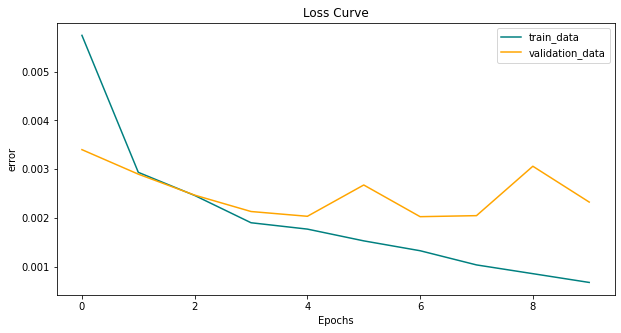

No handles with labels found to put in legend.


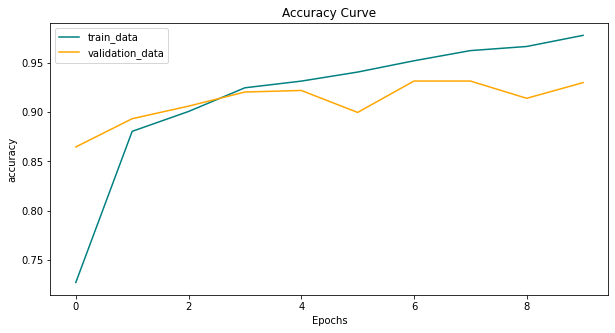

In [0]:
plot_curves("Loss Curve","error",train_error,val_error)
plot_curves("Accuracy Curve","accuracy",train_acc,val_acc)

In [0]:
t1 = torch.tensor([[1, 1, 0],[1,0,1]], device = 'cuda')
t2 = torch.tensor([[1, 1, 0],[1,0,0]], device = 'cuda')
print(t1)
print(t2)
indices = torch.zeros_like(t1, dtype = torch.bool, device = 'cuda')
for elem in t2:
    indices = indices | (t1 == elem)  
intersection = t1[indices] 
intersection

tensor([[1, 1, 0],
        [1, 0, 1]], device='cuda:0')
tensor([[1, 1, 0],
        [1, 0, 0]], device='cuda:0')


tensor([1, 1, 0, 1, 0], device='cuda:0')

In [0]:
resnet18.load_state_dict(torch.load('/content/drive/My Drive/A_05_Part_02_Dataset/res18_FC_Only.pth'))
resnet18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# With Focal Loss

---

**Focal Loss Function**

In [0]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

### ResNet18 Model

**Loading pre-trained model of ResNet-18 for ImageNet**

In [0]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)
# print(resnet18)

**Replacing Previous FC Layers with new ones**

In [0]:
features = list()
features.extend([nn.Linear(512, 3)])
resnet18.fc = nn.Sequential(*features)

In [0]:
# print(resnet18)

**Loss function and optimizer**

In [0]:
Epochs = 10
criterion = FocalLoss(logits=True)
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()
train_error=[]
val_error=[]
train_acc=[]
val_acc=[]

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    running_corrects = 0.0
    num_images = 0

    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # print("LABELS\n",labels.shape)
        labels = torch.nn.functional.one_hot(labels, 3)
        labels = labels.float()
        labels[:,2]=labels[:,2]+labels[:,0] #setting pnemounia true for all COVID labeled records
        num_images = num_images+inputs.size(0)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        
        # print("\nlabels type: ",labels.shape)
        # print("\nlabels : ",labels)
#--------------------------------------------------------------------
        loss = criterion(outputs, labels)   #----> compute loss
        # print("\noutput type: ",loss.shape)
        # print("\noutputs : ",loss)
        
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        # print("loss type",loss.data)
        # print("outputs: ",outputs)
        
        ## _, preds = torch.max(outputs, 1)
        
        # print statistics
        preds = get_preds(outputs,0.5)
        # compare_preds_labels(preds,labels,3)

        running_loss += loss.item()

        # running_loss += hamming_loss(labels,preds)

        # print("labels.shape: ",labels)
        # preds = preds.view(8,1)
        # preds = torch.nn.functional.one_hot(preds, 3) #one hot vector for predictions
        # preds[:,2]=preds[:,2]+preds[:,0]
        # print("preds: ",preds)


        running_corrects += (preds==labels).prod(1).sum().item()
        print("running_corrects: ",running_corrects)
        # running_corrects += sum((preds == labels).all(axis=1)) #to get all correct predictions

        # print("preds: \n",preds)
        # print("labels: \n",labels)
        
        # print(running_corrects)
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        
    #train loss and accuracy
    epoch_loss = running_loss /num_images
    train_error.append(epoch_loss)
    epoch_acc = running_corrects / num_images
    train_acc.append(epoch_acc)

    #Validation loss and accuracy
    epoch_loss,epoch_acc = evaluate(resnet18)
    val_error.append(epoch_loss)
    val_acc.append(epoch_acc)

    print('train loss: {}\n train acc: {}\n valid loss: {}\n valid acc:{}'.format(
        train_error[epoch],train_acc[epoch],val_error[epoch],val_acc[epoch]))

    torch.save(resnet18.state_dict(), data_dir+'/res18_FC_Only_FL.pth')

print('Finished Training')




0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))



Train Epoch: 0 [0/6200 (0%)]	Loss: 0.255109: : 0it [00:04, ?it/s]


Train Epoch: 0 [0/6200 (0%)]	Loss: 0.255109: : 1it [00:04,  4.57s/it]

running_corrects:  4.0





Train Epoch: 0 [64/6200 (1%)]	Loss: 0.250117: : 1it [00:06,  4.57s/it]


Train Epoch: 0 [64/6200 (1%)]	Loss: 0.250117: : 2it [00:06,  3.64s/it]

running_corrects:  9.0





Train Epoch: 0 [128/6200 (2%)]	Loss: 0.239843: : 2it [00:06,  3.64s/it]


Train Epoch: 0 [128/6200 (2%)]	Loss: 0.239843: : 3it [00:06,  2.62s/it]


Train Epoch: 0 [192/6200 (3%)]	Loss: 0.196756: : 3it [00:06,  2.62s/it]


Train Epoch: 0 [192/6200 (3%)]	Loss: 0.196756: : 4it [00:06,  1.89s/it]

running_corrects:  19.0
running_corrects:  31.0





Train Epoch: 0 [256/6200 (4%)]	Loss: 0.211665: : 4it [00:06,  1.89s/it]


Train Epoch: 0 [256/6200 (4%)]	Loss: 0.211665: : 5it [00:06,  1.38s/it]

running_corrects:  45.0





Train Epoch: 0 [320/6200 (5%)]	Loss: 0.191679: : 5it [00:09,  1.38s/it]


Train Epoch: 0 [320/6200 (5%)]	Loss: 0.191679: : 6it [00:09,  1.91s/it]

running_corrects:  68.0





Train Epoch: 0 [384/6200 (6%)]	Loss: 0.128619: : 6it [00:11,  1.91s/it]


Train Epoch: 0 [384/6200 (6%)]	Loss: 0.128619: : 7it [00:11,  1.94s/it]


Train Epoch: 0 [448/6200 (7%)]	Loss: 0.149357: : 7it [00:12,  1.94s/it]


Train Epoch: 0 [448/6200 (7%)]	Loss: 0.149357: : 8it [00:12,  1.42s/it]

running_corrects:  102.0
running_corrects:  134.0





Train Epoch: 0 [512/6200 (8%)]	Loss: 0.114729: : 8it [00:12,  1.42s/it]


Train Epoch: 0 [512/6200 (8%)]	Loss: 0.114729: : 9it [00:12,  1.06s/it]


Train Epoch: 0 [576/6200 (9%)]	Loss: 0.122548: : 9it [00:12,  1.06s/it]


Train Epoch: 0 [576/6200 (9%)]	Loss: 0.122548: : 10it [00:12,  1.26it/s]

running_corrects:  172.0
running_corrects:  214.0





Train Epoch: 0 [640/6200 (10%)]	Loss: 0.135982: : 10it [00:15,  1.26it/s]


Train Epoch: 0 [640/6200 (10%)]	Loss: 0.135982: : 11it [00:15,  1.59s/it]

running_corrects:  252.0





Train Epoch: 0 [704/6200 (11%)]	Loss: 0.114833: : 11it [00:17,  1.59s/it]


Train Epoch: 0 [704/6200 (11%)]	Loss: 0.114833: : 12it [00:17,  1.55s/it]

running_corrects:  296.0





Train Epoch: 0 [768/6200 (12%)]	Loss: 0.116231: : 12it [00:17,  1.55s/it]


Train Epoch: 0 [768/6200 (12%)]	Loss: 0.116231: : 13it [00:17,  1.16s/it]


Train Epoch: 0 [832/6200 (13%)]	Loss: 0.132793: : 13it [00:17,  1.16s/it]

running_corrects:  340.0
running_corrects:  383.0





Train Epoch: 0 [832/6200 (13%)]	Loss: 0.132793: : 14it [00:17,  1.15it/s]


Train Epoch: 0 [896/6200 (14%)]	Loss: 0.127993: : 14it [00:18,  1.15it/s]


Train Epoch: 0 [896/6200 (14%)]	Loss: 0.127993: : 15it [00:18,  1.44it/s]

running_corrects:  430.0





Train Epoch: 0 [960/6200 (15%)]	Loss: 0.133806: : 15it [00:21,  1.44it/s]


Train Epoch: 0 [960/6200 (15%)]	Loss: 0.133806: : 16it [00:21,  1.42s/it]

running_corrects:  477.0





Train Epoch: 0 [1024/6200 (16%)]	Loss: 0.113517: : 16it [00:22,  1.42s/it]


Train Epoch: 0 [1024/6200 (16%)]	Loss: 0.113517: : 17it [00:22,  1.32s/it]


Train Epoch: 0 [1088/6200 (18%)]	Loss: 0.122188: : 17it [00:22,  1.32s/it]


Train Epoch: 0 [1088/6200 (18%)]	Loss: 0.122188: : 18it [00:22,  1.02it/s]

running_corrects:  515.0
running_corrects:  560.0





Train Epoch: 0 [1152/6200 (19%)]	Loss: 0.109907: : 18it [00:22,  1.02it/s]


Train Epoch: 0 [1152/6200 (19%)]	Loss: 0.109907: : 19it [00:22,  1.33it/s]


Train Epoch: 0 [1216/6200 (20%)]	Loss: 0.101964: : 19it [00:22,  1.33it/s]


Train Epoch: 0 [1216/6200 (20%)]	Loss: 0.101964: : 20it [00:22,  1.73it/s]

running_corrects:  605.0
running_corrects:  650.0





Train Epoch: 0 [1280/6200 (21%)]	Loss: 0.147773: : 20it [00:26,  1.73it/s]


Train Epoch: 0 [1280/6200 (21%)]	Loss: 0.147773: : 21it [00:26,  1.45s/it]

running_corrects:  689.0





Train Epoch: 0 [1344/6200 (22%)]	Loss: 0.111581: : 21it [00:26,  1.45s/it]


Train Epoch: 0 [1344/6200 (22%)]	Loss: 0.111581: : 22it [00:26,  1.18s/it]


Train Epoch: 0 [1408/6200 (23%)]	Loss: 0.092194: : 22it [00:27,  1.18s/it]


Train Epoch: 0 [1408/6200 (23%)]	Loss: 0.092194: : 23it [00:27,  1.13it/s]

running_corrects:  731.0
running_corrects:  771.0





Train Epoch: 0 [1472/6200 (24%)]	Loss: 0.093033: : 23it [00:27,  1.13it/s]


Train Epoch: 0 [1472/6200 (24%)]	Loss: 0.093033: : 24it [00:27,  1.49it/s]

running_corrects:  819.0





Train Epoch: 0 [1536/6200 (25%)]	Loss: 0.123014: : 24it [00:27,  1.49it/s]


Train Epoch: 0 [1536/6200 (25%)]	Loss: 0.123014: : 25it [00:27,  1.86it/s]

running_corrects:  859.0





Train Epoch: 0 [1600/6200 (26%)]	Loss: 0.107590: : 25it [00:32,  1.86it/s]


Train Epoch: 0 [1600/6200 (26%)]	Loss: 0.107590: : 26it [00:32,  1.81s/it]




running_corrects:  898.0
running_corrects:  942.0


Train Epoch: 0 [1664/6200 (27%)]	Loss: 0.099100: : 26it [00:32,  1.81s/it]


Train Epoch: 0 [1664/6200 (27%)]	Loss: 0.099100: : 27it [00:32,  1.32s/it]


Train Epoch: 0 [1728/6200 (28%)]	Loss: 0.086742: : 27it [00:32,  1.32s/it]


Train Epoch: 0 [1728/6200 (28%)]	Loss: 0.086742: : 28it [00:32,  1.02it/s]


Train Epoch: 0 [1792/6200 (29%)]	Loss: 0.097686: : 28it [00:32,  1.02it/s]

running_corrects:  984.0
running_corrects:  1025.0





Train Epoch: 0 [1792/6200 (29%)]	Loss: 0.097686: : 29it [00:32,  1.35it/s]


Train Epoch: 0 [1856/6200 (30%)]	Loss: 0.106659: : 29it [00:32,  1.35it/s]


Train Epoch: 0 [1856/6200 (30%)]	Loss: 0.106659: : 30it [00:32,  1.76it/s]

running_corrects:  1062.0





Train Epoch: 0 [1920/6200 (31%)]	Loss: 0.109737: : 30it [00:36,  1.76it/s]


Train Epoch: 0 [1920/6200 (31%)]	Loss: 0.109737: : 31it [00:36,  1.53s/it]


Train Epoch: 0 [1984/6200 (32%)]	Loss: 0.098112: : 31it [00:36,  1.53s/it]


Train Epoch: 0 [1984/6200 (32%)]	Loss: 0.098112: : 32it [00:36,  1.12s/it]

running_corrects:  1105.0
running_corrects:  1147.0





Train Epoch: 0 [2048/6200 (33%)]	Loss: 0.125613: : 32it [00:37,  1.12s/it]


Train Epoch: 0 [2048/6200 (33%)]	Loss: 0.125613: : 33it [00:37,  1.19it/s]


Train Epoch: 0 [2112/6200 (34%)]	Loss: 0.112590: : 33it [00:37,  1.19it/s]


Train Epoch: 0 [2112/6200 (34%)]	Loss: 0.112590: : 34it [00:37,  1.57it/s]

running_corrects:  1188.0
running_corrects:  1225.0





Train Epoch: 0 [2176/6200 (35%)]	Loss: 0.106464: : 34it [00:37,  1.57it/s]


Train Epoch: 0 [2176/6200 (35%)]	Loss: 0.106464: : 35it [00:37,  1.98it/s]

running_corrects:  1268.0





Train Epoch: 0 [2240/6200 (36%)]	Loss: 0.080110: : 35it [00:41,  1.98it/s]


Train Epoch: 0 [2240/6200 (36%)]	Loss: 0.080110: : 36it [00:41,  1.48s/it]

running_corrects:  1312.0





Train Epoch: 0 [2304/6200 (37%)]	Loss: 0.090382: : 36it [00:41,  1.48s/it]


Train Epoch: 0 [2304/6200 (37%)]	Loss: 0.090382: : 37it [00:41,  1.10s/it]


Train Epoch: 0 [2368/6200 (38%)]	Loss: 0.113779: : 37it [00:41,  1.10s/it]


Train Epoch: 0 [2368/6200 (38%)]	Loss: 0.113779: : 38it [00:41,  1.22it/s]

running_corrects:  1357.0
running_corrects:  1402.0





Train Epoch: 0 [2432/6200 (39%)]	Loss: 0.090260: : 38it [00:41,  1.22it/s]


Train Epoch: 0 [2432/6200 (39%)]	Loss: 0.090260: : 39it [00:41,  1.59it/s]


Train Epoch: 0 [2496/6200 (40%)]	Loss: 0.104009: : 39it [00:41,  1.59it/s]


Train Epoch: 0 [2496/6200 (40%)]	Loss: 0.104009: : 40it [00:41,  2.02it/s]

running_corrects:  1450.0
running_corrects:  1492.0





Train Epoch: 0 [2560/6200 (41%)]	Loss: 0.081954: : 40it [00:46,  2.02it/s]


Train Epoch: 0 [2560/6200 (41%)]	Loss: 0.081954: : 41it [00:46,  1.58s/it]


Train Epoch: 0 [2624/6200 (42%)]	Loss: 0.106976: : 41it [00:46,  1.58s/it]


Train Epoch: 0 [2624/6200 (42%)]	Loss: 0.106976: : 42it [00:46,  1.16s/it]

running_corrects:  1544.0
running_corrects:  1590.0





Train Epoch: 0 [2688/6200 (43%)]	Loss: 0.107940: : 42it [00:46,  1.16s/it]


Train Epoch: 0 [2688/6200 (43%)]	Loss: 0.107940: : 43it [00:46,  1.14it/s]


Train Epoch: 0 [2752/6200 (44%)]	Loss: 0.092745: : 43it [00:46,  1.14it/s]


Train Epoch: 0 [2752/6200 (44%)]	Loss: 0.092745: : 44it [00:46,  1.51it/s]

running_corrects:  1638.0
running_corrects:  1687.0





Train Epoch: 0 [2816/6200 (45%)]	Loss: 0.122675: : 44it [00:46,  1.51it/s]


Train Epoch: 0 [2816/6200 (45%)]	Loss: 0.122675: : 45it [00:46,  1.90it/s]

running_corrects:  1730.0





Train Epoch: 0 [2880/6200 (46%)]	Loss: 0.085237: : 45it [00:51,  1.90it/s]


Train Epoch: 0 [2880/6200 (46%)]	Loss: 0.085237: : 46it [00:51,  1.69s/it]

running_corrects:  1782.0





Train Epoch: 0 [2944/6200 (47%)]	Loss: 0.090823: : 46it [00:51,  1.69s/it]


Train Epoch: 0 [2944/6200 (47%)]	Loss: 0.090823: : 47it [00:51,  1.25s/it]


Train Epoch: 0 [3008/6200 (48%)]	Loss: 0.106771: : 47it [00:51,  1.25s/it]


Train Epoch: 0 [3008/6200 (48%)]	Loss: 0.106771: : 48it [00:51,  1.08it/s]

running_corrects:  1830.0
running_corrects:  1876.0





Train Epoch: 0 [3072/6200 (49%)]	Loss: 0.095309: : 48it [00:51,  1.08it/s]


Train Epoch: 0 [3072/6200 (49%)]	Loss: 0.095309: : 49it [00:51,  1.41it/s]

running_corrects:  1928.0





Train Epoch: 0 [3136/6200 (51%)]	Loss: 0.092437: : 49it [00:52,  1.41it/s]


Train Epoch: 0 [3136/6200 (51%)]	Loss: 0.092437: : 50it [00:52,  1.78it/s]

running_corrects:  1977.0





Train Epoch: 0 [3200/6200 (52%)]	Loss: 0.090966: : 50it [00:55,  1.78it/s]


Train Epoch: 0 [3200/6200 (52%)]	Loss: 0.090966: : 51it [00:55,  1.59s/it]


Train Epoch: 0 [3264/6200 (53%)]	Loss: 0.089416: : 51it [00:56,  1.59s/it]

running_corrects:  2026.0
running_corrects:  2076.0





Train Epoch: 0 [3264/6200 (53%)]	Loss: 0.089416: : 52it [00:56,  1.17s/it]


Train Epoch: 0 [3328/6200 (54%)]	Loss: 0.065922: : 52it [00:56,  1.17s/it]


Train Epoch: 0 [3328/6200 (54%)]	Loss: 0.065922: : 53it [00:56,  1.14it/s]


Train Epoch: 0 [3392/6200 (55%)]	Loss: 0.069418: : 53it [00:56,  1.14it/s]


Train Epoch: 0 [3392/6200 (55%)]	Loss: 0.069418: : 54it [00:56,  1.50it/s]

running_corrects:  2132.0
running_corrects:  2182.0





Train Epoch: 0 [3456/6200 (56%)]	Loss: 0.090704: : 54it [00:56,  1.50it/s]


Train Epoch: 0 [3456/6200 (56%)]	Loss: 0.090704: : 55it [00:56,  1.89it/s]

running_corrects:  2232.0





Train Epoch: 0 [3520/6200 (57%)]	Loss: 0.073911: : 55it [01:00,  1.89it/s]


Train Epoch: 0 [3520/6200 (57%)]	Loss: 0.073911: : 56it [01:00,  1.41s/it]

running_corrects:  2286.0





Train Epoch: 0 [3584/6200 (58%)]	Loss: 0.078730: : 56it [01:00,  1.41s/it]


Train Epoch: 0 [3584/6200 (58%)]	Loss: 0.078730: : 57it [01:00,  1.05s/it]


Train Epoch: 0 [3648/6200 (59%)]	Loss: 0.103898: : 57it [01:00,  1.05s/it]

running_corrects:  2332.0
running_corrects:  2379.0





Train Epoch: 0 [3648/6200 (59%)]	Loss: 0.103898: : 58it [01:00,  1.27it/s]


Train Epoch: 0 [3712/6200 (60%)]	Loss: 0.082718: : 58it [01:00,  1.27it/s]


Train Epoch: 0 [3712/6200 (60%)]	Loss: 0.082718: : 59it [01:00,  1.64it/s]


Train Epoch: 0 [3776/6200 (61%)]	Loss: 0.072237: : 59it [01:00,  1.64it/s]


Train Epoch: 0 [3776/6200 (61%)]	Loss: 0.072237: : 60it [01:00,  2.10it/s]

running_corrects:  2428.0
running_corrects:  2480.0





Train Epoch: 0 [3840/6200 (62%)]	Loss: 0.075737: : 60it [01:04,  2.10it/s]


Train Epoch: 0 [3840/6200 (62%)]	Loss: 0.075737: : 61it [01:04,  1.43s/it]


Train Epoch: 0 [3904/6200 (63%)]	Loss: 0.084434: : 61it [01:04,  1.43s/it]


Train Epoch: 0 [3904/6200 (63%)]	Loss: 0.084434: : 62it [01:04,  1.06s/it]

running_corrects:  2533.0
running_corrects:  2583.0





Train Epoch: 0 [3968/6200 (64%)]	Loss: 0.081908: : 62it [01:05,  1.06s/it]


Train Epoch: 0 [3968/6200 (64%)]	Loss: 0.081908: : 63it [01:05,  1.24it/s]


Train Epoch: 0 [4032/6200 (65%)]	Loss: 0.074579: : 63it [01:05,  1.24it/s]


Train Epoch: 0 [4032/6200 (65%)]	Loss: 0.074579: : 64it [01:05,  1.62it/s]

running_corrects:  2632.0
running_corrects:  2686.0





Train Epoch: 0 [4096/6200 (66%)]	Loss: 0.111941: : 64it [01:05,  1.62it/s]


Train Epoch: 0 [4096/6200 (66%)]	Loss: 0.111941: : 65it [01:05,  2.05it/s]

running_corrects:  2729.0





Train Epoch: 0 [4160/6200 (67%)]	Loss: 0.075865: : 65it [01:09,  2.05it/s]


Train Epoch: 0 [4160/6200 (67%)]	Loss: 0.075865: : 66it [01:09,  1.63s/it]

running_corrects:  2781.0





Train Epoch: 0 [4224/6200 (68%)]	Loss: 0.073155: : 66it [01:09,  1.63s/it]


Train Epoch: 0 [4224/6200 (68%)]	Loss: 0.073155: : 67it [01:09,  1.21s/it]


Train Epoch: 0 [4288/6200 (69%)]	Loss: 0.086694: : 67it [01:10,  1.21s/it]


Train Epoch: 0 [4288/6200 (69%)]	Loss: 0.086694: : 68it [01:10,  1.11it/s]

running_corrects:  2833.0
running_corrects:  2883.0





Train Epoch: 0 [4352/6200 (70%)]	Loss: 0.078185: : 68it [01:10,  1.11it/s]


Train Epoch: 0 [4352/6200 (70%)]	Loss: 0.078185: : 69it [01:10,  1.44it/s]


Train Epoch: 0 [4416/6200 (71%)]	Loss: 0.073176: : 69it [01:10,  1.44it/s]


Train Epoch: 0 [4416/6200 (71%)]	Loss: 0.073176: : 70it [01:10,  1.85it/s]

running_corrects:  2933.0
running_corrects:  2986.0





Train Epoch: 0 [4480/6200 (72%)]	Loss: 0.086234: : 70it [01:14,  1.85it/s]


Train Epoch: 0 [4480/6200 (72%)]	Loss: 0.086234: : 71it [01:14,  1.45s/it]


Train Epoch: 0 [4544/6200 (73%)]	Loss: 0.095052: : 71it [01:14,  1.45s/it]


Train Epoch: 0 [4544/6200 (73%)]	Loss: 0.095052: : 72it [01:14,  1.07s/it]

running_corrects:  3036.0
running_corrects:  3081.0





Train Epoch: 0 [4608/6200 (74%)]	Loss: 0.089480: : 72it [01:14,  1.07s/it]


Train Epoch: 0 [4608/6200 (74%)]	Loss: 0.089480: : 73it [01:14,  1.24it/s]


Train Epoch: 0 [4672/6200 (75%)]	Loss: 0.078877: : 73it [01:14,  1.24it/s]


Train Epoch: 0 [4672/6200 (75%)]	Loss: 0.078877: : 74it [01:14,  1.63it/s]

running_corrects:  3131.0
running_corrects:  3181.0





Train Epoch: 0 [4736/6200 (76%)]	Loss: 0.076750: : 74it [01:14,  1.63it/s]


Train Epoch: 0 [4736/6200 (76%)]	Loss: 0.076750: : 75it [01:14,  2.07it/s]

running_corrects:  3233.0





Train Epoch: 0 [4800/6200 (77%)]	Loss: 0.097926: : 75it [01:18,  2.07it/s]


Train Epoch: 0 [4800/6200 (77%)]	Loss: 0.097926: : 76it [01:18,  1.36s/it]

running_corrects:  3280.0
running_corrects: 




Train Epoch: 0 [4864/6200 (78%)]	Loss: 0.072372: : 76it [01:18,  1.36s/it]


Train Epoch: 0 [4864/6200 (78%)]	Loss: 0.072372: : 77it [01:18,  1.01s/it]

 3329.0





Train Epoch: 0 [4928/6200 (79%)]	Loss: 0.069143: : 77it [01:18,  1.01s/it]


Train Epoch: 0 [4928/6200 (79%)]	Loss: 0.069143: : 78it [01:18,  1.23it/s]

running_corrects:  3382.0





Train Epoch: 0 [4992/6200 (80%)]	Loss: 0.070812: : 78it [01:18,  1.23it/s]


Train Epoch: 0 [4992/6200 (80%)]	Loss: 0.070812: : 79it [01:18,  1.58it/s]


Train Epoch: 0 [5056/6200 (81%)]	Loss: 0.077261: : 79it [01:19,  1.58it/s]


Train Epoch: 0 [5056/6200 (81%)]	Loss: 0.077261: : 80it [01:19,  2.02it/s]

running_corrects:  3433.0
running_corrects:  3482.0





Train Epoch: 0 [5120/6200 (82%)]	Loss: 0.070702: : 80it [01:23,  2.02it/s]


Train Epoch: 0 [5120/6200 (82%)]	Loss: 0.070702: : 81it [01:23,  1.68s/it]


Train Epoch: 0 [5184/6200 (84%)]	Loss: 0.069049: : 81it [01:23,  1.68s/it]


Train Epoch: 0 [5184/6200 (84%)]	Loss: 0.069049: : 82it [01:23,  1.22s/it]

running_corrects:  3535.0
running_corrects:  3586.0





Train Epoch: 0 [5248/6200 (85%)]	Loss: 0.073164: : 82it [01:23,  1.22s/it]


Train Epoch: 0 [5248/6200 (85%)]	Loss: 0.073164: : 83it [01:23,  1.09it/s]


Train Epoch: 0 [5312/6200 (86%)]	Loss: 0.069300: : 83it [01:24,  1.09it/s]


Train Epoch: 0 [5312/6200 (86%)]	Loss: 0.069300: : 84it [01:24,  1.45it/s]

running_corrects:  3641.0
running_corrects:  3695.0





Train Epoch: 0 [5376/6200 (87%)]	Loss: 0.113131: : 84it [01:24,  1.45it/s]


Train Epoch: 0 [5376/6200 (87%)]	Loss: 0.113131: : 85it [01:24,  1.84it/s]

running_corrects:  3737.0





Train Epoch: 0 [5440/6200 (88%)]	Loss: 0.060254: : 85it [01:27,  1.84it/s]


Train Epoch: 0 [5440/6200 (88%)]	Loss: 0.060254: : 86it [01:27,  1.42s/it]

running_corrects:  3792.0





Train Epoch: 0 [5504/6200 (89%)]	Loss: 0.076909: : 86it [01:27,  1.42s/it]


Train Epoch: 0 [5504/6200 (89%)]	Loss: 0.076909: : 87it [01:27,  1.06s/it]

running_corrects:  3842.0





Train Epoch: 0 [5568/6200 (90%)]	Loss: 0.085555: : 87it [01:29,  1.06s/it]


Train Epoch: 0 [5568/6200 (90%)]	Loss: 0.085555: : 88it [01:29,  1.20s/it]

running_corrects:  3891.0
running_corrects:  3937.0





Train Epoch: 0 [5632/6200 (91%)]	Loss: 0.080414: : 88it [01:29,  1.20s/it]


Train Epoch: 0 [5632/6200 (91%)]	Loss: 0.080414: : 89it [01:29,  1.11it/s]


Train Epoch: 0 [5696/6200 (92%)]	Loss: 0.063963: : 89it [01:29,  1.11it/s]


Train Epoch: 0 [5696/6200 (92%)]	Loss: 0.063963: : 90it [01:29,  1.48it/s]

running_corrects:  3989.0





Train Epoch: 0 [5760/6200 (93%)]	Loss: 0.076378: : 90it [01:32,  1.48it/s]


Train Epoch: 0 [5760/6200 (93%)]	Loss: 0.076378: : 91it [01:32,  1.17s/it]


Train Epoch: 0 [5824/6200 (94%)]	Loss: 0.072469: : 91it [01:32,  1.17s/it]


Train Epoch: 0 [5824/6200 (94%)]	Loss: 0.072469: : 92it [01:32,  1.16it/s]

running_corrects:  4040.0
running_corrects:  4094.0





Train Epoch: 0 [5888/6200 (95%)]	Loss: 0.054920: : 92it [01:32,  1.16it/s]


Train Epoch: 0 [5888/6200 (95%)]	Loss: 0.054920: : 93it [01:32,  1.49it/s]


Train Epoch: 0 [5952/6200 (96%)]	Loss: 0.072857: : 93it [01:32,  1.49it/s]


Train Epoch: 0 [5952/6200 (96%)]	Loss: 0.072857: : 94it [01:32,  1.96it/s]

running_corrects:  4150.0
running_corrects:  4203.0





Train Epoch: 0 [6016/6200 (97%)]	Loss: 0.077258: : 94it [01:32,  1.96it/s]


Train Epoch: 0 [6016/6200 (97%)]	Loss: 0.077258: : 95it [01:32,  2.51it/s]

running_corrects:  4254.0





Train Epoch: 0 [6080/6200 (98%)]	Loss: 0.057729: : 95it [01:33,  2.51it/s]


Train Epoch: 0 [6080/6200 (98%)]	Loss: 0.057729: : 96it [01:33,  1.62it/s]


Train Epoch: 0 [5376/6200 (99%)]	Loss: 0.076965: : 96it [01:34,  1.62it/s]


Train Epoch: 0 [5376/6200 (99%)]	Loss: 0.076965: : 97it [01:34,  2.13it/s]

running_corrects:  4308.0
running_corrects:  4351.0


Train Epoch: 0 [5376/6200 (99%)]	Loss: 0.076965: : 97it [01:34,  1.03it/s]



0it [00:00, ?it/s]


1it [00:04,  4.17s/it]


2it [00:05,  3.46s/it]


3it [00:06,  2.47s/it]


5it [00:06,  1.76s/it]


6it [00:08,  1.79s/it]


7it [00:09,  1.52s/it]


10it [00:09,  1.07it/s]


train loss: 0.0015882980475021946
 train acc: 0.7017741935483871
 valid loss: 0.0011576775900402647
 valid acc:0.8264331210191083





0it [00:00, ?it/s]


Train Epoch: 1 [0/6200 (0%)]	Loss: 0.063410: : 0it [00:04, ?it/s]


Train Epoch: 1 [0/6200 (0%)]	Loss: 0.063410: : 1it [00:04,  4.29s/it]

running_corrects:  54.0





Train Epoch: 1 [64/6200 (1%)]	Loss: 0.094086: : 1it [00:05,  4.29s/it]


Train Epoch: 1 [64/6200 (1%)]	Loss: 0.094086: : 2it [00:05,  3.43s/it]

running_corrects:  103.0





Train Epoch: 1 [128/6200 (2%)]	Loss: 0.045912: : 2it [00:05,  3.43s/it]


Train Epoch: 1 [128/6200 (2%)]	Loss: 0.045912: : 3it [00:05,  2.47s/it]


Train Epoch: 1 [192/6200 (3%)]	Loss: 0.064458: : 3it [00:06,  2.47s/it]


Train Epoch: 1 [192/6200 (3%)]	Loss: 0.064458: : 4it [00:06,  1.78s/it]

running_corrects:  161.0
running_corrects:  214.0





Train Epoch: 1 [256/6200 (4%)]	Loss: 0.068149: : 4it [00:06,  1.78s/it]


Train Epoch: 1 [256/6200 (4%)]	Loss: 0.068149: : 5it [00:06,  1.30s/it]

running_corrects:  265.0





Train Epoch: 1 [320/6200 (5%)]	Loss: 0.064239: : 5it [00:08,  1.30s/it]


Train Epoch: 1 [320/6200 (5%)]	Loss: 0.064239: : 6it [00:08,  1.52s/it]

running_corrects:  316.0





Train Epoch: 1 [384/6200 (6%)]	Loss: 0.050609: : 6it [00:10,  1.52s/it]


Train Epoch: 1 [384/6200 (6%)]	Loss: 0.050609: : 7it [00:10,  1.58s/it]


Train Epoch: 1 [448/6200 (7%)]	Loss: 0.055756: : 7it [00:10,  1.58s/it]


Train Epoch: 1 [448/6200 (7%)]	Loss: 0.055756: : 8it [00:10,  1.16s/it]

running_corrects:  369.0
running_corrects:  421.0





Train Epoch: 1 [512/6200 (8%)]	Loss: 0.045202: : 8it [00:10,  1.16s/it]


Train Epoch: 1 [512/6200 (8%)]	Loss: 0.045202: : 9it [00:10,  1.14it/s]


Train Epoch: 1 [576/6200 (9%)]	Loss: 0.050084: : 9it [00:10,  1.14it/s]




running_corrects:  478.0
running_corrects:  533.0


Train Epoch: 1 [576/6200 (9%)]	Loss: 0.050084: : 10it [00:10,  1.49it/s]


Train Epoch: 1 [640/6200 (10%)]	Loss: 0.054021: : 10it [00:13,  1.49it/s]


Train Epoch: 1 [640/6200 (10%)]	Loss: 0.054021: : 11it [00:13,  1.27s/it]

running_corrects:  588.0





Train Epoch: 1 [704/6200 (11%)]	Loss: 0.077111: : 11it [00:14,  1.27s/it]


Train Epoch: 1 [704/6200 (11%)]	Loss: 0.077111: : 12it [00:14,  1.33s/it]

running_corrects:  643.0





Train Epoch: 1 [768/6200 (12%)]	Loss: 0.102772: : 12it [00:14,  1.33s/it]


Train Epoch: 1 [768/6200 (12%)]	Loss: 0.102772: : 13it [00:15,  1.00s/it]


Train Epoch: 1 [832/6200 (13%)]	Loss: 0.061666: : 13it [00:15,  1.00s/it]


Train Epoch: 1 [832/6200 (13%)]	Loss: 0.061666: : 14it [00:15,  1.35it/s]

running_corrects:  690.0
running_corrects:  745.0





Train Epoch: 1 [896/6200 (14%)]	Loss: 0.047156: : 14it [00:15,  1.35it/s]


Train Epoch: 1 [896/6200 (14%)]	Loss: 0.047156: : 15it [00:15,  1.72it/s]

running_corrects:  803.0





Train Epoch: 1 [960/6200 (15%)]	Loss: 0.049713: : 15it [00:18,  1.72it/s]


Train Epoch: 1 [960/6200 (15%)]	Loss: 0.049713: : 16it [00:18,  1.29s/it]

running_corrects:  862.0





Train Epoch: 1 [1024/6200 (16%)]	Loss: 0.070831: : 16it [00:19,  1.29s/it]


Train Epoch: 1 [1024/6200 (16%)]	Loss: 0.070831: : 17it [00:19,  1.12s/it]


Train Epoch: 1 [1088/6200 (18%)]	Loss: 0.070185: : 17it [00:19,  1.12s/it]


Train Epoch: 1 [1088/6200 (18%)]	Loss: 0.070185: : 18it [00:19,  1.20it/s]

running_corrects:  915.0
running_corrects:  970.0





Train Epoch: 1 [1152/6200 (19%)]	Loss: 0.049441: : 18it [00:19,  1.20it/s]


Train Epoch: 1 [1152/6200 (19%)]	Loss: 0.049441: : 19it [00:19,  1.55it/s]

running_corrects:  1027.0





Train Epoch: 1 [1216/6200 (20%)]	Loss: 0.055765: : 19it [00:20,  1.55it/s]


Train Epoch: 1 [1216/6200 (20%)]	Loss: 0.055765: : 20it [00:20,  1.21it/s]

running_corrects:  1082.0





Train Epoch: 1 [1280/6200 (21%)]	Loss: 0.061169: : 20it [00:23,  1.21it/s]


Train Epoch: 1 [1280/6200 (21%)]	Loss: 0.061169: : 21it [00:23,  1.38s/it]

running_corrects:  1137.0





Train Epoch: 1 [1344/6200 (22%)]	Loss: 0.079355: : 21it [00:23,  1.38s/it]


Train Epoch: 1 [1344/6200 (22%)]	Loss: 0.079355: : 22it [00:23,  1.06s/it]

running_corrects:  1187.0





Train Epoch: 1 [1408/6200 (23%)]	Loss: 0.062683: : 22it [00:23,  1.06s/it]


Train Epoch: 1 [1408/6200 (23%)]	Loss: 0.062683: : 23it [00:23,  1.24it/s]


Train Epoch: 1 [1472/6200 (24%)]	Loss: 0.068816: : 23it [00:23,  1.24it/s]


Train Epoch: 1 [1472/6200 (24%)]	Loss: 0.068816: : 24it [00:23,  1.64it/s]

running_corrects:  1241.0
running_corrects:  1295.0





Train Epoch: 1 [1536/6200 (25%)]	Loss: 0.053903: : 24it [00:25,  1.64it/s]


Train Epoch: 1 [1536/6200 (25%)]	Loss: 0.053903: : 25it [00:25,  1.35it/s]

running_corrects:  1350.0





Train Epoch: 1 [1600/6200 (26%)]	Loss: 0.035412: : 25it [00:27,  1.35it/s]


Train Epoch: 1 [1600/6200 (26%)]	Loss: 0.035412: : 26it [00:27,  1.31s/it]

running_corrects:  1413.0





Train Epoch: 1 [1664/6200 (27%)]	Loss: 0.070877: : 26it [00:27,  1.31s/it]


Train Epoch: 1 [1664/6200 (27%)]	Loss: 0.070877: : 27it [00:27,  1.02it/s]


Train Epoch: 1 [1728/6200 (28%)]	Loss: 0.051077: : 27it [00:28,  1.02it/s]


Train Epoch: 1 [1728/6200 (28%)]	Loss: 0.051077: : 28it [00:28,  1.37it/s]

running_corrects:  1465.0
running_corrects:  1522.0





Train Epoch: 1 [1792/6200 (29%)]	Loss: 0.075486: : 28it [00:28,  1.37it/s]


Train Epoch: 1 [1792/6200 (29%)]	Loss: 0.075486: : 29it [00:28,  1.75it/s]

running_corrects:  1576.0





Train Epoch: 1 [1856/6200 (30%)]	Loss: 0.062454: : 29it [00:29,  1.75it/s]


Train Epoch: 1 [1856/6200 (30%)]	Loss: 0.062454: : 30it [00:29,  1.42it/s]

running_corrects:  1630.0





Train Epoch: 1 [1920/6200 (31%)]	Loss: 0.071096: : 30it [00:32,  1.42it/s]


Train Epoch: 1 [1920/6200 (31%)]	Loss: 0.071096: : 31it [00:32,  1.36s/it]

running_corrects:  1683.0





Train Epoch: 1 [1984/6200 (32%)]	Loss: 0.054643: : 31it [00:32,  1.36s/it]


Train Epoch: 1 [1984/6200 (32%)]	Loss: 0.054643: : 32it [00:32,  1.06s/it]

running_corrects:  1736.0
running_corrects: 




Train Epoch: 1 [2048/6200 (33%)]	Loss: 0.078088: : 32it [00:32,  1.06s/it]


Train Epoch: 1 [2048/6200 (33%)]	Loss: 0.078088: : 33it [00:32,  1.24it/s]


Train Epoch: 1 [2112/6200 (34%)]	Loss: 0.050243: : 33it [00:32,  1.24it/s]


Train Epoch: 1 [2112/6200 (34%)]	Loss: 0.050243: : 34it [00:32,  1.61it/s]

 1792.0
running_corrects:  1845.0





Train Epoch: 1 [2176/6200 (35%)]	Loss: 0.055103: : 34it [00:33,  1.61it/s]


Train Epoch: 1 [2176/6200 (35%)]	Loss: 0.055103: : 35it [00:33,  1.40it/s]

running_corrects:  1898.0





Train Epoch: 1 [2240/6200 (36%)]	Loss: 0.058757: : 35it [00:37,  1.40it/s]


Train Epoch: 1 [2240/6200 (36%)]	Loss: 0.058757: : 36it [00:37,  1.50s/it]

running_corrects:  1951.0





Train Epoch: 1 [2304/6200 (37%)]	Loss: 0.053589: : 36it [00:37,  1.50s/it]


Train Epoch: 1 [2304/6200 (37%)]	Loss: 0.053589: : 37it [00:37,  1.12s/it]

running_corrects:  2003.0





Train Epoch: 1 [2368/6200 (38%)]	Loss: 0.051444: : 37it [00:38,  1.12s/it]


Train Epoch: 1 [2368/6200 (38%)]	Loss: 0.051444: : 38it [00:38,  1.18s/it]

running_corrects:  2058.0





Train Epoch: 1 [2432/6200 (39%)]	Loss: 0.052734: : 38it [00:38,  1.18s/it]


Train Epoch: 1 [2432/6200 (39%)]	Loss: 0.052734: : 39it [00:38,  1.13it/s]


Train Epoch: 1 [2496/6200 (40%)]	Loss: 0.079972: : 39it [00:39,  1.13it/s]


Train Epoch: 1 [2496/6200 (40%)]	Loss: 0.079972: : 40it [00:39,  1.49it/s]

running_corrects:  2111.0
running_corrects:  2166.0





Train Epoch: 1 [2560/6200 (41%)]	Loss: 0.068925: : 40it [00:41,  1.49it/s]


Train Epoch: 1 [2560/6200 (41%)]	Loss: 0.068925: : 41it [00:41,  1.34s/it]


Train Epoch: 1 [2624/6200 (42%)]	Loss: 0.055648: : 41it [00:42,  1.34s/it]


Train Epoch: 1 [2624/6200 (42%)]	Loss: 0.055648: : 42it [00:42,  1.01it/s]

running_corrects:  2217.0
running_corrects:  2271.0





Train Epoch: 1 [2688/6200 (43%)]	Loss: 0.063572: : 42it [00:43,  1.01it/s]


Train Epoch: 1 [2688/6200 (43%)]	Loss: 0.063572: : 43it [00:43,  1.18s/it]


Train Epoch: 1 [2752/6200 (44%)]	Loss: 0.071914: : 43it [00:43,  1.18s/it]

running_corrects:  2323.0
running_corrects:  2375.0





Train Epoch: 1 [2752/6200 (44%)]	Loss: 0.071914: : 44it [00:43,  1.14it/s]


Train Epoch: 1 [2816/6200 (45%)]	Loss: 0.059155: : 44it [00:44,  1.14it/s]


Train Epoch: 1 [2816/6200 (45%)]	Loss: 0.059155: : 45it [00:44,  1.49it/s]

running_corrects:  2428.0





Train Epoch: 1 [2880/6200 (46%)]	Loss: 0.057655: : 45it [00:46,  1.49it/s]


Train Epoch: 1 [2880/6200 (46%)]	Loss: 0.057655: : 46it [00:46,  1.24s/it]

running_corrects:  2479.0





Train Epoch: 1 [2944/6200 (47%)]	Loss: 0.065608: : 46it [00:46,  1.24s/it]


Train Epoch: 1 [2944/6200 (47%)]	Loss: 0.065608: : 47it [00:46,  1.07it/s]

running_corrects:  2532.0





Train Epoch: 1 [3008/6200 (48%)]	Loss: 0.049905: : 47it [00:48,  1.07it/s]


Train Epoch: 1 [3008/6200 (48%)]	Loss: 0.049905: : 48it [00:48,  1.00s/it]

running_corrects:  2587.0





Train Epoch: 1 [3072/6200 (49%)]	Loss: 0.049393: : 48it [00:48,  1.00s/it]


Train Epoch: 1 [3072/6200 (49%)]	Loss: 0.049393: : 49it [00:48,  1.31it/s]


Train Epoch: 1 [3136/6200 (51%)]	Loss: 0.068351: : 49it [00:48,  1.31it/s]


Train Epoch: 1 [3136/6200 (51%)]	Loss: 0.068351: : 50it [00:48,  1.71it/s]

running_corrects:  2645.0
running_corrects:  2699.0





Train Epoch: 1 [3200/6200 (52%)]	Loss: 0.066582: : 50it [00:51,  1.71it/s]


Train Epoch: 1 [3200/6200 (52%)]	Loss: 0.066582: : 51it [00:51,  1.27s/it]


Train Epoch: 1 [3264/6200 (53%)]	Loss: 0.046079: : 51it [00:51,  1.27s/it]


Train Epoch: 1 [3264/6200 (53%)]	Loss: 0.046079: : 52it [00:51,  1.06it/s]

running_corrects:  2755.0
running_corrects:  2808.0





Train Epoch: 1 [3328/6200 (54%)]	Loss: 0.060089: : 52it [00:53,  1.06it/s]


Train Epoch: 1 [3328/6200 (54%)]	Loss: 0.060089: : 53it [00:53,  1.15s/it]


Train Epoch: 1 [3392/6200 (55%)]	Loss: 0.036955: : 53it [00:53,  1.15s/it]


Train Epoch: 1 [3392/6200 (55%)]	Loss: 0.036955: : 54it [00:53,  1.16it/s]

running_corrects:  2862.0
running_corrects:  2920.0





Train Epoch: 1 [3456/6200 (56%)]	Loss: 0.051152: : 54it [00:53,  1.16it/s]


Train Epoch: 1 [3456/6200 (56%)]	Loss: 0.051152: : 55it [00:53,  1.50it/s]

running_corrects:  2976.0





Train Epoch: 1 [3520/6200 (57%)]	Loss: 0.067640: : 55it [00:56,  1.50it/s]


Train Epoch: 1 [3520/6200 (57%)]	Loss: 0.067640: : 56it [00:56,  1.49s/it]

running_corrects:  3031.0





Train Epoch: 1 [3584/6200 (58%)]	Loss: 0.049510: : 56it [00:57,  1.49s/it]


Train Epoch: 1 [3584/6200 (58%)]	Loss: 0.049510: : 57it [00:57,  1.12s/it]

running_corrects:  3086.0





Train Epoch: 1 [3648/6200 (59%)]	Loss: 0.056921: : 57it [00:59,  1.12s/it]


Train Epoch: 1 [3648/6200 (59%)]	Loss: 0.056921: : 58it [00:59,  1.43s/it]


Train Epoch: 1 [3712/6200 (60%)]	Loss: 0.063781: : 58it [00:59,  1.43s/it]

running_corrects:  3142.0
running_corrects:  3199.0





Train Epoch: 1 [3712/6200 (60%)]	Loss: 0.063781: : 59it [00:59,  1.06s/it]


Train Epoch: 1 [3776/6200 (61%)]	Loss: 0.060348: : 59it [00:59,  1.06s/it]


Train Epoch: 1 [3776/6200 (61%)]	Loss: 0.060348: : 60it [00:59,  1.27it/s]

running_corrects:  3254.0





Train Epoch: 1 [3840/6200 (62%)]	Loss: 0.054296: : 60it [01:01,  1.27it/s]


Train Epoch: 1 [3840/6200 (62%)]	Loss: 0.054296: : 61it [01:01,  1.02it/s]

running_corrects:  3309.0





Train Epoch: 1 [3904/6200 (63%)]	Loss: 0.056168: : 61it [01:01,  1.02it/s]


Train Epoch: 1 [3904/6200 (63%)]	Loss: 0.056168: : 62it [01:01,  1.13it/s]

running_corrects:  3364.0





Train Epoch: 1 [3968/6200 (64%)]	Loss: 0.042297: : 62it [01:03,  1.13it/s]


Train Epoch: 1 [3968/6200 (64%)]	Loss: 0.042297: : 63it [01:03,  1.19s/it]


Train Epoch: 1 [4032/6200 (65%)]	Loss: 0.060083: : 63it [01:03,  1.19s/it]


Train Epoch: 1 [4032/6200 (65%)]	Loss: 0.060083: : 64it [01:03,  1.13it/s]

running_corrects:  3420.0
running_corrects:  3472.0





Train Epoch: 1 [4096/6200 (66%)]	Loss: 0.057691: : 64it [01:04,  1.13it/s]


Train Epoch: 1 [4096/6200 (66%)]	Loss: 0.057691: : 65it [01:04,  1.48it/s]

running_corrects:  3524.0





Train Epoch: 1 [4160/6200 (67%)]	Loss: 0.071886: : 65it [01:05,  1.48it/s]


Train Epoch: 1 [4160/6200 (67%)]	Loss: 0.071886: : 66it [01:05,  1.06it/s]

running_corrects:  3575.0





Train Epoch: 1 [4224/6200 (68%)]	Loss: 0.057195: : 66it [01:05,  1.06it/s]


Train Epoch: 1 [4224/6200 (68%)]	Loss: 0.057195: : 67it [01:05,  1.37it/s]

running_corrects:  3630.0





Train Epoch: 1 [4288/6200 (69%)]	Loss: 0.044759: : 67it [01:08,  1.37it/s]


Train Epoch: 1 [4288/6200 (69%)]	Loss: 0.044759: : 68it [01:08,  1.20s/it]

running_corrects:  3686.0





Train Epoch: 1 [4352/6200 (70%)]	Loss: 0.027916: : 68it [01:08,  1.20s/it]


Train Epoch: 1 [4352/6200 (70%)]	Loss: 0.027916: : 69it [01:08,  1.10it/s]


Train Epoch: 1 [4416/6200 (71%)]	Loss: 0.042957: : 69it [01:08,  1.10it/s]


Train Epoch: 1 [4416/6200 (71%)]	Loss: 0.042957: : 70it [01:08,  1.47it/s]

running_corrects:  3745.0
running_corrects:  3804.0





Train Epoch: 1 [4480/6200 (72%)]	Loss: 0.049907: : 70it [01:10,  1.47it/s]


Train Epoch: 1 [4480/6200 (72%)]	Loss: 0.049907: : 71it [01:10,  1.10s/it]


Train Epoch: 1 [4544/6200 (73%)]	Loss: 0.034063: : 71it [01:10,  1.10s/it]


Train Epoch: 1 [4544/6200 (73%)]	Loss: 0.034063: : 72it [01:10,  1.22it/s]

running_corrects:  3861.0
running_corrects:  3920.0





Train Epoch: 1 [4608/6200 (74%)]	Loss: 0.072717: : 72it [01:12,  1.22it/s]


Train Epoch: 1 [4608/6200 (74%)]	Loss: 0.072717: : 73it [01:12,  1.14s/it]


Train Epoch: 1 [4672/6200 (75%)]	Loss: 0.068710: : 73it [01:12,  1.14s/it]


Train Epoch: 1 [4672/6200 (75%)]	Loss: 0.068710: : 74it [01:12,  1.18it/s]

running_corrects:  3974.0
running_corrects:  4028.0





Train Epoch: 1 [4736/6200 (76%)]	Loss: 0.060398: : 74it [01:13,  1.18it/s]


Train Epoch: 1 [4736/6200 (76%)]	Loss: 0.060398: : 75it [01:13,  1.54it/s]

running_corrects:  4081.0





Train Epoch: 1 [4800/6200 (77%)]	Loss: 0.047145: : 75it [01:14,  1.54it/s]


Train Epoch: 1 [4800/6200 (77%)]	Loss: 0.047145: : 76it [01:14,  1.02it/s]

running_corrects:  4137.0





Train Epoch: 1 [4864/6200 (78%)]	Loss: 0.060701: : 76it [01:15,  1.02it/s]


Train Epoch: 1 [4864/6200 (78%)]	Loss: 0.060701: : 77it [01:15,  1.18it/s]

running_corrects:  4192.0





Train Epoch: 1 [4928/6200 (79%)]	Loss: 0.078385: : 77it [01:17,  1.18it/s]


Train Epoch: 1 [4928/6200 (79%)]	Loss: 0.078385: : 78it [01:17,  1.17s/it]

running_corrects:  4241.0





Train Epoch: 1 [4992/6200 (80%)]	Loss: 0.057750: : 78it [01:17,  1.17s/it]


Train Epoch: 1 [4992/6200 (80%)]	Loss: 0.057750: : 79it [01:17,  1.14it/s]

running_corrects:  4296.0
running_corrects:  4353.0




Train Epoch: 1 [5056/6200 (81%)]	Loss: 0.039267: : 79it [01:17,  1.14it/s]


Train Epoch: 1 [5056/6200 (81%)]	Loss: 0.039267: : 80it [01:17,  1.48it/s]




Train Epoch: 1 [5120/6200 (82%)]	Loss: 0.055554: : 80it [01:19,  1.48it/s]


Train Epoch: 1 [5120/6200 (82%)]	Loss: 0.055554: : 81it [01:19,  1.05it/s]

running_corrects:  4406.0





Train Epoch: 1 [5184/6200 (84%)]	Loss: 0.035202: : 81it [01:19,  1.05it/s]


Train Epoch: 1 [5184/6200 (84%)]	Loss: 0.035202: : 82it [01:19,  1.32it/s]

running_corrects:  4465.0





Train Epoch: 1 [5248/6200 (85%)]	Loss: 0.035501: : 82it [01:21,  1.32it/s]


Train Epoch: 1 [5248/6200 (85%)]	Loss: 0.035501: : 83it [01:21,  1.17s/it]


Train Epoch: 1 [5312/6200 (86%)]	Loss: 0.054452: : 83it [01:21,  1.17s/it]


Train Epoch: 1 [5312/6200 (86%)]	Loss: 0.054452: : 84it [01:21,  1.15it/s]

running_corrects:  4522.0
running_corrects:  4579.0





Train Epoch: 1 [5376/6200 (87%)]	Loss: 0.050156: : 84it [01:22,  1.15it/s]


Train Epoch: 1 [5376/6200 (87%)]	Loss: 0.050156: : 85it [01:22,  1.48it/s]

running_corrects:  4639.0





Train Epoch: 1 [5440/6200 (88%)]	Loss: 0.053121: : 85it [01:23,  1.48it/s]


Train Epoch: 1 [5440/6200 (88%)]	Loss: 0.053121: : 86it [01:23,  1.01it/s]

running_corrects:  4693.0





Train Epoch: 1 [5504/6200 (89%)]	Loss: 0.071517: : 86it [01:24,  1.01it/s]


Train Epoch: 1 [5504/6200 (89%)]	Loss: 0.071517: : 87it [01:24,  1.31it/s]

running_corrects:  4748.0





Train Epoch: 1 [5568/6200 (90%)]	Loss: 0.077094: : 87it [01:26,  1.31it/s]


Train Epoch: 1 [5568/6200 (90%)]	Loss: 0.077094: : 88it [01:26,  1.24s/it]

running_corrects:  4802.0





Train Epoch: 1 [5632/6200 (91%)]	Loss: 0.034887: : 88it [01:26,  1.24s/it]


Train Epoch: 1 [5632/6200 (91%)]	Loss: 0.034887: : 89it [01:26,  1.07it/s]


Train Epoch: 1 [5696/6200 (92%)]	Loss: 0.049786: : 89it [01:26,  1.07it/s]


Train Epoch: 1 [5696/6200 (92%)]	Loss: 0.049786: : 90it [01:26,  1.43it/s]

running_corrects:  4863.0
running_corrects:  4918.0





Train Epoch: 1 [5760/6200 (93%)]	Loss: 0.062863: : 90it [01:28,  1.43it/s]


Train Epoch: 1 [5760/6200 (93%)]	Loss: 0.062863: : 91it [01:28,  1.15it/s]

running_corrects:  4971.0





Train Epoch: 1 [5824/6200 (94%)]	Loss: 0.058420: : 91it [01:28,  1.15it/s]


Train Epoch: 1 [5824/6200 (94%)]	Loss: 0.058420: : 92it [01:28,  1.33it/s]

running_corrects:  5027.0





Train Epoch: 1 [5888/6200 (95%)]	Loss: 0.045256: : 92it [01:30,  1.33it/s]


Train Epoch: 1 [5888/6200 (95%)]	Loss: 0.045256: : 93it [01:30,  1.09s/it]


Train Epoch: 1 [5952/6200 (96%)]	Loss: 0.049558: : 93it [01:30,  1.09s/it]


Train Epoch: 1 [5952/6200 (96%)]	Loss: 0.049558: : 94it [01:30,  1.24it/s]

running_corrects:  5081.0
running_corrects:  5136.0





Train Epoch: 1 [6016/6200 (97%)]	Loss: 0.050654: : 94it [01:30,  1.24it/s]


Train Epoch: 1 [6016/6200 (97%)]	Loss: 0.050654: : 95it [01:30,  1.64it/s]


Train Epoch: 1 [6080/6200 (98%)]	Loss: 0.045637: : 95it [01:30,  1.64it/s]


Train Epoch: 1 [6080/6200 (98%)]	Loss: 0.045637: : 96it [01:30,  2.16it/s]

running_corrects:  5196.0
running_corrects:  5253.0





Train Epoch: 1 [5376/6200 (99%)]	Loss: 0.043015: : 96it [01:30,  2.16it/s]


Train Epoch: 1 [5376/6200 (99%)]	Loss: 0.043015: : 97it [01:31,  1.07it/s]

running_corrects:  5302.0






0it [00:00, ?it/s]


1it [00:05,  5.12s/it]


3it [00:05,  3.61s/it]


5it [00:05,  2.56s/it]


6it [00:09,  2.85s/it]


10it [00:09,  1.07it/s]


train loss: 0.0009021968043018733
 train acc: 0.8551612903225806
 valid loss: 0.0009700596557965704
 valid acc:0.856687898089172





0it [00:00, ?it/s]


Train Epoch: 2 [0/6200 (0%)]	Loss: 0.045031: : 0it [00:04, ?it/s]


Train Epoch: 2 [0/6200 (0%)]	Loss: 0.045031: : 1it [00:04,  4.89s/it]


Train Epoch: 2 [64/6200 (1%)]	Loss: 0.057053: : 1it [00:05,  4.89s/it]


Train Epoch: 2 [64/6200 (1%)]	Loss: 0.057053: : 2it [00:05,  3.48s/it]

running_corrects:  59.0
running_corrects:  113.0





Train Epoch: 2 [128/6200 (2%)]	Loss: 0.052567: : 2it [00:05,  3.48s/it]


Train Epoch: 2 [128/6200 (2%)]	Loss: 0.052567: : 3it [00:05,  2.53s/it]


Train Epoch: 2 [192/6200 (3%)]	Loss: 0.047792: : 3it [00:05,  2.53s/it]


Train Epoch: 2 [192/6200 (3%)]	Loss: 0.047792: : 4it [00:05,  1.82s/it]

running_corrects:  166.0
running_corrects:  221.0





Train Epoch: 2 [256/6200 (4%)]	Loss: 0.059902: : 4it [00:05,  1.82s/it]


Train Epoch: 2 [256/6200 (4%)]	Loss: 0.059902: : 5it [00:05,  1.33s/it]

running_corrects:  277.0





Train Epoch: 2 [320/6200 (5%)]	Loss: 0.035969: : 5it [00:09,  1.33s/it]


Train Epoch: 2 [320/6200 (5%)]	Loss: 0.035969: : 6it [00:09,  2.16s/it]

running_corrects:  337.0





Train Epoch: 2 [384/6200 (6%)]	Loss: 0.037124: : 6it [00:10,  2.16s/it]


Train Epoch: 2 [384/6200 (6%)]	Loss: 0.037124: : 7it [00:10,  1.59s/it]


Train Epoch: 2 [448/6200 (7%)]	Loss: 0.058922: : 7it [00:10,  1.59s/it]


Train Epoch: 2 [448/6200 (7%)]	Loss: 0.058922: : 8it [00:10,  1.17s/it]

running_corrects:  394.0
running_corrects:  452.0





Train Epoch: 2 [512/6200 (8%)]	Loss: 0.028476: : 8it [00:10,  1.17s/it]


Train Epoch: 2 [512/6200 (8%)]	Loss: 0.028476: : 9it [00:10,  1.12it/s]


Train Epoch: 2 [576/6200 (9%)]	Loss: 0.069388: : 9it [00:10,  1.12it/s]

running_corrects:  514.0
running_corrects:  566.0





Train Epoch: 2 [576/6200 (9%)]	Loss: 0.069388: : 10it [00:10,  1.47it/s]


Train Epoch: 2 [640/6200 (10%)]	Loss: 0.062085: : 10it [00:15,  1.47it/s]


Train Epoch: 2 [640/6200 (10%)]	Loss: 0.062085: : 11it [00:15,  1.93s/it]


Train Epoch: 2 [704/6200 (11%)]	Loss: 0.039314: : 11it [00:15,  1.93s/it]


Train Epoch: 2 [704/6200 (11%)]	Loss: 0.039314: : 12it [00:15,  1.40s/it]

running_corrects:  621.0
running_corrects:  677.0





Train Epoch: 2 [768/6200 (12%)]	Loss: 0.029128: : 12it [00:15,  1.40s/it]


Train Epoch: 2 [768/6200 (12%)]	Loss: 0.029128: : 13it [00:15,  1.04s/it]


Train Epoch: 2 [832/6200 (13%)]	Loss: 0.042850: : 13it [00:16,  1.04s/it]


Train Epoch: 2 [832/6200 (13%)]	Loss: 0.042850: : 14it [00:16,  1.28it/s]

running_corrects:  737.0
running_corrects:  792.0





Train Epoch: 2 [896/6200 (14%)]	Loss: 0.043082: : 14it [00:16,  1.28it/s]


Train Epoch: 2 [896/6200 (14%)]	Loss: 0.043082: : 15it [00:16,  1.65it/s]

running_corrects:  850.0





Train Epoch: 2 [960/6200 (15%)]	Loss: 0.034372: : 15it [00:19,  1.65it/s]


Train Epoch: 2 [960/6200 (15%)]	Loss: 0.034372: : 16it [00:19,  1.51s/it]




running_corrects:  908.0
running_corrects:  960.0


Train Epoch: 2 [1024/6200 (16%)]	Loss: 0.064550: : 16it [00:20,  1.51s/it]


Train Epoch: 2 [1024/6200 (16%)]	Loss: 0.064550: : 17it [00:20,  1.12s/it]


Train Epoch: 2 [1088/6200 (18%)]	Loss: 0.051557: : 17it [00:20,  1.12s/it]


Train Epoch: 2 [1088/6200 (18%)]	Loss: 0.051557: : 18it [00:20,  1.20it/s]

running_corrects:  1017.0





Train Epoch: 2 [1152/6200 (19%)]	Loss: 0.046194: : 18it [00:20,  1.20it/s]


Train Epoch: 2 [1152/6200 (19%)]	Loss: 0.046194: : 19it [00:20,  1.53it/s]


Train Epoch: 2 [1216/6200 (20%)]	Loss: 0.045370: : 19it [00:20,  1.53it/s]


Train Epoch: 2 [1216/6200 (20%)]	Loss: 0.045370: : 20it [00:20,  1.98it/s]

running_corrects:  1075.0
running_corrects:  1130.0





Train Epoch: 2 [1280/6200 (21%)]	Loss: 0.049630: : 20it [00:24,  1.98it/s]


Train Epoch: 2 [1280/6200 (21%)]	Loss: 0.049630: : 21it [00:24,  1.54s/it]


Train Epoch: 2 [1344/6200 (22%)]	Loss: 0.038490: : 21it [00:24,  1.54s/it]


Train Epoch: 2 [1344/6200 (22%)]	Loss: 0.038490: : 22it [00:24,  1.13s/it]

running_corrects:  1186.0
running_corrects:  1241.0





Train Epoch: 2 [1408/6200 (23%)]	Loss: 0.040163: : 22it [00:24,  1.13s/it]


Train Epoch: 2 [1408/6200 (23%)]	Loss: 0.040163: : 23it [00:24,  1.18it/s]


Train Epoch: 2 [1472/6200 (24%)]	Loss: 0.042704: : 23it [00:25,  1.18it/s]


Train Epoch: 2 [1472/6200 (24%)]	Loss: 0.042704: : 24it [00:25,  1.56it/s]

running_corrects:  1296.0
running_corrects:  1354.0





Train Epoch: 2 [1536/6200 (25%)]	Loss: 0.033008: : 24it [00:25,  1.56it/s]


Train Epoch: 2 [1536/6200 (25%)]	Loss: 0.033008: : 25it [00:25,  1.97it/s]

running_corrects:  1415.0





Train Epoch: 2 [1600/6200 (26%)]	Loss: 0.051053: : 25it [00:30,  1.97it/s]


Train Epoch: 2 [1600/6200 (26%)]	Loss: 0.051053: : 26it [00:30,  1.92s/it]

running_corrects:  1470.0





Train Epoch: 2 [1664/6200 (27%)]	Loss: 0.041444: : 26it [00:30,  1.92s/it]


Train Epoch: 2 [1664/6200 (27%)]	Loss: 0.041444: : 27it [00:30,  1.41s/it]


Train Epoch: 2 [1728/6200 (28%)]	Loss: 0.048267: : 27it [00:30,  1.41s/it]


Train Epoch: 2 [1728/6200 (28%)]	Loss: 0.048267: : 28it [00:30,  1.04s/it]

running_corrects:  1526.0
running_corrects:  1580.0





Train Epoch: 2 [1792/6200 (29%)]	Loss: 0.042576: : 28it [00:31,  1.04s/it]


Train Epoch: 2 [1792/6200 (29%)]	Loss: 0.042576: : 29it [00:31,  1.26it/s]


Train Epoch: 2 [1856/6200 (30%)]	Loss: 0.042941: : 29it [00:31,  1.26it/s]


Train Epoch: 2 [1856/6200 (30%)]	Loss: 0.042941: : 30it [00:31,  1.65it/s]

running_corrects:  1639.0
running_corrects:  1697.0





Train Epoch: 2 [1920/6200 (31%)]	Loss: 0.045510: : 30it [00:34,  1.65it/s]


Train Epoch: 2 [1920/6200 (31%)]	Loss: 0.045510: : 31it [00:34,  1.51s/it]


Train Epoch: 2 [1984/6200 (32%)]	Loss: 0.037190: : 31it [00:35,  1.51s/it]


Train Epoch: 2 [1984/6200 (32%)]	Loss: 0.037190: : 32it [00:35,  1.11s/it]

running_corrects:  1754.0
running_corrects:  1813.0





Train Epoch: 2 [2048/6200 (33%)]	Loss: 0.027577: : 32it [00:35,  1.11s/it]


Train Epoch: 2 [2048/6200 (33%)]	Loss: 0.027577: : 33it [00:35,  1.19it/s]


Train Epoch: 2 [2112/6200 (34%)]	Loss: 0.056880: : 33it [00:35,  1.19it/s]


Train Epoch: 2 [2112/6200 (34%)]	Loss: 0.056880: : 34it [00:35,  1.55it/s]

running_corrects:  1872.0
running_corrects:  1927.0





Train Epoch: 2 [2176/6200 (35%)]	Loss: 0.040302: : 34it [00:35,  1.55it/s]


Train Epoch: 2 [2176/6200 (35%)]	Loss: 0.040302: : 35it [00:35,  1.97it/s]

running_corrects:  1984.0





Train Epoch: 2 [2240/6200 (36%)]	Loss: 0.051825: : 35it [00:39,  1.97it/s]


Train Epoch: 2 [2240/6200 (36%)]	Loss: 0.051825: : 36it [00:39,  1.45s/it]

running_corrects:  2041.0





Train Epoch: 2 [2304/6200 (37%)]	Loss: 0.034940: : 36it [00:39,  1.45s/it]


Train Epoch: 2 [2304/6200 (37%)]	Loss: 0.034940: : 37it [00:39,  1.09s/it]


Train Epoch: 2 [2368/6200 (38%)]	Loss: 0.028429: : 37it [00:39,  1.09s/it]


Train Epoch: 2 [2368/6200 (38%)]	Loss: 0.028429: : 38it [00:39,  1.23it/s]

running_corrects:  2101.0
running_corrects:  2162.0





Train Epoch: 2 [2432/6200 (39%)]	Loss: 0.049693: : 38it [00:40,  1.23it/s]


Train Epoch: 2 [2432/6200 (39%)]	Loss: 0.049693: : 39it [00:40,  1.57it/s]


Train Epoch: 2 [2496/6200 (40%)]	Loss: 0.066117: : 39it [00:40,  1.57it/s]


Train Epoch: 2 [2496/6200 (40%)]	Loss: 0.066117: : 40it [00:40,  2.02it/s]

running_corrects:  2218.0
running_corrects:  2271.0





Train Epoch: 2 [2560/6200 (41%)]	Loss: 0.030579: : 40it [00:43,  2.02it/s]


Train Epoch: 2 [2560/6200 (41%)]	Loss: 0.030579: : 41it [00:43,  1.46s/it]


Train Epoch: 2 [2624/6200 (42%)]	Loss: 0.064163: : 41it [00:44,  1.46s/it]


Train Epoch: 2 [2624/6200 (42%)]	Loss: 0.064163: : 42it [00:44,  1.07s/it]

running_corrects:  2332.0
running_corrects:  2389.0





Train Epoch: 2 [2688/6200 (43%)]	Loss: 0.040340: : 42it [00:44,  1.07s/it]


Train Epoch: 2 [2688/6200 (43%)]	Loss: 0.040340: : 43it [00:44,  1.24it/s]


Train Epoch: 2 [2752/6200 (44%)]	Loss: 0.022354: : 43it [00:44,  1.24it/s]


Train Epoch: 2 [2752/6200 (44%)]	Loss: 0.022354: : 44it [00:44,  1.64it/s]

running_corrects:  2448.0
running_corrects:  2509.0





Train Epoch: 2 [2816/6200 (45%)]	Loss: 0.058780: : 44it [00:44,  1.64it/s]


Train Epoch: 2 [2816/6200 (45%)]	Loss: 0.058780: : 45it [00:44,  2.03it/s]

running_corrects:  2560.0





Train Epoch: 2 [2880/6200 (46%)]	Loss: 0.051540: : 45it [00:48,  2.03it/s]


Train Epoch: 2 [2880/6200 (46%)]	Loss: 0.051540: : 46it [00:48,  1.51s/it]

running_corrects:  2617.0





Train Epoch: 2 [2944/6200 (47%)]	Loss: 0.023089: : 46it [00:48,  1.51s/it]


Train Epoch: 2 [2944/6200 (47%)]	Loss: 0.023089: : 47it [00:48,  1.13s/it]


Train Epoch: 2 [3008/6200 (48%)]	Loss: 0.038506: : 47it [00:48,  1.13s/it]


Train Epoch: 2 [3008/6200 (48%)]	Loss: 0.038506: : 48it [00:48,  1.19it/s]

running_corrects:  2676.0
running_corrects:  2735.0





Train Epoch: 2 [3072/6200 (49%)]	Loss: 0.047278: : 48it [00:49,  1.19it/s]


Train Epoch: 2 [3072/6200 (49%)]	Loss: 0.047278: : 49it [00:49,  1.55it/s]


Train Epoch: 2 [3136/6200 (51%)]	Loss: 0.045381: : 49it [00:49,  1.55it/s]


Train Epoch: 2 [3136/6200 (51%)]	Loss: 0.045381: : 50it [00:49,  1.98it/s]

running_corrects:  2790.0
running_corrects:  2846.0





Train Epoch: 2 [3200/6200 (52%)]	Loss: 0.033138: : 50it [00:53,  1.98it/s]


Train Epoch: 2 [3200/6200 (52%)]	Loss: 0.033138: : 51it [00:53,  1.49s/it]


Train Epoch: 2 [3264/6200 (53%)]	Loss: 0.047275: : 51it [00:53,  1.49s/it]


Train Epoch: 2 [3264/6200 (53%)]	Loss: 0.047275: : 52it [00:53,  1.09s/it]

running_corrects:  2906.0
running_corrects:  2960.0





Train Epoch: 2 [3328/6200 (54%)]	Loss: 0.049484: : 52it [00:53,  1.09s/it]


Train Epoch: 2 [3328/6200 (54%)]	Loss: 0.049484: : 53it [00:53,  1.21it/s]


Train Epoch: 2 [3392/6200 (55%)]	Loss: 0.050653: : 53it [00:53,  1.21it/s]


Train Epoch: 2 [3392/6200 (55%)]	Loss: 0.050653: : 54it [00:53,  1.59it/s]

running_corrects:  3013.0
running_corrects:  3071.0





Train Epoch: 2 [3456/6200 (56%)]	Loss: 0.032670: : 54it [00:53,  1.59it/s]


Train Epoch: 2 [3456/6200 (56%)]	Loss: 0.032670: : 55it [00:53,  1.97it/s]

running_corrects:  3133.0





Train Epoch: 2 [3520/6200 (57%)]	Loss: 0.039199: : 55it [00:57,  1.97it/s]


Train Epoch: 2 [3520/6200 (57%)]	Loss: 0.039199: : 56it [00:57,  1.43s/it]


Train Epoch: 2 [3584/6200 (58%)]	Loss: 0.053439: : 56it [00:57,  1.43s/it]

running_corrects:  3191.0
running_corrects:  3248.0





Train Epoch: 2 [3584/6200 (58%)]	Loss: 0.053439: : 57it [00:57,  1.06s/it]


Train Epoch: 2 [3648/6200 (59%)]	Loss: 0.027353: : 57it [00:57,  1.06s/it]


Train Epoch: 2 [3648/6200 (59%)]	Loss: 0.027353: : 58it [00:57,  1.26it/s]

running_corrects:  3307.0





Train Epoch: 2 [3712/6200 (60%)]	Loss: 0.034966: : 58it [00:57,  1.26it/s]


Train Epoch: 2 [3712/6200 (60%)]	Loss: 0.034966: : 59it [00:57,  1.62it/s]


Train Epoch: 2 [3776/6200 (61%)]	Loss: 0.041075: : 59it [00:58,  1.62it/s]


Train Epoch: 2 [3776/6200 (61%)]	Loss: 0.041075: : 60it [00:58,  2.07it/s]

running_corrects:  3366.0
running_corrects:  3421.0





Train Epoch: 2 [3840/6200 (62%)]	Loss: 0.048531: : 60it [01:02,  2.07it/s]


Train Epoch: 2 [3840/6200 (62%)]	Loss: 0.048531: : 61it [01:02,  1.60s/it]


Train Epoch: 2 [3904/6200 (63%)]	Loss: 0.057615: : 61it [01:02,  1.60s/it]


Train Epoch: 2 [3904/6200 (63%)]	Loss: 0.057615: : 62it [01:02,  1.17s/it]

running_corrects:  3476.0
running_corrects:  3529.0





Train Epoch: 2 [3968/6200 (64%)]	Loss: 0.068994: : 62it [01:02,  1.17s/it]


Train Epoch: 2 [3968/6200 (64%)]	Loss: 0.068994: : 63it [01:02,  1.14it/s]


Train Epoch: 2 [4032/6200 (65%)]	Loss: 0.033248: : 63it [01:02,  1.14it/s]


Train Epoch: 2 [4032/6200 (65%)]	Loss: 0.033248: : 64it [01:02,  1.50it/s]

running_corrects:  3582.0
running_corrects:  3641.0





Train Epoch: 2 [4096/6200 (66%)]	Loss: 0.036723: : 64it [01:03,  1.50it/s]


Train Epoch: 2 [4096/6200 (66%)]	Loss: 0.036723: : 65it [01:03,  1.86it/s]

running_corrects:  3701.0





Train Epoch: 2 [4160/6200 (67%)]	Loss: 0.036028: : 65it [01:06,  1.86it/s]


Train Epoch: 2 [4160/6200 (67%)]	Loss: 0.036028: : 66it [01:06,  1.40s/it]

running_corrects:  3758.0





Train Epoch: 2 [4224/6200 (68%)]	Loss: 0.059301: : 66it [01:07,  1.40s/it]


Train Epoch: 2 [4224/6200 (68%)]	Loss: 0.059301: : 67it [01:07,  1.16s/it]


Train Epoch: 2 [4288/6200 (69%)]	Loss: 0.041032: : 67it [01:07,  1.16s/it]


Train Epoch: 2 [4288/6200 (69%)]	Loss: 0.041032: : 68it [01:07,  1.15it/s]

running_corrects:  3814.0
running_corrects:  3870.0





Train Epoch: 2 [4352/6200 (70%)]	Loss: 0.034964: : 68it [01:07,  1.15it/s]


Train Epoch: 2 [4352/6200 (70%)]	Loss: 0.034964: : 69it [01:07,  1.51it/s]


Train Epoch: 2 [4416/6200 (71%)]	Loss: 0.048732: : 69it [01:07,  1.51it/s]


Train Epoch: 2 [4416/6200 (71%)]	Loss: 0.048732: : 70it [01:07,  1.96it/s]

running_corrects:  3930.0
running_corrects:  3984.0





Train Epoch: 2 [4480/6200 (72%)]	Loss: 0.046084: : 70it [01:10,  1.96it/s]


Train Epoch: 2 [4480/6200 (72%)]	Loss: 0.046084: : 71it [01:10,  1.30s/it]

running_corrects:  4040.0





Train Epoch: 2 [4544/6200 (73%)]	Loss: 0.034870: : 71it [01:11,  1.30s/it]


Train Epoch: 2 [4544/6200 (73%)]	Loss: 0.034870: : 72it [01:11,  1.10s/it]


Train Epoch: 2 [4608/6200 (74%)]	Loss: 0.041878: : 72it [01:11,  1.10s/it]

running_corrects:  4098.0
running_corrects:  4155.0





Train Epoch: 2 [4608/6200 (74%)]	Loss: 0.041878: : 73it [01:11,  1.21it/s]


Train Epoch: 2 [4672/6200 (75%)]	Loss: 0.024750: : 73it [01:11,  1.21it/s]


Train Epoch: 2 [4672/6200 (75%)]	Loss: 0.024750: : 74it [01:11,  1.60it/s]

running_corrects:  4216.0





Train Epoch: 2 [4736/6200 (76%)]	Loss: 0.024465: : 74it [01:11,  1.60it/s]


Train Epoch: 2 [4736/6200 (76%)]	Loss: 0.024465: : 75it [01:11,  2.01it/s]

running_corrects:  4277.0





Train Epoch: 2 [4800/6200 (77%)]	Loss: 0.029138: : 75it [01:15,  2.01it/s]


Train Epoch: 2 [4800/6200 (77%)]	Loss: 0.029138: : 76it [01:15,  1.35s/it]

running_corrects:  4335.0





Train Epoch: 2 [4864/6200 (78%)]	Loss: 0.042735: : 76it [01:15,  1.35s/it]


Train Epoch: 2 [4864/6200 (78%)]	Loss: 0.042735: : 77it [01:15,  1.03s/it]


Train Epoch: 2 [4928/6200 (79%)]	Loss: 0.039090: : 77it [01:15,  1.03s/it]


Train Epoch: 2 [4928/6200 (79%)]	Loss: 0.039090: : 78it [01:15,  1.30it/s]

running_corrects:  4391.0
running_corrects:  4452.0





Train Epoch: 2 [4992/6200 (80%)]	Loss: 0.037426: : 78it [01:15,  1.30it/s]


Train Epoch: 2 [4992/6200 (80%)]	Loss: 0.037426: : 79it [01:15,  1.67it/s]


Train Epoch: 2 [5056/6200 (81%)]	Loss: 0.054616: : 79it [01:16,  1.67it/s]


Train Epoch: 2 [5056/6200 (81%)]	Loss: 0.054616: : 80it [01:16,  2.14it/s]

running_corrects:  4509.0
running_corrects:  4564.0





Train Epoch: 2 [5120/6200 (82%)]	Loss: 0.018842: : 80it [01:19,  2.14it/s]


Train Epoch: 2 [5120/6200 (82%)]	Loss: 0.018842: : 81it [01:19,  1.41s/it]

running_corrects:  4626.0





Train Epoch: 2 [5184/6200 (84%)]	Loss: 0.043951: : 81it [01:19,  1.41s/it]


Train Epoch: 2 [5184/6200 (84%)]	Loss: 0.043951: : 82it [01:19,  1.05s/it]

running_corrects:  4685.0
running_corrects:  4746.0





Train Epoch: 2 [5248/6200 (85%)]	Loss: 0.024940: : 82it [01:20,  1.05s/it]


Train Epoch: 2 [5248/6200 (85%)]	Loss: 0.024940: : 83it [01:20,  1.26it/s]


Train Epoch: 2 [5312/6200 (86%)]	Loss: 0.025739: : 83it [01:20,  1.26it/s]


Train Epoch: 2 [5312/6200 (86%)]	Loss: 0.025739: : 84it [01:20,  1.43it/s]

running_corrects:  4805.0
running_corrects:  




Train Epoch: 2 [5376/6200 (87%)]	Loss: 0.061760: : 84it [01:20,  1.43it/s]


Train Epoch: 2 [5376/6200 (87%)]	Loss: 0.061760: : 85it [01:20,  1.83it/s]

4860.0





Train Epoch: 2 [5440/6200 (88%)]	Loss: 0.048515: : 85it [01:24,  1.83it/s]


Train Epoch: 2 [5440/6200 (88%)]	Loss: 0.048515: : 86it [01:24,  1.44s/it]

running_corrects:  4914.0





Train Epoch: 2 [5504/6200 (89%)]	Loss: 0.079787: : 86it [01:24,  1.44s/it]


Train Epoch: 2 [5504/6200 (89%)]	Loss: 0.079787: : 87it [01:24,  1.16s/it]


Train Epoch: 2 [5568/6200 (90%)]	Loss: 0.073012: : 87it [01:25,  1.16s/it]


Train Epoch: 2 [5568/6200 (90%)]	Loss: 0.073012: : 88it [01:25,  1.16it/s]

running_corrects:  4967.0
running_corrects:  5021.0





Train Epoch: 2 [5632/6200 (91%)]	Loss: 0.060168: : 88it [01:25,  1.16it/s]


Train Epoch: 2 [5632/6200 (91%)]	Loss: 0.060168: : 89it [01:25,  1.48it/s]


Train Epoch: 2 [5696/6200 (92%)]	Loss: 0.042150: : 89it [01:25,  1.48it/s]


Train Epoch: 2 [5696/6200 (92%)]	Loss: 0.042150: : 90it [01:25,  1.90it/s]

running_corrects:  5077.0
running_corrects:  5133.0





Train Epoch: 2 [5760/6200 (93%)]	Loss: 0.037851: : 90it [01:28,  1.90it/s]


Train Epoch: 2 [5760/6200 (93%)]	Loss: 0.037851: : 91it [01:28,  1.24s/it]


Train Epoch: 2 [5824/6200 (94%)]	Loss: 0.069668: : 91it [01:28,  1.24s/it]


Train Epoch: 2 [5824/6200 (94%)]	Loss: 0.069668: : 92it [01:28,  1.10it/s]

running_corrects:  5190.0
running_corrects:  5243.0





Train Epoch: 2 [5888/6200 (95%)]	Loss: 0.041634: : 92it [01:28,  1.10it/s]


Train Epoch: 2 [5888/6200 (95%)]	Loss: 0.041634: : 93it [01:28,  1.44it/s]

running_corrects:  5301.0





Train Epoch: 2 [5952/6200 (96%)]	Loss: 0.030745: : 93it [01:28,  1.44it/s]


Train Epoch: 2 [5952/6200 (96%)]	Loss: 0.030745: : 94it [01:28,  1.73it/s]


Train Epoch: 2 [6016/6200 (97%)]	Loss: 0.058058: : 94it [01:29,  1.73it/s]


Train Epoch: 2 [6016/6200 (97%)]	Loss: 0.058058: : 95it [01:29,  2.19it/s]

running_corrects:  5362.0
running_corrects:  5418.0





Train Epoch: 2 [6080/6200 (98%)]	Loss: 0.057263: : 95it [01:30,  2.19it/s]


Train Epoch: 2 [6080/6200 (98%)]	Loss: 0.057263: : 96it [01:30,  1.36it/s]


Train Epoch: 2 [5376/6200 (99%)]	Loss: 0.063602: : 96it [01:30,  1.36it/s]


Train Epoch: 2 [5376/6200 (99%)]	Loss: 0.063602: : 97it [01:30,  1.82it/s]

running_corrects:  5475.0
running_corrects:  5522.0


Train Epoch: 2 [5376/6200 (99%)]	Loss: 0.063602: : 97it [01:30,  1.07it/s]



0it [00:00, ?it/s]


1it [00:04,  4.95s/it]


2it [00:05,  3.55s/it]


3it [00:05,  2.53s/it]


5it [00:05,  1.80s/it]


6it [00:08,  2.28s/it]


10it [00:09,  1.08it/s]


train loss: 0.0006981666899857021
 train acc: 0.8906451612903226
 valid loss: 0.0007705424680926238
 valid acc:0.8757961783439491





0it [00:00, ?it/s]


Train Epoch: 3 [0/6200 (0%)]	Loss: 0.036683: : 0it [00:04, ?it/s]


Train Epoch: 3 [0/6200 (0%)]	Loss: 0.036683: : 1it [00:04,  4.50s/it]

running_corrects:  58.0





Train Epoch: 3 [64/6200 (1%)]	Loss: 0.034356: : 1it [00:05,  4.50s/it]


Train Epoch: 3 [64/6200 (1%)]	Loss: 0.034356: : 2it [00:05,  3.58s/it]


Train Epoch: 3 [128/6200 (2%)]	Loss: 0.034037: : 2it [00:06,  3.58s/it]

running_corrects:  116.0
running_corrects:  177.0





Train Epoch: 3 [128/6200 (2%)]	Loss: 0.034037: : 3it [00:06,  2.57s/it]


Train Epoch: 3 [192/6200 (3%)]	Loss: 0.044424: : 3it [00:06,  2.57s/it]


Train Epoch: 3 [192/6200 (3%)]	Loss: 0.044424: : 4it [00:06,  1.84s/it]

running_corrects:  233.0





Train Epoch: 3 [256/6200 (4%)]	Loss: 0.048170: : 4it [00:06,  1.84s/it]


Train Epoch: 3 [256/6200 (4%)]	Loss: 0.048170: : 5it [00:06,  1.35s/it]

running_corrects:  287.0





Train Epoch: 3 [320/6200 (5%)]	Loss: 0.031317: : 5it [00:08,  1.35s/it]


Train Epoch: 3 [320/6200 (5%)]	Loss: 0.031317: : 6it [00:08,  1.64s/it]

running_corrects:  347.0





Train Epoch: 3 [384/6200 (6%)]	Loss: 0.036703: : 6it [00:10,  1.64s/it]


Train Epoch: 3 [384/6200 (6%)]	Loss: 0.036703: : 7it [00:10,  1.67s/it]

running_corrects:  405.0





Train Epoch: 3 [448/6200 (7%)]	Loss: 0.073600: : 7it [00:10,  1.67s/it]


Train Epoch: 3 [448/6200 (7%)]	Loss: 0.073600: : 8it [00:10,  1.27s/it]

running_corrects:  458.0





Train Epoch: 3 [512/6200 (8%)]	Loss: 0.029126: : 8it [00:11,  1.27s/it]


Train Epoch: 3 [512/6200 (8%)]	Loss: 0.029126: : 9it [00:11,  1.05it/s]


Train Epoch: 3 [576/6200 (9%)]	Loss: 0.048460: : 9it [00:11,  1.05it/s]


Train Epoch: 3 [576/6200 (9%)]	Loss: 0.048460: : 10it [00:11,  1.38it/s]

running_corrects:  515.0
running_corrects:  570.0





Train Epoch: 3 [640/6200 (10%)]	Loss: 0.038834: : 10it [00:13,  1.38it/s]


Train Epoch: 3 [640/6200 (10%)]	Loss: 0.038834: : 11it [00:13,  1.22s/it]

running_corrects:  626.0





Train Epoch: 3 [704/6200 (11%)]	Loss: 0.030283: : 11it [00:15,  1.22s/it]


Train Epoch: 3 [704/6200 (11%)]	Loss: 0.030283: : 12it [00:15,  1.29s/it]

running_corrects:  684.0





Train Epoch: 3 [768/6200 (12%)]	Loss: 0.034683: : 12it [00:15,  1.29s/it]


Train Epoch: 3 [768/6200 (12%)]	Loss: 0.034683: : 13it [00:15,  1.04it/s]


Train Epoch: 3 [832/6200 (13%)]	Loss: 0.035956: : 13it [00:15,  1.04it/s]


Train Epoch: 3 [832/6200 (13%)]	Loss: 0.035956: : 14it [00:15,  1.38it/s]

running_corrects:  744.0
running_corrects:  804.0





Train Epoch: 3 [896/6200 (14%)]	Loss: 0.056764: : 14it [00:15,  1.38it/s]


Train Epoch: 3 [896/6200 (14%)]	Loss: 0.056764: : 15it [00:15,  1.77it/s]

running_corrects:  858.0





Train Epoch: 3 [960/6200 (15%)]	Loss: 0.038426: : 15it [00:18,  1.77it/s]


Train Epoch: 3 [960/6200 (15%)]	Loss: 0.038426: : 16it [00:18,  1.15s/it]

running_corrects:  914.0





Train Epoch: 3 [1024/6200 (16%)]	Loss: 0.058507: : 16it [00:19,  1.15s/it]


Train Epoch: 3 [1024/6200 (16%)]	Loss: 0.058507: : 17it [00:19,  1.21s/it]


Train Epoch: 3 [1088/6200 (18%)]	Loss: 0.047461: : 17it [00:19,  1.21s/it]


Train Epoch: 3 [1088/6200 (18%)]	Loss: 0.047461: : 18it [00:19,  1.12it/s]

running_corrects:  971.0
running_corrects:  1026.0





Train Epoch: 3 [1152/6200 (19%)]	Loss: 0.030170: : 18it [00:19,  1.12it/s]


Train Epoch: 3 [1152/6200 (19%)]	Loss: 0.030170: : 19it [00:19,  1.46it/s]


Train Epoch: 3 [1216/6200 (20%)]	Loss: 0.023225: : 19it [00:20,  1.46it/s]


Train Epoch: 3 [1216/6200 (20%)]	Loss: 0.023225: : 20it [00:20,  1.89it/s]

running_corrects:  1085.0
running_corrects:  1144.0





Train Epoch: 3 [1280/6200 (21%)]	Loss: 0.027423: : 20it [00:23,  1.89it/s]


Train Epoch: 3 [1280/6200 (21%)]	Loss: 0.027423: : 21it [00:23,  1.27s/it]

running_corrects:  1203.0





Train Epoch: 3 [1344/6200 (22%)]	Loss: 0.029557: : 21it [00:24,  1.27s/it]


Train Epoch: 3 [1344/6200 (22%)]	Loss: 0.029557: : 22it [00:24,  1.26s/it]


Train Epoch: 3 [1408/6200 (23%)]	Loss: 0.027338: : 22it [00:24,  1.26s/it]


Train Epoch: 3 [1408/6200 (23%)]	Loss: 0.027338: : 23it [00:24,  1.06it/s]

running_corrects:  1262.0
running_corrects:  1322.0





Train Epoch: 3 [1472/6200 (24%)]	Loss: 0.045733: : 23it [00:24,  1.06it/s]


Train Epoch: 3 [1472/6200 (24%)]	Loss: 0.045733: : 24it [00:24,  1.41it/s]

running_corrects:  1378.0





Train Epoch: 3 [1536/6200 (25%)]	Loss: 0.054340: : 24it [00:24,  1.41it/s]


Train Epoch: 3 [1536/6200 (25%)]	Loss: 0.054340: : 25it [00:24,  1.78it/s]

running_corrects:  1434.0





Train Epoch: 3 [1600/6200 (26%)]	Loss: 0.044963: : 25it [00:27,  1.78it/s]


Train Epoch: 3 [1600/6200 (26%)]	Loss: 0.044963: : 26it [00:27,  1.19s/it]

running_corrects:  1490.0





Train Epoch: 3 [1664/6200 (27%)]	Loss: 0.027896: : 26it [00:29,  1.19s/it]


Train Epoch: 3 [1664/6200 (27%)]	Loss: 0.027896: : 27it [00:29,  1.53s/it]


Train Epoch: 3 [1728/6200 (28%)]	Loss: 0.047786: : 27it [00:30,  1.53s/it]


Train Epoch: 3 [1728/6200 (28%)]	Loss: 0.047786: : 28it [00:30,  1.12s/it]

running_corrects:  1550.0
running_corrects:  1603.0





Train Epoch: 3 [1792/6200 (29%)]	Loss: 0.042096: : 28it [00:30,  1.12s/it]


Train Epoch: 3 [1792/6200 (29%)]	Loss: 0.042096: : 29it [00:30,  1.18it/s]


Train Epoch: 3 [1856/6200 (30%)]	Loss: 0.042419: : 29it [00:30,  1.18it/s]


Train Epoch: 3 [1856/6200 (30%)]	Loss: 0.042419: : 30it [00:30,  1.56it/s]

running_corrects:  1659.0
running_corrects:  1714.0





Train Epoch: 3 [1920/6200 (31%)]	Loss: 0.026002: : 30it [00:32,  1.56it/s]


Train Epoch: 3 [1920/6200 (31%)]	Loss: 0.026002: : 31it [00:32,  1.02s/it]

running_corrects:  1775.0





Train Epoch: 3 [1984/6200 (32%)]	Loss: 0.037502: : 31it [00:34,  1.02s/it]


Train Epoch: 3 [1984/6200 (32%)]	Loss: 0.037502: : 32it [00:34,  1.33s/it]

running_corrects:  1833.0





Train Epoch: 3 [2048/6200 (33%)]	Loss: 0.066151: : 32it [00:34,  1.33s/it]


Train Epoch: 3 [2048/6200 (33%)]	Loss: 0.066151: : 33it [00:34,  1.00it/s]


Train Epoch: 3 [2112/6200 (34%)]	Loss: 0.030035: : 33it [00:34,  1.00it/s]


Train Epoch: 3 [2112/6200 (34%)]	Loss: 0.030035: : 34it [00:34,  1.33it/s]

running_corrects:  1890.0
running_corrects:  1948.0





Train Epoch: 3 [2176/6200 (35%)]	Loss: 0.081757: : 34it [00:34,  1.33it/s]


Train Epoch: 3 [2176/6200 (35%)]	Loss: 0.081757: : 35it [00:34,  1.70it/s]

running_corrects:  2000.0





Train Epoch: 3 [2240/6200 (36%)]	Loss: 0.026861: : 35it [00:38,  1.70it/s]


Train Epoch: 3 [2240/6200 (36%)]	Loss: 0.026861: : 36it [00:38,  1.47s/it]

running_corrects:  2059.0





Train Epoch: 3 [2304/6200 (37%)]	Loss: 0.027468: : 36it [00:39,  1.47s/it]


Train Epoch: 3 [2304/6200 (37%)]	Loss: 0.027468: : 37it [00:39,  1.23s/it]


Train Epoch: 3 [2368/6200 (38%)]	Loss: 0.041191: : 37it [00:39,  1.23s/it]


Train Epoch: 3 [2368/6200 (38%)]	Loss: 0.041191: : 38it [00:39,  1.11it/s]

running_corrects:  2120.0
running_corrects:  2176.0





Train Epoch: 3 [2432/6200 (39%)]	Loss: 0.036467: : 38it [00:39,  1.11it/s]


Train Epoch: 3 [2432/6200 (39%)]	Loss: 0.036467: : 39it [00:39,  1.45it/s]


Train Epoch: 3 [2496/6200 (40%)]	Loss: 0.044263: : 39it [00:39,  1.45it/s]


Train Epoch: 3 [2496/6200 (40%)]	Loss: 0.044263: : 40it [00:39,  1.87it/s]

running_corrects:  2234.0
running_corrects:  2289.0





Train Epoch: 3 [2560/6200 (41%)]	Loss: 0.043737: : 40it [00:43,  1.87it/s]


Train Epoch: 3 [2560/6200 (41%)]	Loss: 0.043737: : 41it [00:43,  1.45s/it]


Train Epoch: 3 [2624/6200 (42%)]	Loss: 0.027143: : 41it [00:43,  1.45s/it]


Train Epoch: 3 [2624/6200 (42%)]	Loss: 0.027143: : 42it [00:43,  1.06s/it]

running_corrects:  2346.0
running_corrects:  2406.0





Train Epoch: 3 [2688/6200 (43%)]	Loss: 0.047806: : 42it [00:44,  1.06s/it]


Train Epoch: 3 [2688/6200 (43%)]	Loss: 0.047806: : 43it [00:44,  1.02s/it]


Train Epoch: 3 [2752/6200 (44%)]	Loss: 0.041217: : 43it [00:44,  1.02s/it]


Train Epoch: 3 [2752/6200 (44%)]	Loss: 0.041217: : 44it [00:44,  1.30it/s]

running_corrects:  2464.0
running_corrects:  2521.0





Train Epoch: 3 [2816/6200 (45%)]	Loss: 0.038152: : 44it [00:44,  1.30it/s]


Train Epoch: 3 [2816/6200 (45%)]	Loss: 0.038152: : 45it [00:44,  1.65it/s]

running_corrects:  2579.0





Train Epoch: 3 [2880/6200 (46%)]	Loss: 0.031499: : 45it [00:47,  1.65it/s]


Train Epoch: 3 [2880/6200 (46%)]	Loss: 0.031499: : 46it [00:47,  1.37s/it]

running_corrects:  2638.0





Train Epoch: 3 [2944/6200 (47%)]	Loss: 0.046832: : 46it [00:48,  1.37s/it]


Train Epoch: 3 [2944/6200 (47%)]	Loss: 0.046832: : 47it [00:48,  1.17s/it]

running_corrects:  2693.0





Train Epoch: 3 [3008/6200 (48%)]	Loss: 0.032093: : 47it [00:49,  1.17s/it]


Train Epoch: 3 [3008/6200 (48%)]	Loss: 0.032093: : 48it [00:49,  1.10s/it]

running_corrects:  2752.0





Train Epoch: 3 [3072/6200 (49%)]	Loss: 0.034157: : 48it [00:49,  1.10s/it]


Train Epoch: 3 [3072/6200 (49%)]	Loss: 0.034157: : 49it [00:49,  1.20it/s]


Train Epoch: 3 [3136/6200 (51%)]	Loss: 0.038874: : 49it [00:49,  1.20it/s]


Train Epoch: 3 [3136/6200 (51%)]	Loss: 0.038874: : 50it [00:49,  1.58it/s]

running_corrects:  2811.0
running_corrects:  2868.0





Train Epoch: 3 [3200/6200 (52%)]	Loss: 0.042072: : 50it [00:52,  1.58it/s]


Train Epoch: 3 [3200/6200 (52%)]	Loss: 0.042072: : 51it [00:52,  1.13s/it]

running_corrects:  2924.0





Train Epoch: 3 [3264/6200 (53%)]	Loss: 0.066760: : 51it [00:53,  1.13s/it]


Train Epoch: 3 [3264/6200 (53%)]	Loss: 0.066760: : 52it [00:53,  1.05s/it]

running_corrects:  2974.0





Train Epoch: 3 [3328/6200 (54%)]	Loss: 0.034742: : 52it [00:53,  1.05s/it]


Train Epoch: 3 [3328/6200 (54%)]	Loss: 0.034742: : 53it [00:53,  1.07it/s]


Train Epoch: 3 [3392/6200 (55%)]	Loss: 0.034376: : 53it [00:53,  1.07it/s]


Train Epoch: 3 [3392/6200 (55%)]	Loss: 0.034376: : 54it [00:53,  1.42it/s]

running_corrects:  3032.0
running_corrects:  3088.0





Train Epoch: 3 [3456/6200 (56%)]	Loss: 0.018706: : 54it [00:54,  1.42it/s]


Train Epoch: 3 [3456/6200 (56%)]	Loss: 0.018706: : 55it [00:54,  1.77it/s]

running_corrects:  3149.0





Train Epoch: 3 [3520/6200 (57%)]	Loss: 0.025701: : 55it [00:56,  1.77it/s]


Train Epoch: 3 [3520/6200 (57%)]	Loss: 0.025701: : 56it [00:56,  1.08s/it]

running_corrects:  3210.0





Train Epoch: 3 [3584/6200 (58%)]	Loss: 0.027107: : 56it [00:57,  1.08s/it]


Train Epoch: 3 [3584/6200 (58%)]	Loss: 0.027107: : 57it [00:57,  1.07s/it]

running_corrects:  3270.0





Train Epoch: 3 [3648/6200 (59%)]	Loss: 0.049799: : 57it [00:58,  1.07s/it]


Train Epoch: 3 [3648/6200 (59%)]	Loss: 0.049799: : 58it [00:58,  1.07it/s]


Train Epoch: 3 [3712/6200 (60%)]	Loss: 0.029462: : 58it [00:58,  1.07it/s]

running_corrects:  3325.0
running_corrects:  3384.0





Train Epoch: 3 [3712/6200 (60%)]	Loss: 0.029462: : 59it [00:58,  1.41it/s]


Train Epoch: 3 [3776/6200 (61%)]	Loss: 0.011622: : 59it [00:58,  1.41it/s]


Train Epoch: 3 [3776/6200 (61%)]	Loss: 0.011622: : 60it [00:58,  1.82it/s]

running_corrects:  3446.0





Train Epoch: 3 [3840/6200 (62%)]	Loss: 0.028304: : 60it [01:00,  1.82it/s]


Train Epoch: 3 [3840/6200 (62%)]	Loss: 0.028304: : 61it [01:00,  1.08s/it]

running_corrects:  3506.0





Train Epoch: 3 [3904/6200 (63%)]	Loss: 0.042944: : 61it [01:01,  1.08s/it]


Train Epoch: 3 [3904/6200 (63%)]	Loss: 0.042944: : 62it [01:01,  1.12s/it]

running_corrects:  3565.0





Train Epoch: 3 [3968/6200 (64%)]	Loss: 0.056644: : 62it [01:02,  1.12s/it]


Train Epoch: 3 [3968/6200 (64%)]	Loss: 0.056644: : 63it [01:02,  1.06it/s]


Train Epoch: 3 [4032/6200 (65%)]	Loss: 0.033364: : 63it [01:02,  1.06it/s]


Train Epoch: 3 [4032/6200 (65%)]	Loss: 0.033364: : 64it [01:02,  1.41it/s]

running_corrects:  3620.0
running_corrects:  3679.0





Train Epoch: 3 [4096/6200 (66%)]	Loss: 0.037310: : 64it [01:02,  1.41it/s]


Train Epoch: 3 [4096/6200 (66%)]	Loss: 0.037310: : 65it [01:02,  1.77it/s]

running_corrects:  3735.0





Train Epoch: 3 [4160/6200 (67%)]	Loss: 0.039296: : 65it [01:05,  1.77it/s]


Train Epoch: 3 [4160/6200 (67%)]	Loss: 0.039296: : 66it [01:05,  1.04s/it]

running_corrects:  3794.0





Train Epoch: 3 [4224/6200 (68%)]	Loss: 0.044563: : 66it [01:06,  1.04s/it]


Train Epoch: 3 [4224/6200 (68%)]	Loss: 0.044563: : 67it [01:06,  1.21s/it]

running_corrects:  3853.0





Train Epoch: 3 [4288/6200 (69%)]	Loss: 0.033943: : 67it [01:07,  1.21s/it]


Train Epoch: 3 [4288/6200 (69%)]	Loss: 0.033943: : 68it [01:07,  1.03s/it]


Train Epoch: 3 [4352/6200 (70%)]	Loss: 0.025219: : 68it [01:07,  1.03s/it]


Train Epoch: 3 [4352/6200 (70%)]	Loss: 0.025219: : 69it [01:07,  1.29it/s]

running_corrects:  3913.0
running_corrects:  3971.0





Train Epoch: 3 [4416/6200 (71%)]	Loss: 0.023907: : 69it [01:07,  1.29it/s]


Train Epoch: 3 [4416/6200 (71%)]	Loss: 0.023907: : 70it [01:07,  1.71it/s]

running_corrects:  4033.0





Train Epoch: 3 [4480/6200 (72%)]	Loss: 0.039086: : 70it [01:09,  1.71it/s]


Train Epoch: 3 [4480/6200 (72%)]	Loss: 0.039086: : 71it [01:09,  1.09s/it]

running_corrects:  4090.0





Train Epoch: 3 [4544/6200 (73%)]	Loss: 0.011474: : 71it [01:10,  1.09s/it]


Train Epoch: 3 [4544/6200 (73%)]	Loss: 0.011474: : 72it [01:10,  1.06s/it]

running_corrects:  4154.0





Train Epoch: 3 [4608/6200 (74%)]	Loss: 0.039255: : 72it [01:11,  1.06s/it]


Train Epoch: 3 [4608/6200 (74%)]	Loss: 0.039255: : 73it [01:11,  1.02it/s]


Train Epoch: 3 [4672/6200 (75%)]	Loss: 0.062605: : 73it [01:11,  1.02it/s]


Train Epoch: 3 [4672/6200 (75%)]	Loss: 0.062605: : 74it [01:11,  1.36it/s]

running_corrects:  4214.0
running_corrects:  4269.0





Train Epoch: 3 [4736/6200 (76%)]	Loss: 0.024382: : 74it [01:12,  1.36it/s]


Train Epoch: 3 [4736/6200 (76%)]	Loss: 0.024382: : 75it [01:12,  1.71it/s]

running_corrects:  4329.0





Train Epoch: 3 [4800/6200 (77%)]	Loss: 0.056651: : 75it [01:14,  1.71it/s]


Train Epoch: 3 [4800/6200 (77%)]	Loss: 0.056651: : 76it [01:14,  1.07s/it]

running_corrects:  4382.0





Train Epoch: 3 [4864/6200 (78%)]	Loss: 0.048633: : 76it [01:15,  1.07s/it]


Train Epoch: 3 [4864/6200 (78%)]	Loss: 0.048633: : 77it [01:15,  1.00it/s]

running_corrects:  4438.0





Train Epoch: 3 [4928/6200 (79%)]	Loss: 0.053301: : 77it [01:16,  1.00it/s]


Train Epoch: 3 [4928/6200 (79%)]	Loss: 0.053301: : 78it [01:16,  1.07s/it]

running_corrects:  4495.0





Train Epoch: 3 [4992/6200 (80%)]	Loss: 0.042127: : 78it [01:16,  1.07s/it]


Train Epoch: 3 [4992/6200 (80%)]	Loss: 0.042127: : 79it [01:16,  1.22it/s]


Train Epoch: 3 [5056/6200 (81%)]	Loss: 0.030951: : 79it [01:16,  1.22it/s]


Train Epoch: 3 [5056/6200 (81%)]	Loss: 0.030951: : 80it [01:16,  1.62it/s]

running_corrects:  4554.0
running_corrects:  4614.0





Train Epoch: 3 [5120/6200 (82%)]	Loss: 0.045363: : 80it [01:18,  1.62it/s]


Train Epoch: 3 [5120/6200 (82%)]	Loss: 0.045363: : 81it [01:18,  1.07s/it]

running_corrects:  4671.0





Train Epoch: 3 [5184/6200 (84%)]	Loss: 0.030510: : 81it [01:19,  1.07s/it]


Train Epoch: 3 [5184/6200 (84%)]	Loss: 0.030510: : 82it [01:19,  1.07it/s]

running_corrects:  4731.0





Train Epoch: 3 [5248/6200 (85%)]	Loss: 0.040014: : 82it [01:21,  1.07it/s]


Train Epoch: 3 [5248/6200 (85%)]	Loss: 0.040014: : 83it [01:21,  1.17s/it]


Train Epoch: 3 [5312/6200 (86%)]	Loss: 0.045945: : 83it [01:21,  1.17s/it]


Train Epoch: 3 [5312/6200 (86%)]	Loss: 0.045945: : 84it [01:21,  1.15it/s]

running_corrects:  4788.0
running_corrects:  4849.0





Train Epoch: 3 [5376/6200 (87%)]	Loss: 0.049113: : 84it [01:21,  1.15it/s]


Train Epoch: 3 [5376/6200 (87%)]	Loss: 0.049113: : 85it [01:21,  1.48it/s]

running_corrects:  4906.0





Train Epoch: 3 [5440/6200 (88%)]	Loss: 0.047730: : 85it [01:23,  1.48it/s]


Train Epoch: 3 [5440/6200 (88%)]	Loss: 0.047730: : 86it [01:23,  1.02s/it]

running_corrects:  4963.0





Train Epoch: 3 [5504/6200 (89%)]	Loss: 0.025073: : 86it [01:24,  1.02s/it]


Train Epoch: 3 [5504/6200 (89%)]	Loss: 0.025073: : 87it [01:24,  1.17s/it]

running_corrects:  5023.0





Train Epoch: 3 [5568/6200 (90%)]	Loss: 0.039581: : 87it [01:25,  1.17s/it]


Train Epoch: 3 [5568/6200 (90%)]	Loss: 0.039581: : 88it [01:25,  1.02s/it]

running_corrects:  5080.0





Train Epoch: 3 [5632/6200 (91%)]	Loss: 0.054522: : 88it [01:25,  1.02s/it]


Train Epoch: 3 [5632/6200 (91%)]	Loss: 0.054522: : 89it [01:25,  1.27it/s]


Train Epoch: 3 [5696/6200 (92%)]	Loss: 0.043034: : 89it [01:25,  1.27it/s]


Train Epoch: 3 [5696/6200 (92%)]	Loss: 0.043034: : 90it [01:25,  1.66it/s]

running_corrects:  5138.0
running_corrects:  5193.0





Train Epoch: 3 [5760/6200 (93%)]	Loss: 0.056741: : 90it [01:27,  1.66it/s]


Train Epoch: 3 [5760/6200 (93%)]	Loss: 0.056741: : 91it [01:27,  1.01s/it]

running_corrects:  5249.0





Train Epoch: 3 [5824/6200 (94%)]	Loss: 0.039056: : 91it [01:28,  1.01s/it]


Train Epoch: 3 [5824/6200 (94%)]	Loss: 0.039056: : 92it [01:28,  1.09it/s]

running_corrects:  5308.0





Train Epoch: 3 [5888/6200 (95%)]	Loss: 0.051715: : 92it [01:29,  1.09it/s]


Train Epoch: 3 [5888/6200 (95%)]	Loss: 0.051715: : 93it [01:29,  1.03it/s]


Train Epoch: 3 [5952/6200 (96%)]	Loss: 0.037603: : 93it [01:29,  1.03it/s]


Train Epoch: 3 [5952/6200 (96%)]	Loss: 0.037603: : 94it [01:29,  1.37it/s]

running_corrects:  5364.0
running_corrects:  5422.0





Train Epoch: 3 [6016/6200 (97%)]	Loss: 0.024668: : 94it [01:30,  1.37it/s]


Train Epoch: 3 [6016/6200 (97%)]	Loss: 0.024668: : 95it [01:30,  1.80it/s]

running_corrects:  5483.0





Train Epoch: 3 [6080/6200 (98%)]	Loss: 0.016989: : 95it [01:30,  1.80it/s]


Train Epoch: 3 [6080/6200 (98%)]	Loss: 0.016989: : 96it [01:30,  1.88it/s]


Train Epoch: 3 [5376/6200 (99%)]	Loss: 0.034097: : 96it [01:30,  1.88it/s]


Train Epoch: 3 [5376/6200 (99%)]	Loss: 0.034097: : 97it [01:30,  2.44it/s]

running_corrects:  5545.0
running_corrects:  5595.0


Train Epoch: 3 [5376/6200 (99%)]	Loss: 0.034097: : 97it [01:30,  1.07it/s]



0it [00:00, ?it/s]


1it [00:04,  4.27s/it]


2it [00:05,  3.21s/it]


3it [00:05,  2.31s/it]


5it [00:05,  1.65s/it]


6it [00:08,  2.03s/it]


7it [00:08,  1.61s/it]


10it [00:09,  1.08it/s]


train loss: 0.0006122587582156543
 train acc: 0.9024193548387097
 valid loss: 0.0007679360580577213
 valid acc:0.8789808917197452





0it [00:00, ?it/s]


Train Epoch: 4 [0/6200 (0%)]	Loss: 0.026388: : 0it [00:04, ?it/s]


Train Epoch: 4 [0/6200 (0%)]	Loss: 0.026388: : 1it [00:04,  4.86s/it]

running_corrects:  61.0





Train Epoch: 4 [64/6200 (1%)]	Loss: 0.051413: : 1it [00:05,  4.86s/it]


Train Epoch: 4 [64/6200 (1%)]	Loss: 0.051413: : 2it [00:05,  3.65s/it]

running_corrects:  116.0





Train Epoch: 4 [128/6200 (2%)]	Loss: 0.041187: : 2it [00:05,  3.65s/it]


Train Epoch: 4 [128/6200 (2%)]	Loss: 0.041187: : 3it [00:05,  2.62s/it]


Train Epoch: 4 [192/6200 (3%)]	Loss: 0.021616: : 3it [00:06,  2.62s/it]


Train Epoch: 4 [192/6200 (3%)]	Loss: 0.021616: : 4it [00:06,  1.89s/it]

running_corrects:  176.0
running_corrects:  238.0





Train Epoch: 4 [256/6200 (4%)]	Loss: 0.021094: : 4it [00:06,  1.89s/it]


Train Epoch: 4 [256/6200 (4%)]	Loss: 0.021094: : 5it [00:06,  1.39s/it]

running_corrects:  298.0





Train Epoch: 4 [320/6200 (5%)]	Loss: 0.054682: : 5it [00:10,  1.39s/it]


Train Epoch: 4 [320/6200 (5%)]	Loss: 0.054682: : 6it [00:10,  2.16s/it]

running_corrects:  353.0





Train Epoch: 4 [384/6200 (6%)]	Loss: 0.021335: : 6it [00:10,  2.16s/it]


Train Epoch: 4 [384/6200 (6%)]	Loss: 0.021335: : 7it [00:10,  1.64s/it]


Train Epoch: 4 [448/6200 (7%)]	Loss: 0.039972: : 7it [00:10,  1.64s/it]


Train Epoch: 4 [448/6200 (7%)]	Loss: 0.039972: : 8it [00:10,  1.19s/it]

running_corrects:  415.0
running_corrects:  474.0





Train Epoch: 4 [512/6200 (8%)]	Loss: 0.050484: : 8it [00:11,  1.19s/it]


Train Epoch: 4 [512/6200 (8%)]	Loss: 0.050484: : 9it [00:11,  1.11it/s]


Train Epoch: 4 [576/6200 (9%)]	Loss: 0.050193: : 9it [00:11,  1.11it/s]


Train Epoch: 4 [576/6200 (9%)]	Loss: 0.050193: : 10it [00:11,  1.46it/s]

running_corrects:  527.0
running_corrects:  584.0





Train Epoch: 4 [640/6200 (10%)]	Loss: 0.033917: : 10it [00:15,  1.46it/s]


Train Epoch: 4 [640/6200 (10%)]	Loss: 0.033917: : 11it [00:15,  1.88s/it]


Train Epoch: 4 [704/6200 (11%)]	Loss: 0.046465: : 11it [00:16,  1.88s/it]


Train Epoch: 4 [704/6200 (11%)]	Loss: 0.046465: : 12it [00:16,  1.37s/it]

running_corrects:  643.0
running_corrects:  698.0





Train Epoch: 4 [768/6200 (12%)]	Loss: 0.043277: : 12it [00:16,  1.37s/it]


Train Epoch: 4 [768/6200 (12%)]	Loss: 0.043277: : 13it [00:16,  1.02s/it]


Train Epoch: 4 [832/6200 (13%)]	Loss: 0.030959: : 13it [00:16,  1.02s/it]


Train Epoch: 4 [832/6200 (13%)]	Loss: 0.030959: : 14it [00:16,  1.30it/s]

running_corrects:  757.0
running_corrects:  817.0





Train Epoch: 4 [896/6200 (14%)]	Loss: 0.025316: : 14it [00:16,  1.30it/s]


Train Epoch: 4 [896/6200 (14%)]	Loss: 0.025316: : 15it [00:16,  1.66it/s]

running_corrects:  878.0





Train Epoch: 4 [960/6200 (15%)]	Loss: 0.021016: : 15it [00:20,  1.66it/s]


Train Epoch: 4 [960/6200 (15%)]	Loss: 0.021016: : 16it [00:20,  1.44s/it]




running_corrects:  938.0
running_corrects:  998.0


Train Epoch: 4 [1024/6200 (16%)]	Loss: 0.021552: : 16it [00:20,  1.44s/it]


Train Epoch: 4 [1024/6200 (16%)]	Loss: 0.021552: : 17it [00:20,  1.07s/it]


Train Epoch: 4 [1088/6200 (18%)]	Loss: 0.028682: : 17it [00:20,  1.07s/it]


Train Epoch: 4 [1088/6200 (18%)]	Loss: 0.028682: : 18it [00:20,  1.26it/s]

running_corrects:  1058.0
running_corrects:  1115.0





Train Epoch: 4 [1152/6200 (19%)]	Loss: 0.044179: : 18it [00:20,  1.26it/s]


Train Epoch: 4 [1152/6200 (19%)]	Loss: 0.044179: : 19it [00:20,  1.62it/s]


Train Epoch: 4 [1216/6200 (20%)]	Loss: 0.028755: : 19it [00:20,  1.62it/s]


Train Epoch: 4 [1216/6200 (20%)]	Loss: 0.028755: : 20it [00:20,  2.08it/s]

running_corrects:  1173.0





Train Epoch: 4 [1280/6200 (21%)]	Loss: 0.029736: : 20it [00:25,  2.08it/s]


Train Epoch: 4 [1280/6200 (21%)]	Loss: 0.029736: : 21it [00:25,  1.67s/it]


Train Epoch: 4 [1344/6200 (22%)]	Loss: 0.031969: : 21it [00:25,  1.67s/it]


Train Epoch: 4 [1344/6200 (22%)]	Loss: 0.031969: : 22it [00:25,  1.22s/it]

running_corrects:  1234.0
running_corrects:  1290.0





Train Epoch: 4 [1408/6200 (23%)]	Loss: 0.043000: : 22it [00:25,  1.22s/it]


Train Epoch: 4 [1408/6200 (23%)]	Loss: 0.043000: : 23it [00:25,  1.09it/s]


Train Epoch: 4 [1472/6200 (24%)]	Loss: 0.025956: : 23it [00:25,  1.09it/s]


Train Epoch: 4 [1472/6200 (24%)]	Loss: 0.025956: : 24it [00:25,  1.46it/s]

running_corrects:  1348.0
running_corrects:  1406.0





Train Epoch: 4 [1536/6200 (25%)]	Loss: 0.021782: : 24it [00:26,  1.46it/s]


Train Epoch: 4 [1536/6200 (25%)]	Loss: 0.021782: : 25it [00:26,  1.82it/s]

running_corrects:  1466.0





Train Epoch: 4 [1600/6200 (26%)]	Loss: 0.028385: : 25it [00:29,  1.82it/s]


Train Epoch: 4 [1600/6200 (26%)]	Loss: 0.028385: : 26it [00:29,  1.46s/it]

running_corrects:  1525.0





Train Epoch: 4 [1664/6200 (27%)]	Loss: 0.030355: : 26it [00:29,  1.46s/it]


Train Epoch: 4 [1664/6200 (27%)]	Loss: 0.030355: : 27it [00:29,  1.08s/it]


Train Epoch: 4 [1728/6200 (28%)]	Loss: 0.020116: : 27it [00:29,  1.08s/it]


Train Epoch: 4 [1728/6200 (28%)]	Loss: 0.020116: : 28it [00:29,  1.24it/s]

running_corrects:  1583.0
running_corrects:  1643.0





Train Epoch: 4 [1792/6200 (29%)]	Loss: 0.031179: : 28it [00:30,  1.24it/s]


Train Epoch: 4 [1792/6200 (29%)]	Loss: 0.031179: : 29it [00:30,  1.61it/s]


Train Epoch: 4 [1856/6200 (30%)]	Loss: 0.020698: : 29it [00:30,  1.61it/s]


Train Epoch: 4 [1856/6200 (30%)]	Loss: 0.020698: : 30it [00:30,  2.08it/s]

running_corrects:  1701.0
running_corrects:  1761.0





Train Epoch: 4 [1920/6200 (31%)]	Loss: 0.020939: : 30it [00:33,  2.08it/s]


Train Epoch: 4 [1920/6200 (31%)]	Loss: 0.020939: : 31it [00:33,  1.44s/it]


Train Epoch: 4 [1984/6200 (32%)]	Loss: 0.032617: : 31it [00:34,  1.44s/it]


Train Epoch: 4 [1984/6200 (32%)]	Loss: 0.032617: : 32it [00:34,  1.06s/it]

running_corrects:  1821.0
running_corrects:  1879.0





Train Epoch: 4 [2048/6200 (33%)]	Loss: 0.036327: : 32it [00:34,  1.06s/it]


Train Epoch: 4 [2048/6200 (33%)]	Loss: 0.036327: : 33it [00:34,  1.24it/s]


Train Epoch: 4 [2112/6200 (34%)]	Loss: 0.036779: : 33it [00:34,  1.24it/s]


Train Epoch: 4 [2112/6200 (34%)]	Loss: 0.036779: : 34it [00:34,  1.63it/s]

running_corrects:  1937.0
running_corrects:  1997.0





Train Epoch: 4 [2176/6200 (35%)]	Loss: 0.019168: : 34it [00:34,  1.63it/s]


Train Epoch: 4 [2176/6200 (35%)]	Loss: 0.019168: : 35it [00:34,  2.05it/s]

running_corrects:  2058.0





Train Epoch: 4 [2240/6200 (36%)]	Loss: 0.043062: : 35it [00:38,  2.05it/s]


Train Epoch: 4 [2240/6200 (36%)]	Loss: 0.043062: : 36it [00:38,  1.46s/it]

running_corrects:  2116.0





Train Epoch: 4 [2304/6200 (37%)]	Loss: 0.020138: : 36it [00:38,  1.46s/it]


Train Epoch: 4 [2304/6200 (37%)]	Loss: 0.020138: : 37it [00:38,  1.09s/it]


Train Epoch: 4 [2368/6200 (38%)]	Loss: 0.040159: : 37it [00:38,  1.09s/it]


Train Epoch: 4 [2368/6200 (38%)]	Loss: 0.040159: : 38it [00:38,  1.24it/s]

running_corrects:  2177.0
running_corrects:  2232.0





Train Epoch: 4 [2432/6200 (39%)]	Loss: 0.034853: : 38it [00:39,  1.24it/s]


Train Epoch: 4 [2432/6200 (39%)]	Loss: 0.034853: : 39it [00:39,  1.60it/s]


Train Epoch: 4 [2496/6200 (40%)]	Loss: 0.039119: : 39it [00:39,  1.60it/s]


Train Epoch: 4 [2496/6200 (40%)]	Loss: 0.039119: : 40it [00:39,  2.09it/s]

running_corrects:  2291.0
running_corrects:  2351.0





Train Epoch: 4 [2560/6200 (41%)]	Loss: 0.029269: : 40it [00:42,  2.09it/s]


Train Epoch: 4 [2560/6200 (41%)]	Loss: 0.029269: : 41it [00:42,  1.44s/it]


Train Epoch: 4 [2624/6200 (42%)]	Loss: 0.030454: : 41it [00:42,  1.44s/it]


Train Epoch: 4 [2624/6200 (42%)]	Loss: 0.030454: : 42it [00:42,  1.05s/it]

running_corrects:  2410.0
running_corrects:  2468.0





Train Epoch: 4 [2688/6200 (43%)]	Loss: 0.018046: : 42it [00:43,  1.05s/it]


Train Epoch: 4 [2688/6200 (43%)]	Loss: 0.018046: : 43it [00:43,  1.26it/s]


Train Epoch: 4 [2752/6200 (44%)]	Loss: 0.037084: : 43it [00:43,  1.26it/s]


Train Epoch: 4 [2752/6200 (44%)]	Loss: 0.037084: : 44it [00:43,  1.66it/s]

running_corrects:  2531.0
running_corrects:  2590.0





Train Epoch: 4 [2816/6200 (45%)]	Loss: 0.039279: : 44it [00:43,  1.66it/s]


Train Epoch: 4 [2816/6200 (45%)]	Loss: 0.039279: : 45it [00:43,  2.06it/s]

running_corrects:  2646.0





Train Epoch: 4 [2880/6200 (46%)]	Loss: 0.046900: : 45it [00:47,  2.06it/s]


Train Epoch: 4 [2880/6200 (46%)]	Loss: 0.046900: : 46it [00:47,  1.52s/it]

running_corrects:  2703.0





Train Epoch: 4 [2944/6200 (47%)]	Loss: 0.037081: : 46it [00:47,  1.52s/it]


Train Epoch: 4 [2944/6200 (47%)]	Loss: 0.037081: : 47it [00:47,  1.13s/it]


Train Epoch: 4 [3008/6200 (48%)]	Loss: 0.026116: : 47it [00:47,  1.13s/it]


Train Epoch: 4 [3008/6200 (48%)]	Loss: 0.026116: : 48it [00:47,  1.19it/s]

running_corrects:  2761.0
running_corrects:  2821.0





Train Epoch: 4 [3072/6200 (49%)]	Loss: 0.028098: : 48it [00:48,  1.19it/s]


Train Epoch: 4 [3072/6200 (49%)]	Loss: 0.028098: : 49it [00:48,  1.54it/s]


Train Epoch: 4 [3136/6200 (51%)]	Loss: 0.041675: : 49it [00:48,  1.54it/s]


Train Epoch: 4 [3136/6200 (51%)]	Loss: 0.041675: : 50it [00:48,  1.99it/s]

running_corrects:  2881.0
running_corrects:  2940.0





Train Epoch: 4 [3200/6200 (52%)]	Loss: 0.029196: : 50it [00:52,  1.99it/s]


Train Epoch: 4 [3200/6200 (52%)]	Loss: 0.029196: : 51it [00:52,  1.52s/it]


Train Epoch: 4 [3264/6200 (53%)]	Loss: 0.026134: : 51it [00:52,  1.52s/it]


Train Epoch: 4 [3264/6200 (53%)]	Loss: 0.026134: : 52it [00:52,  1.10s/it]

running_corrects:  3001.0
running_corrects:  3060.0





Train Epoch: 4 [3328/6200 (54%)]	Loss: 0.028672: : 52it [00:52,  1.10s/it]


Train Epoch: 4 [3328/6200 (54%)]	Loss: 0.028672: : 53it [00:52,  1.09it/s]


Train Epoch: 4 [3392/6200 (55%)]	Loss: 0.025466: : 53it [00:52,  1.09it/s]


Train Epoch: 4 [3392/6200 (55%)]	Loss: 0.025466: : 54it [00:52,  1.43it/s]

running_corrects:  3119.0
running_corrects:  3177.0





Train Epoch: 4 [3456/6200 (56%)]	Loss: 0.042263: : 54it [00:53,  1.43it/s]


Train Epoch: 4 [3456/6200 (56%)]	Loss: 0.042263: : 55it [00:53,  1.83it/s]

running_corrects:  3234.0





Train Epoch: 4 [3520/6200 (57%)]	Loss: 0.053070: : 55it [00:56,  1.83it/s]


Train Epoch: 4 [3520/6200 (57%)]	Loss: 0.053070: : 56it [00:56,  1.43s/it]

running_corrects:  3290.0





Train Epoch: 4 [3584/6200 (58%)]	Loss: 0.043459: : 56it [00:56,  1.43s/it]


Train Epoch: 4 [3584/6200 (58%)]	Loss: 0.043459: : 57it [00:56,  1.06s/it]


Train Epoch: 4 [3648/6200 (59%)]	Loss: 0.029869: : 57it [00:56,  1.06s/it]


Train Epoch: 4 [3648/6200 (59%)]	Loss: 0.029869: : 58it [00:56,  1.26it/s]

running_corrects:  3349.0
running_corrects:  3407.0





Train Epoch: 4 [3712/6200 (60%)]	Loss: 0.038398: : 58it [00:57,  1.26it/s]


Train Epoch: 4 [3712/6200 (60%)]	Loss: 0.038398: : 59it [00:57,  1.64it/s]


Train Epoch: 4 [3776/6200 (61%)]	Loss: 0.067940: : 59it [00:57,  1.64it/s]


Train Epoch: 4 [3776/6200 (61%)]	Loss: 0.067940: : 60it [00:57,  2.11it/s]

running_corrects:  3463.0
running_corrects:  3520.0





Train Epoch: 4 [3840/6200 (62%)]	Loss: 0.034989: : 60it [01:01,  2.11it/s]


Train Epoch: 4 [3840/6200 (62%)]	Loss: 0.034989: : 61it [01:01,  1.67s/it]


Train Epoch: 4 [3904/6200 (63%)]	Loss: 0.039118: : 61it [01:01,  1.67s/it]


Train Epoch: 4 [3904/6200 (63%)]	Loss: 0.039118: : 62it [01:01,  1.22s/it]

running_corrects:  3578.0
running_corrects:  3636.0





Train Epoch: 4 [3968/6200 (64%)]	Loss: 0.029253: : 62it [01:02,  1.22s/it]


Train Epoch: 4 [3968/6200 (64%)]	Loss: 0.029253: : 63it [01:02,  1.09it/s]


Train Epoch: 4 [4032/6200 (65%)]	Loss: 0.026215: : 63it [01:02,  1.09it/s]


Train Epoch: 4 [4032/6200 (65%)]	Loss: 0.026215: : 64it [01:02,  1.46it/s]

running_corrects:  3697.0
running_corrects:  3757.0





Train Epoch: 4 [4096/6200 (66%)]	Loss: 0.032600: : 64it [01:02,  1.46it/s]


Train Epoch: 4 [4096/6200 (66%)]	Loss: 0.032600: : 65it [01:02,  1.86it/s]

running_corrects:  3816.0





Train Epoch: 4 [4160/6200 (67%)]	Loss: 0.023081: : 65it [01:06,  1.86it/s]


Train Epoch: 4 [4160/6200 (67%)]	Loss: 0.023081: : 66it [01:06,  1.43s/it]


Train Epoch: 4 [4224/6200 (68%)]	Loss: 0.025504: : 66it [01:06,  1.43s/it]


Train Epoch: 4 [4224/6200 (68%)]	Loss: 0.025504: : 67it [01:06,  1.06s/it]

running_corrects:  3876.0
running_corrects:  3937.0





Train Epoch: 4 [4288/6200 (69%)]	Loss: 0.043066: : 67it [01:06,  1.06s/it]


Train Epoch: 4 [4288/6200 (69%)]	Loss: 0.043066: : 68it [01:06,  1.12it/s]

running_corrects:  3996.0





Train Epoch: 4 [4352/6200 (70%)]	Loss: 0.043263: : 68it [01:06,  1.12it/s]


Train Epoch: 4 [4352/6200 (70%)]	Loss: 0.043263: : 69it [01:06,  1.46it/s]


Train Epoch: 4 [4416/6200 (71%)]	Loss: 0.020519: : 69it [01:07,  1.46it/s]


Train Epoch: 4 [4416/6200 (71%)]	Loss: 0.020519: : 70it [01:07,  1.89it/s]

running_corrects:  4055.0
running_corrects:  4116.0





Train Epoch: 4 [4480/6200 (72%)]	Loss: 0.021018: : 70it [01:11,  1.89it/s]


Train Epoch: 4 [4480/6200 (72%)]	Loss: 0.021018: : 71it [01:11,  1.57s/it]


Train Epoch: 4 [4544/6200 (73%)]	Loss: 0.032960: : 71it [01:11,  1.57s/it]


Train Epoch: 4 [4544/6200 (73%)]	Loss: 0.032960: : 72it [01:11,  1.15s/it]

running_corrects:  4178.0
running_corrects:  4235.0





Train Epoch: 4 [4608/6200 (74%)]	Loss: 0.039151: : 72it [01:11,  1.15s/it]


Train Epoch: 4 [4608/6200 (74%)]	Loss: 0.039151: : 73it [01:11,  1.15it/s]


Train Epoch: 4 [4672/6200 (75%)]	Loss: 0.026035: : 73it [01:11,  1.15it/s]


Train Epoch: 4 [4672/6200 (75%)]	Loss: 0.026035: : 74it [01:11,  1.52it/s]

running_corrects:  4294.0
running_corrects:  4353.0





Train Epoch: 4 [4736/6200 (76%)]	Loss: 0.042410: : 74it [01:11,  1.52it/s]


Train Epoch: 4 [4736/6200 (76%)]	Loss: 0.042410: : 75it [01:11,  1.93it/s]

running_corrects:  4409.0





Train Epoch: 4 [4800/6200 (77%)]	Loss: 0.036229: : 75it [01:15,  1.93it/s]


Train Epoch: 4 [4800/6200 (77%)]	Loss: 0.036229: : 76it [01:15,  1.45s/it]

running_corrects:  4466.0





Train Epoch: 4 [4864/6200 (78%)]	Loss: 0.025302: : 76it [01:15,  1.45s/it]


Train Epoch: 4 [4864/6200 (78%)]	Loss: 0.025302: : 77it [01:15,  1.07s/it]


Train Epoch: 4 [4928/6200 (79%)]	Loss: 0.055695: : 77it [01:15,  1.07s/it]


Train Epoch: 4 [4928/6200 (79%)]	Loss: 0.055695: : 78it [01:15,  1.26it/s]

running_corrects:  4527.0
running_corrects:  4582.0





Train Epoch: 4 [4992/6200 (80%)]	Loss: 0.020308: : 78it [01:15,  1.26it/s]


Train Epoch: 4 [4992/6200 (80%)]	Loss: 0.020308: : 79it [01:16,  1.61it/s]


Train Epoch: 4 [5056/6200 (81%)]	Loss: 0.027523: : 79it [01:16,  1.61it/s]


Train Epoch: 4 [5056/6200 (81%)]	Loss: 0.027523: : 80it [01:16,  2.06it/s]

running_corrects:  4643.0
running_corrects:  4704.0





Train Epoch: 4 [5120/6200 (82%)]	Loss: 0.012419: : 80it [01:19,  2.06it/s]


Train Epoch: 4 [5120/6200 (82%)]	Loss: 0.012419: : 81it [01:19,  1.47s/it]


Train Epoch: 4 [5184/6200 (84%)]	Loss: 0.026536: : 81it [01:20,  1.47s/it]

running_corrects:  4766.0
running_corrects:  4825.0





Train Epoch: 4 [5184/6200 (84%)]	Loss: 0.026536: : 82it [01:20,  1.09s/it]


Train Epoch: 4 [5248/6200 (85%)]	Loss: 0.060650: : 82it [01:20,  1.09s/it]


Train Epoch: 4 [5248/6200 (85%)]	Loss: 0.060650: : 83it [01:20,  1.20it/s]


Train Epoch: 4 [5312/6200 (86%)]	Loss: 0.037479: : 83it [01:20,  1.20it/s]


Train Epoch: 4 [5312/6200 (86%)]	Loss: 0.037479: : 84it [01:20,  1.59it/s]

running_corrects:  4883.0
running_corrects:  4943.0





Train Epoch: 4 [5376/6200 (87%)]	Loss: 0.023804: : 84it [01:20,  1.59it/s]


Train Epoch: 4 [5376/6200 (87%)]	Loss: 0.023804: : 85it [01:20,  1.98it/s]

running_corrects:  5002.0





Train Epoch: 4 [5440/6200 (88%)]	Loss: 0.019123: : 85it [01:24,  1.98it/s]


Train Epoch: 4 [5440/6200 (88%)]	Loss: 0.019123: : 86it [01:24,  1.41s/it]

running_corrects:  5065.0





Train Epoch: 4 [5504/6200 (89%)]	Loss: 0.041797: : 86it [01:24,  1.41s/it]


Train Epoch: 4 [5504/6200 (89%)]	Loss: 0.041797: : 87it [01:24,  1.05s/it]


Train Epoch: 4 [5568/6200 (90%)]	Loss: 0.025928: : 87it [01:24,  1.05s/it]


Train Epoch: 4 [5568/6200 (90%)]	Loss: 0.025928: : 88it [01:24,  1.27it/s]

running_corrects:  5122.0
running_corrects:  5183.0





Train Epoch: 4 [5632/6200 (91%)]	Loss: 0.035700: : 88it [01:25,  1.27it/s]


Train Epoch: 4 [5632/6200 (91%)]	Loss: 0.035700: : 89it [01:25,  1.17it/s]


Train Epoch: 4 [5696/6200 (92%)]	Loss: 0.029195: : 89it [01:25,  1.17it/s]


Train Epoch: 4 [5696/6200 (92%)]	Loss: 0.029195: : 90it [01:25,  1.54it/s]

running_corrects:  5241.0
running_corrects:  5301.0





Train Epoch: 4 [5760/6200 (93%)]	Loss: 0.038627: : 90it [01:28,  1.54it/s]


Train Epoch: 4 [5760/6200 (93%)]	Loss: 0.038627: : 91it [01:28,  1.16s/it]


Train Epoch: 4 [5824/6200 (94%)]	Loss: 0.026577: : 91it [01:28,  1.16s/it]


Train Epoch: 4 [5824/6200 (94%)]	Loss: 0.026577: : 92it [01:28,  1.16it/s]

running_corrects:  5357.0
running_corrects:  5417.0





Train Epoch: 4 [5888/6200 (95%)]	Loss: 0.046938: : 92it [01:28,  1.16it/s]


Train Epoch: 4 [5888/6200 (95%)]	Loss: 0.046938: : 93it [01:28,  1.53it/s]

running_corrects:  5472.0





Train Epoch: 4 [5952/6200 (96%)]	Loss: 0.043983: : 93it [01:29,  1.53it/s]


Train Epoch: 4 [5952/6200 (96%)]	Loss: 0.043983: : 94it [01:29,  1.59it/s]


Train Epoch: 4 [6016/6200 (97%)]	Loss: 0.068799: : 94it [01:29,  1.59it/s]


Train Epoch: 4 [6016/6200 (97%)]	Loss: 0.068799: : 95it [01:29,  2.03it/s]

running_corrects:  5530.0
running_corrects:  5581.0





Train Epoch: 4 [6080/6200 (98%)]	Loss: 0.029045: : 95it [01:30,  2.03it/s]


Train Epoch: 4 [6080/6200 (98%)]	Loss: 0.029045: : 96it [01:30,  1.58it/s]


Train Epoch: 4 [5376/6200 (99%)]	Loss: 0.035132: : 96it [01:30,  1.58it/s]


Train Epoch: 4 [5376/6200 (99%)]	Loss: 0.035132: : 97it [01:30,  2.09it/s]

running_corrects:  5641.0
running_corrects:  5691.0


Train Epoch: 4 [5376/6200 (99%)]	Loss: 0.035132: : 97it [01:30,  1.07it/s]



0it [00:00, ?it/s]


1it [00:04,  4.35s/it]


2it [00:04,  3.18s/it]


3it [00:04,  2.26s/it]


5it [00:05,  1.66s/it]


6it [00:08,  2.05s/it]


7it [00:08,  1.59s/it]


10it [00:09,  1.09it/s]


train loss: 0.0005279452963581969
 train acc: 0.9179032258064516
 valid loss: 0.0007429794277877185
 valid acc:0.89171974522293





0it [00:00, ?it/s]


Train Epoch: 5 [0/6200 (0%)]	Loss: 0.045357: : 0it [00:04, ?it/s]


Train Epoch: 5 [0/6200 (0%)]	Loss: 0.045357: : 1it [00:04,  4.63s/it]


Train Epoch: 5 [64/6200 (1%)]	Loss: 0.021985: : 1it [00:04,  4.63s/it]


Train Epoch: 5 [64/6200 (1%)]	Loss: 0.021985: : 2it [00:04,  3.29s/it]

running_corrects:  56.0
running_corrects:  117.0





Train Epoch: 5 [128/6200 (2%)]	Loss: 0.016172: : 2it [00:04,  3.29s/it]


Train Epoch: 5 [128/6200 (2%)]	Loss: 0.016172: : 3it [00:04,  2.36s/it]


Train Epoch: 5 [192/6200 (3%)]	Loss: 0.037193: : 3it [00:05,  2.36s/it]


Train Epoch: 5 [192/6200 (3%)]	Loss: 0.037193: : 4it [00:05,  1.71s/it]

running_corrects:  179.0
running_corrects:  237.0





Train Epoch: 5 [256/6200 (4%)]	Loss: 0.039256: : 4it [00:05,  1.71s/it]


Train Epoch: 5 [256/6200 (4%)]	Loss: 0.039256: : 5it [00:05,  1.26s/it]

running_corrects:  296.0





Train Epoch: 5 [320/6200 (5%)]	Loss: 0.027978: : 5it [00:08,  1.26s/it]


Train Epoch: 5 [320/6200 (5%)]	Loss: 0.027978: : 6it [00:08,  1.95s/it]

running_corrects:  355.0





Train Epoch: 5 [384/6200 (6%)]	Loss: 0.044832: : 6it [00:09,  1.95s/it]


Train Epoch: 5 [384/6200 (6%)]	Loss: 0.044832: : 7it [00:09,  1.57s/it]


Train Epoch: 5 [448/6200 (7%)]	Loss: 0.031947: : 7it [00:09,  1.57s/it]


Train Epoch: 5 [448/6200 (7%)]	Loss: 0.031947: : 8it [00:09,  1.15s/it]

running_corrects:  415.0
running_corrects:  473.0





Train Epoch: 5 [512/6200 (8%)]	Loss: 0.026253: : 8it [00:10,  1.15s/it]


Train Epoch: 5 [512/6200 (8%)]	Loss: 0.026253: : 9it [00:10,  1.14it/s]


Train Epoch: 5 [576/6200 (9%)]	Loss: 0.046057: : 9it [00:10,  1.14it/s]

running_corrects:  531.0
running_corrects:  587.0





Train Epoch: 5 [576/6200 (9%)]	Loss: 0.046057: : 10it [00:10,  1.49it/s]


Train Epoch: 5 [640/6200 (10%)]	Loss: 0.050156: : 10it [00:13,  1.49it/s]


Train Epoch: 5 [640/6200 (10%)]	Loss: 0.050156: : 11it [00:13,  1.56s/it]


Train Epoch: 5 [704/6200 (11%)]	Loss: 0.027438: : 11it [00:14,  1.56s/it]


Train Epoch: 5 [704/6200 (11%)]	Loss: 0.027438: : 12it [00:14,  1.14s/it]

running_corrects:  641.0
running_corrects:  702.0





Train Epoch: 5 [768/6200 (12%)]	Loss: 0.042325: : 12it [00:14,  1.14s/it]


Train Epoch: 5 [768/6200 (12%)]	Loss: 0.042325: : 13it [00:14,  1.16it/s]

running_corrects:  756.0





Train Epoch: 5 [832/6200 (13%)]	Loss: 0.020066: : 13it [00:14,  1.16it/s]


Train Epoch: 5 [832/6200 (13%)]	Loss: 0.020066: : 14it [00:14,  1.22it/s]

running_corrects:  819.0





Train Epoch: 5 [896/6200 (14%)]	Loss: 0.064615: : 14it [00:15,  1.22it/s]


Train Epoch: 5 [896/6200 (14%)]	Loss: 0.064615: : 15it [00:15,  1.56it/s]

running_corrects:  875.0





Train Epoch: 5 [960/6200 (15%)]	Loss: 0.038340: : 15it [00:18,  1.56it/s]


Train Epoch: 5 [960/6200 (15%)]	Loss: 0.038340: : 16it [00:18,  1.36s/it]

running_corrects:  931.0





Train Epoch: 5 [1024/6200 (16%)]	Loss: 0.037276: : 16it [00:18,  1.36s/it]


Train Epoch: 5 [1024/6200 (16%)]	Loss: 0.037276: : 17it [00:18,  1.02s/it]

running_corrects:  989.0





Train Epoch: 5 [1088/6200 (18%)]	Loss: 0.028296: : 17it [00:18,  1.02s/it]


Train Epoch: 5 [1088/6200 (18%)]	Loss: 0.028296: : 18it [00:18,  1.18it/s]

running_corrects:  1049.0





Train Epoch: 5 [1152/6200 (19%)]	Loss: 0.035553: : 18it [00:19,  1.18it/s]


Train Epoch: 5 [1152/6200 (19%)]	Loss: 0.035553: : 19it [00:19,  1.35it/s]

running_corrects:  1106.0





Train Epoch: 5 [1216/6200 (20%)]	Loss: 0.039422: : 19it [00:19,  1.35it/s]


Train Epoch: 5 [1216/6200 (20%)]	Loss: 0.039422: : 20it [00:19,  1.51it/s]

running_corrects:  1162.0





Train Epoch: 5 [1280/6200 (21%)]	Loss: 0.042197: : 20it [00:23,  1.51it/s]


Train Epoch: 5 [1280/6200 (21%)]	Loss: 0.042197: : 21it [00:23,  1.52s/it]


Train Epoch: 5 [1344/6200 (22%)]	Loss: 0.035661: : 21it [00:23,  1.52s/it]

running_corrects:  1219.0
running_corrects:  1277.0





Train Epoch: 5 [1344/6200 (22%)]	Loss: 0.035661: : 22it [00:23,  1.12s/it]


Train Epoch: 5 [1408/6200 (23%)]	Loss: 0.044960: : 22it [00:23,  1.12s/it]


Train Epoch: 5 [1408/6200 (23%)]	Loss: 0.044960: : 23it [00:23,  1.19it/s]

running_corrects:  1333.0





Train Epoch: 5 [1472/6200 (24%)]	Loss: 0.030121: : 23it [00:23,  1.19it/s]


Train Epoch: 5 [1472/6200 (24%)]	Loss: 0.030121: : 24it [00:23,  1.53it/s]

running_corrects:  1394.0





Train Epoch: 5 [1536/6200 (25%)]	Loss: 0.045443: : 24it [00:24,  1.53it/s]


Train Epoch: 5 [1536/6200 (25%)]	Loss: 0.045443: : 25it [00:24,  1.80it/s]

running_corrects:  1451.0





Train Epoch: 5 [1600/6200 (26%)]	Loss: 0.045218: : 25it [00:28,  1.80it/s]


Train Epoch: 5 [1600/6200 (26%)]	Loss: 0.045218: : 26it [00:28,  1.51s/it]

running_corrects:  1510.0





Train Epoch: 5 [1664/6200 (27%)]	Loss: 0.042421: : 26it [00:28,  1.51s/it]


Train Epoch: 5 [1664/6200 (27%)]	Loss: 0.042421: : 27it [00:28,  1.13s/it]


Train Epoch: 5 [1728/6200 (28%)]	Loss: 0.031373: : 27it [00:28,  1.13s/it]


Train Epoch: 5 [1728/6200 (28%)]	Loss: 0.031373: : 28it [00:28,  1.19it/s]

running_corrects:  1567.0
running_corrects:  1626.0





Train Epoch: 5 [1792/6200 (29%)]	Loss: 0.024310: : 28it [00:28,  1.19it/s]


Train Epoch: 5 [1792/6200 (29%)]	Loss: 0.024310: : 29it [00:28,  1.55it/s]

running_corrects:  1685.0





Train Epoch: 5 [1856/6200 (30%)]	Loss: 0.034637: : 29it [00:29,  1.55it/s]


Train Epoch: 5 [1856/6200 (30%)]	Loss: 0.034637: : 30it [00:29,  1.76it/s]

running_corrects:  1744.0





Train Epoch: 5 [1920/6200 (31%)]	Loss: 0.028682: : 30it [00:32,  1.76it/s]


Train Epoch: 5 [1920/6200 (31%)]	Loss: 0.028682: : 31it [00:32,  1.45s/it]


Train Epoch: 5 [1984/6200 (32%)]	Loss: 0.023791: : 31it [00:32,  1.45s/it]


Train Epoch: 5 [1984/6200 (32%)]	Loss: 0.023791: : 32it [00:32,  1.07s/it]

running_corrects:  1803.0
running_corrects:  1864.0





Train Epoch: 5 [2048/6200 (33%)]	Loss: 0.025662: : 32it [00:32,  1.07s/it]


Train Epoch: 5 [2048/6200 (33%)]	Loss: 0.025662: : 33it [00:32,  1.24it/s]


Train Epoch: 5 [2112/6200 (34%)]	Loss: 0.024330: : 33it [00:33,  1.24it/s]


Train Epoch: 5 [2112/6200 (34%)]	Loss: 0.024330: : 34it [00:33,  1.62it/s]

running_corrects:  1924.0
running_corrects:  1984.0





Train Epoch: 5 [2176/6200 (35%)]	Loss: 0.023306: : 34it [00:33,  1.62it/s]


Train Epoch: 5 [2176/6200 (35%)]	Loss: 0.023306: : 35it [00:33,  1.73it/s]

running_corrects:  2043.0





Train Epoch: 5 [2240/6200 (36%)]	Loss: 0.041222: : 35it [00:38,  1.73it/s]


Train Epoch: 5 [2240/6200 (36%)]	Loss: 0.041222: : 36it [00:38,  1.91s/it]

running_corrects:  2102.0





Train Epoch: 5 [2304/6200 (37%)]	Loss: 0.053400: : 36it [00:38,  1.91s/it]


Train Epoch: 5 [2304/6200 (37%)]	Loss: 0.053400: : 37it [00:38,  1.40s/it]


Train Epoch: 5 [2368/6200 (38%)]	Loss: 0.024663: : 37it [00:38,  1.40s/it]


Train Epoch: 5 [2368/6200 (38%)]	Loss: 0.024663: : 38it [00:38,  1.03s/it]

running_corrects:  2159.0
running_corrects:  2220.0





Train Epoch: 5 [2432/6200 (39%)]	Loss: 0.038704: : 38it [00:39,  1.03s/it]


Train Epoch: 5 [2432/6200 (39%)]	Loss: 0.038704: : 39it [00:39,  1.28it/s]


Train Epoch: 5 [2496/6200 (40%)]	Loss: 0.014419: : 39it [00:39,  1.28it/s]


Train Epoch: 5 [2496/6200 (40%)]	Loss: 0.014419: : 40it [00:39,  1.69it/s]

running_corrects:  2278.0
running_corrects:  2342.0





Train Epoch: 5 [2560/6200 (41%)]	Loss: 0.031509: : 40it [00:43,  1.69it/s]


Train Epoch: 5 [2560/6200 (41%)]	Loss: 0.031509: : 41it [00:43,  1.61s/it]


Train Epoch: 5 [2624/6200 (42%)]	Loss: 0.023905: : 41it [00:43,  1.61s/it]

running_corrects:  2399.0
running_corrects:  2460.0





Train Epoch: 5 [2624/6200 (42%)]	Loss: 0.023905: : 42it [00:43,  1.18s/it]


Train Epoch: 5 [2688/6200 (43%)]	Loss: 0.027659: : 42it [00:43,  1.18s/it]


Train Epoch: 5 [2688/6200 (43%)]	Loss: 0.027659: : 43it [00:43,  1.12it/s]


Train Epoch: 5 [2752/6200 (44%)]	Loss: 0.040475: : 43it [00:43,  1.12it/s]


Train Epoch: 5 [2752/6200 (44%)]	Loss: 0.040475: : 44it [00:43,  1.48it/s]

running_corrects:  2519.0
running_corrects:  2576.0





Train Epoch: 5 [2816/6200 (45%)]	Loss: 0.021572: : 44it [00:44,  1.48it/s]


Train Epoch: 5 [2816/6200 (45%)]	Loss: 0.021572: : 45it [00:44,  1.86it/s]

running_corrects:  2637.0





Train Epoch: 5 [2880/6200 (46%)]	Loss: 0.038102: : 45it [00:47,  1.86it/s]


Train Epoch: 5 [2880/6200 (46%)]	Loss: 0.038102: : 46it [00:47,  1.44s/it]

running_corrects:  2694.0





Train Epoch: 5 [2944/6200 (47%)]	Loss: 0.045009: : 46it [00:47,  1.44s/it]


Train Epoch: 5 [2944/6200 (47%)]	Loss: 0.045009: : 47it [00:47,  1.08s/it]


Train Epoch: 5 [3008/6200 (48%)]	Loss: 0.038182: : 47it [00:48,  1.08s/it]


Train Epoch: 5 [3008/6200 (48%)]	Loss: 0.038182: : 48it [00:48,  1.25it/s]

running_corrects:  2752.0
running_corrects:  2809.0





Train Epoch: 5 [3072/6200 (49%)]	Loss: 0.020799: : 48it [00:48,  1.25it/s]


Train Epoch: 5 [3072/6200 (49%)]	Loss: 0.020799: : 49it [00:48,  1.62it/s]


Train Epoch: 5 [3136/6200 (51%)]	Loss: 0.030630: : 49it [00:48,  1.62it/s]


Train Epoch: 5 [3136/6200 (51%)]	Loss: 0.030630: : 50it [00:48,  2.05it/s]

running_corrects:  2869.0
running_corrects:  2927.0





Train Epoch: 5 [3200/6200 (52%)]	Loss: 0.018567: : 50it [00:52,  2.05it/s]


Train Epoch: 5 [3200/6200 (52%)]	Loss: 0.018567: : 51it [00:52,  1.47s/it]


Train Epoch: 5 [3264/6200 (53%)]	Loss: 0.022133: : 51it [00:52,  1.47s/it]


Train Epoch: 5 [3264/6200 (53%)]	Loss: 0.022133: : 52it [00:52,  1.08s/it]

running_corrects:  2989.0
running_corrects:  3051.0





Train Epoch: 5 [3328/6200 (54%)]	Loss: 0.054234: : 52it [00:52,  1.08s/it]


Train Epoch: 5 [3328/6200 (54%)]	Loss: 0.054234: : 53it [00:52,  1.22it/s]


Train Epoch: 5 [3392/6200 (55%)]	Loss: 0.035196: : 53it [00:52,  1.22it/s]


Train Epoch: 5 [3392/6200 (55%)]	Loss: 0.035196: : 54it [00:52,  1.62it/s]

running_corrects:  3106.0
running_corrects:  3163.0





Train Epoch: 5 [3456/6200 (56%)]	Loss: 0.036296: : 54it [00:52,  1.62it/s]


Train Epoch: 5 [3456/6200 (56%)]	Loss: 0.036296: : 55it [00:52,  2.05it/s]

running_corrects:  3224.0





Train Epoch: 5 [3520/6200 (57%)]	Loss: 0.025701: : 55it [00:56,  2.05it/s]


Train Epoch: 5 [3520/6200 (57%)]	Loss: 0.025701: : 56it [00:56,  1.49s/it]


Train Epoch: 5 [3584/6200 (58%)]	Loss: 0.033873: : 56it [00:56,  1.49s/it]


Train Epoch: 5 [3584/6200 (58%)]	Loss: 0.033873: : 57it [00:56,  1.10s/it]

running_corrects:  3284.0
running_corrects:  3343.0





Train Epoch: 5 [3648/6200 (59%)]	Loss: 0.020419: : 57it [00:57,  1.10s/it]


Train Epoch: 5 [3648/6200 (59%)]	Loss: 0.020419: : 58it [00:57,  1.03s/it]

running_corrects:  3403.0





Train Epoch: 5 [3712/6200 (60%)]	Loss: 0.035790: : 58it [00:57,  1.03s/it]


Train Epoch: 5 [3712/6200 (60%)]	Loss: 0.035790: : 59it [00:57,  1.28it/s]


Train Epoch: 5 [3776/6200 (61%)]	Loss: 0.032849: : 59it [00:58,  1.28it/s]


Train Epoch: 5 [3776/6200 (61%)]	Loss: 0.032849: : 60it [00:58,  1.66it/s]

running_corrects:  3461.0
running_corrects:  3521.0





Train Epoch: 5 [3840/6200 (62%)]	Loss: 0.028400: : 60it [01:00,  1.66it/s]


Train Epoch: 5 [3840/6200 (62%)]	Loss: 0.028400: : 61it [01:00,  1.26s/it]


Train Epoch: 5 [3904/6200 (63%)]	Loss: 0.031664: : 61it [01:01,  1.26s/it]


Train Epoch: 5 [3904/6200 (63%)]	Loss: 0.031664: : 62it [01:01,  1.07it/s]

running_corrects:  3582.0
running_corrects:  3641.0





Train Epoch: 5 [3968/6200 (64%)]	Loss: 0.025187: : 62it [01:02,  1.07it/s]


Train Epoch: 5 [3968/6200 (64%)]	Loss: 0.025187: : 63it [01:02,  1.01s/it]


Train Epoch: 5 [4032/6200 (65%)]	Loss: 0.031191: : 63it [01:02,  1.01s/it]


Train Epoch: 5 [4032/6200 (65%)]	Loss: 0.031191: : 64it [01:02,  1.33it/s]

running_corrects:  3702.0
running_corrects:  3760.0





Train Epoch: 5 [4096/6200 (66%)]	Loss: 0.042544: : 64it [01:02,  1.33it/s]


Train Epoch: 5 [4096/6200 (66%)]	Loss: 0.042544: : 65it [01:02,  1.72it/s]

running_corrects:  3818.0





Train Epoch: 5 [4160/6200 (67%)]	Loss: 0.032289: : 65it [01:06,  1.72it/s]


Train Epoch: 5 [4160/6200 (67%)]	Loss: 0.032289: : 66it [01:06,  1.44s/it]

running_corrects:  3872.0





Train Epoch: 5 [4224/6200 (68%)]	Loss: 0.027206: : 66it [01:06,  1.44s/it]


Train Epoch: 5 [4224/6200 (68%)]	Loss: 0.027206: : 67it [01:06,  1.07s/it]

running_corrects:  3926.0





Train Epoch: 5 [4288/6200 (69%)]	Loss: 0.025926: : 67it [01:07,  1.07s/it]


Train Epoch: 5 [4288/6200 (69%)]	Loss: 0.025926: : 68it [01:07,  1.13s/it]

running_corrects:  3983.0





Train Epoch: 5 [4352/6200 (70%)]	Loss: 0.017430: : 68it [01:07,  1.13s/it]


Train Epoch: 5 [4352/6200 (70%)]	Loss: 0.017430: : 69it [01:07,  1.16it/s]


Train Epoch: 5 [4416/6200 (71%)]	Loss: 0.009103: : 69it [01:07,  1.16it/s]


Train Epoch: 5 [4416/6200 (71%)]	Loss: 0.009103: : 70it [01:07,  1.54it/s]

running_corrects:  4045.0
running_corrects:  4109.0





Train Epoch: 5 [4480/6200 (72%)]	Loss: 0.028765: : 70it [01:10,  1.54it/s]


Train Epoch: 5 [4480/6200 (72%)]	Loss: 0.028765: : 71it [01:10,  1.24s/it]


Train Epoch: 5 [4544/6200 (73%)]	Loss: 0.034447: : 71it [01:10,  1.24s/it]


Train Epoch: 5 [4544/6200 (73%)]	Loss: 0.034447: : 72it [01:10,  1.09it/s]

running_corrects:  4169.0
running_corrects:  4227.0





Train Epoch: 5 [4608/6200 (74%)]	Loss: 0.027817: : 72it [01:11,  1.09it/s]


Train Epoch: 5 [4608/6200 (74%)]	Loss: 0.027817: : 73it [01:11,  1.01s/it]


Train Epoch: 5 [4672/6200 (75%)]	Loss: 0.017088: : 73it [01:12,  1.01s/it]


Train Epoch: 5 [4672/6200 (75%)]	Loss: 0.017088: : 74it [01:12,  1.33it/s]

running_corrects:  4287.0
running_corrects:  4350.0





Train Epoch: 5 [4736/6200 (76%)]	Loss: 0.028659: : 74it [01:12,  1.33it/s]


Train Epoch: 5 [4736/6200 (76%)]	Loss: 0.028659: : 75it [01:12,  1.71it/s]

running_corrects:  4410.0





Train Epoch: 5 [4800/6200 (77%)]	Loss: 0.040127: : 75it [01:15,  1.71it/s]


Train Epoch: 5 [4800/6200 (77%)]	Loss: 0.040127: : 76it [01:15,  1.47s/it]

running_corrects:  4466.0





Train Epoch: 5 [4864/6200 (78%)]	Loss: 0.043245: : 76it [01:16,  1.47s/it]


Train Epoch: 5 [4864/6200 (78%)]	Loss: 0.043245: : 77it [01:16,  1.10s/it]


Train Epoch: 5 [4928/6200 (79%)]	Loss: 0.018747: : 77it [01:16,  1.10s/it]


Train Epoch: 5 [4928/6200 (79%)]	Loss: 0.018747: : 78it [01:16,  1.22it/s]

running_corrects:  4524.0
running_corrects:  4585.0





Train Epoch: 5 [4992/6200 (80%)]	Loss: 0.044011: : 78it [01:16,  1.22it/s]


Train Epoch: 5 [4992/6200 (80%)]	Loss: 0.044011: : 79it [01:16,  1.56it/s]


Train Epoch: 5 [5056/6200 (81%)]	Loss: 0.013814: : 79it [01:16,  1.56it/s]


Train Epoch: 5 [5056/6200 (81%)]	Loss: 0.013814: : 80it [01:16,  2.00it/s]

running_corrects:  4638.0
running_corrects:  4701.0





Train Epoch: 5 [5120/6200 (82%)]	Loss: 0.011483: : 80it [01:20,  2.00it/s]


Train Epoch: 5 [5120/6200 (82%)]	Loss: 0.011483: : 81it [01:20,  1.42s/it]


Train Epoch: 5 [5184/6200 (84%)]	Loss: 0.044142: : 81it [01:20,  1.42s/it]

running_corrects:  4764.0
running_corrects:  4822.0





Train Epoch: 5 [5184/6200 (84%)]	Loss: 0.044142: : 82it [01:20,  1.05s/it]


Train Epoch: 5 [5248/6200 (85%)]	Loss: 0.013097: : 82it [01:20,  1.05s/it]


Train Epoch: 5 [5248/6200 (85%)]	Loss: 0.013097: : 83it [01:20,  1.25it/s]


Train Epoch: 5 [5312/6200 (86%)]	Loss: 0.027516: : 83it [01:20,  1.25it/s]


Train Epoch: 5 [5312/6200 (86%)]	Loss: 0.027516: : 84it [01:20,  1.64it/s]

running_corrects:  4884.0
running_corrects:  4943.0





Train Epoch: 5 [5376/6200 (87%)]	Loss: 0.021701: : 84it [01:20,  1.64it/s]


Train Epoch: 5 [5376/6200 (87%)]	Loss: 0.021701: : 85it [01:20,  2.06it/s]

running_corrects:  5004.0





Train Epoch: 5 [5440/6200 (88%)]	Loss: 0.035690: : 85it [01:25,  2.06it/s]


Train Epoch: 5 [5440/6200 (88%)]	Loss: 0.035690: : 86it [01:25,  1.59s/it]

running_corrects:  5061.0





Train Epoch: 5 [5504/6200 (89%)]	Loss: 0.030739: : 86it [01:25,  1.59s/it]


Train Epoch: 5 [5504/6200 (89%)]	Loss: 0.030739: : 87it [01:25,  1.18s/it]


Train Epoch: 5 [5568/6200 (90%)]	Loss: 0.026660: : 87it [01:25,  1.18s/it]


Train Epoch: 5 [5568/6200 (90%)]	Loss: 0.026660: : 88it [01:25,  1.15it/s]

running_corrects:  5121.0
running_corrects:  5179.0





Train Epoch: 5 [5632/6200 (91%)]	Loss: 0.039336: : 88it [01:25,  1.15it/s]


Train Epoch: 5 [5632/6200 (91%)]	Loss: 0.039336: : 89it [01:25,  1.51it/s]


Train Epoch: 5 [5696/6200 (92%)]	Loss: 0.022430: : 89it [01:25,  1.51it/s]


Train Epoch: 5 [5696/6200 (92%)]	Loss: 0.022430: : 90it [01:25,  1.95it/s]

running_corrects:  5236.0
running_corrects:  5297.0





Train Epoch: 5 [5760/6200 (93%)]	Loss: 0.028167: : 90it [01:28,  1.95it/s]


Train Epoch: 5 [5760/6200 (93%)]	Loss: 0.028167: : 91it [01:28,  1.11s/it]


Train Epoch: 5 [5824/6200 (94%)]	Loss: 0.035335: : 91it [01:28,  1.11s/it]


Train Epoch: 5 [5824/6200 (94%)]	Loss: 0.035335: : 92it [01:28,  1.22it/s]

running_corrects:  5354.0
running_corrects:  5414.0





Train Epoch: 5 [5888/6200 (95%)]	Loss: 0.035505: : 92it [01:29,  1.22it/s]


Train Epoch: 5 [5888/6200 (95%)]	Loss: 0.035505: : 93it [01:29,  1.26it/s]


Train Epoch: 5 [5952/6200 (96%)]	Loss: 0.031256: : 93it [01:29,  1.26it/s]


Train Epoch: 5 [5952/6200 (96%)]	Loss: 0.031256: : 94it [01:29,  1.67it/s]

running_corrects:  5473.0
running_corrects:  5533.0





Train Epoch: 5 [6016/6200 (97%)]	Loss: 0.019834: : 94it [01:29,  1.67it/s]


Train Epoch: 5 [6016/6200 (97%)]	Loss: 0.019834: : 95it [01:29,  2.16it/s]

running_corrects:  5595.0





Train Epoch: 5 [6080/6200 (98%)]	Loss: 0.044604: : 95it [01:30,  2.16it/s]


Train Epoch: 5 [6080/6200 (98%)]	Loss: 0.044604: : 96it [01:30,  1.67it/s]


Train Epoch: 5 [5376/6200 (99%)]	Loss: 0.039769: : 96it [01:30,  1.67it/s]


Train Epoch: 5 [5376/6200 (99%)]	Loss: 0.039769: : 97it [01:30,  2.20it/s]

running_corrects:  5651.0
running_corrects:  5701.0


Train Epoch: 5 [5376/6200 (99%)]	Loss: 0.039769: : 97it [01:30,  1.07it/s]



0it [00:00, ?it/s]


1it [00:04,  4.32s/it]


3it [00:04,  3.05s/it]


4it [00:05,  2.28s/it]


5it [00:05,  1.63s/it]


6it [00:08,  2.17s/it]


7it [00:08,  1.61s/it]


10it [00:09,  1.08it/s]


train loss: 0.0005004624603316188
 train acc: 0.9195161290322581
 valid loss: 0.000664291630504997
 valid acc:0.9044585987261147





0it [00:00, ?it/s]


Train Epoch: 6 [0/6200 (0%)]	Loss: 0.021225: : 0it [00:04, ?it/s]


Train Epoch: 6 [0/6200 (0%)]	Loss: 0.021225: : 1it [00:04,  4.40s/it]

running_corrects:  62.0





Train Epoch: 6 [64/6200 (1%)]	Loss: 0.037224: : 1it [00:04,  4.40s/it]


Train Epoch: 6 [64/6200 (1%)]	Loss: 0.037224: : 2it [00:04,  3.18s/it]

running_corrects:  120.0





Train Epoch: 6 [128/6200 (2%)]	Loss: 0.042660: : 2it [00:04,  3.18s/it]


Train Epoch: 6 [128/6200 (2%)]	Loss: 0.042660: : 3it [00:04,  2.29s/it]


Train Epoch: 6 [192/6200 (3%)]	Loss: 0.037024: : 3it [00:05,  2.29s/it]


Train Epoch: 6 [192/6200 (3%)]	Loss: 0.037024: : 4it [00:05,  1.65s/it]

running_corrects:  173.0
running_corrects:  229.0





Train Epoch: 6 [256/6200 (4%)]	Loss: 0.025075: : 4it [00:05,  1.65s/it]


Train Epoch: 6 [256/6200 (4%)]	Loss: 0.025075: : 5it [00:05,  1.21s/it]

running_corrects:  289.0





Train Epoch: 6 [320/6200 (5%)]	Loss: 0.019292: : 5it [00:08,  1.21s/it]


Train Epoch: 6 [320/6200 (5%)]	Loss: 0.019292: : 6it [00:08,  1.92s/it]

running_corrects:  350.0





Train Epoch: 6 [384/6200 (6%)]	Loss: 0.017812: : 6it [00:09,  1.92s/it]


Train Epoch: 6 [384/6200 (6%)]	Loss: 0.017812: : 7it [00:09,  1.45s/it]

running_corrects:  412.0





Train Epoch: 6 [448/6200 (7%)]	Loss: 0.030948: : 7it [00:09,  1.45s/it]


Train Epoch: 6 [448/6200 (7%)]	Loss: 0.030948: : 8it [00:09,  1.22s/it]

running_corrects:  471.0





Train Epoch: 6 [512/6200 (8%)]	Loss: 0.023648: : 8it [00:10,  1.22s/it]


Train Epoch: 6 [512/6200 (8%)]	Loss: 0.023648: : 9it [00:10,  1.08it/s]


Train Epoch: 6 [576/6200 (9%)]	Loss: 0.019888: : 9it [00:10,  1.08it/s]


Train Epoch: 6 [576/6200 (9%)]	Loss: 0.019888: : 10it [00:10,  1.43it/s]

running_corrects:  530.0
running_corrects:  590.0





Train Epoch: 6 [640/6200 (10%)]	Loss: 0.030570: : 10it [00:13,  1.43it/s]


Train Epoch: 6 [640/6200 (10%)]	Loss: 0.030570: : 11it [00:13,  1.41s/it]

running_corrects:  647.0





Train Epoch: 6 [704/6200 (11%)]	Loss: 0.020339: : 11it [00:13,  1.41s/it]


Train Epoch: 6 [704/6200 (11%)]	Loss: 0.020339: : 12it [00:13,  1.07s/it]

running_corrects:  708.0





Train Epoch: 6 [768/6200 (12%)]	Loss: 0.025430: : 12it [00:14,  1.07s/it]


Train Epoch: 6 [768/6200 (12%)]	Loss: 0.025430: : 13it [00:14,  1.01s/it]


Train Epoch: 6 [832/6200 (13%)]	Loss: 0.029177: : 13it [00:14,  1.01s/it]


Train Epoch: 6 [832/6200 (13%)]	Loss: 0.029177: : 14it [00:14,  1.32it/s]

running_corrects:  766.0
running_corrects:  826.0





Train Epoch: 6 [896/6200 (14%)]	Loss: 0.021320: : 14it [00:14,  1.32it/s]


Train Epoch: 6 [896/6200 (14%)]	Loss: 0.021320: : 15it [00:14,  1.69it/s]

running_corrects:  889.0





Train Epoch: 6 [960/6200 (15%)]	Loss: 0.022824: : 15it [00:19,  1.69it/s]


Train Epoch: 6 [960/6200 (15%)]	Loss: 0.022824: : 16it [00:19,  1.73s/it]

running_corrects:  949.0





Train Epoch: 6 [1024/6200 (16%)]	Loss: 0.034452: : 16it [00:19,  1.73s/it]


Train Epoch: 6 [1024/6200 (16%)]	Loss: 0.034452: : 17it [00:19,  1.28s/it]


Train Epoch: 6 [1088/6200 (18%)]	Loss: 0.033948: : 17it [00:19,  1.28s/it]


Train Epoch: 6 [1088/6200 (18%)]	Loss: 0.033948: : 18it [00:19,  1.06it/s]

running_corrects:  1007.0
running_corrects:  1062.0





Train Epoch: 6 [1152/6200 (19%)]	Loss: 0.036609: : 18it [00:19,  1.06it/s]


Train Epoch: 6 [1152/6200 (19%)]	Loss: 0.036609: : 19it [00:19,  1.37it/s]

running_corrects:  1121.0





Train Epoch: 6 [1216/6200 (20%)]	Loss: 0.033677: : 19it [00:20,  1.37it/s]


Train Epoch: 6 [1216/6200 (20%)]	Loss: 0.033677: : 20it [00:20,  1.62it/s]

running_corrects:  1177.0





Train Epoch: 6 [1280/6200 (21%)]	Loss: 0.011884: : 20it [00:23,  1.62it/s]


Train Epoch: 6 [1280/6200 (21%)]	Loss: 0.011884: : 21it [00:23,  1.53s/it]


Train Epoch: 6 [1344/6200 (22%)]	Loss: 0.017715: : 21it [00:24,  1.53s/it]


Train Epoch: 6 [1344/6200 (22%)]	Loss: 0.017715: : 22it [00:24,  1.12s/it]

running_corrects:  1240.0
running_corrects:  1301.0





Train Epoch: 6 [1408/6200 (23%)]	Loss: 0.029015: : 22it [00:24,  1.12s/it]


Train Epoch: 6 [1408/6200 (23%)]	Loss: 0.029015: : 23it [00:24,  1.17it/s]


Train Epoch: 6 [1472/6200 (24%)]	Loss: 0.013750: : 23it [00:24,  1.17it/s]

running_corrects:  1360.0
running_corrects:  1423.0





Train Epoch: 6 [1472/6200 (24%)]	Loss: 0.013750: : 24it [00:24,  1.53it/s]


Train Epoch: 6 [1536/6200 (25%)]	Loss: 0.016356: : 24it [00:25,  1.53it/s]


Train Epoch: 6 [1536/6200 (25%)]	Loss: 0.016356: : 25it [00:25,  1.12it/s]

running_corrects:  1484.0





Train Epoch: 6 [1600/6200 (26%)]	Loss: 0.018230: : 25it [00:28,  1.12it/s]


Train Epoch: 6 [1600/6200 (26%)]	Loss: 0.018230: : 26it [00:28,  1.53s/it]

running_corrects:  1546.0





Train Epoch: 6 [1664/6200 (27%)]	Loss: 0.026604: : 26it [00:29,  1.53s/it]


Train Epoch: 6 [1664/6200 (27%)]	Loss: 0.026604: : 27it [00:29,  1.13s/it]


Train Epoch: 6 [1728/6200 (28%)]	Loss: 0.010883: : 27it [00:29,  1.13s/it]


Train Epoch: 6 [1728/6200 (28%)]	Loss: 0.010883: : 28it [00:29,  1.19it/s]

running_corrects:  1605.0
running_corrects:  1668.0





Train Epoch: 6 [1792/6200 (29%)]	Loss: 0.040303: : 28it [00:29,  1.19it/s]


Train Epoch: 6 [1792/6200 (29%)]	Loss: 0.040303: : 29it [00:29,  1.53it/s]

running_corrects:  1726.0





Train Epoch: 6 [1856/6200 (30%)]	Loss: 0.015673: : 29it [00:30,  1.53it/s]


Train Epoch: 6 [1856/6200 (30%)]	Loss: 0.015673: : 30it [00:30,  1.43it/s]

running_corrects:  1789.0





Train Epoch: 6 [1920/6200 (31%)]	Loss: 0.026846: : 30it [00:34,  1.43it/s]


Train Epoch: 6 [1920/6200 (31%)]	Loss: 0.026846: : 31it [00:34,  1.60s/it]


Train Epoch: 6 [1984/6200 (32%)]	Loss: 0.010658: : 31it [00:34,  1.60s/it]


Train Epoch: 6 [1984/6200 (32%)]	Loss: 0.010658: : 32it [00:34,  1.17s/it]

running_corrects:  1851.0
running_corrects:  1913.0





Train Epoch: 6 [2048/6200 (33%)]	Loss: 0.027982: : 32it [00:34,  1.17s/it]


Train Epoch: 6 [2048/6200 (33%)]	Loss: 0.027982: : 33it [00:34,  1.13it/s]


Train Epoch: 6 [2112/6200 (34%)]	Loss: 0.027848: : 33it [00:34,  1.13it/s]


Train Epoch: 6 [2112/6200 (34%)]	Loss: 0.027848: : 34it [00:34,  1.51it/s]

running_corrects:  1974.0
running_corrects:  2032.0





Train Epoch: 6 [2176/6200 (35%)]	Loss: 0.029452: : 34it [00:36,  1.51it/s]


Train Epoch: 6 [2176/6200 (35%)]	Loss: 0.029452: : 35it [00:36,  1.06s/it]

running_corrects:  2090.0





Train Epoch: 6 [2240/6200 (36%)]	Loss: 0.031835: : 35it [00:38,  1.06s/it]


Train Epoch: 6 [2240/6200 (36%)]	Loss: 0.031835: : 36it [00:38,  1.39s/it]

running_corrects:  2145.0
running_corrects:  




Train Epoch: 6 [2304/6200 (37%)]	Loss: 0.039969: : 36it [00:38,  1.39s/it]


Train Epoch: 6 [2304/6200 (37%)]	Loss: 0.039969: : 37it [00:38,  1.03s/it]


Train Epoch: 6 [2368/6200 (38%)]	Loss: 0.019156: : 37it [00:39,  1.03s/it]


Train Epoch: 6 [2368/6200 (38%)]	Loss: 0.019156: : 38it [00:39,  1.29it/s]

2202.0
running_corrects:  2262.0





Train Epoch: 6 [2432/6200 (39%)]	Loss: 0.028436: : 38it [00:39,  1.29it/s]


Train Epoch: 6 [2432/6200 (39%)]	Loss: 0.028436: : 39it [00:39,  1.66it/s]

running_corrects:  2324.0





Train Epoch: 6 [2496/6200 (40%)]	Loss: 0.026870: : 39it [00:40,  1.66it/s]


Train Epoch: 6 [2496/6200 (40%)]	Loss: 0.026870: : 40it [00:40,  1.11it/s]

running_corrects:  2384.0





Train Epoch: 6 [2560/6200 (41%)]	Loss: 0.026621: : 40it [00:43,  1.11it/s]


Train Epoch: 6 [2560/6200 (41%)]	Loss: 0.026621: : 41it [00:43,  1.50s/it]


Train Epoch: 6 [2624/6200 (42%)]	Loss: 0.049464: : 41it [00:43,  1.50s/it]

running_corrects:  2443.0
running_corrects:  2500.0





Train Epoch: 6 [2624/6200 (42%)]	Loss: 0.049464: : 42it [00:43,  1.10s/it]


Train Epoch: 6 [2688/6200 (43%)]	Loss: 0.019755: : 42it [00:44,  1.10s/it]


Train Epoch: 6 [2688/6200 (43%)]	Loss: 0.019755: : 43it [00:44,  1.20it/s]


Train Epoch: 6 [2752/6200 (44%)]	Loss: 0.019200: : 43it [00:44,  1.20it/s]

running_corrects:  2560.0
running_corrects:  2620.0





Train Epoch: 6 [2752/6200 (44%)]	Loss: 0.019200: : 44it [00:44,  1.56it/s]


Train Epoch: 6 [2816/6200 (45%)]	Loss: 0.045999: : 44it [00:45,  1.56it/s]


Train Epoch: 6 [2816/6200 (45%)]	Loss: 0.045999: : 45it [00:45,  1.30it/s]

running_corrects:  2679.0





Train Epoch: 6 [2880/6200 (46%)]	Loss: 0.027406: : 45it [00:47,  1.30it/s]


Train Epoch: 6 [2880/6200 (46%)]	Loss: 0.027406: : 46it [00:47,  1.28s/it]


Train Epoch: 6 [2944/6200 (47%)]	Loss: 0.016942: : 46it [00:48,  1.28s/it]


Train Epoch: 6 [2944/6200 (47%)]	Loss: 0.016942: : 47it [00:48,  1.05it/s]

running_corrects:  2738.0
running_corrects:  2800.0





Train Epoch: 6 [3008/6200 (48%)]	Loss: 0.009113: : 47it [00:48,  1.05it/s]


Train Epoch: 6 [3008/6200 (48%)]	Loss: 0.009113: : 48it [00:48,  1.40it/s]




running_corrects:  2862.0
running_corrects:  2922.0


Train Epoch: 6 [3072/6200 (49%)]	Loss: 0.041920: : 48it [00:48,  1.40it/s]


Train Epoch: 6 [3072/6200 (49%)]	Loss: 0.041920: : 49it [00:48,  1.79it/s]


Train Epoch: 6 [3136/6200 (51%)]	Loss: 0.025419: : 49it [00:49,  1.79it/s]


Train Epoch: 6 [3136/6200 (51%)]	Loss: 0.025419: : 50it [00:49,  1.29it/s]

running_corrects:  2982.0





Train Epoch: 6 [3200/6200 (52%)]	Loss: 0.035660: : 50it [00:54,  1.29it/s]


Train Epoch: 6 [3200/6200 (52%)]	Loss: 0.035660: : 51it [00:54,  1.90s/it]


Train Epoch: 6 [3264/6200 (53%)]	Loss: 0.025744: : 51it [00:54,  1.90s/it]


Train Epoch: 6 [3264/6200 (53%)]	Loss: 0.025744: : 52it [00:54,  1.36s/it]

running_corrects:  3041.0
running_corrects:  3102.0





Train Epoch: 6 [3328/6200 (54%)]	Loss: 0.018131: : 52it [00:54,  1.36s/it]


Train Epoch: 6 [3328/6200 (54%)]	Loss: 0.018131: : 53it [00:54,  1.02s/it]


Train Epoch: 6 [3392/6200 (55%)]	Loss: 0.019242: : 53it [00:54,  1.02s/it]


Train Epoch: 6 [3392/6200 (55%)]	Loss: 0.019242: : 54it [00:54,  1.30it/s]

running_corrects:  3162.0
running_corrects:  3224.0





Train Epoch: 6 [3456/6200 (56%)]	Loss: 0.028278: : 54it [00:54,  1.30it/s]


Train Epoch: 6 [3456/6200 (56%)]	Loss: 0.028278: : 55it [00:54,  1.68it/s]

running_corrects:  3283.0





Train Epoch: 6 [3520/6200 (57%)]	Loss: 0.031572: : 55it [00:58,  1.68it/s]


Train Epoch: 6 [3520/6200 (57%)]	Loss: 0.031572: : 56it [00:58,  1.39s/it]

running_corrects:  3339.0





Train Epoch: 6 [3584/6200 (58%)]	Loss: 0.036215: : 56it [00:58,  1.39s/it]


Train Epoch: 6 [3584/6200 (58%)]	Loss: 0.036215: : 57it [00:58,  1.04s/it]


Train Epoch: 6 [3648/6200 (59%)]	Loss: 0.026339: : 57it [00:58,  1.04s/it]


Train Epoch: 6 [3648/6200 (59%)]	Loss: 0.026339: : 58it [00:58,  1.29it/s]

running_corrects:  3398.0
running_corrects:  3457.0





Train Epoch: 6 [3712/6200 (60%)]	Loss: 0.022042: : 58it [00:58,  1.29it/s]


Train Epoch: 6 [3712/6200 (60%)]	Loss: 0.022042: : 59it [00:58,  1.66it/s]


Train Epoch: 6 [3776/6200 (61%)]	Loss: 0.016211: : 59it [00:58,  1.66it/s]


Train Epoch: 6 [3776/6200 (61%)]	Loss: 0.016211: : 60it [00:58,  2.11it/s]

running_corrects:  3517.0
running_corrects:  3579.0





Train Epoch: 6 [3840/6200 (62%)]	Loss: 0.021148: : 60it [01:02,  2.11it/s]


Train Epoch: 6 [3840/6200 (62%)]	Loss: 0.021148: : 61it [01:02,  1.35s/it]


Train Epoch: 6 [3904/6200 (63%)]	Loss: 0.048428: : 61it [01:02,  1.35s/it]

running_corrects:  3641.0
running_corrects:  3697.0





Train Epoch: 6 [3904/6200 (63%)]	Loss: 0.048428: : 62it [01:02,  1.00it/s]


Train Epoch: 6 [3968/6200 (64%)]	Loss: 0.015955: : 62it [01:02,  1.00it/s]


Train Epoch: 6 [3968/6200 (64%)]	Loss: 0.015955: : 63it [01:02,  1.33it/s]


Train Epoch: 6 [4032/6200 (65%)]	Loss: 0.036550: : 63it [01:02,  1.33it/s]


Train Epoch: 6 [4032/6200 (65%)]	Loss: 0.036550: : 64it [01:02,  1.72it/s]

running_corrects:  3758.0
running_corrects:  3815.0





Train Epoch: 6 [4096/6200 (66%)]	Loss: 0.042740: : 64it [01:03,  1.72it/s]


Train Epoch: 6 [4096/6200 (66%)]	Loss: 0.042740: : 65it [01:03,  2.10it/s]

running_corrects:  3872.0





Train Epoch: 6 [4160/6200 (67%)]	Loss: 0.043543: : 65it [01:06,  2.10it/s]


Train Epoch: 6 [4160/6200 (67%)]	Loss: 0.043543: : 66it [01:06,  1.44s/it]

running_corrects:  3928.0





Train Epoch: 6 [4224/6200 (68%)]	Loss: 0.032017: : 66it [01:07,  1.44s/it]


Train Epoch: 6 [4224/6200 (68%)]	Loss: 0.032017: : 67it [01:07,  1.07s/it]


Train Epoch: 6 [4288/6200 (69%)]	Loss: 0.023634: : 67it [01:07,  1.07s/it]


Train Epoch: 6 [4288/6200 (69%)]	Loss: 0.023634: : 68it [01:07,  1.26it/s]

running_corrects:  3987.0
running_corrects:  4048.0





Train Epoch: 6 [4352/6200 (70%)]	Loss: 0.011166: : 68it [01:07,  1.26it/s]


Train Epoch: 6 [4352/6200 (70%)]	Loss: 0.011166: : 69it [01:07,  1.63it/s]

running_corrects:  4111.0





Train Epoch: 6 [4416/6200 (71%)]	Loss: 0.010927: : 69it [01:07,  1.63it/s]


Train Epoch: 6 [4416/6200 (71%)]	Loss: 0.010927: : 70it [01:07,  2.03it/s]

running_corrects:  4174.0





Train Epoch: 6 [4480/6200 (72%)]	Loss: 0.030080: : 70it [01:11,  2.03it/s]


Train Epoch: 6 [4480/6200 (72%)]	Loss: 0.030080: : 71it [01:11,  1.67s/it]


Train Epoch: 6 [4544/6200 (73%)]	Loss: 0.017099: : 71it [01:12,  1.67s/it]


Train Epoch: 6 [4544/6200 (73%)]	Loss: 0.017099: : 72it [01:12,  1.21s/it]

running_corrects:  4235.0
running_corrects:  4294.0





Train Epoch: 6 [4608/6200 (74%)]	Loss: 0.034847: : 72it [01:12,  1.21s/it]


Train Epoch: 6 [4608/6200 (74%)]	Loss: 0.034847: : 73it [01:12,  1.10it/s]


Train Epoch: 6 [4672/6200 (75%)]	Loss: 0.031187: : 73it [01:12,  1.10it/s]


Train Epoch: 6 [4672/6200 (75%)]	Loss: 0.031187: : 74it [01:12,  1.45it/s]

running_corrects:  4353.0
running_corrects:  4411.0





Train Epoch: 6 [4736/6200 (76%)]	Loss: 0.022165: : 74it [01:13,  1.45it/s]


Train Epoch: 6 [4736/6200 (76%)]	Loss: 0.022165: : 75it [01:13,  1.49it/s]

running_corrects:  4471.0





Train Epoch: 6 [4800/6200 (77%)]	Loss: 0.031316: : 75it [01:16,  1.49it/s]


Train Epoch: 6 [4800/6200 (77%)]	Loss: 0.031316: : 76it [01:16,  1.52s/it]

running_corrects:  4531.0





Train Epoch: 6 [4864/6200 (78%)]	Loss: 0.016338: : 76it [01:16,  1.52s/it]


Train Epoch: 6 [4864/6200 (78%)]	Loss: 0.016338: : 77it [01:16,  1.13s/it]


Train Epoch: 6 [4928/6200 (79%)]	Loss: 0.018662: : 77it [01:17,  1.13s/it]


Train Epoch: 6 [4928/6200 (79%)]	Loss: 0.018662: : 78it [01:17,  1.19it/s]

running_corrects:  4593.0
running_corrects:  4655.0





Train Epoch: 6 [4992/6200 (80%)]	Loss: 0.017184: : 78it [01:17,  1.19it/s]


Train Epoch: 6 [4992/6200 (80%)]	Loss: 0.017184: : 79it [01:17,  1.52it/s]


Train Epoch: 6 [5056/6200 (81%)]	Loss: 0.042730: : 79it [01:17,  1.52it/s]


Train Epoch: 6 [5056/6200 (81%)]	Loss: 0.042730: : 80it [01:17,  1.93it/s]

running_corrects:  4716.0
running_corrects:  4773.0





Train Epoch: 6 [5120/6200 (82%)]	Loss: 0.027793: : 80it [01:20,  1.93it/s]


Train Epoch: 6 [5120/6200 (82%)]	Loss: 0.027793: : 81it [01:20,  1.41s/it]


Train Epoch: 6 [5184/6200 (84%)]	Loss: 0.007048: : 81it [01:21,  1.41s/it]


Train Epoch: 6 [5184/6200 (84%)]	Loss: 0.007048: : 82it [01:21,  1.04s/it]

running_corrects:  4833.0
running_corrects:  4897.0





Train Epoch: 6 [5248/6200 (85%)]	Loss: 0.032500: : 82it [01:21,  1.04s/it]


Train Epoch: 6 [5248/6200 (85%)]	Loss: 0.032500: : 83it [01:21,  1.27it/s]


Train Epoch: 6 [5312/6200 (86%)]	Loss: 0.033475: : 83it [01:21,  1.27it/s]


Train Epoch: 6 [5312/6200 (86%)]	Loss: 0.033475: : 84it [01:21,  1.66it/s]

running_corrects:  4956.0
running_corrects:  5017.0





Train Epoch: 6 [5376/6200 (87%)]	Loss: 0.046715: : 84it [01:21,  1.66it/s]


Train Epoch: 6 [5376/6200 (87%)]	Loss: 0.046715: : 85it [01:21,  1.86it/s]

running_corrects:  5074.0





Train Epoch: 6 [5440/6200 (88%)]	Loss: 0.054514: : 85it [01:25,  1.86it/s]


Train Epoch: 6 [5440/6200 (88%)]	Loss: 0.054514: : 86it [01:25,  1.41s/it]


Train Epoch: 6 [5504/6200 (89%)]	Loss: 0.040517: : 86it [01:25,  1.41s/it]


Train Epoch: 6 [5504/6200 (89%)]	Loss: 0.040517: : 87it [01:25,  1.04s/it]

running_corrects:  5131.0
running_corrects:  5186.0





Train Epoch: 6 [5568/6200 (90%)]	Loss: 0.049446: : 87it [01:25,  1.04s/it]


Train Epoch: 6 [5568/6200 (90%)]	Loss: 0.049446: : 88it [01:25,  1.29it/s]


Train Epoch: 6 [5632/6200 (91%)]	Loss: 0.025942: : 88it [01:25,  1.29it/s]

running_corrects:  5241.0
running_corrects:  5301.0





Train Epoch: 6 [5632/6200 (91%)]	Loss: 0.025942: : 89it [01:25,  1.65it/s]


Train Epoch: 6 [5696/6200 (92%)]	Loss: 0.030638: : 89it [01:26,  1.65it/s]


Train Epoch: 6 [5696/6200 (92%)]	Loss: 0.030638: : 90it [01:26,  1.82it/s]

running_corrects:  5359.0





Train Epoch: 6 [5760/6200 (93%)]	Loss: 0.034284: : 90it [01:28,  1.82it/s]


Train Epoch: 6 [5760/6200 (93%)]	Loss: 0.034284: : 91it [01:28,  1.18s/it]


Train Epoch: 6 [5824/6200 (94%)]	Loss: 0.015191: : 91it [01:29,  1.18s/it]


Train Epoch: 6 [5824/6200 (94%)]	Loss: 0.015191: : 92it [01:29,  1.16it/s]

running_corrects:  5417.0
running_corrects:  5478.0





Train Epoch: 6 [5888/6200 (95%)]	Loss: 0.032768: : 92it [01:29,  1.16it/s]


Train Epoch: 6 [5888/6200 (95%)]	Loss: 0.032768: : 93it [01:29,  1.54it/s]


Train Epoch: 6 [5952/6200 (96%)]	Loss: 0.023533: : 93it [01:29,  1.54it/s]


Train Epoch: 6 [5952/6200 (96%)]	Loss: 0.023533: : 94it [01:29,  2.02it/s]

running_corrects:  5538.0
running_corrects:  5597.0





Train Epoch: 6 [6016/6200 (97%)]	Loss: 0.014126: : 94it [01:29,  2.02it/s]


Train Epoch: 6 [6016/6200 (97%)]	Loss: 0.014126: : 95it [01:29,  2.55it/s]

running_corrects:  5658.0





Train Epoch: 6 [6080/6200 (98%)]	Loss: 0.041851: : 95it [01:30,  2.55it/s]


Train Epoch: 6 [6080/6200 (98%)]	Loss: 0.041851: : 96it [01:30,  1.81it/s]


Train Epoch: 6 [5376/6200 (99%)]	Loss: 0.023723: : 96it [01:30,  1.81it/s]


Train Epoch: 6 [5376/6200 (99%)]	Loss: 0.023723: : 97it [01:30,  2.37it/s]

running_corrects:  5713.0
running_corrects:  5765.0


Train Epoch: 6 [5376/6200 (99%)]	Loss: 0.023723: : 97it [01:30,  1.07it/s]



0it [00:00, ?it/s]


1it [00:04,  4.27s/it]


2it [00:04,  3.06s/it]


3it [00:04,  2.19s/it]


5it [00:05,  1.62s/it]


6it [00:09,  2.26s/it]


10it [00:09,  1.07it/s]

train loss: 0.00042833292804237815
 train acc: 0.9298387096774193
 valid loss: 0.0007064657635796981
 valid acc:0.9012738853503185






0it [00:00, ?it/s]


Train Epoch: 7 [0/6200 (0%)]	Loss: 0.024870: : 0it [00:05, ?it/s]


Train Epoch: 7 [0/6200 (0%)]	Loss: 0.024870: : 1it [00:05,  5.91s/it]


Train Epoch: 7 [64/6200 (1%)]	Loss: 0.030520: : 1it [00:06,  5.91s/it]


Train Epoch: 7 [64/6200 (1%)]	Loss: 0.030520: : 2it [00:06,  4.18s/it]

running_corrects:  60.0
running_corrects:  119.0





Train Epoch: 7 [128/6200 (2%)]	Loss: 0.017513: : 2it [00:06,  4.18s/it]


Train Epoch: 7 [128/6200 (2%)]	Loss: 0.017513: : 3it [00:06,  2.99s/it]


Train Epoch: 7 [192/6200 (3%)]	Loss: 0.019839: : 3it [00:06,  2.99s/it]


Train Epoch: 7 [192/6200 (3%)]	Loss: 0.019839: : 4it [00:06,  2.14s/it]

running_corrects:  179.0
running_corrects:  239.0





Train Epoch: 7 [256/6200 (4%)]	Loss: 0.033072: : 4it [00:06,  2.14s/it]


Train Epoch: 7 [256/6200 (4%)]	Loss: 0.033072: : 5it [00:06,  1.56s/it]

running_corrects:  298.0





Train Epoch: 7 [320/6200 (5%)]	Loss: 0.045016: : 5it [00:10,  1.56s/it]


Train Epoch: 7 [320/6200 (5%)]	Loss: 0.045016: : 6it [00:10,  2.19s/it]

running_corrects:  355.0





Train Epoch: 7 [384/6200 (6%)]	Loss: 0.021687: : 6it [00:10,  2.19s/it]


Train Epoch: 7 [384/6200 (6%)]	Loss: 0.021687: : 7it [00:10,  1.61s/it]


Train Epoch: 7 [448/6200 (7%)]	Loss: 0.019908: : 7it [00:10,  1.61s/it]


Train Epoch: 7 [448/6200 (7%)]	Loss: 0.019908: : 8it [00:10,  1.17s/it]

running_corrects:  414.0
running_corrects:  476.0





Train Epoch: 7 [512/6200 (8%)]	Loss: 0.018488: : 8it [00:10,  1.17s/it]


Train Epoch: 7 [512/6200 (8%)]	Loss: 0.018488: : 9it [00:10,  1.13it/s]


Train Epoch: 7 [576/6200 (9%)]	Loss: 0.022866: : 9it [00:11,  1.13it/s]


Train Epoch: 7 [576/6200 (9%)]	Loss: 0.022866: : 10it [00:11,  1.48it/s]

running_corrects:  536.0
running_corrects:  596.0





Train Epoch: 7 [640/6200 (10%)]	Loss: 0.016970: : 10it [00:14,  1.48it/s]


Train Epoch: 7 [640/6200 (10%)]	Loss: 0.016970: : 11it [00:14,  1.59s/it]


Train Epoch: 7 [704/6200 (11%)]	Loss: 0.025956: : 11it [00:15,  1.59s/it]


Train Epoch: 7 [704/6200 (11%)]	Loss: 0.025956: : 12it [00:15,  1.16s/it]

running_corrects:  658.0
running_corrects:  718.0





Train Epoch: 7 [768/6200 (12%)]	Loss: 0.010131: : 12it [00:15,  1.16s/it]


Train Epoch: 7 [768/6200 (12%)]	Loss: 0.010131: : 13it [00:15,  1.13it/s]

running_corrects:  781.0





Train Epoch: 7 [832/6200 (13%)]	Loss: 0.026993: : 13it [00:15,  1.13it/s]


Train Epoch: 7 [832/6200 (13%)]	Loss: 0.026993: : 14it [00:15,  1.42it/s]

running_corrects:  840.0





Train Epoch: 7 [896/6200 (14%)]	Loss: 0.009842: : 14it [00:15,  1.42it/s]


Train Epoch: 7 [896/6200 (14%)]	Loss: 0.009842: : 15it [00:15,  1.80it/s]

running_corrects:  904.0





Train Epoch: 7 [960/6200 (15%)]	Loss: 0.013273: : 15it [00:19,  1.80it/s]


Train Epoch: 7 [960/6200 (15%)]	Loss: 0.013273: : 16it [00:19,  1.41s/it]

running_corrects:  967.0





Train Epoch: 7 [1024/6200 (16%)]	Loss: 0.028704: : 16it [00:19,  1.41s/it]


Train Epoch: 7 [1024/6200 (16%)]	Loss: 0.028704: : 17it [00:19,  1.04s/it]

running_corrects:  1027.0





Train Epoch: 7 [1088/6200 (18%)]	Loss: 0.026667: : 17it [00:19,  1.04s/it]


Train Epoch: 7 [1088/6200 (18%)]	Loss: 0.026667: : 18it [00:19,  1.11it/s]

running_corrects:  1086.0





Train Epoch: 7 [1152/6200 (19%)]	Loss: 0.024673: : 18it [00:20,  1.11it/s]


Train Epoch: 7 [1152/6200 (19%)]	Loss: 0.024673: : 19it [00:20,  1.43it/s]


Train Epoch: 7 [1216/6200 (20%)]	Loss: 0.034703: : 19it [00:20,  1.43it/s]


Train Epoch: 7 [1216/6200 (20%)]	Loss: 0.034703: : 20it [00:20,  1.85it/s]

running_corrects:  1146.0
running_corrects:  1204.0





Train Epoch: 7 [1280/6200 (21%)]	Loss: 0.025073: : 20it [00:24,  1.85it/s]


Train Epoch: 7 [1280/6200 (21%)]	Loss: 0.025073: : 21it [00:24,  1.73s/it]


Train Epoch: 7 [1344/6200 (22%)]	Loss: 0.014192: : 21it [00:24,  1.73s/it]


Train Epoch: 7 [1344/6200 (22%)]	Loss: 0.014192: : 22it [00:24,  1.26s/it]

running_corrects:  1262.0
running_corrects:  1323.0





Train Epoch: 7 [1408/6200 (23%)]	Loss: 0.031395: : 22it [00:25,  1.26s/it]


Train Epoch: 7 [1408/6200 (23%)]	Loss: 0.031395: : 23it [00:25,  1.06it/s]


Train Epoch: 7 [1472/6200 (24%)]	Loss: 0.022424: : 23it [00:25,  1.06it/s]


Train Epoch: 7 [1472/6200 (24%)]	Loss: 0.022424: : 24it [00:25,  1.40it/s]

running_corrects:  1381.0
running_corrects:  1442.0





Train Epoch: 7 [1536/6200 (25%)]	Loss: 0.020523: : 24it [00:25,  1.40it/s]


Train Epoch: 7 [1536/6200 (25%)]	Loss: 0.020523: : 25it [00:25,  1.78it/s]

running_corrects:  1501.0





Train Epoch: 7 [1600/6200 (26%)]	Loss: 0.020967: : 25it [00:28,  1.78it/s]


Train Epoch: 7 [1600/6200 (26%)]	Loss: 0.020967: : 26it [00:28,  1.37s/it]


Train Epoch: 7 [1664/6200 (27%)]	Loss: 0.039749: : 26it [00:28,  1.37s/it]

running_corrects:  1560.0
running_corrects:  1618.0





Train Epoch: 7 [1664/6200 (27%)]	Loss: 0.039749: : 27it [00:29,  1.02s/it]


Train Epoch: 7 [1728/6200 (28%)]	Loss: 0.028874: : 27it [00:29,  1.02s/it]


Train Epoch: 7 [1728/6200 (28%)]	Loss: 0.028874: : 28it [00:29,  1.31it/s]

running_corrects:  1678.0





Train Epoch: 7 [1792/6200 (29%)]	Loss: 0.021996: : 28it [00:29,  1.31it/s]


Train Epoch: 7 [1792/6200 (29%)]	Loss: 0.021996: : 29it [00:29,  1.67it/s]


Train Epoch: 7 [1856/6200 (30%)]	Loss: 0.014722: : 29it [00:29,  1.67it/s]


Train Epoch: 7 [1856/6200 (30%)]	Loss: 0.014722: : 30it [00:29,  2.13it/s]

running_corrects:  1737.0
running_corrects:  1799.0





Train Epoch: 7 [1920/6200 (31%)]	Loss: 0.011739: : 30it [00:33,  2.13it/s]


Train Epoch: 7 [1920/6200 (31%)]	Loss: 0.011739: : 31it [00:33,  1.59s/it]


Train Epoch: 7 [1984/6200 (32%)]	Loss: 0.021115: : 31it [00:33,  1.59s/it]


Train Epoch: 7 [1984/6200 (32%)]	Loss: 0.021115: : 32it [00:33,  1.17s/it]

running_corrects:  1862.0
running_corrects:  1923.0





Train Epoch: 7 [2048/6200 (33%)]	Loss: 0.032338: : 32it [00:34,  1.17s/it]


Train Epoch: 7 [2048/6200 (33%)]	Loss: 0.032338: : 33it [00:34,  1.14it/s]


Train Epoch: 7 [2112/6200 (34%)]	Loss: 0.014679: : 33it [00:34,  1.14it/s]


Train Epoch: 7 [2112/6200 (34%)]	Loss: 0.014679: : 34it [00:34,  1.51it/s]

running_corrects:  1983.0
running_corrects:  2044.0





Train Epoch: 7 [2176/6200 (35%)]	Loss: 0.016312: : 34it [00:34,  1.51it/s]


Train Epoch: 7 [2176/6200 (35%)]	Loss: 0.016312: : 35it [00:34,  1.89it/s]

running_corrects:  2104.0





Train Epoch: 7 [2240/6200 (36%)]	Loss: 0.013011: : 35it [00:38,  1.89it/s]


Train Epoch: 7 [2240/6200 (36%)]	Loss: 0.013011: : 36it [00:38,  1.58s/it]

running_corrects:  2167.0





Train Epoch: 7 [2304/6200 (37%)]	Loss: 0.014663: : 36it [00:38,  1.58s/it]


Train Epoch: 7 [2304/6200 (37%)]	Loss: 0.014663: : 37it [00:38,  1.18s/it]


Train Epoch: 7 [2368/6200 (38%)]	Loss: 0.020654: : 37it [00:38,  1.18s/it]


Train Epoch: 7 [2368/6200 (38%)]	Loss: 0.020654: : 38it [00:38,  1.14it/s]

running_corrects:  2229.0
running_corrects:  2289.0





Train Epoch: 7 [2432/6200 (39%)]	Loss: 0.018290: : 38it [00:39,  1.14it/s]


Train Epoch: 7 [2432/6200 (39%)]	Loss: 0.018290: : 39it [00:39,  1.47it/s]


Train Epoch: 7 [2496/6200 (40%)]	Loss: 0.027506: : 39it [00:39,  1.47it/s]


Train Epoch: 7 [2496/6200 (40%)]	Loss: 0.027506: : 40it [00:39,  1.90it/s]

running_corrects:  2351.0
running_corrects:  2410.0





Train Epoch: 7 [2560/6200 (41%)]	Loss: 0.017991: : 40it [00:42,  1.90it/s]


Train Epoch: 7 [2560/6200 (41%)]	Loss: 0.017991: : 41it [00:42,  1.45s/it]


Train Epoch: 7 [2624/6200 (42%)]	Loss: 0.020774: : 41it [00:43,  1.45s/it]


Train Epoch: 7 [2624/6200 (42%)]	Loss: 0.020774: : 42it [00:43,  1.07s/it]

running_corrects:  2471.0
running_corrects:  2531.0





Train Epoch: 7 [2688/6200 (43%)]	Loss: 0.017111: : 42it [00:43,  1.07s/it]


Train Epoch: 7 [2688/6200 (43%)]	Loss: 0.017111: : 43it [00:43,  1.23it/s]


Train Epoch: 7 [2752/6200 (44%)]	Loss: 0.007371: : 43it [00:43,  1.23it/s]


Train Epoch: 7 [2752/6200 (44%)]	Loss: 0.007371: : 44it [00:43,  1.62it/s]

running_corrects:  2593.0
running_corrects:  2656.0





Train Epoch: 7 [2816/6200 (45%)]	Loss: 0.044439: : 44it [00:43,  1.62it/s]


Train Epoch: 7 [2816/6200 (45%)]	Loss: 0.044439: : 45it [00:43,  2.00it/s]

running_corrects:  2712.0





Train Epoch: 7 [2880/6200 (46%)]	Loss: 0.015642: : 45it [00:47,  2.00it/s]


Train Epoch: 7 [2880/6200 (46%)]	Loss: 0.015642: : 46it [00:47,  1.43s/it]


Train Epoch: 7 [2944/6200 (47%)]	Loss: 0.030470: : 46it [00:47,  1.43s/it]




running_corrects:  2774.0
running_corrects:  2831.0


Train Epoch: 7 [2944/6200 (47%)]	Loss: 0.030470: : 47it [00:47,  1.06s/it]


Train Epoch: 7 [3008/6200 (48%)]	Loss: 0.020258: : 47it [00:47,  1.06s/it]


Train Epoch: 7 [3008/6200 (48%)]	Loss: 0.020258: : 48it [00:47,  1.26it/s]

running_corrects:  2891.0
running_corrects: 




Train Epoch: 7 [3072/6200 (49%)]	Loss: 0.015933: : 48it [00:47,  1.26it/s]


Train Epoch: 7 [3072/6200 (49%)]	Loss: 0.015933: : 49it [00:47,  1.62it/s]


Train Epoch: 7 [3136/6200 (51%)]	Loss: 0.020865: : 49it [00:48,  1.62it/s]


Train Epoch: 7 [3136/6200 (51%)]	Loss: 0.020865: : 50it [00:48,  2.08it/s]

 2951.0
running_corrects:  3012.0





Train Epoch: 7 [3200/6200 (52%)]	Loss: 0.028631: : 50it [00:52,  2.08it/s]


Train Epoch: 7 [3200/6200 (52%)]	Loss: 0.028631: : 51it [00:52,  1.54s/it]


Train Epoch: 7 [3264/6200 (53%)]	Loss: 0.025272: : 51it [00:52,  1.54s/it]


Train Epoch: 7 [3264/6200 (53%)]	Loss: 0.025272: : 52it [00:52,  1.13s/it]

running_corrects:  3071.0
running_corrects:  3130.0





Train Epoch: 7 [3328/6200 (54%)]	Loss: 0.021405: : 52it [00:52,  1.13s/it]


Train Epoch: 7 [3328/6200 (54%)]	Loss: 0.021405: : 53it [00:52,  1.17it/s]


Train Epoch: 7 [3392/6200 (55%)]	Loss: 0.044344: : 53it [00:52,  1.17it/s]


Train Epoch: 7 [3392/6200 (55%)]	Loss: 0.044344: : 54it [00:52,  1.55it/s]

running_corrects:  3191.0
running_corrects:  3250.0





Train Epoch: 7 [3456/6200 (56%)]	Loss: 0.017393: : 54it [00:52,  1.55it/s]


Train Epoch: 7 [3456/6200 (56%)]	Loss: 0.017393: : 55it [00:52,  1.92it/s]

running_corrects:  3310.0





Train Epoch: 7 [3520/6200 (57%)]	Loss: 0.023574: : 55it [00:56,  1.92it/s]


Train Epoch: 7 [3520/6200 (57%)]	Loss: 0.023574: : 56it [00:56,  1.47s/it]

running_corrects:  3371.0





Train Epoch: 7 [3584/6200 (58%)]	Loss: 0.043657: : 56it [00:56,  1.47s/it]


Train Epoch: 7 [3584/6200 (58%)]	Loss: 0.043657: : 57it [00:56,  1.09s/it]


Train Epoch: 7 [3648/6200 (59%)]	Loss: 0.039707: : 57it [00:56,  1.09s/it]


Train Epoch: 7 [3648/6200 (59%)]	Loss: 0.039707: : 58it [00:56,  1.23it/s]

running_corrects:  3429.0
running_corrects:  3487.0





Train Epoch: 7 [3712/6200 (60%)]	Loss: 0.015938: : 58it [00:57,  1.23it/s]


Train Epoch: 7 [3712/6200 (60%)]	Loss: 0.015938: : 59it [00:57,  1.58it/s]


Train Epoch: 7 [3776/6200 (61%)]	Loss: 0.024461: : 59it [00:57,  1.58it/s]


Train Epoch: 7 [3776/6200 (61%)]	Loss: 0.024461: : 60it [00:57,  2.04it/s]

running_corrects:  3550.0
running_corrects:  3610.0





Train Epoch: 7 [3840/6200 (62%)]	Loss: 0.010380: : 60it [01:00,  2.04it/s]


Train Epoch: 7 [3840/6200 (62%)]	Loss: 0.010380: : 61it [01:00,  1.44s/it]


Train Epoch: 7 [3904/6200 (63%)]	Loss: 0.018573: : 61it [01:01,  1.44s/it]


Train Epoch: 7 [3904/6200 (63%)]	Loss: 0.018573: : 62it [01:01,  1.06s/it]

running_corrects:  3673.0
running_corrects:  3734.0





Train Epoch: 7 [3968/6200 (64%)]	Loss: 0.030300: : 62it [01:01,  1.06s/it]


Train Epoch: 7 [3968/6200 (64%)]	Loss: 0.030300: : 63it [01:01,  1.24it/s]

running_corrects:  3793.0





Train Epoch: 7 [4032/6200 (65%)]	Loss: 0.020438: : 63it [01:01,  1.24it/s]


Train Epoch: 7 [4032/6200 (65%)]	Loss: 0.020438: : 64it [01:01,  1.40it/s]


Train Epoch: 7 [4096/6200 (66%)]	Loss: 0.027070: : 64it [01:02,  1.40it/s]


Train Epoch: 7 [4096/6200 (66%)]	Loss: 0.027070: : 65it [01:02,  1.78it/s]

running_corrects:  3853.0
running_corrects:  3913.0





Train Epoch: 7 [4160/6200 (67%)]	Loss: 0.007568: : 65it [01:05,  1.78it/s]


Train Epoch: 7 [4160/6200 (67%)]	Loss: 0.007568: : 66it [01:05,  1.29s/it]

running_corrects:  3976.0
running_corrects: 




Train Epoch: 7 [4224/6200 (68%)]	Loss: 0.026747: : 66it [01:05,  1.29s/it]


Train Epoch: 7 [4224/6200 (68%)]	Loss: 0.026747: : 67it [01:05,  1.03it/s]


Train Epoch: 7 [4288/6200 (69%)]	Loss: 0.023949: : 67it [01:05,  1.03it/s]


Train Epoch: 7 [4288/6200 (69%)]	Loss: 0.023949: : 68it [01:05,  1.38it/s]

 4035.0
running_corrects:  4096.0





Train Epoch: 7 [4352/6200 (70%)]	Loss: 0.027544: : 68it [01:06,  1.38it/s]


Train Epoch: 7 [4352/6200 (70%)]	Loss: 0.027544: : 69it [01:06,  1.18it/s]


Train Epoch: 7 [4416/6200 (71%)]	Loss: 0.024983: : 69it [01:06,  1.18it/s]


Train Epoch: 7 [4416/6200 (71%)]	Loss: 0.024983: : 70it [01:06,  1.56it/s]

running_corrects:  4155.0
running_corrects:  4215.0





Train Epoch: 7 [4480/6200 (72%)]	Loss: 0.020999: : 70it [01:09,  1.56it/s]


Train Epoch: 7 [4480/6200 (72%)]	Loss: 0.020999: : 71it [01:09,  1.31s/it]

running_corrects:  4276.0





Train Epoch: 7 [4544/6200 (73%)]	Loss: 0.012042: : 71it [01:10,  1.31s/it]


Train Epoch: 7 [4544/6200 (73%)]	Loss: 0.012042: : 72it [01:10,  1.10s/it]

running_corrects:  4338.0





Train Epoch: 7 [4608/6200 (74%)]	Loss: 0.017992: : 72it [01:10,  1.10s/it]


Train Epoch: 7 [4608/6200 (74%)]	Loss: 0.017992: : 73it [01:10,  1.19it/s]

running_corrects:  4399.0





Train Epoch: 7 [4672/6200 (75%)]	Loss: 0.038463: : 73it [01:10,  1.19it/s]


Train Epoch: 7 [4672/6200 (75%)]	Loss: 0.038463: : 74it [01:10,  1.35it/s]

running_corrects:  4457.0





Train Epoch: 7 [4736/6200 (76%)]	Loss: 0.033210: : 74it [01:11,  1.35it/s]


Train Epoch: 7 [4736/6200 (76%)]	Loss: 0.033210: : 75it [01:11,  1.72it/s]

running_corrects:  4516.0





Train Epoch: 7 [4800/6200 (77%)]	Loss: 0.027303: : 75it [01:14,  1.72it/s]


Train Epoch: 7 [4800/6200 (77%)]	Loss: 0.027303: : 76it [01:14,  1.45s/it]

running_corrects:  4578.0





Train Epoch: 7 [4864/6200 (78%)]	Loss: 0.045067: : 76it [01:14,  1.45s/it]


Train Epoch: 7 [4864/6200 (78%)]	Loss: 0.045067: : 77it [01:14,  1.09s/it]


Train Epoch: 7 [4928/6200 (79%)]	Loss: 0.015264: : 77it [01:15,  1.09s/it]


Train Epoch: 7 [4928/6200 (79%)]	Loss: 0.015264: : 78it [01:15,  1.24it/s]

running_corrects:  4636.0
running_corrects:  4699.0





Train Epoch: 7 [4992/6200 (80%)]	Loss: 0.021205: : 78it [01:15,  1.24it/s]


Train Epoch: 7 [4992/6200 (80%)]	Loss: 0.021205: : 79it [01:15,  1.23it/s]


Train Epoch: 7 [5056/6200 (81%)]	Loss: 0.029024: : 79it [01:16,  1.23it/s]


Train Epoch: 7 [5056/6200 (81%)]	Loss: 0.029024: : 80it [01:16,  1.62it/s]

running_corrects:  4759.0
running_corrects:  4820.0





Train Epoch: 7 [5120/6200 (82%)]	Loss: 0.023229: : 80it [01:19,  1.62it/s]


Train Epoch: 7 [5120/6200 (82%)]	Loss: 0.023229: : 81it [01:19,  1.59s/it]


Train Epoch: 7 [5184/6200 (84%)]	Loss: 0.018719: : 81it [01:20,  1.59s/it]


Train Epoch: 7 [5184/6200 (84%)]	Loss: 0.018719: : 82it [01:20,  1.16s/it]

running_corrects:  4880.0
running_corrects:  4941.0





Train Epoch: 7 [5248/6200 (85%)]	Loss: 0.036907: : 82it [01:20,  1.16s/it]


Train Epoch: 7 [5248/6200 (85%)]	Loss: 0.036907: : 83it [01:20,  1.15it/s]

running_corrects:  4998.0





Train Epoch: 7 [5312/6200 (86%)]	Loss: 0.037967: : 83it [01:20,  1.15it/s]


Train Epoch: 7 [5312/6200 (86%)]	Loss: 0.037967: : 84it [01:20,  1.46it/s]

running_corrects:  5056.0





Train Epoch: 7 [5376/6200 (87%)]	Loss: 0.025863: : 84it [01:20,  1.46it/s]


Train Epoch: 7 [5376/6200 (87%)]	Loss: 0.025863: : 85it [01:20,  1.85it/s]

running_corrects:  5114.0





Train Epoch: 7 [5440/6200 (88%)]	Loss: 0.024743: : 85it [01:25,  1.85it/s]


Train Epoch: 7 [5440/6200 (88%)]	Loss: 0.024743: : 86it [01:25,  1.84s/it]

running_corrects:  5176.0





Train Epoch: 7 [5504/6200 (89%)]	Loss: 0.040618: : 86it [01:25,  1.84s/it]


Train Epoch: 7 [5504/6200 (89%)]	Loss: 0.040618: : 87it [01:25,  1.36s/it]


Train Epoch: 7 [5568/6200 (90%)]	Loss: 0.018194: : 87it [01:25,  1.36s/it]


Train Epoch: 7 [5568/6200 (90%)]	Loss: 0.018194: : 88it [01:25,  1.00it/s]

running_corrects:  5233.0
running_corrects:  5294.0





Train Epoch: 7 [5632/6200 (91%)]	Loss: 0.021968: : 88it [01:26,  1.00it/s]


Train Epoch: 7 [5632/6200 (91%)]	Loss: 0.021968: : 89it [01:26,  1.31it/s]


Train Epoch: 7 [5696/6200 (92%)]	Loss: 0.025655: : 89it [01:26,  1.31it/s]


Train Epoch: 7 [5696/6200 (92%)]	Loss: 0.025655: : 90it [01:26,  1.72it/s]

running_corrects:  5354.0
running_corrects:  5412.0





Train Epoch: 7 [5760/6200 (93%)]	Loss: 0.019983: : 90it [01:29,  1.72it/s]


Train Epoch: 7 [5760/6200 (93%)]	Loss: 0.019983: : 91it [01:29,  1.28s/it]


Train Epoch: 7 [5824/6200 (94%)]	Loss: 0.023019: : 91it [01:29,  1.28s/it]


Train Epoch: 7 [5824/6200 (94%)]	Loss: 0.023019: : 92it [01:29,  1.07it/s]

running_corrects:  5474.0
running_corrects:  5534.0





Train Epoch: 7 [5888/6200 (95%)]	Loss: 0.028055: : 92it [01:29,  1.07it/s]


Train Epoch: 7 [5888/6200 (95%)]	Loss: 0.028055: : 93it [01:29,  1.44it/s]


Train Epoch: 7 [5952/6200 (96%)]	Loss: 0.026672: : 93it [01:29,  1.44it/s]


Train Epoch: 7 [5952/6200 (96%)]	Loss: 0.026672: : 94it [01:29,  1.90it/s]

running_corrects:  5593.0
running_corrects:  5652.0





Train Epoch: 7 [6016/6200 (97%)]	Loss: 0.026719: : 94it [01:29,  1.90it/s]


Train Epoch: 7 [6016/6200 (97%)]	Loss: 0.026719: : 95it [01:29,  2.39it/s]

running_corrects:  5712.0





Train Epoch: 7 [6080/6200 (98%)]	Loss: 0.022615: : 95it [01:30,  2.39it/s]


Train Epoch: 7 [6080/6200 (98%)]	Loss: 0.022615: : 96it [01:30,  1.59it/s]


Train Epoch: 7 [5376/6200 (99%)]	Loss: 0.029266: : 96it [01:31,  1.59it/s]


Train Epoch: 7 [5376/6200 (99%)]	Loss: 0.029266: : 97it [01:31,  2.10it/s]

running_corrects:  5771.0
running_corrects:  5824.0


Train Epoch: 7 [5376/6200 (99%)]	Loss: 0.029266: : 97it [01:31,  1.06it/s]



0it [00:00, ?it/s]


1it [00:05,  5.90s/it]


3it [00:06,  4.16s/it]


5it [00:06,  2.94s/it]


6it [00:09,  2.88s/it]


10it [00:09,  1.07it/s]


train loss: 0.00037507472229340383
 train acc: 0.9393548387096774
 valid loss: 0.0007365061545590307
 valid acc:0.8901273885350318





0it [00:00, ?it/s]


Train Epoch: 8 [0/6200 (0%)]	Loss: 0.027313: : 0it [00:04, ?it/s]


Train Epoch: 8 [0/6200 (0%)]	Loss: 0.027313: : 1it [00:04,  4.25s/it]

running_corrects:  61.0





Train Epoch: 8 [64/6200 (1%)]	Loss: 0.032574: : 1it [00:04,  4.25s/it]


Train Epoch: 8 [64/6200 (1%)]	Loss: 0.032574: : 2it [00:04,  3.18s/it]


Train Epoch: 8 [128/6200 (2%)]	Loss: 0.029589: : 2it [00:05,  3.18s/it]


Train Epoch: 8 [128/6200 (2%)]	Loss: 0.029589: : 3it [00:05,  2.28s/it]

running_corrects:  119.0
running_corrects:  178.0





Train Epoch: 8 [192/6200 (3%)]	Loss: 0.014658: : 3it [00:05,  2.28s/it]


Train Epoch: 8 [192/6200 (3%)]	Loss: 0.014658: : 4it [00:05,  1.65s/it]

running_corrects:  241.0





Train Epoch: 8 [256/6200 (4%)]	Loss: 0.051609: : 4it [00:06,  1.65s/it]


Train Epoch: 8 [256/6200 (4%)]	Loss: 0.051609: : 5it [00:06,  1.43s/it]

running_corrects:  298.0





Train Epoch: 8 [320/6200 (5%)]	Loss: 0.016517: : 5it [00:08,  1.43s/it]


Train Epoch: 8 [320/6200 (5%)]	Loss: 0.016517: : 6it [00:08,  1.68s/it]

running_corrects:  361.0





Train Epoch: 8 [384/6200 (6%)]	Loss: 0.018658: : 6it [00:09,  1.68s/it]


Train Epoch: 8 [384/6200 (6%)]	Loss: 0.018658: : 7it [00:09,  1.39s/it]


Train Epoch: 8 [448/6200 (7%)]	Loss: 0.013268: : 7it [00:09,  1.39s/it]


Train Epoch: 8 [448/6200 (7%)]	Loss: 0.013268: : 8it [00:09,  1.02s/it]

running_corrects:  421.0
running_corrects:  483.0





Train Epoch: 8 [512/6200 (8%)]	Loss: 0.020115: : 8it [00:09,  1.02s/it]


Train Epoch: 8 [512/6200 (8%)]	Loss: 0.020115: : 9it [00:09,  1.28it/s]

running_corrects:  542.0





Train Epoch: 8 [576/6200 (9%)]	Loss: 0.044257: : 9it [00:10,  1.28it/s]


Train Epoch: 8 [576/6200 (9%)]	Loss: 0.044257: : 10it [00:11,  1.03it/s]

running_corrects:  596.0





Train Epoch: 8 [640/6200 (10%)]	Loss: 0.016062: : 10it [00:12,  1.03it/s]


Train Epoch: 8 [640/6200 (10%)]	Loss: 0.016062: : 11it [00:12,  1.28s/it]

running_corrects:  657.0





Train Epoch: 8 [704/6200 (11%)]	Loss: 0.030251: : 11it [00:14,  1.28s/it]


Train Epoch: 8 [704/6200 (11%)]	Loss: 0.030251: : 12it [00:14,  1.46s/it]

running_corrects:  714.0





Train Epoch: 8 [768/6200 (12%)]	Loss: 0.011498: : 12it [00:15,  1.46s/it]


Train Epoch: 8 [768/6200 (12%)]	Loss: 0.011498: : 13it [00:15,  1.08s/it]


Train Epoch: 8 [832/6200 (13%)]	Loss: 0.045274: : 13it [00:15,  1.08s/it]


Train Epoch: 8 [832/6200 (13%)]	Loss: 0.045274: : 14it [00:15,  1.25it/s]

running_corrects:  776.0
running_corrects:  830.0





Train Epoch: 8 [896/6200 (14%)]	Loss: 0.029075: : 14it [00:16,  1.25it/s]


Train Epoch: 8 [896/6200 (14%)]	Loss: 0.029075: : 15it [00:16,  1.08it/s]

running_corrects:  889.0





Train Epoch: 8 [960/6200 (15%)]	Loss: 0.023293: : 15it [00:17,  1.08it/s]


Train Epoch: 8 [960/6200 (15%)]	Loss: 0.023293: : 16it [00:17,  1.05it/s]

running_corrects:  950.0





Train Epoch: 8 [1024/6200 (16%)]	Loss: 0.029273: : 16it [00:19,  1.05it/s]


Train Epoch: 8 [1024/6200 (16%)]	Loss: 0.029273: : 17it [00:19,  1.25s/it]

running_corrects:  1009.0





Train Epoch: 8 [1088/6200 (18%)]	Loss: 0.030870: : 17it [00:19,  1.25s/it]


Train Epoch: 8 [1088/6200 (18%)]	Loss: 0.030870: : 18it [00:19,  1.02it/s]

running_corrects:  1068.0





Train Epoch: 8 [1152/6200 (19%)]	Loss: 0.028560: : 18it [00:19,  1.02it/s]


Train Epoch: 8 [1152/6200 (19%)]	Loss: 0.028560: : 19it [00:19,  1.33it/s]

running_corrects:  1126.0





Train Epoch: 8 [1216/6200 (20%)]	Loss: 0.012077: : 19it [00:21,  1.33it/s]


Train Epoch: 8 [1216/6200 (20%)]	Loss: 0.012077: : 20it [00:21,  1.08s/it]

running_corrects:  1189.0





Train Epoch: 8 [1280/6200 (21%)]	Loss: 0.012463: : 20it [00:21,  1.08s/it]


Train Epoch: 8 [1280/6200 (21%)]	Loss: 0.012463: : 21it [00:21,  1.23it/s]

running_corrects:  1251.0





Train Epoch: 8 [1344/6200 (22%)]	Loss: 0.020544: : 21it [00:23,  1.23it/s]


Train Epoch: 8 [1344/6200 (22%)]	Loss: 0.020544: : 22it [00:23,  1.10s/it]

running_corrects:  1311.0





Train Epoch: 8 [1408/6200 (23%)]	Loss: 0.023072: : 22it [00:24,  1.10s/it]


Train Epoch: 8 [1408/6200 (23%)]	Loss: 0.023072: : 23it [00:24,  1.01s/it]


Train Epoch: 8 [1472/6200 (24%)]	Loss: 0.014786: : 23it [00:24,  1.01s/it]


Train Epoch: 8 [1472/6200 (24%)]	Loss: 0.014786: : 24it [00:24,  1.32it/s]

running_corrects:  1371.0
running_corrects:  1433.0





Train Epoch: 8 [1536/6200 (25%)]	Loss: 0.020792: : 24it [00:26,  1.32it/s]


Train Epoch: 8 [1536/6200 (25%)]	Loss: 0.020792: : 25it [00:26,  1.13s/it]


Train Epoch: 8 [1600/6200 (26%)]	Loss: 0.016774: : 25it [00:26,  1.13s/it]


Train Epoch: 8 [1600/6200 (26%)]	Loss: 0.016774: : 26it [00:26,  1.20it/s]

running_corrects:  1495.0
running_corrects:  1557.0





Train Epoch: 8 [1664/6200 (27%)]	Loss: 0.035254: : 26it [00:28,  1.20it/s]


Train Epoch: 8 [1664/6200 (27%)]	Loss: 0.035254: : 27it [00:28,  1.11s/it]

running_corrects:  1615.0





Train Epoch: 8 [1728/6200 (28%)]	Loss: 0.021062: : 27it [00:28,  1.11s/it]


Train Epoch: 8 [1728/6200 (28%)]	Loss: 0.021062: : 28it [00:28,  1.16it/s]

running_corrects:  1673.0





Train Epoch: 8 [1792/6200 (29%)]	Loss: 0.015136: : 28it [00:29,  1.16it/s]


Train Epoch: 8 [1792/6200 (29%)]	Loss: 0.015136: : 29it [00:29,  1.50it/s]

running_corrects:  1736.0





Train Epoch: 8 [1856/6200 (30%)]	Loss: 0.026120: : 29it [00:31,  1.50it/s]


Train Epoch: 8 [1856/6200 (30%)]	Loss: 0.026120: : 30it [00:31,  1.05s/it]

running_corrects:  1796.0
running_corrects:  




Train Epoch: 8 [1920/6200 (31%)]	Loss: 0.011439: : 30it [00:31,  1.05s/it]


Train Epoch: 8 [1920/6200 (31%)]	Loss: 0.011439: : 31it [00:31,  1.25it/s]

1859.0





Train Epoch: 8 [1984/6200 (32%)]	Loss: 0.015505: : 31it [00:32,  1.25it/s]


Train Epoch: 8 [1984/6200 (32%)]	Loss: 0.015505: : 32it [00:32,  1.05s/it]

running_corrects:  1919.0





Train Epoch: 8 [2048/6200 (33%)]	Loss: 0.017816: : 32it [00:33,  1.05s/it]


Train Epoch: 8 [2048/6200 (33%)]	Loss: 0.017816: : 33it [00:33,  1.05s/it]


Train Epoch: 8 [2112/6200 (34%)]	Loss: 0.032009: : 33it [00:34,  1.05s/it]


Train Epoch: 8 [2112/6200 (34%)]	Loss: 0.032009: : 34it [00:34,  1.29it/s]

running_corrects:  1981.0
running_corrects:  2038.0





Train Epoch: 8 [2176/6200 (35%)]	Loss: 0.019069: : 34it [00:35,  1.29it/s]


Train Epoch: 8 [2176/6200 (35%)]	Loss: 0.019069: : 35it [00:35,  1.02s/it]


Train Epoch: 8 [2240/6200 (36%)]	Loss: 0.016645: : 35it [00:35,  1.02s/it]


Train Epoch: 8 [2240/6200 (36%)]	Loss: 0.016645: : 36it [00:35,  1.31it/s]

running_corrects:  2098.0
running_corrects:  2158.0





Train Epoch: 8 [2304/6200 (37%)]	Loss: 0.024375: : 36it [00:37,  1.31it/s]


Train Epoch: 8 [2304/6200 (37%)]	Loss: 0.024375: : 37it [00:37,  1.15s/it]

running_corrects:  2218.0





Train Epoch: 8 [2368/6200 (38%)]	Loss: 0.015833: : 37it [00:38,  1.15s/it]


Train Epoch: 8 [2368/6200 (38%)]	Loss: 0.015833: : 38it [00:38,  1.04it/s]

running_corrects:  2281.0





Train Epoch: 8 [2432/6200 (39%)]	Loss: 0.028528: : 38it [00:38,  1.04it/s]


Train Epoch: 8 [2432/6200 (39%)]	Loss: 0.028528: : 39it [00:38,  1.21it/s]

running_corrects:  2339.0





Train Epoch: 8 [2496/6200 (40%)]	Loss: 0.029430: : 39it [00:40,  1.21it/s]


Train Epoch: 8 [2496/6200 (40%)]	Loss: 0.029430: : 40it [00:40,  1.02it/s]

running_corrects:  2398.0





Train Epoch: 8 [2560/6200 (41%)]	Loss: 0.013320: : 40it [00:40,  1.02it/s]


Train Epoch: 8 [2560/6200 (41%)]	Loss: 0.013320: : 41it [00:40,  1.34it/s]

running_corrects:  2460.0





Train Epoch: 8 [2624/6200 (42%)]	Loss: 0.018950: : 41it [00:42,  1.34it/s]


Train Epoch: 8 [2624/6200 (42%)]	Loss: 0.018950: : 42it [00:42,  1.06s/it]

running_corrects:  2522.0





Train Epoch: 8 [2688/6200 (43%)]	Loss: 0.029005: : 42it [00:42,  1.06s/it]


Train Epoch: 8 [2688/6200 (43%)]	Loss: 0.029005: : 43it [00:42,  1.07it/s]

running_corrects:  2580.0





Train Epoch: 8 [2752/6200 (44%)]	Loss: 0.015218: : 43it [00:43,  1.07it/s]


Train Epoch: 8 [2752/6200 (44%)]	Loss: 0.015218: : 44it [00:43,  1.30it/s]

running_corrects:  2641.0





Train Epoch: 8 [2816/6200 (45%)]	Loss: 0.018672: : 44it [00:44,  1.30it/s]


Train Epoch: 8 [2816/6200 (45%)]	Loss: 0.018672: : 45it [00:44,  1.02s/it]


Train Epoch: 8 [2880/6200 (46%)]	Loss: 0.023897: : 45it [00:45,  1.02s/it]


Train Epoch: 8 [2880/6200 (46%)]	Loss: 0.023897: : 46it [00:45,  1.31it/s]

running_corrects:  2704.0
running_corrects:  2765.0





Train Epoch: 8 [2944/6200 (47%)]	Loss: 0.016330: : 46it [00:46,  1.31it/s]


Train Epoch: 8 [2944/6200 (47%)]	Loss: 0.016330: : 47it [00:46,  1.08s/it]

running_corrects:  2828.0





Train Epoch: 8 [3008/6200 (48%)]	Loss: 0.015838: : 47it [00:47,  1.08s/it]


Train Epoch: 8 [3008/6200 (48%)]	Loss: 0.015838: : 48it [00:47,  1.03it/s]

running_corrects:  2890.0





Train Epoch: 8 [3072/6200 (49%)]	Loss: 0.023198: : 48it [00:47,  1.03it/s]


Train Epoch: 8 [3072/6200 (49%)]	Loss: 0.023198: : 49it [00:47,  1.34it/s]

running_corrects:  2951.0





Train Epoch: 8 [3136/6200 (51%)]	Loss: 0.019574: : 49it [00:49,  1.34it/s]


Train Epoch: 8 [3136/6200 (51%)]	Loss: 0.019574: : 50it [00:49,  1.03it/s]

running_corrects:  3011.0





Train Epoch: 8 [3200/6200 (52%)]	Loss: 0.016605: : 50it [00:50,  1.03it/s]


Train Epoch: 8 [3200/6200 (52%)]	Loss: 0.016605: : 51it [00:50,  1.05s/it]

running_corrects:  3073.0





Train Epoch: 8 [3264/6200 (53%)]	Loss: 0.005939: : 51it [00:51,  1.05s/it]


Train Epoch: 8 [3264/6200 (53%)]	Loss: 0.005939: : 52it [00:51,  1.08s/it]

running_corrects:  3137.0





Train Epoch: 8 [3328/6200 (54%)]	Loss: 0.018538: : 52it [00:52,  1.08s/it]


Train Epoch: 8 [3328/6200 (54%)]	Loss: 0.018538: : 53it [00:52,  1.15it/s]


Train Epoch: 8 [3392/6200 (55%)]	Loss: 0.019386: : 53it [00:52,  1.15it/s]


Train Epoch: 8 [3392/6200 (55%)]	Loss: 0.019386: : 54it [00:52,  1.52it/s]

running_corrects:  3198.0
running_corrects:  3257.0





Train Epoch: 8 [3456/6200 (56%)]	Loss: 0.019872: : 54it [00:54,  1.52it/s]


Train Epoch: 8 [3456/6200 (56%)]	Loss: 0.019872: : 55it [00:54,  1.14s/it]

running_corrects:  3317.0





Train Epoch: 8 [3520/6200 (57%)]	Loss: 0.016824: : 55it [00:55,  1.14s/it]


Train Epoch: 8 [3520/6200 (57%)]	Loss: 0.016824: : 56it [00:55,  1.04it/s]

running_corrects:  3378.0





Train Epoch: 8 [3584/6200 (58%)]	Loss: 0.013568: : 56it [00:55,  1.04it/s]


Train Epoch: 8 [3584/6200 (58%)]	Loss: 0.013568: : 57it [00:55,  1.05it/s]

running_corrects:  3440.0





Train Epoch: 8 [3648/6200 (59%)]	Loss: 0.029951: : 57it [00:57,  1.05it/s]


Train Epoch: 8 [3648/6200 (59%)]	Loss: 0.029951: : 58it [00:57,  1.05s/it]

running_corrects:  3499.0





Train Epoch: 8 [3712/6200 (60%)]	Loss: 0.028452: : 58it [00:57,  1.05s/it]


Train Epoch: 8 [3712/6200 (60%)]	Loss: 0.028452: : 59it [00:57,  1.26it/s]

running_corrects:  3559.0





Train Epoch: 8 [3776/6200 (61%)]	Loss: 0.017712: : 59it [00:58,  1.26it/s]


Train Epoch: 8 [3776/6200 (61%)]	Loss: 0.017712: : 60it [00:58,  1.00it/s]

running_corrects:  3621.0





Train Epoch: 8 [3840/6200 (62%)]	Loss: 0.017453: : 60it [00:59,  1.00it/s]


Train Epoch: 8 [3840/6200 (62%)]	Loss: 0.017453: : 61it [00:59,  1.19it/s]

running_corrects:  3682.0





Train Epoch: 8 [3904/6200 (63%)]	Loss: 0.028707: : 61it [01:00,  1.19it/s]


Train Epoch: 8 [3904/6200 (63%)]	Loss: 0.028707: : 62it [01:00,  1.19it/s]

running_corrects:  3742.0





Train Epoch: 8 [3968/6200 (64%)]	Loss: 0.026703: : 62it [01:01,  1.19it/s]


Train Epoch: 8 [3968/6200 (64%)]	Loss: 0.026703: : 63it [01:01,  1.09s/it]


Train Epoch: 8 [4032/6200 (65%)]	Loss: 0.014847: : 63it [01:02,  1.09s/it]


Train Epoch: 8 [4032/6200 (65%)]	Loss: 0.014847: : 64it [01:02,  1.23it/s]

running_corrects:  3803.0
running_corrects:  3865.0





Train Epoch: 8 [4096/6200 (66%)]	Loss: 0.057899: : 64it [01:03,  1.23it/s]


Train Epoch: 8 [4096/6200 (66%)]	Loss: 0.057899: : 65it [01:03,  1.04s/it]

running_corrects:  3922.0





Train Epoch: 8 [4160/6200 (67%)]	Loss: 0.035810: : 65it [01:03,  1.04s/it]


Train Epoch: 8 [4160/6200 (67%)]	Loss: 0.035810: : 66it [01:03,  1.24it/s]

running_corrects:  3979.0





Train Epoch: 8 [4224/6200 (68%)]	Loss: 0.020324: : 66it [01:05,  1.24it/s]


Train Epoch: 8 [4224/6200 (68%)]	Loss: 0.020324: : 67it [01:05,  1.02it/s]

running_corrects:  4040.0





Train Epoch: 8 [4288/6200 (69%)]	Loss: 0.040801: : 67it [01:06,  1.02it/s]


Train Epoch: 8 [4288/6200 (69%)]	Loss: 0.040801: : 68it [01:06,  1.03s/it]

running_corrects:  4100.0
running_corrects: 




Train Epoch: 8 [4352/6200 (70%)]	Loss: 0.038731: : 68it [01:06,  1.03s/it]


Train Epoch: 8 [4352/6200 (70%)]	Loss: 0.038731: : 69it [01:06,  1.28it/s]

 4159.0





Train Epoch: 8 [4416/6200 (71%)]	Loss: 0.017550: : 69it [01:08,  1.28it/s]


Train Epoch: 8 [4416/6200 (71%)]	Loss: 0.017550: : 70it [01:08,  1.03it/s]

running_corrects:  4221.0





Train Epoch: 8 [4480/6200 (72%)]	Loss: 0.014355: : 70it [01:08,  1.03it/s]


Train Epoch: 8 [4480/6200 (72%)]	Loss: 0.014355: : 71it [01:08,  1.34it/s]

running_corrects:  4283.0





Train Epoch: 8 [4544/6200 (73%)]	Loss: 0.016118: : 71it [01:09,  1.34it/s]


Train Epoch: 8 [4544/6200 (73%)]	Loss: 0.016118: : 72it [01:09,  1.12it/s]

running_corrects:  4344.0





Train Epoch: 8 [4608/6200 (74%)]	Loss: 0.031834: : 72it [01:11,  1.12it/s]


Train Epoch: 8 [4608/6200 (74%)]	Loss: 0.031834: : 73it [01:11,  1.13s/it]


Train Epoch: 8 [4672/6200 (75%)]	Loss: 0.022619: : 73it [01:11,  1.13s/it]


Train Epoch: 8 [4672/6200 (75%)]	Loss: 0.022619: : 74it [01:11,  1.19it/s]

running_corrects:  4403.0
running_corrects:  4462.0





Train Epoch: 8 [4736/6200 (76%)]	Loss: 0.033093: : 74it [01:12,  1.19it/s]


Train Epoch: 8 [4736/6200 (76%)]	Loss: 0.033093: : 75it [01:12,  1.06it/s]

running_corrects:  4520.0





Train Epoch: 8 [4800/6200 (77%)]	Loss: 0.038783: : 75it [01:12,  1.06it/s]


Train Epoch: 8 [4800/6200 (77%)]	Loss: 0.038783: : 76it [01:12,  1.37it/s]

running_corrects:  4577.0





Train Epoch: 8 [4864/6200 (78%)]	Loss: 0.016431: : 76it [01:14,  1.37it/s]


Train Epoch: 8 [4864/6200 (78%)]	Loss: 0.016431: : 77it [01:14,  1.07it/s]

running_corrects:  4639.0





Train Epoch: 8 [4928/6200 (79%)]	Loss: 0.019249: : 77it [01:15,  1.07it/s]


Train Epoch: 8 [4928/6200 (79%)]	Loss: 0.019249: : 78it [01:15,  1.15s/it]

running_corrects:  4698.0





Train Epoch: 8 [4992/6200 (80%)]	Loss: 0.039446: : 78it [01:16,  1.15s/it]


Train Epoch: 8 [4992/6200 (80%)]	Loss: 0.039446: : 79it [01:16,  1.15it/s]

running_corrects:  4754.0





Train Epoch: 8 [5056/6200 (81%)]	Loss: 0.024321: : 79it [01:16,  1.15it/s]


Train Epoch: 8 [5056/6200 (81%)]	Loss: 0.024321: : 80it [01:16,  1.16it/s]

running_corrects:  4814.0





Train Epoch: 8 [5120/6200 (82%)]	Loss: 0.018052: : 80it [01:17,  1.16it/s]


Train Epoch: 8 [5120/6200 (82%)]	Loss: 0.018052: : 81it [01:17,  1.12it/s]

running_corrects:  4875.0





Train Epoch: 8 [5184/6200 (84%)]	Loss: 0.011038: : 81it [01:18,  1.12it/s]


Train Epoch: 8 [5184/6200 (84%)]	Loss: 0.011038: : 82it [01:18,  1.08it/s]

running_corrects:  4938.0





Train Epoch: 8 [5248/6200 (85%)]	Loss: 0.033455: : 82it [01:20,  1.08it/s]


Train Epoch: 8 [5248/6200 (85%)]	Loss: 0.033455: : 83it [01:20,  1.25s/it]


Train Epoch: 8 [5312/6200 (86%)]	Loss: 0.049760: : 83it [01:20,  1.25s/it]


Train Epoch: 8 [5312/6200 (86%)]	Loss: 0.049760: : 84it [01:20,  1.09it/s]

running_corrects:  4998.0
running_corrects:  5053.0





Train Epoch: 8 [5376/6200 (87%)]	Loss: 0.024230: : 84it [01:21,  1.09it/s]


Train Epoch: 8 [5376/6200 (87%)]	Loss: 0.024230: : 85it [01:21,  1.32it/s]

running_corrects:  5115.0





Train Epoch: 8 [5440/6200 (88%)]	Loss: 0.022229: : 85it [01:23,  1.32it/s]


Train Epoch: 8 [5440/6200 (88%)]	Loss: 0.022229: : 86it [01:23,  1.04s/it]

running_corrects:  5176.0





Train Epoch: 8 [5504/6200 (89%)]	Loss: 0.042466: : 86it [01:23,  1.04s/it]


Train Epoch: 8 [5504/6200 (89%)]	Loss: 0.042466: : 87it [01:23,  1.03it/s]

running_corrects:  5232.0





Train Epoch: 8 [5568/6200 (90%)]	Loss: 0.056458: : 87it [01:25,  1.03it/s]


Train Epoch: 8 [5568/6200 (90%)]	Loss: 0.056458: : 88it [01:25,  1.13s/it]

running_corrects:  5286.0





Train Epoch: 8 [5632/6200 (91%)]	Loss: 0.014446: : 88it [01:25,  1.13s/it]


Train Epoch: 8 [5632/6200 (91%)]	Loss: 0.014446: : 89it [01:25,  1.17it/s]


Train Epoch: 8 [5696/6200 (92%)]	Loss: 0.022915: : 89it [01:25,  1.17it/s]


Train Epoch: 8 [5696/6200 (92%)]	Loss: 0.022915: : 90it [01:25,  1.55it/s]

running_corrects:  5347.0
running_corrects:  5407.0





Train Epoch: 8 [5760/6200 (93%)]	Loss: 0.019242: : 90it [01:28,  1.55it/s]


Train Epoch: 8 [5760/6200 (93%)]	Loss: 0.019242: : 91it [01:28,  1.29s/it]

running_corrects:  5468.0





Train Epoch: 8 [5824/6200 (94%)]	Loss: 0.022305: : 91it [01:28,  1.29s/it]


Train Epoch: 8 [5824/6200 (94%)]	Loss: 0.022305: : 92it [01:28,  1.02it/s]

running_corrects:  5528.0





Train Epoch: 8 [5888/6200 (95%)]	Loss: 0.026535: : 92it [01:30,  1.02it/s]


Train Epoch: 8 [5888/6200 (95%)]	Loss: 0.026535: : 93it [01:30,  1.12s/it]


Train Epoch: 8 [5952/6200 (96%)]	Loss: 0.025110: : 93it [01:30,  1.12s/it]


Train Epoch: 8 [5952/6200 (96%)]	Loss: 0.025110: : 94it [01:30,  1.22it/s]

running_corrects:  5586.0
running_corrects:  5646.0





Train Epoch: 8 [6016/6200 (97%)]	Loss: 0.028776: : 94it [01:30,  1.22it/s]


Train Epoch: 8 [6016/6200 (97%)]	Loss: 0.028776: : 95it [01:30,  1.61it/s]

running_corrects:  5708.0





Train Epoch: 8 [6080/6200 (98%)]	Loss: 0.031168: : 95it [01:31,  1.61it/s]


Train Epoch: 8 [6080/6200 (98%)]	Loss: 0.031168: : 96it [01:31,  1.45it/s]


Train Epoch: 8 [5376/6200 (99%)]	Loss: 0.046495: : 96it [01:31,  1.45it/s]


Train Epoch: 8 [5376/6200 (99%)]	Loss: 0.046495: : 97it [01:31,  1.93it/s]

running_corrects:  5766.0
running_corrects:  5818.0


Train Epoch: 8 [5376/6200 (99%)]	Loss: 0.046495: : 97it [01:31,  1.06it/s]



0it [00:00, ?it/s]


1it [00:04,  4.30s/it]


2it [00:04,  3.22s/it]


3it [00:05,  2.38s/it]


5it [00:05,  1.70s/it]


6it [00:08,  1.99s/it]


7it [00:08,  1.60s/it]


10it [00:09,  1.08it/s]


train loss: 0.00038258821943834906
 train acc: 0.9383870967741935
 valid loss: 0.0008065117712897859
 valid acc:0.8821656050955414





0it [00:00, ?it/s]


Train Epoch: 9 [0/6200 (0%)]	Loss: 0.025726: : 0it [00:05, ?it/s]


Train Epoch: 9 [0/6200 (0%)]	Loss: 0.025726: : 1it [00:05,  5.36s/it]


Train Epoch: 9 [64/6200 (1%)]	Loss: 0.044168: : 1it [00:05,  5.36s/it]


Train Epoch: 9 [64/6200 (1%)]	Loss: 0.044168: : 2it [00:05,  3.80s/it]

running_corrects:  59.0
running_corrects:  115.0





Train Epoch: 9 [128/6200 (2%)]	Loss: 0.022116: : 2it [00:05,  3.80s/it]


Train Epoch: 9 [128/6200 (2%)]	Loss: 0.022116: : 3it [00:05,  2.72s/it]


Train Epoch: 9 [192/6200 (3%)]	Loss: 0.018617: : 3it [00:05,  2.72s/it]


Train Epoch: 9 [192/6200 (3%)]	Loss: 0.018617: : 4it [00:05,  1.96s/it]

running_corrects:  174.0
running_corrects:  235.0





Train Epoch: 9 [256/6200 (4%)]	Loss: 0.033912: : 4it [00:06,  1.96s/it]


Train Epoch: 9 [256/6200 (4%)]	Loss: 0.033912: : 5it [00:06,  1.43s/it]

running_corrects:  293.0





Train Epoch: 9 [320/6200 (5%)]	Loss: 0.046119: : 5it [00:09,  1.43s/it]


Train Epoch: 9 [320/6200 (5%)]	Loss: 0.046119: : 6it [00:09,  2.14s/it]

running_corrects:  349.0





Train Epoch: 9 [384/6200 (6%)]	Loss: 0.020695: : 6it [00:10,  2.14s/it]


Train Epoch: 9 [384/6200 (6%)]	Loss: 0.020695: : 7it [00:10,  1.57s/it]


Train Epoch: 9 [448/6200 (7%)]	Loss: 0.025404: : 7it [00:10,  1.57s/it]


Train Epoch: 9 [448/6200 (7%)]	Loss: 0.025404: : 8it [00:10,  1.14s/it]

running_corrects:  409.0
running_corrects:  468.0





Train Epoch: 9 [512/6200 (8%)]	Loss: 0.020441: : 8it [00:10,  1.14s/it]


Train Epoch: 9 [512/6200 (8%)]	Loss: 0.020441: : 9it [00:10,  1.15it/s]


Train Epoch: 9 [576/6200 (9%)]	Loss: 0.031811: : 9it [00:10,  1.15it/s]


Train Epoch: 9 [576/6200 (9%)]	Loss: 0.031811: : 10it [00:10,  1.52it/s]

running_corrects:  529.0
running_corrects:  589.0





Train Epoch: 9 [640/6200 (10%)]	Loss: 0.017806: : 10it [00:14,  1.52it/s]


Train Epoch: 9 [640/6200 (10%)]	Loss: 0.017806: : 11it [00:14,  1.60s/it]


Train Epoch: 9 [704/6200 (11%)]	Loss: 0.036795: : 11it [00:14,  1.60s/it]


Train Epoch: 9 [704/6200 (11%)]	Loss: 0.036795: : 12it [00:14,  1.16s/it]

running_corrects:  651.0
running_corrects:  707.0





Train Epoch: 9 [768/6200 (12%)]	Loss: 0.040513: : 12it [00:14,  1.16s/it]


Train Epoch: 9 [768/6200 (12%)]	Loss: 0.040513: : 13it [00:14,  1.14it/s]


Train Epoch: 9 [832/6200 (13%)]	Loss: 0.021747: : 13it [00:15,  1.14it/s]


Train Epoch: 9 [832/6200 (13%)]	Loss: 0.021747: : 14it [00:15,  1.49it/s]

running_corrects:  763.0
running_corrects:  823.0





Train Epoch: 9 [896/6200 (14%)]	Loss: 0.018275: : 14it [00:15,  1.49it/s]


Train Epoch: 9 [896/6200 (14%)]	Loss: 0.018275: : 15it [00:15,  1.88it/s]

running_corrects:  885.0





Train Epoch: 9 [960/6200 (15%)]	Loss: 0.015508: : 15it [00:18,  1.88it/s]


Train Epoch: 9 [960/6200 (15%)]	Loss: 0.015508: : 16it [00:18,  1.47s/it]

running_corrects:  947.0





Train Epoch: 9 [1024/6200 (16%)]	Loss: 0.014932: : 16it [00:19,  1.47s/it]


Train Epoch: 9 [1024/6200 (16%)]	Loss: 0.014932: : 17it [00:19,  1.10s/it]


Train Epoch: 9 [1088/6200 (18%)]	Loss: 0.033183: : 17it [00:19,  1.10s/it]


Train Epoch: 9 [1088/6200 (18%)]	Loss: 0.033183: : 18it [00:19,  1.22it/s]

running_corrects:  1009.0
running_corrects:  1069.0





Train Epoch: 9 [1152/6200 (19%)]	Loss: 0.021012: : 18it [00:19,  1.22it/s]


Train Epoch: 9 [1152/6200 (19%)]	Loss: 0.021012: : 19it [00:19,  1.36it/s]


Train Epoch: 9 [1216/6200 (20%)]	Loss: 0.032936: : 19it [00:19,  1.36it/s]


Train Epoch: 9 [1216/6200 (20%)]	Loss: 0.032936: : 20it [00:19,  1.77it/s]

running_corrects:  1130.0
running_corrects:  1188.0





Train Epoch: 9 [1280/6200 (21%)]	Loss: 0.032093: : 20it [00:23,  1.77it/s]


Train Epoch: 9 [1280/6200 (21%)]	Loss: 0.032093: : 21it [00:23,  1.45s/it]


Train Epoch: 9 [1344/6200 (22%)]	Loss: 0.025968: : 21it [00:23,  1.45s/it]


Train Epoch: 9 [1344/6200 (22%)]	Loss: 0.025968: : 22it [00:23,  1.06s/it]

running_corrects:  1244.0
running_corrects:  1302.0





Train Epoch: 9 [1408/6200 (23%)]	Loss: 0.034442: : 22it [00:23,  1.06s/it]


Train Epoch: 9 [1408/6200 (23%)]	Loss: 0.034442: : 23it [00:23,  1.24it/s]

running_corrects:  1361.0





Train Epoch: 9 [1472/6200 (24%)]	Loss: 0.036870: : 23it [00:24,  1.24it/s]


Train Epoch: 9 [1472/6200 (24%)]	Loss: 0.036870: : 24it [00:24,  1.44it/s]




running_corrects:  1420.0
running_corrects:  1481.0


Train Epoch: 9 [1536/6200 (25%)]	Loss: 0.028429: : 24it [00:24,  1.44it/s]


Train Epoch: 9 [1536/6200 (25%)]	Loss: 0.028429: : 25it [00:24,  1.83it/s]


Train Epoch: 9 [1600/6200 (26%)]	Loss: 0.015678: : 25it [00:28,  1.83it/s]


Train Epoch: 9 [1600/6200 (26%)]	Loss: 0.015678: : 26it [00:28,  1.52s/it]

running_corrects:  1544.0





Train Epoch: 9 [1664/6200 (27%)]	Loss: 0.024755: : 26it [00:28,  1.52s/it]


Train Epoch: 9 [1664/6200 (27%)]	Loss: 0.024755: : 27it [00:28,  1.13s/it]

running_corrects:  1606.0





Train Epoch: 9 [1728/6200 (28%)]	Loss: 0.042274: : 27it [00:29,  1.13s/it]


Train Epoch: 9 [1728/6200 (28%)]	Loss: 0.042274: : 28it [00:29,  1.01it/s]

running_corrects:  1662.0





Train Epoch: 9 [1792/6200 (29%)]	Loss: 0.008694: : 28it [00:29,  1.01it/s]


Train Epoch: 9 [1792/6200 (29%)]	Loss: 0.008694: : 29it [00:29,  1.31it/s]

running_corrects:  1724.0





Train Epoch: 9 [1856/6200 (30%)]	Loss: 0.024011: : 29it [00:29,  1.31it/s]


Train Epoch: 9 [1856/6200 (30%)]	Loss: 0.024011: : 30it [00:29,  1.66it/s]

running_corrects:  1784.0





Train Epoch: 9 [1920/6200 (31%)]	Loss: 0.028673: : 30it [00:33,  1.66it/s]


Train Epoch: 9 [1920/6200 (31%)]	Loss: 0.028673: : 31it [00:33,  1.64s/it]


Train Epoch: 9 [1984/6200 (32%)]	Loss: 0.025875: : 31it [00:33,  1.64s/it]


Train Epoch: 9 [1984/6200 (32%)]	Loss: 0.025875: : 32it [00:33,  1.20s/it]

running_corrects:  1842.0
running_corrects:  1902.0





Train Epoch: 9 [2048/6200 (33%)]	Loss: 0.024446: : 32it [00:34,  1.20s/it]


Train Epoch: 9 [2048/6200 (33%)]	Loss: 0.024446: : 33it [00:34,  1.12it/s]


Train Epoch: 9 [2112/6200 (34%)]	Loss: 0.032501: : 33it [00:34,  1.12it/s]


Train Epoch: 9 [2112/6200 (34%)]	Loss: 0.032501: : 34it [00:34,  1.48it/s]

running_corrects:  1962.0
running_corrects:  2021.0





Train Epoch: 9 [2176/6200 (35%)]	Loss: 0.039801: : 34it [00:34,  1.48it/s]


Train Epoch: 9 [2176/6200 (35%)]	Loss: 0.039801: : 35it [00:34,  1.83it/s]

running_corrects:  2077.0





Train Epoch: 9 [2240/6200 (36%)]	Loss: 0.012977: : 35it [00:38,  1.83it/s]


Train Epoch: 9 [2240/6200 (36%)]	Loss: 0.012977: : 36it [00:38,  1.50s/it]

running_corrects:  2139.0





Train Epoch: 9 [2304/6200 (37%)]	Loss: 0.031870: : 36it [00:38,  1.50s/it]


Train Epoch: 9 [2304/6200 (37%)]	Loss: 0.031870: : 37it [00:38,  1.12s/it]


Train Epoch: 9 [2368/6200 (38%)]	Loss: 0.041642: : 37it [00:38,  1.12s/it]


Train Epoch: 9 [2368/6200 (38%)]	Loss: 0.041642: : 38it [00:38,  1.20it/s]

running_corrects:  2198.0
running_corrects:  2253.0





Train Epoch: 9 [2432/6200 (39%)]	Loss: 0.011374: : 38it [00:39,  1.20it/s]


Train Epoch: 9 [2432/6200 (39%)]	Loss: 0.011374: : 39it [00:39,  1.29it/s]


Train Epoch: 9 [2496/6200 (40%)]	Loss: 0.011773: : 39it [00:39,  1.29it/s]


Train Epoch: 9 [2496/6200 (40%)]	Loss: 0.011773: : 40it [00:39,  1.69it/s]

running_corrects:  2315.0
running_corrects:  2378.0





Train Epoch: 9 [2560/6200 (41%)]	Loss: 0.010945: : 40it [00:42,  1.69it/s]


Train Epoch: 9 [2560/6200 (41%)]	Loss: 0.010945: : 41it [00:42,  1.37s/it]


Train Epoch: 9 [2624/6200 (42%)]	Loss: 0.009504: : 41it [00:42,  1.37s/it]


Train Epoch: 9 [2624/6200 (42%)]	Loss: 0.009504: : 42it [00:42,  1.01s/it]

running_corrects:  2441.0
running_corrects:  2504.0





Train Epoch: 9 [2688/6200 (43%)]	Loss: 0.013450: : 42it [00:42,  1.01s/it]


Train Epoch: 9 [2688/6200 (43%)]	Loss: 0.013450: : 43it [00:42,  1.29it/s]

running_corrects:  2565.0





Train Epoch: 9 [2752/6200 (44%)]	Loss: 0.018491: : 43it [00:44,  1.29it/s]


Train Epoch: 9 [2752/6200 (44%)]	Loss: 0.018491: : 44it [00:44,  1.12it/s]

running_corrects:  2627.0





Train Epoch: 9 [2816/6200 (45%)]	Loss: 0.015942: : 44it [00:45,  1.12it/s]


Train Epoch: 9 [2816/6200 (45%)]	Loss: 0.015942: : 45it [00:45,  1.11it/s]

running_corrects:  2689.0





Train Epoch: 9 [2880/6200 (46%)]	Loss: 0.014470: : 45it [00:46,  1.11it/s]


Train Epoch: 9 [2880/6200 (46%)]	Loss: 0.014470: : 46it [00:46,  1.19s/it]

running_corrects:  2750.0





Train Epoch: 9 [2944/6200 (47%)]	Loss: 0.021956: : 46it [00:47,  1.19s/it]


Train Epoch: 9 [2944/6200 (47%)]	Loss: 0.021956: : 47it [00:47,  1.11it/s]


Train Epoch: 9 [3008/6200 (48%)]	Loss: 0.016857: : 47it [00:47,  1.11it/s]


Train Epoch: 9 [3008/6200 (48%)]	Loss: 0.016857: : 48it [00:47,  1.48it/s]

running_corrects:  2810.0
running_corrects:  2871.0





Train Epoch: 9 [3072/6200 (49%)]	Loss: 0.024650: : 48it [00:48,  1.48it/s]


Train Epoch: 9 [3072/6200 (49%)]	Loss: 0.024650: : 49it [00:48,  1.15it/s]

running_corrects:  2933.0





Train Epoch: 9 [3136/6200 (51%)]	Loss: 0.009118: : 49it [00:49,  1.15it/s]


Train Epoch: 9 [3136/6200 (51%)]	Loss: 0.009118: : 50it [00:49,  1.05it/s]

running_corrects:  2997.0





Train Epoch: 9 [3200/6200 (52%)]	Loss: 0.018987: : 50it [00:52,  1.05it/s]


Train Epoch: 9 [3200/6200 (52%)]	Loss: 0.018987: : 51it [00:52,  1.38s/it]


Train Epoch: 9 [3264/6200 (53%)]	Loss: 0.015596: : 51it [00:52,  1.38s/it]


Train Epoch: 9 [3264/6200 (53%)]	Loss: 0.015596: : 52it [00:52,  1.02s/it]

running_corrects:  3060.0
running_corrects:  3122.0





Train Epoch: 9 [3328/6200 (54%)]	Loss: 0.009792: : 52it [00:52,  1.02s/it]


Train Epoch: 9 [3328/6200 (54%)]	Loss: 0.009792: : 53it [00:52,  1.29it/s]

running_corrects:  3185.0





Train Epoch: 9 [3392/6200 (55%)]	Loss: 0.008406: : 53it [00:53,  1.29it/s]


Train Epoch: 9 [3392/6200 (55%)]	Loss: 0.008406: : 54it [00:53,  1.28it/s]

running_corrects:  3248.0





Train Epoch: 9 [3456/6200 (56%)]	Loss: 0.011075: : 54it [00:54,  1.28it/s]


Train Epoch: 9 [3456/6200 (56%)]	Loss: 0.011075: : 55it [00:54,  1.26it/s]

running_corrects:  3311.0





Train Epoch: 9 [3520/6200 (57%)]	Loss: 0.029268: : 55it [00:57,  1.26it/s]


Train Epoch: 9 [3520/6200 (57%)]	Loss: 0.029268: : 56it [00:57,  1.56s/it]

running_corrects:  3370.0
running_corrects: 




Train Epoch: 9 [3584/6200 (58%)]	Loss: 0.019044: : 56it [00:57,  1.56s/it]


Train Epoch: 9 [3584/6200 (58%)]	Loss: 0.019044: : 57it [00:57,  1.15s/it]


Train Epoch: 9 [3648/6200 (59%)]	Loss: 0.016816: : 57it [00:57,  1.15s/it]


Train Epoch: 9 [3648/6200 (59%)]	Loss: 0.016816: : 58it [00:57,  1.16it/s]

 3431.0
running_corrects:  3491.0





Train Epoch: 9 [3712/6200 (60%)]	Loss: 0.019675: : 58it [00:58,  1.16it/s]


Train Epoch: 9 [3712/6200 (60%)]	Loss: 0.019675: : 59it [00:58,  1.49it/s]

running_corrects:  3551.0





Train Epoch: 9 [3776/6200 (61%)]	Loss: 0.013915: : 59it [00:58,  1.49it/s]


Train Epoch: 9 [3776/6200 (61%)]	Loss: 0.013915: : 60it [00:58,  1.72it/s]

running_corrects:  3612.0





Train Epoch: 9 [3840/6200 (62%)]	Loss: 0.014594: : 60it [01:02,  1.72it/s]


Train Epoch: 9 [3840/6200 (62%)]	Loss: 0.014594: : 61it [01:02,  1.47s/it]


Train Epoch: 9 [3904/6200 (63%)]	Loss: 0.025485: : 61it [01:02,  1.47s/it]


Train Epoch: 9 [3904/6200 (63%)]	Loss: 0.025485: : 62it [01:02,  1.08s/it]

running_corrects:  3674.0
running_corrects:  3733.0





Train Epoch: 9 [3968/6200 (64%)]	Loss: 0.011395: : 62it [01:02,  1.08s/it]


Train Epoch: 9 [3968/6200 (64%)]	Loss: 0.011395: : 63it [01:02,  1.23it/s]


Train Epoch: 9 [4032/6200 (65%)]	Loss: 0.015025: : 63it [01:02,  1.23it/s]


Train Epoch: 9 [4032/6200 (65%)]	Loss: 0.015025: : 64it [01:02,  1.62it/s]

running_corrects:  3796.0
running_corrects:  3857.0





Train Epoch: 9 [4096/6200 (66%)]	Loss: 0.025584: : 64it [01:02,  1.62it/s]


Train Epoch: 9 [4096/6200 (66%)]	Loss: 0.025584: : 65it [01:02,  1.86it/s]

running_corrects:  3917.0





Train Epoch: 9 [4160/6200 (67%)]	Loss: 0.011137: : 65it [01:06,  1.86it/s]


Train Epoch: 9 [4160/6200 (67%)]	Loss: 0.011137: : 66it [01:06,  1.34s/it]

running_corrects:  3980.0





Train Epoch: 9 [4224/6200 (68%)]	Loss: 0.029283: : 66it [01:06,  1.34s/it]


Train Epoch: 9 [4224/6200 (68%)]	Loss: 0.029283: : 67it [01:06,  1.01s/it]


Train Epoch: 9 [4288/6200 (69%)]	Loss: 0.029435: : 67it [01:06,  1.01s/it]


Train Epoch: 9 [4288/6200 (69%)]	Loss: 0.029435: : 68it [01:06,  1.32it/s]

running_corrects:  4038.0
running_corrects:  4099.0





Train Epoch: 9 [4352/6200 (70%)]	Loss: 0.026194: : 68it [01:07,  1.32it/s]


Train Epoch: 9 [4352/6200 (70%)]	Loss: 0.026194: : 69it [01:07,  1.17it/s]


Train Epoch: 9 [4416/6200 (71%)]	Loss: 0.015242: : 69it [01:07,  1.17it/s]


Train Epoch: 9 [4416/6200 (71%)]	Loss: 0.015242: : 70it [01:07,  1.55it/s]

running_corrects:  4160.0
running_corrects:  4220.0





Train Epoch: 9 [4480/6200 (72%)]	Loss: 0.024798: : 70it [01:10,  1.55it/s]


Train Epoch: 9 [4480/6200 (72%)]	Loss: 0.024798: : 71it [01:10,  1.32s/it]


Train Epoch: 9 [4544/6200 (73%)]	Loss: 0.055318: : 71it [01:10,  1.32s/it]


Train Epoch: 9 [4544/6200 (73%)]	Loss: 0.055318: : 72it [01:10,  1.02it/s]

running_corrects:  4282.0
running_corrects:  4339.0





Train Epoch: 9 [4608/6200 (74%)]	Loss: 0.024170: : 72it [01:11,  1.02it/s]


Train Epoch: 9 [4608/6200 (74%)]	Loss: 0.024170: : 73it [01:11,  1.33it/s]

running_corrects:  4399.0





Train Epoch: 9 [4672/6200 (75%)]	Loss: 0.016722: : 73it [01:12,  1.33it/s]


Train Epoch: 9 [4672/6200 (75%)]	Loss: 0.016722: : 74it [01:12,  1.23it/s]

running_corrects:  4460.0





Train Epoch: 9 [4736/6200 (76%)]	Loss: 0.008575: : 74it [01:12,  1.23it/s]


Train Epoch: 9 [4736/6200 (76%)]	Loss: 0.008575: : 75it [01:12,  1.58it/s]

running_corrects:  4523.0





Train Epoch: 9 [4800/6200 (77%)]	Loss: 0.035376: : 75it [01:15,  1.58it/s]


Train Epoch: 9 [4800/6200 (77%)]	Loss: 0.035376: : 76it [01:15,  1.44s/it]

running_corrects:  4578.0





Train Epoch: 9 [4864/6200 (78%)]	Loss: 0.019563: : 76it [01:15,  1.44s/it]


Train Epoch: 9 [4864/6200 (78%)]	Loss: 0.019563: : 77it [01:15,  1.07s/it]


Train Epoch: 9 [4928/6200 (79%)]	Loss: 0.024720: : 77it [01:15,  1.07s/it]


Train Epoch: 9 [4928/6200 (79%)]	Loss: 0.024720: : 78it [01:15,  1.24it/s]

running_corrects:  4640.0
running_corrects:  4701.0





Train Epoch: 9 [4992/6200 (80%)]	Loss: 0.022675: : 78it [01:16,  1.24it/s]


Train Epoch: 9 [4992/6200 (80%)]	Loss: 0.022675: : 79it [01:16,  1.30it/s]

running_corrects:  4760.0





Train Epoch: 9 [5056/6200 (81%)]	Loss: 0.017702: : 79it [01:18,  1.30it/s]


Train Epoch: 9 [5056/6200 (81%)]	Loss: 0.017702: : 80it [01:18,  1.05s/it]

running_corrects:  4821.0





Train Epoch: 9 [5120/6200 (82%)]	Loss: 0.010993: : 80it [01:20,  1.05s/it]


Train Epoch: 9 [5120/6200 (82%)]	Loss: 0.010993: : 81it [01:20,  1.30s/it]


Train Epoch: 9 [5184/6200 (84%)]	Loss: 0.025681: : 81it [01:20,  1.30s/it]


Train Epoch: 9 [5184/6200 (84%)]	Loss: 0.025681: : 82it [01:20,  1.04it/s]

running_corrects:  4884.0
running_corrects:  4945.0





Train Epoch: 9 [5248/6200 (85%)]	Loss: 0.028687: : 82it [01:20,  1.04it/s]


Train Epoch: 9 [5248/6200 (85%)]	Loss: 0.028687: : 83it [01:20,  1.37it/s]

running_corrects:  5005.0





Train Epoch: 9 [5312/6200 (86%)]	Loss: 0.033538: : 83it [01:20,  1.37it/s]


Train Epoch: 9 [5312/6200 (86%)]	Loss: 0.033538: : 84it [01:20,  1.61it/s]

running_corrects:  5064.0





Train Epoch: 9 [5376/6200 (87%)]	Loss: 0.015096: : 84it [01:22,  1.61it/s]


Train Epoch: 9 [5376/6200 (87%)]	Loss: 0.015096: : 85it [01:22,  1.00it/s]

running_corrects:  5126.0





Train Epoch: 9 [5440/6200 (88%)]	Loss: 0.014507: : 85it [01:24,  1.00it/s]


Train Epoch: 9 [5440/6200 (88%)]	Loss: 0.014507: : 86it [01:24,  1.27s/it]

running_corrects:  5187.0





Train Epoch: 9 [5504/6200 (89%)]	Loss: 0.030020: : 86it [01:24,  1.27s/it]


Train Epoch: 9 [5504/6200 (89%)]	Loss: 0.030020: : 87it [01:24,  1.05it/s]


Train Epoch: 9 [5568/6200 (90%)]	Loss: 0.016739: : 87it [01:25,  1.05it/s]


Train Epoch: 9 [5568/6200 (90%)]	Loss: 0.016739: : 88it [01:25,  1.41it/s]

running_corrects:  5245.0
running_corrects:  5308.0





Train Epoch: 9 [5632/6200 (91%)]	Loss: 0.036069: : 88it [01:25,  1.41it/s]


Train Epoch: 9 [5632/6200 (91%)]	Loss: 0.036069: : 89it [01:25,  1.35it/s]

running_corrects:  5365.0





Train Epoch: 9 [5696/6200 (92%)]	Loss: 0.016163: : 89it [01:27,  1.35it/s]


Train Epoch: 9 [5696/6200 (92%)]	Loss: 0.016163: : 90it [01:27,  1.11it/s]

running_corrects:  5426.0





Train Epoch: 9 [5760/6200 (93%)]	Loss: 0.028073: : 90it [01:29,  1.11it/s]


Train Epoch: 9 [5760/6200 (93%)]	Loss: 0.028073: : 91it [01:29,  1.24s/it]


Train Epoch: 9 [5824/6200 (94%)]	Loss: 0.024117: : 91it [01:29,  1.24s/it]


Train Epoch: 9 [5824/6200 (94%)]	Loss: 0.024117: : 92it [01:29,  1.10it/s]

running_corrects:  5485.0
running_corrects:  5544.0





Train Epoch: 9 [5888/6200 (95%)]	Loss: 0.014060: : 92it [01:29,  1.10it/s]


Train Epoch: 9 [5888/6200 (95%)]	Loss: 0.014060: : 93it [01:29,  1.44it/s]

running_corrects:  5605.0





Train Epoch: 9 [5952/6200 (96%)]	Loss: 0.019308: : 93it [01:29,  1.44it/s]


Train Epoch: 9 [5952/6200 (96%)]	Loss: 0.019308: : 94it [01:29,  1.81it/s]

running_corrects:  5666.0





Train Epoch: 9 [6016/6200 (97%)]	Loss: 0.011817: : 94it [01:30,  1.81it/s]


Train Epoch: 9 [6016/6200 (97%)]	Loss: 0.011817: : 95it [01:30,  1.55it/s]

running_corrects:  5728.0





Train Epoch: 9 [6080/6200 (98%)]	Loss: 0.018309: : 95it [01:31,  1.55it/s]


Train Epoch: 9 [6080/6200 (98%)]	Loss: 0.018309: : 96it [01:31,  1.60it/s]


Train Epoch: 9 [5376/6200 (99%)]	Loss: 0.017357: : 96it [01:31,  1.60it/s]


Train Epoch: 9 [5376/6200 (99%)]	Loss: 0.017357: : 97it [01:31,  2.11it/s]

running_corrects:  5789.0
running_corrects:  5843.0


Train Epoch: 9 [5376/6200 (99%)]	Loss: 0.017357: : 97it [01:31,  1.06it/s]



0it [00:00, ?it/s]


1it [00:04,  4.47s/it]


3it [00:04,  3.21s/it]


4it [00:05,  2.28s/it]


5it [00:05,  1.64s/it]


6it [00:08,  2.18s/it]


10it [00:09,  1.07it/s]


train loss: 0.00035602287539551335
 train acc: 0.9424193548387096
 valid loss: 0.0006787812301687374
 valid acc:0.9076433121019108
Finished Training


**Accuracy & Loss Curve ResNet-18**

No handles with labels found to put in legend.


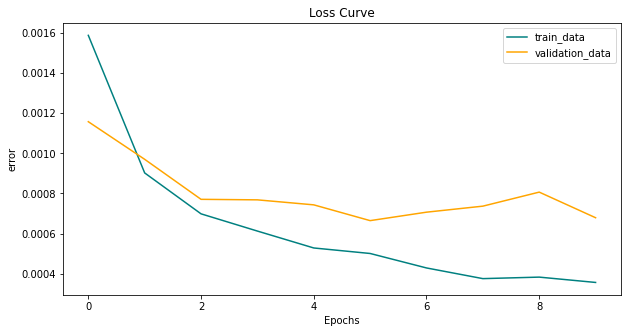

No handles with labels found to put in legend.


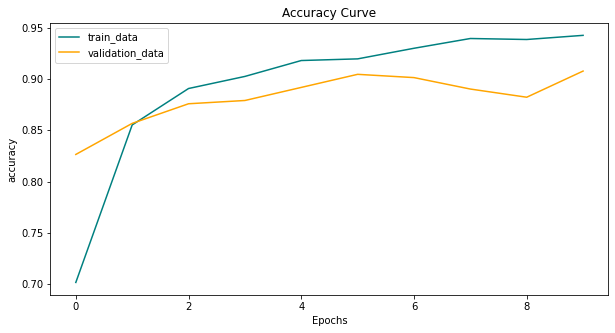

In [0]:
plot_curves("Loss Curve","error",train_error,val_error)
plot_curves("Accuracy Curve","accuracy",train_acc,val_acc)

## VGG16 Model

**Loading pre-trained model of VGG-16 for ImageNet**

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
# print(vgg16)

**Replacing Previous FC Layers with new ones**

In [0]:
features = list()
features.extend([nn.Linear(25088,4096)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear(4096,4096)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear(4096,3)])

vgg16.classifier = nn.Sequential(*features)

In [0]:
# print(vgg16)

**Loss function and optimizer**

In [0]:
Epochs = 10
criterion = FocalLoss(logits=True)
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()
train_error=[]
val_error=[]
train_acc=[]
val_acc=[]

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    running_corrects = 0.0
    num_images = 0

    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # print("LABELS\n",labels.shape)
        labels = torch.nn.functional.one_hot(labels, 3)
        labels = labels.float()
        labels[:,2]=labels[:,2]+labels[:,0] #setting pnemounia true for all COVID labeled records
        num_images = num_images+inputs.size(0)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        
        # print("\nlabels type: ",labels.shape)
        # print("\nlabels : ",labels)
#--------------------------------------------------------------------
        loss = criterion(outputs, labels)   #----> compute loss
        # print("\noutput type: ",loss.shape)
        # print("\noutputs : ",loss)
        
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        # print("loss type",loss.data)
        # print("outputs: ",outputs)
        
        ## _, preds = torch.max(outputs, 1)
        
        # print statistics
        preds = get_preds(outputs,0.5)
        # compare_preds_labels(preds,labels,3)

        running_loss += loss.item()

        # running_loss += hamming_loss(labels,preds)

        # print("labels.shape: ",labels)
        # preds = preds.view(8,1)
        # preds = torch.nn.functional.one_hot(preds, 3) #one hot vector for predictions
        # preds[:,2]=preds[:,2]+preds[:,0]
        # print("preds: ",preds)


        running_corrects += (preds==labels).prod(1).sum().item()
        print("running_corrects: ",running_corrects)
        # running_corrects += sum((preds == labels).all(axis=1)) #to get all correct predictions

        # print("preds: \n",preds)
        # print("labels: \n",labels)
        
        # print(running_corrects)
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        
    #train loss and accuracy
    epoch_loss = running_loss /num_images
    train_error.append(epoch_loss)
    epoch_acc = running_corrects / num_images
    train_acc.append(epoch_acc)

    #Validation loss and accuracy
    epoch_loss,epoch_acc = evaluate(vgg16)
    val_error.append(epoch_loss)
    val_acc.append(epoch_acc)

    print('train loss: {}\n train acc: {}\n valid loss: {}\n valid acc:{}'.format(
        train_error[epoch],train_acc[epoch],val_error[epoch],val_acc[epoch]))

    torch.save(vgg16.state_dict(), data_dir+'/vgg16_FC_Only_FL.pth')

print('Finished Training')




0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))



Train Epoch: 0 [0/6200 (0%)]	Loss: 0.180170: : 0it [00:04, ?it/s]


Train Epoch: 0 [0/6200 (0%)]	Loss: 0.180170: : 1it [00:04,  4.80s/it]

running_corrects:  7.0





Train Epoch: 0 [64/6200 (1%)]	Loss: 0.175072: : 1it [00:05,  4.80s/it]


Train Epoch: 0 [64/6200 (1%)]	Loss: 0.175072: : 2it [00:05,  3.53s/it]

running_corrects:  17.0





Train Epoch: 0 [128/6200 (2%)]	Loss: 0.171575: : 2it [00:05,  3.53s/it]


Train Epoch: 0 [128/6200 (2%)]	Loss: 0.171575: : 3it [00:05,  2.64s/it]

running_corrects:  31.0





Train Epoch: 0 [192/6200 (3%)]	Loss: 0.166613: : 3it [00:06,  2.64s/it]


Train Epoch: 0 [192/6200 (3%)]	Loss: 0.166613: : 4it [00:06,  2.02s/it]

running_corrects:  53.0





Train Epoch: 0 [256/6200 (4%)]	Loss: 0.161255: : 4it [00:07,  2.02s/it]


Train Epoch: 0 [256/6200 (4%)]	Loss: 0.161255: : 5it [00:07,  1.58s/it]

running_corrects:  77.0





Train Epoch: 0 [320/6200 (5%)]	Loss: 0.160473: : 5it [00:10,  1.58s/it]


Train Epoch: 0 [320/6200 (5%)]	Loss: 0.160473: : 6it [00:10,  2.01s/it]

running_corrects:  103.0





Train Epoch: 0 [384/6200 (6%)]	Loss: 0.156452: : 6it [00:10,  2.01s/it]


Train Epoch: 0 [384/6200 (6%)]	Loss: 0.156452: : 7it [00:10,  1.58s/it]

running_corrects:  133.0





Train Epoch: 0 [448/6200 (7%)]	Loss: 0.139960: : 7it [00:11,  1.58s/it]


Train Epoch: 0 [448/6200 (7%)]	Loss: 0.139960: : 8it [00:11,  1.27s/it]

running_corrects:  167.0





Train Epoch: 0 [512/6200 (8%)]	Loss: 0.137392: : 8it [00:11,  1.27s/it]


Train Epoch: 0 [512/6200 (8%)]	Loss: 0.137392: : 9it [00:11,  1.06s/it]

running_corrects:  204.0





Train Epoch: 0 [576/6200 (9%)]	Loss: 0.130808: : 9it [00:12,  1.06s/it]


Train Epoch: 0 [576/6200 (9%)]	Loss: 0.130808: : 10it [00:12,  1.11it/s]

running_corrects:  242.0





Train Epoch: 0 [640/6200 (10%)]	Loss: 0.127184: : 10it [00:15,  1.11it/s]


Train Epoch: 0 [640/6200 (10%)]	Loss: 0.127184: : 11it [00:15,  1.59s/it]

running_corrects:  283.0





Train Epoch: 0 [704/6200 (11%)]	Loss: 0.134769: : 11it [00:15,  1.59s/it]


Train Epoch: 0 [704/6200 (11%)]	Loss: 0.134769: : 12it [00:15,  1.26s/it]

running_corrects:  323.0





Train Epoch: 0 [768/6200 (12%)]	Loss: 0.113722: : 12it [00:16,  1.26s/it]


Train Epoch: 0 [768/6200 (12%)]	Loss: 0.113722: : 13it [00:16,  1.05s/it]

running_corrects:  368.0





Train Epoch: 0 [832/6200 (13%)]	Loss: 0.122259: : 13it [00:17,  1.05s/it]


Train Epoch: 0 [832/6200 (13%)]	Loss: 0.122259: : 14it [00:17,  1.12it/s]

running_corrects:  408.0





Train Epoch: 0 [896/6200 (14%)]	Loss: 0.124864: : 14it [00:17,  1.12it/s]


Train Epoch: 0 [896/6200 (14%)]	Loss: 0.124864: : 15it [00:17,  1.27it/s]

running_corrects:  445.0





Train Epoch: 0 [960/6200 (15%)]	Loss: 0.131249: : 15it [00:20,  1.27it/s]


Train Epoch: 0 [960/6200 (15%)]	Loss: 0.131249: : 16it [00:20,  1.38s/it]

running_corrects:  485.0





Train Epoch: 0 [1024/6200 (16%)]	Loss: 0.120000: : 16it [00:21,  1.38s/it]


Train Epoch: 0 [1024/6200 (16%)]	Loss: 0.120000: : 17it [00:21,  1.27s/it]

running_corrects:  528.0





Train Epoch: 0 [1088/6200 (18%)]	Loss: 0.115463: : 17it [00:21,  1.27s/it]


Train Epoch: 0 [1088/6200 (18%)]	Loss: 0.115463: : 18it [00:21,  1.05s/it]

running_corrects:  567.0





Train Epoch: 0 [1152/6200 (19%)]	Loss: 0.122338: : 18it [00:22,  1.05s/it]


Train Epoch: 0 [1152/6200 (19%)]	Loss: 0.122338: : 19it [00:22,  1.10it/s]

running_corrects:  610.0





Train Epoch: 0 [1216/6200 (20%)]	Loss: 0.128030: : 19it [00:23,  1.10it/s]


Train Epoch: 0 [1216/6200 (20%)]	Loss: 0.128030: : 20it [00:23,  1.26it/s]

running_corrects:  644.0





Train Epoch: 0 [1280/6200 (21%)]	Loss: 0.102665: : 20it [00:25,  1.26it/s]


Train Epoch: 0 [1280/6200 (21%)]	Loss: 0.102665: : 21it [00:25,  1.21s/it]

running_corrects:  692.0





Train Epoch: 0 [1344/6200 (22%)]	Loss: 0.119515: : 21it [00:26,  1.21s/it]


Train Epoch: 0 [1344/6200 (22%)]	Loss: 0.119515: : 22it [00:26,  1.26s/it]

running_corrects:  729.0





Train Epoch: 0 [1408/6200 (23%)]	Loss: 0.115219: : 22it [00:27,  1.26s/it]


Train Epoch: 0 [1408/6200 (23%)]	Loss: 0.115219: : 23it [00:27,  1.05s/it]

running_corrects:  771.0





Train Epoch: 0 [1472/6200 (24%)]	Loss: 0.124019: : 23it [00:27,  1.05s/it]


Train Epoch: 0 [1472/6200 (24%)]	Loss: 0.124019: : 24it [00:27,  1.12it/s]

running_corrects:  813.0





Train Epoch: 0 [1536/6200 (25%)]	Loss: 0.090679: : 24it [00:28,  1.12it/s]


Train Epoch: 0 [1536/6200 (25%)]	Loss: 0.090679: : 25it [00:28,  1.25it/s]

running_corrects:  860.0





Train Epoch: 0 [1600/6200 (26%)]	Loss: 0.103042: : 25it [00:29,  1.25it/s]


Train Epoch: 0 [1600/6200 (26%)]	Loss: 0.103042: : 26it [00:29,  1.00s/it]

running_corrects:  901.0





Train Epoch: 0 [1664/6200 (27%)]	Loss: 0.095108: : 26it [00:31,  1.00s/it]


Train Epoch: 0 [1664/6200 (27%)]	Loss: 0.095108: : 27it [00:31,  1.15s/it]

running_corrects:  948.0





Train Epoch: 0 [1728/6200 (28%)]	Loss: 0.135327: : 27it [00:31,  1.15s/it]


Train Epoch: 0 [1728/6200 (28%)]	Loss: 0.135327: : 28it [00:31,  1.04it/s]

running_corrects:  981.0





Train Epoch: 0 [1792/6200 (29%)]	Loss: 0.094855: : 28it [00:32,  1.04it/s]


Train Epoch: 0 [1792/6200 (29%)]	Loss: 0.094855: : 29it [00:32,  1.18it/s]

running_corrects:  1025.0





Train Epoch: 0 [1856/6200 (30%)]	Loss: 0.097178: : 29it [00:32,  1.18it/s]


Train Epoch: 0 [1856/6200 (30%)]	Loss: 0.097178: : 30it [00:32,  1.33it/s]

running_corrects:  1071.0





Train Epoch: 0 [1920/6200 (31%)]	Loss: 0.097051: : 30it [00:34,  1.33it/s]


Train Epoch: 0 [1920/6200 (31%)]	Loss: 0.097051: : 31it [00:34,  1.02it/s]

running_corrects:  1114.0





Train Epoch: 0 [1984/6200 (32%)]	Loss: 0.105631: : 31it [00:35,  1.02it/s]


Train Epoch: 0 [1984/6200 (32%)]	Loss: 0.105631: : 32it [00:35,  1.05s/it]

running_corrects:  1154.0





Train Epoch: 0 [2048/6200 (33%)]	Loss: 0.124827: : 32it [00:36,  1.05s/it]


Train Epoch: 0 [2048/6200 (33%)]	Loss: 0.124827: : 33it [00:36,  1.10it/s]

running_corrects:  1191.0





Train Epoch: 0 [2112/6200 (34%)]	Loss: 0.100626: : 33it [00:36,  1.10it/s]


Train Epoch: 0 [2112/6200 (34%)]	Loss: 0.100626: : 34it [00:36,  1.26it/s]

running_corrects:  1238.0





Train Epoch: 0 [2176/6200 (35%)]	Loss: 0.097596: : 34it [00:37,  1.26it/s]


Train Epoch: 0 [2176/6200 (35%)]	Loss: 0.097596: : 35it [00:37,  1.39it/s]

running_corrects:  1282.0





Train Epoch: 0 [2240/6200 (36%)]	Loss: 0.100506: : 35it [00:39,  1.39it/s]


Train Epoch: 0 [2240/6200 (36%)]	Loss: 0.100506: : 36it [00:39,  1.04s/it]

running_corrects:  1326.0





Train Epoch: 0 [2304/6200 (37%)]	Loss: 0.106621: : 36it [00:40,  1.04s/it]


Train Epoch: 0 [2304/6200 (37%)]	Loss: 0.106621: : 37it [00:40,  1.25s/it]

running_corrects:  1370.0





Train Epoch: 0 [2368/6200 (38%)]	Loss: 0.091034: : 37it [00:41,  1.25s/it]


Train Epoch: 0 [2368/6200 (38%)]	Loss: 0.091034: : 38it [00:41,  1.04s/it]

running_corrects:  1421.0





Train Epoch: 0 [2432/6200 (39%)]	Loss: 0.123444: : 38it [00:42,  1.04s/it]


Train Epoch: 0 [2432/6200 (39%)]	Loss: 0.123444: : 39it [00:42,  1.06it/s]

running_corrects:  1458.0





Train Epoch: 0 [2496/6200 (40%)]	Loss: 0.109335: : 39it [00:42,  1.06it/s]


Train Epoch: 0 [2496/6200 (40%)]	Loss: 0.109335: : 40it [00:42,  1.22it/s]

running_corrects:  1508.0





Train Epoch: 0 [2560/6200 (41%)]	Loss: 0.103833: : 40it [00:43,  1.22it/s]


Train Epoch: 0 [2560/6200 (41%)]	Loss: 0.103833: : 41it [00:43,  1.08it/s]

running_corrects:  1544.0





Train Epoch: 0 [2624/6200 (42%)]	Loss: 0.089138: : 41it [00:44,  1.08it/s]


Train Epoch: 0 [2624/6200 (42%)]	Loss: 0.089138: : 42it [00:44,  1.03s/it]

running_corrects:  1590.0





Train Epoch: 0 [2688/6200 (43%)]	Loss: 0.107854: : 42it [00:46,  1.03s/it]


Train Epoch: 0 [2688/6200 (43%)]	Loss: 0.107854: : 43it [00:46,  1.20s/it]

running_corrects:  1635.0





Train Epoch: 0 [2752/6200 (44%)]	Loss: 0.103056: : 43it [00:47,  1.20s/it]


Train Epoch: 0 [2752/6200 (44%)]	Loss: 0.103056: : 44it [00:47,  1.01it/s]

running_corrects:  1682.0





Train Epoch: 0 [2816/6200 (45%)]	Loss: 0.102526: : 44it [00:47,  1.01it/s]


Train Epoch: 0 [2816/6200 (45%)]	Loss: 0.102526: : 45it [00:47,  1.15it/s]

running_corrects:  1732.0





Train Epoch: 0 [2880/6200 (46%)]	Loss: 0.097682: : 45it [00:48,  1.15it/s]


Train Epoch: 0 [2880/6200 (46%)]	Loss: 0.097682: : 46it [00:48,  1.28it/s]

running_corrects:  1780.0





Train Epoch: 0 [2944/6200 (47%)]	Loss: 0.122193: : 46it [00:49,  1.28it/s]


Train Epoch: 0 [2944/6200 (47%)]	Loss: 0.122193: : 47it [00:49,  1.04s/it]

running_corrects:  1823.0





Train Epoch: 0 [3008/6200 (48%)]	Loss: 0.095118: : 47it [00:51,  1.04s/it]


Train Epoch: 0 [3008/6200 (48%)]	Loss: 0.095118: : 48it [00:51,  1.18s/it]

running_corrects:  1870.0





Train Epoch: 0 [3072/6200 (49%)]	Loss: 0.095464: : 48it [00:51,  1.18s/it]


Train Epoch: 0 [3072/6200 (49%)]	Loss: 0.095464: : 49it [00:51,  1.00it/s]

running_corrects:  1919.0





Train Epoch: 0 [3136/6200 (51%)]	Loss: 0.094872: : 49it [00:52,  1.00it/s]


Train Epoch: 0 [3136/6200 (51%)]	Loss: 0.094872: : 50it [00:52,  1.18it/s]

running_corrects:  1968.0





Train Epoch: 0 [3200/6200 (52%)]	Loss: 0.092443: : 50it [00:53,  1.18it/s]


Train Epoch: 0 [3200/6200 (52%)]	Loss: 0.092443: : 51it [00:53,  1.31it/s]

running_corrects:  2016.0





Train Epoch: 0 [3264/6200 (53%)]	Loss: 0.084944: : 51it [00:54,  1.31it/s]


Train Epoch: 0 [3264/6200 (53%)]	Loss: 0.084944: : 52it [00:54,  1.02it/s]

running_corrects:  2066.0





Train Epoch: 0 [3328/6200 (54%)]	Loss: 0.099677: : 52it [00:56,  1.02it/s]


Train Epoch: 0 [3328/6200 (54%)]	Loss: 0.099677: : 53it [00:56,  1.25s/it]

running_corrects:  2112.0





Train Epoch: 0 [3392/6200 (55%)]	Loss: 0.104254: : 53it [00:56,  1.25s/it]


Train Epoch: 0 [3392/6200 (55%)]	Loss: 0.104254: : 54it [00:56,  1.04s/it]

running_corrects:  2159.0





Train Epoch: 0 [3456/6200 (56%)]	Loss: 0.089254: : 54it [00:57,  1.04s/it]


Train Epoch: 0 [3456/6200 (56%)]	Loss: 0.089254: : 55it [00:57,  1.11it/s]

running_corrects:  2205.0





Train Epoch: 0 [3520/6200 (57%)]	Loss: 0.094439: : 55it [00:58,  1.11it/s]


Train Epoch: 0 [3520/6200 (57%)]	Loss: 0.094439: : 56it [00:58,  1.23it/s]

running_corrects:  2257.0





Train Epoch: 0 [3584/6200 (58%)]	Loss: 0.097727: : 56it [00:59,  1.23it/s]


Train Epoch: 0 [3584/6200 (58%)]	Loss: 0.097727: : 57it [00:59,  1.06it/s]

running_corrects:  2303.0





Train Epoch: 0 [3648/6200 (59%)]	Loss: 0.083549: : 57it [01:01,  1.06it/s]


Train Epoch: 0 [3648/6200 (59%)]	Loss: 0.083549: : 58it [01:01,  1.18s/it]

running_corrects:  2354.0





Train Epoch: 0 [3712/6200 (60%)]	Loss: 0.082602: : 58it [01:01,  1.18s/it]


Train Epoch: 0 [3712/6200 (60%)]	Loss: 0.082602: : 59it [01:01,  1.00s/it]

running_corrects:  2405.0





Train Epoch: 0 [3776/6200 (61%)]	Loss: 0.099976: : 59it [01:02,  1.00s/it]


Train Epoch: 0 [3776/6200 (61%)]	Loss: 0.099976: : 60it [01:02,  1.16it/s]

running_corrects:  2450.0





Train Epoch: 0 [3840/6200 (62%)]	Loss: 0.087649: : 60it [01:02,  1.16it/s]


Train Epoch: 0 [3840/6200 (62%)]	Loss: 0.087649: : 61it [01:02,  1.23it/s]

running_corrects:  2499.0





Train Epoch: 0 [3904/6200 (63%)]	Loss: 0.088679: : 61it [01:04,  1.23it/s]


Train Epoch: 0 [3904/6200 (63%)]	Loss: 0.088679: : 62it [01:04,  1.06it/s]

running_corrects:  2550.0





Train Epoch: 0 [3968/6200 (64%)]	Loss: 0.084656: : 62it [01:05,  1.06it/s]


Train Epoch: 0 [3968/6200 (64%)]	Loss: 0.084656: : 63it [01:05,  1.17s/it]

running_corrects:  2594.0





Train Epoch: 0 [4032/6200 (65%)]	Loss: 0.088382: : 63it [01:06,  1.17s/it]


Train Epoch: 0 [4032/6200 (65%)]	Loss: 0.088382: : 64it [01:06,  1.02it/s]

running_corrects:  2637.0





Train Epoch: 0 [4096/6200 (66%)]	Loss: 0.076677: : 64it [01:07,  1.02it/s]


Train Epoch: 0 [4096/6200 (66%)]	Loss: 0.076677: : 65it [01:07,  1.10it/s]

running_corrects:  2681.0





Train Epoch: 0 [4160/6200 (67%)]	Loss: 0.074493: : 65it [01:07,  1.10it/s]


Train Epoch: 0 [4160/6200 (67%)]	Loss: 0.074493: : 66it [01:07,  1.25it/s]

running_corrects:  2731.0





Train Epoch: 0 [4224/6200 (68%)]	Loss: 0.099897: : 66it [01:10,  1.25it/s]


Train Epoch: 0 [4224/6200 (68%)]	Loss: 0.099897: : 67it [01:10,  1.46s/it]

running_corrects:  2778.0





Train Epoch: 0 [4288/6200 (69%)]	Loss: 0.088370: : 67it [01:11,  1.46s/it]


Train Epoch: 0 [4288/6200 (69%)]	Loss: 0.088370: : 68it [01:11,  1.18s/it]

running_corrects:  2826.0





Train Epoch: 0 [4352/6200 (70%)]	Loss: 0.095161: : 68it [01:11,  1.18s/it]


Train Epoch: 0 [4352/6200 (70%)]	Loss: 0.095161: : 69it [01:11,  1.00it/s]

running_corrects:  2873.0





Train Epoch: 0 [4416/6200 (71%)]	Loss: 0.102481: : 69it [01:13,  1.00it/s]


Train Epoch: 0 [4416/6200 (71%)]	Loss: 0.102481: : 70it [01:13,  1.14s/it]

running_corrects:  2917.0





Train Epoch: 0 [4480/6200 (72%)]	Loss: 0.069791: : 70it [01:13,  1.14s/it]


Train Epoch: 0 [4480/6200 (72%)]	Loss: 0.069791: : 71it [01:13,  1.04it/s]

running_corrects:  2968.0





Train Epoch: 0 [4544/6200 (73%)]	Loss: 0.079167: : 71it [01:15,  1.04it/s]


Train Epoch: 0 [4544/6200 (73%)]	Loss: 0.079167: : 72it [01:15,  1.07s/it]

running_corrects:  3021.0





Train Epoch: 0 [4608/6200 (74%)]	Loss: 0.081390: : 72it [01:16,  1.07s/it]


Train Epoch: 0 [4608/6200 (74%)]	Loss: 0.081390: : 73it [01:16,  1.02s/it]

running_corrects:  3076.0





Train Epoch: 0 [4672/6200 (75%)]	Loss: 0.067345: : 73it [01:16,  1.02s/it]


Train Epoch: 0 [4672/6200 (75%)]	Loss: 0.067345: : 74it [01:16,  1.14it/s]

running_corrects:  3133.0





Train Epoch: 0 [4736/6200 (76%)]	Loss: 0.084842: : 74it [01:18,  1.14it/s]


Train Epoch: 0 [4736/6200 (76%)]	Loss: 0.084842: : 75it [01:18,  1.06s/it]

running_corrects:  3182.0





Train Epoch: 0 [4800/6200 (77%)]	Loss: 0.079231: : 75it [01:18,  1.06s/it]


Train Epoch: 0 [4800/6200 (77%)]	Loss: 0.079231: : 76it [01:18,  1.11it/s]

running_corrects:  3237.0





Train Epoch: 0 [4864/6200 (78%)]	Loss: 0.094584: : 76it [01:19,  1.11it/s]


Train Epoch: 0 [4864/6200 (78%)]	Loss: 0.094584: : 77it [01:19,  1.04s/it]

running_corrects:  3290.0





Train Epoch: 0 [4928/6200 (79%)]	Loss: 0.085249: : 77it [01:20,  1.04s/it]


Train Epoch: 0 [4928/6200 (79%)]	Loss: 0.085249: : 78it [01:20,  1.01s/it]

running_corrects:  3342.0





Train Epoch: 0 [4992/6200 (80%)]	Loss: 0.088066: : 78it [01:22,  1.01s/it]


Train Epoch: 0 [4992/6200 (80%)]	Loss: 0.088066: : 79it [01:22,  1.09s/it]

running_corrects:  3391.0





Train Epoch: 0 [5056/6200 (81%)]	Loss: 0.070664: : 79it [01:22,  1.09s/it]


Train Epoch: 0 [5056/6200 (81%)]	Loss: 0.070664: : 80it [01:22,  1.08it/s]

running_corrects:  3447.0





Train Epoch: 0 [5120/6200 (82%)]	Loss: 0.075107: : 80it [01:23,  1.08it/s]


Train Epoch: 0 [5120/6200 (82%)]	Loss: 0.075107: : 81it [01:23,  1.23it/s]

running_corrects:  3499.0





Train Epoch: 0 [5184/6200 (84%)]	Loss: 0.091184: : 81it [01:24,  1.23it/s]


Train Epoch: 0 [5184/6200 (84%)]	Loss: 0.091184: : 82it [01:24,  1.00s/it]

running_corrects:  3545.0





Train Epoch: 0 [5248/6200 (85%)]	Loss: 0.077656: : 82it [01:26,  1.00s/it]


Train Epoch: 0 [5248/6200 (85%)]	Loss: 0.077656: : 83it [01:26,  1.08s/it]

running_corrects:  3597.0





Train Epoch: 0 [5312/6200 (86%)]	Loss: 0.061771: : 83it [01:26,  1.08s/it]


Train Epoch: 0 [5312/6200 (86%)]	Loss: 0.061771: : 84it [01:26,  1.03s/it]

running_corrects:  3654.0





Train Epoch: 0 [5376/6200 (87%)]	Loss: 0.077724: : 84it [01:27,  1.03s/it]


Train Epoch: 0 [5376/6200 (87%)]	Loss: 0.077724: : 85it [01:27,  1.10it/s]

running_corrects:  3703.0





Train Epoch: 0 [5440/6200 (88%)]	Loss: 0.083247: : 85it [01:28,  1.10it/s]


Train Epoch: 0 [5440/6200 (88%)]	Loss: 0.083247: : 86it [01:28,  1.25it/s]

running_corrects:  3752.0





Train Epoch: 0 [5504/6200 (89%)]	Loss: 0.081108: : 86it [01:29,  1.25it/s]


Train Epoch: 0 [5504/6200 (89%)]	Loss: 0.081108: : 87it [01:29,  1.00s/it]

running_corrects:  3805.0





Train Epoch: 0 [5568/6200 (90%)]	Loss: 0.079228: : 87it [01:31,  1.00s/it]


Train Epoch: 0 [5568/6200 (90%)]	Loss: 0.079228: : 88it [01:31,  1.19s/it]

running_corrects:  3854.0





Train Epoch: 0 [5632/6200 (91%)]	Loss: 0.080522: : 88it [01:31,  1.19s/it]


Train Epoch: 0 [5632/6200 (91%)]	Loss: 0.080522: : 89it [01:31,  1.01s/it]

running_corrects:  3907.0





Train Epoch: 0 [5696/6200 (92%)]	Loss: 0.073038: : 89it [01:32,  1.01s/it]


Train Epoch: 0 [5696/6200 (92%)]	Loss: 0.073038: : 90it [01:32,  1.10it/s]

running_corrects:  3959.0





Train Epoch: 0 [5760/6200 (93%)]	Loss: 0.057244: : 90it [01:33,  1.10it/s]


Train Epoch: 0 [5760/6200 (93%)]	Loss: 0.057244: : 91it [01:33,  1.24it/s]

running_corrects:  4015.0





Train Epoch: 0 [5824/6200 (94%)]	Loss: 0.068708: : 91it [01:34,  1.24it/s]


Train Epoch: 0 [5824/6200 (94%)]	Loss: 0.068708: : 92it [01:34,  1.03it/s]

running_corrects:  4071.0





Train Epoch: 0 [5888/6200 (95%)]	Loss: 0.079048: : 92it [01:36,  1.03it/s]


Train Epoch: 0 [5888/6200 (95%)]	Loss: 0.079048: : 93it [01:36,  1.36s/it]

running_corrects:  4122.0





Train Epoch: 0 [5952/6200 (96%)]	Loss: 0.077202: : 93it [01:37,  1.36s/it]


Train Epoch: 0 [5952/6200 (96%)]	Loss: 0.077202: : 94it [01:37,  1.10s/it]

running_corrects:  4175.0





Train Epoch: 0 [6016/6200 (97%)]	Loss: 0.079921: : 94it [01:37,  1.10s/it]


Train Epoch: 0 [6016/6200 (97%)]	Loss: 0.079921: : 95it [01:37,  1.08it/s]

running_corrects:  4224.0





Train Epoch: 0 [6080/6200 (98%)]	Loss: 0.063124: : 95it [01:38,  1.08it/s]


Train Epoch: 0 [6080/6200 (98%)]	Loss: 0.063124: : 96it [01:38,  1.26it/s]

running_corrects:  4277.0





Train Epoch: 0 [5376/6200 (99%)]	Loss: 0.071457: : 96it [01:38,  1.26it/s]


Train Epoch: 0 [5376/6200 (99%)]	Loss: 0.071457: : 97it [01:38,  1.02s/it]

running_corrects:  4323.0






0it [00:00, ?it/s]


1it [00:05,  5.46s/it]


2it [00:05,  3.88s/it]


3it [00:05,  2.79s/it]


4it [00:06,  2.01s/it]


5it [00:06,  1.48s/it]


6it [00:09,  1.92s/it]


7it [00:09,  1.39s/it]


8it [00:09,  1.02s/it]


9it [00:09,  1.30it/s]


10it [00:10,  1.01s/it]


train loss: 0.001590095029603089
 train acc: 0.697258064516129
 valid loss: 0.0011338299069150238
 valid acc:0.8455414012738853





0it [00:00, ?it/s]


Train Epoch: 1 [0/6200 (0%)]	Loss: 0.061822: : 0it [00:05, ?it/s]


Train Epoch: 1 [0/6200 (0%)]	Loss: 0.061822: : 1it [00:05,  5.29s/it]

running_corrects:  55.0





Train Epoch: 1 [64/6200 (1%)]	Loss: 0.058829: : 1it [00:05,  5.29s/it]


Train Epoch: 1 [64/6200 (1%)]	Loss: 0.058829: : 2it [00:05,  3.86s/it]

running_corrects:  110.0





Train Epoch: 1 [128/6200 (2%)]	Loss: 0.050559: : 2it [00:06,  3.86s/it]


Train Epoch: 1 [128/6200 (2%)]	Loss: 0.050559: : 3it [00:06,  2.87s/it]

running_corrects:  167.0





Train Epoch: 1 [192/6200 (3%)]	Loss: 0.064888: : 3it [00:06,  2.87s/it]


Train Epoch: 1 [192/6200 (3%)]	Loss: 0.064888: : 4it [00:06,  2.17s/it]

running_corrects:  218.0





Train Epoch: 1 [256/6200 (4%)]	Loss: 0.052767: : 4it [00:07,  2.17s/it]


Train Epoch: 1 [256/6200 (4%)]	Loss: 0.052767: : 5it [00:07,  1.70s/it]

running_corrects:  278.0





Train Epoch: 1 [320/6200 (5%)]	Loss: 0.055048: : 5it [00:10,  1.70s/it]


Train Epoch: 1 [320/6200 (5%)]	Loss: 0.055048: : 6it [00:10,  2.16s/it]

running_corrects:  334.0





Train Epoch: 1 [384/6200 (6%)]	Loss: 0.060625: : 6it [00:11,  2.16s/it]


Train Epoch: 1 [384/6200 (6%)]	Loss: 0.060625: : 7it [00:11,  1.69s/it]

running_corrects:  387.0





Train Epoch: 1 [448/6200 (7%)]	Loss: 0.060028: : 7it [00:11,  1.69s/it]


Train Epoch: 1 [448/6200 (7%)]	Loss: 0.060028: : 8it [00:11,  1.34s/it]

running_corrects:  442.0





Train Epoch: 1 [512/6200 (8%)]	Loss: 0.061959: : 8it [00:12,  1.34s/it]


Train Epoch: 1 [512/6200 (8%)]	Loss: 0.061959: : 9it [00:12,  1.11s/it]

running_corrects:  495.0





Train Epoch: 1 [576/6200 (9%)]	Loss: 0.073893: : 9it [00:12,  1.11s/it]


Train Epoch: 1 [576/6200 (9%)]	Loss: 0.073893: : 10it [00:12,  1.06it/s]

running_corrects:  543.0





Train Epoch: 1 [640/6200 (10%)]	Loss: 0.098158: : 10it [00:17,  1.06it/s]


Train Epoch: 1 [640/6200 (10%)]	Loss: 0.098158: : 11it [00:17,  2.01s/it]

running_corrects:  593.0





Train Epoch: 1 [704/6200 (11%)]	Loss: 0.053955: : 11it [00:18,  2.01s/it]


Train Epoch: 1 [704/6200 (11%)]	Loss: 0.053955: : 12it [00:18,  1.57s/it]

running_corrects:  652.0





Train Epoch: 1 [768/6200 (12%)]	Loss: 0.059754: : 12it [00:18,  1.57s/it]


Train Epoch: 1 [768/6200 (12%)]	Loss: 0.059754: : 13it [00:18,  1.27s/it]

running_corrects:  706.0





Train Epoch: 1 [832/6200 (13%)]	Loss: 0.096127: : 13it [00:19,  1.27s/it]


Train Epoch: 1 [832/6200 (13%)]	Loss: 0.096127: : 14it [00:19,  1.06s/it]

running_corrects:  755.0





Train Epoch: 1 [896/6200 (14%)]	Loss: 0.071331: : 14it [00:19,  1.06s/it]


Train Epoch: 1 [896/6200 (14%)]	Loss: 0.071331: : 15it [00:19,  1.08it/s]

running_corrects:  808.0





Train Epoch: 1 [960/6200 (15%)]	Loss: 0.055518: : 15it [00:23,  1.08it/s]


Train Epoch: 1 [960/6200 (15%)]	Loss: 0.055518: : 16it [00:23,  1.73s/it]

running_corrects:  863.0





Train Epoch: 1 [1024/6200 (16%)]	Loss: 0.084654: : 16it [00:23,  1.73s/it]


Train Epoch: 1 [1024/6200 (16%)]	Loss: 0.084654: : 17it [00:23,  1.38s/it]

running_corrects:  916.0





Train Epoch: 1 [1088/6200 (18%)]	Loss: 0.065138: : 17it [00:24,  1.38s/it]


Train Epoch: 1 [1088/6200 (18%)]	Loss: 0.065138: : 18it [00:24,  1.13s/it]

running_corrects:  970.0





Train Epoch: 1 [1152/6200 (19%)]	Loss: 0.107180: : 18it [00:25,  1.13s/it]


Train Epoch: 1 [1152/6200 (19%)]	Loss: 0.107180: : 19it [00:25,  1.05it/s]

running_corrects:  1014.0





Train Epoch: 1 [1216/6200 (20%)]	Loss: 0.078004: : 19it [00:25,  1.05it/s]


Train Epoch: 1 [1216/6200 (20%)]	Loss: 0.078004: : 20it [00:25,  1.21it/s]

running_corrects:  1065.0





Train Epoch: 1 [1280/6200 (21%)]	Loss: 0.068031: : 20it [00:28,  1.21it/s]


Train Epoch: 1 [1280/6200 (21%)]	Loss: 0.068031: : 21it [00:28,  1.33s/it]

running_corrects:  1117.0





Train Epoch: 1 [1344/6200 (22%)]	Loss: 0.061368: : 21it [00:28,  1.33s/it]


Train Epoch: 1 [1344/6200 (22%)]	Loss: 0.061368: : 22it [00:28,  1.08s/it]

running_corrects:  1172.0





Train Epoch: 1 [1408/6200 (23%)]	Loss: 0.058509: : 22it [00:29,  1.08s/it]


Train Epoch: 1 [1408/6200 (23%)]	Loss: 0.058509: : 23it [00:29,  1.08it/s]

running_corrects:  1226.0





Train Epoch: 1 [1472/6200 (24%)]	Loss: 0.057187: : 23it [00:29,  1.08it/s]


Train Epoch: 1 [1472/6200 (24%)]	Loss: 0.057187: : 24it [00:29,  1.24it/s]

running_corrects:  1283.0





Train Epoch: 1 [1536/6200 (25%)]	Loss: 0.061833: : 24it [00:30,  1.24it/s]


Train Epoch: 1 [1536/6200 (25%)]	Loss: 0.061833: : 25it [00:30,  1.25it/s]

running_corrects:  1333.0





Train Epoch: 1 [1600/6200 (26%)]	Loss: 0.047835: : 25it [00:32,  1.25it/s]


Train Epoch: 1 [1600/6200 (26%)]	Loss: 0.047835: : 26it [00:32,  1.27s/it]

running_corrects:  1390.0





Train Epoch: 1 [1664/6200 (27%)]	Loss: 0.067367: : 26it [00:33,  1.27s/it]


Train Epoch: 1 [1664/6200 (27%)]	Loss: 0.067367: : 27it [00:33,  1.07s/it]

running_corrects:  1442.0





Train Epoch: 1 [1728/6200 (28%)]	Loss: 0.063275: : 27it [00:34,  1.07s/it]


Train Epoch: 1 [1728/6200 (28%)]	Loss: 0.063275: : 28it [00:34,  1.05it/s]

running_corrects:  1496.0





Train Epoch: 1 [1792/6200 (29%)]	Loss: 0.048126: : 28it [00:34,  1.05it/s]


Train Epoch: 1 [1792/6200 (29%)]	Loss: 0.048126: : 29it [00:34,  1.19it/s]

running_corrects:  1552.0





Train Epoch: 1 [1856/6200 (30%)]	Loss: 0.058890: : 29it [00:35,  1.19it/s]


Train Epoch: 1 [1856/6200 (30%)]	Loss: 0.058890: : 30it [00:35,  1.13it/s]

running_corrects:  1602.0





Train Epoch: 1 [1920/6200 (31%)]	Loss: 0.048372: : 30it [00:37,  1.13it/s]


Train Epoch: 1 [1920/6200 (31%)]	Loss: 0.048372: : 31it [00:37,  1.16s/it]

running_corrects:  1658.0





Train Epoch: 1 [1984/6200 (32%)]	Loss: 0.059739: : 31it [00:38,  1.16s/it]


Train Epoch: 1 [1984/6200 (32%)]	Loss: 0.059739: : 32it [00:38,  1.27s/it]

running_corrects:  1712.0





Train Epoch: 1 [2048/6200 (33%)]	Loss: 0.051542: : 32it [00:39,  1.27s/it]


Train Epoch: 1 [2048/6200 (33%)]	Loss: 0.051542: : 33it [00:39,  1.07s/it]

running_corrects:  1771.0





Train Epoch: 1 [2112/6200 (34%)]	Loss: 0.060939: : 33it [00:40,  1.07s/it]


Train Epoch: 1 [2112/6200 (34%)]	Loss: 0.060939: : 34it [00:40,  1.09it/s]

running_corrects:  1826.0





Train Epoch: 1 [2176/6200 (35%)]	Loss: 0.055547: : 34it [00:40,  1.09it/s]


Train Epoch: 1 [2176/6200 (35%)]	Loss: 0.055547: : 35it [00:40,  1.15it/s]

running_corrects:  1880.0





Train Epoch: 1 [2240/6200 (36%)]	Loss: 0.066642: : 35it [00:42,  1.15it/s]


Train Epoch: 1 [2240/6200 (36%)]	Loss: 0.066642: : 36it [00:42,  1.16s/it]

running_corrects:  1933.0





Train Epoch: 1 [2304/6200 (37%)]	Loss: 0.068765: : 36it [00:45,  1.16s/it]


Train Epoch: 1 [2304/6200 (37%)]	Loss: 0.068765: : 37it [00:45,  1.69s/it]

running_corrects:  1985.0





Train Epoch: 1 [2368/6200 (38%)]	Loss: 0.065699: : 37it [00:46,  1.69s/it]


Train Epoch: 1 [2368/6200 (38%)]	Loss: 0.065699: : 38it [00:46,  1.34s/it]

running_corrects:  2038.0





Train Epoch: 1 [2432/6200 (39%)]	Loss: 0.067265: : 38it [00:46,  1.34s/it]


Train Epoch: 1 [2432/6200 (39%)]	Loss: 0.067265: : 39it [00:46,  1.12s/it]

running_corrects:  2093.0





Train Epoch: 1 [2496/6200 (40%)]	Loss: 0.047100: : 39it [00:47,  1.12s/it]


Train Epoch: 1 [2496/6200 (40%)]	Loss: 0.047100: : 40it [00:47,  1.07it/s]

running_corrects:  2152.0





Train Epoch: 1 [2560/6200 (41%)]	Loss: 0.042475: : 40it [00:48,  1.07it/s]


Train Epoch: 1 [2560/6200 (41%)]	Loss: 0.042475: : 41it [00:48,  1.06s/it]

running_corrects:  2211.0





Train Epoch: 1 [2624/6200 (42%)]	Loss: 0.079704: : 41it [00:50,  1.06s/it]


Train Epoch: 1 [2624/6200 (42%)]	Loss: 0.079704: : 42it [00:50,  1.41s/it]

running_corrects:  2260.0





Train Epoch: 1 [2688/6200 (43%)]	Loss: 0.054664: : 42it [00:51,  1.41s/it]


Train Epoch: 1 [2688/6200 (43%)]	Loss: 0.054664: : 43it [00:51,  1.16s/it]

running_corrects:  2316.0





Train Epoch: 1 [2752/6200 (44%)]	Loss: 0.054485: : 43it [00:51,  1.16s/it]


Train Epoch: 1 [2752/6200 (44%)]	Loss: 0.054485: : 44it [00:51,  1.03it/s]

running_corrects:  2369.0





Train Epoch: 1 [2816/6200 (45%)]	Loss: 0.067112: : 44it [00:52,  1.03it/s]


Train Epoch: 1 [2816/6200 (45%)]	Loss: 0.067112: : 45it [00:52,  1.17it/s]

running_corrects:  2425.0





Train Epoch: 1 [2880/6200 (46%)]	Loss: 0.059590: : 45it [00:53,  1.17it/s]


Train Epoch: 1 [2880/6200 (46%)]	Loss: 0.059590: : 46it [00:53,  1.02s/it]

running_corrects:  2479.0





Train Epoch: 1 [2944/6200 (47%)]	Loss: 0.076606: : 46it [00:55,  1.02s/it]


Train Epoch: 1 [2944/6200 (47%)]	Loss: 0.076606: : 47it [00:55,  1.23s/it]

running_corrects:  2531.0





Train Epoch: 1 [3008/6200 (48%)]	Loss: 0.046869: : 47it [00:56,  1.23s/it]


Train Epoch: 1 [3008/6200 (48%)]	Loss: 0.046869: : 48it [00:56,  1.02s/it]

running_corrects:  2589.0





Train Epoch: 1 [3072/6200 (49%)]	Loss: 0.051102: : 48it [00:56,  1.02s/it]


Train Epoch: 1 [3072/6200 (49%)]	Loss: 0.051102: : 49it [00:56,  1.12it/s]

running_corrects:  2646.0





Train Epoch: 1 [3136/6200 (51%)]	Loss: 0.063477: : 49it [00:57,  1.12it/s]


Train Epoch: 1 [3136/6200 (51%)]	Loss: 0.063477: : 50it [00:57,  1.27it/s]

running_corrects:  2702.0





Train Epoch: 1 [3200/6200 (52%)]	Loss: 0.054786: : 50it [00:58,  1.27it/s]


Train Epoch: 1 [3200/6200 (52%)]	Loss: 0.054786: : 51it [00:58,  1.06it/s]

running_corrects:  2757.0





Train Epoch: 1 [3264/6200 (53%)]	Loss: 0.038400: : 51it [01:00,  1.06it/s]


Train Epoch: 1 [3264/6200 (53%)]	Loss: 0.038400: : 52it [01:00,  1.18s/it]

running_corrects:  2815.0





Train Epoch: 1 [3328/6200 (54%)]	Loss: 0.084789: : 52it [01:01,  1.18s/it]


Train Epoch: 1 [3328/6200 (54%)]	Loss: 0.084789: : 53it [01:01,  1.17s/it]

running_corrects:  2865.0





Train Epoch: 1 [3392/6200 (55%)]	Loss: 0.057860: : 53it [01:02,  1.17s/it]


Train Epoch: 1 [3392/6200 (55%)]	Loss: 0.057860: : 54it [01:02,  1.03it/s]

running_corrects:  2920.0





Train Epoch: 1 [3456/6200 (56%)]	Loss: 0.041207: : 54it [01:02,  1.03it/s]


Train Epoch: 1 [3456/6200 (56%)]	Loss: 0.041207: : 55it [01:02,  1.16it/s]

running_corrects:  2977.0





Train Epoch: 1 [3520/6200 (57%)]	Loss: 0.071592: : 55it [01:03,  1.16it/s]


Train Epoch: 1 [3520/6200 (57%)]	Loss: 0.071592: : 56it [01:03,  1.30it/s]

running_corrects:  3030.0





Train Epoch: 1 [3584/6200 (58%)]	Loss: 0.048801: : 56it [01:05,  1.30it/s]


Train Epoch: 1 [3584/6200 (58%)]	Loss: 0.048801: : 57it [01:05,  1.14s/it]

running_corrects:  3088.0





Train Epoch: 1 [3648/6200 (59%)]	Loss: 0.046110: : 57it [01:06,  1.14s/it]


Train Epoch: 1 [3648/6200 (59%)]	Loss: 0.046110: : 58it [01:06,  1.15s/it]

running_corrects:  3145.0





Train Epoch: 1 [3712/6200 (60%)]	Loss: 0.039822: : 58it [01:06,  1.15s/it]


Train Epoch: 1 [3712/6200 (60%)]	Loss: 0.039822: : 59it [01:06,  1.03it/s]

running_corrects:  3205.0





Train Epoch: 1 [3776/6200 (61%)]	Loss: 0.050204: : 59it [01:07,  1.03it/s]


Train Epoch: 1 [3776/6200 (61%)]	Loss: 0.050204: : 60it [01:07,  1.20it/s]

running_corrects:  3262.0





Train Epoch: 1 [3840/6200 (62%)]	Loss: 0.056656: : 60it [01:08,  1.20it/s]


Train Epoch: 1 [3840/6200 (62%)]	Loss: 0.056656: : 61it [01:08,  1.32it/s]

running_corrects:  3319.0





Train Epoch: 1 [3904/6200 (63%)]	Loss: 0.061077: : 61it [01:09,  1.32it/s]


Train Epoch: 1 [3904/6200 (63%)]	Loss: 0.061077: : 62it [01:09,  1.09s/it]

running_corrects:  3375.0





Train Epoch: 1 [3968/6200 (64%)]	Loss: 0.050209: : 62it [01:10,  1.09s/it]


Train Epoch: 1 [3968/6200 (64%)]	Loss: 0.050209: : 63it [01:10,  1.06s/it]

running_corrects:  3431.0





Train Epoch: 1 [4032/6200 (65%)]	Loss: 0.042057: : 63it [01:11,  1.06s/it]


Train Epoch: 1 [4032/6200 (65%)]	Loss: 0.042057: : 64it [01:11,  1.12it/s]

running_corrects:  3488.0





Train Epoch: 1 [4096/6200 (66%)]	Loss: 0.070295: : 64it [01:11,  1.12it/s]


Train Epoch: 1 [4096/6200 (66%)]	Loss: 0.070295: : 65it [01:11,  1.27it/s]

running_corrects:  3542.0





Train Epoch: 1 [4160/6200 (67%)]	Loss: 0.065898: : 65it [01:12,  1.27it/s]


Train Epoch: 1 [4160/6200 (67%)]	Loss: 0.065898: : 66it [01:12,  1.27it/s]

running_corrects:  3592.0





Train Epoch: 1 [4224/6200 (68%)]	Loss: 0.050981: : 66it [01:14,  1.27it/s]


Train Epoch: 1 [4224/6200 (68%)]	Loss: 0.050981: : 67it [01:14,  1.23s/it]

running_corrects:  3651.0





Train Epoch: 1 [4288/6200 (69%)]	Loss: 0.062769: : 67it [01:15,  1.23s/it]


Train Epoch: 1 [4288/6200 (69%)]	Loss: 0.062769: : 68it [01:15,  1.07s/it]

running_corrects:  3705.0





Train Epoch: 1 [4352/6200 (70%)]	Loss: 0.045967: : 68it [01:16,  1.07s/it]


Train Epoch: 1 [4352/6200 (70%)]	Loss: 0.045967: : 69it [01:16,  1.09it/s]

running_corrects:  3761.0





Train Epoch: 1 [4416/6200 (71%)]	Loss: 0.035402: : 69it [01:16,  1.09it/s]


Train Epoch: 1 [4416/6200 (71%)]	Loss: 0.035402: : 70it [01:16,  1.24it/s]

running_corrects:  3820.0





Train Epoch: 1 [4480/6200 (72%)]	Loss: 0.058244: : 70it [01:17,  1.24it/s]


Train Epoch: 1 [4480/6200 (72%)]	Loss: 0.058244: : 71it [01:17,  1.33it/s]

running_corrects:  3877.0





Train Epoch: 1 [4544/6200 (73%)]	Loss: 0.074412: : 71it [01:19,  1.33it/s]


Train Epoch: 1 [4544/6200 (73%)]	Loss: 0.074412: : 72it [01:19,  1.22s/it]

running_corrects:  3932.0





Train Epoch: 1 [4608/6200 (74%)]	Loss: 0.059668: : 72it [01:21,  1.22s/it]


Train Epoch: 1 [4608/6200 (74%)]	Loss: 0.059668: : 73it [01:21,  1.25s/it]

running_corrects:  3986.0





Train Epoch: 1 [4672/6200 (75%)]	Loss: 0.082065: : 73it [01:21,  1.25s/it]


Train Epoch: 1 [4672/6200 (75%)]	Loss: 0.082065: : 74it [01:21,  1.03s/it]

running_corrects:  4040.0





Train Epoch: 1 [4736/6200 (76%)]	Loss: 0.065627: : 74it [01:22,  1.03s/it]


Train Epoch: 1 [4736/6200 (76%)]	Loss: 0.065627: : 75it [01:22,  1.13it/s]

running_corrects:  4094.0





Train Epoch: 1 [4800/6200 (77%)]	Loss: 0.058166: : 75it [01:22,  1.13it/s]


Train Epoch: 1 [4800/6200 (77%)]	Loss: 0.058166: : 76it [01:22,  1.28it/s]

running_corrects:  4148.0





Train Epoch: 1 [4864/6200 (78%)]	Loss: 0.057838: : 76it [01:25,  1.28it/s]


Train Epoch: 1 [4864/6200 (78%)]	Loss: 0.057838: : 77it [01:25,  1.45s/it]

running_corrects:  4203.0





Train Epoch: 1 [4928/6200 (79%)]	Loss: 0.062840: : 77it [01:26,  1.45s/it]


Train Epoch: 1 [4928/6200 (79%)]	Loss: 0.062840: : 78it [01:26,  1.17s/it]

running_corrects:  4259.0





Train Epoch: 1 [4992/6200 (80%)]	Loss: 0.054960: : 78it [01:26,  1.17s/it]


Train Epoch: 1 [4992/6200 (80%)]	Loss: 0.054960: : 79it [01:26,  1.01it/s]

running_corrects:  4314.0





Train Epoch: 1 [5056/6200 (81%)]	Loss: 0.052424: : 79it [01:27,  1.01it/s]


Train Epoch: 1 [5056/6200 (81%)]	Loss: 0.052424: : 80it [01:27,  1.18it/s]

running_corrects:  4371.0





Train Epoch: 1 [5120/6200 (82%)]	Loss: 0.044936: : 80it [01:27,  1.18it/s]


Train Epoch: 1 [5120/6200 (82%)]	Loss: 0.044936: : 81it [01:27,  1.31it/s]

running_corrects:  4428.0





Train Epoch: 1 [5184/6200 (84%)]	Loss: 0.069190: : 81it [01:30,  1.31it/s]


Train Epoch: 1 [5184/6200 (84%)]	Loss: 0.069190: : 82it [01:30,  1.26s/it]

running_corrects:  4478.0





Train Epoch: 1 [5248/6200 (85%)]	Loss: 0.047735: : 82it [01:31,  1.26s/it]


Train Epoch: 1 [5248/6200 (85%)]	Loss: 0.047735: : 83it [01:31,  1.22s/it]

running_corrects:  4534.0





Train Epoch: 1 [5312/6200 (86%)]	Loss: 0.041651: : 83it [01:31,  1.22s/it]


Train Epoch: 1 [5312/6200 (86%)]	Loss: 0.041651: : 84it [01:31,  1.01s/it]

running_corrects:  4592.0





Train Epoch: 1 [5376/6200 (87%)]	Loss: 0.048153: : 84it [01:32,  1.01s/it]


Train Epoch: 1 [5376/6200 (87%)]	Loss: 0.048153: : 85it [01:32,  1.14it/s]

running_corrects:  4649.0





Train Epoch: 1 [5440/6200 (88%)]	Loss: 0.044515: : 85it [01:33,  1.14it/s]


Train Epoch: 1 [5440/6200 (88%)]	Loss: 0.044515: : 86it [01:33,  1.29it/s]

running_corrects:  4705.0





Train Epoch: 1 [5504/6200 (89%)]	Loss: 0.039612: : 86it [01:35,  1.29it/s]


Train Epoch: 1 [5504/6200 (89%)]	Loss: 0.039612: : 87it [01:35,  1.29s/it]

running_corrects:  4766.0





Train Epoch: 1 [5568/6200 (90%)]	Loss: 0.062348: : 87it [01:36,  1.29s/it]


Train Epoch: 1 [5568/6200 (90%)]	Loss: 0.062348: : 88it [01:36,  1.18s/it]

running_corrects:  4821.0





Train Epoch: 1 [5632/6200 (91%)]	Loss: 0.072306: : 88it [01:36,  1.18s/it]


Train Epoch: 1 [5632/6200 (91%)]	Loss: 0.072306: : 89it [01:36,  1.00it/s]

running_corrects:  4873.0





Train Epoch: 1 [5696/6200 (92%)]	Loss: 0.061866: : 89it [01:37,  1.00it/s]


Train Epoch: 1 [5696/6200 (92%)]	Loss: 0.061866: : 90it [01:37,  1.17it/s]

running_corrects:  4928.0





Train Epoch: 1 [5760/6200 (93%)]	Loss: 0.055001: : 90it [01:38,  1.17it/s]


Train Epoch: 1 [5760/6200 (93%)]	Loss: 0.055001: : 91it [01:38,  1.32it/s]

running_corrects:  4982.0





Train Epoch: 1 [5824/6200 (94%)]	Loss: 0.065573: : 91it [01:39,  1.32it/s]


Train Epoch: 1 [5824/6200 (94%)]	Loss: 0.065573: : 92it [01:39,  1.03it/s]

running_corrects:  5032.0





Train Epoch: 1 [5888/6200 (95%)]	Loss: 0.058650: : 92it [01:40,  1.03it/s]


Train Epoch: 1 [5888/6200 (95%)]	Loss: 0.058650: : 93it [01:40,  1.13it/s]

running_corrects:  5084.0





Train Epoch: 1 [5952/6200 (96%)]	Loss: 0.069295: : 93it [01:40,  1.13it/s]


Train Epoch: 1 [5952/6200 (96%)]	Loss: 0.069295: : 94it [01:40,  1.30it/s]

running_corrects:  5136.0





Train Epoch: 1 [6016/6200 (97%)]	Loss: 0.061006: : 94it [01:41,  1.30it/s]


Train Epoch: 1 [6016/6200 (97%)]	Loss: 0.061006: : 95it [01:41,  1.45it/s]

running_corrects:  5189.0





Train Epoch: 1 [6080/6200 (98%)]	Loss: 0.039919: : 95it [01:41,  1.45it/s]


Train Epoch: 1 [6080/6200 (98%)]	Loss: 0.039919: : 96it [01:41,  1.59it/s]

running_corrects:  5249.0





Train Epoch: 1 [5376/6200 (99%)]	Loss: 0.064893: : 96it [01:42,  1.59it/s]


Train Epoch: 1 [5376/6200 (99%)]	Loss: 0.064893: : 97it [01:42,  1.05s/it]

running_corrects:  5296.0






0it [00:00, ?it/s]


1it [00:04,  4.41s/it]


2it [00:05,  3.48s/it]


3it [00:05,  2.51s/it]


4it [00:06,  1.81s/it]


5it [00:06,  1.34s/it]


6it [00:08,  1.65s/it]


7it [00:09,  1.36s/it]


8it [00:09,  1.00s/it]


9it [00:09,  1.33it/s]


10it [00:10,  1.00s/it]


train loss: 0.0009351815806040841
 train acc: 0.8541935483870968
 valid loss: 0.0009226667024432474
 valid acc:0.8742038216560509





0it [00:00, ?it/s]


Train Epoch: 2 [0/6200 (0%)]	Loss: 0.037736: : 0it [00:04, ?it/s]


Train Epoch: 2 [0/6200 (0%)]	Loss: 0.037736: : 1it [00:04,  4.78s/it]

running_corrects:  58.0





Train Epoch: 2 [64/6200 (1%)]	Loss: 0.071387: : 1it [00:05,  4.78s/it]


Train Epoch: 2 [64/6200 (1%)]	Loss: 0.071387: : 2it [00:05,  3.52s/it]

running_corrects:  112.0





Train Epoch: 2 [128/6200 (2%)]	Loss: 0.056747: : 2it [00:05,  3.52s/it]


Train Epoch: 2 [128/6200 (2%)]	Loss: 0.056747: : 3it [00:05,  2.63s/it]

running_corrects:  165.0





Train Epoch: 2 [192/6200 (3%)]	Loss: 0.048854: : 3it [00:06,  2.63s/it]


Train Epoch: 2 [192/6200 (3%)]	Loss: 0.048854: : 4it [00:06,  2.01s/it]

running_corrects:  220.0





Train Epoch: 2 [256/6200 (4%)]	Loss: 0.032062: : 4it [00:07,  2.01s/it]


Train Epoch: 2 [256/6200 (4%)]	Loss: 0.032062: : 5it [00:07,  1.57s/it]

running_corrects:  280.0





Train Epoch: 2 [320/6200 (5%)]	Loss: 0.062284: : 5it [00:10,  1.57s/it]


Train Epoch: 2 [320/6200 (5%)]	Loss: 0.062284: : 6it [00:10,  2.06s/it]

running_corrects:  335.0





Train Epoch: 2 [384/6200 (6%)]	Loss: 0.052819: : 6it [00:10,  2.06s/it]


Train Epoch: 2 [384/6200 (6%)]	Loss: 0.052819: : 7it [00:10,  1.63s/it]

running_corrects:  392.0





Train Epoch: 2 [448/6200 (7%)]	Loss: 0.063776: : 7it [00:11,  1.63s/it]


Train Epoch: 2 [448/6200 (7%)]	Loss: 0.063776: : 8it [00:11,  1.30s/it]

running_corrects:  445.0





Train Epoch: 2 [512/6200 (8%)]	Loss: 0.039163: : 8it [00:11,  1.30s/it]


Train Epoch: 2 [512/6200 (8%)]	Loss: 0.039163: : 9it [00:11,  1.09s/it]

running_corrects:  504.0





Train Epoch: 2 [576/6200 (9%)]	Loss: 0.056847: : 9it [00:12,  1.09s/it]


Train Epoch: 2 [576/6200 (9%)]	Loss: 0.056847: : 10it [00:12,  1.08it/s]

running_corrects:  560.0





Train Epoch: 2 [640/6200 (10%)]	Loss: 0.062282: : 10it [00:17,  1.08it/s]


Train Epoch: 2 [640/6200 (10%)]	Loss: 0.062282: : 11it [00:17,  2.24s/it]

running_corrects:  614.0





Train Epoch: 2 [704/6200 (11%)]	Loss: 0.057046: : 11it [00:18,  2.24s/it]


Train Epoch: 2 [704/6200 (11%)]	Loss: 0.057046: : 12it [00:18,  1.74s/it]

running_corrects:  668.0





Train Epoch: 2 [768/6200 (12%)]	Loss: 0.030916: : 12it [00:18,  1.74s/it]


Train Epoch: 2 [768/6200 (12%)]	Loss: 0.030916: : 13it [00:18,  1.39s/it]

running_corrects:  728.0





Train Epoch: 2 [832/6200 (13%)]	Loss: 0.060549: : 13it [00:19,  1.39s/it]


Train Epoch: 2 [832/6200 (13%)]	Loss: 0.060549: : 14it [00:19,  1.15s/it]

running_corrects:  780.0





Train Epoch: 2 [896/6200 (14%)]	Loss: 0.060304: : 14it [00:20,  1.15s/it]


Train Epoch: 2 [896/6200 (14%)]	Loss: 0.060304: : 15it [00:20,  1.03it/s]

running_corrects:  836.0





Train Epoch: 2 [960/6200 (15%)]	Loss: 0.042721: : 15it [00:23,  1.03it/s]


Train Epoch: 2 [960/6200 (15%)]	Loss: 0.042721: : 16it [00:23,  1.74s/it]

running_corrects:  893.0





Train Epoch: 2 [1024/6200 (16%)]	Loss: 0.063131: : 16it [00:24,  1.74s/it]


Train Epoch: 2 [1024/6200 (16%)]	Loss: 0.063131: : 17it [00:24,  1.39s/it]

running_corrects:  948.0





Train Epoch: 2 [1088/6200 (18%)]	Loss: 0.039839: : 17it [00:24,  1.39s/it]


Train Epoch: 2 [1088/6200 (18%)]	Loss: 0.039839: : 18it [00:24,  1.13s/it]

running_corrects:  1007.0





Train Epoch: 2 [1152/6200 (19%)]	Loss: 0.066610: : 18it [00:25,  1.13s/it]


Train Epoch: 2 [1152/6200 (19%)]	Loss: 0.066610: : 19it [00:25,  1.04it/s]

running_corrects:  1057.0





Train Epoch: 2 [1216/6200 (20%)]	Loss: 0.045703: : 19it [00:25,  1.04it/s]


Train Epoch: 2 [1216/6200 (20%)]	Loss: 0.045703: : 20it [00:25,  1.21it/s]

running_corrects:  1114.0





Train Epoch: 2 [1280/6200 (21%)]	Loss: 0.063482: : 20it [00:30,  1.21it/s]


Train Epoch: 2 [1280/6200 (21%)]	Loss: 0.063482: : 21it [00:30,  1.84s/it]

running_corrects:  1167.0





Train Epoch: 2 [1344/6200 (22%)]	Loss: 0.048791: : 21it [00:30,  1.84s/it]


Train Epoch: 2 [1344/6200 (22%)]	Loss: 0.048791: : 22it [00:30,  1.45s/it]

running_corrects:  1221.0





Train Epoch: 2 [1408/6200 (23%)]	Loss: 0.041462: : 22it [00:31,  1.45s/it]


Train Epoch: 2 [1408/6200 (23%)]	Loss: 0.041462: : 23it [00:31,  1.18s/it]

running_corrects:  1279.0





Train Epoch: 2 [1472/6200 (24%)]	Loss: 0.039779: : 23it [00:31,  1.18s/it]


Train Epoch: 2 [1472/6200 (24%)]	Loss: 0.039779: : 24it [00:31,  1.01it/s]

running_corrects:  1337.0





Train Epoch: 2 [1536/6200 (25%)]	Loss: 0.037939: : 24it [00:32,  1.01it/s]


Train Epoch: 2 [1536/6200 (25%)]	Loss: 0.037939: : 25it [00:32,  1.16it/s]

running_corrects:  1395.0





Train Epoch: 2 [1600/6200 (26%)]	Loss: 0.026636: : 25it [00:34,  1.16it/s]


Train Epoch: 2 [1600/6200 (26%)]	Loss: 0.026636: : 26it [00:34,  1.38s/it]

running_corrects:  1456.0





Train Epoch: 2 [1664/6200 (27%)]	Loss: 0.042958: : 26it [00:35,  1.38s/it]


Train Epoch: 2 [1664/6200 (27%)]	Loss: 0.042958: : 27it [00:35,  1.14s/it]

running_corrects:  1513.0





Train Epoch: 2 [1728/6200 (28%)]	Loss: 0.052889: : 27it [00:35,  1.14s/it]


Train Epoch: 2 [1728/6200 (28%)]	Loss: 0.052889: : 28it [00:35,  1.04it/s]

running_corrects:  1568.0





Train Epoch: 2 [1792/6200 (29%)]	Loss: 0.063151: : 28it [00:36,  1.04it/s]


Train Epoch: 2 [1792/6200 (29%)]	Loss: 0.063151: : 29it [00:36,  1.17it/s]

running_corrects:  1622.0





Train Epoch: 2 [1856/6200 (30%)]	Loss: 0.050551: : 29it [00:37,  1.17it/s]


Train Epoch: 2 [1856/6200 (30%)]	Loss: 0.050551: : 30it [00:37,  1.31it/s]

running_corrects:  1679.0





Train Epoch: 2 [1920/6200 (31%)]	Loss: 0.039156: : 30it [00:39,  1.31it/s]


Train Epoch: 2 [1920/6200 (31%)]	Loss: 0.039156: : 31it [00:39,  1.23s/it]

running_corrects:  1736.0





Train Epoch: 2 [1984/6200 (32%)]	Loss: 0.040156: : 31it [00:39,  1.23s/it]


Train Epoch: 2 [1984/6200 (32%)]	Loss: 0.040156: : 32it [00:39,  1.03s/it]

running_corrects:  1795.0





Train Epoch: 2 [2048/6200 (33%)]	Loss: 0.043500: : 32it [00:40,  1.03s/it]


Train Epoch: 2 [2048/6200 (33%)]	Loss: 0.043500: : 33it [00:40,  1.11it/s]

running_corrects:  1852.0





Train Epoch: 2 [2112/6200 (34%)]	Loss: 0.030964: : 33it [00:41,  1.11it/s]


Train Epoch: 2 [2112/6200 (34%)]	Loss: 0.030964: : 34it [00:41,  1.26it/s]

running_corrects:  1913.0





Train Epoch: 2 [2176/6200 (35%)]	Loss: 0.033330: : 34it [00:41,  1.26it/s]


Train Epoch: 2 [2176/6200 (35%)]	Loss: 0.033330: : 35it [00:41,  1.37it/s]

running_corrects:  1972.0





Train Epoch: 2 [2240/6200 (36%)]	Loss: 0.051476: : 35it [00:44,  1.37it/s]


Train Epoch: 2 [2240/6200 (36%)]	Loss: 0.051476: : 36it [00:44,  1.40s/it]

running_corrects:  2028.0





Train Epoch: 2 [2304/6200 (37%)]	Loss: 0.037254: : 36it [00:45,  1.40s/it]


Train Epoch: 2 [2304/6200 (37%)]	Loss: 0.037254: : 37it [00:45,  1.16s/it]

running_corrects:  2088.0





Train Epoch: 2 [2368/6200 (38%)]	Loss: 0.065412: : 37it [00:45,  1.16s/it]


Train Epoch: 2 [2368/6200 (38%)]	Loss: 0.065412: : 38it [00:45,  1.02it/s]

running_corrects:  2141.0





Train Epoch: 2 [2432/6200 (39%)]	Loss: 0.048091: : 38it [00:46,  1.02it/s]


Train Epoch: 2 [2432/6200 (39%)]	Loss: 0.048091: : 39it [00:46,  1.16it/s]

running_corrects:  2196.0





Train Epoch: 2 [2496/6200 (40%)]	Loss: 0.042077: : 39it [00:46,  1.16it/s]


Train Epoch: 2 [2496/6200 (40%)]	Loss: 0.042077: : 40it [00:46,  1.31it/s]

running_corrects:  2255.0





Train Epoch: 2 [2560/6200 (41%)]	Loss: 0.077176: : 40it [00:49,  1.31it/s]


Train Epoch: 2 [2560/6200 (41%)]	Loss: 0.077176: : 41it [00:49,  1.42s/it]

running_corrects:  2308.0





Train Epoch: 2 [2624/6200 (42%)]	Loss: 0.036480: : 41it [00:50,  1.42s/it]


Train Epoch: 2 [2624/6200 (42%)]	Loss: 0.036480: : 42it [00:50,  1.15s/it]

running_corrects:  2368.0





Train Epoch: 2 [2688/6200 (43%)]	Loss: 0.040434: : 42it [00:51,  1.15s/it]


Train Epoch: 2 [2688/6200 (43%)]	Loss: 0.040434: : 43it [00:51,  1.02it/s]

running_corrects:  2424.0





Train Epoch: 2 [2752/6200 (44%)]	Loss: 0.062196: : 43it [00:51,  1.02it/s]


Train Epoch: 2 [2752/6200 (44%)]	Loss: 0.062196: : 44it [00:51,  1.18it/s]

running_corrects:  2481.0





Train Epoch: 2 [2816/6200 (45%)]	Loss: 0.044548: : 44it [00:52,  1.18it/s]


Train Epoch: 2 [2816/6200 (45%)]	Loss: 0.044548: : 45it [00:52,  1.30it/s]

running_corrects:  2539.0





Train Epoch: 2 [2880/6200 (46%)]	Loss: 0.099030: : 45it [00:55,  1.30it/s]


Train Epoch: 2 [2880/6200 (46%)]	Loss: 0.099030: : 46it [00:55,  1.44s/it]

running_corrects:  2587.0





Train Epoch: 2 [2944/6200 (47%)]	Loss: 0.022415: : 46it [00:55,  1.44s/it]


Train Epoch: 2 [2944/6200 (47%)]	Loss: 0.022415: : 47it [00:55,  1.17s/it]

running_corrects:  2648.0





Train Epoch: 2 [3008/6200 (48%)]	Loss: 0.031919: : 47it [00:56,  1.17s/it]


Train Epoch: 2 [3008/6200 (48%)]	Loss: 0.031919: : 48it [00:56,  1.02it/s]

running_corrects:  2708.0





Train Epoch: 2 [3072/6200 (49%)]	Loss: 0.053846: : 48it [00:56,  1.02it/s]


Train Epoch: 2 [3072/6200 (49%)]	Loss: 0.053846: : 49it [00:56,  1.17it/s]

running_corrects:  2762.0





Train Epoch: 2 [3136/6200 (51%)]	Loss: 0.039307: : 49it [00:57,  1.17it/s]


Train Epoch: 2 [3136/6200 (51%)]	Loss: 0.039307: : 50it [00:57,  1.32it/s]

running_corrects:  2820.0





Train Epoch: 2 [3200/6200 (52%)]	Loss: 0.032316: : 50it [00:59,  1.32it/s]


Train Epoch: 2 [3200/6200 (52%)]	Loss: 0.032316: : 51it [00:59,  1.26s/it]

running_corrects:  2879.0





Train Epoch: 2 [3264/6200 (53%)]	Loss: 0.035275: : 51it [01:00,  1.26s/it]


Train Epoch: 2 [3264/6200 (53%)]	Loss: 0.035275: : 52it [01:00,  1.04s/it]

running_corrects:  2936.0





Train Epoch: 2 [3328/6200 (54%)]	Loss: 0.036841: : 52it [01:00,  1.04s/it]


Train Epoch: 2 [3328/6200 (54%)]	Loss: 0.036841: : 53it [01:00,  1.12it/s]

running_corrects:  2994.0





Train Epoch: 2 [3392/6200 (55%)]	Loss: 0.049630: : 53it [01:01,  1.12it/s]


Train Epoch: 2 [3392/6200 (55%)]	Loss: 0.049630: : 54it [01:01,  1.28it/s]

running_corrects:  3048.0





Train Epoch: 2 [3456/6200 (56%)]	Loss: 0.045194: : 54it [01:01,  1.28it/s]


Train Epoch: 2 [3456/6200 (56%)]	Loss: 0.045194: : 55it [01:01,  1.39it/s]

running_corrects:  3106.0





Train Epoch: 2 [3520/6200 (57%)]	Loss: 0.047398: : 55it [01:04,  1.39it/s]


Train Epoch: 2 [3520/6200 (57%)]	Loss: 0.047398: : 56it [01:04,  1.32s/it]

running_corrects:  3165.0





Train Epoch: 2 [3584/6200 (58%)]	Loss: 0.036454: : 56it [01:05,  1.32s/it]


Train Epoch: 2 [3584/6200 (58%)]	Loss: 0.036454: : 57it [01:05,  1.10s/it]

running_corrects:  3221.0





Train Epoch: 2 [3648/6200 (59%)]	Loss: 0.039496: : 57it [01:05,  1.10s/it]


Train Epoch: 2 [3648/6200 (59%)]	Loss: 0.039496: : 58it [01:05,  1.08it/s]

running_corrects:  3280.0





Train Epoch: 2 [3712/6200 (60%)]	Loss: 0.045462: : 58it [01:06,  1.08it/s]


Train Epoch: 2 [3712/6200 (60%)]	Loss: 0.045462: : 59it [01:06,  1.22it/s]

running_corrects:  3340.0





Train Epoch: 2 [3776/6200 (61%)]	Loss: 0.049668: : 59it [01:06,  1.22it/s]


Train Epoch: 2 [3776/6200 (61%)]	Loss: 0.049668: : 60it [01:06,  1.38it/s]

running_corrects:  3397.0





Train Epoch: 2 [3840/6200 (62%)]	Loss: 0.041969: : 60it [01:09,  1.38it/s]


Train Epoch: 2 [3840/6200 (62%)]	Loss: 0.041969: : 61it [01:09,  1.27s/it]

running_corrects:  3451.0





Train Epoch: 2 [3904/6200 (63%)]	Loss: 0.061199: : 61it [01:09,  1.27s/it]


Train Epoch: 2 [3904/6200 (63%)]	Loss: 0.061199: : 62it [01:09,  1.04s/it]

running_corrects:  3506.0





Train Epoch: 2 [3968/6200 (64%)]	Loss: 0.036759: : 62it [01:10,  1.04s/it]


Train Epoch: 2 [3968/6200 (64%)]	Loss: 0.036759: : 63it [01:10,  1.11it/s]

running_corrects:  3564.0





Train Epoch: 2 [4032/6200 (65%)]	Loss: 0.053542: : 63it [01:10,  1.11it/s]


Train Epoch: 2 [4032/6200 (65%)]	Loss: 0.053542: : 64it [01:10,  1.26it/s]

running_corrects:  3618.0





Train Epoch: 2 [4096/6200 (66%)]	Loss: 0.043069: : 64it [01:11,  1.26it/s]


Train Epoch: 2 [4096/6200 (66%)]	Loss: 0.043069: : 65it [01:11,  1.38it/s]

running_corrects:  3674.0





Train Epoch: 2 [4160/6200 (67%)]	Loss: 0.047688: : 65it [01:13,  1.38it/s]


Train Epoch: 2 [4160/6200 (67%)]	Loss: 0.047688: : 66it [01:13,  1.23s/it]

running_corrects:  3727.0





Train Epoch: 2 [4224/6200 (68%)]	Loss: 0.035647: : 66it [01:14,  1.23s/it]


Train Epoch: 2 [4224/6200 (68%)]	Loss: 0.035647: : 67it [01:14,  1.04s/it]

running_corrects:  3785.0





Train Epoch: 2 [4288/6200 (69%)]	Loss: 0.039500: : 67it [01:15,  1.04s/it]


Train Epoch: 2 [4288/6200 (69%)]	Loss: 0.039500: : 68it [01:15,  1.12it/s]

running_corrects:  3839.0





Train Epoch: 2 [4352/6200 (70%)]	Loss: 0.025737: : 68it [01:15,  1.12it/s]


Train Epoch: 2 [4352/6200 (70%)]	Loss: 0.025737: : 69it [01:15,  1.26it/s]

running_corrects:  3899.0





Train Epoch: 2 [4416/6200 (71%)]	Loss: 0.043405: : 69it [01:16,  1.26it/s]


Train Epoch: 2 [4416/6200 (71%)]	Loss: 0.043405: : 70it [01:16,  1.39it/s]

running_corrects:  3955.0





Train Epoch: 2 [4480/6200 (72%)]	Loss: 0.024800: : 70it [01:18,  1.39it/s]


Train Epoch: 2 [4480/6200 (72%)]	Loss: 0.024800: : 71it [01:18,  1.24s/it]

running_corrects:  4015.0





Train Epoch: 2 [4544/6200 (73%)]	Loss: 0.033390: : 71it [01:19,  1.24s/it]


Train Epoch: 2 [4544/6200 (73%)]	Loss: 0.033390: : 72it [01:19,  1.03s/it]

running_corrects:  4074.0





Train Epoch: 2 [4608/6200 (74%)]	Loss: 0.046758: : 72it [01:19,  1.03s/it]


Train Epoch: 2 [4608/6200 (74%)]	Loss: 0.046758: : 73it [01:19,  1.12it/s]

running_corrects:  4130.0





Train Epoch: 2 [4672/6200 (75%)]	Loss: 0.037300: : 73it [01:20,  1.12it/s]


Train Epoch: 2 [4672/6200 (75%)]	Loss: 0.037300: : 74it [01:20,  1.28it/s]

running_corrects:  4188.0





Train Epoch: 2 [4736/6200 (76%)]	Loss: 0.058862: : 74it [01:20,  1.28it/s]


Train Epoch: 2 [4736/6200 (76%)]	Loss: 0.058862: : 75it [01:20,  1.40it/s]

running_corrects:  4243.0





Train Epoch: 2 [4800/6200 (77%)]	Loss: 0.050289: : 75it [01:23,  1.40it/s]


Train Epoch: 2 [4800/6200 (77%)]	Loss: 0.050289: : 76it [01:23,  1.33s/it]

running_corrects:  4300.0





Train Epoch: 2 [4864/6200 (78%)]	Loss: 0.078114: : 76it [01:24,  1.33s/it]


Train Epoch: 2 [4864/6200 (78%)]	Loss: 0.078114: : 77it [01:24,  1.10s/it]

running_corrects:  4355.0





Train Epoch: 2 [4928/6200 (79%)]	Loss: 0.043826: : 77it [01:24,  1.10s/it]


Train Epoch: 2 [4928/6200 (79%)]	Loss: 0.043826: : 78it [01:24,  1.07it/s]

running_corrects:  4413.0





Train Epoch: 2 [4992/6200 (80%)]	Loss: 0.030506: : 78it [01:25,  1.07it/s]


Train Epoch: 2 [4992/6200 (80%)]	Loss: 0.030506: : 79it [01:25,  1.21it/s]

running_corrects:  4471.0





Train Epoch: 2 [5056/6200 (81%)]	Loss: 0.041001: : 79it [01:25,  1.21it/s]


Train Epoch: 2 [5056/6200 (81%)]	Loss: 0.041001: : 80it [01:25,  1.37it/s]

running_corrects:  4528.0





Train Epoch: 2 [5120/6200 (82%)]	Loss: 0.059299: : 80it [01:28,  1.37it/s]


Train Epoch: 2 [5120/6200 (82%)]	Loss: 0.059299: : 81it [01:28,  1.32s/it]

running_corrects:  4583.0





Train Epoch: 2 [5184/6200 (84%)]	Loss: 0.038907: : 81it [01:29,  1.32s/it]


Train Epoch: 2 [5184/6200 (84%)]	Loss: 0.038907: : 82it [01:29,  1.08s/it]

running_corrects:  4642.0





Train Epoch: 2 [5248/6200 (85%)]	Loss: 0.040935: : 82it [01:29,  1.08s/it]


Train Epoch: 2 [5248/6200 (85%)]	Loss: 0.040935: : 83it [01:29,  1.07it/s]

running_corrects:  4699.0





Train Epoch: 2 [5312/6200 (86%)]	Loss: 0.034526: : 83it [01:30,  1.07it/s]


Train Epoch: 2 [5312/6200 (86%)]	Loss: 0.034526: : 84it [01:30,  1.24it/s]

running_corrects:  4757.0





Train Epoch: 2 [5376/6200 (87%)]	Loss: 0.045787: : 84it [01:30,  1.24it/s]


Train Epoch: 2 [5376/6200 (87%)]	Loss: 0.045787: : 85it [01:30,  1.36it/s]

running_corrects:  4813.0





Train Epoch: 2 [5440/6200 (88%)]	Loss: 0.053330: : 85it [01:33,  1.36it/s]


Train Epoch: 2 [5440/6200 (88%)]	Loss: 0.053330: : 86it [01:33,  1.28s/it]

running_corrects:  4870.0





Train Epoch: 2 [5504/6200 (89%)]	Loss: 0.030205: : 86it [01:33,  1.28s/it]


Train Epoch: 2 [5504/6200 (89%)]	Loss: 0.030205: : 87it [01:33,  1.07s/it]

running_corrects:  4929.0





Train Epoch: 2 [5568/6200 (90%)]	Loss: 0.060396: : 87it [01:34,  1.07s/it]


Train Epoch: 2 [5568/6200 (90%)]	Loss: 0.060396: : 88it [01:35,  1.10s/it]

running_corrects:  4983.0





Train Epoch: 2 [5632/6200 (91%)]	Loss: 0.047848: : 88it [01:35,  1.10s/it]


Train Epoch: 2 [5632/6200 (91%)]	Loss: 0.047848: : 89it [01:35,  1.06it/s]

running_corrects:  5041.0





Train Epoch: 2 [5696/6200 (92%)]	Loss: 0.053000: : 89it [01:36,  1.06it/s]


Train Epoch: 2 [5696/6200 (92%)]	Loss: 0.053000: : 90it [01:36,  1.23it/s]

running_corrects:  5098.0





Train Epoch: 2 [5760/6200 (93%)]	Loss: 0.029515: : 90it [01:38,  1.23it/s]


Train Epoch: 2 [5760/6200 (93%)]	Loss: 0.029515: : 91it [01:38,  1.16s/it]

running_corrects:  5158.0





Train Epoch: 2 [5824/6200 (94%)]	Loss: 0.031125: : 91it [01:38,  1.16s/it]


Train Epoch: 2 [5824/6200 (94%)]	Loss: 0.031125: : 92it [01:38,  1.03it/s]

running_corrects:  5218.0





Train Epoch: 2 [5888/6200 (95%)]	Loss: 0.055930: : 92it [01:40,  1.03it/s]


Train Epoch: 2 [5888/6200 (95%)]	Loss: 0.055930: : 93it [01:40,  1.12s/it]

running_corrects:  5271.0





Train Epoch: 2 [5952/6200 (96%)]	Loss: 0.036362: : 93it [01:40,  1.12s/it]


Train Epoch: 2 [5952/6200 (96%)]	Loss: 0.036362: : 94it [01:40,  1.08it/s]

running_corrects:  5328.0





Train Epoch: 2 [6016/6200 (97%)]	Loss: 0.063695: : 94it [01:41,  1.08it/s]


Train Epoch: 2 [6016/6200 (97%)]	Loss: 0.063695: : 95it [01:41,  1.25it/s]

running_corrects:  5382.0





Train Epoch: 2 [6080/6200 (98%)]	Loss: 0.040018: : 95it [01:41,  1.25it/s]


Train Epoch: 2 [6080/6200 (98%)]	Loss: 0.040018: : 96it [01:41,  1.42it/s]

running_corrects:  5443.0





Train Epoch: 2 [5376/6200 (99%)]	Loss: 0.035868: : 96it [01:41,  1.42it/s]


Train Epoch: 2 [5376/6200 (99%)]	Loss: 0.035868: : 97it [01:42,  1.05s/it]

running_corrects:  5495.0






0it [00:00, ?it/s]


1it [00:06,  6.11s/it]


2it [00:06,  4.34s/it]


3it [00:06,  3.11s/it]


4it [00:06,  2.24s/it]


5it [00:07,  1.64s/it]


6it [00:09,  1.88s/it]


7it [00:09,  1.37s/it]


8it [00:09,  1.01s/it]


9it [00:09,  1.32it/s]


10it [00:10,  1.02s/it]


train loss: 0.0007266166286482926
 train acc: 0.8862903225806451
 valid loss: 0.0007420873275370734
 valid acc:0.8789808917197452





0it [00:00, ?it/s]


Train Epoch: 3 [0/6200 (0%)]	Loss: 0.045247: : 0it [00:04, ?it/s]


Train Epoch: 3 [0/6200 (0%)]	Loss: 0.045247: : 1it [00:04,  4.65s/it]

running_corrects:  54.0





Train Epoch: 3 [64/6200 (1%)]	Loss: 0.054885: : 1it [00:05,  4.65s/it]


Train Epoch: 3 [64/6200 (1%)]	Loss: 0.054885: : 2it [00:05,  3.52s/it]

running_corrects:  110.0





Train Epoch: 3 [128/6200 (2%)]	Loss: 0.024435: : 2it [00:06,  3.52s/it]


Train Epoch: 3 [128/6200 (2%)]	Loss: 0.024435: : 3it [00:06,  2.64s/it]

running_corrects:  168.0





Train Epoch: 3 [192/6200 (3%)]	Loss: 0.029520: : 3it [00:06,  2.64s/it]


Train Epoch: 3 [192/6200 (3%)]	Loss: 0.029520: : 4it [00:06,  2.01s/it]

running_corrects:  229.0





Train Epoch: 3 [256/6200 (4%)]	Loss: 0.045345: : 4it [00:07,  2.01s/it]


Train Epoch: 3 [256/6200 (4%)]	Loss: 0.045345: : 5it [00:07,  1.58s/it]

running_corrects:  284.0





Train Epoch: 3 [320/6200 (5%)]	Loss: 0.027735: : 5it [00:09,  1.58s/it]


Train Epoch: 3 [320/6200 (5%)]	Loss: 0.027735: : 6it [00:09,  1.85s/it]

running_corrects:  346.0





Train Epoch: 3 [384/6200 (6%)]	Loss: 0.048186: : 6it [00:10,  1.85s/it]


Train Epoch: 3 [384/6200 (6%)]	Loss: 0.048186: : 7it [00:10,  1.60s/it]

running_corrects:  404.0





Train Epoch: 3 [448/6200 (7%)]	Loss: 0.031019: : 7it [00:11,  1.60s/it]


Train Epoch: 3 [448/6200 (7%)]	Loss: 0.031019: : 8it [00:11,  1.31s/it]

running_corrects:  464.0





Train Epoch: 3 [512/6200 (8%)]	Loss: 0.045821: : 8it [00:11,  1.31s/it]


Train Epoch: 3 [512/6200 (8%)]	Loss: 0.045821: : 9it [00:11,  1.09s/it]

running_corrects:  521.0





Train Epoch: 3 [576/6200 (9%)]	Loss: 0.053217: : 9it [00:12,  1.09s/it]


Train Epoch: 3 [576/6200 (9%)]	Loss: 0.053217: : 10it [00:12,  1.08it/s]

running_corrects:  578.0





Train Epoch: 3 [640/6200 (10%)]	Loss: 0.079843: : 10it [00:16,  1.08it/s]


Train Epoch: 3 [640/6200 (10%)]	Loss: 0.079843: : 11it [00:16,  1.88s/it]

running_corrects:  627.0





Train Epoch: 3 [704/6200 (11%)]	Loss: 0.028776: : 11it [00:17,  1.88s/it]


Train Epoch: 3 [704/6200 (11%)]	Loss: 0.028776: : 12it [00:17,  1.48s/it]

running_corrects:  687.0





Train Epoch: 3 [768/6200 (12%)]	Loss: 0.031704: : 12it [00:18,  1.48s/it]


Train Epoch: 3 [768/6200 (12%)]	Loss: 0.031704: : 13it [00:18,  1.38s/it]

running_corrects:  745.0





Train Epoch: 3 [832/6200 (13%)]	Loss: 0.042328: : 13it [00:18,  1.38s/it]


Train Epoch: 3 [832/6200 (13%)]	Loss: 0.042328: : 14it [00:18,  1.13s/it]

running_corrects:  803.0





Train Epoch: 3 [896/6200 (14%)]	Loss: 0.033313: : 14it [00:19,  1.13s/it]


Train Epoch: 3 [896/6200 (14%)]	Loss: 0.033313: : 15it [00:19,  1.02it/s]

running_corrects:  863.0





Train Epoch: 3 [960/6200 (15%)]	Loss: 0.038049: : 15it [00:23,  1.02it/s]


Train Epoch: 3 [960/6200 (15%)]	Loss: 0.038049: : 16it [00:23,  1.97s/it]

running_corrects:  919.0





Train Epoch: 3 [1024/6200 (16%)]	Loss: 0.037109: : 16it [00:24,  1.97s/it]


Train Epoch: 3 [1024/6200 (16%)]	Loss: 0.037109: : 17it [00:24,  1.55s/it]

running_corrects:  976.0





Train Epoch: 3 [1088/6200 (18%)]	Loss: 0.038551: : 17it [00:24,  1.55s/it]


Train Epoch: 3 [1088/6200 (18%)]	Loss: 0.038551: : 18it [00:24,  1.25s/it]

running_corrects:  1036.0





Train Epoch: 3 [1152/6200 (19%)]	Loss: 0.030124: : 18it [00:25,  1.25s/it]


Train Epoch: 3 [1152/6200 (19%)]	Loss: 0.030124: : 19it [00:25,  1.04s/it]

running_corrects:  1094.0





Train Epoch: 3 [1216/6200 (20%)]	Loss: 0.048192: : 19it [00:25,  1.04s/it]


Train Epoch: 3 [1216/6200 (20%)]	Loss: 0.048192: : 20it [00:25,  1.13it/s]

running_corrects:  1151.0





Train Epoch: 3 [1280/6200 (21%)]	Loss: 0.030946: : 20it [00:28,  1.13it/s]


Train Epoch: 3 [1280/6200 (21%)]	Loss: 0.030946: : 21it [00:28,  1.44s/it]

running_corrects:  1211.0





Train Epoch: 3 [1344/6200 (22%)]	Loss: 0.026944: : 21it [00:29,  1.44s/it]


Train Epoch: 3 [1344/6200 (22%)]	Loss: 0.026944: : 22it [00:29,  1.17s/it]

running_corrects:  1271.0





Train Epoch: 3 [1408/6200 (23%)]	Loss: 0.039373: : 22it [00:29,  1.17s/it]


Train Epoch: 3 [1408/6200 (23%)]	Loss: 0.039373: : 23it [00:29,  1.00it/s]

running_corrects:  1330.0





Train Epoch: 3 [1472/6200 (24%)]	Loss: 0.022888: : 23it [00:30,  1.00it/s]


Train Epoch: 3 [1472/6200 (24%)]	Loss: 0.022888: : 24it [00:30,  1.18it/s]

running_corrects:  1392.0





Train Epoch: 3 [1536/6200 (25%)]	Loss: 0.076604: : 24it [00:30,  1.18it/s]


Train Epoch: 3 [1536/6200 (25%)]	Loss: 0.076604: : 25it [00:30,  1.31it/s]

running_corrects:  1442.0





Train Epoch: 3 [1600/6200 (26%)]	Loss: 0.054144: : 25it [00:33,  1.31it/s]


Train Epoch: 3 [1600/6200 (26%)]	Loss: 0.054144: : 26it [00:33,  1.28s/it]

running_corrects:  1497.0





Train Epoch: 3 [1664/6200 (27%)]	Loss: 0.053104: : 26it [00:33,  1.28s/it]


Train Epoch: 3 [1664/6200 (27%)]	Loss: 0.053104: : 27it [00:33,  1.07s/it]

running_corrects:  1553.0





Train Epoch: 3 [1728/6200 (28%)]	Loss: 0.045185: : 27it [00:34,  1.07s/it]


Train Epoch: 3 [1728/6200 (28%)]	Loss: 0.045185: : 28it [00:34,  1.09it/s]

running_corrects:  1608.0





Train Epoch: 3 [1792/6200 (29%)]	Loss: 0.044271: : 28it [00:35,  1.09it/s]


Train Epoch: 3 [1792/6200 (29%)]	Loss: 0.044271: : 29it [00:35,  1.23it/s]

running_corrects:  1665.0





Train Epoch: 3 [1856/6200 (30%)]	Loss: 0.046009: : 29it [00:35,  1.23it/s]


Train Epoch: 3 [1856/6200 (30%)]	Loss: 0.046009: : 30it [00:35,  1.27it/s]

running_corrects:  1718.0





Train Epoch: 3 [1920/6200 (31%)]	Loss: 0.025836: : 30it [00:38,  1.27it/s]


Train Epoch: 3 [1920/6200 (31%)]	Loss: 0.025836: : 31it [00:38,  1.28s/it]

running_corrects:  1779.0





Train Epoch: 3 [1984/6200 (32%)]	Loss: 0.023690: : 31it [00:38,  1.28s/it]


Train Epoch: 3 [1984/6200 (32%)]	Loss: 0.023690: : 32it [00:38,  1.06s/it]

running_corrects:  1842.0





Train Epoch: 3 [2048/6200 (33%)]	Loss: 0.075534: : 32it [00:39,  1.06s/it]


Train Epoch: 3 [2048/6200 (33%)]	Loss: 0.075534: : 33it [00:39,  1.08it/s]

running_corrects:  1899.0





Train Epoch: 3 [2112/6200 (34%)]	Loss: 0.040896: : 33it [00:39,  1.08it/s]


Train Epoch: 3 [2112/6200 (34%)]	Loss: 0.040896: : 34it [00:39,  1.24it/s]

running_corrects:  1958.0





Train Epoch: 3 [2176/6200 (35%)]	Loss: 0.043249: : 34it [00:40,  1.24it/s]


Train Epoch: 3 [2176/6200 (35%)]	Loss: 0.043249: : 35it [00:40,  1.34it/s]

running_corrects:  2018.0





Train Epoch: 3 [2240/6200 (36%)]	Loss: 0.039583: : 35it [00:43,  1.34it/s]


Train Epoch: 3 [2240/6200 (36%)]	Loss: 0.039583: : 36it [00:43,  1.54s/it]

running_corrects:  2076.0





Train Epoch: 3 [2304/6200 (37%)]	Loss: 0.057593: : 36it [00:44,  1.54s/it]


Train Epoch: 3 [2304/6200 (37%)]	Loss: 0.057593: : 37it [00:44,  1.24s/it]

running_corrects:  2134.0





Train Epoch: 3 [2368/6200 (38%)]	Loss: 0.018260: : 37it [00:45,  1.24s/it]


Train Epoch: 3 [2368/6200 (38%)]	Loss: 0.018260: : 38it [00:45,  1.03s/it]

running_corrects:  2197.0





Train Epoch: 3 [2432/6200 (39%)]	Loss: 0.045575: : 38it [00:45,  1.03s/it]


Train Epoch: 3 [2432/6200 (39%)]	Loss: 0.045575: : 39it [00:45,  1.12it/s]

running_corrects:  2255.0





Train Epoch: 3 [2496/6200 (40%)]	Loss: 0.032132: : 39it [00:46,  1.12it/s]


Train Epoch: 3 [2496/6200 (40%)]	Loss: 0.032132: : 40it [00:46,  1.28it/s]

running_corrects:  2314.0





Train Epoch: 3 [2560/6200 (41%)]	Loss: 0.037238: : 40it [00:48,  1.28it/s]


Train Epoch: 3 [2560/6200 (41%)]	Loss: 0.037238: : 41it [00:48,  1.28s/it]

running_corrects:  2373.0





Train Epoch: 3 [2624/6200 (42%)]	Loss: 0.056421: : 41it [00:49,  1.28s/it]


Train Epoch: 3 [2624/6200 (42%)]	Loss: 0.056421: : 42it [00:49,  1.05s/it]

running_corrects:  2427.0





Train Epoch: 3 [2688/6200 (43%)]	Loss: 0.035092: : 42it [00:49,  1.05s/it]


Train Epoch: 3 [2688/6200 (43%)]	Loss: 0.035092: : 43it [00:49,  1.10it/s]

running_corrects:  2486.0





Train Epoch: 3 [2752/6200 (44%)]	Loss: 0.021668: : 43it [00:50,  1.10it/s]


Train Epoch: 3 [2752/6200 (44%)]	Loss: 0.021668: : 44it [00:50,  1.27it/s]

running_corrects:  2546.0





Train Epoch: 3 [2816/6200 (45%)]	Loss: 0.036737: : 44it [00:50,  1.27it/s]


Train Epoch: 3 [2816/6200 (45%)]	Loss: 0.036737: : 45it [00:50,  1.38it/s]

running_corrects:  2606.0





Train Epoch: 3 [2880/6200 (46%)]	Loss: 0.024229: : 45it [00:53,  1.38it/s]


Train Epoch: 3 [2880/6200 (46%)]	Loss: 0.024229: : 46it [00:53,  1.39s/it]

running_corrects:  2667.0





Train Epoch: 3 [2944/6200 (47%)]	Loss: 0.055440: : 46it [00:54,  1.39s/it]


Train Epoch: 3 [2944/6200 (47%)]	Loss: 0.055440: : 47it [00:54,  1.15s/it]

running_corrects:  2724.0





Train Epoch: 3 [3008/6200 (48%)]	Loss: 0.040400: : 47it [00:54,  1.15s/it]


Train Epoch: 3 [3008/6200 (48%)]	Loss: 0.040400: : 48it [00:54,  1.04it/s]

running_corrects:  2779.0





Train Epoch: 3 [3072/6200 (49%)]	Loss: 0.044901: : 48it [00:55,  1.04it/s]


Train Epoch: 3 [3072/6200 (49%)]	Loss: 0.044901: : 49it [00:55,  1.20it/s]

running_corrects:  2839.0





Train Epoch: 3 [3136/6200 (51%)]	Loss: 0.038783: : 49it [00:55,  1.20it/s]


Train Epoch: 3 [3136/6200 (51%)]	Loss: 0.038783: : 50it [00:55,  1.34it/s]

running_corrects:  2897.0





Train Epoch: 3 [3200/6200 (52%)]	Loss: 0.048743: : 50it [00:58,  1.34it/s]


Train Epoch: 3 [3200/6200 (52%)]	Loss: 0.048743: : 51it [00:58,  1.23s/it]

running_corrects:  2954.0





Train Epoch: 3 [3264/6200 (53%)]	Loss: 0.035534: : 51it [00:58,  1.23s/it]


Train Epoch: 3 [3264/6200 (53%)]	Loss: 0.035534: : 52it [00:58,  1.02s/it]

running_corrects:  3013.0





Train Epoch: 3 [3328/6200 (54%)]	Loss: 0.039783: : 52it [00:59,  1.02s/it]


Train Epoch: 3 [3328/6200 (54%)]	Loss: 0.039783: : 53it [00:59,  1.13it/s]

running_corrects:  3069.0





Train Epoch: 3 [3392/6200 (55%)]	Loss: 0.026009: : 53it [00:59,  1.13it/s]


Train Epoch: 3 [3392/6200 (55%)]	Loss: 0.026009: : 54it [00:59,  1.28it/s]

running_corrects:  3130.0





Train Epoch: 3 [3456/6200 (56%)]	Loss: 0.028643: : 54it [01:00,  1.28it/s]


Train Epoch: 3 [3456/6200 (56%)]	Loss: 0.028643: : 55it [01:00,  1.14it/s]

running_corrects:  3191.0





Train Epoch: 3 [3520/6200 (57%)]	Loss: 0.062646: : 55it [01:03,  1.14it/s]


Train Epoch: 3 [3520/6200 (57%)]	Loss: 0.062646: : 56it [01:03,  1.24s/it]

running_corrects:  3243.0





Train Epoch: 3 [3584/6200 (58%)]	Loss: 0.045091: : 56it [01:03,  1.24s/it]


Train Epoch: 3 [3584/6200 (58%)]	Loss: 0.045091: : 57it [01:03,  1.14s/it]

running_corrects:  3299.0





Train Epoch: 3 [3648/6200 (59%)]	Loss: 0.025059: : 57it [01:04,  1.14s/it]


Train Epoch: 3 [3648/6200 (59%)]	Loss: 0.025059: : 58it [01:04,  1.05it/s]

running_corrects:  3358.0





Train Epoch: 3 [3712/6200 (60%)]	Loss: 0.017556: : 58it [01:05,  1.05it/s]


Train Epoch: 3 [3712/6200 (60%)]	Loss: 0.017556: : 59it [01:05,  1.20it/s]

running_corrects:  3421.0





Train Epoch: 3 [3776/6200 (61%)]	Loss: 0.044917: : 59it [01:05,  1.20it/s]


Train Epoch: 3 [3776/6200 (61%)]	Loss: 0.044917: : 60it [01:06,  1.14it/s]

running_corrects:  3479.0





Train Epoch: 3 [3840/6200 (62%)]	Loss: 0.047626: : 60it [01:08,  1.14it/s]


Train Epoch: 3 [3840/6200 (62%)]	Loss: 0.047626: : 61it [01:08,  1.39s/it]

running_corrects:  3535.0





Train Epoch: 3 [3904/6200 (63%)]	Loss: 0.033641: : 61it [01:09,  1.39s/it]


Train Epoch: 3 [3904/6200 (63%)]	Loss: 0.033641: : 62it [01:09,  1.13s/it]

running_corrects:  3593.0





Train Epoch: 3 [3968/6200 (64%)]	Loss: 0.028281: : 62it [01:09,  1.13s/it]


Train Epoch: 3 [3968/6200 (64%)]	Loss: 0.028281: : 63it [01:09,  1.04it/s]

running_corrects:  3654.0





Train Epoch: 3 [4032/6200 (65%)]	Loss: 0.033365: : 63it [01:10,  1.04it/s]


Train Epoch: 3 [4032/6200 (65%)]	Loss: 0.033365: : 64it [01:10,  1.21it/s]

running_corrects:  3712.0





Train Epoch: 3 [4096/6200 (66%)]	Loss: 0.056354: : 64it [01:10,  1.21it/s]


Train Epoch: 3 [4096/6200 (66%)]	Loss: 0.056354: : 65it [01:10,  1.33it/s]

running_corrects:  3768.0





Train Epoch: 3 [4160/6200 (67%)]	Loss: 0.033745: : 65it [01:13,  1.33it/s]


Train Epoch: 3 [4160/6200 (67%)]	Loss: 0.033745: : 66it [01:13,  1.32s/it]

running_corrects:  3827.0





Train Epoch: 3 [4224/6200 (68%)]	Loss: 0.033673: : 66it [01:13,  1.32s/it]


Train Epoch: 3 [4224/6200 (68%)]	Loss: 0.033673: : 67it [01:13,  1.10s/it]

running_corrects:  3888.0





Train Epoch: 3 [4288/6200 (69%)]	Loss: 0.038689: : 67it [01:14,  1.10s/it]


Train Epoch: 3 [4288/6200 (69%)]	Loss: 0.038689: : 68it [01:14,  1.08it/s]

running_corrects:  3946.0





Train Epoch: 3 [4352/6200 (70%)]	Loss: 0.021378: : 68it [01:15,  1.08it/s]


Train Epoch: 3 [4352/6200 (70%)]	Loss: 0.021378: : 69it [01:15,  1.22it/s]

running_corrects:  4007.0





Train Epoch: 3 [4416/6200 (71%)]	Loss: 0.052995: : 69it [01:15,  1.22it/s]


Train Epoch: 3 [4416/6200 (71%)]	Loss: 0.052995: : 70it [01:15,  1.25it/s]

running_corrects:  4062.0





Train Epoch: 3 [4480/6200 (72%)]	Loss: 0.037059: : 70it [01:18,  1.25it/s]


Train Epoch: 3 [4480/6200 (72%)]	Loss: 0.037059: : 71it [01:18,  1.49s/it]

running_corrects:  4119.0





Train Epoch: 3 [4544/6200 (73%)]	Loss: 0.040560: : 71it [01:19,  1.49s/it]


Train Epoch: 3 [4544/6200 (73%)]	Loss: 0.040560: : 72it [01:19,  1.20s/it]

running_corrects:  4175.0





Train Epoch: 3 [4608/6200 (74%)]	Loss: 0.019781: : 72it [01:20,  1.20s/it]


Train Epoch: 3 [4608/6200 (74%)]	Loss: 0.019781: : 73it [01:20,  1.02s/it]

running_corrects:  4236.0





Train Epoch: 3 [4672/6200 (75%)]	Loss: 0.045009: : 73it [01:20,  1.02s/it]


Train Epoch: 3 [4672/6200 (75%)]	Loss: 0.045009: : 74it [01:20,  1.14it/s]

running_corrects:  4294.0





Train Epoch: 3 [4736/6200 (76%)]	Loss: 0.041887: : 74it [01:21,  1.14it/s]


Train Epoch: 3 [4736/6200 (76%)]	Loss: 0.041887: : 75it [01:21,  1.28it/s]

running_corrects:  4350.0





Train Epoch: 3 [4800/6200 (77%)]	Loss: 0.035719: : 75it [01:23,  1.28it/s]


Train Epoch: 3 [4800/6200 (77%)]	Loss: 0.035719: : 76it [01:23,  1.29s/it]

running_corrects:  4409.0





Train Epoch: 3 [4864/6200 (78%)]	Loss: 0.033280: : 76it [01:24,  1.29s/it]


Train Epoch: 3 [4864/6200 (78%)]	Loss: 0.033280: : 77it [01:24,  1.08s/it]

running_corrects:  4470.0





Train Epoch: 3 [4928/6200 (79%)]	Loss: 0.044994: : 77it [01:24,  1.08s/it]


Train Epoch: 3 [4928/6200 (79%)]	Loss: 0.044994: : 78it [01:24,  1.09it/s]

running_corrects:  4527.0





Train Epoch: 3 [4992/6200 (80%)]	Loss: 0.032605: : 78it [01:25,  1.09it/s]


Train Epoch: 3 [4992/6200 (80%)]	Loss: 0.032605: : 79it [01:25,  1.23it/s]

running_corrects:  4585.0





Train Epoch: 3 [5056/6200 (81%)]	Loss: 0.032298: : 79it [01:25,  1.23it/s]


Train Epoch: 3 [5056/6200 (81%)]	Loss: 0.032298: : 80it [01:25,  1.36it/s]

running_corrects:  4645.0





Train Epoch: 3 [5120/6200 (82%)]	Loss: 0.035840: : 80it [01:28,  1.36it/s]


Train Epoch: 3 [5120/6200 (82%)]	Loss: 0.035840: : 81it [01:28,  1.20s/it]

running_corrects:  4704.0





Train Epoch: 3 [5184/6200 (84%)]	Loss: 0.049394: : 81it [01:28,  1.20s/it]


Train Epoch: 3 [5184/6200 (84%)]	Loss: 0.049394: : 82it [01:28,  1.00s/it]

running_corrects:  4763.0





Train Epoch: 3 [5248/6200 (85%)]	Loss: 0.039145: : 82it [01:29,  1.00s/it]


Train Epoch: 3 [5248/6200 (85%)]	Loss: 0.039145: : 83it [01:29,  1.14it/s]

running_corrects:  4822.0





Train Epoch: 3 [5312/6200 (86%)]	Loss: 0.036322: : 83it [01:29,  1.14it/s]


Train Epoch: 3 [5312/6200 (86%)]	Loss: 0.036322: : 84it [01:29,  1.29it/s]

running_corrects:  4878.0





Train Epoch: 3 [5376/6200 (87%)]	Loss: 0.029007: : 84it [01:30,  1.29it/s]


Train Epoch: 3 [5376/6200 (87%)]	Loss: 0.029007: : 85it [01:30,  1.31it/s]

running_corrects:  4937.0





Train Epoch: 3 [5440/6200 (88%)]	Loss: 0.017154: : 85it [01:34,  1.31it/s]


Train Epoch: 3 [5440/6200 (88%)]	Loss: 0.017154: : 86it [01:34,  1.57s/it]

running_corrects:  4999.0





Train Epoch: 3 [5504/6200 (89%)]	Loss: 0.034508: : 86it [01:34,  1.57s/it]


Train Epoch: 3 [5504/6200 (89%)]	Loss: 0.034508: : 87it [01:34,  1.27s/it]

running_corrects:  5057.0





Train Epoch: 3 [5568/6200 (90%)]	Loss: 0.043812: : 87it [01:35,  1.27s/it]


Train Epoch: 3 [5568/6200 (90%)]	Loss: 0.043812: : 88it [01:35,  1.05s/it]

running_corrects:  5113.0





Train Epoch: 3 [5632/6200 (91%)]	Loss: 0.049716: : 88it [01:35,  1.05s/it]


Train Epoch: 3 [5632/6200 (91%)]	Loss: 0.049716: : 89it [01:35,  1.11it/s]

running_corrects:  5171.0





Train Epoch: 3 [5696/6200 (92%)]	Loss: 0.038760: : 89it [01:36,  1.11it/s]


Train Epoch: 3 [5696/6200 (92%)]	Loss: 0.038760: : 90it [01:36,  1.26it/s]

running_corrects:  5228.0





Train Epoch: 3 [5760/6200 (93%)]	Loss: 0.023596: : 90it [01:38,  1.26it/s]


Train Epoch: 3 [5760/6200 (93%)]	Loss: 0.023596: : 91it [01:38,  1.38s/it]

running_corrects:  5290.0





Train Epoch: 3 [5824/6200 (94%)]	Loss: 0.026932: : 91it [01:39,  1.38s/it]


Train Epoch: 3 [5824/6200 (94%)]	Loss: 0.026932: : 92it [01:39,  1.12s/it]

running_corrects:  5349.0





Train Epoch: 3 [5888/6200 (95%)]	Loss: 0.033862: : 92it [01:40,  1.12s/it]


Train Epoch: 3 [5888/6200 (95%)]	Loss: 0.033862: : 93it [01:40,  1.06it/s]

running_corrects:  5406.0





Train Epoch: 3 [5952/6200 (96%)]	Loss: 0.028685: : 93it [01:40,  1.06it/s]


Train Epoch: 3 [5952/6200 (96%)]	Loss: 0.028685: : 94it [01:40,  1.24it/s]

running_corrects:  5465.0





Train Epoch: 3 [6016/6200 (97%)]	Loss: 0.050570: : 94it [01:41,  1.24it/s]


Train Epoch: 3 [6016/6200 (97%)]	Loss: 0.050570: : 95it [01:41,  1.39it/s]

running_corrects:  5520.0





Train Epoch: 3 [6080/6200 (98%)]	Loss: 0.028194: : 95it [01:41,  1.39it/s]


Train Epoch: 3 [6080/6200 (98%)]	Loss: 0.028194: : 96it [01:41,  1.54it/s]

running_corrects:  5578.0





Train Epoch: 3 [5376/6200 (99%)]	Loss: 0.044426: : 96it [01:41,  1.54it/s]


Train Epoch: 3 [5376/6200 (99%)]	Loss: 0.044426: : 97it [01:42,  1.05s/it]

running_corrects:  5629.0






0it [00:00, ?it/s]


1it [00:04,  4.26s/it]


2it [00:04,  3.09s/it]


3it [00:05,  2.46s/it]


4it [00:05,  1.78s/it]


5it [00:06,  1.32s/it]


6it [00:08,  1.71s/it]


7it [00:08,  1.28s/it]


8it [00:09,  1.07s/it]


9it [00:09,  1.25it/s]


10it [00:09,  1.00it/s]


train loss: 0.0006085437431090301
 train acc: 0.9079032258064517
 valid loss: 0.0006782864398400116
 valid acc:0.9028662420382165





0it [00:00, ?it/s]


Train Epoch: 4 [0/6200 (0%)]	Loss: 0.052614: : 0it [00:05, ?it/s]


Train Epoch: 4 [0/6200 (0%)]	Loss: 0.052614: : 1it [00:05,  5.08s/it]

running_corrects:  54.0





Train Epoch: 4 [64/6200 (1%)]	Loss: 0.025601: : 1it [00:05,  5.08s/it]


Train Epoch: 4 [64/6200 (1%)]	Loss: 0.025601: : 2it [00:05,  3.72s/it]

running_corrects:  115.0





Train Epoch: 4 [128/6200 (2%)]	Loss: 0.028411: : 2it [00:06,  3.72s/it]


Train Epoch: 4 [128/6200 (2%)]	Loss: 0.028411: : 3it [00:06,  2.89s/it]

running_corrects:  174.0





Train Epoch: 4 [192/6200 (3%)]	Loss: 0.038955: : 3it [00:07,  2.89s/it]


Train Epoch: 4 [192/6200 (3%)]	Loss: 0.038955: : 4it [00:07,  2.18s/it]

running_corrects:  232.0





Train Epoch: 4 [256/6200 (4%)]	Loss: 0.033157: : 4it [00:07,  2.18s/it]


Train Epoch: 4 [256/6200 (4%)]	Loss: 0.033157: : 5it [00:07,  1.70s/it]

running_corrects:  292.0





Train Epoch: 4 [320/6200 (5%)]	Loss: 0.025156: : 5it [00:11,  1.70s/it]


Train Epoch: 4 [320/6200 (5%)]	Loss: 0.025156: : 6it [00:11,  2.22s/it]

running_corrects:  350.0





Train Epoch: 4 [384/6200 (6%)]	Loss: 0.039956: : 6it [00:11,  2.22s/it]


Train Epoch: 4 [384/6200 (6%)]	Loss: 0.039956: : 7it [00:11,  1.73s/it]

running_corrects:  407.0





Train Epoch: 4 [448/6200 (7%)]	Loss: 0.021585: : 7it [00:12,  1.73s/it]


Train Epoch: 4 [448/6200 (7%)]	Loss: 0.021585: : 8it [00:12,  1.37s/it]

running_corrects:  466.0





Train Epoch: 4 [512/6200 (8%)]	Loss: 0.019682: : 8it [00:12,  1.37s/it]


Train Epoch: 4 [512/6200 (8%)]	Loss: 0.019682: : 9it [00:12,  1.14s/it]

running_corrects:  525.0





Train Epoch: 4 [576/6200 (9%)]	Loss: 0.051964: : 9it [00:13,  1.14s/it]


Train Epoch: 4 [576/6200 (9%)]	Loss: 0.051964: : 10it [00:13,  1.04it/s]

running_corrects:  584.0





Train Epoch: 4 [640/6200 (10%)]	Loss: 0.016864: : 10it [00:17,  1.04it/s]


Train Epoch: 4 [640/6200 (10%)]	Loss: 0.016864: : 11it [00:17,  1.78s/it]

running_corrects:  646.0





Train Epoch: 4 [704/6200 (11%)]	Loss: 0.020910: : 11it [00:17,  1.78s/it]


Train Epoch: 4 [704/6200 (11%)]	Loss: 0.020910: : 12it [00:17,  1.41s/it]

running_corrects:  706.0





Train Epoch: 4 [768/6200 (12%)]	Loss: 0.038757: : 12it [00:18,  1.41s/it]


Train Epoch: 4 [768/6200 (12%)]	Loss: 0.038757: : 13it [00:18,  1.17s/it]

running_corrects:  764.0





Train Epoch: 4 [832/6200 (13%)]	Loss: 0.052313: : 13it [00:18,  1.17s/it]


Train Epoch: 4 [832/6200 (13%)]	Loss: 0.052313: : 14it [00:18,  1.02it/s]

running_corrects:  821.0





Train Epoch: 4 [896/6200 (14%)]	Loss: 0.038175: : 14it [00:19,  1.02it/s]


Train Epoch: 4 [896/6200 (14%)]	Loss: 0.038175: : 15it [00:19,  1.14it/s]

running_corrects:  877.0





Train Epoch: 4 [960/6200 (15%)]	Loss: 0.053983: : 15it [00:23,  1.14it/s]


Train Epoch: 4 [960/6200 (15%)]	Loss: 0.053983: : 16it [00:23,  1.80s/it]

running_corrects:  933.0





Train Epoch: 4 [1024/6200 (16%)]	Loss: 0.036841: : 16it [00:23,  1.80s/it]


Train Epoch: 4 [1024/6200 (16%)]	Loss: 0.036841: : 17it [00:23,  1.43s/it]

running_corrects:  989.0





Train Epoch: 4 [1088/6200 (18%)]	Loss: 0.027171: : 17it [00:24,  1.43s/it]


Train Epoch: 4 [1088/6200 (18%)]	Loss: 0.027171: : 18it [00:24,  1.16s/it]

running_corrects:  1049.0





Train Epoch: 4 [1152/6200 (19%)]	Loss: 0.037114: : 18it [00:24,  1.16s/it]


Train Epoch: 4 [1152/6200 (19%)]	Loss: 0.037114: : 19it [00:24,  1.02it/s]

running_corrects:  1107.0





Train Epoch: 4 [1216/6200 (20%)]	Loss: 0.018345: : 19it [00:25,  1.02it/s]


Train Epoch: 4 [1216/6200 (20%)]	Loss: 0.018345: : 20it [00:25,  1.19it/s]

running_corrects:  1170.0





Train Epoch: 4 [1280/6200 (21%)]	Loss: 0.024014: : 20it [00:28,  1.19it/s]


Train Epoch: 4 [1280/6200 (21%)]	Loss: 0.024014: : 21it [00:28,  1.39s/it]

running_corrects:  1230.0





Train Epoch: 4 [1344/6200 (22%)]	Loss: 0.012758: : 21it [00:28,  1.39s/it]


Train Epoch: 4 [1344/6200 (22%)]	Loss: 0.012758: : 22it [00:28,  1.14s/it]

running_corrects:  1293.0





Train Epoch: 4 [1408/6200 (23%)]	Loss: 0.027549: : 22it [00:29,  1.14s/it]


Train Epoch: 4 [1408/6200 (23%)]	Loss: 0.027549: : 23it [00:29,  1.03it/s]

running_corrects:  1352.0





Train Epoch: 4 [1472/6200 (24%)]	Loss: 0.028674: : 23it [00:29,  1.03it/s]


Train Epoch: 4 [1472/6200 (24%)]	Loss: 0.028674: : 24it [00:29,  1.18it/s]

running_corrects:  1411.0





Train Epoch: 4 [1536/6200 (25%)]	Loss: 0.021776: : 24it [00:30,  1.18it/s]


Train Epoch: 4 [1536/6200 (25%)]	Loss: 0.021776: : 25it [00:30,  1.32it/s]

running_corrects:  1472.0





Train Epoch: 4 [1600/6200 (26%)]	Loss: 0.025594: : 25it [00:32,  1.32it/s]


Train Epoch: 4 [1600/6200 (26%)]	Loss: 0.025594: : 26it [00:32,  1.26s/it]

running_corrects:  1532.0





Train Epoch: 4 [1664/6200 (27%)]	Loss: 0.035240: : 26it [00:34,  1.26s/it]


Train Epoch: 4 [1664/6200 (27%)]	Loss: 0.035240: : 27it [00:34,  1.33s/it]

running_corrects:  1592.0





Train Epoch: 4 [1728/6200 (28%)]	Loss: 0.029631: : 27it [00:34,  1.33s/it]


Train Epoch: 4 [1728/6200 (28%)]	Loss: 0.029631: : 28it [00:34,  1.09s/it]

running_corrects:  1651.0





Train Epoch: 4 [1792/6200 (29%)]	Loss: 0.015933: : 28it [00:35,  1.09s/it]


Train Epoch: 4 [1792/6200 (29%)]	Loss: 0.015933: : 29it [00:35,  1.08it/s]

running_corrects:  1713.0





Train Epoch: 4 [1856/6200 (30%)]	Loss: 0.057163: : 29it [00:35,  1.08it/s]


Train Epoch: 4 [1856/6200 (30%)]	Loss: 0.057163: : 30it [00:35,  1.24it/s]

running_corrects:  1769.0





Train Epoch: 4 [1920/6200 (31%)]	Loss: 0.040310: : 30it [00:38,  1.24it/s]


Train Epoch: 4 [1920/6200 (31%)]	Loss: 0.040310: : 31it [00:38,  1.20s/it]

running_corrects:  1824.0





Train Epoch: 4 [1984/6200 (32%)]	Loss: 0.033748: : 31it [00:39,  1.20s/it]


Train Epoch: 4 [1984/6200 (32%)]	Loss: 0.033748: : 32it [00:39,  1.15s/it]

running_corrects:  1882.0





Train Epoch: 4 [2048/6200 (33%)]	Loss: 0.026497: : 32it [00:39,  1.15s/it]


Train Epoch: 4 [2048/6200 (33%)]	Loss: 0.026497: : 33it [00:39,  1.03it/s]

running_corrects:  1942.0





Train Epoch: 4 [2112/6200 (34%)]	Loss: 0.050710: : 33it [00:40,  1.03it/s]


Train Epoch: 4 [2112/6200 (34%)]	Loss: 0.050710: : 34it [00:40,  1.20it/s]

running_corrects:  2000.0





Train Epoch: 4 [2176/6200 (35%)]	Loss: 0.024802: : 34it [00:40,  1.20it/s]


Train Epoch: 4 [2176/6200 (35%)]	Loss: 0.024802: : 35it [00:40,  1.32it/s]

running_corrects:  2062.0





Train Epoch: 4 [2240/6200 (36%)]	Loss: 0.035951: : 35it [00:42,  1.32it/s]


Train Epoch: 4 [2240/6200 (36%)]	Loss: 0.035951: : 36it [00:42,  1.17s/it]

running_corrects:  2120.0





Train Epoch: 4 [2304/6200 (37%)]	Loss: 0.031752: : 36it [00:43,  1.17s/it]


Train Epoch: 4 [2304/6200 (37%)]	Loss: 0.031752: : 37it [00:43,  1.14s/it]

running_corrects:  2179.0





Train Epoch: 4 [2368/6200 (38%)]	Loss: 0.041023: : 37it [00:44,  1.14s/it]


Train Epoch: 4 [2368/6200 (38%)]	Loss: 0.041023: : 38it [00:44,  1.05it/s]

running_corrects:  2236.0





Train Epoch: 4 [2432/6200 (39%)]	Loss: 0.050586: : 38it [00:45,  1.05it/s]


Train Epoch: 4 [2432/6200 (39%)]	Loss: 0.050586: : 39it [00:45,  1.18it/s]

running_corrects:  2292.0





Train Epoch: 4 [2496/6200 (40%)]	Loss: 0.031845: : 39it [00:45,  1.18it/s]


Train Epoch: 4 [2496/6200 (40%)]	Loss: 0.031845: : 40it [00:45,  1.33it/s]

running_corrects:  2353.0





Train Epoch: 4 [2560/6200 (41%)]	Loss: 0.046145: : 40it [00:48,  1.33it/s]


Train Epoch: 4 [2560/6200 (41%)]	Loss: 0.046145: : 41it [00:48,  1.48s/it]

running_corrects:  2411.0





Train Epoch: 4 [2624/6200 (42%)]	Loss: 0.021902: : 41it [00:49,  1.48s/it]


Train Epoch: 4 [2624/6200 (42%)]	Loss: 0.021902: : 42it [00:49,  1.19s/it]

running_corrects:  2472.0





Train Epoch: 4 [2688/6200 (43%)]	Loss: 0.031216: : 42it [00:49,  1.19s/it]


Train Epoch: 4 [2688/6200 (43%)]	Loss: 0.031216: : 43it [00:49,  1.00s/it]

running_corrects:  2533.0





Train Epoch: 4 [2752/6200 (44%)]	Loss: 0.044373: : 43it [00:50,  1.00s/it]


Train Epoch: 4 [2752/6200 (44%)]	Loss: 0.044373: : 44it [00:50,  1.17it/s]

running_corrects:  2590.0





Train Epoch: 4 [2816/6200 (45%)]	Loss: 0.057822: : 44it [00:50,  1.17it/s]


Train Epoch: 4 [2816/6200 (45%)]	Loss: 0.057822: : 45it [00:50,  1.29it/s]

running_corrects:  2643.0





Train Epoch: 4 [2880/6200 (46%)]	Loss: 0.046443: : 45it [00:53,  1.29it/s]


Train Epoch: 4 [2880/6200 (46%)]	Loss: 0.046443: : 46it [00:53,  1.27s/it]

running_corrects:  2698.0





Train Epoch: 4 [2944/6200 (47%)]	Loss: 0.034051: : 46it [00:53,  1.27s/it]


Train Epoch: 4 [2944/6200 (47%)]	Loss: 0.034051: : 47it [00:53,  1.06s/it]

running_corrects:  2757.0





Train Epoch: 4 [3008/6200 (48%)]	Loss: 0.019430: : 47it [00:54,  1.06s/it]


Train Epoch: 4 [3008/6200 (48%)]	Loss: 0.019430: : 48it [00:54,  1.08it/s]

running_corrects:  2819.0





Train Epoch: 4 [3072/6200 (49%)]	Loss: 0.044781: : 48it [00:55,  1.08it/s]


Train Epoch: 4 [3072/6200 (49%)]	Loss: 0.044781: : 49it [00:55,  1.22it/s]

running_corrects:  2877.0





Train Epoch: 4 [3136/6200 (51%)]	Loss: 0.044956: : 49it [00:55,  1.22it/s]


Train Epoch: 4 [3136/6200 (51%)]	Loss: 0.044956: : 50it [00:55,  1.36it/s]

running_corrects:  2936.0





Train Epoch: 4 [3200/6200 (52%)]	Loss: 0.037431: : 50it [00:58,  1.36it/s]


Train Epoch: 4 [3200/6200 (52%)]	Loss: 0.037431: : 51it [00:58,  1.33s/it]

running_corrects:  2994.0





Train Epoch: 4 [3264/6200 (53%)]	Loss: 0.044069: : 51it [00:58,  1.33s/it]


Train Epoch: 4 [3264/6200 (53%)]	Loss: 0.044069: : 52it [00:58,  1.09s/it]

running_corrects:  3051.0





Train Epoch: 4 [3328/6200 (54%)]	Loss: 0.047489: : 52it [00:59,  1.09s/it]


Train Epoch: 4 [3328/6200 (54%)]	Loss: 0.047489: : 53it [00:59,  1.08s/it]

running_corrects:  3106.0





Train Epoch: 4 [3392/6200 (55%)]	Loss: 0.033904: : 53it [01:00,  1.08s/it]


Train Epoch: 4 [3392/6200 (55%)]	Loss: 0.033904: : 54it [01:00,  1.09it/s]

running_corrects:  3164.0





Train Epoch: 4 [3456/6200 (56%)]	Loss: 0.045166: : 54it [01:01,  1.09it/s]


Train Epoch: 4 [3456/6200 (56%)]	Loss: 0.045166: : 55it [01:01,  1.22it/s]

running_corrects:  3222.0





Train Epoch: 4 [3520/6200 (57%)]	Loss: 0.023984: : 55it [01:03,  1.22it/s]


Train Epoch: 4 [3520/6200 (57%)]	Loss: 0.023984: : 56it [01:03,  1.20s/it]

running_corrects:  3283.0





Train Epoch: 4 [3584/6200 (58%)]	Loss: 0.038449: : 56it [01:03,  1.20s/it]


Train Epoch: 4 [3584/6200 (58%)]	Loss: 0.038449: : 57it [01:03,  1.02s/it]

running_corrects:  3339.0





Train Epoch: 4 [3648/6200 (59%)]	Loss: 0.029828: : 57it [01:04,  1.02s/it]


Train Epoch: 4 [3648/6200 (59%)]	Loss: 0.029828: : 58it [01:04,  1.02it/s]

running_corrects:  3401.0





Train Epoch: 4 [3712/6200 (60%)]	Loss: 0.058966: : 58it [01:05,  1.02it/s]


Train Epoch: 4 [3712/6200 (60%)]	Loss: 0.058966: : 59it [01:05,  1.17it/s]

running_corrects:  3457.0





Train Epoch: 4 [3776/6200 (61%)]	Loss: 0.033948: : 59it [01:05,  1.17it/s]


Train Epoch: 4 [3776/6200 (61%)]	Loss: 0.033948: : 60it [01:05,  1.29it/s]

running_corrects:  3517.0





Train Epoch: 4 [3840/6200 (62%)]	Loss: 0.035543: : 60it [01:08,  1.29it/s]


Train Epoch: 4 [3840/6200 (62%)]	Loss: 0.035543: : 61it [01:08,  1.21s/it]

running_corrects:  3576.0





Train Epoch: 4 [3904/6200 (63%)]	Loss: 0.025284: : 61it [01:08,  1.21s/it]


Train Epoch: 4 [3904/6200 (63%)]	Loss: 0.025284: : 62it [01:08,  1.01s/it]

running_corrects:  3635.0





Train Epoch: 4 [3968/6200 (64%)]	Loss: 0.036727: : 62it [01:10,  1.01s/it]


Train Epoch: 4 [3968/6200 (64%)]	Loss: 0.036727: : 63it [01:10,  1.25s/it]

running_corrects:  3693.0





Train Epoch: 4 [4032/6200 (65%)]	Loss: 0.026165: : 63it [01:10,  1.25s/it]


Train Epoch: 4 [4032/6200 (65%)]	Loss: 0.026165: : 64it [01:10,  1.03s/it]

running_corrects:  3753.0





Train Epoch: 4 [4096/6200 (66%)]	Loss: 0.026345: : 64it [01:11,  1.03s/it]


Train Epoch: 4 [4096/6200 (66%)]	Loss: 0.026345: : 65it [01:11,  1.12it/s]

running_corrects:  3812.0





Train Epoch: 4 [4160/6200 (67%)]	Loss: 0.049092: : 65it [01:13,  1.12it/s]


Train Epoch: 4 [4160/6200 (67%)]	Loss: 0.049092: : 66it [01:13,  1.11s/it]

running_corrects:  3869.0





Train Epoch: 4 [4224/6200 (68%)]	Loss: 0.034811: : 66it [01:13,  1.11s/it]


Train Epoch: 4 [4224/6200 (68%)]	Loss: 0.034811: : 67it [01:13,  1.05it/s]

running_corrects:  3927.0





Train Epoch: 4 [4288/6200 (69%)]	Loss: 0.048973: : 67it [01:15,  1.05it/s]


Train Epoch: 4 [4288/6200 (69%)]	Loss: 0.048973: : 68it [01:15,  1.12s/it]

running_corrects:  3984.0





Train Epoch: 4 [4352/6200 (70%)]	Loss: 0.030989: : 68it [01:15,  1.12s/it]


Train Epoch: 4 [4352/6200 (70%)]	Loss: 0.030989: : 69it [01:15,  1.04it/s]

running_corrects:  4043.0





Train Epoch: 4 [4416/6200 (71%)]	Loss: 0.040553: : 69it [01:16,  1.04it/s]


Train Epoch: 4 [4416/6200 (71%)]	Loss: 0.040553: : 70it [01:16,  1.19it/s]

running_corrects:  4103.0





Train Epoch: 4 [4480/6200 (72%)]	Loss: 0.016274: : 70it [01:18,  1.19it/s]


Train Epoch: 4 [4480/6200 (72%)]	Loss: 0.016274: : 71it [01:18,  1.15s/it]

running_corrects:  4166.0





Train Epoch: 4 [4544/6200 (73%)]	Loss: 0.043555: : 71it [01:18,  1.15s/it]


Train Epoch: 4 [4544/6200 (73%)]	Loss: 0.043555: : 72it [01:18,  1.03it/s]

running_corrects:  4223.0





Train Epoch: 4 [4608/6200 (74%)]	Loss: 0.030908: : 72it [01:20,  1.03it/s]


Train Epoch: 4 [4608/6200 (74%)]	Loss: 0.030908: : 73it [01:20,  1.06s/it]

running_corrects:  4282.0





Train Epoch: 4 [4672/6200 (75%)]	Loss: 0.030331: : 73it [01:20,  1.06s/it]


Train Epoch: 4 [4672/6200 (75%)]	Loss: 0.030331: : 74it [01:20,  1.11it/s]

running_corrects:  4342.0





Train Epoch: 4 [4736/6200 (76%)]	Loss: 0.041753: : 74it [01:21,  1.11it/s]


Train Epoch: 4 [4736/6200 (76%)]	Loss: 0.041753: : 75it [01:21,  1.24it/s]

running_corrects:  4404.0





Train Epoch: 4 [4800/6200 (77%)]	Loss: 0.035396: : 75it [01:23,  1.24it/s]


Train Epoch: 4 [4800/6200 (77%)]	Loss: 0.035396: : 76it [01:23,  1.16s/it]

running_corrects:  4464.0





Train Epoch: 4 [4864/6200 (78%)]	Loss: 0.035538: : 76it [01:23,  1.16s/it]


Train Epoch: 4 [4864/6200 (78%)]	Loss: 0.035538: : 77it [01:23,  1.02it/s]

running_corrects:  4523.0





Train Epoch: 4 [4928/6200 (79%)]	Loss: 0.038982: : 77it [01:24,  1.02it/s]


Train Epoch: 4 [4928/6200 (79%)]	Loss: 0.038982: : 78it [01:24,  1.01s/it]

running_corrects:  4580.0





Train Epoch: 4 [4992/6200 (80%)]	Loss: 0.018850: : 78it [01:25,  1.01s/it]


Train Epoch: 4 [4992/6200 (80%)]	Loss: 0.018850: : 79it [01:25,  1.14it/s]

running_corrects:  4641.0





Train Epoch: 4 [5056/6200 (81%)]	Loss: 0.050894: : 79it [01:25,  1.14it/s]


Train Epoch: 4 [5056/6200 (81%)]	Loss: 0.050894: : 80it [01:25,  1.29it/s]

running_corrects:  4696.0





Train Epoch: 4 [5120/6200 (82%)]	Loss: 0.034070: : 80it [01:28,  1.29it/s]


Train Epoch: 4 [5120/6200 (82%)]	Loss: 0.034070: : 81it [01:28,  1.44s/it]

running_corrects:  4753.0





Train Epoch: 4 [5184/6200 (84%)]	Loss: 0.040267: : 81it [01:29,  1.44s/it]


Train Epoch: 4 [5184/6200 (84%)]	Loss: 0.040267: : 82it [01:29,  1.16s/it]

running_corrects:  4812.0





Train Epoch: 4 [5248/6200 (85%)]	Loss: 0.026114: : 82it [01:30,  1.16s/it]


Train Epoch: 4 [5248/6200 (85%)]	Loss: 0.026114: : 83it [01:30,  1.07s/it]

running_corrects:  4872.0





Train Epoch: 4 [5312/6200 (86%)]	Loss: 0.038763: : 83it [01:30,  1.07s/it]


Train Epoch: 4 [5312/6200 (86%)]	Loss: 0.038763: : 84it [01:30,  1.11it/s]

running_corrects:  4928.0





Train Epoch: 4 [5376/6200 (87%)]	Loss: 0.037614: : 84it [01:31,  1.11it/s]


Train Epoch: 4 [5376/6200 (87%)]	Loss: 0.037614: : 85it [01:31,  1.25it/s]

running_corrects:  4985.0





Train Epoch: 4 [5440/6200 (88%)]	Loss: 0.020431: : 85it [01:34,  1.25it/s]


Train Epoch: 4 [5440/6200 (88%)]	Loss: 0.020431: : 86it [01:34,  1.64s/it]

running_corrects:  5047.0





Train Epoch: 4 [5504/6200 (89%)]	Loss: 0.044810: : 86it [01:35,  1.64s/it]


Train Epoch: 4 [5504/6200 (89%)]	Loss: 0.044810: : 87it [01:35,  1.32s/it]

running_corrects:  5099.0





Train Epoch: 4 [5568/6200 (90%)]	Loss: 0.021390: : 87it [01:36,  1.32s/it]


Train Epoch: 4 [5568/6200 (90%)]	Loss: 0.021390: : 88it [01:36,  1.09s/it]

running_corrects:  5161.0





Train Epoch: 4 [5632/6200 (91%)]	Loss: 0.039947: : 88it [01:36,  1.09s/it]


Train Epoch: 4 [5632/6200 (91%)]	Loss: 0.039947: : 89it [01:36,  1.08it/s]

running_corrects:  5220.0





Train Epoch: 4 [5696/6200 (92%)]	Loss: 0.035781: : 89it [01:37,  1.08it/s]


Train Epoch: 4 [5696/6200 (92%)]	Loss: 0.035781: : 90it [01:37,  1.23it/s]

running_corrects:  5282.0





Train Epoch: 4 [5760/6200 (93%)]	Loss: 0.019670: : 90it [01:39,  1.23it/s]


Train Epoch: 4 [5760/6200 (93%)]	Loss: 0.019670: : 91it [01:39,  1.24s/it]

running_corrects:  5345.0





Train Epoch: 4 [5824/6200 (94%)]	Loss: 0.032972: : 91it [01:39,  1.24s/it]


Train Epoch: 4 [5824/6200 (94%)]	Loss: 0.032972: : 92it [01:39,  1.02s/it]

running_corrects:  5403.0





Train Epoch: 4 [5888/6200 (95%)]	Loss: 0.020692: : 92it [01:40,  1.02s/it]


Train Epoch: 4 [5888/6200 (95%)]	Loss: 0.020692: : 93it [01:40,  1.14it/s]

running_corrects:  5464.0





Train Epoch: 4 [5952/6200 (96%)]	Loss: 0.035714: : 93it [01:40,  1.14it/s]


Train Epoch: 4 [5952/6200 (96%)]	Loss: 0.035714: : 94it [01:40,  1.30it/s]

running_corrects:  5525.0





Train Epoch: 4 [6016/6200 (97%)]	Loss: 0.014106: : 94it [01:41,  1.30it/s]


Train Epoch: 4 [6016/6200 (97%)]	Loss: 0.014106: : 95it [01:41,  1.45it/s]

running_corrects:  5589.0





Train Epoch: 4 [6080/6200 (98%)]	Loss: 0.047668: : 95it [01:41,  1.45it/s]


Train Epoch: 4 [6080/6200 (98%)]	Loss: 0.047668: : 96it [01:41,  1.58it/s]

running_corrects:  5646.0





Train Epoch: 4 [5376/6200 (99%)]	Loss: 0.034863: : 96it [01:42,  1.58it/s]


Train Epoch: 4 [5376/6200 (99%)]	Loss: 0.034863: : 97it [01:42,  1.06s/it]

running_corrects:  5697.0






0it [00:00, ?it/s]


1it [00:04,  4.42s/it]


2it [00:05,  3.33s/it]


3it [00:05,  2.40s/it]


4it [00:05,  1.74s/it]


5it [00:05,  1.29s/it]


6it [00:09,  1.94s/it]


7it [00:09,  1.41s/it]


8it [00:09,  1.04s/it]


9it [00:09,  1.28it/s]


10it [00:10,  1.01s/it]


train loss: 0.0005402105170932989
 train acc: 0.9188709677419354
 valid loss: 0.0006621223637110488
 valid acc:0.9092356687898089





0it [00:00, ?it/s]


Train Epoch: 5 [0/6200 (0%)]	Loss: 0.018119: : 0it [00:04, ?it/s]


Train Epoch: 5 [0/6200 (0%)]	Loss: 0.018119: : 1it [00:04,  4.79s/it]

running_corrects:  60.0





Train Epoch: 5 [64/6200 (1%)]	Loss: 0.023979: : 1it [00:05,  4.79s/it]


Train Epoch: 5 [64/6200 (1%)]	Loss: 0.023979: : 2it [00:05,  3.51s/it]

running_corrects:  121.0





Train Epoch: 5 [128/6200 (2%)]	Loss: 0.027997: : 2it [00:05,  3.51s/it]


Train Epoch: 5 [128/6200 (2%)]	Loss: 0.027997: : 3it [00:05,  2.63s/it]

running_corrects:  182.0





Train Epoch: 5 [192/6200 (3%)]	Loss: 0.042367: : 3it [00:06,  2.63s/it]


Train Epoch: 5 [192/6200 (3%)]	Loss: 0.042367: : 4it [00:06,  2.00s/it]

running_corrects:  240.0





Train Epoch: 5 [256/6200 (4%)]	Loss: 0.039402: : 4it [00:06,  2.00s/it]


Train Epoch: 5 [256/6200 (4%)]	Loss: 0.039402: : 5it [00:06,  1.56s/it]

running_corrects:  297.0





Train Epoch: 5 [320/6200 (5%)]	Loss: 0.017662: : 5it [00:10,  1.56s/it]


Train Epoch: 5 [320/6200 (5%)]	Loss: 0.017662: : 6it [00:10,  2.12s/it]

running_corrects:  358.0





Train Epoch: 5 [384/6200 (6%)]	Loss: 0.044883: : 6it [00:10,  2.12s/it]


Train Epoch: 5 [384/6200 (6%)]	Loss: 0.044883: : 7it [00:10,  1.66s/it]

running_corrects:  417.0





Train Epoch: 5 [448/6200 (7%)]	Loss: 0.038759: : 7it [00:11,  1.66s/it]


Train Epoch: 5 [448/6200 (7%)]	Loss: 0.038759: : 8it [00:11,  1.32s/it]

running_corrects:  474.0





Train Epoch: 5 [512/6200 (8%)]	Loss: 0.024603: : 8it [00:12,  1.32s/it]


Train Epoch: 5 [512/6200 (8%)]	Loss: 0.024603: : 9it [00:12,  1.10s/it]

running_corrects:  534.0





Train Epoch: 5 [576/6200 (9%)]	Loss: 0.045222: : 9it [00:12,  1.10s/it]


Train Epoch: 5 [576/6200 (9%)]	Loss: 0.045222: : 10it [00:12,  1.07it/s]

running_corrects:  589.0





Train Epoch: 5 [640/6200 (10%)]	Loss: 0.038876: : 10it [00:16,  1.07it/s]


Train Epoch: 5 [640/6200 (10%)]	Loss: 0.038876: : 11it [00:16,  1.88s/it]

running_corrects:  647.0





Train Epoch: 5 [704/6200 (11%)]	Loss: 0.017066: : 11it [00:17,  1.88s/it]


Train Epoch: 5 [704/6200 (11%)]	Loss: 0.017066: : 12it [00:17,  1.48s/it]

running_corrects:  708.0





Train Epoch: 5 [768/6200 (12%)]	Loss: 0.024066: : 12it [00:17,  1.48s/it]


Train Epoch: 5 [768/6200 (12%)]	Loss: 0.024066: : 13it [00:17,  1.22s/it]

running_corrects:  770.0





Train Epoch: 5 [832/6200 (13%)]	Loss: 0.019232: : 13it [00:18,  1.22s/it]


Train Epoch: 5 [832/6200 (13%)]	Loss: 0.019232: : 14it [00:18,  1.01s/it]

running_corrects:  832.0





Train Epoch: 5 [896/6200 (14%)]	Loss: 0.028517: : 14it [00:19,  1.01s/it]


Train Epoch: 5 [896/6200 (14%)]	Loss: 0.028517: : 15it [00:19,  1.12it/s]

running_corrects:  892.0





Train Epoch: 5 [960/6200 (15%)]	Loss: 0.024136: : 15it [00:22,  1.12it/s]


Train Epoch: 5 [960/6200 (15%)]	Loss: 0.024136: : 16it [00:22,  1.68s/it]

running_corrects:  953.0





Train Epoch: 5 [1024/6200 (16%)]	Loss: 0.031480: : 16it [00:23,  1.68s/it]


Train Epoch: 5 [1024/6200 (16%)]	Loss: 0.031480: : 17it [00:23,  1.54s/it]

running_corrects:  1012.0





Train Epoch: 5 [1088/6200 (18%)]	Loss: 0.025362: : 17it [00:24,  1.54s/it]


Train Epoch: 5 [1088/6200 (18%)]	Loss: 0.025362: : 18it [00:24,  1.23s/it]

running_corrects:  1073.0





Train Epoch: 5 [1152/6200 (19%)]	Loss: 0.050051: : 18it [00:24,  1.23s/it]


Train Epoch: 5 [1152/6200 (19%)]	Loss: 0.050051: : 19it [00:24,  1.04s/it]

running_corrects:  1131.0





Train Epoch: 5 [1216/6200 (20%)]	Loss: 0.028084: : 19it [00:25,  1.04s/it]


Train Epoch: 5 [1216/6200 (20%)]	Loss: 0.028084: : 20it [00:25,  1.13it/s]

running_corrects:  1193.0





Train Epoch: 5 [1280/6200 (21%)]	Loss: 0.032707: : 20it [00:27,  1.13it/s]


Train Epoch: 5 [1280/6200 (21%)]	Loss: 0.032707: : 21it [00:27,  1.25s/it]

running_corrects:  1251.0





Train Epoch: 5 [1344/6200 (22%)]	Loss: 0.028637: : 21it [00:29,  1.25s/it]


Train Epoch: 5 [1344/6200 (22%)]	Loss: 0.028637: : 22it [00:29,  1.39s/it]

running_corrects:  1309.0





Train Epoch: 5 [1408/6200 (23%)]	Loss: 0.022051: : 22it [00:29,  1.39s/it]


Train Epoch: 5 [1408/6200 (23%)]	Loss: 0.022051: : 23it [00:29,  1.15s/it]

running_corrects:  1368.0





Train Epoch: 5 [1472/6200 (24%)]	Loss: 0.029878: : 23it [00:30,  1.15s/it]


Train Epoch: 5 [1472/6200 (24%)]	Loss: 0.029878: : 24it [00:30,  1.04it/s]

running_corrects:  1430.0





Train Epoch: 5 [1536/6200 (25%)]	Loss: 0.049568: : 24it [00:30,  1.04it/s]


Train Epoch: 5 [1536/6200 (25%)]	Loss: 0.049568: : 25it [00:30,  1.18it/s]

running_corrects:  1486.0





Train Epoch: 5 [1600/6200 (26%)]	Loss: 0.021336: : 25it [00:32,  1.18it/s]


Train Epoch: 5 [1600/6200 (26%)]	Loss: 0.021336: : 26it [00:32,  1.04it/s]

running_corrects:  1547.0





Train Epoch: 5 [1664/6200 (27%)]	Loss: 0.062974: : 26it [00:34,  1.04it/s]


Train Epoch: 5 [1664/6200 (27%)]	Loss: 0.062974: : 27it [00:34,  1.32s/it]

running_corrects:  1606.0





Train Epoch: 5 [1728/6200 (28%)]	Loss: 0.018444: : 27it [00:34,  1.32s/it]


Train Epoch: 5 [1728/6200 (28%)]	Loss: 0.018444: : 28it [00:34,  1.08s/it]

running_corrects:  1667.0





Train Epoch: 5 [1792/6200 (29%)]	Loss: 0.048721: : 28it [00:35,  1.08s/it]


Train Epoch: 5 [1792/6200 (29%)]	Loss: 0.048721: : 29it [00:35,  1.07it/s]

running_corrects:  1720.0





Train Epoch: 5 [1856/6200 (30%)]	Loss: 0.036292: : 29it [00:35,  1.07it/s]


Train Epoch: 5 [1856/6200 (30%)]	Loss: 0.036292: : 30it [00:35,  1.25it/s]

running_corrects:  1780.0





Train Epoch: 5 [1920/6200 (31%)]	Loss: 0.030135: : 30it [00:36,  1.25it/s]


Train Epoch: 5 [1920/6200 (31%)]	Loss: 0.030135: : 31it [00:36,  1.24it/s]

running_corrects:  1839.0





Train Epoch: 5 [1984/6200 (32%)]	Loss: 0.024604: : 31it [00:39,  1.24it/s]


Train Epoch: 5 [1984/6200 (32%)]	Loss: 0.024604: : 32it [00:39,  1.42s/it]

running_corrects:  1901.0





Train Epoch: 5 [2048/6200 (33%)]	Loss: 0.042106: : 32it [00:40,  1.42s/it]


Train Epoch: 5 [2048/6200 (33%)]	Loss: 0.042106: : 33it [00:40,  1.16s/it]

running_corrects:  1956.0





Train Epoch: 5 [2112/6200 (34%)]	Loss: 0.020888: : 33it [00:40,  1.16s/it]


Train Epoch: 5 [2112/6200 (34%)]	Loss: 0.020888: : 34it [00:40,  1.02it/s]

running_corrects:  2017.0





Train Epoch: 5 [2176/6200 (35%)]	Loss: 0.021912: : 34it [00:41,  1.02it/s]


Train Epoch: 5 [2176/6200 (35%)]	Loss: 0.021912: : 35it [00:41,  1.17it/s]

running_corrects:  2078.0





Train Epoch: 5 [2240/6200 (36%)]	Loss: 0.014386: : 35it [00:41,  1.17it/s]


Train Epoch: 5 [2240/6200 (36%)]	Loss: 0.014386: : 36it [00:41,  1.32it/s]

running_corrects:  2140.0





Train Epoch: 5 [2304/6200 (37%)]	Loss: 0.018439: : 36it [00:44,  1.32it/s]


Train Epoch: 5 [2304/6200 (37%)]	Loss: 0.018439: : 37it [00:44,  1.26s/it]

running_corrects:  2202.0





Train Epoch: 5 [2368/6200 (38%)]	Loss: 0.056648: : 37it [00:44,  1.26s/it]


Train Epoch: 5 [2368/6200 (38%)]	Loss: 0.056648: : 38it [00:44,  1.05s/it]

running_corrects:  2260.0





Train Epoch: 5 [2432/6200 (39%)]	Loss: 0.012433: : 38it [00:45,  1.05s/it]


Train Epoch: 5 [2432/6200 (39%)]	Loss: 0.012433: : 39it [00:45,  1.11it/s]

running_corrects:  2324.0





Train Epoch: 5 [2496/6200 (40%)]	Loss: 0.040236: : 39it [00:45,  1.11it/s]


Train Epoch: 5 [2496/6200 (40%)]	Loss: 0.040236: : 40it [00:45,  1.26it/s]

running_corrects:  2382.0





Train Epoch: 5 [2560/6200 (41%)]	Loss: 0.037921: : 40it [00:46,  1.26it/s]


Train Epoch: 5 [2560/6200 (41%)]	Loss: 0.037921: : 41it [00:46,  1.36it/s]

running_corrects:  2439.0





Train Epoch: 5 [2624/6200 (42%)]	Loss: 0.029595: : 41it [00:48,  1.36it/s]


Train Epoch: 5 [2624/6200 (42%)]	Loss: 0.029595: : 42it [00:48,  1.26s/it]

running_corrects:  2500.0





Train Epoch: 5 [2688/6200 (43%)]	Loss: 0.035727: : 42it [00:49,  1.26s/it]


Train Epoch: 5 [2688/6200 (43%)]	Loss: 0.035727: : 43it [00:49,  1.05s/it]

running_corrects:  2558.0





Train Epoch: 5 [2752/6200 (44%)]	Loss: 0.018999: : 43it [00:50,  1.05s/it]


Train Epoch: 5 [2752/6200 (44%)]	Loss: 0.018999: : 44it [00:50,  1.11it/s]

running_corrects:  2619.0





Train Epoch: 5 [2816/6200 (45%)]	Loss: 0.023209: : 44it [00:50,  1.11it/s]


Train Epoch: 5 [2816/6200 (45%)]	Loss: 0.023209: : 45it [00:50,  1.25it/s]

running_corrects:  2679.0





Train Epoch: 5 [2880/6200 (46%)]	Loss: 0.029399: : 45it [00:51,  1.25it/s]


Train Epoch: 5 [2880/6200 (46%)]	Loss: 0.029399: : 46it [00:51,  1.39it/s]

running_corrects:  2739.0





Train Epoch: 5 [2944/6200 (47%)]	Loss: 0.020880: : 46it [00:53,  1.39it/s]


Train Epoch: 5 [2944/6200 (47%)]	Loss: 0.020880: : 47it [00:53,  1.26s/it]

running_corrects:  2801.0





Train Epoch: 5 [3008/6200 (48%)]	Loss: 0.026989: : 47it [00:54,  1.26s/it]


Train Epoch: 5 [3008/6200 (48%)]	Loss: 0.026989: : 48it [00:54,  1.05s/it]

running_corrects:  2861.0





Train Epoch: 5 [3072/6200 (49%)]	Loss: 0.020023: : 48it [00:54,  1.05s/it]


Train Epoch: 5 [3072/6200 (49%)]	Loss: 0.020023: : 49it [00:54,  1.10it/s]

running_corrects:  2923.0





Train Epoch: 5 [3136/6200 (51%)]	Loss: 0.030564: : 49it [00:55,  1.10it/s]


Train Epoch: 5 [3136/6200 (51%)]	Loss: 0.030564: : 50it [00:55,  1.26it/s]

running_corrects:  2983.0





Train Epoch: 5 [3200/6200 (52%)]	Loss: 0.044384: : 50it [00:55,  1.26it/s]


Train Epoch: 5 [3200/6200 (52%)]	Loss: 0.044384: : 51it [00:55,  1.38it/s]

running_corrects:  3039.0





Train Epoch: 5 [3264/6200 (53%)]	Loss: 0.044185: : 51it [00:58,  1.38it/s]


Train Epoch: 5 [3264/6200 (53%)]	Loss: 0.044185: : 52it [00:58,  1.29s/it]

running_corrects:  3097.0





Train Epoch: 5 [3328/6200 (54%)]	Loss: 0.014763: : 52it [00:59,  1.29s/it]


Train Epoch: 5 [3328/6200 (54%)]	Loss: 0.014763: : 53it [00:59,  1.07s/it]

running_corrects:  3159.0





Train Epoch: 5 [3392/6200 (55%)]	Loss: 0.029321: : 53it [00:59,  1.07s/it]


Train Epoch: 5 [3392/6200 (55%)]	Loss: 0.029321: : 54it [00:59,  1.10it/s]

running_corrects:  3220.0





Train Epoch: 5 [3456/6200 (56%)]	Loss: 0.019365: : 54it [01:00,  1.10it/s]


Train Epoch: 5 [3456/6200 (56%)]	Loss: 0.019365: : 55it [01:00,  1.23it/s]

running_corrects:  3282.0





Train Epoch: 5 [3520/6200 (57%)]	Loss: 0.038805: : 55it [01:00,  1.23it/s]


Train Epoch: 5 [3520/6200 (57%)]	Loss: 0.038805: : 56it [01:00,  1.33it/s]

running_corrects:  3338.0





Train Epoch: 5 [3584/6200 (58%)]	Loss: 0.023336: : 56it [01:03,  1.33it/s]


Train Epoch: 5 [3584/6200 (58%)]	Loss: 0.023336: : 57it [01:03,  1.36s/it]

running_corrects:  3397.0





Train Epoch: 5 [3648/6200 (59%)]	Loss: 0.021451: : 57it [01:04,  1.36s/it]


Train Epoch: 5 [3648/6200 (59%)]	Loss: 0.021451: : 58it [01:04,  1.11s/it]

running_corrects:  3457.0





Train Epoch: 5 [3712/6200 (60%)]	Loss: 0.034503: : 58it [01:05,  1.11s/it]


Train Epoch: 5 [3712/6200 (60%)]	Loss: 0.034503: : 59it [01:05,  1.08s/it]

running_corrects:  3516.0





Train Epoch: 5 [3776/6200 (61%)]	Loss: 0.027319: : 59it [01:05,  1.08s/it]


Train Epoch: 5 [3776/6200 (61%)]	Loss: 0.027319: : 60it [01:05,  1.10it/s]

running_corrects:  3577.0





Train Epoch: 5 [3840/6200 (62%)]	Loss: 0.043589: : 60it [01:06,  1.10it/s]


Train Epoch: 5 [3840/6200 (62%)]	Loss: 0.043589: : 61it [01:06,  1.23it/s]

running_corrects:  3633.0





Train Epoch: 5 [3904/6200 (63%)]	Loss: 0.012444: : 61it [01:08,  1.23it/s]


Train Epoch: 5 [3904/6200 (63%)]	Loss: 0.012444: : 62it [01:08,  1.15s/it]

running_corrects:  3696.0





Train Epoch: 5 [3968/6200 (64%)]	Loss: 0.035649: : 62it [01:08,  1.15s/it]


Train Epoch: 5 [3968/6200 (64%)]	Loss: 0.035649: : 63it [01:08,  1.02it/s]

running_corrects:  3754.0





Train Epoch: 5 [4032/6200 (65%)]	Loss: 0.026535: : 63it [01:10,  1.02it/s]


Train Epoch: 5 [4032/6200 (65%)]	Loss: 0.026535: : 64it [01:10,  1.18s/it]

running_corrects:  3813.0





Train Epoch: 5 [4096/6200 (66%)]	Loss: 0.022316: : 64it [01:10,  1.18s/it]


Train Epoch: 5 [4096/6200 (66%)]	Loss: 0.022316: : 65it [01:10,  1.01it/s]

running_corrects:  3875.0





Train Epoch: 5 [4160/6200 (67%)]	Loss: 0.050025: : 65it [01:11,  1.01it/s]


Train Epoch: 5 [4160/6200 (67%)]	Loss: 0.050025: : 66it [01:11,  1.17it/s]

running_corrects:  3932.0





Train Epoch: 5 [4224/6200 (68%)]	Loss: 0.037532: : 66it [01:13,  1.17it/s]


Train Epoch: 5 [4224/6200 (68%)]	Loss: 0.037532: : 67it [01:13,  1.18s/it]

running_corrects:  3990.0





Train Epoch: 5 [4288/6200 (69%)]	Loss: 0.025239: : 67it [01:13,  1.18s/it]


Train Epoch: 5 [4288/6200 (69%)]	Loss: 0.025239: : 68it [01:13,  1.02it/s]

running_corrects:  4050.0





Train Epoch: 5 [4352/6200 (70%)]	Loss: 0.044287: : 68it [01:15,  1.02it/s]


Train Epoch: 5 [4352/6200 (70%)]	Loss: 0.044287: : 69it [01:15,  1.08s/it]

running_corrects:  4108.0





Train Epoch: 5 [4416/6200 (71%)]	Loss: 0.026181: : 69it [01:15,  1.08s/it]


Train Epoch: 5 [4416/6200 (71%)]	Loss: 0.026181: : 70it [01:15,  1.10it/s]

running_corrects:  4167.0





Train Epoch: 5 [4480/6200 (72%)]	Loss: 0.029314: : 70it [01:16,  1.10it/s]


Train Epoch: 5 [4480/6200 (72%)]	Loss: 0.029314: : 71it [01:16,  1.24it/s]

running_corrects:  4226.0





Train Epoch: 5 [4544/6200 (73%)]	Loss: 0.034725: : 71it [01:20,  1.24it/s]


Train Epoch: 5 [4544/6200 (73%)]	Loss: 0.034725: : 72it [01:20,  1.90s/it]

running_corrects:  4286.0





Train Epoch: 5 [4608/6200 (74%)]	Loss: 0.029823: : 72it [01:21,  1.90s/it]


Train Epoch: 5 [4608/6200 (74%)]	Loss: 0.029823: : 73it [01:21,  1.50s/it]

running_corrects:  4345.0





Train Epoch: 5 [4672/6200 (75%)]	Loss: 0.023076: : 73it [01:21,  1.50s/it]


Train Epoch: 5 [4672/6200 (75%)]	Loss: 0.023076: : 74it [01:21,  1.21s/it]

running_corrects:  4406.0





Train Epoch: 5 [4736/6200 (76%)]	Loss: 0.034352: : 74it [01:22,  1.21s/it]


Train Epoch: 5 [4736/6200 (76%)]	Loss: 0.034352: : 75it [01:22,  1.01s/it]

running_corrects:  4463.0





Train Epoch: 5 [4800/6200 (77%)]	Loss: 0.024223: : 75it [01:22,  1.01s/it]


Train Epoch: 5 [4800/6200 (77%)]	Loss: 0.024223: : 76it [01:22,  1.15it/s]

running_corrects:  4523.0





Train Epoch: 5 [4864/6200 (78%)]	Loss: 0.044866: : 76it [01:26,  1.15it/s]


Train Epoch: 5 [4864/6200 (78%)]	Loss: 0.044866: : 77it [01:26,  1.54s/it]

running_corrects:  4578.0





Train Epoch: 5 [4928/6200 (79%)]	Loss: 0.016253: : 77it [01:26,  1.54s/it]


Train Epoch: 5 [4928/6200 (79%)]	Loss: 0.016253: : 78it [01:26,  1.24s/it]

running_corrects:  4640.0





Train Epoch: 5 [4992/6200 (80%)]	Loss: 0.037270: : 78it [01:27,  1.24s/it]


Train Epoch: 5 [4992/6200 (80%)]	Loss: 0.037270: : 79it [01:27,  1.03s/it]

running_corrects:  4699.0





Train Epoch: 5 [5056/6200 (81%)]	Loss: 0.049679: : 79it [01:27,  1.03s/it]


Train Epoch: 5 [5056/6200 (81%)]	Loss: 0.049679: : 80it [01:27,  1.14it/s]

running_corrects:  4753.0





Train Epoch: 5 [5120/6200 (82%)]	Loss: 0.031448: : 80it [01:28,  1.14it/s]


Train Epoch: 5 [5120/6200 (82%)]	Loss: 0.031448: : 81it [01:28,  1.27it/s]

running_corrects:  4812.0





Train Epoch: 5 [5184/6200 (84%)]	Loss: 0.033410: : 81it [01:32,  1.27it/s]


Train Epoch: 5 [5184/6200 (84%)]	Loss: 0.033410: : 82it [01:32,  1.69s/it]

running_corrects:  4871.0





Train Epoch: 5 [5248/6200 (85%)]	Loss: 0.030610: : 82it [01:32,  1.69s/it]


Train Epoch: 5 [5248/6200 (85%)]	Loss: 0.030610: : 83it [01:32,  1.36s/it]

running_corrects:  4931.0





Train Epoch: 5 [5312/6200 (86%)]	Loss: 0.020336: : 83it [01:33,  1.36s/it]


Train Epoch: 5 [5312/6200 (86%)]	Loss: 0.020336: : 84it [01:33,  1.11s/it]

running_corrects:  4991.0





Train Epoch: 5 [5376/6200 (87%)]	Loss: 0.015761: : 84it [01:33,  1.11s/it]


Train Epoch: 5 [5376/6200 (87%)]	Loss: 0.015761: : 85it [01:33,  1.06it/s]

running_corrects:  5052.0





Train Epoch: 5 [5440/6200 (88%)]	Loss: 0.023647: : 85it [01:34,  1.06it/s]


Train Epoch: 5 [5440/6200 (88%)]	Loss: 0.023647: : 86it [01:34,  1.23it/s]

running_corrects:  5113.0





Train Epoch: 5 [5504/6200 (89%)]	Loss: 0.041838: : 86it [01:37,  1.23it/s]


Train Epoch: 5 [5504/6200 (89%)]	Loss: 0.041838: : 87it [01:37,  1.43s/it]

running_corrects:  5172.0





Train Epoch: 5 [5568/6200 (90%)]	Loss: 0.035787: : 87it [01:37,  1.43s/it]


Train Epoch: 5 [5568/6200 (90%)]	Loss: 0.035787: : 88it [01:37,  1.16s/it]

running_corrects:  5229.0





Train Epoch: 5 [5632/6200 (91%)]	Loss: 0.014274: : 88it [01:38,  1.16s/it]


Train Epoch: 5 [5632/6200 (91%)]	Loss: 0.014274: : 89it [01:38,  1.02it/s]

running_corrects:  5291.0





Train Epoch: 5 [5696/6200 (92%)]	Loss: 0.028017: : 89it [01:38,  1.02it/s]


Train Epoch: 5 [5696/6200 (92%)]	Loss: 0.028017: : 90it [01:38,  1.18it/s]

running_corrects:  5352.0





Train Epoch: 5 [5760/6200 (93%)]	Loss: 0.017735: : 90it [01:39,  1.18it/s]


Train Epoch: 5 [5760/6200 (93%)]	Loss: 0.017735: : 91it [01:39,  1.32it/s]

running_corrects:  5414.0





Train Epoch: 5 [5824/6200 (94%)]	Loss: 0.026624: : 91it [01:40,  1.32it/s]


Train Epoch: 5 [5824/6200 (94%)]	Loss: 0.026624: : 92it [01:40,  1.23it/s]

running_corrects:  5474.0





Train Epoch: 5 [5888/6200 (95%)]	Loss: 0.013442: : 92it [01:40,  1.23it/s]


Train Epoch: 5 [5888/6200 (95%)]	Loss: 0.013442: : 93it [01:40,  1.38it/s]

running_corrects:  5537.0





Train Epoch: 5 [5952/6200 (96%)]	Loss: 0.027530: : 93it [01:41,  1.38it/s]


Train Epoch: 5 [5952/6200 (96%)]	Loss: 0.027530: : 94it [01:41,  1.53it/s]

running_corrects:  5595.0





Train Epoch: 5 [6016/6200 (97%)]	Loss: 0.034472: : 94it [01:41,  1.53it/s]


Train Epoch: 5 [6016/6200 (97%)]	Loss: 0.034472: : 95it [01:41,  1.65it/s]

running_corrects:  5656.0





Train Epoch: 5 [6080/6200 (98%)]	Loss: 0.028643: : 95it [01:42,  1.65it/s]


Train Epoch: 5 [6080/6200 (98%)]	Loss: 0.028643: : 96it [01:42,  1.75it/s]

running_corrects:  5716.0





Train Epoch: 5 [5376/6200 (99%)]	Loss: 0.034767: : 96it [01:42,  1.75it/s]


Train Epoch: 5 [5376/6200 (99%)]	Loss: 0.034767: : 97it [01:42,  1.06s/it]

running_corrects:  5768.0






0it [00:00, ?it/s]


1it [00:05,  5.83s/it]


2it [00:06,  4.15s/it]


3it [00:06,  2.98s/it]


4it [00:06,  2.15s/it]


5it [00:06,  1.58s/it]


6it [00:09,  2.02s/it]


7it [00:09,  1.47s/it]


8it [00:10,  1.08s/it]


9it [00:10,  1.24it/s]


10it [00:10,  1.06s/it]


train loss: 0.00047076052265061487
 train acc: 0.9303225806451613
 valid loss: 0.0006203527953831633
 valid acc:0.910828025477707





0it [00:00, ?it/s]


Train Epoch: 6 [0/6200 (0%)]	Loss: 0.017990: : 0it [00:05, ?it/s]


Train Epoch: 6 [0/6200 (0%)]	Loss: 0.017990: : 1it [00:05,  5.32s/it]

running_corrects:  61.0





Train Epoch: 6 [64/6200 (1%)]	Loss: 0.030507: : 1it [00:05,  5.32s/it]


Train Epoch: 6 [64/6200 (1%)]	Loss: 0.030507: : 2it [00:05,  3.88s/it]

running_corrects:  122.0





Train Epoch: 6 [128/6200 (2%)]	Loss: 0.036602: : 2it [00:06,  3.88s/it]


Train Epoch: 6 [128/6200 (2%)]	Loss: 0.036602: : 3it [00:06,  2.89s/it]

running_corrects:  179.0





Train Epoch: 6 [192/6200 (3%)]	Loss: 0.046944: : 3it [00:06,  2.89s/it]


Train Epoch: 6 [192/6200 (3%)]	Loss: 0.046944: : 4it [00:06,  2.18s/it]

running_corrects:  238.0





Train Epoch: 6 [256/6200 (4%)]	Loss: 0.020048: : 4it [00:07,  2.18s/it]


Train Epoch: 6 [256/6200 (4%)]	Loss: 0.020048: : 5it [00:07,  1.70s/it]

running_corrects:  298.0





Train Epoch: 6 [320/6200 (5%)]	Loss: 0.021529: : 5it [00:11,  1.70s/it]


Train Epoch: 6 [320/6200 (5%)]	Loss: 0.021529: : 6it [00:11,  2.24s/it]

running_corrects:  359.0





Train Epoch: 6 [384/6200 (6%)]	Loss: 0.021743: : 6it [00:11,  2.24s/it]


Train Epoch: 6 [384/6200 (6%)]	Loss: 0.021743: : 7it [00:11,  1.74s/it]

running_corrects:  419.0





Train Epoch: 6 [448/6200 (7%)]	Loss: 0.031472: : 7it [00:12,  1.74s/it]


Train Epoch: 6 [448/6200 (7%)]	Loss: 0.031472: : 8it [00:12,  1.38s/it]

running_corrects:  479.0





Train Epoch: 6 [512/6200 (8%)]	Loss: 0.036472: : 8it [00:12,  1.38s/it]


Train Epoch: 6 [512/6200 (8%)]	Loss: 0.036472: : 9it [00:12,  1.15s/it]

running_corrects:  539.0





Train Epoch: 6 [576/6200 (9%)]	Loss: 0.025798: : 9it [00:13,  1.15s/it]


Train Epoch: 6 [576/6200 (9%)]	Loss: 0.025798: : 10it [00:13,  1.04it/s]

running_corrects:  600.0





Train Epoch: 6 [640/6200 (10%)]	Loss: 0.015624: : 10it [00:17,  1.04it/s]


Train Epoch: 6 [640/6200 (10%)]	Loss: 0.015624: : 11it [00:17,  1.98s/it]

running_corrects:  661.0





Train Epoch: 6 [704/6200 (11%)]	Loss: 0.038641: : 11it [00:18,  1.98s/it]


Train Epoch: 6 [704/6200 (11%)]	Loss: 0.038641: : 12it [00:18,  1.56s/it]

running_corrects:  718.0





Train Epoch: 6 [768/6200 (12%)]	Loss: 0.018275: : 12it [00:18,  1.56s/it]


Train Epoch: 6 [768/6200 (12%)]	Loss: 0.018275: : 13it [00:18,  1.27s/it]

running_corrects:  781.0





Train Epoch: 6 [832/6200 (13%)]	Loss: 0.024866: : 13it [00:19,  1.27s/it]


Train Epoch: 6 [832/6200 (13%)]	Loss: 0.024866: : 14it [00:19,  1.05s/it]

running_corrects:  842.0





Train Epoch: 6 [896/6200 (14%)]	Loss: 0.024439: : 14it [00:19,  1.05s/it]


Train Epoch: 6 [896/6200 (14%)]	Loss: 0.024439: : 15it [00:19,  1.08it/s]

running_corrects:  904.0





Train Epoch: 6 [960/6200 (15%)]	Loss: 0.029178: : 15it [00:23,  1.08it/s]


Train Epoch: 6 [960/6200 (15%)]	Loss: 0.029178: : 16it [00:23,  1.77s/it]

running_corrects:  963.0





Train Epoch: 6 [1024/6200 (16%)]	Loss: 0.025496: : 16it [00:24,  1.77s/it]


Train Epoch: 6 [1024/6200 (16%)]	Loss: 0.025496: : 17it [00:24,  1.41s/it]

running_corrects:  1022.0





Train Epoch: 6 [1088/6200 (18%)]	Loss: 0.013034: : 17it [00:24,  1.41s/it]


Train Epoch: 6 [1088/6200 (18%)]	Loss: 0.013034: : 18it [00:24,  1.14s/it]

running_corrects:  1084.0





Train Epoch: 6 [1152/6200 (19%)]	Loss: 0.054936: : 18it [00:25,  1.14s/it]


Train Epoch: 6 [1152/6200 (19%)]	Loss: 0.054936: : 19it [00:25,  1.03it/s]

running_corrects:  1141.0





Train Epoch: 6 [1216/6200 (20%)]	Loss: 0.022633: : 19it [00:25,  1.03it/s]


Train Epoch: 6 [1216/6200 (20%)]	Loss: 0.022633: : 20it [00:25,  1.19it/s]

running_corrects:  1201.0





Train Epoch: 6 [1280/6200 (21%)]	Loss: 0.043803: : 20it [00:28,  1.19it/s]


Train Epoch: 6 [1280/6200 (21%)]	Loss: 0.043803: : 21it [00:28,  1.35s/it]

running_corrects:  1256.0





Train Epoch: 6 [1344/6200 (22%)]	Loss: 0.038998: : 21it [00:29,  1.35s/it]


Train Epoch: 6 [1344/6200 (22%)]	Loss: 0.038998: : 22it [00:29,  1.11s/it]

running_corrects:  1313.0





Train Epoch: 6 [1408/6200 (23%)]	Loss: 0.040728: : 22it [00:29,  1.11s/it]


Train Epoch: 6 [1408/6200 (23%)]	Loss: 0.040728: : 23it [00:29,  1.05it/s]

running_corrects:  1373.0





Train Epoch: 6 [1472/6200 (24%)]	Loss: 0.019494: : 23it [00:30,  1.05it/s]


Train Epoch: 6 [1472/6200 (24%)]	Loss: 0.019494: : 24it [00:30,  1.20it/s]

running_corrects:  1434.0





Train Epoch: 6 [1536/6200 (25%)]	Loss: 0.048394: : 24it [00:30,  1.20it/s]


Train Epoch: 6 [1536/6200 (25%)]	Loss: 0.048394: : 25it [00:30,  1.32it/s]

running_corrects:  1487.0





Train Epoch: 6 [1600/6200 (26%)]	Loss: 0.032811: : 25it [00:33,  1.32it/s]


Train Epoch: 6 [1600/6200 (26%)]	Loss: 0.032811: : 26it [00:33,  1.22s/it]

running_corrects:  1546.0





Train Epoch: 6 [1664/6200 (27%)]	Loss: 0.031326: : 26it [00:33,  1.22s/it]


Train Epoch: 6 [1664/6200 (27%)]	Loss: 0.031326: : 27it [00:33,  1.06s/it]

running_corrects:  1603.0





Train Epoch: 6 [1728/6200 (28%)]	Loss: 0.024825: : 27it [00:34,  1.06s/it]


Train Epoch: 6 [1728/6200 (28%)]	Loss: 0.024825: : 28it [00:34,  1.11it/s]

running_corrects:  1664.0





Train Epoch: 6 [1792/6200 (29%)]	Loss: 0.028055: : 28it [00:34,  1.11it/s]


Train Epoch: 6 [1792/6200 (29%)]	Loss: 0.028055: : 29it [00:34,  1.25it/s]

running_corrects:  1723.0





Train Epoch: 6 [1856/6200 (30%)]	Loss: 0.038768: : 29it [00:35,  1.25it/s]


Train Epoch: 6 [1856/6200 (30%)]	Loss: 0.038768: : 30it [00:35,  1.38it/s]

running_corrects:  1782.0





Train Epoch: 6 [1920/6200 (31%)]	Loss: 0.030276: : 30it [00:38,  1.38it/s]


Train Epoch: 6 [1920/6200 (31%)]	Loss: 0.030276: : 31it [00:38,  1.34s/it]

running_corrects:  1841.0





Train Epoch: 6 [1984/6200 (32%)]	Loss: 0.039589: : 31it [00:39,  1.34s/it]


Train Epoch: 6 [1984/6200 (32%)]	Loss: 0.039589: : 32it [00:39,  1.26s/it]

running_corrects:  1900.0





Train Epoch: 6 [2048/6200 (33%)]	Loss: 0.031313: : 32it [00:39,  1.26s/it]


Train Epoch: 6 [2048/6200 (33%)]	Loss: 0.031313: : 33it [00:39,  1.06s/it]

running_corrects:  1961.0





Train Epoch: 6 [2112/6200 (34%)]	Loss: 0.019579: : 33it [00:40,  1.06s/it]


Train Epoch: 6 [2112/6200 (34%)]	Loss: 0.019579: : 34it [00:40,  1.11it/s]

running_corrects:  2024.0





Train Epoch: 6 [2176/6200 (35%)]	Loss: 0.026945: : 34it [00:40,  1.11it/s]


Train Epoch: 6 [2176/6200 (35%)]	Loss: 0.026945: : 35it [00:40,  1.24it/s]

running_corrects:  2084.0





Train Epoch: 6 [2240/6200 (36%)]	Loss: 0.019594: : 35it [00:42,  1.24it/s]


Train Epoch: 6 [2240/6200 (36%)]	Loss: 0.019594: : 36it [00:42,  1.19s/it]

running_corrects:  2145.0





Train Epoch: 6 [2304/6200 (37%)]	Loss: 0.026227: : 36it [00:44,  1.19s/it]


Train Epoch: 6 [2304/6200 (37%)]	Loss: 0.026227: : 37it [00:44,  1.18s/it]

running_corrects:  2204.0





Train Epoch: 6 [2368/6200 (38%)]	Loss: 0.036722: : 37it [00:44,  1.18s/it]


Train Epoch: 6 [2368/6200 (38%)]	Loss: 0.036722: : 38it [00:44,  1.01it/s]

running_corrects:  2263.0





Train Epoch: 6 [2432/6200 (39%)]	Loss: 0.024102: : 38it [00:45,  1.01it/s]


Train Epoch: 6 [2432/6200 (39%)]	Loss: 0.024102: : 39it [00:45,  1.15it/s]

running_corrects:  2325.0





Train Epoch: 6 [2496/6200 (40%)]	Loss: 0.019881: : 39it [00:45,  1.15it/s]


Train Epoch: 6 [2496/6200 (40%)]	Loss: 0.019881: : 40it [00:45,  1.31it/s]

running_corrects:  2388.0





Train Epoch: 6 [2560/6200 (41%)]	Loss: 0.032782: : 40it [00:47,  1.31it/s]


Train Epoch: 6 [2560/6200 (41%)]	Loss: 0.032782: : 41it [00:47,  1.13s/it]

running_corrects:  2449.0





Train Epoch: 6 [2624/6200 (42%)]	Loss: 0.022285: : 41it [00:50,  1.13s/it]


Train Epoch: 6 [2624/6200 (42%)]	Loss: 0.022285: : 42it [00:50,  1.54s/it]

running_corrects:  2507.0





Train Epoch: 6 [2688/6200 (43%)]	Loss: 0.016508: : 42it [00:50,  1.54s/it]


Train Epoch: 6 [2688/6200 (43%)]	Loss: 0.016508: : 43it [00:50,  1.25s/it]

running_corrects:  2569.0





Train Epoch: 6 [2752/6200 (44%)]	Loss: 0.023207: : 43it [00:51,  1.25s/it]


Train Epoch: 6 [2752/6200 (44%)]	Loss: 0.023207: : 44it [00:51,  1.03s/it]

running_corrects:  2631.0





Train Epoch: 6 [2816/6200 (45%)]	Loss: 0.019993: : 44it [00:51,  1.03s/it]


Train Epoch: 6 [2816/6200 (45%)]	Loss: 0.019993: : 45it [00:51,  1.12it/s]

running_corrects:  2693.0





Train Epoch: 6 [2880/6200 (46%)]	Loss: 0.031714: : 45it [00:52,  1.12it/s]


Train Epoch: 6 [2880/6200 (46%)]	Loss: 0.031714: : 46it [00:52,  1.24it/s]

running_corrects:  2754.0





Train Epoch: 6 [2944/6200 (47%)]	Loss: 0.033605: : 46it [00:55,  1.24it/s]


Train Epoch: 6 [2944/6200 (47%)]	Loss: 0.033605: : 47it [00:55,  1.46s/it]

running_corrects:  2810.0





Train Epoch: 6 [3008/6200 (48%)]	Loss: 0.053241: : 47it [00:56,  1.46s/it]


Train Epoch: 6 [3008/6200 (48%)]	Loss: 0.053241: : 48it [00:56,  1.18s/it]

running_corrects:  2865.0





Train Epoch: 6 [3072/6200 (49%)]	Loss: 0.021675: : 48it [00:56,  1.18s/it]


Train Epoch: 6 [3072/6200 (49%)]	Loss: 0.021675: : 49it [00:56,  1.01it/s]

running_corrects:  2924.0





Train Epoch: 6 [3136/6200 (51%)]	Loss: 0.026819: : 49it [00:57,  1.01it/s]


Train Epoch: 6 [3136/6200 (51%)]	Loss: 0.026819: : 50it [00:57,  1.17it/s]

running_corrects:  2983.0





Train Epoch: 6 [3200/6200 (52%)]	Loss: 0.038124: : 50it [00:58,  1.17it/s]


Train Epoch: 6 [3200/6200 (52%)]	Loss: 0.038124: : 51it [00:58,  1.03s/it]

running_corrects:  3039.0





Train Epoch: 6 [3264/6200 (53%)]	Loss: 0.052795: : 51it [01:00,  1.03s/it]


Train Epoch: 6 [3264/6200 (53%)]	Loss: 0.052795: : 52it [01:00,  1.24s/it]

running_corrects:  3094.0





Train Epoch: 6 [3328/6200 (54%)]	Loss: 0.016963: : 52it [01:00,  1.24s/it]


Train Epoch: 6 [3328/6200 (54%)]	Loss: 0.016963: : 53it [01:00,  1.03s/it]

running_corrects:  3155.0





Train Epoch: 6 [3392/6200 (55%)]	Loss: 0.021893: : 53it [01:01,  1.03s/it]


Train Epoch: 6 [3392/6200 (55%)]	Loss: 0.021893: : 54it [01:01,  1.14it/s]

running_corrects:  3217.0





Train Epoch: 6 [3456/6200 (56%)]	Loss: 0.036001: : 54it [01:01,  1.14it/s]


Train Epoch: 6 [3456/6200 (56%)]	Loss: 0.036001: : 55it [01:01,  1.26it/s]

running_corrects:  3276.0





Train Epoch: 6 [3520/6200 (57%)]	Loss: 0.029220: : 55it [01:03,  1.26it/s]


Train Epoch: 6 [3520/6200 (57%)]	Loss: 0.029220: : 56it [01:03,  1.00s/it]

running_corrects:  3334.0





Train Epoch: 6 [3584/6200 (58%)]	Loss: 0.024211: : 56it [01:04,  1.00s/it]


Train Epoch: 6 [3584/6200 (58%)]	Loss: 0.024211: : 57it [01:04,  1.14s/it]

running_corrects:  3395.0





Train Epoch: 6 [3648/6200 (59%)]	Loss: 0.034407: : 57it [01:05,  1.14s/it]


Train Epoch: 6 [3648/6200 (59%)]	Loss: 0.034407: : 58it [01:05,  1.04it/s]

running_corrects:  3454.0





Train Epoch: 6 [3712/6200 (60%)]	Loss: 0.013306: : 58it [01:06,  1.04it/s]


Train Epoch: 6 [3712/6200 (60%)]	Loss: 0.013306: : 59it [01:06,  1.18it/s]

running_corrects:  3517.0





Train Epoch: 6 [3776/6200 (61%)]	Loss: 0.016865: : 59it [01:06,  1.18it/s]


Train Epoch: 6 [3776/6200 (61%)]	Loss: 0.016865: : 60it [01:06,  1.32it/s]

running_corrects:  3579.0





Train Epoch: 6 [3840/6200 (62%)]	Loss: 0.021183: : 60it [01:08,  1.32it/s]


Train Epoch: 6 [3840/6200 (62%)]	Loss: 0.021183: : 61it [01:08,  1.12s/it]

running_corrects:  3638.0





Train Epoch: 6 [3904/6200 (63%)]	Loss: 0.019104: : 61it [01:09,  1.12s/it]


Train Epoch: 6 [3904/6200 (63%)]	Loss: 0.019104: : 62it [01:09,  1.20s/it]

running_corrects:  3699.0





Train Epoch: 6 [3968/6200 (64%)]	Loss: 0.014441: : 62it [01:10,  1.20s/it]


Train Epoch: 6 [3968/6200 (64%)]	Loss: 0.014441: : 63it [01:10,  1.01s/it]

running_corrects:  3763.0





Train Epoch: 6 [4032/6200 (65%)]	Loss: 0.031831: : 63it [01:11,  1.01s/it]


Train Epoch: 6 [4032/6200 (65%)]	Loss: 0.031831: : 64it [01:11,  1.15it/s]

running_corrects:  3823.0





Train Epoch: 6 [4096/6200 (66%)]	Loss: 0.027766: : 64it [01:11,  1.15it/s]


Train Epoch: 6 [4096/6200 (66%)]	Loss: 0.027766: : 65it [01:11,  1.29it/s]

running_corrects:  3884.0





Train Epoch: 6 [4160/6200 (67%)]	Loss: 0.018679: : 65it [01:13,  1.29it/s]


Train Epoch: 6 [4160/6200 (67%)]	Loss: 0.018679: : 66it [01:13,  1.19s/it]

running_corrects:  3945.0





Train Epoch: 6 [4224/6200 (68%)]	Loss: 0.021983: : 66it [01:15,  1.19s/it]


Train Epoch: 6 [4224/6200 (68%)]	Loss: 0.021983: : 67it [01:15,  1.22s/it]

running_corrects:  4004.0





Train Epoch: 6 [4288/6200 (69%)]	Loss: 0.016592: : 67it [01:15,  1.22s/it]


Train Epoch: 6 [4288/6200 (69%)]	Loss: 0.016592: : 68it [01:15,  1.02s/it]

running_corrects:  4064.0





Train Epoch: 6 [4352/6200 (70%)]	Loss: 0.009660: : 68it [01:16,  1.02s/it]


Train Epoch: 6 [4352/6200 (70%)]	Loss: 0.009660: : 69it [01:16,  1.14it/s]

running_corrects:  4127.0





Train Epoch: 6 [4416/6200 (71%)]	Loss: 0.011039: : 69it [01:16,  1.14it/s]


Train Epoch: 6 [4416/6200 (71%)]	Loss: 0.011039: : 70it [01:16,  1.28it/s]

running_corrects:  4191.0





Train Epoch: 6 [4480/6200 (72%)]	Loss: 0.044542: : 70it [01:18,  1.28it/s]


Train Epoch: 6 [4480/6200 (72%)]	Loss: 0.044542: : 71it [01:18,  1.08s/it]

running_corrects:  4249.0





Train Epoch: 6 [4544/6200 (73%)]	Loss: 0.019313: : 71it [01:19,  1.08s/it]


Train Epoch: 6 [4544/6200 (73%)]	Loss: 0.019313: : 72it [01:19,  1.16s/it]

running_corrects:  4309.0





Train Epoch: 6 [4608/6200 (74%)]	Loss: 0.009269: : 72it [01:20,  1.16s/it]


Train Epoch: 6 [4608/6200 (74%)]	Loss: 0.009269: : 73it [01:20,  1.02it/s]

running_corrects:  4372.0





Train Epoch: 6 [4672/6200 (75%)]	Loss: 0.038711: : 73it [01:21,  1.02it/s]


Train Epoch: 6 [4672/6200 (75%)]	Loss: 0.038711: : 74it [01:21,  1.07it/s]

running_corrects:  4428.0





Train Epoch: 6 [4736/6200 (76%)]	Loss: 0.027048: : 74it [01:21,  1.07it/s]


Train Epoch: 6 [4736/6200 (76%)]	Loss: 0.027048: : 75it [01:21,  1.22it/s]

running_corrects:  4488.0





Train Epoch: 6 [4800/6200 (77%)]	Loss: 0.026777: : 75it [01:23,  1.22it/s]


Train Epoch: 6 [4800/6200 (77%)]	Loss: 0.026777: : 76it [01:23,  1.16s/it]

running_corrects:  4549.0





Train Epoch: 6 [4864/6200 (78%)]	Loss: 0.018877: : 76it [01:24,  1.16s/it]


Train Epoch: 6 [4864/6200 (78%)]	Loss: 0.018877: : 77it [01:24,  1.07s/it]

running_corrects:  4610.0





Train Epoch: 6 [4928/6200 (79%)]	Loss: 0.011508: : 77it [01:25,  1.07s/it]


Train Epoch: 6 [4928/6200 (79%)]	Loss: 0.011508: : 78it [01:25,  1.10it/s]

running_corrects:  4673.0





Train Epoch: 6 [4992/6200 (80%)]	Loss: 0.030327: : 78it [01:25,  1.10it/s]


Train Epoch: 6 [4992/6200 (80%)]	Loss: 0.030327: : 79it [01:25,  1.21it/s]

running_corrects:  4733.0





Train Epoch: 6 [5056/6200 (81%)]	Loss: 0.033651: : 79it [01:26,  1.21it/s]


Train Epoch: 6 [5056/6200 (81%)]	Loss: 0.033651: : 80it [01:26,  1.36it/s]

running_corrects:  4791.0





Train Epoch: 6 [5120/6200 (82%)]	Loss: 0.024786: : 80it [01:28,  1.36it/s]


Train Epoch: 6 [5120/6200 (82%)]	Loss: 0.024786: : 81it [01:29,  1.34s/it]

running_corrects:  4852.0





Train Epoch: 6 [5184/6200 (84%)]	Loss: 0.022488: : 81it [01:30,  1.34s/it]


Train Epoch: 6 [5184/6200 (84%)]	Loss: 0.022488: : 82it [01:30,  1.31s/it]

running_corrects:  4912.0





Train Epoch: 6 [5248/6200 (85%)]	Loss: 0.036053: : 82it [01:30,  1.31s/it]


Train Epoch: 6 [5248/6200 (85%)]	Loss: 0.036053: : 83it [01:30,  1.09s/it]

running_corrects:  4969.0





Train Epoch: 6 [5312/6200 (86%)]	Loss: 0.031529: : 83it [01:31,  1.09s/it]


Train Epoch: 6 [5312/6200 (86%)]	Loss: 0.031529: : 84it [01:31,  1.08it/s]

running_corrects:  5028.0





Train Epoch: 6 [5376/6200 (87%)]	Loss: 0.024629: : 84it [01:32,  1.08it/s]


Train Epoch: 6 [5376/6200 (87%)]	Loss: 0.024629: : 85it [01:32,  1.04s/it]

running_corrects:  5088.0





Train Epoch: 6 [5440/6200 (88%)]	Loss: 0.026054: : 85it [01:33,  1.04s/it]


Train Epoch: 6 [5440/6200 (88%)]	Loss: 0.026054: : 86it [01:33,  1.00it/s]

running_corrects:  5146.0





Train Epoch: 6 [5504/6200 (89%)]	Loss: 0.034062: : 86it [01:35,  1.00it/s]


Train Epoch: 6 [5504/6200 (89%)]	Loss: 0.034062: : 87it [01:35,  1.19s/it]

running_corrects:  5206.0





Train Epoch: 6 [5568/6200 (90%)]	Loss: 0.024511: : 87it [01:35,  1.19s/it]


Train Epoch: 6 [5568/6200 (90%)]	Loss: 0.024511: : 88it [01:35,  1.01it/s]

running_corrects:  5265.0





Train Epoch: 6 [5632/6200 (91%)]	Loss: 0.015184: : 88it [01:36,  1.01it/s]


Train Epoch: 6 [5632/6200 (91%)]	Loss: 0.015184: : 89it [01:36,  1.15it/s]

running_corrects:  5327.0





Train Epoch: 6 [5696/6200 (92%)]	Loss: 0.043573: : 89it [01:37,  1.15it/s]


Train Epoch: 6 [5696/6200 (92%)]	Loss: 0.043573: : 90it [01:37,  1.07it/s]

running_corrects:  5385.0





Train Epoch: 6 [5760/6200 (93%)]	Loss: 0.037638: : 90it [01:38,  1.07it/s]


Train Epoch: 6 [5760/6200 (93%)]	Loss: 0.037638: : 91it [01:38,  1.01s/it]

running_corrects:  5443.0





Train Epoch: 6 [5824/6200 (94%)]	Loss: 0.022329: : 91it [01:39,  1.01s/it]


Train Epoch: 6 [5824/6200 (94%)]	Loss: 0.022329: : 92it [01:39,  1.03s/it]

running_corrects:  5505.0





Train Epoch: 6 [5888/6200 (95%)]	Loss: 0.034029: : 92it [01:40,  1.03s/it]


Train Epoch: 6 [5888/6200 (95%)]	Loss: 0.034029: : 93it [01:40,  1.13it/s]

running_corrects:  5564.0





Train Epoch: 6 [5952/6200 (96%)]	Loss: 0.015751: : 93it [01:40,  1.13it/s]


Train Epoch: 6 [5952/6200 (96%)]	Loss: 0.015751: : 94it [01:40,  1.30it/s]

running_corrects:  5628.0





Train Epoch: 6 [6016/6200 (97%)]	Loss: 0.016897: : 94it [01:41,  1.30it/s]


Train Epoch: 6 [6016/6200 (97%)]	Loss: 0.016897: : 95it [01:41,  1.42it/s]

running_corrects:  5690.0





Train Epoch: 6 [6080/6200 (98%)]	Loss: 0.035435: : 95it [01:41,  1.42it/s]


Train Epoch: 6 [6080/6200 (98%)]	Loss: 0.035435: : 96it [01:41,  1.54it/s]

running_corrects:  5748.0





Train Epoch: 6 [5376/6200 (99%)]	Loss: 0.019743: : 96it [01:42,  1.54it/s]


Train Epoch: 6 [5376/6200 (99%)]	Loss: 0.019743: : 97it [01:42,  1.06s/it]

running_corrects:  5803.0






0it [00:00, ?it/s]


1it [00:04,  4.23s/it]


2it [00:04,  3.03s/it]


3it [00:05,  2.44s/it]


4it [00:05,  1.77s/it]


5it [00:05,  1.31s/it]


6it [00:08,  1.68s/it]


7it [00:09,  1.40s/it]


8it [00:09,  1.06s/it]


9it [00:09,  1.26it/s]


10it [00:09,  1.01it/s]


train loss: 0.00042907435206636303
 train acc: 0.9359677419354838
 valid loss: 0.0006208401588592559
 valid acc:0.9060509554140127





0it [00:00, ?it/s]


Train Epoch: 7 [0/6200 (0%)]	Loss: 0.023364: : 0it [00:04, ?it/s]


Train Epoch: 7 [0/6200 (0%)]	Loss: 0.023364: : 1it [00:04,  4.89s/it]

running_corrects:  58.0





Train Epoch: 7 [64/6200 (1%)]	Loss: 0.021556: : 1it [00:05,  4.89s/it]


Train Epoch: 7 [64/6200 (1%)]	Loss: 0.021556: : 2it [00:05,  3.58s/it]

running_corrects:  116.0





Train Epoch: 7 [128/6200 (2%)]	Loss: 0.011668: : 2it [00:05,  3.58s/it]


Train Epoch: 7 [128/6200 (2%)]	Loss: 0.011668: : 3it [00:05,  2.68s/it]

running_corrects:  179.0





Train Epoch: 7 [192/6200 (3%)]	Loss: 0.015691: : 3it [00:06,  2.68s/it]


Train Epoch: 7 [192/6200 (3%)]	Loss: 0.015691: : 4it [00:06,  2.03s/it]

running_corrects:  242.0





Train Epoch: 7 [256/6200 (4%)]	Loss: 0.027192: : 4it [00:07,  2.03s/it]


Train Epoch: 7 [256/6200 (4%)]	Loss: 0.027192: : 5it [00:07,  1.59s/it]

running_corrects:  300.0





Train Epoch: 7 [320/6200 (5%)]	Loss: 0.040249: : 5it [00:12,  1.59s/it]


Train Epoch: 7 [320/6200 (5%)]	Loss: 0.040249: : 6it [00:12,  2.69s/it]

running_corrects:  356.0





Train Epoch: 7 [384/6200 (6%)]	Loss: 0.017239: : 6it [00:12,  2.69s/it]


Train Epoch: 7 [384/6200 (6%)]	Loss: 0.017239: : 7it [00:12,  2.06s/it]

running_corrects:  417.0





Train Epoch: 7 [448/6200 (7%)]	Loss: 0.025009: : 7it [00:13,  2.06s/it]


Train Epoch: 7 [448/6200 (7%)]	Loss: 0.025009: : 8it [00:13,  1.60s/it]

running_corrects:  477.0





Train Epoch: 7 [512/6200 (8%)]	Loss: 0.025086: : 8it [00:14,  1.60s/it]


Train Epoch: 7 [512/6200 (8%)]	Loss: 0.025086: : 9it [00:14,  1.30s/it]

running_corrects:  536.0





Train Epoch: 7 [576/6200 (9%)]	Loss: 0.012315: : 9it [00:14,  1.30s/it]


Train Epoch: 7 [576/6200 (9%)]	Loss: 0.012315: : 10it [00:14,  1.07s/it]

running_corrects:  599.0





Train Epoch: 7 [640/6200 (10%)]	Loss: 0.016713: : 10it [00:18,  1.07s/it]


Train Epoch: 7 [640/6200 (10%)]	Loss: 0.016713: : 11it [00:18,  2.05s/it]

running_corrects:  660.0





Train Epoch: 7 [704/6200 (11%)]	Loss: 0.020943: : 11it [00:19,  2.05s/it]


Train Epoch: 7 [704/6200 (11%)]	Loss: 0.020943: : 12it [00:19,  1.60s/it]

running_corrects:  720.0





Train Epoch: 7 [768/6200 (12%)]	Loss: 0.030724: : 12it [00:20,  1.60s/it]


Train Epoch: 7 [768/6200 (12%)]	Loss: 0.030724: : 13it [00:20,  1.30s/it]

running_corrects:  780.0





Train Epoch: 7 [832/6200 (13%)]	Loss: 0.028541: : 13it [00:20,  1.30s/it]


Train Epoch: 7 [832/6200 (13%)]	Loss: 0.028541: : 14it [00:20,  1.08s/it]

running_corrects:  840.0





Train Epoch: 7 [896/6200 (14%)]	Loss: 0.018918: : 14it [00:21,  1.08s/it]


Train Epoch: 7 [896/6200 (14%)]	Loss: 0.018918: : 15it [00:21,  1.07it/s]

running_corrects:  901.0





Train Epoch: 7 [960/6200 (15%)]	Loss: 0.018557: : 15it [00:24,  1.07it/s]


Train Epoch: 7 [960/6200 (15%)]	Loss: 0.018557: : 16it [00:24,  1.60s/it]

running_corrects:  963.0





Train Epoch: 7 [1024/6200 (16%)]	Loss: 0.024845: : 16it [00:24,  1.60s/it]


Train Epoch: 7 [1024/6200 (16%)]	Loss: 0.024845: : 17it [00:24,  1.30s/it]

running_corrects:  1021.0





Train Epoch: 7 [1088/6200 (18%)]	Loss: 0.015230: : 17it [00:25,  1.30s/it]


Train Epoch: 7 [1088/6200 (18%)]	Loss: 0.015230: : 18it [00:25,  1.07s/it]

running_corrects:  1083.0





Train Epoch: 7 [1152/6200 (19%)]	Loss: 0.017744: : 18it [00:26,  1.07s/it]


Train Epoch: 7 [1152/6200 (19%)]	Loss: 0.017744: : 19it [00:26,  1.08it/s]

running_corrects:  1143.0





Train Epoch: 7 [1216/6200 (20%)]	Loss: 0.027113: : 19it [00:26,  1.08it/s]


Train Epoch: 7 [1216/6200 (20%)]	Loss: 0.027113: : 20it [00:26,  1.24it/s]

running_corrects:  1203.0





Train Epoch: 7 [1280/6200 (21%)]	Loss: 0.014570: : 20it [00:29,  1.24it/s]


Train Epoch: 7 [1280/6200 (21%)]	Loss: 0.014570: : 21it [00:29,  1.46s/it]

running_corrects:  1266.0





Train Epoch: 7 [1344/6200 (22%)]	Loss: 0.013363: : 21it [00:30,  1.46s/it]


Train Epoch: 7 [1344/6200 (22%)]	Loss: 0.013363: : 22it [00:30,  1.18s/it]

running_corrects:  1328.0





Train Epoch: 7 [1408/6200 (23%)]	Loss: 0.028415: : 22it [00:30,  1.18s/it]


Train Epoch: 7 [1408/6200 (23%)]	Loss: 0.028415: : 23it [00:30,  1.01it/s]

running_corrects:  1388.0





Train Epoch: 7 [1472/6200 (24%)]	Loss: 0.012434: : 23it [00:31,  1.01it/s]


Train Epoch: 7 [1472/6200 (24%)]	Loss: 0.012434: : 24it [00:31,  1.17it/s]

running_corrects:  1451.0





Train Epoch: 7 [1536/6200 (25%)]	Loss: 0.024938: : 24it [00:31,  1.17it/s]


Train Epoch: 7 [1536/6200 (25%)]	Loss: 0.024938: : 25it [00:31,  1.30it/s]

running_corrects:  1512.0





Train Epoch: 7 [1600/6200 (26%)]	Loss: 0.022494: : 25it [00:34,  1.30it/s]


Train Epoch: 7 [1600/6200 (26%)]	Loss: 0.022494: : 26it [00:34,  1.26s/it]

running_corrects:  1572.0





Train Epoch: 7 [1664/6200 (27%)]	Loss: 0.022329: : 26it [00:34,  1.26s/it]


Train Epoch: 7 [1664/6200 (27%)]	Loss: 0.022329: : 27it [00:34,  1.06s/it]

running_corrects:  1634.0





Train Epoch: 7 [1728/6200 (28%)]	Loss: 0.013984: : 27it [00:35,  1.06s/it]


Train Epoch: 7 [1728/6200 (28%)]	Loss: 0.013984: : 28it [00:35,  1.11it/s]

running_corrects:  1697.0





Train Epoch: 7 [1792/6200 (29%)]	Loss: 0.011945: : 28it [00:35,  1.11it/s]


Train Epoch: 7 [1792/6200 (29%)]	Loss: 0.011945: : 29it [00:35,  1.25it/s]

running_corrects:  1760.0





Train Epoch: 7 [1856/6200 (30%)]	Loss: 0.015826: : 29it [00:36,  1.25it/s]


Train Epoch: 7 [1856/6200 (30%)]	Loss: 0.015826: : 30it [00:36,  1.40it/s]

running_corrects:  1822.0





Train Epoch: 7 [1920/6200 (31%)]	Loss: 0.014964: : 30it [00:39,  1.40it/s]


Train Epoch: 7 [1920/6200 (31%)]	Loss: 0.014964: : 31it [00:39,  1.49s/it]

running_corrects:  1883.0





Train Epoch: 7 [1984/6200 (32%)]	Loss: 0.039087: : 31it [00:40,  1.49s/it]


Train Epoch: 7 [1984/6200 (32%)]	Loss: 0.039087: : 32it [00:40,  1.20s/it]

running_corrects:  1941.0





Train Epoch: 7 [2048/6200 (33%)]	Loss: 0.038822: : 32it [00:40,  1.20s/it]


Train Epoch: 7 [2048/6200 (33%)]	Loss: 0.038822: : 33it [00:40,  1.01s/it]

running_corrects:  1998.0





Train Epoch: 7 [2112/6200 (34%)]	Loss: 0.020167: : 33it [00:41,  1.01s/it]


Train Epoch: 7 [2112/6200 (34%)]	Loss: 0.020167: : 34it [00:41,  1.16it/s]

running_corrects:  2057.0





Train Epoch: 7 [2176/6200 (35%)]	Loss: 0.034939: : 34it [00:41,  1.16it/s]


Train Epoch: 7 [2176/6200 (35%)]	Loss: 0.034939: : 35it [00:41,  1.29it/s]

running_corrects:  2116.0





Train Epoch: 7 [2240/6200 (36%)]	Loss: 0.011292: : 35it [00:44,  1.29it/s]


Train Epoch: 7 [2240/6200 (36%)]	Loss: 0.011292: : 36it [00:44,  1.28s/it]

running_corrects:  2179.0





Train Epoch: 7 [2304/6200 (37%)]	Loss: 0.016946: : 36it [00:44,  1.28s/it]


Train Epoch: 7 [2304/6200 (37%)]	Loss: 0.016946: : 37it [00:44,  1.08s/it]

running_corrects:  2241.0





Train Epoch: 7 [2368/6200 (38%)]	Loss: 0.029409: : 37it [00:45,  1.08s/it]


Train Epoch: 7 [2368/6200 (38%)]	Loss: 0.029409: : 38it [00:45,  1.09it/s]

running_corrects:  2299.0





Train Epoch: 7 [2432/6200 (39%)]	Loss: 0.021658: : 38it [00:46,  1.09it/s]


Train Epoch: 7 [2432/6200 (39%)]	Loss: 0.021658: : 39it [00:46,  1.24it/s]

running_corrects:  2360.0





Train Epoch: 7 [2496/6200 (40%)]	Loss: 0.047417: : 39it [00:46,  1.24it/s]


Train Epoch: 7 [2496/6200 (40%)]	Loss: 0.047417: : 40it [00:46,  1.38it/s]

running_corrects:  2418.0





Train Epoch: 7 [2560/6200 (41%)]	Loss: 0.025885: : 40it [00:49,  1.38it/s]


Train Epoch: 7 [2560/6200 (41%)]	Loss: 0.025885: : 41it [00:49,  1.41s/it]

running_corrects:  2480.0





Train Epoch: 7 [2624/6200 (42%)]	Loss: 0.023197: : 41it [00:50,  1.41s/it]


Train Epoch: 7 [2624/6200 (42%)]	Loss: 0.023197: : 42it [00:50,  1.15s/it]

running_corrects:  2539.0





Train Epoch: 7 [2688/6200 (43%)]	Loss: 0.032280: : 42it [00:50,  1.15s/it]


Train Epoch: 7 [2688/6200 (43%)]	Loss: 0.032280: : 43it [00:50,  1.03it/s]

running_corrects:  2598.0





Train Epoch: 7 [2752/6200 (44%)]	Loss: 0.009053: : 43it [00:51,  1.03it/s]


Train Epoch: 7 [2752/6200 (44%)]	Loss: 0.009053: : 44it [00:51,  1.05s/it]

running_corrects:  2662.0





Train Epoch: 7 [2816/6200 (45%)]	Loss: 0.020830: : 44it [00:52,  1.05s/it]


Train Epoch: 7 [2816/6200 (45%)]	Loss: 0.020830: : 45it [00:52,  1.10it/s]

running_corrects:  2722.0





Train Epoch: 7 [2880/6200 (46%)]	Loss: 0.019111: : 45it [00:54,  1.10it/s]


Train Epoch: 7 [2880/6200 (46%)]	Loss: 0.019111: : 46it [00:54,  1.21s/it]

running_corrects:  2783.0





Train Epoch: 7 [2944/6200 (47%)]	Loss: 0.024666: : 46it [00:54,  1.21s/it]


Train Epoch: 7 [2944/6200 (47%)]	Loss: 0.024666: : 47it [00:54,  1.01s/it]

running_corrects:  2843.0





Train Epoch: 7 [3008/6200 (48%)]	Loss: 0.022314: : 47it [00:55,  1.01s/it]


Train Epoch: 7 [3008/6200 (48%)]	Loss: 0.022314: : 48it [00:55,  1.16it/s]

running_corrects:  2904.0





Train Epoch: 7 [3072/6200 (49%)]	Loss: 0.022378: : 48it [00:56,  1.16it/s]


Train Epoch: 7 [3072/6200 (49%)]	Loss: 0.022378: : 49it [00:56,  1.04it/s]

running_corrects:  2964.0





Train Epoch: 7 [3136/6200 (51%)]	Loss: 0.030870: : 49it [00:57,  1.04it/s]


Train Epoch: 7 [3136/6200 (51%)]	Loss: 0.030870: : 50it [00:57,  1.20it/s]

running_corrects:  3023.0





Train Epoch: 7 [3200/6200 (52%)]	Loss: 0.022061: : 50it [00:59,  1.20it/s]


Train Epoch: 7 [3200/6200 (52%)]	Loss: 0.022061: : 51it [00:59,  1.24s/it]

running_corrects:  3084.0





Train Epoch: 7 [3264/6200 (53%)]	Loss: 0.017474: : 51it [00:59,  1.24s/it]


Train Epoch: 7 [3264/6200 (53%)]	Loss: 0.017474: : 52it [00:59,  1.02s/it]

running_corrects:  3146.0





Train Epoch: 7 [3328/6200 (54%)]	Loss: 0.030619: : 52it [01:00,  1.02s/it]


Train Epoch: 7 [3328/6200 (54%)]	Loss: 0.030619: : 53it [01:00,  1.13it/s]

running_corrects:  3206.0





Train Epoch: 7 [3392/6200 (55%)]	Loss: 0.011534: : 53it [01:02,  1.13it/s]


Train Epoch: 7 [3392/6200 (55%)]	Loss: 0.011534: : 54it [01:02,  1.22s/it]

running_corrects:  3268.0





Train Epoch: 7 [3456/6200 (56%)]	Loss: 0.036194: : 54it [01:03,  1.22s/it]


Train Epoch: 7 [3456/6200 (56%)]	Loss: 0.036194: : 55it [01:03,  1.03s/it]

running_corrects:  3323.0





Train Epoch: 7 [3520/6200 (57%)]	Loss: 0.018017: : 55it [01:04,  1.03s/it]


Train Epoch: 7 [3520/6200 (57%)]	Loss: 0.018017: : 56it [01:04,  1.07s/it]

running_corrects:  3383.0





Train Epoch: 7 [3584/6200 (58%)]	Loss: 0.013381: : 56it [01:04,  1.07s/it]


Train Epoch: 7 [3584/6200 (58%)]	Loss: 0.013381: : 57it [01:04,  1.08it/s]

running_corrects:  3446.0





Train Epoch: 7 [3648/6200 (59%)]	Loss: 0.046044: : 57it [01:05,  1.08it/s]


Train Epoch: 7 [3648/6200 (59%)]	Loss: 0.046044: : 58it [01:05,  1.23it/s]

running_corrects:  3504.0





Train Epoch: 7 [3712/6200 (60%)]	Loss: 0.023181: : 58it [01:07,  1.23it/s]


Train Epoch: 7 [3712/6200 (60%)]	Loss: 0.023181: : 59it [01:07,  1.17s/it]

running_corrects:  3565.0





Train Epoch: 7 [3776/6200 (61%)]	Loss: 0.024786: : 59it [01:07,  1.17s/it]


Train Epoch: 7 [3776/6200 (61%)]	Loss: 0.024786: : 60it [01:07,  1.02it/s]

running_corrects:  3626.0





Train Epoch: 7 [3840/6200 (62%)]	Loss: 0.016082: : 60it [01:09,  1.02it/s]


Train Epoch: 7 [3840/6200 (62%)]	Loss: 0.016082: : 61it [01:09,  1.21s/it]

running_corrects:  3687.0





Train Epoch: 7 [3904/6200 (63%)]	Loss: 0.019327: : 61it [01:10,  1.21s/it]


Train Epoch: 7 [3904/6200 (63%)]	Loss: 0.019327: : 62it [01:10,  1.00s/it]

running_corrects:  3747.0





Train Epoch: 7 [3968/6200 (64%)]	Loss: 0.026258: : 62it [01:10,  1.00s/it]


Train Epoch: 7 [3968/6200 (64%)]	Loss: 0.026258: : 63it [01:10,  1.15it/s]

running_corrects:  3809.0





Train Epoch: 7 [4032/6200 (65%)]	Loss: 0.018277: : 63it [01:12,  1.15it/s]


Train Epoch: 7 [4032/6200 (65%)]	Loss: 0.018277: : 64it [01:12,  1.06s/it]

running_corrects:  3871.0





Train Epoch: 7 [4096/6200 (66%)]	Loss: 0.015986: : 64it [01:12,  1.06s/it]


Train Epoch: 7 [4096/6200 (66%)]	Loss: 0.015986: : 65it [01:12,  1.09it/s]

running_corrects:  3933.0





Train Epoch: 7 [4160/6200 (67%)]	Loss: 0.025642: : 65it [01:14,  1.09it/s]


Train Epoch: 7 [4160/6200 (67%)]	Loss: 0.025642: : 66it [01:14,  1.18s/it]

running_corrects:  3993.0





Train Epoch: 7 [4224/6200 (68%)]	Loss: 0.044056: : 66it [01:15,  1.18s/it]


Train Epoch: 7 [4224/6200 (68%)]	Loss: 0.044056: : 67it [01:15,  1.01it/s]

running_corrects:  4053.0





Train Epoch: 7 [4288/6200 (69%)]	Loss: 0.016604: : 67it [01:15,  1.01it/s]


Train Epoch: 7 [4288/6200 (69%)]	Loss: 0.016604: : 68it [01:15,  1.18it/s]

running_corrects:  4113.0





Train Epoch: 7 [4352/6200 (70%)]	Loss: 0.037590: : 68it [01:17,  1.18it/s]


Train Epoch: 7 [4352/6200 (70%)]	Loss: 0.037590: : 69it [01:17,  1.13s/it]

running_corrects:  4171.0





Train Epoch: 7 [4416/6200 (71%)]	Loss: 0.023392: : 69it [01:17,  1.13s/it]


Train Epoch: 7 [4416/6200 (71%)]	Loss: 0.023392: : 70it [01:17,  1.06it/s]

running_corrects:  4233.0





Train Epoch: 7 [4480/6200 (72%)]	Loss: 0.027710: : 70it [01:19,  1.06it/s]


Train Epoch: 7 [4480/6200 (72%)]	Loss: 0.027710: : 71it [01:19,  1.03s/it]

running_corrects:  4292.0





Train Epoch: 7 [4544/6200 (73%)]	Loss: 0.022711: : 71it [01:19,  1.03s/it]


Train Epoch: 7 [4544/6200 (73%)]	Loss: 0.022711: : 72it [01:19,  1.14it/s]

running_corrects:  4353.0





Train Epoch: 7 [4608/6200 (74%)]	Loss: 0.026504: : 72it [01:20,  1.14it/s]


Train Epoch: 7 [4608/6200 (74%)]	Loss: 0.026504: : 73it [01:20,  1.26it/s]

running_corrects:  4412.0





Train Epoch: 7 [4672/6200 (75%)]	Loss: 0.039645: : 73it [01:23,  1.26it/s]


Train Epoch: 7 [4672/6200 (75%)]	Loss: 0.039645: : 74it [01:23,  1.49s/it]

running_corrects:  4471.0





Train Epoch: 7 [4736/6200 (76%)]	Loss: 0.010301: : 74it [01:23,  1.49s/it]


Train Epoch: 7 [4736/6200 (76%)]	Loss: 0.010301: : 75it [01:24,  1.21s/it]

running_corrects:  4535.0





Train Epoch: 7 [4800/6200 (77%)]	Loss: 0.010548: : 75it [01:24,  1.21s/it]


Train Epoch: 7 [4800/6200 (77%)]	Loss: 0.010548: : 76it [01:24,  1.01s/it]

running_corrects:  4598.0





Train Epoch: 7 [4864/6200 (78%)]	Loss: 0.020420: : 76it [01:25,  1.01s/it]


Train Epoch: 7 [4864/6200 (78%)]	Loss: 0.020420: : 77it [01:25,  1.13it/s]

running_corrects:  4660.0





Train Epoch: 7 [4928/6200 (79%)]	Loss: 0.014324: : 77it [01:25,  1.13it/s]


Train Epoch: 7 [4928/6200 (79%)]	Loss: 0.014324: : 78it [01:25,  1.27it/s]

running_corrects:  4723.0





Train Epoch: 7 [4992/6200 (80%)]	Loss: 0.017873: : 78it [01:28,  1.27it/s]


Train Epoch: 7 [4992/6200 (80%)]	Loss: 0.017873: : 79it [01:28,  1.44s/it]

running_corrects:  4785.0





Train Epoch: 7 [5056/6200 (81%)]	Loss: 0.028534: : 79it [01:29,  1.44s/it]


Train Epoch: 7 [5056/6200 (81%)]	Loss: 0.028534: : 80it [01:29,  1.18s/it]

running_corrects:  4844.0





Train Epoch: 7 [5120/6200 (82%)]	Loss: 0.021753: : 80it [01:29,  1.18s/it]


Train Epoch: 7 [5120/6200 (82%)]	Loss: 0.021753: : 81it [01:29,  1.00it/s]

running_corrects:  4904.0





Train Epoch: 7 [5184/6200 (84%)]	Loss: 0.018416: : 81it [01:30,  1.00it/s]


Train Epoch: 7 [5184/6200 (84%)]	Loss: 0.018416: : 82it [01:30,  1.16it/s]

running_corrects:  4967.0





Train Epoch: 7 [5248/6200 (85%)]	Loss: 0.028104: : 82it [01:30,  1.16it/s]


Train Epoch: 7 [5248/6200 (85%)]	Loss: 0.028104: : 83it [01:30,  1.28it/s]

running_corrects:  5026.0





Train Epoch: 7 [5312/6200 (86%)]	Loss: 0.026376: : 83it [01:33,  1.28it/s]


Train Epoch: 7 [5312/6200 (86%)]	Loss: 0.026376: : 84it [01:33,  1.34s/it]

running_corrects:  5087.0





Train Epoch: 7 [5376/6200 (87%)]	Loss: 0.032908: : 84it [01:34,  1.34s/it]


Train Epoch: 7 [5376/6200 (87%)]	Loss: 0.032908: : 85it [01:34,  1.11s/it]

running_corrects:  5146.0





Train Epoch: 7 [5440/6200 (88%)]	Loss: 0.030875: : 85it [01:34,  1.11s/it]


Train Epoch: 7 [5440/6200 (88%)]	Loss: 0.030875: : 86it [01:34,  1.06it/s]

running_corrects:  5205.0





Train Epoch: 7 [5504/6200 (89%)]	Loss: 0.021313: : 86it [01:35,  1.06it/s]


Train Epoch: 7 [5504/6200 (89%)]	Loss: 0.021313: : 87it [01:35,  1.21it/s]

running_corrects:  5267.0





Train Epoch: 7 [5568/6200 (90%)]	Loss: 0.023807: : 87it [01:35,  1.21it/s]


Train Epoch: 7 [5568/6200 (90%)]	Loss: 0.023807: : 88it [01:35,  1.36it/s]

running_corrects:  5327.0





Train Epoch: 7 [5632/6200 (91%)]	Loss: 0.024802: : 88it [01:38,  1.36it/s]


Train Epoch: 7 [5632/6200 (91%)]	Loss: 0.024802: : 89it [01:38,  1.35s/it]

running_corrects:  5388.0





Train Epoch: 7 [5696/6200 (92%)]	Loss: 0.032071: : 89it [01:39,  1.35s/it]


Train Epoch: 7 [5696/6200 (92%)]	Loss: 0.032071: : 90it [01:39,  1.11s/it]

running_corrects:  5445.0





Train Epoch: 7 [5760/6200 (93%)]	Loss: 0.024310: : 90it [01:39,  1.11s/it]


Train Epoch: 7 [5760/6200 (93%)]	Loss: 0.024310: : 91it [01:39,  1.06it/s]

running_corrects:  5504.0





Train Epoch: 7 [5824/6200 (94%)]	Loss: 0.021824: : 91it [01:40,  1.06it/s]


Train Epoch: 7 [5824/6200 (94%)]	Loss: 0.021824: : 92it [01:40,  1.23it/s]

running_corrects:  5564.0





Train Epoch: 7 [5888/6200 (95%)]	Loss: 0.037592: : 92it [01:40,  1.23it/s]


Train Epoch: 7 [5888/6200 (95%)]	Loss: 0.037592: : 93it [01:40,  1.35it/s]

running_corrects:  5620.0





Train Epoch: 7 [5952/6200 (96%)]	Loss: 0.034818: : 93it [01:41,  1.35it/s]


Train Epoch: 7 [5952/6200 (96%)]	Loss: 0.034818: : 94it [01:41,  1.13it/s]

running_corrects:  5679.0





Train Epoch: 7 [6016/6200 (97%)]	Loss: 0.024012: : 94it [01:42,  1.13it/s]


Train Epoch: 7 [6016/6200 (97%)]	Loss: 0.024012: : 95it [01:42,  1.30it/s]

running_corrects:  5740.0





Train Epoch: 7 [6080/6200 (98%)]	Loss: 0.025875: : 95it [01:42,  1.30it/s]


Train Epoch: 7 [6080/6200 (98%)]	Loss: 0.025875: : 96it [01:42,  1.46it/s]

running_corrects:  5800.0





Train Epoch: 7 [5376/6200 (99%)]	Loss: 0.030436: : 96it [01:43,  1.46it/s]


Train Epoch: 7 [5376/6200 (99%)]	Loss: 0.030436: : 97it [01:43,  1.07s/it]

running_corrects:  5852.0






0it [00:00, ?it/s]


1it [00:04,  4.42s/it]


2it [00:05,  3.32s/it]


3it [00:05,  2.40s/it]


4it [00:05,  1.74s/it]


5it [00:05,  1.29s/it]


6it [00:08,  1.76s/it]


7it [00:09,  1.40s/it]


8it [00:09,  1.08s/it]


9it [00:09,  1.24it/s]


10it [00:10,  1.00s/it]


train loss: 0.00036913703616348005
 train acc: 0.9438709677419355
 valid loss: 0.0006102037194902729
 valid acc:0.910828025477707





0it [00:00, ?it/s]


Train Epoch: 8 [0/6200 (0%)]	Loss: 0.022650: : 0it [00:05, ?it/s]


Train Epoch: 8 [0/6200 (0%)]	Loss: 0.022650: : 1it [00:05,  5.61s/it]

running_corrects:  61.0





Train Epoch: 8 [64/6200 (1%)]	Loss: 0.027674: : 1it [00:06,  5.61s/it]


Train Epoch: 8 [64/6200 (1%)]	Loss: 0.027674: : 2it [00:06,  4.08s/it]

running_corrects:  121.0





Train Epoch: 8 [128/6200 (2%)]	Loss: 0.021742: : 2it [00:06,  4.08s/it]


Train Epoch: 8 [128/6200 (2%)]	Loss: 0.021742: : 3it [00:06,  3.03s/it]

running_corrects:  181.0





Train Epoch: 8 [192/6200 (3%)]	Loss: 0.024065: : 3it [00:07,  3.03s/it]


Train Epoch: 8 [192/6200 (3%)]	Loss: 0.024065: : 4it [00:07,  2.28s/it]

running_corrects:  241.0





Train Epoch: 8 [256/6200 (4%)]	Loss: 0.009010: : 4it [00:07,  2.28s/it]


Train Epoch: 8 [256/6200 (4%)]	Loss: 0.009010: : 5it [00:07,  1.77s/it]

running_corrects:  305.0





Train Epoch: 8 [320/6200 (5%)]	Loss: 0.020334: : 5it [00:11,  1.77s/it]


Train Epoch: 8 [320/6200 (5%)]	Loss: 0.020334: : 6it [00:11,  2.20s/it]

running_corrects:  367.0





Train Epoch: 8 [384/6200 (6%)]	Loss: 0.019149: : 6it [00:11,  2.20s/it]


Train Epoch: 8 [384/6200 (6%)]	Loss: 0.019149: : 7it [00:11,  1.72s/it]

running_corrects:  428.0





Train Epoch: 8 [448/6200 (7%)]	Loss: 0.009221: : 7it [00:12,  1.72s/it]


Train Epoch: 8 [448/6200 (7%)]	Loss: 0.009221: : 8it [00:12,  1.36s/it]

running_corrects:  492.0





Train Epoch: 8 [512/6200 (8%)]	Loss: 0.025381: : 8it [00:13,  1.36s/it]


Train Epoch: 8 [512/6200 (8%)]	Loss: 0.025381: : 9it [00:13,  1.31s/it]

running_corrects:  551.0





Train Epoch: 8 [576/6200 (9%)]	Loss: 0.007744: : 9it [00:13,  1.31s/it]


Train Epoch: 8 [576/6200 (9%)]	Loss: 0.007744: : 10it [00:13,  1.08s/it]

running_corrects:  615.0





Train Epoch: 8 [640/6200 (10%)]	Loss: 0.022129: : 10it [00:17,  1.08s/it]


Train Epoch: 8 [640/6200 (10%)]	Loss: 0.022129: : 11it [00:17,  1.80s/it]

running_corrects:  676.0





Train Epoch: 8 [704/6200 (11%)]	Loss: 0.011436: : 11it [00:17,  1.80s/it]


Train Epoch: 8 [704/6200 (11%)]	Loss: 0.011436: : 12it [00:17,  1.43s/it]

running_corrects:  738.0





Train Epoch: 8 [768/6200 (12%)]	Loss: 0.015641: : 12it [00:18,  1.43s/it]


Train Epoch: 8 [768/6200 (12%)]	Loss: 0.015641: : 13it [00:18,  1.18s/it]

running_corrects:  799.0





Train Epoch: 8 [832/6200 (13%)]	Loss: 0.006588: : 13it [00:19,  1.18s/it]


Train Epoch: 8 [832/6200 (13%)]	Loss: 0.006588: : 14it [00:19,  1.04s/it]

running_corrects:  862.0





Train Epoch: 8 [896/6200 (14%)]	Loss: 0.036061: : 14it [00:19,  1.04s/it]


Train Epoch: 8 [896/6200 (14%)]	Loss: 0.036061: : 15it [00:19,  1.10it/s]

running_corrects:  919.0





Train Epoch: 8 [960/6200 (15%)]	Loss: 0.020021: : 15it [00:23,  1.10it/s]


Train Epoch: 8 [960/6200 (15%)]	Loss: 0.020021: : 16it [00:23,  1.66s/it]

running_corrects:  979.0





Train Epoch: 8 [1024/6200 (16%)]	Loss: 0.035405: : 16it [00:23,  1.66s/it]


Train Epoch: 8 [1024/6200 (16%)]	Loss: 0.035405: : 17it [00:23,  1.35s/it]

running_corrects:  1038.0





Train Epoch: 8 [1088/6200 (18%)]	Loss: 0.021064: : 17it [00:24,  1.35s/it]


Train Epoch: 8 [1088/6200 (18%)]	Loss: 0.021064: : 18it [00:24,  1.10s/it]

running_corrects:  1099.0





Train Epoch: 8 [1152/6200 (19%)]	Loss: 0.012729: : 18it [00:25,  1.10s/it]


Train Epoch: 8 [1152/6200 (19%)]	Loss: 0.012729: : 19it [00:25,  1.05s/it]

running_corrects:  1161.0





Train Epoch: 8 [1216/6200 (20%)]	Loss: 0.019902: : 19it [00:25,  1.05s/it]


Train Epoch: 8 [1216/6200 (20%)]	Loss: 0.019902: : 20it [00:25,  1.12it/s]

running_corrects:  1223.0





Train Epoch: 8 [1280/6200 (21%)]	Loss: 0.010618: : 20it [00:28,  1.12it/s]


Train Epoch: 8 [1280/6200 (21%)]	Loss: 0.010618: : 21it [00:28,  1.44s/it]

running_corrects:  1284.0





Train Epoch: 8 [1344/6200 (22%)]	Loss: 0.022595: : 21it [00:29,  1.44s/it]


Train Epoch: 8 [1344/6200 (22%)]	Loss: 0.022595: : 22it [00:29,  1.16s/it]

running_corrects:  1345.0





Train Epoch: 8 [1408/6200 (23%)]	Loss: 0.010251: : 22it [00:29,  1.16s/it]


Train Epoch: 8 [1408/6200 (23%)]	Loss: 0.010251: : 23it [00:29,  1.02it/s]

running_corrects:  1406.0





Train Epoch: 8 [1472/6200 (24%)]	Loss: 0.018415: : 23it [00:30,  1.02it/s]


Train Epoch: 8 [1472/6200 (24%)]	Loss: 0.018415: : 24it [00:30,  1.02s/it]

running_corrects:  1467.0





Train Epoch: 8 [1536/6200 (25%)]	Loss: 0.031594: : 24it [00:31,  1.02s/it]


Train Epoch: 8 [1536/6200 (25%)]	Loss: 0.031594: : 25it [00:31,  1.13it/s]

running_corrects:  1528.0





Train Epoch: 8 [1600/6200 (26%)]	Loss: 0.015555: : 25it [00:33,  1.13it/s]


Train Epoch: 8 [1600/6200 (26%)]	Loss: 0.015555: : 26it [00:33,  1.33s/it]

running_corrects:  1588.0





Train Epoch: 8 [1664/6200 (27%)]	Loss: 0.025194: : 26it [00:34,  1.33s/it]


Train Epoch: 8 [1664/6200 (27%)]	Loss: 0.025194: : 27it [00:34,  1.10s/it]

running_corrects:  1649.0





Train Epoch: 8 [1728/6200 (28%)]	Loss: 0.032654: : 27it [00:34,  1.10s/it]


Train Epoch: 8 [1728/6200 (28%)]	Loss: 0.032654: : 28it [00:34,  1.07it/s]

running_corrects:  1707.0





Train Epoch: 8 [1792/6200 (29%)]	Loss: 0.021275: : 28it [00:35,  1.07it/s]


Train Epoch: 8 [1792/6200 (29%)]	Loss: 0.021275: : 29it [00:35,  1.19it/s]

running_corrects:  1767.0





Train Epoch: 8 [1856/6200 (30%)]	Loss: 0.026278: : 29it [00:35,  1.19it/s]


Train Epoch: 8 [1856/6200 (30%)]	Loss: 0.026278: : 30it [00:35,  1.33it/s]

running_corrects:  1828.0





Train Epoch: 8 [1920/6200 (31%)]	Loss: 0.025008: : 30it [00:38,  1.33it/s]


Train Epoch: 8 [1920/6200 (31%)]	Loss: 0.025008: : 31it [00:38,  1.32s/it]

running_corrects:  1888.0





Train Epoch: 8 [1984/6200 (32%)]	Loss: 0.017147: : 31it [00:39,  1.32s/it]


Train Epoch: 8 [1984/6200 (32%)]	Loss: 0.017147: : 32it [00:39,  1.08s/it]

running_corrects:  1951.0





Train Epoch: 8 [2048/6200 (33%)]	Loss: 0.017154: : 32it [00:39,  1.08s/it]


Train Epoch: 8 [2048/6200 (33%)]	Loss: 0.017154: : 33it [00:39,  1.08it/s]

running_corrects:  2012.0





Train Epoch: 8 [2112/6200 (34%)]	Loss: 0.030431: : 33it [00:40,  1.08it/s]


Train Epoch: 8 [2112/6200 (34%)]	Loss: 0.030431: : 34it [00:40,  1.21it/s]

running_corrects:  2074.0





Train Epoch: 8 [2176/6200 (35%)]	Loss: 0.024288: : 34it [00:40,  1.21it/s]


Train Epoch: 8 [2176/6200 (35%)]	Loss: 0.024288: : 35it [00:40,  1.34it/s]

running_corrects:  2134.0





Train Epoch: 8 [2240/6200 (36%)]	Loss: 0.031590: : 35it [00:44,  1.34it/s]


Train Epoch: 8 [2240/6200 (36%)]	Loss: 0.031590: : 36it [00:44,  1.71s/it]

running_corrects:  2193.0





Train Epoch: 8 [2304/6200 (37%)]	Loss: 0.017829: : 36it [00:45,  1.71s/it]


Train Epoch: 8 [2304/6200 (37%)]	Loss: 0.017829: : 37it [00:45,  1.37s/it]

running_corrects:  2254.0





Train Epoch: 8 [2368/6200 (38%)]	Loss: 0.021545: : 37it [00:45,  1.37s/it]


Train Epoch: 8 [2368/6200 (38%)]	Loss: 0.021545: : 38it [00:45,  1.11s/it]

running_corrects:  2314.0





Train Epoch: 8 [2432/6200 (39%)]	Loss: 0.014697: : 38it [00:46,  1.11s/it]


Train Epoch: 8 [2432/6200 (39%)]	Loss: 0.014697: : 39it [00:46,  1.05it/s]

running_corrects:  2376.0





Train Epoch: 8 [2496/6200 (40%)]	Loss: 0.023301: : 39it [00:47,  1.05it/s]


Train Epoch: 8 [2496/6200 (40%)]	Loss: 0.023301: : 40it [00:47,  1.20it/s]

running_corrects:  2433.0





Train Epoch: 8 [2560/6200 (41%)]	Loss: 0.015675: : 40it [00:49,  1.20it/s]


Train Epoch: 8 [2560/6200 (41%)]	Loss: 0.015675: : 41it [00:49,  1.38s/it]

running_corrects:  2495.0





Train Epoch: 8 [2624/6200 (42%)]	Loss: 0.021401: : 41it [00:50,  1.38s/it]


Train Epoch: 8 [2624/6200 (42%)]	Loss: 0.021401: : 42it [00:50,  1.13s/it]

running_corrects:  2555.0





Train Epoch: 8 [2688/6200 (43%)]	Loss: 0.010991: : 42it [00:50,  1.13s/it]


Train Epoch: 8 [2688/6200 (43%)]	Loss: 0.010991: : 43it [00:50,  1.05it/s]

running_corrects:  2617.0





Train Epoch: 8 [2752/6200 (44%)]	Loss: 0.014503: : 43it [00:51,  1.05it/s]


Train Epoch: 8 [2752/6200 (44%)]	Loss: 0.014503: : 44it [00:51,  1.20it/s]

running_corrects:  2679.0





Train Epoch: 8 [2816/6200 (45%)]	Loss: 0.017485: : 44it [00:51,  1.20it/s]


Train Epoch: 8 [2816/6200 (45%)]	Loss: 0.017485: : 45it [00:51,  1.32it/s]

running_corrects:  2741.0





Train Epoch: 8 [2880/6200 (46%)]	Loss: 0.010160: : 45it [00:54,  1.32it/s]


Train Epoch: 8 [2880/6200 (46%)]	Loss: 0.010160: : 46it [00:54,  1.37s/it]

running_corrects:  2804.0





Train Epoch: 8 [2944/6200 (47%)]	Loss: 0.009257: : 46it [00:55,  1.37s/it]


Train Epoch: 8 [2944/6200 (47%)]	Loss: 0.009257: : 47it [00:55,  1.13s/it]

running_corrects:  2866.0





Train Epoch: 8 [3008/6200 (48%)]	Loss: 0.022977: : 47it [00:55,  1.13s/it]


Train Epoch: 8 [3008/6200 (48%)]	Loss: 0.022977: : 48it [00:55,  1.06it/s]

running_corrects:  2928.0





Train Epoch: 8 [3072/6200 (49%)]	Loss: 0.056169: : 48it [00:56,  1.06it/s]


Train Epoch: 8 [3072/6200 (49%)]	Loss: 0.056169: : 49it [00:56,  1.20it/s]

running_corrects:  2985.0





Train Epoch: 8 [3136/6200 (51%)]	Loss: 0.033010: : 49it [00:56,  1.20it/s]


Train Epoch: 8 [3136/6200 (51%)]	Loss: 0.033010: : 50it [00:56,  1.35it/s]

running_corrects:  3045.0





Train Epoch: 8 [3200/6200 (52%)]	Loss: 0.022384: : 50it [01:00,  1.35it/s]


Train Epoch: 8 [3200/6200 (52%)]	Loss: 0.022384: : 51it [01:00,  1.54s/it]

running_corrects:  3106.0





Train Epoch: 8 [3264/6200 (53%)]	Loss: 0.046969: : 51it [01:00,  1.54s/it]


Train Epoch: 8 [3264/6200 (53%)]	Loss: 0.046969: : 52it [01:00,  1.25s/it]

running_corrects:  3160.0





Train Epoch: 8 [3328/6200 (54%)]	Loss: 0.041347: : 52it [01:01,  1.25s/it]


Train Epoch: 8 [3328/6200 (54%)]	Loss: 0.041347: : 53it [01:01,  1.05s/it]

running_corrects:  3216.0





Train Epoch: 8 [3392/6200 (55%)]	Loss: 0.020120: : 53it [01:02,  1.05s/it]


Train Epoch: 8 [3392/6200 (55%)]	Loss: 0.020120: : 54it [01:02,  1.12it/s]

running_corrects:  3276.0





Train Epoch: 8 [3456/6200 (56%)]	Loss: 0.026531: : 54it [01:02,  1.12it/s]


Train Epoch: 8 [3456/6200 (56%)]	Loss: 0.026531: : 55it [01:02,  1.26it/s]

running_corrects:  3336.0





Train Epoch: 8 [3520/6200 (57%)]	Loss: 0.017738: : 55it [01:05,  1.26it/s]


Train Epoch: 8 [3520/6200 (57%)]	Loss: 0.017738: : 56it [01:05,  1.34s/it]

running_corrects:  3396.0





Train Epoch: 8 [3584/6200 (58%)]	Loss: 0.095445: : 56it [01:05,  1.34s/it]


Train Epoch: 8 [3584/6200 (58%)]	Loss: 0.095445: : 57it [01:05,  1.11s/it]

running_corrects:  3448.0





Train Epoch: 8 [3648/6200 (59%)]	Loss: 0.018106: : 57it [01:06,  1.11s/it]


Train Epoch: 8 [3648/6200 (59%)]	Loss: 0.018106: : 58it [01:06,  1.07it/s]

running_corrects:  3507.0





Train Epoch: 8 [3712/6200 (60%)]	Loss: 0.018695: : 58it [01:06,  1.07it/s]


Train Epoch: 8 [3712/6200 (60%)]	Loss: 0.018695: : 59it [01:06,  1.21it/s]

running_corrects:  3568.0





Train Epoch: 8 [3776/6200 (61%)]	Loss: 0.025744: : 59it [01:07,  1.21it/s]


Train Epoch: 8 [3776/6200 (61%)]	Loss: 0.025744: : 60it [01:07,  1.36it/s]

running_corrects:  3628.0





Train Epoch: 8 [3840/6200 (62%)]	Loss: 0.011588: : 60it [01:10,  1.36it/s]


Train Epoch: 8 [3840/6200 (62%)]	Loss: 0.011588: : 61it [01:10,  1.44s/it]

running_corrects:  3690.0





Train Epoch: 8 [3904/6200 (63%)]	Loss: 0.022512: : 61it [01:11,  1.44s/it]


Train Epoch: 8 [3904/6200 (63%)]	Loss: 0.022512: : 62it [01:11,  1.17s/it]

running_corrects:  3752.0





Train Epoch: 8 [3968/6200 (64%)]	Loss: 0.031783: : 62it [01:11,  1.17s/it]


Train Epoch: 8 [3968/6200 (64%)]	Loss: 0.031783: : 63it [01:11,  1.02it/s]

running_corrects:  3812.0





Train Epoch: 8 [4032/6200 (65%)]	Loss: 0.016463: : 63it [01:12,  1.02it/s]


Train Epoch: 8 [4032/6200 (65%)]	Loss: 0.016463: : 64it [01:12,  1.18it/s]

running_corrects:  3873.0





Train Epoch: 8 [4096/6200 (66%)]	Loss: 0.027075: : 64it [01:12,  1.18it/s]


Train Epoch: 8 [4096/6200 (66%)]	Loss: 0.027075: : 65it [01:12,  1.30it/s]

running_corrects:  3932.0





Train Epoch: 8 [4160/6200 (67%)]	Loss: 0.043648: : 65it [01:15,  1.30it/s]


Train Epoch: 8 [4160/6200 (67%)]	Loss: 0.043648: : 66it [01:15,  1.40s/it]

running_corrects:  3988.0





Train Epoch: 8 [4224/6200 (68%)]	Loss: 0.024073: : 66it [01:16,  1.40s/it]


Train Epoch: 8 [4224/6200 (68%)]	Loss: 0.024073: : 67it [01:16,  1.15s/it]

running_corrects:  4051.0





Train Epoch: 8 [4288/6200 (69%)]	Loss: 0.015424: : 67it [01:16,  1.15s/it]


Train Epoch: 8 [4288/6200 (69%)]	Loss: 0.015424: : 68it [01:16,  1.04it/s]

running_corrects:  4114.0





Train Epoch: 8 [4352/6200 (70%)]	Loss: 0.014418: : 68it [01:17,  1.04it/s]


Train Epoch: 8 [4352/6200 (70%)]	Loss: 0.014418: : 69it [01:17,  1.18it/s]

running_corrects:  4177.0





Train Epoch: 8 [4416/6200 (71%)]	Loss: 0.018971: : 69it [01:17,  1.18it/s]


Train Epoch: 8 [4416/6200 (71%)]	Loss: 0.018971: : 70it [01:17,  1.33it/s]

running_corrects:  4238.0





Train Epoch: 8 [4480/6200 (72%)]	Loss: 0.016629: : 70it [01:20,  1.33it/s]


Train Epoch: 8 [4480/6200 (72%)]	Loss: 0.016629: : 71it [01:20,  1.34s/it]

running_corrects:  4300.0





Train Epoch: 8 [4544/6200 (73%)]	Loss: 0.022864: : 71it [01:21,  1.34s/it]


Train Epoch: 8 [4544/6200 (73%)]	Loss: 0.022864: : 72it [01:21,  1.17s/it]

running_corrects:  4361.0





Train Epoch: 8 [4608/6200 (74%)]	Loss: 0.015650: : 72it [01:21,  1.17s/it]


Train Epoch: 8 [4608/6200 (74%)]	Loss: 0.015650: : 73it [01:21,  1.01it/s]

running_corrects:  4424.0





Train Epoch: 8 [4672/6200 (75%)]	Loss: 0.017905: : 73it [01:22,  1.01it/s]


Train Epoch: 8 [4672/6200 (75%)]	Loss: 0.017905: : 74it [01:22,  1.16it/s]

running_corrects:  4486.0





Train Epoch: 8 [4736/6200 (76%)]	Loss: 0.026124: : 74it [01:22,  1.16it/s]


Train Epoch: 8 [4736/6200 (76%)]	Loss: 0.026124: : 75it [01:22,  1.29it/s]

running_corrects:  4544.0





Train Epoch: 8 [4800/6200 (77%)]	Loss: 0.021160: : 75it [01:25,  1.29it/s]


Train Epoch: 8 [4800/6200 (77%)]	Loss: 0.021160: : 76it [01:25,  1.30s/it]

running_corrects:  4603.0





Train Epoch: 8 [4864/6200 (78%)]	Loss: 0.021709: : 76it [01:26,  1.30s/it]


Train Epoch: 8 [4864/6200 (78%)]	Loss: 0.021709: : 77it [01:26,  1.11s/it]

running_corrects:  4663.0





Train Epoch: 8 [4928/6200 (79%)]	Loss: 0.025470: : 77it [01:26,  1.11s/it]


Train Epoch: 8 [4928/6200 (79%)]	Loss: 0.025470: : 78it [01:26,  1.06it/s]

running_corrects:  4723.0





Train Epoch: 8 [4992/6200 (80%)]	Loss: 0.015736: : 78it [01:27,  1.06it/s]


Train Epoch: 8 [4992/6200 (80%)]	Loss: 0.015736: : 79it [01:27,  1.20it/s]

running_corrects:  4785.0





Train Epoch: 8 [5056/6200 (81%)]	Loss: 0.019836: : 79it [01:27,  1.20it/s]


Train Epoch: 8 [5056/6200 (81%)]	Loss: 0.019836: : 80it [01:27,  1.35it/s]

running_corrects:  4847.0





Train Epoch: 8 [5120/6200 (82%)]	Loss: 0.027400: : 80it [01:30,  1.35it/s]


Train Epoch: 8 [5120/6200 (82%)]	Loss: 0.027400: : 81it [01:30,  1.29s/it]

running_corrects:  4908.0





Train Epoch: 8 [5184/6200 (84%)]	Loss: 0.029527: : 81it [01:30,  1.29s/it]


Train Epoch: 8 [5184/6200 (84%)]	Loss: 0.029527: : 82it [01:30,  1.06s/it]

running_corrects:  4968.0





Train Epoch: 8 [5248/6200 (85%)]	Loss: 0.030264: : 82it [01:31,  1.06s/it]


Train Epoch: 8 [5248/6200 (85%)]	Loss: 0.030264: : 83it [01:31,  1.09it/s]

running_corrects:  5026.0





Train Epoch: 8 [5312/6200 (86%)]	Loss: 0.009025: : 83it [01:31,  1.09it/s]


Train Epoch: 8 [5312/6200 (86%)]	Loss: 0.009025: : 84it [01:32,  1.25it/s]

running_corrects:  5090.0





Train Epoch: 8 [5376/6200 (87%)]	Loss: 0.014452: : 84it [01:32,  1.25it/s]


Train Epoch: 8 [5376/6200 (87%)]	Loss: 0.014452: : 85it [01:32,  1.38it/s]

running_corrects:  5152.0





Train Epoch: 8 [5440/6200 (88%)]	Loss: 0.014667: : 85it [01:36,  1.38it/s]


Train Epoch: 8 [5440/6200 (88%)]	Loss: 0.014667: : 86it [01:36,  1.73s/it]

running_corrects:  5215.0





Train Epoch: 8 [5504/6200 (89%)]	Loss: 0.016345: : 86it [01:37,  1.73s/it]


Train Epoch: 8 [5504/6200 (89%)]	Loss: 0.016345: : 87it [01:37,  1.39s/it]

running_corrects:  5277.0





Train Epoch: 8 [5568/6200 (90%)]	Loss: 0.014830: : 87it [01:37,  1.39s/it]


Train Epoch: 8 [5568/6200 (90%)]	Loss: 0.014830: : 88it [01:37,  1.14s/it]

running_corrects:  5337.0





Train Epoch: 8 [5632/6200 (91%)]	Loss: 0.016112: : 88it [01:38,  1.14s/it]


Train Epoch: 8 [5632/6200 (91%)]	Loss: 0.016112: : 89it [01:38,  1.03it/s]

running_corrects:  5398.0





Train Epoch: 8 [5696/6200 (92%)]	Loss: 0.023777: : 89it [01:38,  1.03it/s]


Train Epoch: 8 [5696/6200 (92%)]	Loss: 0.023777: : 90it [01:38,  1.19it/s]

running_corrects:  5460.0





Train Epoch: 8 [5760/6200 (93%)]	Loss: 0.022554: : 90it [01:40,  1.19it/s]


Train Epoch: 8 [5760/6200 (93%)]	Loss: 0.022554: : 91it [01:40,  1.16s/it]

running_corrects:  5521.0





Train Epoch: 8 [5824/6200 (94%)]	Loss: 0.023588: : 91it [01:41,  1.16s/it]


Train Epoch: 8 [5824/6200 (94%)]	Loss: 0.023588: : 92it [01:41,  1.04it/s]

running_corrects:  5582.0





Train Epoch: 8 [5888/6200 (95%)]	Loss: 0.007897: : 92it [01:41,  1.04it/s]


Train Epoch: 8 [5888/6200 (95%)]	Loss: 0.007897: : 93it [01:41,  1.20it/s]

running_corrects:  5645.0





Train Epoch: 8 [5952/6200 (96%)]	Loss: 0.010378: : 93it [01:42,  1.20it/s]


Train Epoch: 8 [5952/6200 (96%)]	Loss: 0.010378: : 94it [01:42,  1.36it/s]

running_corrects:  5708.0





Train Epoch: 8 [6016/6200 (97%)]	Loss: 0.020963: : 94it [01:42,  1.36it/s]


Train Epoch: 8 [6016/6200 (97%)]	Loss: 0.020963: : 95it [01:42,  1.49it/s]

running_corrects:  5768.0





Train Epoch: 8 [6080/6200 (98%)]	Loss: 0.020856: : 95it [01:43,  1.49it/s]


Train Epoch: 8 [6080/6200 (98%)]	Loss: 0.020856: : 96it [01:43,  1.62it/s]

running_corrects:  5829.0





Train Epoch: 8 [5376/6200 (99%)]	Loss: 0.012940: : 96it [01:43,  1.62it/s]


Train Epoch: 8 [5376/6200 (99%)]	Loss: 0.012940: : 97it [01:43,  1.07s/it]

running_corrects:  5883.0






0it [00:00, ?it/s]


1it [00:05,  5.21s/it]


2it [00:05,  3.78s/it]


3it [00:05,  2.72s/it]


4it [00:06,  1.96s/it]


5it [00:06,  1.45s/it]


6it [00:09,  1.95s/it]


7it [00:09,  1.42s/it]


8it [00:09,  1.04s/it]


9it [00:09,  1.28it/s]


10it [00:10,  1.02s/it]


train loss: 0.00034107744979161407
 train acc: 0.9488709677419355
 valid loss: 0.0005910888604914687
 valid acc:0.9124203821656051





0it [00:00, ?it/s]


Train Epoch: 9 [0/6200 (0%)]	Loss: 0.013726: : 0it [00:05, ?it/s]


Train Epoch: 9 [0/6200 (0%)]	Loss: 0.013726: : 1it [00:05,  5.27s/it]

running_corrects:  62.0





Train Epoch: 9 [64/6200 (1%)]	Loss: 0.018863: : 1it [00:06,  5.27s/it]


Train Epoch: 9 [64/6200 (1%)]	Loss: 0.018863: : 2it [00:06,  4.01s/it]

running_corrects:  123.0





Train Epoch: 9 [128/6200 (2%)]	Loss: 0.016585: : 2it [00:06,  4.01s/it]


Train Epoch: 9 [128/6200 (2%)]	Loss: 0.016585: : 3it [00:06,  2.98s/it]

running_corrects:  184.0





Train Epoch: 9 [192/6200 (3%)]	Loss: 0.019171: : 3it [00:07,  2.98s/it]


Train Epoch: 9 [192/6200 (3%)]	Loss: 0.019171: : 4it [00:07,  2.25s/it]

running_corrects:  246.0





Train Epoch: 9 [256/6200 (4%)]	Loss: 0.021052: : 4it [00:08,  2.25s/it]


Train Epoch: 9 [256/6200 (4%)]	Loss: 0.021052: : 5it [00:08,  1.75s/it]

running_corrects:  307.0





Train Epoch: 9 [320/6200 (5%)]	Loss: 0.012498: : 5it [00:10,  1.75s/it]


Train Epoch: 9 [320/6200 (5%)]	Loss: 0.012498: : 6it [00:10,  1.98s/it]

running_corrects:  369.0





Train Epoch: 9 [384/6200 (6%)]	Loss: 0.014514: : 6it [00:12,  1.98s/it]


Train Epoch: 9 [384/6200 (6%)]	Loss: 0.014514: : 7it [00:12,  1.88s/it]

running_corrects:  430.0





Train Epoch: 9 [448/6200 (7%)]	Loss: 0.011233: : 7it [00:12,  1.88s/it]


Train Epoch: 9 [448/6200 (7%)]	Loss: 0.011233: : 8it [00:12,  1.48s/it]

running_corrects:  492.0





Train Epoch: 9 [512/6200 (8%)]	Loss: 0.016073: : 8it [00:13,  1.48s/it]


Train Epoch: 9 [512/6200 (8%)]	Loss: 0.016073: : 9it [00:13,  1.22s/it]

running_corrects:  554.0





Train Epoch: 9 [576/6200 (9%)]	Loss: 0.019834: : 9it [00:13,  1.22s/it]


Train Epoch: 9 [576/6200 (9%)]	Loss: 0.019834: : 10it [00:13,  1.02s/it]

running_corrects:  616.0





Train Epoch: 9 [640/6200 (10%)]	Loss: 0.014882: : 10it [00:16,  1.02s/it]


Train Epoch: 9 [640/6200 (10%)]	Loss: 0.014882: : 11it [00:16,  1.60s/it]

running_corrects:  678.0





Train Epoch: 9 [704/6200 (11%)]	Loss: 0.018307: : 11it [00:19,  1.60s/it]


Train Epoch: 9 [704/6200 (11%)]	Loss: 0.018307: : 12it [00:19,  1.89s/it]

running_corrects:  741.0





Train Epoch: 9 [768/6200 (12%)]	Loss: 0.009656: : 12it [00:20,  1.89s/it]


Train Epoch: 9 [768/6200 (12%)]	Loss: 0.009656: : 13it [00:20,  1.51s/it]

running_corrects:  805.0





Train Epoch: 9 [832/6200 (13%)]	Loss: 0.023616: : 13it [00:20,  1.51s/it]


Train Epoch: 9 [832/6200 (13%)]	Loss: 0.023616: : 14it [00:20,  1.22s/it]

running_corrects:  864.0





Train Epoch: 9 [896/6200 (14%)]	Loss: 0.027940: : 14it [00:21,  1.22s/it]


Train Epoch: 9 [896/6200 (14%)]	Loss: 0.027940: : 15it [00:21,  1.04s/it]

running_corrects:  925.0





Train Epoch: 9 [960/6200 (15%)]	Loss: 0.011550: : 15it [00:22,  1.04s/it]


Train Epoch: 9 [960/6200 (15%)]	Loss: 0.011550: : 16it [00:22,  1.24s/it]

running_corrects:  988.0





Train Epoch: 9 [1024/6200 (16%)]	Loss: 0.031339: : 16it [00:26,  1.24s/it]


Train Epoch: 9 [1024/6200 (16%)]	Loss: 0.031339: : 17it [00:26,  1.86s/it]

running_corrects:  1047.0





Train Epoch: 9 [1088/6200 (18%)]	Loss: 0.022609: : 17it [00:26,  1.86s/it]


Train Epoch: 9 [1088/6200 (18%)]	Loss: 0.022609: : 18it [00:26,  1.46s/it]

running_corrects:  1107.0





Train Epoch: 9 [1152/6200 (19%)]	Loss: 0.012170: : 18it [00:27,  1.46s/it]


Train Epoch: 9 [1152/6200 (19%)]	Loss: 0.012170: : 19it [00:27,  1.20s/it]

running_corrects:  1167.0





Train Epoch: 9 [1216/6200 (20%)]	Loss: 0.017310: : 19it [00:27,  1.20s/it]


Train Epoch: 9 [1216/6200 (20%)]	Loss: 0.017310: : 20it [00:27,  1.00it/s]

running_corrects:  1230.0





Train Epoch: 9 [1280/6200 (21%)]	Loss: 0.019082: : 20it [00:28,  1.00it/s]


Train Epoch: 9 [1280/6200 (21%)]	Loss: 0.019082: : 21it [00:28,  1.15it/s]

running_corrects:  1290.0





Train Epoch: 9 [1344/6200 (22%)]	Loss: 0.020698: : 21it [00:31,  1.15it/s]


Train Epoch: 9 [1344/6200 (22%)]	Loss: 0.020698: : 22it [00:31,  1.60s/it]

running_corrects:  1350.0





Train Epoch: 9 [1408/6200 (23%)]	Loss: 0.026183: : 22it [00:32,  1.60s/it]


Train Epoch: 9 [1408/6200 (23%)]	Loss: 0.026183: : 23it [00:32,  1.28s/it]

running_corrects:  1409.0





Train Epoch: 9 [1472/6200 (24%)]	Loss: 0.027678: : 23it [00:32,  1.28s/it]


Train Epoch: 9 [1472/6200 (24%)]	Loss: 0.027678: : 24it [00:32,  1.06s/it]

running_corrects:  1471.0





Train Epoch: 9 [1536/6200 (25%)]	Loss: 0.018793: : 24it [00:33,  1.06s/it]


Train Epoch: 9 [1536/6200 (25%)]	Loss: 0.018793: : 25it [00:33,  1.10it/s]

running_corrects:  1531.0





Train Epoch: 9 [1600/6200 (26%)]	Loss: 0.017427: : 25it [00:33,  1.10it/s]


Train Epoch: 9 [1600/6200 (26%)]	Loss: 0.017427: : 26it [00:33,  1.26it/s]

running_corrects:  1593.0





Train Epoch: 9 [1664/6200 (27%)]	Loss: 0.012306: : 26it [00:36,  1.26it/s]


Train Epoch: 9 [1664/6200 (27%)]	Loss: 0.012306: : 27it [00:36,  1.36s/it]

running_corrects:  1655.0





Train Epoch: 9 [1728/6200 (28%)]	Loss: 0.012640: : 27it [00:37,  1.36s/it]


Train Epoch: 9 [1728/6200 (28%)]	Loss: 0.012640: : 28it [00:37,  1.11s/it]

running_corrects:  1717.0





Train Epoch: 9 [1792/6200 (29%)]	Loss: 0.037308: : 28it [00:37,  1.11s/it]


Train Epoch: 9 [1792/6200 (29%)]	Loss: 0.037308: : 29it [00:37,  1.06it/s]

running_corrects:  1776.0





Train Epoch: 9 [1856/6200 (30%)]	Loss: 0.024882: : 29it [00:38,  1.06it/s]


Train Epoch: 9 [1856/6200 (30%)]	Loss: 0.024882: : 30it [00:38,  1.22it/s]

running_corrects:  1837.0





Train Epoch: 9 [1920/6200 (31%)]	Loss: 0.011892: : 30it [00:38,  1.22it/s]


Train Epoch: 9 [1920/6200 (31%)]	Loss: 0.011892: : 31it [00:38,  1.34it/s]

running_corrects:  1899.0





Train Epoch: 9 [1984/6200 (32%)]	Loss: 0.023289: : 31it [00:41,  1.34it/s]


Train Epoch: 9 [1984/6200 (32%)]	Loss: 0.023289: : 32it [00:41,  1.31s/it]

running_corrects:  1960.0





Train Epoch: 9 [2048/6200 (33%)]	Loss: 0.024628: : 32it [00:41,  1.31s/it]


Train Epoch: 9 [2048/6200 (33%)]	Loss: 0.024628: : 33it [00:42,  1.09s/it]

running_corrects:  2021.0





Train Epoch: 9 [2112/6200 (34%)]	Loss: 0.018884: : 33it [00:42,  1.09s/it]


Train Epoch: 9 [2112/6200 (34%)]	Loss: 0.018884: : 34it [00:42,  1.08it/s]

running_corrects:  2082.0





Train Epoch: 9 [2176/6200 (35%)]	Loss: 0.022481: : 34it [00:43,  1.08it/s]


Train Epoch: 9 [2176/6200 (35%)]	Loss: 0.022481: : 35it [00:43,  1.22it/s]

running_corrects:  2143.0





Train Epoch: 9 [2240/6200 (36%)]	Loss: 0.022321: : 35it [00:43,  1.22it/s]


Train Epoch: 9 [2240/6200 (36%)]	Loss: 0.022321: : 36it [00:43,  1.37it/s]

running_corrects:  2204.0





Train Epoch: 9 [2304/6200 (37%)]	Loss: 0.024892: : 36it [00:48,  1.37it/s]


Train Epoch: 9 [2304/6200 (37%)]	Loss: 0.024892: : 37it [00:48,  1.87s/it]

running_corrects:  2265.0





Train Epoch: 9 [2368/6200 (38%)]	Loss: 0.010625: : 37it [00:48,  1.87s/it]


Train Epoch: 9 [2368/6200 (38%)]	Loss: 0.010625: : 38it [00:48,  1.47s/it]

running_corrects:  2327.0





Train Epoch: 9 [2432/6200 (39%)]	Loss: 0.018089: : 38it [00:49,  1.47s/it]


Train Epoch: 9 [2432/6200 (39%)]	Loss: 0.018089: : 39it [00:49,  1.20s/it]

running_corrects:  2388.0





Train Epoch: 9 [2496/6200 (40%)]	Loss: 0.026111: : 39it [00:49,  1.20s/it]


Train Epoch: 9 [2496/6200 (40%)]	Loss: 0.026111: : 40it [00:49,  1.01s/it]

running_corrects:  2449.0





Train Epoch: 9 [2560/6200 (41%)]	Loss: 0.020515: : 40it [00:50,  1.01s/it]


Train Epoch: 9 [2560/6200 (41%)]	Loss: 0.020515: : 41it [00:50,  1.14it/s]

running_corrects:  2508.0





Train Epoch: 9 [2624/6200 (42%)]	Loss: 0.018237: : 41it [00:52,  1.14it/s]


Train Epoch: 9 [2624/6200 (42%)]	Loss: 0.018237: : 42it [00:52,  1.28s/it]

running_corrects:  2568.0





Train Epoch: 9 [2688/6200 (43%)]	Loss: 0.015842: : 42it [00:53,  1.28s/it]


Train Epoch: 9 [2688/6200 (43%)]	Loss: 0.015842: : 43it [00:53,  1.07s/it]

running_corrects:  2630.0





Train Epoch: 9 [2752/6200 (44%)]	Loss: 0.014272: : 43it [00:53,  1.07s/it]


Train Epoch: 9 [2752/6200 (44%)]	Loss: 0.014272: : 44it [00:53,  1.10it/s]

running_corrects:  2693.0





Train Epoch: 9 [2816/6200 (45%)]	Loss: 0.025135: : 44it [00:54,  1.10it/s]


Train Epoch: 9 [2816/6200 (45%)]	Loss: 0.025135: : 45it [00:54,  1.24it/s]

running_corrects:  2754.0





Train Epoch: 9 [2880/6200 (46%)]	Loss: 0.018174: : 45it [00:54,  1.24it/s]


Train Epoch: 9 [2880/6200 (46%)]	Loss: 0.018174: : 46it [00:54,  1.39it/s]

running_corrects:  2816.0





Train Epoch: 9 [2944/6200 (47%)]	Loss: 0.011089: : 46it [00:57,  1.39it/s]


Train Epoch: 9 [2944/6200 (47%)]	Loss: 0.011089: : 47it [00:57,  1.35s/it]

running_corrects:  2879.0





Train Epoch: 9 [3008/6200 (48%)]	Loss: 0.026963: : 47it [00:58,  1.35s/it]


Train Epoch: 9 [3008/6200 (48%)]	Loss: 0.026963: : 48it [00:58,  1.10s/it]

running_corrects:  2940.0





Train Epoch: 9 [3072/6200 (49%)]	Loss: 0.017611: : 48it [00:58,  1.10s/it]


Train Epoch: 9 [3072/6200 (49%)]	Loss: 0.017611: : 49it [00:58,  1.06it/s]

running_corrects:  3000.0





Train Epoch: 9 [3136/6200 (51%)]	Loss: 0.018841: : 49it [00:59,  1.06it/s]


Train Epoch: 9 [3136/6200 (51%)]	Loss: 0.018841: : 50it [00:59,  1.22it/s]

running_corrects:  3062.0





Train Epoch: 9 [3200/6200 (52%)]	Loss: 0.019889: : 50it [00:59,  1.22it/s]


Train Epoch: 9 [3200/6200 (52%)]	Loss: 0.019889: : 51it [00:59,  1.34it/s]

running_corrects:  3122.0





Train Epoch: 9 [3264/6200 (53%)]	Loss: 0.016483: : 51it [01:02,  1.34it/s]


Train Epoch: 9 [3264/6200 (53%)]	Loss: 0.016483: : 52it [01:02,  1.32s/it]

running_corrects:  3184.0





Train Epoch: 9 [3328/6200 (54%)]	Loss: 0.010503: : 52it [01:03,  1.32s/it]


Train Epoch: 9 [3328/6200 (54%)]	Loss: 0.010503: : 53it [01:03,  1.10s/it]

running_corrects:  3246.0





Train Epoch: 9 [3392/6200 (55%)]	Loss: 0.019116: : 53it [01:03,  1.10s/it]


Train Epoch: 9 [3392/6200 (55%)]	Loss: 0.019116: : 54it [01:03,  1.07it/s]

running_corrects:  3307.0





Train Epoch: 9 [3456/6200 (56%)]	Loss: 0.010673: : 54it [01:04,  1.07it/s]


Train Epoch: 9 [3456/6200 (56%)]	Loss: 0.010673: : 55it [01:04,  1.20it/s]

running_corrects:  3369.0





Train Epoch: 9 [3520/6200 (57%)]	Loss: 0.019990: : 55it [01:04,  1.20it/s]


Train Epoch: 9 [3520/6200 (57%)]	Loss: 0.019990: : 56it [01:04,  1.35it/s]

running_corrects:  3429.0





Train Epoch: 9 [3584/6200 (58%)]	Loss: 0.011272: : 56it [01:07,  1.35it/s]


Train Epoch: 9 [3584/6200 (58%)]	Loss: 0.011272: : 57it [01:07,  1.32s/it]

running_corrects:  3492.0





Train Epoch: 9 [3648/6200 (59%)]	Loss: 0.011673: : 57it [01:07,  1.32s/it]


Train Epoch: 9 [3648/6200 (59%)]	Loss: 0.011673: : 58it [01:07,  1.08s/it]

running_corrects:  3553.0





Train Epoch: 9 [3712/6200 (60%)]	Loss: 0.015607: : 58it [01:08,  1.08s/it]


Train Epoch: 9 [3712/6200 (60%)]	Loss: 0.015607: : 59it [01:08,  1.08it/s]

running_corrects:  3615.0





Train Epoch: 9 [3776/6200 (61%)]	Loss: 0.020657: : 59it [01:09,  1.08it/s]


Train Epoch: 9 [3776/6200 (61%)]	Loss: 0.020657: : 60it [01:09,  1.24it/s]

running_corrects:  3677.0





Train Epoch: 9 [3840/6200 (62%)]	Loss: 0.019465: : 60it [01:09,  1.24it/s]


Train Epoch: 9 [3840/6200 (62%)]	Loss: 0.019465: : 61it [01:09,  1.35it/s]

running_corrects:  3739.0





Train Epoch: 9 [3904/6200 (63%)]	Loss: 0.020366: : 61it [01:12,  1.35it/s]


Train Epoch: 9 [3904/6200 (63%)]	Loss: 0.020366: : 62it [01:12,  1.47s/it]

running_corrects:  3799.0





Train Epoch: 9 [3968/6200 (64%)]	Loss: 0.011264: : 62it [01:13,  1.47s/it]


Train Epoch: 9 [3968/6200 (64%)]	Loss: 0.011264: : 63it [01:13,  1.20s/it]

running_corrects:  3861.0





Train Epoch: 9 [4032/6200 (65%)]	Loss: 0.019509: : 63it [01:13,  1.20s/it]


Train Epoch: 9 [4032/6200 (65%)]	Loss: 0.019509: : 64it [01:13,  1.01it/s]

running_corrects:  3921.0





Train Epoch: 9 [4096/6200 (66%)]	Loss: 0.032033: : 64it [01:14,  1.01it/s]


Train Epoch: 9 [4096/6200 (66%)]	Loss: 0.032033: : 65it [01:14,  1.15it/s]

running_corrects:  3981.0





Train Epoch: 9 [4160/6200 (67%)]	Loss: 0.005775: : 65it [01:14,  1.15it/s]


Train Epoch: 9 [4160/6200 (67%)]	Loss: 0.005775: : 66it [01:14,  1.31it/s]

running_corrects:  4045.0





Train Epoch: 9 [4224/6200 (68%)]	Loss: 0.023039: : 66it [01:17,  1.31it/s]


Train Epoch: 9 [4224/6200 (68%)]	Loss: 0.023039: : 67it [01:17,  1.31s/it]

running_corrects:  4106.0





Train Epoch: 9 [4288/6200 (69%)]	Loss: 0.010310: : 67it [01:18,  1.31s/it]


Train Epoch: 9 [4288/6200 (69%)]	Loss: 0.010310: : 68it [01:18,  1.08s/it]

running_corrects:  4168.0





Train Epoch: 9 [4352/6200 (70%)]	Loss: 0.022200: : 68it [01:18,  1.08s/it]


Train Epoch: 9 [4352/6200 (70%)]	Loss: 0.022200: : 69it [01:18,  1.09it/s]

running_corrects:  4230.0





Train Epoch: 9 [4416/6200 (71%)]	Loss: 0.022163: : 69it [01:19,  1.09it/s]


Train Epoch: 9 [4416/6200 (71%)]	Loss: 0.022163: : 70it [01:19,  1.25it/s]

running_corrects:  4290.0





Train Epoch: 9 [4480/6200 (72%)]	Loss: 0.020293: : 70it [01:19,  1.25it/s]


Train Epoch: 9 [4480/6200 (72%)]	Loss: 0.020293: : 71it [01:19,  1.37it/s]

running_corrects:  4349.0





Train Epoch: 9 [4544/6200 (73%)]	Loss: 0.015690: : 71it [01:22,  1.37it/s]


Train Epoch: 9 [4544/6200 (73%)]	Loss: 0.015690: : 72it [01:22,  1.34s/it]

running_corrects:  4411.0





Train Epoch: 9 [4608/6200 (74%)]	Loss: 0.016243: : 72it [01:23,  1.34s/it]


Train Epoch: 9 [4608/6200 (74%)]	Loss: 0.016243: : 73it [01:23,  1.11s/it]

running_corrects:  4471.0





Train Epoch: 9 [4672/6200 (75%)]	Loss: 0.017425: : 73it [01:23,  1.11s/it]


Train Epoch: 9 [4672/6200 (75%)]	Loss: 0.017425: : 74it [01:23,  1.07it/s]

running_corrects:  4534.0





Train Epoch: 9 [4736/6200 (76%)]	Loss: 0.019592: : 74it [01:24,  1.07it/s]


Train Epoch: 9 [4736/6200 (76%)]	Loss: 0.019592: : 75it [01:24,  1.21it/s]

running_corrects:  4593.0





Train Epoch: 9 [4800/6200 (77%)]	Loss: 0.020014: : 75it [01:24,  1.21it/s]


Train Epoch: 9 [4800/6200 (77%)]	Loss: 0.020014: : 76it [01:24,  1.35it/s]

running_corrects:  4655.0





Train Epoch: 9 [4864/6200 (78%)]	Loss: 0.024263: : 76it [01:27,  1.35it/s]


Train Epoch: 9 [4864/6200 (78%)]	Loss: 0.024263: : 77it [01:27,  1.41s/it]

running_corrects:  4714.0





Train Epoch: 9 [4928/6200 (79%)]	Loss: 0.029328: : 77it [01:28,  1.41s/it]


Train Epoch: 9 [4928/6200 (79%)]	Loss: 0.029328: : 78it [01:28,  1.15s/it]

running_corrects:  4772.0





Train Epoch: 9 [4992/6200 (80%)]	Loss: 0.010422: : 78it [01:28,  1.15s/it]


Train Epoch: 9 [4992/6200 (80%)]	Loss: 0.010422: : 79it [01:28,  1.02it/s]

running_corrects:  4835.0





Train Epoch: 9 [5056/6200 (81%)]	Loss: 0.026375: : 79it [01:29,  1.02it/s]


Train Epoch: 9 [5056/6200 (81%)]	Loss: 0.026375: : 80it [01:29,  1.18it/s]

running_corrects:  4896.0





Train Epoch: 9 [5120/6200 (82%)]	Loss: 0.021558: : 80it [01:29,  1.18it/s]


Train Epoch: 9 [5120/6200 (82%)]	Loss: 0.021558: : 81it [01:29,  1.30it/s]

running_corrects:  4958.0





Train Epoch: 9 [5184/6200 (84%)]	Loss: 0.009795: : 81it [01:33,  1.30it/s]


Train Epoch: 9 [5184/6200 (84%)]	Loss: 0.009795: : 82it [01:33,  1.46s/it]

running_corrects:  5021.0





Train Epoch: 9 [5248/6200 (85%)]	Loss: 0.006104: : 82it [01:33,  1.46s/it]


Train Epoch: 9 [5248/6200 (85%)]	Loss: 0.006104: : 83it [01:33,  1.20s/it]

running_corrects:  5084.0





Train Epoch: 9 [5312/6200 (86%)]	Loss: 0.017493: : 83it [01:34,  1.20s/it]


Train Epoch: 9 [5312/6200 (86%)]	Loss: 0.017493: : 84it [01:34,  1.00s/it]

running_corrects:  5145.0





Train Epoch: 9 [5376/6200 (87%)]	Loss: 0.015001: : 84it [01:34,  1.00s/it]


Train Epoch: 9 [5376/6200 (87%)]	Loss: 0.015001: : 85it [01:34,  1.16it/s]

running_corrects:  5206.0





Train Epoch: 9 [5440/6200 (88%)]	Loss: 0.023141: : 85it [01:35,  1.16it/s]


Train Epoch: 9 [5440/6200 (88%)]	Loss: 0.023141: : 86it [01:35,  1.31it/s]

running_corrects:  5265.0





Train Epoch: 9 [5504/6200 (89%)]	Loss: 0.023026: : 86it [01:38,  1.31it/s]


Train Epoch: 9 [5504/6200 (89%)]	Loss: 0.023026: : 87it [01:38,  1.56s/it]

running_corrects:  5325.0





Train Epoch: 9 [5568/6200 (90%)]	Loss: 0.010771: : 87it [01:39,  1.56s/it]


Train Epoch: 9 [5568/6200 (90%)]	Loss: 0.010771: : 88it [01:39,  1.25s/it]

running_corrects:  5388.0





Train Epoch: 9 [5632/6200 (91%)]	Loss: 0.016917: : 88it [01:39,  1.25s/it]


Train Epoch: 9 [5632/6200 (91%)]	Loss: 0.016917: : 89it [01:39,  1.04s/it]

running_corrects:  5449.0





Train Epoch: 9 [5696/6200 (92%)]	Loss: 0.020555: : 89it [01:40,  1.04s/it]


Train Epoch: 9 [5696/6200 (92%)]	Loss: 0.020555: : 90it [01:40,  1.12it/s]

running_corrects:  5510.0





Train Epoch: 9 [5760/6200 (93%)]	Loss: 0.022201: : 90it [01:40,  1.12it/s]


Train Epoch: 9 [5760/6200 (93%)]	Loss: 0.022201: : 91it [01:40,  1.27it/s]

running_corrects:  5571.0





Train Epoch: 9 [5824/6200 (94%)]	Loss: 0.016072: : 91it [01:42,  1.27it/s]


Train Epoch: 9 [5824/6200 (94%)]	Loss: 0.016072: : 92it [01:42,  1.06it/s]

running_corrects:  5633.0





Train Epoch: 9 [5888/6200 (95%)]	Loss: 0.011020: : 92it [01:42,  1.06it/s]


Train Epoch: 9 [5888/6200 (95%)]	Loss: 0.011020: : 93it [01:42,  1.22it/s]

running_corrects:  5695.0





Train Epoch: 9 [5952/6200 (96%)]	Loss: 0.017599: : 93it [01:43,  1.22it/s]


Train Epoch: 9 [5952/6200 (96%)]	Loss: 0.017599: : 94it [01:43,  1.39it/s]

running_corrects:  5757.0





Train Epoch: 9 [6016/6200 (97%)]	Loss: 0.008358: : 94it [01:43,  1.39it/s]


Train Epoch: 9 [6016/6200 (97%)]	Loss: 0.008358: : 95it [01:43,  1.53it/s]

running_corrects:  5821.0





Train Epoch: 9 [6080/6200 (98%)]	Loss: 0.028427: : 95it [01:44,  1.53it/s]


Train Epoch: 9 [6080/6200 (98%)]	Loss: 0.028427: : 96it [01:44,  1.67it/s]

running_corrects:  5881.0





Train Epoch: 9 [5376/6200 (99%)]	Loss: 0.012730: : 96it [01:44,  1.67it/s]


Train Epoch: 9 [5376/6200 (99%)]	Loss: 0.012730: : 97it [01:44,  1.08s/it]

running_corrects:  5935.0






0it [00:00, ?it/s]


1it [00:04,  4.43s/it]


2it [00:04,  3.17s/it]


3it [00:05,  2.42s/it]


4it [00:05,  1.75s/it]


5it [00:05,  1.30s/it]


6it [00:09,  2.04s/it]


7it [00:09,  1.48s/it]


8it [00:09,  1.08s/it]


9it [00:10,  1.23it/s]


10it [00:10,  1.03s/it]


train loss: 0.00028745411955300836
 train acc: 0.957258064516129
 valid loss: 0.0006039403260323652
 valid acc:0.9171974522292994
Finished Training


**Accuracy & Loss Curve vgg-16**

No handles with labels found to put in legend.


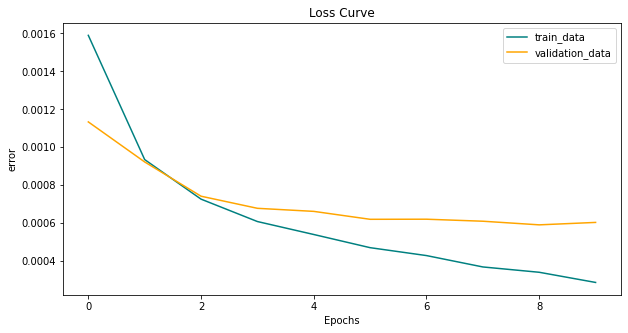

No handles with labels found to put in legend.


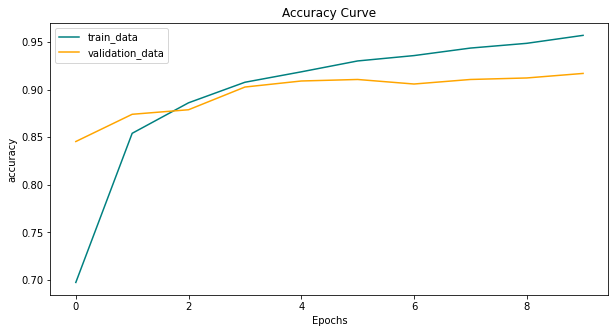

In [0]:
plot_curves("Loss Curve","error",train_error,val_error)
plot_curves("Accuracy Curve","accuracy",train_acc,val_acc)

# Evaluation of Models
Classification Report generated using sklearn library

### Models to be used

ResNet 18

In [0]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)

**Replacing Previous FC Layers with new ones**

In [0]:
features = list()
features.extend([nn.Linear(512, 3)])
resnet18.fc = nn.Sequential(*features)

VGG 16

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

**Replacing Previous FC Layers with new ones**

In [0]:
features = list()
features.extend([nn.Linear(25088,4096)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear(4096,4096)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear(4096,3)])

vgg16.classifier = nn.Sequential(*features)

### For models (Trained Without Focal Loss)

**Evaluation Report ResNet18 Model**


---

In [0]:
resnet18.load_state_dict(torch.load('/content/drive/My Drive/A_05_Part_02_Dataset/res18_BCE.pth'));
resnet18.eval();

*Train Data*

0. COVID-19
1. Normal
2.Pnemounia
              precision    recall  f1-score   support

           0       1.00      0.72      0.84       200
           1       0.99      0.94      0.97      4000
           2       0.87      0.99      0.93      2000

    accuracy                           0.95      6200
   macro avg       0.96      0.89      0.91      6200
weighted avg       0.96      0.95      0.95      6200

[[ 145    1   54]
 [   0 3760  240]
 [   0   18 1982]]


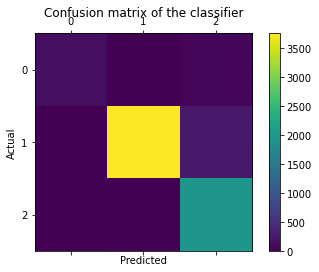


multi-label confusion matrix
[[[6000    0]
  [  55  145]]

 [[2181   19]
  [ 240 3760]]

 [[3906  294]
  [  18 1982]]]


In [23]:
Evaluation_report(resnet18,trainloader)

*Validation Data*

0. COVID-19
1. Normal
2.Pnemounia
              precision    recall  f1-score   support

           0       0.93      0.50      0.65        28
           1       0.96      0.90      0.93       400
           2       0.79      0.94      0.86       200

    accuracy                           0.89       628
   macro avg       0.89      0.78      0.81       628
weighted avg       0.90      0.89      0.89       628

[[ 14   5   9]
 [  0 360  40]
 [  1  11 188]]


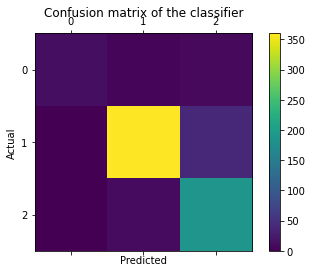


multi-label confusion matrix
[[[599   1]
  [ 14  14]]

 [[212  16]
  [ 40 360]]

 [[379  49]
  [ 12 188]]]


In [24]:
Evaluation_report(resnet18,validloader)

**Evaluation Report VGG16 Model**


---

In [0]:
vgg16.load_state_dict(torch.load('/content/drive/My Drive/A_05_Part_02_Dataset/vgg16_BCE.pth'));
vgg16.eval();

*Train Data*

0. COVID-19
1. Normal
2.Pnemounia
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       200
           1       0.98      1.00      0.99      4000
           2       0.99      0.96      0.97      2000

    accuracy                           0.98      6200
   macro avg       0.99      0.95      0.97      6200
weighted avg       0.98      0.98      0.98      6200

[[ 176    5   19]
 [   0 4000    0]
 [   1   82 1917]]


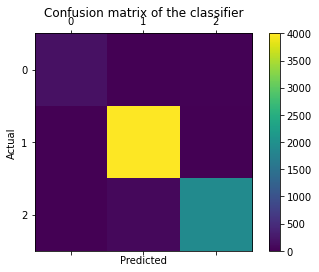


multi-label confusion matrix
[[[5999    1]
  [  24  176]]

 [[2113   87]
  [   0 4000]]

 [[4181   19]
  [  83 1917]]]


In [26]:
Evaluation_report(vgg16,trainloader)

*Validation Data*

0. COVID-19
1. Normal
2.Pnemounia
              precision    recall  f1-score   support

           0       1.00      0.61      0.76        28
           1       0.94      0.98      0.96       400
           2       0.94      0.91      0.92       200

    accuracy                           0.94       628
   macro avg       0.96      0.83      0.88       628
weighted avg       0.94      0.94      0.94       628

[[ 17   7   4]
 [  0 392   8]
 [  0  19 181]]


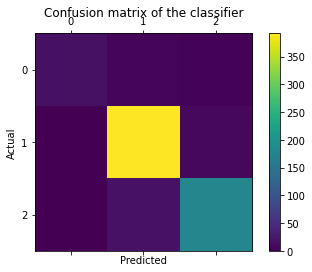


multi-label confusion matrix
[[[600   0]
  [ 11  17]]

 [[202  26]
  [  8 392]]

 [[416  12]
  [ 19 181]]]


In [27]:
Evaluation_report(vgg16,validloader)

### For models (Trained Using Focal Loss)

**Evaluation Report ResNet18 Model**


---

In [0]:
resnet18.load_state_dict(torch.load('/content/drive/My Drive/A_05_Part_02_Dataset/res18_focal_loss.pth'));
resnet18.eval();

*Train Data*

0. COVID-19
1. Normal
2.Pnemounia
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       200
           1       0.97      0.98      0.98      4000
           2       0.96      0.95      0.95      2000

    accuracy                           0.97      6200
   macro avg       0.96      0.94      0.95      6200
weighted avg       0.97      0.97      0.97      6200

[[ 175    4   21]
 [   1 3936   63]
 [   6   97 1897]]


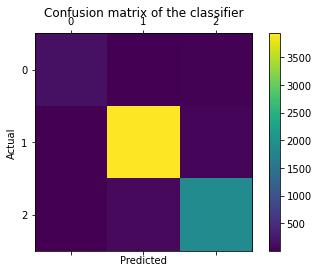


multi-label confusion matrix
[[[5993    7]
  [  25  175]]

 [[2099  101]
  [  64 3936]]

 [[4116   84]
  [ 103 1897]]]


In [29]:
Evaluation_report(resnet18,trainloader)

*Validation Data*

0. COVID-19
1. Normal
2.Pnemounia
              precision    recall  f1-score   support

           0       1.00      0.64      0.78        28
           1       0.93      0.95      0.94       400
           2       0.89      0.89      0.89       200

    accuracy                           0.92       628
   macro avg       0.94      0.83      0.87       628
weighted avg       0.92      0.92      0.92       628

[[ 18   6   4]
 [  0 381  19]
 [  0  22 178]]


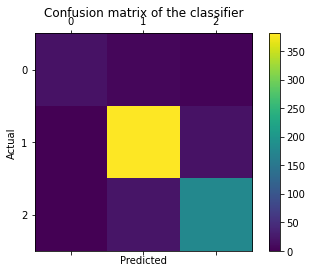


multi-label confusion matrix
[[[600   0]
  [ 10  18]]

 [[200  28]
  [ 19 381]]

 [[405  23]
  [ 22 178]]]


In [30]:
Evaluation_report(resnet18,validloader)

**Evaluation Report VGG16 Model**


---

In [0]:
vgg16.load_state_dict(torch.load('/content/drive/My Drive/A_05_Part_02_Dataset/vgg16_focal_loss.pth'));
vgg16.eval();

*Train Data*

0. COVID-19
1. Normal
2.Pnemounia
              precision    recall  f1-score   support

           0       0.96      0.82      0.89       200
           1       0.97      0.99      0.98      4000
           2       0.97      0.95      0.96      2000

    accuracy                           0.97      6200
   macro avg       0.97      0.92      0.94      6200
weighted avg       0.97      0.97      0.97      6200

[[ 164    5   31]
 [   1 3974   25]
 [   5  102 1893]]


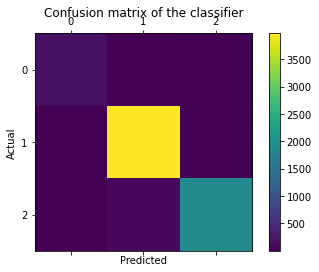


multi-label confusion matrix
[[[5994    6]
  [  36  164]]

 [[2093  107]
  [  26 3974]]

 [[4144   56]
  [ 107 1893]]]


In [32]:
Evaluation_report(vgg16,trainloader)

*Validation Data*

0. COVID-19
1. Normal
2.Pnemounia
              precision    recall  f1-score   support

           0       0.94      0.57      0.71        28
           1       0.94      0.95      0.95       400
           2       0.88      0.91      0.89       200

    accuracy                           0.92       628
   macro avg       0.92      0.81      0.85       628
weighted avg       0.92      0.92      0.92       628

[[ 16   6   6]
 [  0 382  18]
 [  1  18 181]]


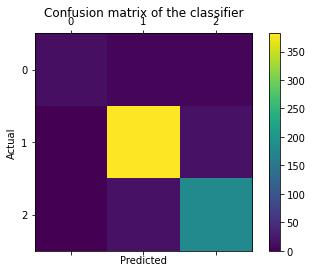


multi-label confusion matrix
[[[599   1]
  [ 12  16]]

 [[204  24]
  [ 18 382]]

 [[404  24]
  [ 19 181]]]


In [33]:
Evaluation_report(vgg16,validloader)

## Getting Prediction for Test Data

In [0]:
#To get more ram
a = []
while(1):
    a.append('1')

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def pred_for_test(model, loader, batchsize):
    
    preds_list=torch.zeros(0,dtype=torch.float, device='cpu')
    filenames = []
    model.train(False)
    j=0
    with torch.no_grad():
      for i, data in enumerate(loader):
        for c in range(batchsize):
          rec_num = c
          fn,_=loader.dataset.samples[rec_num]
          # print(len(fn))

          if i>4 and i<=9:
            inputs, labels= data
            # print("len(inputs): ",len(inputs))
            outputs = model(inputs)
            preds = get_preds(outputs,0.5)
            preds_list=torch.cat([preds_list,preds.cpu()])
        if i>4 and i<=9:
          filenames.append(fn.split('/')[-1])
    
    print(len(preds_list))
    preds_list = preds_list.detach().numpy()
    print(preds_list.shape)
    filenames = np.array(filenames)
    filenames = filenames.reshape(len(filenames),1)
    print(filenames.shape)
    final = np.concatenate((filenames,preds_list),axis=1)
    return final   


In [21]:
csv_matrix = pred_for_test(resnet18,testloader,64)
print("length: ",len(fn))
print("\npreds: ",len(p))

19776
(19776, 3)
(5, 1)


ValueError: ignored

In [0]:
np.savetxt("msds19070_results2.csv", csv_matrix, delimiter=",", fmt='%s')